In [3]:
import os
import csv
import numpy as np
import pandas as pd
import gc
import random
import string
import inflect
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
#from transformers import T5ForConditionalGeneration, T5Tokenizer
#from bert_score import BERTScorer
from rouge import Rouge
from transformers import Trainer, TrainingArguments, AdamW, BartForConditionalGeneration, BartTokenizer
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import warnings
import pickle
import sys
from torch.cuda.amp import GradScaler, autocast
from tqdm.notebook import tqdm as notebook_tqdm

In [34]:
sys.setrecursionlimit(10000000)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
warnings.filterwarnings("ignore")

In [5]:
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [6]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jelly\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jelly\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jelly\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jelly\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jelly\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [7]:
def lowercase_text(text):
    return text.lower()

def tokenize_text(text):
    return word_tokenize(text)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Initialize inflect engine
p = inflect.engine()

# Convert numbers to words with error handling for large numbers
def convert_numbers_in_text(text):
    words = text.split()
    new_words = []
    
    for word in words:
        if word.isdigit():
            try:
                word_in_words = p.number_to_words(word)
            except Exception:  # Catch any exception, including out-of-range numbers
                word_in_words = word  # Leave the number unchanged if there's an error
            new_words.append(word_in_words)
        else:
            new_words.append(word)
    
    return ' '.join(new_words)

# Main preprocessing function
def preprocess_text(text):
    text = lowercase_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    text = convert_numbers_in_text(text)  # Combined the number conversion here
    return text

# Access and preprocess text from document and summary files
def access_and_preprocess_text(doc_file_path, summary_file_path):
    with open(doc_file_path, 'r', encoding='utf-8') as doc_file:
        doc_text = doc_file.read()
        processed_doc_text = preprocess_text(doc_text)

    with open(summary_file_path, 'r', encoding='utf-8') as summary_file:
        summary_text = summary_file.read()
        processed_summary_text = preprocess_text(summary_text)

    return processed_doc_text, processed_summary_text

In [8]:
# Initialize empty lists for training documents (X_train) and summaries (y_train)
X_train = []
y_train = []

# Initialize empty lists for testing documents (X_test) and summaries (y_test)
X_test = []
y_test = []

In [9]:
# Directories for training and testing documents and summaries
train_doc_folder = r"C:/Users/jelly/Desktop/Sem-4/SML/Research Paper/train_data/judgement"
train_summary_folder = r"C:/Users/jelly/Desktop/Sem-4/SML/Research Paper/train_data/summary"
test_doc_folder = r"C:/Users/jelly/Desktop/Sem-4/SML/Research Paper/test_data/judgement"
test_summary_folder = r"C:/Users/jelly/Desktop/Sem-4/SML/Research Paper/test_data/summary"

In [10]:
# Specify the number of training and testing documents to process
num_train_documents = 7030
num_test_documents = 100

In [11]:
# Get list of training and testing document files
train_doc_files = os.listdir(train_doc_folder)
train_summary_files = os.listdir(train_summary_folder)
test_doc_files = os.listdir(test_doc_folder)
test_summary_files = os.listdir(test_summary_folder)

In [12]:
# Process the specified number of training documents and collect X_train and y_train
for i in range(num_train_documents):
    doc_file = train_doc_files[i]
    summary_file = train_summary_files[i]
    processed_doc_text, processed_summary_text = access_and_preprocess_text(os.path.join(train_doc_folder, doc_file), os.path.join(train_summary_folder, summary_file))
    X_train.append(processed_doc_text)
    y_train.append(processed_summary_text)

In [13]:
# Process the specified number of testing documents and collect X_test and y_test
for i in range(num_test_documents):
    doc_file = test_doc_files[i]
    summary_file = test_summary_files[i]
    processed_doc_text, processed_summary_text = access_and_preprocess_text(os.path.join(test_doc_folder, doc_file), os.path.join(test_summary_folder, summary_file))
    X_test.append(processed_doc_text)
    y_test.append(processed_summary_text)

In [14]:
# Setting up validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [15]:
print(f"Total Training Documents: {len(X_train)}")
print(f"Total Validation Documents: {len(X_val)}")
print(f"Total Testing Documents: {len(X_test)}")
print(f"Total Training Summaries: {len(y_train)}")
print(f"Total Validation Summaries: {len(y_val)}")
print(f"Total Testing Summaries: {len(y_test)}")

Total Training Documents: 5272
Total Validation Documents: 1758
Total Testing Documents: 100
Total Training Summaries: 5272
Total Validation Summaries: 1758
Total Testing Summaries: 100


In [16]:
# Define the TF-IDF vectorizer with updated parameters
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))

# Vectorize the training, validation, and testing data
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

y_train_tfidf = tfidf.fit_transform(y_train)
y_val_tfidf = tfidf.transform(y_val)
y_test_tfidf = tfidf.transform(y_test)

In [17]:
# Function to clear GPU memory
def clear_gpu_memory():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    gc.collect()# Ensure all GPU operations are finished

In [22]:
clear_gpu_memory()

In [19]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

# Load the DistilBART model and tokenizer
model = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-12-6')
tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-12-6')

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_l

In [23]:
def preprocess_for_training(doc_texts, summaries):
    inputs = tokenizer(doc_texts, max_length=1024, truncation=True, padding=True, return_tensors='pt')
    labels = tokenizer(summaries, max_length=150, truncation=True, padding=True, return_tensors='pt').input_ids
    return inputs, labels

# Convert data to appropriate format
train_encodings, train_labels = preprocess_for_training(X_train, y_train)
val_encodings, val_labels = preprocess_for_training(X_val, y_val)

# Create datasets
class SummaryDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SummaryDataset(train_encodings, train_labels)
val_dataset = SummaryDataset(val_encodings, val_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)
scaler = GradScaler()

# Training loop with tqdm
num_epochs = 20
model.train()

for epoch in range(num_epochs):
    model.train()
    progress_bar = notebook_tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
    for i, batch in enumerate(progress_bar):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        torch.cuda.synchronize()
        scaler.step(optimizer)
        torch.cuda.synchronize()
        scaler.update()

        progress_bar.set_postfix(loss=loss.item())

        del input_ids
        del attention_mask
        del labels
        del outputs
        del loss

        # Clear GPU cache periodically
        if (i + 1) % 10 == 0:  # Adjust the frequency as needed
            torch.cuda.empty_cache()
    
    print(f'Epoch {epoch + 1} completed')

# Save the fine-tuned model and tokenizer
model.save_pretrained('distilbart-finetuned')
tokenizer.save_pretrained('distilbart-finetuned')

Epoch 1/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 1 completed


Epoch 2/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 2 completed


Epoch 3/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 3 completed


Epoch 4/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 4 completed


Epoch 5/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 5 completed


Epoch 6/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 6 completed


Epoch 7/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 7 completed


Epoch 8/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 8 completed


Epoch 9/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 9 completed


Epoch 10/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 10 completed


Epoch 11/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 11 completed


Epoch 12/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 12 completed


Epoch 13/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 13 completed


Epoch 14/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 14 completed


Epoch 15/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 15 completed


Epoch 16/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 16 completed


Epoch 17/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 17 completed


Epoch 18/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 18 completed


Epoch 19/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 19 completed


Epoch 20/20:   0%|          | 0/2636 [00:00<?, ?it/s]

Epoch 20 completed


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('distilbart-finetuned\\tokenizer_config.json',
 'distilbart-finetuned\\special_tokens_map.json',
 'distilbart-finetuned\\vocab.json',
 'distilbart-finetuned\\merges.txt',
 'distilbart-finetuned\\added_tokens.json')

In [24]:
torch.cuda.empty_cache()
allocated_memory = torch.cuda.memory_allocated()
# Get the current GPU memory reserved (including overhead)
reserved_memory = torch.cuda.memory_reserved()

# Print memory in MB
print(f"Allocated memory: {allocated_memory / (1024 ** 2):.2f} MB")
print(f"Reserved memory: {reserved_memory / (1024 ** 2):.2f} MB")

# Get the free memory (total - reserved memory)
free_memory = torch.cuda.get_device_properties(0).total_memory - reserved_memory
print(f"Free memory: {free_memory / (1024 ** 2):.2f} MB")

Allocated memory: 4679.54 MB
Reserved memory: 5654.00 MB
Free memory: 2533.50 MB


In [25]:
def summarize(text, maxSummarylength=500):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True).to(device)  # Move input to GPU
    with autocast():
        summary_ids = model.generate(inputs, max_length=maxSummarylength, min_length=int(maxSummarylength / 5), length_penalty=10.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    
    # Clean up
    del inputs
    del summary_ids
    torch.cuda.empty_cache()
    
    return summary


def split_text_into_pieces(text, max_tokens=600, overlapPercent=10):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)

    # Calculate the overlap in tokens
    overlap_tokens = int(max_tokens * overlapPercent / 100)

    # Split the tokens into chunks of size max_tokens with overlap
    pieces = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens - overlap_tokens)]

    # Convert the token pieces back into text
    text_pieces = [tokenizer.decode(tokenizer.convert_tokens_to_ids(piece), skip_special_tokens=True) for piece in pieces]

    return text_pieces

def summarize_chunks(text, max_length=500):
    tokens = tokenizer.tokenize(text)
    expectedCountOfChunks = len(tokens) / max_length
    max_length = int(len(tokens) / expectedCountOfChunks) + 2

    pieces = split_text_into_pieces(text, max_tokens=max_length)
    print("Number of pieces:", len(pieces))
    
    summaries = []
    for piece in pieces:
        summary = summarize(piece, maxSummarylength=150)
        summaries.append(summary)
    
    concatenated_summary = ' '.join(summaries)
    print(concatenated_summary)
    
    # Clean up
    del pieces
    del summaries
    torch.cuda.empty_cache()
    
    return concatenated_summary

In [26]:
def rouge_scores(actual_summary, predicted_summary):
    rouge = Rouge()
    scores = rouge.get_scores(predicted_summary, actual_summary)
    return scores[0]['rouge-1']['f'], scores[0]['rouge-2']['f'], scores[0]['rouge-l']['f']

In [29]:
csv_file = "train_evaluation_distilledBART.csv"

# Open the CSV file and write the headers
with open(csv_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["document", "actual_summary", "predicted_summary", "cosine_similarity", "rouge_1", "rouge_2", "rouge_L"])  # Add headers
    
    # Iterate over 30 documents
    for i in tqdm(range(10), desc="Processing Documents", leave=False):
        print(f"\n### Document: {i+1} ###\n")
        
        # Generate summary for the document
        summary = summarize_chunks(X_train[i])
        
        # Compute cosine similarity using TF-IDF vectors (ensure `tfidf` is already defined and fitted)
        cosine_sim = cosine_similarity(tfidf.transform([y_train[i]]), tfidf.transform([summary]))[0][0]
        
        # Compute ROUGE scores (assuming rouge_scores is a predefined function)
        rouge_1, rouge_2, rouge_L = rouge_scores(y_train[i], summary)
        
        # Print metrics for inspection
        print(f"\nCosine similarity: {cosine_sim}")
        print(f"ROUGE-1: {rouge_1}")
        print(f"ROUGE-2: {rouge_2}")
        print(f"ROUGE-L: {rouge_L}\n")
        
        # Write the data to CSV file
        writer.writerow([X_train[i], y_train[i], summary, cosine_sim, rouge_1, rouge_2, rouge_L])
        
        # Clear memory for unused variables
        del summary
        del cosine_sim
        del rouge_1
        del rouge_2
        del rouge_L
        
        # Explicitly clear GPU memory and trigger garbage collection
        clear_gpu_memory()

print("Processing and evaluation completed.")

Processing Documents:   0%|          | 0/10 [00:00<?, ?it/s]


### Document: 1 ###

Number of pieces: 13
appellant defendant pendency suit portion land dispute acquired land acquisition act respondent plaintiffrespondent filed claim compensation reference made section thirty act determining eligibility amount compensation trial court decreed suit first appeal preferred defendant high court answered reference favour respondent defendant preferred first appeal one hundred and seventy-three one thousand, nine hundred and sixty-six appeal division bench high court dismissed appeal cost thereupon appellant preferred present two appeal special leave allowing appeal court held revenue recovery proceeding commenced sale land offered security government could reimburse total amount outstanding proclamation sale ultimately suit land auctioned purchased defendant sale favour confirmed put possession respondent plaintiff stated prior date auction father son 6th july 195d father son 975c certain loan advanced borrower failed repay loan 875d certain land quest

Processing Documents:  10%|█         | 1/10 [00:48<07:15, 48.40s/it]


### Document: 2 ###

Number of pieces: 7
respondent plaintiff gave lease open plot lo appellant defendant period ten year purpose running flour mill making necessary construction thereon yearly rent lease deed clause renewal term also renewed lessor given right recover vacant possession removal construction expiry initial term renewal term expiry ten year appellant defendant permitted hold notice nuder section one hundred and six transfer property act respondent called upon appellant defendant vacate hand vacant possession notice complied suit ejectment filed appellant defendant trial court negatived defendant defendant raised plea entitled protection part eleven bombay rent hotel lodging house rate control act one thousand, nine hundred and forty-seven since none ground eviction could landlord part ii made respondent plaintiff entitled recover possession suit plot virtue decree contention rejected respondent plaintiff ground view proviso section fifty act particularly latter part the

Processing Documents:  20%|██        | 2/10 [01:13<04:38, 34.87s/it]


### Document: 3 ###

Number of pieces: 7
appellant owner building situated ward eleven ward twenty within mangalore municipality appellant governed madras district municipality act one thousand, nine hundred and twenty till mysore municipality act came force appellant served notice payment property tax thereon demand served respondent quashing demand notice appellant contended high court high court jurisdiction take action levy property tax high court held demand notice quashed show cause action taken appellant committed municipal error law section one hundred and sixty-one two appellant moved court relief special leave obtained court urged behalf high court quashing appellant notice taken away object liable taken account towards end justice two appellant contended notice dated seventy-five thousand, two hundred and fifty-one give effect law could taken away held notice valid appellant entitled answer property tax served state government instrument appellant issued notice demand payme

Processing Documents:  30%|███       | 3/10 [01:39<03:34, 30.61s/it]


### Document: 4 ###

Number of pieces: 8
appellant granted licence march thirteen one thousand, nine hundred and sixty-eight excise collector establish warehouse storage bond wholesale vend country spirit import supply excise vendor territory tripura five year commencing april l958 ending march thirty-one one thousand and seventy-three mode granting licence period five year central warehouse agartala cost one lp litre country liquor respectively appellant asked collector licence deposit security r two thousand, five hundred licence fee five year rate r five thousand and one per year appellant subsequently granted licence tripura excise collector modified order extending period question arose decision judicial commis sion amount appellant petition article two hundred and twenty-six constitution dismissed high court appeal special leave appellant contended inter alia order collector excise tripura contravened tripura excise rule one thousand, nine hundred and sixty-two provided fee lice

Processing Documents:  40%|████      | 4/10 [02:05<02:52, 28.77s/it]


### Document: 5 ###

Number of pieces: 4
held per riwaj lakshmi dhingra v union india one thousand, nine hundred and fifty-seven two scr four hundred and twenty-six respectively appellant entitled one half share certain land preferential heir respondent p widow sued appellant claiming property non ancestral claimed preferential heir p collateral trial court decreed suit appeal high court held special leave granted appellant appeal court held one high court correctly held respondent preferential heir estate p widow plaintiff entitled property ancestral according custom applicable family sister son excluded inheritance respect property whether ancestral non ancestral however claimed property ancestral denied geneology appeal supreme court 441b three whether property ancestral appellant collateral subordinate judge ludhiana led voluminous oral evidence case held high court wrong relying upon special feature evidence adduced special applying custom party governed according plaintiff entit

Processing Documents:  50%|█████     | 5/10 [02:19<01:57, 23.54s/it]


### Document: 6 ###

Number of pieces: 3
respondent non resident carrying business secunderabad within territory nizam hyderabad acting agent two firm bombay british india bombay respectively agent lucas indian service bombay branch respectively good supplied respondent firm year assessment one thousand, nine hundred and forty-five forty-six respondent received r forty thousand, five hundred and four post berabad credited book account cheque sent banker collecting crediting account deposited respondent account book received bombay firm paid account december twenty-two paid account subsequently income tax officer assessed amount taxable income holding entire amount received bombyasibi sepunderabad appellate assistant commissioner upheld order holding income must held accrued arisen received britys india appeal respondent income tax appellate tribunal held amount received respondent bomb appellant bank madras bombay respectively posted madurai bombay received respondent bombay madurai f

Processing Documents:  60%|██████    | 6/10 [02:29<01:15, 18.86s/it]


### Document: 7 ###

Number of pieces: 3
question whether point time order rateable distribution passed executing court monies question cease property judgment debtor becomes property decree holder regardless whether actual payment pursuant said order made allowing appeal held one order must rateable disbursement money must treated belonging judgment debtor whose favour order passed mr devadoss court prior direction court order pay sale proceeds private judgment creditor subsequent claim state arrears sale tax defeat judgment creditor deprive fruit decree regarded property 938c two fact present respondent official receiver could recover respondent actually paid court 939b official receiver tanjore v mr venkatarama lyer air one thousand, nine hundred and twenty-two madras p thirty-one murli tahilram v asoomornal co air one hundred and section one hundred and twenty-one code civil procedure high court bombay directed appropriation amount claim made decree holder creditor entitled rateab

Processing Documents:  70%|███████   | 7/10 [02:37<00:45, 15.24s/it]


### Document: 8 ###

Number of pieces: 5
appellant class iii servant employed metal examiner also called chaser railway carriage workshop ajmer accepted currency note worth r one hundred and fifty illegal gratification securing job person charged section 51d act ia one thousand, nine hundred and forty-seven act abuse position public servant obtaining corrupt illegal mean pecuniary advantage shape said nanak singh charged section four hundred and twenty indian penal code induced deliver currency note value r one fifty dishonest representation could secure job said person trial court convicted appeal judicial commissioner acquitted appellant charge granted certificate fitness appeal supreme court main question arising appeal relates one whether appellant officer within meaning clause nine section twenty-one ipc two whether provision section one hundred rail act excluded railway servant definition public servant except purpose ch ix appellant service pay government performing duty metal 

Processing Documents:  80%|████████  | 8/10 [02:53<00:31, 15.61s/it]


### Document: 9 ###

Number of pieces: 13
petitioner action committee writ petition article thirty-two constitution obtained direction closure various unit shriram food fertilizer eight hundred and twenty-four industry ground hazardous community bench three hon ble judge permitting shrirum restart power plant also plant subject certain condition referred delhi legal aid advice board delhi bar associa tion filed application award compensation person suffered harm account escape oleum gas bench three judge issue great constitutional importance involved large bench five judge held since issue raised involved substantial question law relating interpretation article twenty-one three hundred and ninety-one constitution case referred larger three judge case could said arise writ petition court could take hearing application compensation application compensation came hearing felt since contention petitioner amendment writ petition include claim compensation victim oleumar gas applica petition

Processing Documents:  90%|█████████ | 9/10 [03:38<00:24, 24.91s/it]


### Document: 10 ###

Number of pieces: 20
petition challenged vires bombay tenancy agricultural land amendment act one thousand, nine hundred and fifty-six held per bhagwati jagirdar saranjandar inamdar talukdar malik khot act make provision certain purpose act defined land section twenty-eight act mean land mean land used agricultural purpose includes site farm building appurtenant land within agricultural purpose b site dwelling house occupied agriculturist agricultural labourer artisan land upon landholder definition land holder include person specified four hundred and ninety-two e purpose improving economic social condition peasant ensuring full efficient use land agricultural purpose expedient assume management estate held landholder regulate impose restriction transfer agricultural land dwelling house Sitesland appurntant thereto belonging occupied appeal directed order bombay high court upholding validity impugned agrarian reform act petition dismissed thereupon filed petitio

Processing and evaluation completed.


In [36]:
csv_file = "val_evaluation_distilledBART_2.csv"

# Open the CSV file and write the headers
with open(csv_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["document", "actual_summary", "predicted_summary", "cosine_similarity", "rouge_1", "rouge_2", "rouge_L"])  # Add headers
    
    # Iterate over 20 documents
    for i in tqdm(range(1000), desc="Processing Documents", leave=False):
        print(f"\n### Document: {i+1} ###\n")
        
        # Generate summary for the document
        summary = summarize_chunks(X_val[i])
        
        # Check if the actual summary (reference) is empty
        if not y_val[i].strip():
            print(f"Skipping empty reference summary at index {i}")
            continue
        
        # Compute cosine similarity using TF-IDF vectors (ensure `tfidf` is already defined and fitted)
        try:
            cosine_sim = cosine_similarity(tfidf.transform([y_val[i]]), tfidf.transform([summary]))[0][0]
        except ValueError as e:
            print(f"Error computing cosine similarity at index {i}: {e}")
            continue
        
        # Compute ROUGE scores (assuming rouge_scores is a predefined function)
        try:
            rouge_1, rouge_2, rouge_L = rouge_scores(y_val[i], summary)
        except ValueError as e:
            print(f"Error computing ROUGE at index {i}: {e}")
            continue
        
        # Print metrics for inspection
        print(f"\nCosine similarity: {cosine_sim}")
        print(f"ROUGE-1: {rouge_1}")
        print(f"ROUGE-2: {rouge_2}")
        print(f"ROUGE-L: {rouge_L}\n")
        
        # Write the data to CSV file
        writer.writerow([X_val[i], y_val[i], summary, cosine_sim, rouge_1, rouge_2, rouge_L])
        
        # Clear memory for unused variables
        del summary
        del cosine_sim
        del rouge_1
        del rouge_2
        del rouge_L
        
        # Explicitly clear GPU memory and trigger garbage collection
        clear_gpu_memory()

print("Processing and evaluation completed.")

Processing Documents:   0%|          | 0/1000 [00:00<?, ?it/s]


### Document: 1 ###

Number of pieces: 7
term office municipal councillor elected last general election expired efflux time state government instead holding general election constitute new town municipal council appointed administrator exercise power perform discharge function duty town muncipal council also constituted advisory council advise assist administrator constitution advisory council challenged one resident gangawati petition filed high court karnataka year one thousand, nine hundred and seventy-two petition however settled state government gave undertaking would take necessary step holding election within reasonable time happened 6th february1978 state government thereafter accordance undertaking given appointed returning officer 25ebruary1978 looked general election last going held hope belied turning officer could issue notice fixing calendar event forth election state government rescinded notification issued earlier section thirteen act determining territorial division b

Processing Documents:   0%|          | 1/1000 [00:32<9:07:11, 32.86s/it]


### Document: 2 ###

Number of pieces: 6
hindu undivided family one b k rohatgi eldest male member karta firm carried milkhi ram none member assessee family decided company floated purpose acquiring taking india electric work going concern said b k rohtgi one promoter company pursuant agreement vendor business said b roft took said business carried december nineteen one thousand, nine hundred and thirty contemplated contemplated company eventually incorporated indian company act one hundred and twenty-two article association said company provided first managing director would would said rohtgi assigns successor business whether name style firm would continue co manage director would resign found guilty act fraud dishonesty removed manner thereunder provided article 1333b provided remuneration managing director fixed r six thousand per annum commission fifteen per cent dismissing appeal income tax appellate tribunal court held remuneration made r sixty-one thousand, two hundred and eig

Processing Documents:   0%|          | 2/1000 [00:54<7:17:05, 26.28s/it]


Cosine similarity: 0.7874326583090252
ROUGE-1: 0.44957982732901985
ROUGE-2: 0.1945432933920966
ROUGE-L: 0.31092436514414595


### Document: 3 ###

Number of pieces: 5
respondent claimed scale minimum wage rate contract work done appellant level bare subsistence wage dispute referred industrial tribunal adjudication section one hundred and one read section one thousand, two hundred and fifty-five act award challenged respondent labour appellate tribunal appellate tribunal remanded matter tribunal direction issue basic wage dearness allowance specifically determined two item remand tribunal remand mr roy available ceased district judge appointed mr sharma made award fixed basic wage r ten minimum dear standing allowance award quashed ground appointment duly published required act district judge subsequently appointed another person date order made appointment accordingly quashed tribunal award challenged subsequently another person made respondent award contested included appellant char

Processing Documents:   0%|          | 3/1000 [01:13<6:19:50, 22.86s/it]


### Document: 4 ###

Number of pieces: 6
appellant company entered agreement indian company provided inter alia certain technical know service furnishing resident proprietor company resident factory manager starting plant superintending operation initial production stage also technical personnel necessary operation plant training indian personnel replace foreign technical personnel quickly possible lieu service aforesaid per agreement appellant ceived sum r ninety-five thousand, seven hundred and sixty-two income tax officer deducted income tax payable said sum income tax account relevant assessment year one thousand, nine hundred and fifty-seven fifty-eight appellant filed application refund entire tax deducted source incometax officer took view since certain technical fee paid american company earned india small amount assessable income tax therefore directed refund major portion tax said deducted source assessee company commissioner income tax exercise appellant assessee company ma

Processing Documents:   0%|          | 4/1000 [01:35<6:16:52, 22.70s/it]


### Document: 5 ###

Number of pieces: 8
respondent challenged order detention passed district magistrate ludhiana october three fifty-three one thousand, nine hundred and eighty-three read section three two ground show petitioner detained basis two speech alleged made july eight one thousand thousand, three hundred and seventy-one nihang chhowani baba bakala district amritsar wherein made reference incident dated two hundred and ninety-two thousand, seven hundred and thirty-one encounter nihangs police wherein stressed order take revenge sikh would kill would kill single judge high court dismissed writ petition filed respondent holding transfer detention place far away ambala withdrew petition assurance government sent back ambala government october twenty-eight without indicating ground detention served respondent october six one hundred and respondent made speech speech addressing conference attended gurdwara manji sahib amritsar made effort establish punjab government parallel cen

Processing Documents:   0%|          | 5/1000 [02:08<7:18:54, 26.47s/it]


### Document: 6 ###

Number of pieces: 32
appellant company primarily engaged business manufacture sale sugar also cold storage plant steel foundry 10th october one thousand, nine hundred and sixty-eight state uttar pradesh decided give exemption sale tax period three year section 4a sale tax act new industrial unit state appellant contacted director industry stating view sale tax holiday announced government appellant intended set hydro genation plant manufacture vanaspati sought confirmation industrial unit proposed set would entitled sale tax Holiday period three yea period started production appellant thereupon started taking step contact various financier financing project also initiated negotiation manufacturer purchase machinery setting vansaspati factory representative met 4th respondent time chief secretary government also advisor governor intimated appellant setting vanaspatis factory solely basis assurance given behalf government appellant would entitled exemption sale appe

Processing Documents:   1%|          | 6/1000 [04:43<19:21:36, 70.12s/it]


### Document: 7 ###

Number of pieces: 3
appellant passed mbbs examination section n medical college agra completed internship december one thousand, nine hundred and seventy-seven desirous prosecuting post graduate study paediatrics took year house job paediatrics department said college also applied admission md course despite several candidate passing dch examination preferred admission course suddenity appel lant stopped practice competing others passed mbb examination appellant writ petition high court challenging decision college aforesaid denied admission md petition dismissed summarily division bench high court ground relief mandamus sought appellant could granted since failed establish legal right violated appeal special leave court directed high court court two hundred and eighty-five appellant stating earlier admitted dch course finished house job many year past candidate passed d ch examination suddenly stopped practice result compete others appellant passed mbbs examinati

Processing Documents:   1%|          | 7/1000 [04:55<14:03:02, 50.94s/it]


### Document: 8 ###

Number of pieces: 8
petitioner convicted sentenced life term section three hundred and two ipc appeal brother deceased state contended behalf petitioner conviction leaving appeal subsequent proceeding unconstitutional violative article twenty-one procedural magna carta protective life liberty therefore sentence must fail dismissing appeal held contention urged petitioner liberty deprived proceeding initiated someone without procedure established law must fair fanciful formal flimsy evidence case must fair otherwise enable kindly neighbour complainant first informant appeal supreme court allegedly erroneous acquittal high court corpus juris contains black letter law arming purely compassionate soul approach court argues behalf petitioner two affected client liberty deprived legal proceeding initiated prevented achieving justice obtained special power article one hundred and thirty-six constitution behalf respondent submitted high court error reserving liberty accus

Processing Documents:   1%|          | 8/1000 [05:24<12:08:36, 44.07s/it]


### Document: 9 ###

Number of pieces: 6
petitioner detained order section eighty-two jammu kashmir public safety act one thousand, nine hundred and seventy-eight passed district magistrate anantnag application article thirty-two constitution order quashing order detention petition court contended petitioner belonged young men league formed avowed object challenging accession state india furthering cause interest pakistan state joined party active member active member people league tried elicit public opinion favour deceased anti pak subversive element sentenced death two occasion murder espionage sabotage currently awaiting execution pamphlet poster issued people league support petitioner also alleged joined subversive element sopore area organized burning reli create chaos state conspiracy however unearthed baramulla police time ill much damage done case fir detenu stated detained sri three thousand, eight mr z bhutto pakistan party sent bill booklet arouse sentiment people state go

Processing Documents:   1%|          | 9/1000 [05:45<10:07:50, 36.80s/it]


### Document: 10 ###

Number of pieces: 9
respondent convicted section five import export control act one thousand, nine hundred and forty-seven sentenced fine r two hundred default simple imprisonment one month imposed presidency magistrate appeal court calcutta set aside acquittal held high court correct setting aside conviction sentence imposed respondent mukhram lachminarayan motilal kanoria behalf managing agent l jute manufacturing company ltd cal cutta together manufacturing hackling combing pin alleged machinery installed used mill konnaggar eastern railway company installed machinery licence issued chief controller import new delhi stating machinery installed thereon purpose appellant could import whole machinery machinery without licence appellant permitted apply import licence letter dated february four one thousand and fifty-five febru ary nine oneida mot section officer twenty-six five fifty-five import trade control authority issued notification dated july one one thousa

Processing Documents:   1%|          | 10/1000 [06:17<9:42:25, 35.30s/it]


### Document: 11 ###

Number of pieces: 9
bombay town planning scheme santacruz vi fell within municipal limit bandra municipal committee committee resolution dated 15th june one thousand, nine hundred and forty-eight declared intention frame town planning com missioner scheme section ninety-one town planning act one thousand and fifteen thereafter municipal committee abolished area municipality absorbed within limit bombay municipal corporation corporation became local authority applied government 7th may 9th thousand, five hundred and fifty-one draft scheme prepared published required act duly sanctioned government 6th may 195o 17th august 195o final scheme sanctioned government 21st august 196o however finality scheme published official gazette forwarding time scheme president tribunal appointed section thirty-two act 25th january 195o regularised town planning held town planning act one thousand, nine hundred and fifty-one scheme framed municipal corporation local authority implem

Processing Documents:   1%|          | 11/1000 [06:50<9:29:35, 34.56s/it]


### Document: 12 ###

Number of pieces: 3
plaintiff respondent brought suit pre emption appellant vendee sale ground plaintiff respondent instituted suit basis collateral co sharer wanted given land allotted vendee consolidation proceeding land would entitled preempt sale question raised appellant pleaded possible distinguish land allotted place land sold trial court held favour plaintiff respondent granted decree preemption appeal high court held basis section twenty-four patiala east punjab state union holding consolidation prevention fragmentation act 5o two thousand and seven bk open pre emptor follow land given vendor consolidation proceeding lieu land subject matter sale deed held preemption imposes limitation disability upon ownership property extent restricts owner unfettered right sale therefore sale compels sell property co shareor eight hundred and sixty-four f h 78a section twenty-four speaks landowner tenant right land allotted original holding tenancy brings right obliga

Processing Documents:   1%|          | 12/1000 [07:02<7:39:37, 27.91s/it]


### Document: 13 ###

Number of pieces: 5
occupier portion premise 15a1 free school street calcutta appellant bar served animating liquor scantily clad female flesh sweet seventeen thereabouts flit sit lap heady tune band music solicit carnal custom willing male victim pay r thirty choose fancy drink together taking leave decency indulge promiscuous sex exercise legally described operation prostitution stage busy many men girl moving room lavatory chamber curtain rise raiding party police excise officer surprise arotic company drowned drink damsel lacherous drama need detain u act went action prosecution launched many section seven resulting conviction sentence two person proprietor manager bar often time bar restaurant euphemism brothel socialite without smirch satisfying sex appeal high court substantially failed appeal state count partly succeeded court leave refused regarding challenge guilt finding sustaining appellant keeping managing brothel within meaning section thirty-one re

Processing Documents:   1%|▏         | 13/1000 [07:22<6:57:50, 25.40s/it]


### Document: 14 ###

Number of pieces: 11
petition article two hundred and twenty-six constitution challenging constitutional validity manipal finance act one thousand, nine hundred and seventy-seven dismissing petition held impugned regulation sale tax collection sale purchase agricultural land situate declared ultra vires resulted enactment investment public purpose public whose share market value exceeds r twenty-five thousand writ petition allowed published sub section four section five six seven eight nine one hundred and ninety-two con stitution imposes restriction sale agricultural land manipabilitis excess r fifteen thousand per acre dry wet month shrub land specified sub section two section seven eight eight act deal make declaration effect december specified notified time time virtue section sixty-seven specified notification state government absence intimation act respect area petitioner engaged business extensive first day trading charge sale year one thousand, nine hundr

Processing Documents:   1%|▏         | 14/1000 [08:05<8:24:19, 30.69s/it]


### Document: 15 ###

Number of pieces: 6
prior one thousand, nine hundred and sixty-six respondent one thirty-six resident two village called ramakrishnapuram sriharipuram included within municipal limit visakhapatnam municipality respondent property situated within limit two village assessed property tax andhra pradesh andrah area district municipality act nineteen thousand, seven hundred and twenty act repealed section three hundred and nine eleven however virtue section forty-one act respondent one thereupon filed writ petition high court challenging validity act high court allowed petition appeal court held virtue section thirty-three act municipality act come force cease apply municipality part thereof case may date publication notification sub section three date first day april case first day thereafter virtue section 39of act respondent filed appeal special leave court respondent municipality declared intention levy property tax certain area newly included within municipal lim

Processing Documents:   2%|▏         | 15/1000 [08:29<7:52:46, 28.80s/it]


### Document: 16 ###

Number of pieces: 4
plaintiff respondent filed suit recover sum r thirty-one million, nine hundred and forty-five thousand, eight hundred and eleven together interest rate twelve suit contested state rajasthan interim decree sum r sixty-six thousand, five hundred and seventeen passed basis inter alia sum r one hundred and sixty-seven thousand, six hundred and nineteen including sum r sixteen thousand and seventeen trial decree already passed suit also awarded interest rate four twelve amount decreed date suit till date realisation plaintiff defendant preferred appeal high court reduced decretal amount sum r nine thousand, ninety-one high court however held plaintiff entitled interest date suit 1st january one thousand, three hundred and fifty-one merely date suit also enhanced rate interest pendente l appellant claimed interest paid rate four twelve paid use bond stone lintel sill measurement wall trial court granted interest high court appeal court contended app

Processing Documents:   2%|▏         | 16/1000 [08:42<6:33:40, 24.00s/it]


### Document: 17 ###

Number of pieces: 6
lalaji ramchandra eldest son govindraoji awarded jagir mean parwana dated april eight one thousand, eight hundred and thirty-eight issued highness maharao ramsingh ruler kotah debt r nine lakh guaranteed british government lieu debt subsequently property treated property joint family lalaji motilal second son born viz name adopted son ganpat raoji sought partition family property including eight village sarola jagirs situated erstwhile state kota defendant one chandrakant rao defendant one suit appellant sought partition suit holding none property suit ancestral property trial court dismissed suit entirety holding property suit hence appeal supreme court rajasthan upheld dismissal suit insofar appellant claimed share eight village forming appellant respondent descendant one chandrakant rao jagirdar jagir like jagirs given status impartible estate given proper shape liable render chakri subhchintki ruler ordered jagur matter dealt maharao kotah

Processing Documents:   2%|▏         | 17/1000 [09:04<6:20:58, 23.25s/it]


### Document: 18 ###

Number of pieces: 3
respondent agent delivered bale cloth railway administration railway receipt issued name consignor favour endorsed railway receipt sent post respondent failed obtain satisfaction served composite notice section seventy-seven indian railway act section eighty civil procedure code thereafter filed suit court loss value bale account nondelivery respondent resisted claim plea among others suit maintainable without effective notice suit barred article thirty-one limitation act expired trial court decreed suit appeal additional civil judge reversed decree passed trial court dismissed suit full bench high court reversed decree first appellate court restored decree trial court restored trial court certificate fitness article 1331c constitution held suit claim compensation loss destruction deterioration good non delivery good distinct claim compensation irrecoverable claim well enforcement claim former variety action court law court law different varie

Processing Documents:   2%|▏         | 18/1000 [09:17<5:31:39, 20.26s/it]


### Document: 19 ###

Number of pieces: 3
respondent registered dealer sale tax act one thousand, nine hundred and forty-eight carrying business manufacture oil groundnut oil seed oil manufactured sold dealer intra state inter state way export dealer liable purchase tax three ad valorem turnover purchase made dealer cultivator unregistered dealer section 4b act however contemplates special relief certain manufacture notified good relief form concessional rate purchase tax exemption case may notified state government dealer hold recognition certificate issued sub section two respect thereof one million, two hundred and fifty-one thousand and sixty-nine state government notified oil kind notified good purpose section four b purchase dealer liable tax turnover firstpurchases shall entitled concession rate tax two fifty-five first purchase case respondent held recognition certificate would take effect preamble period three successive assessment respondent made five hundred and twenty-one 

Processing Documents:   2%|▏         | 19/1000 [09:30<4:56:39, 18.14s/it]


### Document: 20 ###

Number of pieces: 4
appellant filed suit specific performance basis oral agreement entered respondent first respondent died soon filing suit contested second respondent widow trial court decreed suit prayed appeal high court accept agreement pleaded plaintiff still granted decree directing defendant execute play deed favour plaintiff respect item one plaint schedule property less one acre paddy field east sum r eleven thousand, five hundred originally plaintiff owner suit property sold first respondent nine hundred and ninety-one thousand, one hundred and twenty-one malayalam era exh according plaintiff time execution oral agreement first respondent whereunder 1st respondent agreed reconvey property sold price sold whenever plaintiff called upon reconvey suit appeal arose rounded basis said agreement 1st defendant died even could file written statement case death gifted suit property mean registered deed favour defendant denied agreement section one hundred and t

Processing Documents:   2%|▏         | 20/1000 [09:47<4:48:25, 17.66s/it]


### Document: 21 ###

Number of pieces: 11
october twenty-four one thousand, nine hundred and fifty-seven one dr dhanrajamal gobindram entered agreement m shamji kalidas co seller hereafter purchase five hundred bale african raw cotton according term condition subject usual force majeure clause description arbp fifty-two f q crop58 quality five hundred value five hundred per bale shipment february twenty-eight one ltd term condition reverse form part contract contract subject bye law east india cotton association ltd bombay bye law thirty-five arbitration quality case east african cotton term condition shipment subject cause cause beyond seller seller shipper control also subject availability freight contract subject jurisdiction high court bombay duty buyer obtain import licence communicate number thereof seller immediately appellant entered contract kampala mombasa purchase good british east africa march one thousand, nine hundred and fifty-seven applied respondent supply cotton col

Processing Documents:   2%|▏         | 21/1000 [10:24<6:23:35, 23.51s/it]


### Document: 22 ###

Number of pieces: 4
dismissing appeal court held one word phrase meaning also content living content breathes expands contract word phrase properly belong discipline tax fee properly belong world public finance since constitution law also concerned public finance word often adjudicated upon effect discover content commissioner hindu religious endowment madras v shri lakshmindra thirtha swamiyar considered locus classicus subject contradistinction tax fee definition tax given one thousand and two f two word phrase take colour character context time speak differently different context one hundred and seventy-one e g instant case corporation really proposing levy tax guise enhancing fee original rate fixed march one thousand, nine hundred and fifty-three one hundred p forty-eight three instant case however corporation realised sum r four hundred and section hh sudhandra v commissioner hindu religious charitable endowments court reiterating element quid pro quo perso

Processing Documents:   2%|▏         | 22/1000 [10:41<5:49:55, 21.47s/it]


### Document: 23 ###

Number of pieces: 5
clause twenty-two contract haryana state electricity board board stipulates deposit certain rate electricity clause thirty-one provided consumer habitually defaulted making payment monthly due giving board liberty time demand security deposit consumer demand payment money monthly bill value meter andor apparatus belonging board installed consumer premise deposit may transferable calculated consumer premise december one thousand, nine hundred and eighty-two giving month clear refund security charge energy due paid agreed bank fixed deposit sum r one thousand per kw connected load part thereof case domestic average deposit r twenty-five thousand case industrialagriculturalbulk supplystreet lighting consumer aggregating r one hundred kw three hundred and one consumer filed writ petition high court challenging validity unauthorised security charge given section thirty-two section three hundred and seventy-one inter alia provides right board revise

Processing Documents:   2%|▏         | 23/1000 [11:00<5:39:06, 20.83s/it]


### Document: 24 ###

Number of pieces: 24
decree passed favour appellant bank may one one thousand, nine hundred and forty-seven decree provided payment sum r thirty-one thousand manner specified decree provided respondent failed pay instalment mentioned within four month date becoming due shall entitled realise said amount execution amount decree may thirty one thousand and fifty-three absence application execution made within three year date application made section forty-five introduced banking company act one hundred and ninety-four thousand, four hundred and nine sub section one section provided notwithstanding anything contrary contained indian limitation act law time force computing period limitation fixed suit application banking company wound period commencing date presentation petition winding banking company shall excluded appellant bank claim seven hundred and ten application execution barred limitation imposed article one eight hundred and twenty-seven limitation act app

Processing Documents:   2%|▏         | 24/1000 [12:36<11:45:54, 43.40s/it]


### Document: 25 ###

Number of pieces: 2
respondent appointed forester conservator forest subsequently placed suspension district forest officer pending enquiry charge negligence duty filed writ petition high court orissa challenging order suspension inter alia ground made contravention article three hundred and eleven constitution well rule twelve orissa civil service classification control appeal rule one thousand, nine hundred and sixty-two high court allowed petition quashed order suspension holding violation article three thousand, one hundred and twelve constitution allowing appeal held order suspension passed government servant pending disciplinary enquiry neither one dismissal removal service within article thirty-one constitution position clearly laid constitution bench mohammed ghouse v state andhra ilr high court one thousand and eighty-seven two scr two hundred and forty-seven mohamed gofelder v state or rule twelve rule eleven district forest officer constituted appointi

Processing Documents:   2%|▎         | 25/1000 [12:44<8:51:30, 32.71s/it] 


### Document: 26 ###

Number of pieces: 9
respondent one shri chiranjilal shrilal goenka involved several suit one pending appeal behest died november twenty-five one thousand, nine hundred and eighty-five said executed appointed younger daughter sole executrix claimed adopted son natural son mr sita another daughter respondent one wife filed substitution application order twenty-two rule thirty-three cpc setting rival claim dispute arose would represent estate shri c g three record legal representative court passed consent party justice v deshpande retired chief justice bombay high court appointed arbitrator settle dispute legal heir estate deceased chirani nilkanthal mr radhey shyam basis award held eleven order arbitrator jurisdiction decide probate suit apply two suit filed person claiming property dispute created section two hundred and eleven code criminal procedure code one thousand, nine hundred and eight defines legal representative person law represented estate deceased pers

Processing Documents:   3%|▎         | 26/1000 [13:22<9:15:49, 34.24s/it]


### Document: 27 ###

Number of pieces: 16
appellant registered co operative society act managed executive committee vaish college affiliated agra university statute ordinance made thereunder establishment meerut university later appellant appointed principal college permanent basis effect july one one thousand, nine hundred and sixty-four appointment principal formally approved vice chan cellor two year later difference arose executive committee college plaintiffrespondent resulting allegation counter allegation culminating notice served executive committee directing discharge duty principal another letter sent defendant four member staff college officiate principal place plaintiff respondent rejected counter notice sent legal also asked defendant four assume charge principal executive committee resolution terminated service appellantrespondent effect october twenty-four 196o even formal resolution terminating service passed plaintiff respondent filed present suit court first additio

Processing Documents:   3%|▎         | 27/1000 [14:29<11:55:52, 44.14s/it]


### Document: 28 ###

Number of pieces: 11
respondent owner certain plot land filed suit six appellant claiming decree ejectment ground arrears ground rent municipal tax appellant contested respondent claim ground land suit taken predecessor title owner thika tenant year one thousand, nine hundred alleged occupation plot built substantial structure appellant claimed let portion structure tenant trial court decreed suit holding section thirty-one c calcutta thika tenancy act contained inter alia relevant provision section five high court also held defendant suit competent appealed court contention urged behalf appellant plaintiff suit fell within scope section thirty c act consequence provision section fifty-one therefore relevant provision act apply held high court jurisdiction entertain defendant prove anything contained sub section one section thirty code civil procedure clear fact case taken construction section 30c therefore regard suit clause one section five section thirty secti

Processing Documents:   3%|▎         | 28/1000 [15:09<11:37:22, 43.05s/it]


### Document: 29 ###

Number of pieces: 3
senior commercial officer wrote letter may twenty-two one thousand, nine hundred and eighty-two calling upon appellant offer explanation respect twelve charge gross indiscipline appellant submitted explanation charge next day served second notice upon appellant saying explanation offered convincing another given explanation regarding specific charge conveyed letter appellant sent explanation next day deputy chief commercial superintendent passed order dismissing service ground fit retained service appellant filed writ petition high court challenging order dismissal various ground including respondent one three high court dismissed writ petition appellant appealed court appeal special leave order dismissing appellant service passed respondent three rule fourteenii railway servant discipline appeal rule one hundred and ninety-three read proviso b article three thousand, one hundred constitution respondent three recorded reason writing coming con

Processing Documents:   3%|▎         | 29/1000 [15:20<9:00:30, 33.40s/it] 


### Document: 30 ###

Number of pieces: 7
appellant carried business manufacture sale textile good made mill indore indian state integration law income tax known indore industrial tax rule one thousand, nine hundred and twenty-seven sale textile made various place inside taxable territory british india upto assessment year one hundred and ninety-one thousand and fifty-one fifty treated non resident within meaning section 4a indian income tax act two assessment year appellant held resident ordinarily resident definition term section four act section forty-four indian incometax act income received outside taxable territory subjected tax income bank local board indian india provided follows income received ordinarily resident defined income abroad ie outside india continuous possession territory within india defined therefore subject certain condition imposed section four imposed eight tax year ending appellant assessee made two claim course assessment proceeding one thousand, nine hundr

Processing Documents:   3%|▎         | 30/1000 [15:47<8:27:11, 31.37s/it]


### Document: 31 ###

Number of pieces: 5
appellant limited company incorporated law switzerland carrying business manufacture sale pharmaceutical chemical product december two one thousand, nine hundred and forty-six appellant applied registration trade mark protovit later applied registration mark dropovit respect medicinal pharmaceutical preparation substance application registered advertisement respondent application escaped notice appellant hence oppose registration letter dated march four nine fifty-eight messrs volta ltd appellant agent drew attention respondent mark subsequently respondent refused alter trade mark appellant applied rectification register removal therefrom respondent trade mark ground urged support application respondent mark nearly resembled appellant mark likely deceive cause confusion appellant applied amendment application additional ground taken droppedovit invented word application amendment allowed registrar amended application opposed respondent joint r

Processing Documents:   3%|▎         | 31/1000 [16:07<7:32:18, 28.01s/it]


### Document: 32 ###

Number of pieces: 1
petitioner done rural service five year respondent filed writ petition special leave petition dismissing petition court held one advice preference might given service candidate done five year rural service first place possible facility keeping latest medical literature might available service candidate nature work make difficult acquire knowledge recent medical research candidate come freshly passing graduation examination might moreover might act incentive doctor done graduation rural service time seven hundred and forty-two f two judge court dr dinesh kumar or v motilal nehru medical college allahabad or observed weightage given candidate rural service rendered far admission post graduate course concerned dismissing petitioner writ petition court three hundred and thirty-six held one recommendation case merit selection based merit made absolute maximum five mark favour rural service study whether college education candidate done rural

Cosin

Processing Documents:   3%|▎         | 32/1000 [16:12<5:39:35, 21.05s/it]


### Document: 33 ###

Number of pieces: 6
appellant muslim wife whose husband married filed petition section one hundred and twenty-five code criminal procedure court judicial magistrate sought maintenance child rs300 pm respectively trial magistrate dismissed petition holding appellant failed establish adequate justification living separately revision preferred session judge pendency revision respondent married one sahida begum one thousand, nine hundred and eighty-four second wife therefore urged revision irrespective ground second marriage respondent ground grant maintenance session judge allowed issue taking devious view since respondent contracted second marriage giving appellant sufficient time opportunity rejoin since offered take back even second marriage appellant entitled claim maintenance however far child concerned session judge granted maintenance rs100 per month appellant preferred petition high court con sideration high court declined interfere concurrent finding court 

Processing Documents:   3%|▎         | 33/1000 [16:36<5:55:10, 22.04s/it]


### Document: 34 ###

Number of pieces: 10
appellant petitioner writ petition filed article thirty-two constitution manufacturer cement manufacturing unit also registered office located within state tamil nadu petitioner two seven ten shareholder petitioner remaining citizen india remaining petitioner authorised stockist different manufacturer place business different place located karnataka kerala tamilnadu appellant selling cement state karnata kerala purpose place business within state andhra pradesh exercise power conferred sub section one section nine andhra padesh general sale tax act one thousand, nine hundred and fifty-seven made order reducing rate tax sale cement made manufacturing unit cement product state effect day another order made expiry day tax fixed reduced rate four paisa rupee point first sale state another order day tax payable day tax reduced petitioner filed writ sub section five section eight central act one thousand, nine hundred and fifty-six reduces rate tax

Processing Documents:   3%|▎         | 34/1000 [17:11<6:57:25, 25.93s/it]


### Document: 35 ###

Number of pieces: 6
andhra pradesh high court declared section one hundred and twenty-nine unconstitutional void offending article nineteen one g constitution india oral application made high court grant leave appeal supreme court court held high court committed serious infirmity least total failure consider applicability provision code criminal procedure situation oral application high court state question relates interpretation constitution question also substantial question law general importance requires decided supreme court order high court refrained certifying case involved substantial questions law interpretation constitution seven hundred and thirty-two b c section one hundred and twenty-nine provided power detain vehicle used without certificate registration permit police officer authorized behalf person authorised behalf state government may reason believe motor vehicle used contravention provision section twenty-two without permit required sub section

Processing Documents:   4%|▎         | 35/1000 [17:35<6:44:28, 25.15s/it]


Cosine similarity: 0.8205433421871876
ROUGE-1: 0.5444839808715696
ROUGE-2: 0.29258902311766055
ROUGE-L: 0.30604981717050195


### Document: 36 ###

Number of pieces: 11
appellant share holder director managing director several limited liability concern also partner firm known pioneer engineering work assessed income tax two assessment year one thousand, nine hundred and forty-eight forty-nine appellate assistant commissioner dismissed income tax work appellant came court special leave held question must answered assessee whether solitary transaction respect three quarter acre land suburb calcutta adventure nature trade liable income tax assessee fall within rule gallavarding solitary act profit trading nature trade fact excluded computation taxable income held fact excluded present case charge income tax wholly misconceived nature trade fell within rule made clear unambiguous proviso section sixty-two indian income tax act trade business law fact isolated transaction liable 848e f bha

Processing Documents:   4%|▎         | 36/1000 [18:14<7:54:05, 29.51s/it]


### Document: 37 ###

Number of pieces: 4
appellant executed deed trust settling certain land described schedule c maintenance certain temple thakoorbaries income determined income tax officer assessment year one thousand, nine hundred and fifty fifty-one r six thousand included income non agricultural property trust appeal order assessment appellate assistant commissioner held income coming hand appellant trust property taxable private income appellant view remuneration amounting r twenty-one thousand, two hundred and seventy-four computed rate fifteen net income trust property year question agricultural income appellant hand liable taxed appeal income tax appellate tribunal affirmed order assessment tribunal instance appellant directed income tax tribunal submit statement five question whether amount paid assessee character shebait trust property held exempted taxation ground agricultural income high court answered question held favour assessee appeal court held question must whethe

Processing Documents:   4%|▎         | 37/1000 [18:30<6:46:45, 25.34s/it]


### Document: 38 ###

Number of pieces: 3
respondent no1 depot manager appellant marketing union limited tenure shortage coal detected claim made appellant loss appellant filed appeal section four hundred and eighty-six bihar orissa co operative society act one thousand, nine hundred and thirty-five joint registrar cooperative society respondent no2 rejected defence made award appellant challenged high court way writ petition high court held since matter covered provision section forty section forty-eight could apply award held illegal far section forty accepting appeal court held section forty wide enough embrace dispute subject matter present case given narrow interpretation exclude application case may also covered section forty reply appellant provision purnea ministerial government officer cooperative society ltd v abdul quddus nineteen thousand, five hundred and ninety-seven referred judgment high court allowing appeal held section appellant respondent registered co operative so

Processing Documents:   4%|▍         | 38/1000 [18:43<5:49:04, 21.77s/it]


### Document: 39 ###

Number of pieces: 8
section three united province u p twenty-four one thousand, nine hundred and forty-seven provides labour appellate tribunal dispute workman referred adjudication industrial tribunal appellant failed file writ petition high court also filed writ petition article two hundred and twenty-six constitution high court held two section contravened article fourteen nineteen twenty-one constitution inasmuch contravention order made tribunal award made thereunder appellant contended contravention section three u p section three made various state union territory liable adjudication tribunal void held per wanchoo j group appeal court m j section three read section thirty-three p one hundred and thirty-four act contravene article fourteen constitution section three dispute award made adjudication various award award set aside tribunal appeal court held per chint section three state government necessary expedient securing public safety convenience maintenan

Processing Documents:   4%|▍         | 39/1000 [19:11<6:18:55, 23.66s/it]


### Document: 40 ###

Number of pieces: 6
respondent dealer leather skin state tamil nadu carried business raw hide skin undergone various process cutting tanning dyeing dressing finishing got converted finished leather assume condition fit manufacture various kind leather arti cles assessee obtained leather split coloured leather skin either view reduce thickness dye coloured leather obtained tanned hide skin dyed various colour assessee deal two item manner dealing varying case obtain leather split process cutting also coloured leather either process finishing sell others purchase coloured leather sell assessee claim two item fall list good special importance inter state trade contention set section fourteen cst act read 141iii hide skin whether raw dressed state short case department leather split cutting scrap qualify longer described hide skin b coloured leather totally new sophisticated product known leather longer described merely hide four hundred and question whether leather 

Processing Documents:   4%|▍         | 40/1000 [19:32<6:05:03, 22.82s/it]


### Document: 41 ###

Number of pieces: 7
worker respondent mill went strike sympathy quit india movement commenced resulting letter dated july one one thousand, nine hundred and forty-two appellant offered pay certain sum money worker thereafter work carried company resumed working november twenty-two fifty-one thousand, three hundred and fifty-two eventually jasubhai charge managing agency mill approached appellant delivery good although told appellant contract void delivery could given jmasipurs course appellant contended inter alia contract binding respondent null void contract provided payment lesser sum appellant offered appellant may pay additional sum money term contract instalment may paid appel lants dispute pending delivery cotton good certain date specified therein however appellant offered claim damage breach contract committed expiry stipulated period one month respondent demanded suit appeal dismissed high court appellant filed suit respondent latter resisted suit groun

Processing Documents:   4%|▍         | 41/1000 [19:55<6:06:14, 22.91s/it]


### Document: 42 ###

Number of pieces: 5
petitioner advocate practising court along four others stand trial offence murder conspiracy punishable section three hundred and two read section one hundred and twenty b indian penal code alleged offence murder prosecution case court additional session judge delhi court engaged main accused santoshanand sudevanand senior counsel also appearing petitioner matter professional courtesy fellow member bar petitioner case first approver pw one madan mohan srivastava visheshwaranand concluded march twenty-five one thousand, nine hundred and eighty-one cross examined bawa gurcharan singh behalf main accused well petitioner p p grover appearing behalf two accused arteshanand gopalji day adduced evidence petitioner conducting case recording evidence second approver already commenced article 39a provided state shall secure operation legal system promotes justice basis equal opportunity shall particular provide free legal aid suitable legislation scheme

Processing Documents:   4%|▍         | 42/1000 [20:14<5:43:45, 21.53s/it]


Cosine similarity: 0.701263481387834
ROUGE-1: 0.4973730248257122
ROUGE-2: 0.2722400808262483
ROUGE-L: 0.28721540661205197


### Document: 43 ###

Number of pieces: 13
uttar pradesh land reform act one thousand, nine hundred and fifty-one enacted holding agricultural land state uttar pradesh act envisaged holding specified area therefore law imposed land reform land holder would subject tax state bihar v kameshwar singh court held per krishna iyer j dissenting limitation agricultural land holding legislative attention litigative confrontation large holder imperilled implementation vital developmental strategy parliament exercise constituent power sought pre empt effectively protect impregnably statutory measure enacting article 31a first amendment first year constitution came force consequent constitution first amendment act sixty-one came force court repelled challenge provision land reform law violative fundamental right state abovesaid act present case held certain enactment land re

Processing Documents:   4%|▍         | 43/1000 [21:05<8:06:15, 30.49s/it]


### Document: 44 ###

Number of pieces: 5
respondent stood election membership prarambhik primary congress committee tarwa district azamgarh held april ten one thousand, nine hundred and sixty-four opponent one declared elected election declared void inoperative alleged various irregularity regarding conduct election along suit filed respondent also filed application injunction restraining district election officer officer holding election membership district congress committee city munsif granted interim injunction badri singh served interim order vacating said interim injunction time election took place two congress member general secretary general secretary congress committee said committee general secretary said committee died appeal fine imposed addition liability pay cost contempt proceeding initiated high court trial court found appellant guilty committed contempt court sentencing pay fine r five thousand and one also directed make payment amount contempt proceeding appeal cour

Processing Documents:   4%|▍         | 44/1000 [21:25<7:17:16, 27.44s/it]


### Document: 45 ###

Number of pieces: 4
petitioner detained gujarat prevention anti social activity act one thousand, nine hundred and eighty-five view prevent acting manner prejudicial maintenance public order petition article thirty-two constitution challenging legality detention order quashed high court dismissing writ petition court held one non disclosure ad dress four witness whose statement men tioned ground detention served alongwith ground well vagueness state ments made ground alleged criminal activity four detenu rendered order illegal bad petitioner prevented making effective repre sentation eight even alleged seven hundred and seventy-five e f two petitioner indulged anti social activi tie selling stocking keeping possession person imbious deshi liquor dariapur area connection offence bombay prohibi tion act ten thousand, six hundred and forty-nine appellant bootlegger known headstrong angry person conducting illegal activity selling liquor bringing stock motor vehicle 

Processing Documents:   4%|▍         | 45/1000 [21:45<6:37:36, 24.98s/it]


Cosine similarity: 0.8505684759799252
ROUGE-1: 0.5022222173432099
ROUGE-2: 0.31855955190276325
ROUGE-L: 0.2755555506765433


### Document: 46 ###

Number of pieces: 8
b filed two suit partition separate possession half share property described schedule b c plaint suit decreed trial court appeal high court confirmed slight modification defendant suit appealed supreme court one mankishun four son talebar indra narain chandra narain shyam narain one thousand, nine hundred and twenty-three defendant suit minor defendant guardian ad litem bidya narain uncle impleaded defendant five six seven preliminary decree passed suit consent party adoption udit narain son raghu nandan admitted relinquished claimed 4th share whole family property suit fourth share adopted son twelve share held judgment patna high court set aside decree appeal court held detailed schedule partition mete bound according share defined common law party agreed preliminary decree decreed suit allowing appeal court b filed su

Processing Documents:   5%|▍         | 46/1000 [22:18<7:16:52, 27.48s/it]


### Document: 47 ###

Number of pieces: 6
respondent arrested june one thousand, nine hundred and fifty-four pursuance warrant issued collector section forty-eight madras revenue recovery act madras act eleven nine sixty-four appellant filed petition high court section four hundred and ninety-one code criminal procedure praying direction nature habeas corpus may issued production court dealt according law high court judgment appeal court held question substantial question law interpretation constitution constitution india case involved substantial question whether provision article one hundred, three hundred and twenty-one constitution read relation constitution appeared wholly light following category case held full bench madras high court able issue direction set aside order detention already made respondent committed error law ii constitution read article two hundred and thirty-five constitution two question law arising case wide import judgment madras income tax officer discovered

Processing Documents:   5%|▍         | 47/1000 [22:43<7:03:48, 26.68s/it]


### Document: 48 ###

Number of pieces: 13
appellant company non resident carrying business manufacturing textile good baroda state assessed tax year one thousand, nine hundred and forty-one indian income tax act passed income tax officer bombay north ahmedabad passed order section two twenty-three three thirty provision c r eight hundred and seventy-one constitution bench supreme court prayer appeal directed special bench high court heard appeal constitution bench appellant contended court would inappropriate reconsider decision relied merit view taken court said two decision sound correct hand also contended respondent commissioner income tax urged wanted court reconsider said decision fairly conceded held two decision followed appeal would allowed sent back suggested appellant allowing appeal held eleven decision vakil mill ltd vcom ments k c p ments pelot devidas dwayakanath income tax officer found sale proceeds respect three item sale received appellant british india aggregating

Processing Documents:   5%|▍         | 48/1000 [23:35<9:03:15, 34.24s/it]


Cosine similarity: 0.6371109181731625
ROUGE-1: 0.42364531591642607
ROUGE-2: 0.19292989447324976
ROUGE-L: 0.27093595631051476


### Document: 49 ###

Number of pieces: 5
government india issued forward contract act one thousand, nine hundred and fifty-two prohibiting carrying forward trade groundnut oil mustard seed appellant company engaged carrying business regulation forward trade recognised exchange account government order made section 25f made section four hundred and twenty-one industrial dispute act dispute referred labour court whether retrenchment workman appellant unjustified illegal contended behalf appellant ban imposed imposed imposed forward trading mustard seed mala fide dismissing appeal held one rule first come last go rule account workman entitled reinstated full wage date determination employment continuity service appellant denied retrenching workman management acted mala fides justification amounted unfair labour practice 68h 69a b instant case number employee req

Processing Documents:   5%|▍         | 49/1000 [23:53<7:47:32, 29.50s/it]


### Document: 50 ###

Number of pieces: 5
section five hundred and forty code criminal procedure one thousand, eight hundred and ninety-nine provides inter alia court shall take cognizance offence punishable section six hundred and fifty-one punishable section twenty-seven may otherwise tried magistrate section one hundred and seventy-three code first instance magistrate took view case adjourned date effective hearing respondent filed petition magistrate alleging amongst documentary evidence relied relied upon prosecution included three cheque prosecution case writing cheque handwriting alleged respondent disputed allegation prayed allowed opportunity examine defence witness prove impugned handwriting magistrate rejected said application proceeded make order commitment rejecting application respondent examining defence witness magistrate held application deliberately made late stage order prolong proceeding court granted time granted also held application misconceived urged magistrate

Processing Documents:   5%|▌         | 50/1000 [24:14<7:05:59, 26.90s/it]


### Document: 51 ###

Number of pieces: 4
appellant filed suit declaration order reducing rank income tax officer made void inoperative earlier appellant service upto april thirty one thousand, nine hundred and fifty-eight prematurely retired claimed arrears salary reduced claim r one million, six hundred and sixty-six thousand, one hundred and twenty-nine defence included alleged confused nature charge characterized vague lapping intermingled wrongly joined together also pleaded enquiry held appellant partly accepted dismissing suit held circumstance case omission fill new substantive rank must determined solely basis circumstance particular case high case must judged cumulative effect fact circumstance combined effect two cumulative effort may cause damage desirability may called manifestly inadequate evidence either omission must show cause clear evidence flimsy evidence must flimsy ground purpose determining fact circumstance case one logical certain charge income tax officer appe

Processing Documents:   5%|▌         | 51/1000 [24:30<6:13:20, 23.60s/it]


Cosine similarity: 0.4389877676051451
ROUGE-1: 0.4229979417642272
ROUGE-2: 0.19640386800035975
ROUGE-L: 0.3203285372467734


### Document: 52 ###

Number of pieces: 4
appellant detained 14th march one thousand, nine hundred and fifty following ground one assisting operation communist party india along volunteer organisation declared unlawful government section sixteen criminal law amendment act one hundred and ninety-one nine lr eighty-eight respondent two member cpi fronted banner howrah district incited violence lawlessness thereby acted manner prejudicial maintenance public order case first ground also served defendant served follow ground specified earlier order high court rejected habeas corpus petition order special leave appeal court contended behalf appellant decision high court wrong held per kania cj fazl ali mukherjea chandrasekhara aiyar jjthe right movement india matter repugnant article twenty-two constitution india view finding detention article two hundred and eleven c

Processing Documents:   5%|▌         | 52/1000 [24:46<5:36:22, 21.29s/it]


### Document: 53 ###

Number of pieces: 14
central wage board jute industr constituted central government making recommendation wage structure laying principle awarding bonus year one thousand, nine hundred and sixty-two sixty-three subsequent year detailed study wage board took account financial position said mill also taken account growth paid capital gross block depreciation profit made dividend paid mill allied matter came conclusion industry position satisfactory future bright wage board required fix wage structure peculiar financial position particular unit particular unit bound take fair cross section industry represented unit reflecting general condition prevailing industry whole wage board also considered principle determination bonus recommended payment bonus basis basic wage drawn year also recommended future year bonus paid according wage drawn preceding year appellant respondent declined accede demand appellant pay wage accordance recommendation wage board stat andhra pra

Processing Documents:   5%|▌         | 53/1000 [25:39<8:08:50, 30.97s/it]


### Document: 54 ###

Number of pieces: 6
year account respondent company travancore income tax act one thousand, one hundred and twenty-one e assessing year ended 31st day karkadakom corresponds august 16o947 loss computed calendar year account year assessment year ended 29th day march admissible section sixty-eight travance tax act provision carry forward loss effect first six year unless found made applicable case assessee entitled avoid loss period six year contrary law held reason assessee company made full disclosure liability assessable income tax liability would still remain expiry six year consequently liable pay tax basis loss occurred year account held carrying forward must excluded evidence loss arrived year account necessarily annual loss resulted year calendar year necessarily prospective annual loss ascertained relevant assessment year amount present case expiry appellant assessee carried forward two year assessment year one thousand, nine hundred and fifty income tax o

Processing Documents:   5%|▌         | 54/1000 [26:04<7:38:21, 29.07s/it]


### Document: 55 ###

Number of pieces: 5
appellant third partner partnership firm carrying business name style k rashid son started 5th may one thousand, nine hundred and thirty-four partner three number w travelling along mother zafar muhammed 7th january one thousand and forty-six result death partnership stood dissolved immediately day following 8th may forty-seven central government referred case firm well individual constituting income taxinvestigation commission enquiry report section five forty-three act presumably ground substantial evasion payment income tax case authorised official appointed section 52d act figure respondent two appeal started investigation case appellant complaint contrary provision act extended investigation period subsequent 31st march one hundred and ninety-three date income tax assessment case completed petition embodying complaint made authorised official 8th april one thousand appellant assessee firm assessed subject investigation new firm establishe

Processing Documents:   6%|▌         | 55/1000 [26:21<6:39:07, 25.34s/it]


### Document: 56 ###

Number of pieces: 3
appellant aggrieved mandamus issued high court decision gujarat whereby decision impose ratio working quota rule upset minimum fact state public work department electrical engineering branch resolution dated july ten one thousand, nine hundred and seventy-two trifurcated pattern three hundred and eighty-six done branch result trilcation ended three cadre one junior engineer two supervisor three seer compartment seer surplus age one overseer relevant time stood retired substance bifurcation junior engineer supervisor former graduate latter diploma holder exercise respondent no9 challenged writ petition high court negatived high court aforesaid decision aggrieved high court appellant preferred present appeal dismissing appeal court held state government right prescribing ratio working quasijtration also quota rule contravention trif appeal state government gujarat issued notification dated july four one thousand, nine hundred and seventy-eight f

Processing Documents:   6%|▌         | 56/1000 [26:35<5:45:24, 21.95s/it]


### Document: 57 ###

Number of pieces: 5
appellant appointed grade ii stenographer one thousand, nine hundred and fifty-three promoted post senior personal assistant effect april one one thousand and seventy-four promoted post private secretary deputy election commissioner capacity worked till july twenty-six seven thousand, one hundred and seventy seventy-seven first respondent private secretary also relinquished charge office first respondent chief election commissioner one tilak rai private secretary first respondent subsequently however promoted secretary post teh col lec tion commissioner fell vacant filled forthwith however order dated october twenty-three seventy-nine respondent two ml sarad appointed post wef september one seventy-five appellant representation rejected eligible appointment said post appellant filed civil writ petition high court challeng ing notifica tion dated oct appellant also challenged election commission recruit ment staff amendment rule one thousand, n

Processing Documents:   6%|▌         | 57/1000 [26:58<5:50:26, 22.30s/it]


### Document: 58 ###

Number of pieces: 9
section one hundred and fifty-five municipality act one thousand, nine hundred and sixteen provides levy octroi duty sugarcane imported manufacture sugar factory sugar factory situated within limit municipality municipality concerned render service regard governor acting minister sought exempt said levy section one five hundred and seventy-three two united province municipality act immediate effect certain municipality decided justification continuance tax rail borne cane delivered railway siding situated inside sugar factory appellant herein brought railway godownsiding situated within sugar factory within limit respondent municipality filed complaint court trial magistrate section 131xi act municipal board high court dismissed writ petition appeal court held appeal must allowed proceeding appellant aforesaid three hundred and twenty-three municipal board jurisdiction entertain charge local taxation except local taxation authority local taxat

Processing Documents:   6%|▌         | 58/1000 [27:32<6:46:59, 25.92s/it]


### Document: 59 ###

Number of pieces: 3
respondent assistant secretary national railway national railway mazdoor union work shop branch complained overtime work done erroneous ground worker within meaning section twenty-one sixty-three one thousand, nine hundred and forty-eight magistrate held respondent entrusted purely clerical duty connected manner manufacturing process dismissed application additional district judge disagreed view came conclusion work done respondent incidental connected manufacturing process observed order respondent entrusted duty checking time work worker workshop others timekeeper remaining respondent prepared account sheet basis time sheet work incidental running work shop including payment wage staff workshop office respondent raised preliminary objection appeal incompetent raised respondent legal representative brought record appeal incompetent since joint application behalf respondent dealt decided common order learned magistrate appeal respondent must h

Processing Documents:   6%|▌         | 59/1000 [27:43<5:36:00, 21.42s/it]


### Document: 60 ###

Number of pieces: 7
workman contended wage prevalent mill could retaken standard fixing wage claimed wage increased standardised incremental pay scale introduced far mistries line jobber concerned fancy jobber workman claim rejected tribunal ground workman designated however appeal special leave held case applying bombay standardisation scheme appellant workman condition bombay delhi many respect different tribunal rejected contention contention dulat award one thousand, nine hundred and fifty-one bad terminated present reference incompetent held though difference swatantra bharat mill delhi cloth mill one hand appellant matter financial position importance importance must considered fair workman treated standard cadre ordinary workman present case treated standard though special jobber different standard might apply ordinary po session workman different standard ignore certain circumstance matter special rule extra ordinary work appellant cloth mill entitled des

Processing Documents:   6%|▌         | 60/1000 [28:16<6:30:48, 24.95s/it]


### Document: 61 ###

Number of pieces: 8
public work department state rajasthan engaged large number worker construction road including woman belonging scheduled caste petitioner director social action group called social work research centre operating around tilonia village ajmer district filed writ petition supreme court relief alleged violation following circumstance need redressed judicial intervention public work department alleging practice followed department engaging worker construction work issue identity card every resident famine affected area dismissing writ petition held one even within gang deferential payment made workman without visible principle norm uncommon worker put full day work throughout period fortnight may get less minimum wage rs7 per day two workman put much less work may get proportionate wage due system payment adopted work department created considerable discontent amongst woman worker belonging two hundred and seventy-four e two violative state notific

Processing Documents:   6%|▌         | 61/1000 [28:51<7:16:39, 27.90s/it]


### Document: 62 ###

Number of pieces: 2
petitioner respondent appointed temporary clerk 10th december one thousand, nine hundred and thirty-six confirmed post 1st one thousand and eighty-six september one thousand-eight pursuant notification retiring issued petitioner alleged notification issued wrong assumption retire age fifty-eight year normal normal retirement claimed benefit rule 2046b railway establishment code provided ministerial railway servant entitled higher age retirement provided inter alia firstly entered government service 31st march 1958 secondly held date ie march thirty-eight either lien suspended lien permanent post ii permanent post provisional substantive capacity clause rule two thousand and eight continued hold without interruption confirmed post however high court proceeded hold since confirmed 1st septem ber one hundred and ninety-one thousand, three hundred and seventeen would deemed clause rule two thousand and eight suspension lien railway servant permane

Processing Documents:   6%|▌         | 62/1000 [28:57<5:32:40, 21.28s/it]


### Document: 63 ###

Number of pieces: 10
respondent firm dealing bullion gold silver ornament forward contract silver bullion state uttar pradesh assessment year one thousand, nine hundred and forty-eight forty-nine said state assessed sale tax officer appellant one assessed respondent two payment sale tax forward transaction bullion respondent deposited sum r one hundred and fifty twelve zero r four hundred and seventy zero zero r 741 ultra vires sale tax act held explanation offered appellant two commissioner sale tax refused refund respondent filed writ petition high court writ certiorari quashing aforesaid order high court held beyond ambit proviso section three thousand, two hundred and thirty-one indian income tax act appellant one made liable pay three year additional assessable sale tax respondent contended relevant provision section three hundred and twenty- section seventy-two sale tax act one thousand, nine hundred and fifty-two repugnancy sale tax state government must r

Processing Documents:   6%|▋         | 63/1000 [29:38<7:04:48, 27.20s/it]


### Document: 64 ###

Number of pieces: 10
appellant faithful jeventh witness attended school daily morning national anthem jana gana mana sung stand respectfully sing sing according certain religious faith july one thousand, nine hundred and eighty-five patriotic gentleman took notice unpatriotic child sing national anthem happened member legislative assembly put question assembly commission appointed enquire report commission told report commission reported child law abiding showed disrespect national anthem indeed nobody case child well behaved ever behaved disrespectfully national anthem sung always stood respectful silence matter conscience though better left alone sensitive emotionally evocative instruction deputy inspector school head mistress expelled child school father made representation requesting child may permitted attend school pending order government head mistress expressed helplessness matter appellant filed writ petition high court seeking order restraining authorit

Processing Documents:   6%|▋         | 64/1000 [30:20<8:12:35, 31.58s/it]


### Document: 65 ###

Number of pieces: 5
appellant miller carrying business paddy rice state andhra pradesh state government july thirty-one one thousand, nine hundred and fifty-nine governor exercise power conferred section three respondent made andhra punjab price control third amendment order one thousand and sixty-four according rate specified rice andhra price control order stood one hundred and ninety-five thousand, six hundred and seventy-three clause three order required every rice miller required pay price according specified rice millers thereafter moved high court article two hundred and twenty-six constitution quashing order andhra act high court held supply rice made appellant shaw good described exclusively text book signed miller association could relied read read whole text book unless necessary show either consumption instant case opinion market value section three central sale grain act one thousand, nine hundred and fifty-five authorises every miller sell specified

Processing Documents:   6%|▋         | 65/1000 [30:38<7:10:08, 27.60s/it]


### Document: 66 ###

Number of pieces: 3
appellant agricultural income zamindari assessed income tax three assessment year one thousand, nine hundred and forty-four forty-five one hundred and ninety-six thousand, four hundred and fifty-seven forty-eight income tax authority include assessable income interest received arrears rent view decision patna high court subsequently view law reversed privy council income tax officer issued notice section thirty-four one seven hundred and sixty-two indian income tax act assessing escaped income notice put matter commissioner approval section require assessment completed notice subsequently amended act received assent governor general appellate assistant commissioner appellate tribunal raised question validity notice without approval commissioner tribunal differed held notice invalid contrary president agreed accountant member notice invalid assessment ordered set aside tribunal held benefit assessment therefore set aside section thirty-four ame

Processing Documents:   7%|▋         | 66/1000 [30:49<5:53:24, 22.70s/it]


### Document: 67 ###

Number of pieces: 3
respondent association person liable pay tax excess profit tax two assessment year one thousand, nine hundred and forty-six forty-seven one thousand and ninety-nine forty-eight respectively question decision income tax officer whether respondent association person within meaning section three income tax act held per kapur shwani nath jj reference made section sixty-six a2 act question answered affirmative appellant dismissing appeal held respondent set aside order high court without giving reason doubt appeal must allowed determination one hundred and eighty-two expiry period one year immediately preceding 1st day march forty-nine date decision held point determination petition liable answered negative section six a2 upon failure answer question appellant obtain particular exemption payment tax respect two assessment liable set aside notwithstanding explanation offered high court respondent association person purpose income tax filed return ye

Processing Documents:   7%|▋         | 67/1000 [31:02<5:07:21, 19.77s/it]


### Document: 68 ###

Number of pieces: 6
respondent arrested carrying paddy motor vehicle registered registered driver essential commodity act andhra pradesh rice procurement levy order one thousand, nine hundred and eighty-four investigation case additional superintendent police nellore sent proposal district magistrate detaining act district magistrate passed order directing detention respondent state government approved detention section ten act section twelve act refered matter advisory board respondent submitted representation superintendent central prison detained chairman advisory board government also detaining authority government forwarded representation advisory board met government heard detenu officer behalf government high ranking police official representing government advisory board submitted representation government detention order dated december twenty-three one thousand and forty-eight three hundred and twelve ordered detention respondent petition filed special le

Processing Documents:   7%|▋         | 68/1000 [31:28<5:35:43, 21.61s/it]


### Document: 69 ###

Number of pieces: 4
seven eight person looted bank one hundred and thirty pm march seventeen one thousand, nine hundred and seventy-one respondent head cashier assistant cashier cash cabin armed pistol knife hand grenade ordered bank employee stand raise hand three dacoit entered agent room beat opened safe almirahs could find money therein took agent cash cabin took away currency note r fifteen thousand, two hundred and fifty-three snatched black coloured confidential box lying nearby table threw away paper box put money carried away blue ambassador car drove away police station bayana sent wireless message surrounding police station also police outpost receipt message head constable charge police station weir posted police personnel block car road soon thereafter seven person seated arrived direction bayana driven panic car dashed oil barrel front shop damaged occupant car forced prosecution case respondent person looted bank escaped ambassador car chased arres

Processing Documents:   7%|▋         | 69/1000 [31:44<5:07:48, 19.84s/it]


### Document: 70 ###

Number of pieces: 4
appellant called upon respondent one show cause disqualified failure lodge account election expense within time required law condoned delay respondent one sent communication dated august seventeen thousand, nine hundred and sixty-seven informed respondent one decided take action matter respondent two voter constituency submitted petition president india article one hundred and one sixteen one constitution alleging respondent seventeen sitting member lok sabha become subject disqualification article one one thousand and twenty-one president exercising pow power article one thousand, three hundred and thirty-two constitution sought opinion appellant order dated june six one thousand-eight appellant issued notice respondent one calling upon submit reply allegation contained petition respondent two filed writ petition high court andhra pradesh asking writ prohibition forbidding appellant taking step declaration appellant jurisdiction inquire petit

Processing Documents:   7%|▋         | 70/1000 [31:59<4:44:59, 18.39s/it]


### Document: 71 ###

Number of pieces: 2
appellant convicted offence section three hundred and four part indian penal code sentenced undergo imprisonment life session judge also acquitted appellant appeal high court given finding regarding common object unlawful assembly even prosecution case occurrence took place result irrigation dispute appellant merely acting bona fide belief right irrigate land dismissing appeal held case mere fact appellant armed lathi would prove shared common object high court could upheld conviction appellant two hundred and ninety-two g respondent state preferred appeal special leave allowing appeal court held one high court always justify conviction person offence aid section one hundred and forty-nine find whether common object common intention certain case unlawful assembly whether object commit murder grievous hurt simple hurt circumstance case conviction therefore upheld appellant mainly ground since main accused twice convicted convicted offence toget

Processing Documents:   7%|▋         | 71/1000 [32:07<3:58:40, 15.42s/it]


### Document: 72 ###

Number of pieces: 3
appellant entered agreement supply electrical energy respondent municipality agreement expired january one thousand, nine hundred and forty-four fresh agreement executed party ensure period five year respondent bound consume electrical energy sixteen hour day pay minimum charge even actual consumption suit based clause three agreement trial court dismissed appellant appeal upheld high court also dismissed appeal special leave held simple case rendered cumbersome complicated somewhat complex involved process reasoning therefore high court instead concentrating attention interpretation scope ambit particular clause appears entered upon covering inquiry detailed determination history case various clause agreement executed licence taken appellant high court opinion germane decision simple issue arose appeal fact case lay within narrow compass disposing appeal held one longer order include finding whether language used section thirty-three code civ

Processing Documents:   7%|▋         | 72/1000 [32:20<3:48:29, 14.77s/it]


### Document: 73 ###

Number of pieces: 15
appellant corporation city nagpur constituted madhya pradesh corporation act one thousand, nine hundred and forty-eight dispute arose corporation employee various department corporation respect wage scale gratuity provident fund house rent confirmation allowance etc appellant filed statement industrial court questioning jurisdiction court ground corporation industry defined act state industrial court made preliminary order holding corporation industry question whether department corporation industry would decided evidence appellant challenged correctness order filing petition article two hundred and twenty-six constitution high court bombay nagp bombay non alia petition dismissed award made hearing held corporation industry department corporation covered definition also revised pay scale appellant filed appeal court special leave held question decided regard definition expression expression corporation industry contained section twenty-four c

Processing Documents:   7%|▋         | 73/1000 [33:20<7:16:53, 28.28s/it]


### Document: 74 ###

Number of pieces: 3
section six hundred and sixty-two bombay prohibition act 25th one thousand, nine hundred and forty-nine amended one thousand and ninety-two respondent arrested police constable ground smelling liquor bad therefore contraventioned provision act taken hospital examination section three hundred and fifty-two act stated respondent consumed prohibited alcohol taken six ounce essence neem trial court held respondent taken neem order satiate craving alcohol sufficient rebut presumption arising sub section two section sixty-six act dismissing state appeal held one respondent taken eight ounce tincture neem medicinal preparation containing forty alcohol readily available market two hundred and thirty-two e instant case bare statement respondent consumed eight ounce amount alcohol charge taken excess dose medicinal preparation amount consumption prohibited liquor dismissing appeal held per kapur section six hundred and sixty-two prohibition extension ac

Processing Documents:   7%|▋         | 74/1000 [33:31<5:57:05, 23.14s/it]


### Document: 75 ###

Number of pieces: 13
appeal filed judgment single judge allahabad high court deciding court fee matter connection memorandum appeal filed appellant appeal court contended proceeding tribunal proceeding civil court tribunal court decision tribunal amount decree contemplated section twenty-two cpc one thousand, nine hundred and eight ad valorem court fee payable appellant entitled pay court fee prescribed sch eleven article eleven court fee act stand taken revenue dismissing appeal held one proceeding tribunal tribunal court within ambit section 442 court fee fee act appellant clearly fall within section eleven article ii court fee court fee rule apply 667b c two hearing appeal involves short substantial question law interpretation scope ambit sch ii article 11court fee act applicable appeal preferred order decree passed tribunal constituted act 667d e dismissing appeal court held court fee act order taxing judge final could opened court even special leave tribunal

Processing Documents:   8%|▊         | 75/1000 [34:27<8:28:27, 32.98s/it]


### Document: 76 ###

Number of pieces: 3
section 5a kerala general sale tax act one thousand, nine hundred and sixty-three read clause b c provides every dealer course business purchase registered dealer person good sale purchase liable tax act provided tax payable section five either consumes good manufacture good sale otherwise b disposes good manner way sale state c despatch place outside state except direct result sale purchase course inter state trade commerce shall whatever quantum turnover relating purchase year assessee manufacturer tile terra cotta ware ceramic purchased turnover cashew shell mentioned notification purchase lime shell certain store described consumed used maintenance kiln factory purchase also claimed non taxable view condition prescribed cl b c section 5a act satisfied assessing authority first appellate authority overruled contention assessee brought purchase tax section 5af act tribunal however held cashew section 5a kerala general sale tax act one thousa

Processing Documents:   8%|▊         | 76/1000 [34:40<6:51:46, 26.74s/it]


### Document: 77 ###

Number of pieces: 5
section seventeen administration evacuee property act property remained vested custodian provision act liable proceeded manner whatsoever execution decree order court authority appellant applied custodian order section one hundred and two n directing claim r 1277382under two decree suit no nine one thousand, nine hundred and thirty-two forty-two one thousand thousand, three hundred and twenty-two satisfied asset belonging estate question suit filed custodian appellant zamindar appellant brought record heir legal representative one died legal representative appellant also impleaded legal representative five person including appellant connection estate death applied civil judge lucknow removal attachment levied estate civil judge bahraich enjoined execution decree instance appellant trial court passed order transfer certificate issued two decree recalled paper consigned record appeal preferred appellant high court appellant custodian declared pr

Processing Documents:   8%|▊         | 77/1000 [34:56<6:04:24, 23.69s/it]


### Document: 78 ###

Number of pieces: 4
appellant landlord filed suit eviction respondent defendent firm commission agent firm suit decreed respondent served two notice respondent vacate suit premise respondent resisted suit ground inter alia respondent tenant said shop attached house appellant monthly rent rs50 per month tenancy commenced ist day every month according english calender landlord appellant required suit shop personal use respondent argued appellant member hindu joint family comprising father real brother appellant one partner registered firm run commission agency shop name style appellant submitted appellant owns many house shop also run big shop bhaji bazar aurangabad entitled evict additional written statement stated appellant purchased house balkrishna brother firm partnership firm registered partnership act one partner respondent filed written statement additional rent controller accepting ownership appellant tenancy respondent rate r fifty per month denied appell

Processing Documents:   8%|▊         | 78/1000 [35:10<5:19:02, 20.76s/it]


### Document: 79 ###

Number of pieces: 6
respondent appeal registered dealer either central state sale tax act place order coal colliery jharia behalf constituent uttar pradesh realises sale proceeds remit jhalia sale tax officer assessed respondent sale tax respect turnover coal thus supplied respondent assessee filed two writ petition high court contending assessment order without jurisdiction allowed writ petition appeal court contended provision cast liability tax registered dealer unregistered dealer like assessee dismissing appeal held section nine stood relevant time held liability tax payable dealer act sale good effected course inter state trade commerce whether sale fell within clause clause clause b section three shall levied government india tax levied shall collected government accordance provision subsection two state movement good commenced provided case sale good movement one state another sale subsequent first sale respect good tax shall sale fall firm n hindu undivi

Processing Documents:   8%|▊         | 79/1000 [35:34<5:31:16, 21.58s/it]


Cosine similarity: 0.602366525976029
ROUGE-1: 0.4859813034943838
ROUGE-2: 0.17928286374464303
ROUGE-L: 0.24672896704578576


### Document: 80 ###

Number of pieces: 4
respondent granted right forest produce coupe nine lendara saiura borgain reserved forest division bastar district madhya pradesh divisional forest officer held enquiry respect certain breach committed respondent term contract directed payment r eight thousand, five hundred damage assessed damage done reserved forest r five hundred penalty r three hundred and one forest contract rule appeal order conservator forest unsuccessful respondent moved petition high court article two hundred and twenty-six constitution writ quashing order dated january thirty one thousand, nine hundred and fifty-eight directing payment compensation penalty high court granted petition restrained state forest authority recovering r nine thousand said amount appeal appellant court contended without plea evidence high court assumed compensation r si

Processing Documents:   8%|▊         | 80/1000 [35:52<5:17:57, 20.74s/it]


### Document: 81 ###

Number of pieces: 6
before enactment section sixty-five transfer property act one thousand, nine hundred and twenty-nine mortgagor possession power grant permanent lease mortgaged property bind mortgagee present case w owned suit mortgage decree set aside sale bank course proceeding w paid bank sum r one hundred and ten thousand, six hundred and thirty-one four zero sale property manner provided therein gadi suit decreed trial court appellant bank purchased third share gadi execution decree later auctioned another property set aside auction stage sale pending auction appellant granted permanent lease record brought auction sale property sold later auction brought auctioned property sold thereafter civil suit brought auction dismissed appeal high court decreed suit district judge appeal court held per bhagwati j since decree property dispute even referred arbitrator r appellant manager court ward filed suit 4th february one thousand, nine hundred and twenty-nine e

Processing Documents:   8%|▊         | 81/1000 [36:15<5:27:11, 21.36s/it]


### Document: 82 ###

Number of pieces: 6
appeal special leave directed decision calcutta high court upon reference made section two thousand, five hundred and sixty-one income tax act one thousand, nine hundred and fifty-one tribunal referred six question opinion supreme court namely one whether fact circumstance case proper construction agreement indian company export company tribunal right holding six non resident company group business connection indian collec tor therefore indian compa ny treated agent said non resident co australia section 1633a indian revenue appeal court held tribunal justified holding profit could deemed accrue arise india eight hundred and eighty-five non resident uk non resident united kingdom respect good sold customer india two whether indian two non resident able obtain business profit basis agreement appropriate case tribunal erred respondent assessed income tax representative ten non resident company agreement dated 16th february one thousand, nine hun

Processing Documents:   8%|▊         | 82/1000 [36:37<5:29:32, 21.54s/it]


### Document: 83 ###

Number of pieces: 4
petition three category staff artist doordarshan ministry information broadcasting namely cameraman grade ii sound recordist lighting assistantlightman claimed declared government servant given pay scale given respective counterparts film division one thousand, nine hundred and seventy-three third central pay commission considered pay scale employee film division including staff artist commission excluded case staff artist consideration ground government servant three category originally appointed renewable contract three four year duration practice since undergone change appointed age fifty-five sixo year time staff artist originally appointed contract basis till age retirement regular government service staff artists originally appointed fifteen day basic wage salary fixed case salary scale paid staff artist computed fee scale called fee scale reason contract employment government servant order dated nine thousand and ninety-one thousand, fo

Processing Documents:   8%|▊         | 83/1000 [36:53<5:05:40, 20.00s/it]


Cosine similarity: 0.8098711015814598
ROUGE-1: 0.531100473498203
ROUGE-2: 0.3035460943934008
ROUGE-L: 0.28708133474222214


### Document: 84 ###

Number of pieces: 9
petitioner commissioned indian army february one thousand, nine hundred and sixty-four found guilty charge section three hundred and four four section one hundred and forty-nine indian penal code sentenced six year rigorous imprisonment cashiering case shown attorney general behalf union india petitioner obtained rule tiff court asking respondent show cause writ nature certiorari issued art thirty-two constitution petitioner called upon quashing proceeding general court martial jag two thousand, six hundred and seventy-six 67aa one thousand and ninety-five judge advocate general army branch army headquarters alleging petitioner guilty charge used filthy language addressing men purbias including deceased sprbishwanath singh protested use language though expressed regret men including accused sided petitioner heated argumen

Processing Documents:   8%|▊         | 84/1000 [37:29<6:17:14, 24.71s/it]


### Document: 85 ###

Number of pieces: 9
government maharashtra issued draft notification section thirty-three bombay provincial municipal corporation act one thousand, nine hundred and forty-nine draft notification proposed formation termed kalyan corporation corporation suggested merging municipal area known ulhasnagar many objection representation person company authority ambarnath also resident therein submitted respondent repre sentations heard objection representation duly considered government decided exclude ulhasanagar proposed corpo ration thereupon respondent filed writ petition high court challenging aforesaid notification allowed withdrawn assurance given government government gave assurance representative federation would given opportunity heard taking final decision per assurance given personal hearing representation others filed similar representation hearing objection also made resolution government proposed merge area earlier notification earlier intimated upon resp

Processing Documents:   8%|▊         | 85/1000 [38:05<7:08:13, 28.08s/it]


### Document: 86 ###

Number of pieces: 21
appellant convicted sentenced death section three hundred and two one p c also convicted offence section twenty-one p c trial court also high court contended appellant evidence led party disappearance evidence murder order protect legal punishment held conviction appellant set aside court appeal acquittal high court appellant contended view acquittal appellant duty high court case unsustainable evidence record held allowing appeal held one high court right holding appellant entitled acquittal one uponus stand accused person guilty offence charged mere fact evidence adduced case two hundred and forty-two e f section eighteen evidence act uponus proving guilt accused person must guilty offence section one hundred and seventy-two p c act onus proving guilty offence alleged prove true case accused guilty even accused guilty offence respect certain specified section punishment event would entitled report murder shocking first information report el

Processing Documents:   9%|▊         | 86/1000 [39:29<11:24:25, 44.93s/it]


### Document: 87 ###

Number of pieces: 2
clause twenty order amended section three essential supply temporary power act one thousand, nine hundred and forty-six textile commissioner may time time issue direction writing manufacturer class manufacturer con troller generally regarding class specification cloth yarn maximum minimum quantity thereof shall shall shall pro duce period may specified direction shall comply direc tion clause twenty would exercise power conferred textile commissioner regard capacity producer produce cloth yarn different description specifica tions need general pub lic question determination whether textile commissioner decides issue appro priate direction manufacturer class manufacture obligatory upon specify therein period direction remain operation held well settled word may capable meaning must must must considered light context discretion conferred upon public authority coupled obligation word may denotes discretion construed mean command considering purpo

Processing Documents:   9%|▊         | 87/1000 [39:38<8:39:51, 34.16s/it] 


### Document: 88 ###

Number of pieces: 5
appellant company carried business manufacturing selling sugar various grade quantity factory sehore state madhya pradesh purchased sugar cane local cultivator also grew sugar cane farm situate state used manufacture sugar appellant company claimed r thirteen zero per maund market value including r four nine average transport charge total market value six hundred and seventy-eight thousand, four hundred and ninety maund thus coming r one million, two hundred and twenty-nine thousand, seven hundred and sixty-three appellant company deducted agricultural income computation total income assessment year one thousand, nine hundred and fifty-one fifty-two respondent held agricultural income appellant deducted amount claimed deduction agricultural expense computed market value appellant company ground market value value sugar grown farm appellant industry claimed balance agricultural income deducted computation total appellant company manufactured su

Processing Documents:   9%|▉         | 88/1000 [39:58<7:30:59, 29.67s/it]


### Document: 89 ###

Number of pieces: 7
petitioner special leave petition disposing writ petition court held mining activity doon valley come halt entire mining operation come halt mining activity directed stopped excepting case reason indicated order several application came court permission remove stacked material almost one half year many round filed court led inquiry made executive authority also separate report monitoring committee appointed court court granted permission removal extended time appropriating mined material plea within time given court removal possible fresh extension extended date also asked one stage monitoring committee reported taking advantage extension mining illegally undertaken monitoring committee made report basis court direction group application heard 12th february one thousand, nine hundred and ninety application remained disposed basis report however monitoring committee sent report dated 6th april one thousand and ninety pursuant direction entitled

Processing Documents:   9%|▉         | 89/1000 [40:24<7:13:49, 28.57s/it]


### Document: 90 ###

Number of pieces: 8
two petition filed recruitment punjab police service made two source namely eighty promotion twenty direct appointment quota rule adhered time confirmation service therefore even though member service since period earlier appellant respondent five eight confirmed though latter confirmed seniority cadre deputy superintendent police reckoned rule ten according date confirmation failure confirm post available breach relevant rule denied equality opportunity enshrined article sixteen constitution considered nomination indian police service done according seniority cum merit state punjab inspector general police punjab one hand direct recruit contested writ petition contending inter alia respondent one two violative fundamental right article fourteen constitution five hundred and eighty-one constitution also urged obligatory higher authority confirm higher post making higher appointment failure confirm make appointment arbitrary discriminatory natu

Processing Documents:   9%|▉         | 90/1000 [40:54<7:22:22, 29.17s/it]


### Document: 91 ###

Number of pieces: 12
trial appellant ten number person including ten tried many charge trial court additional session judge Masulipatam acquitted charge appeal state acquittal judgment high court differed opinion two judge hearing appeal sharfuddin ahmed j upheld order acquittal basis plea private defence mohd mirza j provided section four hundred and twenty-nine cr learned judge accepted prosecution case convicted appellant charge stated sentence imposed charge twenty-one would convict would sentence accused one three five nine section one hundred and forty-seven ipc three charge eleven would convict sentence suffer one year rigorous imprisonment would direct sentence imprisonment passed accused ten run concurrently would final order high court appeal following effect expressed basi reddy j charge appellant convicted secondly accused no one three six nine along accused no two four ten appellant tried convicted section three hundred and twenty-six indian penal co

Processing Documents:   9%|▉         | 91/1000 [41:40<8:36:19, 34.08s/it]


### Document: 92 ###

Number of pieces: 7
appellant working agent limited company fasli received remuneration term agency agreement agent said company dewan bahadur ramgopal limited company appointed appellant agent thirty year various term condition therein recorded appellant worked agent said mill company accounting period said period r eight thousand, nine hundred and fifty-seven r eighty-three thousand, seven hundred and sixty-eight respectively assessed tax excess profit tax officer also called upon appellant pay amount tax appertaining chargeable account period appellant contested levy ground income profit gain business carried mill company outside bene factor thus outside purview section thirteen hyderabad excess profittax act contention appellant negatived answered question referred instance appellant commissioner income tax act dismissing appeal court held high court right directing appel l held principle exclusion income category business income reason depending wholly mainl

Processing Documents:   9%|▉         | 92/1000 [42:07<8:03:47, 31.97s/it]


### Document: 93 ###

Number of pieces: 9
ananda marga pracharak sangh founded socio spiritual organisation dedicated service humanity different sphere life physical mental spiritual irrespective caste creed colour original period headquarters organisation located near ranchi state later shifted place within city calcutta west bengal main petition petition regarding validity procession carried public street meeting held public place follower marga cult accompanied performance tandava dance within state delhi two connected writ petition petition no seven hundred and twenty thousand, four hundred and eighty-two three hundred and forty-nine thousand, one hundred and seventy-three dt dway two hundred and fifty-four respondent state challenged petition dismissing writ petition held per ranganath misra da v amir anand anand marga contains dogmatic belief teach yogic petitioner maintained one hundred and sixty-one ananda margis greeting spiritual preceptor dance tandava wherein one two follo

Processing Documents:   9%|▉         | 93/1000 [42:45<8:30:48, 33.79s/it]


### Document: 94 ###

Number of pieces: 6
petitioner arrested february twenty-three one thousand, nine hundred and seventy-three pursuance detention order passed district magistrate west dinajpur west bengal sub section one read sub section two section three indian detention act detenu made representation rejected state government forwarded advisory board receiving sufficient cause detention government thereupon confirmed order detention section 121 act directed detention petitioner would continue till expiration twelve month date detention expiry defence india act upon demonstrating cause mentioned petitioner representation rejected advisory board thereafter district magistrate filed affidavit explaining district magistrate passed order detention present available affirming affidavit transferred subsequently writ petition filed behalf petitioner contended alleged district magistrate acted manner prejudicial maintenance supply service essential community evidenced particular given thr

Processing Documents:   9%|▉         | 94/1000 [43:09<7:46:03, 30.87s/it]


### Document: 95 ###

Number of pieces: 3
appellant carried various business one running theatre restaurant october one thousand, nine hundred and forty-three subsidiary company formed paid capital subsidiary company r seven hundred and ninety-one thousand, one hundred divided share r seventy-nine thousand share r one hundred seventy-one share allotted appellant company consideration asset goodwill stock trade book debt taken subsidiary company remaining ten share held cam batta family asset transferred asset asset transferred rs128968 stock trade rs40000 book debt rs169068 together capital reserve rs7622985 book subsidiary company share capital account shown separately follows r two hundred and fifty thousand debited various asset account r five lakh debited goodwill account rs40950 debited stock trade account rs178968 together amount shown separately appellant account appellant firm architect used occupy premise theatre lease granted three year beginning april one one thousand, nine

Processing Documents:  10%|▉         | 95/1000 [43:19<6:13:50, 24.78s/it]


### Document: 96 ###

Number of pieces: 8
ceiling r two thousand, eight hundred and ninety-two eight zero touzi twenty-four annual land revenue payable respect entire touzi distributed two share one separate account bearing residuary share share held single person viz jiban krishna ghosh devolved upon two son defendant two three present suit two account recorded name joint proprietor touzi two thousand and forty-one patni included mouza dingol plaintiff four number son nephew inherited patni property left subsequently death plaintiff co sharer patnidars inherited aforesaid transferable occupancy ryoti land patni purchased plaintiff different kabala different date inherited land mentioned schedule ka plaint similarly niskar land purchased two hundred and seventy-eight gha plaint purchased different date appellant plaintiff sold interest patni one upendranath pal respondent no1 became patnidhar six anna share held plaintiff prior one thousand, nine hundred and thirty-eight respondent on

Processing Documents:  10%|▉         | 96/1000 [43:49<6:34:48, 26.20s/it]


### Document: 97 ###

Number of pieces: 6
appellant respondent directly recruited post deputy tahsildar erst state hyderabad november one one thousand, nine hundred and fifty-six filed writ petition high court challenging inclusion list deputy tehsildars view provision rule 4a andhra pradesh state subordinate service rule name sixty-three person included list impleaded respondent no four sixty-six writ petition dismissed high court appeal special leave appellant contended rule 4aa force state government prepare consultation public service commission list person eligi ble reservation deputy tahildars eligible promotion post tehsilildar state formed state government consultation government india issued order dated seven hundred and forty-one thousand, three hundred and sixty-one rule providing first stage promotion employee erstwhile respondent sixty-three direct recruit tahsildars belonging telengana area state june one thousand, nine hundred and sixty-nine order dt 31st june seventy-f

Processing Documents:  10%|▉         | 97/1000 [44:15<6:32:40, 26.09s/it]


### Document: 98 ###

Number of pieces: 8
february one thousand, nine hundred and fifty-five government punjab referred section 101c certain dispute appellant respondent industrial tribunal punjab jullundur adjudication numbered reference tribunal called tribunal wholly inoperative stand dismissed reference pending tribunal provision amended section ninety-two industrial dispute amendment miscellaneous provision act1983allowing appeal court held tribunal validly constituted existence consequence reference called tribunal sole judge high court made preliminary objection jurisdiction hear reference overruled appeal special leave contention raised appellant concern tribunal jurisdiction called tribunal section 73c act date fixed judgment special leave appeal article one hundred and thirty-six constitution various contention urged behalf respondent tribunal jurisdiction disposed matter holding judgment high court manifestly incompetent ninety-three gopuram singh v state uttar pradesh air 

Processing Documents:  10%|▉         | 98/1000 [44:48<7:05:44, 28.32s/it]


Cosine similarity: 0.5766983566103988
ROUGE-1: 0.35849056194688506
ROUGE-2: 0.13853658170772645
ROUGE-L: 0.177358486475187


### Document: 99 ###

Number of pieces: 4
two petition connected appeal arose one trilok nath running business himachal pradesh drug nursery extraction collection export medicinal herb one thousand, nine hundred and forty-nine partner partner messrs prabhu dayal gowri shanker jammu kashmir state alleged business chamba made name style kashmi wood started one hundred and ninety-one thousand, three hundred and fifty-three sole proprietary concern later took trilkok nath mahajan partner mardar bhagwan singh induced partner firm take line crude drug herb line new firm himacheal drug nursery started chamba wood business carried chamba forest department name name chamba given alleged fraudulent name clause two two petition filed judicial commissioner him jammu police arrested trilok nath offence embezzlement section four hundred and six ipc basis certain medicinal her

Processing Documents:  10%|▉         | 99/1000 [45:06<6:18:09, 25.18s/it]


### Document: 100 ###

Number of pieces: 3
respondent detained prevention blackmarketing maintenance supply essential commodity act one thousand, nine hundred and eighty filed habeas corpus petition high court challenging order detention petition almost fully heard division bench october nineteen twenty-two one thousand and eighty-one learned judge however released writ petition list since court dalipoli holiday october twenty-four november two one thousand-one likely available perhaps bench concluding hearing writ petition another division bench took writ petition hearing october 24th october heard october 23rd without making effort adjourned case day however day division bench rose counsel respondent approached learned single judge court hour application bail appears deputy government advocate available sent hearing side judge granted bail respondent ground state government erred forwarding respondent representation advisory board without considering held though high court jurisdict

Processing Documents:  10%|█         | 100/1000 [45:18<5:19:06, 21.27s/it]


### Document: 101 ###

Number of pieces: 2
appellant tenant occupation two room shop landlady son two room removed entire converted big shop tenant two shop spacious accomm modation facing road appellant claim made eviction section 121f mp accommodation control act one thousand, nine hundred and sixty-one trial court found shop irregularly built unsuitable business second appeal tenant high court held need genuine bona fide shop sufficient four machine two three servant allowing appeal court held one jurisdiction high court interfere finding fact second appeal defence equally vehement appears unnecessary examine various aspect highlighted one sufficiency accommodation tenant even vacated shop since clear order court time granted conclusion argument learned party file affidavit explaining extent accommo dation status tenant without going status disputed 520a b two large shop house situated adjacent shop run tenant sole proprietor tenant high court opinion substantial justice done party

Processing Documents:  10%|█         | 101/1000 [45:23<4:04:16, 16.30s/it]


### Document: 102 ###

Number of pieces: 3
appellant along one qudrat ullah tried murder one sabir latter latter died tried section three hundred and two read section one hundred and fourteen indian penal code abetment former section 339i ipc acquitted session judge bareilly state took appeal high court reversed case sentenced transportation life hence appeal special leave allowing appeal held one admissibility report made person co accused first information report substantive piece evidence used corroborate statement maker trial becomes accused corroborate contradict witness case therefore evidence sub inspector went spot started investigation arrested appellant subsequently postmortem examination deceased showed death due shock haemorrhage account punctured wound chest causing injury lung injury could caused sharp edged weapon appellant deceased belonged sect jogis seven hundred and fifty-seven f g two appellant put trial charge murder trial court convicted appellant appellate court

Processing Documents:  10%|█         | 102/1000 [45:33<3:35:56, 14.43s/it]


### Document: 103 ###

Number of pieces: 4
appellant ajit singh balwant singh another son mohan singh three charged murder manilal causing injury parmabhai bhulabhai natwarlal trial court acquitted accused convicted appellant section three hundred and two read section thirty-four ipc sentenced appellant high court condoned delay appeal conviction allowed allowing appeal setting aside order acquittal passed trial court dismissing appeal court held one criminal appeal article one hundred and thirty-six constitution civil judge gujarat high court taken view acquittal accused could said entertained material consideration however high court right condoning delay fixing sentence high court justified setting aside sentence trial court five hundred and eleven gomstipur district forty-five huddartparker udhaorao appellant convicted offence section three hundred and two thousand, one hundred and thirty-four ipc sentenced imprisonment life appeal acquittal also dismissed appeal high court condon

Processing Documents:  10%|█         | 103/1000 [45:50<3:46:55, 15.18s/it]


### Document: 104 ###

Number of pieces: 16
appellant firm entrusted four box alleged contained menthol crystal railway carriage thana okhla near delhi railway receipt dated no 23rd thirty-five twenty-three thousand, three hundred and thirty-six said six box marked name said firm consigned self endorsed relevant railway receipt favour bank also refused take delivery ground good consigned firm railway failed deliver box bank endorsee said railway receipt valuable consideration appellant filed civil suit fifty one thousand, nine hundred and fifty court civil judge senior manager central railway bombay recovery value good contained said consignment damage court averred railway company offered deliver consignment bank latter wrongfully refused take fresh delivery ground consignment identical one consigned thana railway receipt endorsed favour firm valuable consideration court held eleven railway receipt indian contract act indian combined consideration yield answer question raised contrac

Processing Documents:  10%|█         | 104/1000 [46:49<7:04:38, 28.44s/it]


Cosine similarity: 0.8430913551599531
ROUGE-1: 0.44153225385326567
ROUGE-2: 0.17204300694233995
ROUGE-L: 0.21169354417584638


### Document: 105 ###

Number of pieces: 4
appellant member indian administrative service cadre state orissa joined additional district magistrate one thousand, nine hundred and fifty-two case due action took big political person incurred displeasure returned orissa state government filed first information report lodged sambalpur vigilance p case twenty-three thousand, one hundred and sixty---five thousand, six hundred and seventy-seven appellant filed application search warrant issued order suspension rule seven seventy-three india service discipline appeal rule one thousand and forty-five appellant filed writ petition high court high court dismissed petition appeal court appellant contended respondent put trouble unwarranted legal action taken instance respondent no one two relevant time director vigilance additional secretary government orissa political ser

Processing Documents:  10%|█         | 105/1000 [47:05<6:08:09, 24.68s/it]


Cosine similarity: 0.7684933295959049
ROUGE-1: 0.5346938725750938
ROUGE-2: 0.2663438206977822
ROUGE-L: 0.3795918317587672


### Document: 106 ###

Number of pieces: 5
respondent university issued two employment notice july twenty-seven one thousand, nine hundred and eighty-four inviting application total seventy-seven post included thirteen post professor twenty-nine post reader thirty-five post lecturer different subject ranging eco nomics politics etc aggregate number application received candidate including petitioner belonging reserved nonreserved caste three category post viz professor reader lecturer advertisement corrected corrigendum february l0 one hundred and ninety-one thousand, eight hundred and seventy-eight additional post three category issued different selection committee constituted recommended forty-seven candidate fifty-three post also gave weightage candidate belonging reserved caste thereafter executive council constituted sub committee decide post reserved reserv

Processing Documents:  11%|█         | 106/1000 [47:25<5:47:29, 23.32s/it]


### Document: 107 ###

Number of pieces: 4
news item published newspaper contained defamatory remark respondent public prosecutor filed complaint summoning appellant trial offence section five hundred ipc appellant pleaded aforesaid statement protected exception section four hundred and ninety-nine ipc sentence dismissed appeal conviction also dismissed high court allowing appeal held one sanction granted government general sanction respect certain public prosecutor certain case ii public prosecutor posted public prosecutor subordinate officer communication clearly showed manner illicit bribe money put public prosecutor superintendent police obtaining sanction government filing complaint district government along seventy-eight c government duly approached proper channel learned inspector general directed convey sanction state government section 198bc code eight hundred and twenty-five code criminal procedure filing complaint section 5100 ipc court session judge convicted holding said 

Processing Documents:  11%|█         | 107/1000 [47:40<5:08:32, 20.73s/it]


### Document: 108 ###

Number of pieces: 5
respondent assessee manufacture locomotive boiler locomotive purpose manufacturing activity assessee make purchase plant machinery etc various country including usa usa appointed purchasing agent usa sanction exchange control authority remittance thirty-three thousand, eight hundred and thirty made one thousand, nine hundred and forty-nine messrs tata inc new york purpose purchasing capital good usa meeting expense connected therewith assessee also selling agent baldwin locomotive work sale product india connection sale product usa incurred expense behalf india expense imbursed assessee usa paying amount due m tta inc newyork paid bill assessee account accrued usa sale capital machinery plant india brought india usa upon request assessee show cause pay tender appellant answer question basis amount paid purchase capital good usa ie thirty-six thousand, one hundred and twenty-three usa september sixteen one thousand, nine hundred and forty-nine

Processing Documents:  11%|█         | 108/1000 [47:59<5:00:34, 20.22s/it]


### Document: 109 ###

Number of pieces: 3
nizam hyderabad created family trust corpus government security transferred trustee deed corpus bound five equal unit five unit constitute fund called reserve fund three twelve unit constitute family trust expense account remaining one hundred and sixty-six twelve unit allotted relative specified schedule manner provided therein nizam deed also provided clause six trustee hold reserve fund certain portion calculated accordance direction contained clause add portion unit corpus trust fund allocated member specified schedule amalgamate hold upon trust contained concerning unit unit allocated relative settlor aforesaid clause seven also enjoins trustee make good deficit income corpus reserve fund purport make profit income trust fund purushottam lal kumar ghose v commissioner income tax west bengal income arising fund expense account aggregated single assessment assessment year one thousand trust constituted deed fully administered carried corpu

Processing Documents:  11%|█         | 109/1000 [48:09<4:12:30, 17.00s/it]


### Document: 110 ###

Number of pieces: 4
appellant company imported fifteen metric tonne wolfram ore london custom authority charged duty rate sixty per cent ad valorem amounting r 6287103p instead classifying imported ore either item twenty-six item seven hundred and seven free duty relevant item entered imported tariff custom authority classified said ore item eighty-seven indian custom tariff charged duty upheld assistant collector custom commissioner custom dismissed appeal assessee held three hundred and eighty-one bag wolframOre correctly assessable rate 60 per cent duty import covered either entry entry eighty-six seven england custom tariff duty duty free revision petition preferred appellant company section one hundred and thirty-one custom act government india declined interfere dismissed revision hence appeal special leave company submitted ore question contained concentrate seventy appeal petitioner imported two hundred metric ton wolfram concentrate russia custom author

Processing Documents:  11%|█         | 110/1000 [48:26<4:14:06, 17.13s/it]


### Document: 111 ###

Number of pieces: 3
respondent packer food corporation claimed turnover kerala general sale tax act one thousand, nine hundred and sixty-three representing purchase pineapple fruit covered section five a1a act turnover question answered assessee food packer claimed product treated fresh pineapple slice sale sealed can respondent disallowed revenue ground consumption pineapple fruit manufacture good sale tax officer upheld contention appellant case manufacturing process involved therefore case fell within section fifty-onea revision sale tax appellate tribunal held favour revenue revenue moved high court order tribunal maintained turnover pineapple purchased assessee washed inedible portion end crown skin inner core removed thereafter fruit sliced slice filled can sugar added preservative can sealed temperature put boiling water sterilisation pineapple fruit consumed manufacture pineapple slice dismissing appeal court held several criterion determining whether co

Processing Documents:  11%|█         | 111/1000 [48:37<3:46:40, 15.30s/it]


### Document: 112 ###

Number of pieces: 4
sequel section 63b gujarat agricultural land ceiling act one thousand, nine hundred and sixty provides family joint family consists five member comprising person person belonging specified category family shall entitled hold land excess ceiling area extent fifteen ceiling area member specified category except category excess five total holding family exceed twice ceiling area respondent landholder consisted nine member including land holder mother wife three minor son three minor daughter high court writ petition contended high court misinterpreted provision correctly interpreted revenue tribunal dismissing appeal held one family large comprises expression employed sense includes one socio economic handicap fairness demand family permitted retain land family handicapped nature three category specified minor widow pre deceased son minor son unmarried daughter predeceased son lost parent provides message plight understandable family carry burde

Processing Documents:  11%|█         | 112/1000 [48:50<3:36:22, 14.62s/it]


### Document: 113 ###

Number of pieces: 8
appellant joined lecturer private college madhubani later appointment approved university june one thousand, nine hundred and forty-nine september twenty-three one thousand and fifty-one confirmed lecturer later post principal college pandaul fell vacant advertised one applicant appointed principal college appellant one applicant unsuccessful applicant writ petition patna high court challenging appointment challenged failed meanwhile bihar legislature passed bihar state university university bihar bhagalpur ranchi amendment act thirteen 1901the act came force april twenty-one 1901following term certain appointment etc teacher nongovernment affiliated college subject chancellor order notwithstanding anything contained act magadh university act 1901the appellant appointment principal college approved university appeared appellant impugned appointment challenged high court court dismissing appeal held bihar section forty-eight bihar state univer

Processing Documents:  11%|█▏        | 113/1000 [49:20<4:41:40, 19.05s/it]


### Document: 114 ###

Number of pieces: 6
one thousand, nine hundred and sixty-one respondent vendor filed three suit subordinate judge claiming superior right pre emption basis relationship vendor appellant trial court granted decree favour respondent decree stipulated deposit certain amount trial court court appeal aforesaid decree dismissed appeal high court also dismissed appeal appeal court held one sale deed executed dhara singh respondent two respect certain land favour appellant 191f two mere transaction mere fact sale deed transfer land separate parcel land take place two different date one time two present case take place three different date land take different date taking place three suit filed defendant mistake one time trial court two judgment punjab high court appellant high court sent letter patent appeal one thousand, four hundred and forty-eight two thousand, six hundred and fifty-five high court section one hundred and forty-one punjab pre emption act one thousand,

Processing Documents:  11%|█▏        | 114/1000 [49:43<5:03:11, 20.53s/it]


### Document: 115 ###

Number of pieces: 9
appellant vessel called jamnaprasad bls sixty-one found grounded creek coast near village kimkhadi 20th august one thousand, nine hundred and seventy-seven receipt information regarding grounding vessel custom officer hansot visited spot examined content cargo aboard aforesaid grounded vessel laden twelve roll stainless steel sheet weighing one tonne valued r one million, five hundred and forty-four thousand, four hundred aforesaid vessel contraband good found aboard seized custom officer successfully apprehended others involved also detained appellant sub section one section three view prevent smuggling good detained detained together ground detention full particular order detention based case referred government advisory board required section 8b act enable board make report sub cl cl four article twenty-two constitution appellant made two appellant detained sec 8b detention act one thousand, nine hundred and seventy-eight forwarded case go

Processing Documents:  12%|█▏        | 115/1000 [50:17<5:59:38, 24.38s/it]


### Document: 116 ###

Number of pieces: 9
andhra pradesh sale tax act one thousand, nine hundred and fifty author ity charge tax entry fifty-two list ii seventh schedule act leviable dealer turnover class class class specified first schedule act section three imposes rate tax rate exceeding one per quintal gross turnover dealer certain class dealer certain year five hundred and sixty-nine indian rebate chargeable sale tax officer certain deduction made section three thousand and fifty-one read article two hundred and twenty-five twenty-six constitution india exemption drawn sale dealer challenged various dealer time writ petition high court high court dismissed three petition appeal special leave filed appel lants challenge certain order sale tax author ities made public notice dismissing appeal filed state sale tax authority various high court negatived contention petitioner appellants owner bonded warehouse indian liquor business transporting liquor local distillery state andhra pr

Processing Documents:  12%|█▏        | 116/1000 [50:50<6:38:25, 27.04s/it]


### Document: 117 ###

Number of pieces: 5
according law custom dasi south india dasi daughter regarded nearer heir mother plaintiff 1st defendant claimed following hereditary occupation attached shri saranatha perumal temple tiruchurai tanjore district succeeded mother stridhanam property held according law custom community party belonged sister entitled share equally property mother plaintiff 2nd defendant married lived husband said temple remained unmarried trial court decreed suit holding thangathammal dasi married woman therefore entitled inherit appeal high court reversed holding custom proved defendant proved provedasi daughter preferential heir excluded married sister reliance placed evidence member community reference also appeal supreme court held case reversed decree subordinate judge held custom proved rule propinquity hindu law rule justice equity good conscience governed succession married dasis daughter equally entitled inheritance held appellant deposed wife daughter d

Processing Documents:  12%|█▏        | 117/1000 [51:07<5:53:11, 24.00s/it]


### Document: 118 ###

Number of pieces: 4
section one hundred and fifty-three indian company act one thousand, nine hundred and thirteen provides every secured creditor company shall cast vote meeting creditor whether represented co company validly represents co company vote behalf co company urged vote validly cast requisite majority three fourth value creditor voted objection taken meeting validity vote raised later company judge held sufficient explanation objection validity vote taken earlier objection raised late stage could entertained merit also held resolution passed creditor company authorising co company member company attend meeting unsecured creditor gaya sugar mill ltd vote behalf company rejected objection learned company high court allowed objection view delay raising objection would entitle court ignore legal defect vote law held voting behalf company valid valid vote barred limitation applicability case company voting behalf one company valid one voting behalf two co

Processing Documents:  12%|█▏        | 118/1000 [51:22<5:11:37, 21.20s/it]


### Document: 119 ###

Number of pieces: 12
dismissing writ petition court held tamil nadu prevention dangerous activity bootlegger drugof fender forest offender immoral traffic offender slum grabber act fourteen one thousand, nine hundred and eighty-two amended act fifty-two one hundred and ninety-six dway dispute personal animosity detenu minister public work highway present dmk government district eight hundred and thirty-eight magistrate issued impugned order detention husband behest minister respondent three petitioner case political personal animosity aforesaid minister husband order upheld high court allowing petition held1158d e first proviso section thirty-one act provides whenever shall detained personal political motivation person detained petition shall set aside order detention made name public notice included offence could otherwise used article thirty-two constitution eight petitioner attended seminar thiru durai murugan pon muthu ramulingam minister labour district mag

Processing Documents:  12%|█▏        | 119/1000 [52:11<7:15:45, 29.68s/it]


### Document: 120 ###

Number of pieces: 7
appellant original plaintiff filed twelve title suit ejectment court second munsif decreed term compromise two suit filed rent one udholal one kedar nath one plaintiff also filed suit decreed court first appellate court overruled compromise decreed suit high court held plaintiff title suit land appeal court held success last two appeal depended whether tile appellant title relevant dismissing appeal held one high court error holding plaintiff defendant one three common purchaser mortgagee suit land purchased suit land auction sale execution mortgage decree defendant no 3h two former owner suit land sold execution money decree owner transferee auction purchaser suit concern plot formed two survey no three thousand, three hundred and eighty-four third appeal allowed thereafter common judgment delivered court appeal certificate filed court held two suit one ram narain ram sheonarain ram executed one thousand, nine hundred and thirty-one certain 

Processing Documents:  12%|█▏        | 120/1000 [52:39<7:08:22, 29.21s/it]


Cosine similarity: 0.7056565073103415
ROUGE-1: 0.39688715538365454
ROUGE-2: 0.13594232367387513
ROUGE-L: 0.1634241203641994


### Document: 121 ###

Number of pieces: 18
respondent owner steamship requisitioned government lost enemy action year one thousand, nine hundred and forty-four awarded compensation difference cost price written value paid received exceeded cost price recouped amount deducted depreciation income tax authority sought include amount received question whether amount liable included total income respondent company year assessment sought imposed section 102vii indian income tax act department sought excluded amount profit received andor claimed profit liable taxed held apart proviso amount question could regarded capital receipt liable taxed incometax authority respondent sought incorporated provision act providing profit gain shall computed making following allowance namely vii respect building machinery plant sold discarded demolished destroyed amount written valu

Processing Documents:  12%|█▏        | 121/1000 [53:50<10:09:40, 41.62s/it]


### Document: 122 ###

Number of pieces: 8
year one thousand, nine hundred and fifty-one monsoon failed caused scarcity water catchment area tata hydro electric system mill obtained supply power due shortage electricity found necessary reduce consumption electricity government consulting various mill also appellant sangh decided mill work instead forty-eight hour forty hour per week period thirty weekly wage dearness allowance due short working closure textile mill certain day however mill remained closed one day said order bombay government made section 6a1 bombay electricity special power act working continued working certain day worker claimed wage dearliness allowance compensation lieu thereof dispute referred industrial court section seventy-three bombay industrial relation act held anything advantage worker mill raised objection matter covered standing order sixteen arbitration industrial court government referred matter arbitration labour appellate tribunal held regard decision

Processing Documents:  12%|█▏        | 122/1000 [54:18<9:11:20, 37.68s/it] 


### Document: 123 ###

Number of pieces: 5
mortgagee possession ram dayal mortgagee respondent no one three descendent filed application consolidation officer section nine consolidation holding act one thousand, nine hundred and fifty-four claimed tenancy ground wrongly entered cultivatory possession become adhi vasis subse quently sirdar alleged name appel lants wrongly entered khatauni one hundred and forty-five fasli appellant right possession land respondent prayed entering name sildar scoring name appellant application allowed consolidation officer order dated two million, three hundred and seventy-one thousand, 9 hundred and sixty-seven order reversed settlement officer consolidation deputy director consolidation dis missed revision filed respond ents writ petition filed respondent con tract allowed high court appellant filed special appeal order consolidation officer hence appeal filed special leave court appellant filed writ petition high court challenging order high court pas

Processing Documents:  12%|█▏        | 123/1000 [54:34<7:35:43, 31.18s/it]


### Document: 124 ###

Number of pieces: 4
appellant housing society made unauthorised construction thirty-six storeyed building posh important locality city bombay bombay municipal corporation issued showcause notice dated 7th august one thousand, nine hundred and eighty-four calling upon housing society showcause within seven day upper right floor building demolished limit development permissible floor space index fsi notice however received earlier housing society construction work already reached thirty-seven floor basis actual area building upper eight floor beyond permissible fsi limit required removed actuated 22nd august twenty-four thousand sq eight upper floor building basis three thousand sq floor petitioner society made representation dismissed authority appeal filed state government writ petition filed high court failed high court also dismissed state government filed writ petition division bench high court dismissed municipal corporation agreed demolishing eight upper fl

Processing Documents:  12%|█▏        | 124/1000 [54:52<6:34:02, 26.99s/it]


### Document: 125 ###

Number of pieces: 3
respondent company reserved requisite space storing government potato cold storage defendant three horticulturist department agriculture filed suit recovery r twenty-one thousand account rent damage respect storage charge potato space reserved cold storage trial court upheld objection state dismissed suit holding jointly liable storage charge appeal high court set aside decree defendant two four maintained defendant three appeal state held section two hundred and thirty indian contract act designed meet government might bound contract difficult say contract void effect would nothing prevent ratification especially benefit government however formal contract one four entered required article two thousand, nine hundred and ninety-nine constitution could sued entire transaction entered behalf government state government liable five f g seven constitution india one learned chatturbhuj vithaldas jasani v moreshwar p section one hundred and seventy-

Processing Documents:  12%|█▎        | 125/1000 [55:03<5:24:37, 22.26s/it]


### Document: 126 ###

Number of pieces: 6
firm appellant purchased vegetable ghee valued r three lac place outside state u p name four fictitious firm made return year sale tax officer included sale proceeds transaction ground purchased four firm supposed carrying business hathras aligarh place u p thus including proceeds sale transaction firm evaded payment sale tax year transaction return sale tax made 853f fact alleged made appellant jagannath prasad selling tax officer forged sale tax bill charged section four hundred and seventy-one read section 46468the indian penal code acquitted session judge also failed appeal high court maintained conviction appellant came court special leave held fact mentioned appeal sale tax exigible transaction within meaning section 3a sale tax act one thousand, nine hundred and forty-eight eight hundred and fifty appellant prosecuted forged invoice purchased vegetable ghee fictitious dealer within state state purchased outside state required notificat

Processing Documents:  13%|█▎        | 126/1000 [55:23<5:13:47, 21.54s/it]


### Document: 127 ###

Number of pieces: 10
appellant charged suit partition joint hindu family property death father two brother continued member joint family feeling strained suit filed eldest brother remaining brother appeal court decreed suit high court held division bench confirmed division bench power appellate court appel lant contended division bench matter partition represented division bench order far passed judgment far passed far appellant concerned carrying direction division bench consideration urged division bench lower appellate court act one thousand, nine hundred and fifty-one far passed result cross examination appeal permissible permissible view partition family hindu joint family purport division bench heard appeal filed separate appeal allowed division bench high court appellant contended partition joint family property ultra vires resulted prolonged litigation appellant entitled partition held judgment bad could set aside division bench set aside order division 

Processing Documents:  13%|█▎        | 127/1000 [56:00<6:22:44, 26.31s/it]


### Document: 128 ###

Number of pieces: 7
section three hundred and thirty-six delhi municipal corporation act one thousand, nine hundred and fifty-seven provides sanction corporation act sanction plan building execution work unless building work contravened provision sub section 2d sub section two section 3d3 corporation act respondent owner building bearing municipal door situated main chawri bazar delhi building old construction required urgent extensive repair submitted plan sanction execution work consisting repair addition alteration said building commissioner appellant corporation informed respondent application execution construction work respect three house refused ground proposal acquisition also affected row land residential proposal commercial controversy raised appellant high court whereupon respondent filed writ petition punjab high court delhi article two hundred and twenty-six constitution praying issue order direction nature mandamus directing appellant accord sancti

Processing Documents:  13%|█▎        | 128/1000 [56:28<6:28:38, 26.74s/it]


### Document: 129 ###

Number of pieces: 3
three zamindar simlapal collectorate bankura entered contract appellant document dated september three one thousand, nine hundred and forty-six granted right cut tree certain demarcated area certain forest zamandari payment sum r seventy-one thousand, three hundred and eighteen term said document period appellant given right cut branch end april fourteen one thousand and fifty-five appellant started cutting operation cut first year thereafter action taken forest officer state prevent cutting power vested wb west bengal private forest act one hundred and ninety-nine thereupon appellant filed petition article two hundred and twenty-six constitution writ certiorari quashing order passed also injunction restraining forest officer taking delivery possession cutting disposing forest covered agreement time petition filed west held term section five specified property interest property would vest government include right cut tree forest granted third

Processing Documents:  13%|█▎        | 129/1000 [56:39<5:21:23, 22.14s/it]


### Document: 130 ###

Number of pieces: 4
respondent private limited company incorporated indian company act business clearing forwarding steamship agent one thousand, nine hundred and seventy respondent acted shipping agent aluminium company canada limited non resident company aluminium company time chartered ship called port betul goa loaded thirteen thousand long ton bauxite belonging time charterers aluminium company account guarantee bond executed respondent favour president india undertaking pay income tax payable charterers section one hundred and eighty-two income tax act one thousand and sixty-one first income tax officer issued demand notice respon dent payment tax said provision filed respondent filed special civil application court judicial commissioner boa asking writ mandamus directing latter withdraw demand notice passed order tribunal respondent granted certificate fitness appeal union india section one hundred and ninety-four income tax act one thousand, nine hundred

Processing Documents:  13%|█▎        | 130/1000 [56:54<4:50:33, 20.04s/it]


### Document: 131 ###

Number of pieces: 5
following item involved capital reserve b stock store reserve c bad doubtful debt reserve obsolescence reserve e loan insurance reserve f investment reserve g forfeited money reserve question whether included computation capital according provision second schedule held finding recorded high court amount represented reserve ear marked existing liability utilised company must held reserve capital reserve consisted two amount namely rs12212 rs1161770 amount rs122 twelve represented insurance tribunal referred court following question whether fact circumstance case seven hundred and seventy-one b two whether fact case reserve entitled include computation capital held high court right holding capital reserve c three whether inter alia absence evidence reserve profit relevant income tax act one thousand, nine hundred and twenty-five heldi reference made high court allowing appeal dismissing appeal court held one reserve ear appellant company carrie

Processing Documents:  13%|█▎        | 131/1000 [57:15<4:52:05, 20.17s/it]


### Document: 132 ###

Number of pieces: 3
appellant enrolled advocate chief court sind came away india end year one thousand, nine hundred and forty-eight practised court delhi order punjab high court passed high court prohibiting appellant practising advocate thereupon moved application high court contending virtue enrolled advocate sind entitled practice subordinate court within territory india high court rejected full bench held could partition india considered advocate enrolled provision bar council act appeal special leave held high court high court act applies plaintiff entitled practise court british india right practise court continued exist india formation indian union constitution province became state india heldthe appeal must allowed provision law relating high court contained provision act would apply even court india purporting follow provision act found flied high court punjab appellant enrolled advocate chief court sind advocate purpose entitled right practise subordi

Processing Documents:  13%|█▎        | 132/1000 [57:27<4:18:28, 17.87s/it]


### Document: 133 ###

Number of pieces: 6
respondent one state orissa exclusive privilege selling country liquor eight specified shop cuttack district public auction held february fifteen one thousand, nine hundred and seventy-one first respondent highest bidder eight shop bid provisionally accepted collector subject confirmation government government rejected bid view inadequate price offered government ordered excise commissioner call tender respect shop tender duly received government accepted tender respect one shop rejected tender opinion price offered inadequate thereafter sold seven shop negotiating tenderers price ultimately fetched either auction per tender thereafter 1st respondent moved high court article two hundred and twenty-six constitution direction government confirm bid cause necessary licence government resisted application coming conclusion government power refuse confirm bid highest bidder except good ground commended government refusing confirm bid irrelevant he

Processing Documents:  13%|█▎        | 133/1000 [57:53<4:51:41, 20.19s/it]


### Document: 134 ###

Number of pieces: 11
appellant charged offence section four hundred and nine read section one hundred and twenty indian penal code committed criminal breach trust respect fund bank paid certain sum money trial magistrate convicted sentenced suffer rigorous imprisonment five year appeal high court confirmed conviction altered sentence imposed directing suffer four year rigorous imprisonment pay fine r ten thousand default suffering rigorous imprisonment fifteen month order conviction sentence passed give rise three criminal appeal supreme court certificate granted high court article one thousand, three hundred and forty-one c constitution contended behalf three criminal case though one appellant chief cashier assistant cashier high court wrong taking view provision article thirty-one one constitution held per gajendragadkar j behalf bank filed appeal special leave court allowing appeal court held one criminal appeal no twenty-five twenty- section thirty-six east 

Processing Documents:  13%|█▎        | 134/1000 [58:34<6:20:20, 26.35s/it]


Cosine similarity: 0.6808231638402996
ROUGE-1: 0.40567375463713096
ROUGE-2: 0.15197132251538403
ROUGE-L: 0.23262410924706006


### Document: 135 ###

Number of pieces: 4
section nine coal bearing area acquisition development act one thousand, nine hundred and fifty-seven respondent four son respondent four filed criminal miscellaneous petition high court alleging respondent four right collect slurry deliberately wilfully suppressed high court fact court directed maintenance status quo high court allowed proceeding respondent four allowed transport briquette area question covered notification including disputed plot bad thus wilfully flagrantly disobeyed violated status quo order court hearing counsel party quite length satisfied high court justified passing impugned order vacating order vacated allotment made high court also allowed application made anowlant grant prohibitory order restrained respondent four agent servant lifting sludgeslurry land covered notification section nine act

Processing Documents:  14%|█▎        | 135/1000 [58:48<5:30:03, 22.89s/it]


### Document: 136 ###

Number of pieces: 5
appellant oil mill filed return commercial tax officer prescribed sale tax return filed within time prescribed rule andhra pradesh general sale tax act one thousand, nine hundred and fifty-seven showing taxable turnover r one hundred and eighty-two million, five hundred and forty-one thousand and seventy-two accepted called upon pay sale tax rs4542448 act assessment order passed beyond four year ending 31st day assessment year assessee filed appeal assistant commissioner decision followed appellate tribunal appeal also dismissed thereupon appellant filed revision petition high court tax revision case thereafter filed revision case twenty-three thousand, three hundred and seventy obtaining special leave court disposing appeal common held question law arose two appeal special leave common disposed common judgment said question relates time within assessment made respect assessment year one thousand, nine hundred and sixty-eight sixty-nine appel

Processing Documents:  14%|█▎        | 136/1000 [59:08<5:13:31, 21.77s/it]


### Document: 137 ###

Number of pieces: 9
plaintiff respondent filed application section 14a1 141e 14jl delhi rent control act one thousand, nine hundred and fifty-eight eviction tenant firstly ground husband respondent required government vacate government quarter pay penal rent husband plaintiff shift house wife tenancy defendant prayer also made plaintiff even otherwise premise required bonafide necessity plaintiff also premise become unfit human habitation plaintiff required carrying repair could done unless premise vacated rent controller allowed plaintiff withdraw two cause action mentionedplaintiffs later filed application amendment petition removing cause action stated requirement plaintiff husband directed vacatitude government quarter may necessitated amendment government rule tenant appeared rent controller filed application s25 b sub section four five requesting rent controller give permission defend suit ground land lady government servant entitled maintain eviction peti

Processing Documents:  14%|█▎        | 137/1000 [59:43<6:12:34, 25.90s/it]


### Document: 138 ###

Number of pieces: 3
landlord appellant filed application delhi rent control act eviction respondent bank decree eviction passed favour appellant bank respondent filed suit declaration tenant landlord suit dismissed non prosecution application set aside ex parte decree also dismissed appeal order also failed thereafter respondent filed application section twenty-five act recalling warrant possession issued court pursuance decree dated 3rd feb one thousand, nine hundred and sixty-one favour landlord present appeal arises proceeding rent controller allowed application recalled warrant possession order dated 2nd january matter taken landlord appeal rent control tribunal reversed order rent controller dismissed tenant application second appeal order tribunal filed tenant high court ordered rent controller restored order act rejecting tenant second appeal appellant high court held point raised appeal special leave appellant contended high court point formulated basis 

Processing Documents:  14%|█▍        | 138/1000 [59:57<5:19:21, 22.23s/it]


### Document: 139 ###

Number of pieces: 4
petitioner dealer motor spirit hyderabad one thousand, nine hundred and forty-nine failed deposit tax even installment registration certificate issued petitioner state thereupon filed writ petition high court andhra pradesh questioning validity regulation also prayer stay levy collection tax high court ordered proceeding levy demand collection tax including cancellation registration certificate threatened attachment property launching criminal proceeding pursuance regulation stayed petitioner allege stay granted high court thought section three regulation suspended period stay therefore stopped collecting tax consumer petition pending mp sale motor spirit taxation extension amendment act v l9 hundred and fifty-eight passed act like regulation provision registration dealer consequence fresh registration issued petitioner dealer petition challenging validity regulation dismissed notice issued petitioner calling upon submit return section four a

Processing Documents:  14%|█▍        | 139/1000 [1:00:11<4:45:28, 19.89s/it]


### Document: 140 ###

Number of pieces: 2


Processing Documents:  14%|█▍        | 140/1000 [1:00:19<3:52:48, 16.24s/it]

section fifty-four income tax act one thousand, nine hundred and twenty-two provided court shall save provided act entitled require public servant produce return account document record part record give evidence respect thereof sub section two public servant disclosed particular contained statement return etc mentioned sub section one liable punishment imprisonment well fine prohibition disclosure applicable fact particular case circumstance set sub section quite clear section created complete bar production official servant income tax department document mentioned sub s1 two also made obligatory treat confidential record document mentioned therein sub section prohibited giving evidence relating question came consideration court document could given could court allow admitted evidence high court appeal decreed trial judge respect two suit valuation low appeal preferred district judge appeal preferred high court dismissed dismissing appeal held general consensus copy assessment order ce

Processing Documents:  14%|█▍        | 141/1000 [1:00:31<3:34:23, 14.97s/it]


### Document: 142 ###

Number of pieces: 5
appellant charged offence section twenty-six pepsu public safety ordinance one thousand, eight hundred and ninety-two section thirty-three said ordinance trial court convicted sentenced various term imprisonment first appellant alone convicted third appellant alone sentenced imprisonment six month appellant one two four convicted offense section three sentenced six month difference sentence lower court maintained conviction sentence appeal special leave held perusal evidence indicate trial court appeal proper side intended appellant taking account two reason namely constitutional validity section three impugned act two section three constitution valid whether first appellant proved guilty offence violating provision three heldthe appeal must succeed account fact case clear cogent compelling explanation appellant would reasonable doubt two surajmal v state maharajadhiraj lakshmi narain v state uttar section three pepsu act one one thousand, ni

Processing Documents:  14%|█▍        | 142/1000 [1:00:49<3:48:26, 15.97s/it]


### Document: 143 ###

Number of pieces: 5
first respondent applied among nazul plot three hundred and eleven sheet forty-nine yeotmal town purpose constructing shop thereon application rejected state government june twenty-eight one thousand, nine hundred and sixty-five government reversed order decided grant plot permanent lease appellant collector submitted report government pointing plot would one hundred and ninety-two sq area regard market value allottee required pay premium first respondent assailed respondent represented state government inquiry land reserved deserving claimant respondent filed writ petition high court challenging allotment made government favour appellant urged able opportunity given press claim grant plot government reversed earlier decision grant land unduly favoured order bad law plot granted without holding auction high court allowed writ petition quashed order granting plot appellant directed state government officer take appropriate action several sub s

Processing Documents:  14%|█▍        | 143/1000 [1:01:09<4:02:05, 16.95s/it]


### Document: 144 ###

Number of pieces: 11
respondent landlord instituted suit ejectment five defendant ground tenant said premise arrears rent period six month paid spite notice demand served contemplated sub section two section twelve bombay rent hotel lodging house rate control act one thousand, nine hundred and forty-seven consequently liable eviction sub section 3a act stood two ground pleaded landlord namely tenant changed user suit premise committed breach term condition tenancy subsequently tenant defendant six suit assertion tenant illegally sublet portion suit premise namely garage consequently liable evicted ground also suit contested tenant well defendant six trial court recorded finding favour landlord far plea default payment rent illegal sub tenancy concerned two plea namely tenant con tended breach term condi tions tenancy decided landlord basis finding plea default non payment rent decreed two appeal preferred judgment trial court one tenant suit filed tenant default

Processing Documents:  14%|█▍        | 144/1000 [1:01:50<5:47:25, 24.35s/it]


### Document: 145 ###

Number of pieces: 7
respondent election filed election petition challenging election appellant nagaland legislative assembly made four corrupt practice within meaning section 1233a representation people act one thousand, nine hundred and fifty-one appellant gave four red waist coat voter four hundred voter village advantage vote voter offered vote high court allowed petition set aside election appellant appeal court held11 display banner caption sell nagalsdaily corrupt practi tion within meaning sub section one 1336a act two exceeding limit expenditure amounting corrupt practice use government vehicle purpose election three hundred and forty-six e f g three display red waistcoat voter advantage inducing voter vote three hundred vote favour presence tsarise pw fourteen tselongse pw fifteen lirise village witnessed offer reported 354a two appellant defendant case made gift five waist coat pw fourteen september one thousand, nine hundred and eighty-two personally 

Processing Documents:  14%|█▍        | 145/1000 [1:02:20<6:10:02, 25.97s/it]


### Document: 146 ###

Number of pieces: 8
deceased brother owned cinema equal share property leased one thousand, nine hundred and sixty-five respondent filed suit stating apart property owned two brother odeon cinema consisted land building theatre furniture talkie equipment etc owned equal share lease favour isherdas sahni bros expire april thirty1987 respondent pleaded regard nature property possible feasible convenient divide two half mete bound plaintiff court exercise inherent power court decree sale defendant hand claimed suit property easily capable divi sion mete bound defendant prepared sell part property entitled decree sale suit property event honourable court held suit property incapable division two share respondent ready buy plaintiff share suit property ready sale valuation determined court court appointed commissioner purpose determining various matter would enable court decide whether property capable division mete bound disposing appeal plaintiff respondent filed s

Processing Documents:  15%|█▍        | 146/1000 [1:02:49<6:24:37, 27.02s/it]


### Document: 147 ###

Number of pieces: 2
kishori lal appellant herein brought suit court assistant collector appellant possession land respondent one respondent one possession land situate village balakhera anta tehsil kota district section one thousand, eight hundred and ninety-one rajasthan tenancy act one nine hundred and fifty-five assistant collector dismissed suit appellant preferred appeal revenue appellate authority allowed judgment dated november nine one thousand and sixty-three reversing judgment assistant collector decreed suit holding birdhi lal trespasser appeal board revenue unreatch board revenue affirmed view sought approval high court article two hundred and twenty-six constitution board revenue dismissing appeal held one order high court justified interfering decision revenue board revenue five hundred and forty-three f g two high court allowed petition held bird appellant filed suit respondent ejectment section one hundred and eighty alleging taken retained posse

Processing Documents:  15%|█▍        | 147/1000 [1:02:56<4:56:19, 20.84s/it]


### Document: 148 ###

Number of pieces: 4
section one hundred and seventeen custom act one thousand, nine hundred and sixty-two provided penalty imposed upon person found guilty commission offence smuggling deliberate obstruction custom officer recovery good good detained issue proper notice master vessel another vessel shifted read far away anchorage paradip port far high sea result shifting despite detention order rummaging operation interrupted custom staff leave vessel remain unguarded nearly thirty-eight hour alleged contraband good somehow disap peared vessel asked show cause failure comply provision act abetment respondent show cause imposed penalty r one thousand r one thou appellant filed writ petition high court quash penalty imposed high court high court allowed petition dismissing appeal court held penalty imposed appellant act one l twenty-five thousand, five hundred and seventy-five section one hundred respondent deputy conservator paradip port deposited penalty section

Processing Documents:  15%|█▍        | 148/1000 [1:03:12<4:34:15, 19.31s/it]


### Document: 149 ###

Number of pieces: 5
appellant earlier convicted july twenty-six one thousand, nine hundred and sixty-one high court mysore section three hundred and two ipc sentenced imprisonment life december three one thousand and fifty-nine state government exercise power section four thousand, one hundred and one cr pc conditionally remitted sentence february eight1978 thus conditionally released jail january twenty-seven seventy-three appellant got involved murder charge even expiry first year release convicted s302 ipc session judge kolar november seven1978 sentenced death section three lakh appeal high court appellant heard along refer ence confirmation sentence death section 339i confirmed novemer nineteen seventy-six hence appeal special leave court allowing appeal court held one remission sentence earlier sentence appellant convicted section three hundred and three ipc sentenced life imprisonment day occurrence second murder continuing sentence imprisonment life court

Processing Documents:  15%|█▍        | 149/1000 [1:03:33<4:44:48, 20.08s/it]


### Document: 150 ###

Number of pieces: 5
appellant tenant respondent shop provision east punjab urban rent restriction act one thousand, nine hundred and forty-nine defaulted payment rent arrears tenant filed application rent controller claiming protection deposit junior sub judge amount deposited rent controller first date hearing application made payment rent controller deposited responsibility petitioner notice issued rent controller appellant filed revision petition dismissed high court high court held case remanded remand another vision petition heard single judge referred division bench opinion substantial question law involved case case went division bench consisting two judge differed case referred third judge namely mittal j agreed pandit j dismissed petition allowing appeal court held eleven order eight hundred and thirty-seven rent controller deposit rent past due month amount actually deposited appellant therefore decision rent controller questioned appellant revision pe

Processing Documents:  15%|█▌        | 150/1000 [1:03:58<5:04:10, 21.47s/it]


### Document: 151 ###

Number of pieces: 5
appellant father defendant taluqdar oudh estate known gangwand estate succeeded one thousand, nine hundred and twenty-five death widow raja bisheshwar intestate leaving behind two son younger son defendant suit plaintiff eldest son dhuj singh got five property including five five property described list plaint father bequeathed younger son way providing provision maintenance said son heir death estatement plaintiff became eldest son succeeded revenue authority mutated owner property revenue record place deceased brother appellate revenue authority set aside order directed mutation made name defendant thereupon plaintiff filed suit declaration title five property vested death defendant could law assert right trial court decreed suit high court affirmed decree appeal court held one specifying amount five property could equated death father plaintiff section fourteen oudh estate act provides taluqdar grantee heir legatee shall heretofore transfe

Processing Documents:  15%|█▌        | 151/1000 [1:04:19<4:59:51, 21.19s/it]


### Document: 152 ###

Number of pieces: 4
respondent firm carried business manufacturer bidis various place state madhya pradesh including saugor unable secure sufficient quantity tendu leaf grown forest unit state took lease collection leaf state bihar maharashtra forest officer asked permission transport said leaf manufacture bidis factory respondent informed said forest officer intimated firm imported leaf moved bidi manufacture permission accorded respondent firm moved imported leaf godown trial forest officer seized two quantity leaf nine thousand and seven bag imported garwah road bihar two hundred and fifty-six bag tendus leaf imported bindoumaganj bihar followed filing complaint alleging contravention section five madhya padesh tendu patta wyapar viniyaman eighty-four zero adhiniyam one thousand sub section two section five purchase tendu leaf state government officer agent contravention act two set act regulates purchase take place specified territory state government agent 

Processing Documents:  15%|█▌        | 152/1000 [1:04:37<4:48:32, 20.42s/it]


### Document: 153 ###

Number of pieces: 4
first respondent filed election petition eight one thousand, nine hundred and ninety-one declaration election appellant respondent void declaration duly elected since appellant respondent election petition could served ordinary course high court directed publication notice kannada daily newspaper four hundred and fifteen thousand, one hundred and eleven canceling election first respondent filed recrimination notice section ninety-seven act appellant expressed intention give evidence prove election respondent would void appellant respondent filed application section five requesting high court condone delay filing hence appeal dismissing appeal held notice intention given high court within fourteen day date commencement trial admittedly appellant gave notice beyond period fourteen day hence appeal court allowing appeal setting aside order high court court held eleven expression inapplicable clause s971 represent two hundred and eighty-three one

Processing Documents:  15%|█▌        | 153/1000 [1:04:55<4:38:16, 19.71s/it]


### Document: 154 ###

Number of pieces: 5
petitioner brought petition article thirty-two constitution india challenging constitutional validity one thousand, nine hundred and fifty-one act himachal pradesh bilaspur new state act 39of act constituted new state union territory india received assent president may twenty-eight thousand, five hundred and forty-four act brought force notifi cation dated july one one jurisdic tion brought force section twelve act forty-nine act thirty-nine one domicile consisting fifty-five seat reserved scheduled caste tribe old state parliament india enacted government part c state act providing constitu tion legislative assembly council minister council adviser part state section four act provided delimit ing order constituency state divided area constituency number seat allocated constituency november seven one thousand appeal court held himachal pradesh abolition big landed estate land reform act one thousand, nine hundred and fifty-four could validly 

Processing Documents:  15%|█▌        | 154/1000 [1:05:15<4:39:27, 19.82s/it]


### Document: 155 ###

Number of pieces: 5
appellant father respondent constituted hindu undivided family owned 35th share mr firm seramban malaya firm assessed incometax act one thousand, nine hundred and twenty-two september sixteen one thousand and fifty respondent father separated family taking 15th share firm april one hundred and thirty-one thousand, three hundred and fifty-one status family became completely disrupted three son took equal share remaining 25th share respondent grandfather taking share firm mrrs firm respondent father submitted return income individual stated kindly ascertain share profit remittance income tax officer fifth additional circle karaikudi f six thousand and ninety-eight m1952 part iii return muthiah supplied information partner name address name partner share firm including assessee m section one hundred and sixty-one indian income tax act one thousand, nine hundred and twenty-two provided income tax officer specify individual share profit firm may s

Processing Documents:  16%|█▌        | 155/1000 [1:05:36<4:42:20, 20.05s/it]


### Document: 156 ###

Number of pieces: 19
appellant prosecuted offence rash negligent driving influence liquor causing death four occupant vehicle trial court held evidence sufficient prove appellant driving motor vehicle time mishap acquitted offence motor vehicle act also indian penal code held evidence established appellant material time consumed illicit liquor thereby committed offence punishable section sixty-six b bombay prohibition act appeal court held conviction set aside retrial order high court summarily dismissed appellant appealed court special leave heldthe appeal must allowed appellant guilty offence criminal proceeding merit criminal proceeding instituted judicial magistrate found evidence appellant far nonchalty relating charge offence proved present case involving nine hundred and twenty-seven h 312a c present case information mishap motor vehicle received police eight day receiving information incumbent motor vehicle state intoxication officer charge investigation

Processing Documents:  16%|█▌        | 156/1000 [1:06:50<8:29:26, 36.22s/it]


### Document: 157 ###

Number of pieces: 3
appellant filed three separate suit eviction tenant respondent cl g proviso section one hundred and thirty-one delhi ajmer rent control act february twenty-seven one thousand, nine hundred and fifty-three party three suit entered compromise provided plaintiff decree may passed r eight hundred and twenty-eight account rent suit ejectment respect shop suit favour plaintiff defendant vacate shop hand possession plaintiff plaintiff hand possession second time within six month 4th appellant would pay rent court fix thereupon court passed order decree thereupon thereupon plaintiff received decree possession given appellant march 4th 5th respondent actually delivered 3rd respondent march 7th appel lant put possession section fifteen act appellant three appeal land lord respondent appealed high court held compromise comprise matter subject appellant filed suit eviction respondent section thirteen proviso g section thirteen notwithstanding anything co

Processing Documents:  16%|█▌        | 157/1000 [1:07:00<6:39:00, 28.40s/it]


### Document: 158 ###

Number of pieces: 9
appellant dealer ford motor car spare part accessory two year one thousand, nine hundred and fifty-one fifty-two fifty-three submitted return relevant provision madras general sale tax act claimed exemption tax regard certain amount realised transaction sale ground inter state sale exempt tax article two hundred and eighty-six constitution deputy commercial tax officer madras rejected claim exemption added turnover certain amount collected way tax amount added net turnover assessable three pie per rupee b r four hundred and thirty thousand iii amount deducted gross turnover appellant preferred special appeal madras city appeal dismissed matter taken sale tax appellate tribunal madras legislature passed madras sale definition turnover validation madras act passed legislature another expression turnover section 102b one hundred and forty-nine act held turnover question known appellant filed two revision petition high court section twelve b madr

Processing Documents:  16%|█▌        | 158/1000 [1:07:29<6:41:09, 28.59s/it]


### Document: 159 ###

Number of pieces: 4
appellant contractor engaged manufacture iron shutter according specification given party fix premise customer respondent claimed sale tax assessment year one thousand, nine hundred and sixty-five sixty-six ground represented proceeds work contract sale tax officer rejectedthe plea assessee assistant commissioner judicial appeal found favour revision sale tax decided amount exigible sale tax contract question work contract thereafter instance commissioner revising authority made reference high court referred high court question whether circumstance case term contract supply shutter iron gate worth r one hundred and eight thousand, six hundred and thirty-three eight sale amounted work contract held regard circumstance present case term condition contract nature work done appellant contract work contract supply good simpliciter assessee therefore liable pay tax term extracted assessee required contract fabricate rolling shutter first instance b

Processing Documents:  16%|█▌        | 159/1000 [1:07:46<5:52:26, 25.14s/it]


Cosine similarity: 0.8568842436361733
ROUGE-1: 0.4816326480852978
ROUGE-2: 0.23485784423505052
ROUGE-L: 0.27346938277917543


### Document: 160 ###

Number of pieces: 4
appellant heir legal representative original claimant land acquisition proceeding acquired preliminary notification issued section forty-one land acquisition act one thousand, eight hundred and ninety-four appellant made claim compensation awarded respect land acquisition officer classified land superior bagayat type agricultural land awarded compensation rs2200 per acre would come forty-eight p per sq yard award made reference civil judge senior division bhavnagar relying upon evidence sale instance taken civil judge main instance relied upon appel lants way agreement sell dated january twenty-one thousand, nine hundred and fifty-seven sale deed dated april twenty-two thousand, six hundred and eighty-two square yard adjoining adjoining land sold instance held evidence shown land considerable building potentiality land

Processing Documents:  16%|█▌        | 160/1000 [1:08:03<5:16:39, 22.62s/it]


### Document: 161 ###

Number of pieces: 9
plaintiff bajabai married ganpatrao page madhya pradesh page madhavagoan vilage issueless adopted rakhmaji village situated ahmednagar district bombay province dhangars shepard cev ery migrated indore one thousand, nine hundred and eighteen son bhikubai childless widow succeeded two house property limited owner gifted house eighty-eight shankar lanke brahmin first defendant registered gift deed dated october thirty-one one hundred and forty-four ex di five d3 sonubai died three hundred and eleven thousand, four hundred and ninety-nine three million, ninety-one thousand, forty-nine rakhmi died one million, three appellant plaintiff heir rakhmaji mother brother daughter though family migrated mathura auran gabad migrated central provi sion madhya pradesh governed banaras school hindu undivided hindu law proof abandoned personal law alongwith definition punjab sheppard caste belonging dhangar caste became part pargar caste one thousand, nine hun

Processing Documents:  16%|█▌        | 161/1000 [1:08:37<6:03:49, 26.02s/it]


### Document: 162 ###

Number of pieces: 10
respondent gymkhana club run tournament benefit member income expenditure club four quarter lakh rupee movable immovable property wage bill one two lakh per month dispute whether respondent club industrial tribunal held respondent liable pay bonus workman year one thousand, nine hundred and sixty-two club industry appeal court held club industry per hidayatullah j behalf appellant contended decision tribunal correct club must treated industry application act dismissing appeal held one object club provide venue sport game facility recreation entertainment former maintains golf course tennis court rugby football ground made arrangement billiards pingpong indoor game part provides refreshment meal special occasion club employ eleven officer secretary superintendent four accountant cashier twenty clerk large number peon steward butler gate attendant etc catering department separate managerial clerical section 2k defines industrial dispute mean d

Processing Documents:  16%|█▌        | 162/1000 [1:09:17<7:01:17, 30.16s/it]


### Document: 163 ###

Number of pieces: 2
respondent entered colliery business clearing transport contractor applied sale tax authority section 27a b bombay sale tax act one thousand, nine hundred and fifty-three describing nature business collector held dealer required register act appeal sale tax tribunal held otherwise appeal state bombay held action taken ask reference high court bombay section three hundred and forty-one read section 304a act high court allow petition directed course appellant exhaust remedy invoking jurisdiction court article one hundred and thirty-six present case matter simple learned counsel respondent requested determine question stating client small trader made application clarification law would dragged court decide appeal short point view though decide appeal must held lay cursus curia court case special leave held decision tribunal well settled appellant state appealed court could applied clarification law fact law beyond rule respondent middleman colli

Processing Documents:  16%|█▋        | 163/1000 [1:09:26<5:35:15, 24.03s/it]


### Document: 164 ###

Number of pieces: 7
mathuralal likely cause breach peace magistrate passed preliminary order section 1451a code criminal procedure one thousand, nine hundred and seventy-three ist march 14th ie two million, three hundred and thirty-one thousand and twenty-two thousand, seven hundred and eighteen concerned attachment subject matter civil court magistrate also considering case one emergency wanted proceed enquiry section one hundred and forty-five code objection raised mathural high court overruled learned magistrate successive revision taken session judge high court borne fruit present appeal special leave court urged behalf appellant attachment subject dispute could effected three situation magistrate time making order s1451 considered case emergency decided none party possession referred section 1441a unable satisfy possession subject dispute attachment effected irrespective situation consequent upon effected subsist competent dismissing writ petition court hel

Processing Documents:  16%|█▋        | 164/1000 [1:09:54<5:51:07, 25.20s/it]


### Document: 165 ###

Number of pieces: 8
respondent advocate ordered detained government rajasthan section thirty-two two day later actually taken custody detained following day ground detention supplied detained challenged high court petition article two hundred and twenty-six constitution found representation detenu placed advisory board within three week required section ten act violation vitiated continued detention hand high court held detention upheld order detention earlier order directed detained one year quashed court directed interest justice interest national security without curtailing seriously individual liberty court granted special leave appeal held material record considered advisory board formulating recommendation state government transmitted government available state government made order confirmation court also held view content intelligence report referred grounddetenu supplied therefore deprived opportunity making effective representation detention disposing 

Processing Documents:  16%|█▋        | 165/1000 [1:10:31<6:36:46, 28.51s/it]


### Document: 166 ###

Number of pieces: 3
respondent one united colliery limited owned car used exclusively north chirimiri colliery nationalisation coal mine act one thousand, nine hundred and seventy-three right title interest owner relation coal mine stood transferred became vested absolutely central government free encumbrance section seventy-one act car placed disposal one dt technical advisor colliery used immediately nationalisation colliery immediately nationalization coal mine deputy custodian general coal mine authority limited addressed letter dated may 9th may 93rd requiring hand car custodian asserted although said car belonged respondent one allotted use colliery car used looking multifour activity thapar group industry coal mining appeal special leave said letter addressed respondent one clarifica tion stating coming force new section one hundred and forty-one coal mine dtd erstwhile technical advisor north chirimiri colliery filed petition article two hundred and twen

Processing Documents:  17%|█▋        | 166/1000 [1:10:41<5:20:39, 23.07s/it]


### Document: 167 ###

Number of pieces: 8
held particular enormity human suffering occasioned bhopal gas leakal disaster pressing urgency provide immediate substantial relief victim disaster case fit overall settlement party covering litigation claim right liabil ities related arising disaster sole question whether finding fact circumstance case placed u party proceeding including pleading party disposing appeal held eleven even assuming court correctest statement made thereunder finality one hundred and thirty-four e two statement made earlier proceeding regarding setting aside settlement made complete omission evidence record dismissing appeal held one statement regarding finality making order settlement set sought review might able effec tively assist court satisfactorily dealing prayer review context statement made 1st respondent unable give particular quantification claim sufficient ground infer alleging defendant committed disallowed reasonable doubt respondent would entitled c

Processing Documents:  17%|█▋        | 167/1000 [1:11:09<5:42:22, 24.66s/it]


### Document: 168 ###

Number of pieces: 7
held section six hundred and sixty-one indian income tax act whether sole male surviving coparcener hindu joint family widowed mother sister constitute hindu undivided family within meaning section two hundred and twenty-six two whether assessment income hand hindu unde joint family correct iii whether appellate assistant commissioner entitled hold judgment high court earlier case held favour hindu coparcenary material time legislation force territory death male member joint hindu family interest family estate devolved upon widow widow therefore right receive maintenance estate hindu widow appeal court urged behalf appellant word hindu divided used section three act hindu owning joint family used section code income tax code hindu male act amended one thousand, nine hundred and fifty-three definition term hindu made hindu appellant contended income tax act one thousand, nine hundred and fifty-one hindu coparcener sole surviving male member jo

Processing Documents:  17%|█▋        | 168/1000 [1:11:35<5:45:48, 24.94s/it]


### Document: 169 ###

Number of pieces: 2
section five hundred and sixty-one state transport act one thousand, nine hundred and forty-seven empowers transport authority grant permit may cancel permit may suspend period think fit breach condition specified sub section three section fifty-nine act respondent appellant private limited company granted thirty-three stage carriage permit various route sanctioned fleet thirty-five transport vehicle receipt several report complainant various source respondent state transport commissioner issued show cause notice appellant reply sent office within ten day receipt notice failing presumed appellant explanation posted commissioner received district judge held order mischief committed office respondent regard reply sent postal certificate allowing appeal court held state transport appellate tribunal sustained order damage appellant committed appellant office manifestly wrong procedure departmental action nature obvious face notice resulting viola

Processing Documents:  17%|█▋        | 169/1000 [1:11:43<4:35:41, 19.91s/it]


### Document: 170 ###

Number of pieces: 4
appellant selling coloured laddus food inspector purchased one thousand, five hundred gram way sample paying r nine price sample sent public analyst analysed complaint filed accused convicted magistrate sentenced imprisonment till rising court pay fine r one thousand municipal corporation revision enhancement sentence also made appellant found guilty provision section seven read section sixteen trial court accepted contention municipality referred case high court recommending punishment provided section one hundred and thirty-two awarding minimum sentence six month fine rs1000 high court also rejected contention appellant contended request summoning public analyst crossexamination prejudiced entire proceeding vitiated held section five hundred and ten cr pc application dealt chemical examiner assistant chemical l3sup ci70 thirteen thirteen thirteen trial court acquitted appellant holding enquiry required section nine rule crosseamination ques

Processing Documents:  17%|█▋        | 170/1000 [1:11:59<4:19:11, 18.74s/it]


### Document: 171 ###

Number of pieces: 3
appellant company alleged contravened provision kerala industrial establishment national festival holiday act one thousand, nine hundred and fifty-eight inasmuch denying employee leave wage founder day good friday one thousand and sixty-two according respondent entitled holiday pay said two day term condition service claimed tribunal act held holiday lay factory closed day considered company holiday pay counted casual privilege leave employee one new year day 1st january founder day saturday nearest 3rd march three good three friday four onam five christmas day 25th december provision make clear event company compelled observe holiday holiday reason state day shall counted privilege casual leave employee shall treated company holiday standing order thirty respondent entitled five paid holiday every year standing order framed certified agreement appellant respondent union result appellant appellant company gave paid holiday one thousand, nine 

Processing Documents:  17%|█▋        | 171/1000 [1:12:13<3:59:58, 17.37s/it]


### Document: 172 ###

Number of pieces: 2
appellant one r driving tractor driving licence widow constable child claimed compensation appellant insurer owner resisted claim contending already sold vehicle third party vehicle driven licensed driver time accident fact established eight hundred and eleven driving tractor accident took place due rash negligent driving due fault part constable since driving licence tribunal held owner vehicle alone liable pay compensation reached conclusion amount compensation payable claimant sum rs96000 awarded interest rate twelve per cent per annum tribunal affirmed high court concerned quantum compensation determined appeal special leave behalf appellant contended liability insurer indemnify owner satisfy judgment section ninety-six imposes duty insurer satisfy judgment person insured respect third party risk since cleaner operated vehicle fatal occasion without driving licence heldthe appeal must dismissed disqualification doubt whether insured owner

Processing Documents:  17%|█▋        | 172/1000 [1:12:22<3:25:42, 14.91s/it]


### Document: 173 ###

Number of pieces: 4
respondent charged convicted session judge offence culpable homicide amounting murder punishable section three hundred and four part ii indian penal code high court acquitted respondent appeal court order dated nine hundred and thirty-one thousand, nine hundred-seven given credence plea mistake fact section seventy-nine allowing appeal part court held one high court error granting credence accused plea fact certain circumstance particular case appearing instant case extended benefit s79 ipc accused proved accused acted mistake fact ie honest reasonable belief existence circumstance proved would make act accused able accused exonerate act seven hundred and eighty-seven b two high court right granting relief appeal decision reversed way granting relief accused person appears instant case error fact occurred appeal filed special leave allowing appeal restoring judgment high court disposing appeal court held section seventy-nine indian penal code

Processing Documents:  17%|█▋        | 173/1000 [1:12:38<3:26:12, 14.96s/it]


### Document: 174 ###

Number of pieces: 4
respondent owner field survey fifty-six measuring twenty-five acre four gunthas yeotmal district used lease land dewaji appellant yearly lease year one thousand, nine hundred and fifty five-one gave land appellant condition end year lease stood determined appellant hand possession may seven one thousand and fifty-one respondent served notice appellant requiting vacate land suit appellant however continued remain possession thereupon respondent filed suit september seventeen one thousand-nine hundred and sixty-one recovering possession damage mesne profit november fifteen one hundred and forty-one berar regulation agricultural agricultural agricultural five hundred and seventy-five lease act1978the act came force thereafter civil court shall entertain suit instituted obtaining decision order matter revenue officer empowered decide dispose one plea barration regulation agricultural lease act one thousand, nine hundred and fifty-three whenever q

Processing Documents:  17%|█▋        | 174/1000 [1:12:54<3:29:57, 15.25s/it]


### Document: 175 ###

Number of pieces: 4
appellant owner land disputed land situated bank river known frequent flood land covered survey two appellant claimed occupant owner entire land claimed possession basis senior member family concerned question proposal proceed footing actual occupation said land preliminary notification declaring intention acquire said land issued section four land acquisition act one thousand, eight hundred and ninety-four published government gazette state gujarat thereafter notified proposed acquisition public purpose namely extension village site village site required purpose housing twelve family rendered homeless flood tapti river appellant filed objection proposed acquisition may one hundred and twenty-one thousand, nine hundred and seventy subsequently rejected consideration rejection said objection acquisition land section six land acquision act issued notice section nine challenging said acquisition appellant filed writ petition high court ground sa

Processing Documents:  18%|█▊        | 175/1000 [1:13:09<3:29:44, 15.25s/it]


### Document: 176 ###

Number of pieces: 5
appellant no1 m everest industrial corporation private limited baroda borrowed gujarat state financial corporation corporation sum rs6 lakh acquisition fixed asset namely land bearing original survey one hundred and sixty-three bearing survey nine hundred and forty-nine baroda measuring one acre three gunthas factory building constructed thereupon purchasing plant extra machinery hypothecating machinery equipment situated factory premise situated survey also created equitable mortgage mortgaging said land factory building depositing original title deed property corporation signing letter evidencing said deposit title deed said loan r six lakh repaid within period eight year half yearly instalment first half yearly installment 113th loan payable end twenty-four month disbursement first installement rs46153 paid two million, seven hundred and appellant industrial corporation undertook pay rs15000 every month towards claim respondent corporation

Processing Documents:  18%|█▊        | 176/1000 [1:13:28<3:45:17, 16.40s/it]


### Document: 177 ###

Number of pieces: 50
appellant filed suit specific performance contract bombay high court appointed receiver suit property injunction disposing defendant property pendency suit single judge hearing notice motion dismissed application appointment receiver also interim injunction appellant filed appeal high court dismissed appeal non maintainable judgment contemplated clause fifteen letter patent high court remand case decide merit high court dispose appeal quickly possible interim order passed court february sixteen one thousand, nine hundred and eighty-one continue high court disposes appeal liberty party approach high court fixing early date hearing circumstance order cost reasoned judgment follow set give reason formal order allowing appeal special leave court held significance word judgment appearing letter patent operative provision word judgment assumes special importance high court ordinary civil jurisdiction depending valuation suit action high court calc

Processing Documents:  18%|█▊        | 177/1000 [1:17:15<18:13:03, 79.69s/it]


### Document: 178 ###

Number of pieces: 5
appellant displaced person pakistan allotted sixty-three standard acre land allottee eight hundred and fourteen unit village one million, four hundred and eleven thousand, nine hundred and sixty-nine another area nineteen standard acre five unit garden colony jundla entered sailab land revenue record appellant allotted ninety-six standard acre three bighas thirteen biswas district given appellant displaced person became owner land state punjab punjab security land tenure act later applied haryana also every land owner whether displaced person allotteee otherwise could retain area land fell beyond extend prescribed sub section three section two act revenue authority determined permissible area land appellant area found excess might taken state paying compensation provided act rule made thereunder appellant contention raised appellant two appeal rejected matter appellant sant singh nalwa certain land declared surplus matter entire landallotted 

Processing Documents:  18%|█▊        | 178/1000 [1:17:35<14:06:07, 61.76s/it]


### Document: 179 ###

Number of pieces: 14
appeal filed judgment madras high court husband detained nation al security act one thousand, nine hundred and eighty order dated seven nine one thousand and eighty-eight directed detenu kept custody central prison madurai state government order dated twenty-five thousand, eight hundred and ninety-eight thirty-one made section one hundred and twenty-one act confirming order detention agreed opinion advisory board constituted act detention challenged high court madras wife appellant filed petition article thirty-two constitution challenging direction husband preventive detention urged writ petition dismissed high court eleven thousand, three hundred and eleven dismissed petition appeal court appellant petitioner raised additional ground challenge detention contending deten tion provision section ninety-seven necessary detain petitioner also mentioned newspaper report since deten ted shown arrested connection offence punishable section 5a prov

Processing Documents:  18%|█▊        | 179/1000 [1:18:30<13:38:12, 59.80s/it]


### Document: 180 ###

Number of pieces: 5
government india promulgated sugar cane control order one thousand, nine hundred and fifty-five order dated september eleven one thousand and sixty-eight fixing minimum price payable manufacturer sugar grower sugarcane government competent fix different price depending area quality sugar cane basis recovery sugar cane sugar act came existence pursuance power conferred act government india later amended control order introducing clause 3a providing payment additional price six successive year respondent cooperative society filed writ petition high court chal lenging order high court impeaching said order granted exemption partially wholly appellant payment additional cane price fixed price fixation authority clause fifty-four one thousand,.nine sixty-six order challenged respondent high court way writ petition contending use supply sugar remaining sugar cane controlled provision government ind clause five one thousand, nine hundred and sixty-s

Processing Documents:  18%|█▊        | 180/1000 [1:18:49<10:50:11, 47.57s/it]


Cosine similarity: 0.7723999582203122
ROUGE-1: 0.5485961073213013
ROUGE-2: 0.24390243406177953
ROUGE-L: 0.33261338593901174


### Document: 181 ###

Number of pieces: 2
held court power supply vacancy section eighty-one b arbitration agreement show party intend supply vacancy intention could culled arbitration clause court could supply vacancy direct decision court m prabhat general agency etc v union india another one thousand, nine hundred and fifty-six 2that court badam satayanarayanamurthi v badam venkataramanamurichi or referred arbitration clause arbitrator named agreement refused act accepting contention court could appoint another arbitrator even though named office open court supply vacancy thereon 1131b two appeal dismissing cost quantify r one thousand, five hundred sr appeal special leave court dismissing appeal court held one vacancy supplied reason stated reason stated hold merit either two hence special leave appeal 71058f h one hundred and thirteen vacancy supplied fiv

Processing Documents:  18%|█▊        | 181/1000 [1:18:54<7:53:02, 34.65s/it] 


### Document: 182 ###

Number of pieces: 3
complaint section 408409467471477a109 indian penal code life insurance business nationalised company received r twenty-five thousand, five hundred and twenty-three compensation company transformed metropolitan industrial corporation business limited making loan dealing stock share appellant director said corporation one thousand, nine hundred and fifty-seven appellant said ceased managing director yet alleged continued exercise power possessed managing director company became corporation exercise power possess appellant alleged come light compelled resign two million,eight thousand, two hundred and sixty-three handed book record court prosecution witness also stated found monthly pay sheet containing name certain employee employee corporation suspected fictitious could traced appellant alleged enquiry round corporation employed anybody taken occasional help certain employee sister concern office building complaint filed appellant alleged eigh

Processing Documents:  18%|█▊        | 182/1000 [1:19:04<6:13:37, 27.41s/it]


### Document: 183 ###

Number of pieces: 4
one thousand, nine hundred and fifty-nine flood affected resident living gaothan kasarkhed district akola affecting people whose house washed away seriously damaged therefore urgent necessity rehabilitating sufferer place could build house complete arrival next monsoon circumstance first appellant section fifty-one bombay land requisition act power conferred section fifteen act impugned order stated land set schedule therein needed likely needed public purpose viz new gaothani victim flood old village site rendered unsuitable flood therefore necessary requisition said land said purpose dispute land owned respondent could resettled later stage process initiated state government initiated land acquisition act one thousand, eight hundred and ninety-four respect land issued notification section four thereof december fourteen 1950 respondent filed special civil application high court challenging petition filed appellant impugned bombay land requis

Processing Documents:  18%|█▊        | 183/1000 [1:19:20<5:24:35, 23.84s/it]


### Document: 184 ###

Number of pieces: 5
appellant society registered co operative society act bearing registration two million, seven hundred and forty-one thousand, nine hundred and seventy-three president secretary treasurer society acquire land member constructing residential house appellant no two three four respectively appellant society acquired seventy acre land situated village chhalera bangar suthari acquired society development certain area state industrial urban township matter connected therewith industrial area devel opment act enacted thereaf ter government india notification dated one million, seventy-six declared village named schedule annexed notification industrial development area within meaning act called noida sixty-seven soon constituting authority notification section four seventeen sub section one section four sub section four section seventeen land acquisition act published extra ordinary gazette dated thirty thousand, four hundred and section four six land

Processing Documents:  18%|█▊        | 184/1000 [1:19:38<5:01:01, 22.13s/it]


Cosine similarity: 0.834714537900537
ROUGE-1: 0.6423357614234244
ROUGE-2: 0.44467424526435456
ROUGE-L: 0.5182481701825484


### Document: 185 ###

Number of pieces: 3
appellant doctor central health service appointment ad hoc basis also regularly cruit ed recruitment union public service commission challenged order regularisation made court earlier order stated appel lants get regular appointment date earlier date date group b group service merged together government india recommendation third pay commission disposing writ petition court held one giving effect direction court subsists regularisation granted appellant doctor regularly appointed group interview ii interview circumstance appellant entitled regularised group c m service wef eleven thousand, nine hundred and seventy-three date respec tive original appointment whichever later iii group b service merged alongspecial purpose act allowing appeal held one though adhoc basis regularly recruited respondent doctor heard earlier ca

Processing Documents:  18%|█▊        | 185/1000 [1:19:50<4:19:01, 19.07s/it]


### Document: 186 ###

Number of pieces: 2
appellant assessee entered contract south eastern railway administration execution earth work new railway yard required supply earth outsidethe railway land assessee found expedient buy two piece land earth could excavated conveniently taken work site cost rs53196 relevant assessment year one thousand, nine hundred and sixty-five sixty-six piece land acquired rs1545 bringing two hundred and twenty-one thousand, six hundred and seventy-one cost rs68241 soon work assessee sold land sum rs23000 thereby sustaining loss rs45241 assessee treated value excavated earth apportioned amount account rs8196 cost earth rs30045 income tax officer disallowed claim ground represented capital loss appellant proceeded appeal appellate assistant commissioner income tax dismissed second appeal allowed income tax appellate appellant assessee dealer land taken lease limited period eleven month right enter occupy use quarrying purpose render marketable carry away sa

Processing Documents:  19%|█▊        | 186/1000 [1:19:57<3:31:11, 15.57s/it]


### Document: 187 ###

Number of pieces: 5
appellant convicted along one person offence section thirty thousand, two hundred and thirty-four three hundred and sixty-four thousand, four hundred and forty-seven indian penal code sentenced death one sailor appellant also sentenced imprisonment life appeal high court dismissed also appeal special leave court appellant tried three others two acquitted one also convicted offence sentenced aggregate imprisonment life appellant convict ed sentenced death appellant appeal sentenced life imprisonment contended behalf respondent accused convicted using force ordinance allowing appeal dismissing appeal court held1 well settled law abdul gafoor case criminal appeal no one hundred and two one thousand, nine hundred and fifty-five five hundred and twenty-one one b section r chari v narayana menon court jagdish prasad v state appellant charged offence murder causing grievous hurt culpable homicide amounting murder trial court convicted three person h

Processing Documents:  19%|█▊        | 187/1000 [1:20:18<3:51:03, 17.05s/it]


### Document: 188 ###

Number of pieces: 8
appellant charged offence section three hundred and twenty-four read section thirty-four indian penal code trial court acquitted appeal high court convicted sentenced appellant four year rigorous imprisonment fine r one thousand six month rigorous imprisonment default default payment fine appeal court contended high court jurisdiction interfere trial court finding trial court high court failed exercise power conferred section four hundred and sixty-one second proviso section one hundred and forty-seven hundred and seventy-nine code alternative charged high court never consid ered decided case without giving opportunity explaining circumstance appearing substantial reason amicably appealed court acquitting high court held one appeal acquittal appellant trial vitiate guilt accused set aside trial court ground appellate court interfere finding high court appeal fact trial court appeal court advantage given high court cho harjasing deceased went 

Processing Documents:  19%|█▉        | 188/1000 [1:20:46<4:35:59, 20.39s/it]


### Document: 189 ###

Number of pieces: 3
appellant plaintiff woman term intimacy respondent defendant enjoyed long intimate relationship respondent owned lovely mansion agreed sell appellant consideration around r four lakh way back april one thousand, nine hundred and sixty-seven subject equitable mortgage property favour respondent bank filed suit specific performance agreement sell brought respondent defendant took unrighteous position trial court original side high court decreed suit directing plaintiff deposit mortgage amount plus r five thousand interest eleven per cent till date payment whole consideration except mortgage amount already paid time agreement possession made plaintiff defendant decree also provided amount deposited court time specified therein failure would result suit dismissed amount deposited within time limited month later appellant paid mortgage money mortgagee bank took assignment right got impleaded second plaintiff suit instituted bank present defendant 

Processing Documents:  19%|█▉        | 189/1000 [1:20:57<3:56:43, 17.51s/it]


### Document: 190 ###

Number of pieces: 2
respondent claimed prove debt company liquidation entitled benefit rule enacted section forty-six provincial insolvency act read mutual dealing insolvent creditor proving claiming prove debt act account shall taken due one party respect mutual dealing one party shall set sum due party balance account shall claimed paid either side respectively held view taken high court correct view interpretation section fifty-five thousand, nine hundred and thirty section five hundred and twenty-nine provides winding insolvent company rule shall prevail observed regard provable debt force time law insolvence respect estate person adjudged insolvent insolvent provision brings applicability section 46a provincial insolvent actread mutual dealing act number account provided recovery fully respondent preferred appeal special leave supreme court main contention raised respondent deeming respondent claim benefit section section thirty-one bankruptcy act one thous

Processing Documents:  19%|█▉        | 190/1000 [1:21:04<3:12:33, 14.26s/it]


### Document: 191 ###

Number of pieces: 9
appellant relevant time member indian civil service serving district judge province bombay june one thousand, nine hundred and sixty-nine appointed additional judge bombay high court thereafter made permanent judge pendency petition filed article two hundred and twenty-six constitution praying issuance appropriate writ ensure granted two pension independently one relation service high court judge service rendered prior appointment disposing appeal held one petition challenged benefit constitution appel lants two view provision section fourteen one hundred and fifty-four high court court judge condition service act one hundred thousand, five hundred and forty-four clause section fifteen thereof read part eleven said first schedule relevant provision law may advantage noticed prior 1or high court judges entitled pension accordance paragraph paragraph two paragraph section fourteen act read part ii first schedule prior one thousand, nine hundred

Processing Documents:  19%|█▉        | 191/1000 [1:21:38<4:32:49, 20.23s/it]


### Document: 192 ###

Number of pieces: 6
appellant bank registered co operative society act one thousand, nine hundred and twelve carrying banking business bihar one object bank carry general business banking repugnant provision bihar act rule framed thereunder time force by law 3avi calendar year bank received way interest deposit imperial bank india sum r seven thousand, one hundred and ninety-two r twenty thousand, two hundred and fifty r twenty-two thousand, six hundred respectively sum subject matter three appeal relate respective assessment year one thousand and forty-six forty-seven one thousand thousand and thirty-nine forty-nine sum assessed assessed income tax officer section 251a income tax act subsequently section thirty-four assessed income head source order upheld appellate assistant commissioner income tax appellate tribunal case referred high court section question arose decision appeal whether interest held profit appellant banking business profit within meaning sec

Processing Documents:  19%|█▉        | 192/1000 [1:22:01<4:45:14, 21.18s/it]


### Document: 193 ###

Number of pieces: 12
appellant filed suit claiming joint title office along defendant entitled perform puja either karinda get half share income offering said astan dandi trial court well first appellate court dis missed appeal appellant high court affirmed view defendant decreed suit held office pujari panda belongs family party duty performed jointly appellant widow succeeded husband share property base suit appeal court appellant raised three main defence one legally wedded wife brother lifetime time office given plaintiff husband temple aran devi arrah given defendant since january eleven one thousand, nine hundred and fifty-five trial court also held customary usage custom proved show female inherit property nature held appeal must fail plain language section three hundred and forty-one evidence show custom usage practice also sastras property inherited female appeal plaintiff raised question whether hindu female entitled succeed hereditary priestly office 

Processing Documents:  19%|█▉        | 193/1000 [1:22:42<6:05:41, 27.19s/it]


### Document: 194 ###

Number of pieces: 5
two company known agricultural company rampur registered indian agricultural income tax act one thousand, nine hundred and forty-nine state rampur acceded union india merged state uttar pradesh effect eighteen million, one hundred and eleven thousand, four hundred and fifty-nine rampur state granted company lease agricultural land adequate irrigation facility suitable cultivation sugar cane company required pay fair equitable land revenue agreed upon arrival punjab princely state constitution state transfer territory state included therein purpose determining income tax payable two company period within fifteen year expiry fifteen year date commencement business respective state assessed income tax year assessing authority issued notice two company section 131fagIO act furnishing return agricultural income year 1 thousand, three hundred and sixty-one f respondent state contended assessing authority respondent firm submitted return assessing a

Processing Documents:  19%|█▉        | 194/1000 [1:22:59<5:22:24, 24.00s/it]


### Document: 195 ###

Number of pieces: 4
appellant paid certain sum commission general manager respondent firm year one thousand, nine hundred and forty-eight forty-nine appellant claimed deduction said amount assessable income income tax officer disallowed claim ground excessive quite unreasonable looking salary paid general manager also found general practice giving commission rate twenty-five existed appellant line business taking account circumstance case held sum r five thousand reasonable amount payable commission disallowance r seventy thousand, four hundred and sixty-five paid commission general appeal preferred appellant appellate assistant commissioner found r five lakh sufficient reasonable allow payment commission rate one hundred and twelve accordingly increased commission payable r thirty-seven thousand, seven hundred and thirty-two appeal dismissed income tax appellate tribunal high court held favour assessee appeal special leave court held question whether circumstan

Processing Documents:  20%|█▉        | 195/1000 [1:23:13<4:43:48, 21.15s/it]


### Document: 196 ###

Number of pieces: 4
appellant charged section thirty-two forty-one suppression immoral traffic woman girl act one thousand, nine hundred and fifty-six supplied girl purpose prostitution prosecution case depended information received police superintendent kanga premise used brothel supplying girl appellant trap set told girl kitchen police officer opened door kitchen found girl went kitchen undressed later found naked floor rather compromising position signal given police sub inspector entered premise searched appellant recovery currency note blouse stated male member party time passage adjoining hall appellant convicted appellant high court however acquitted appellant ground sentenced one year rigorous imprisonment evicting premise occupying tenant appeal court held11 absence evidence justify order acquittal consider whether appellant acted upon fact circumstance set aside high court court maharajadhiraj sir kameshwar singh v state appellant tried offence sectio

Processing Documents:  20%|█▉        | 196/1000 [1:23:28<4:16:50, 19.17s/it]


### Document: 197 ###

Number of pieces: 17
one shrotriem grant land known challayapalem formed estate within meaning section three two madras estate land act one thousand, nine hundred and eight eight hundred and forty-four respondent claimed ancestor possession enjoyment land many year paying rent appellant dealing land owner challaypalem footing village estate madras state act event tenant held permanent right occupancy land acquired virtue provision madras sale tax act thirty-one thousand, three hundred and thirty-six three appellant flied suit declaration hold occupancy right land occupation suit later flied another suit claiming holding eviction appellant stage trial appeal certificate filed appellant high court held evidence proved original grant whole village even named village upon tenant occupation land appeal court held present appellant failed show entire char charan da granted sh respondent filed suit two one thousand, nine hundred and forty-six fifteen named defendant de

Processing Documents:  20%|█▉        | 197/1000 [1:24:25<6:48:14, 30.50s/it]


### Document: 198 ###

Number of pieces: 5
appellant sentenced life imprisonment offence murder filed petition delhi high court asking case referred order delhi administration para five hundred and sixteen b punjab jail manual behalf respondent contended though sentenced fourteen year imprisonment undergone period detention jail amounting fourteen year together remission earned single judge high court rejected petition ground computing period fourteen year period sent convict jail trial prisoner taken account section four hundred and twenty-eight code criminal procedure allows set applies accused sentenced imprisonment term sentence life imprisonment imprisonment imprisonment imposed learned judge relied upon judgment court kartar singh v state haryana or sukhlal hansda v state west bengal one thousand, nine hundred and eighty-two supp two scr seven hundred and forty-five followed held first instance appellant entitled benefit held per gopal vinayak godse v stale maharashtra air one s

Processing Documents:  20%|█▉        | 198/1000 [1:24:41<5:51:56, 26.33s/it]


### Document: 199 ###

Number of pieces: 7
appellant state electrical equipment registered dealer bombay state electricity board saurashtra division engaged production electric energy purchased transformer good sale tax authority central sale tax act one thousand, nine hundred and forty-seven deny selling dealer benefit concessional rate section eighty-one two hundred view certificate prescribed form c stating purpose one good intended used good incapable used purpose declared purchased good applied purpose mentioned form c held good intended resale use manufacture good sale use execution contract packing good resale declaration produced selling dec laration produced selling dealer open sale tax author central sale ax act 191d e respondent appeal registered dealer bombay state electricity board saurashtra division purchase transformer good claimed benefit concessional rate section eighty-one central sale tax act one thousand, nine hundred and forty-eight deputy commercial tax officer 

Processing Documents:  20%|█▉        | 199/1000 [1:25:03<5:32:28, 24.90s/it]


### Document: 200 ###

Number of pieces: 6
prior 3rd march one thousand, nine hundred and seventy-one city bangalore municipal corporation service general cadre cruitment regulation came force practice half cadre senior health inspector karnataka state civil service manned deputation senior health inas much corporat tion corporat ion city banglore respondent appointed one half remaining half ary health inspector filed writ petition high court challenging legality decision single judge high court allowed writ petition thereafter appeal special leave filed state court following single ground raised appellant moved high court constitution issue writ quash temporary order difference framed high court appellant moved court directly article two hundred and twenty-six constitution quashing order single judge heard matter without going merit case raised must decided merit case seven hundred and ninety-two g h seven appellant working senior health inspector deputation city bangalore municipal 

Processing Documents:  20%|██        | 200/1000 [1:25:24<5:14:47, 23.61s/it]


### Document: 201 ###

Number of pieces: 9
land dispute formed part devasthan inam sanads created name ancestor plaintiff sarjudanashi estate shah alam died one thousand, nine hundred and forty-eight leaving behind minor heir collector ahmedabad appointed guardian property subsequently court ward appointed collector manager case appellant fraudulently entered conspiracy collector subordinate staff getting possession disputed land connection first defendant wrote district collector representation certain person formed co operative society carrying agriculture required land purpose secondly made application alleging rabari trial court dismissed suit high court excepting charity commissioner appealed supreme court contended behalf appellant case remanded case order district court meanwhile high court appeal filed special leave judgment high court held case without notice court competent go judgment mean order passed district judge also high court could deal appeal special leave case held

Processing Documents:  20%|██        | 201/1000 [1:25:53<5:38:31, 25.42s/it]


### Document: 202 ###

Number of pieces: 3
father respondent zamindar filed suit eviction plaintiff father appellant order decreed execution decree passed plaintiff took possession land dispute sub divisional officer admitted one data ram certain others tenant put possession property led subsequent complication plaintiff put possession plaintiff claimed restitution possession section one hundred and forty-four civil procedure code application resisted particularly data ram others inducted tenant land eviction proceeding pending additional commissioner appeal trial court allowed application granted relief claimed behalf respondent others bound rule li pendens entitled retain possession obtained proceeding ejectment order taken appellant revision board revenue dismissed thereupon appellant filed writ petition high court article two hundred and twenty-six constitution high court dismissed dismissing petition held one Data ram others person put possession zermindar obtained statutory righ

Processing Documents:  20%|██        | 202/1000 [1:26:04<4:38:21, 20.93s/it]


### Document: 203 ###

Number of pieces: 6
appellant advocate ordinarily practising masaulipatam calendar case one thousand, nine hundred and forty-nine file additional first class magistrate nine person charged offence conveying rice village village without permit accused no two four six eight charged accused one three five six acquitted accused two convicted sentenced fine r twenty default payment fine undergo simple imprisonment one month accused four three six simple imprisonment six month accused eight paid fine three convicted person four convicted person including petitioner thereafter engaged appellant prefer appeal session court session court held stay order session court passed following order suspended pending disposal appeal court held order stayed execution sentence passed till disposal appeal appeal posted hearing 25th november one thousand and fifty-nine accused no four seven petitioner eight also convicted sentenced pay fine r three hundred default appellant tried conv

Processing Documents:  20%|██        | 203/1000 [1:26:24<4:33:25, 20.58s/it]


### Document: 204 ###

Number of pieces: 6
case lodged may twenty-seven one thousand, nine hundred and sixty-seven deputy superintendent police central bureau investi gation sub division calcutta rc bhattacharjee ex major indian army manmal bhutoria alleged collusion chief officer appellant ca one hundred and thirteen thousand, four hundred and seventy-three seven hundred and fifty-six niren de nc talukdar bm bagaria dilip sinha dp mukherjee respondent one ca twelve thousand, three hundred and forty-four seventy-one mr daisy dutt hamadi v commissioner income tax west bengal income tax madras v income tax cal five hundred and ninety-five depended upon alleged collusion accused criminal offence abovesaid held special court act prevention corruption act one thousand, nine hundred and forty-seven apply public servant ceased public servant date allotment case state government without jurisdiction void three special court jurisdiction try case two private person matter allotment special cou

Processing Documents:  20%|██        | 204/1000 [1:26:44<4:34:13, 20.67s/it]


### Document: 205 ###

Number of pieces: 4
appellant took lease building owned respondent deed rent executed appellant express provision sublet premise anyone lease deed however march one thousand, nine hundred and sixty-eight social club opened leased premise member club began using premise playing card chopar chess etc every evening till midnight even till one functioning club premise respondent filed suit appellant eviction ground inter alia subletting premise contrary term lease deed conversion user premise residential non residential purpose purpose concurrently held first two court premise leased essential purpose advertance called second ground eviction sought upon first ground appellant dispute hand admitted fact however contened neither sublet rent otherwise parted possession premise premise club case appellant continued possession premise business gold jewellery cloth commission trial suit respondent examined self assistant office registrar company appellant examined three w

Processing Documents:  20%|██        | 205/1000 [1:26:59<4:08:27, 18.75s/it]


Cosine similarity: 0.8523002782182408
ROUGE-1: 0.5118279520591976
ROUGE-2: 0.27959697248542287
ROUGE-L: 0.3698924681882299


### Document: 206 ###

Number of pieces: 9
petition challenged constitutional validity bombay police act one thousand, nine hundred and fifty-one special reference section fifty-six also passed externing section act petitioner contended men criminally assaulted intimidating central excise custom official help gang stop looking anti national anti social illegal activity result held per sinha jafer imam jj jagannadhadas j dissenting expression illegal inasmuch contravention provision saved reasonable enforcement fundamental right article twenty-one five hundred and thirty-six constitution necessarily contravene article two hundred and twenty-five constitution provision made necessary enquire constitutionality provision inconsistent fundamental right guaranteed article fourteen article nineteen one e f g constitution india reliance placed decision supreme court m j

Processing Documents:  21%|██        | 206/1000 [1:27:28<4:49:24, 21.87s/it]


### Document: 207 ###

Number of pieces: 3
section 2c east punjab general sale tax act one thousand, nine hundred and forty-eight defines contract meaning agreement carrying cash deferred payment valuable consideration sale effected coming force act section five provides tax shall levied every year taxable turnover dealer rate provincial government may notification direct rule twenty-eight prescribes mode computing taxable consideration reference contract provided sub cl ii el section two petitioner firm building contractor entered contract military engineering service department government construction certain building known married accommodation ambala received sum r thirty-two thousand january thirty-one thousand, 9 hundred and fifty-seven advance february fourteen 1950 assessing authority issued notice petitioner failed apply registration section seven act assessment would made section 18d sub section two period commencing april one 1950to onwards calling upon produce petitioner g

Processing Documents:  21%|██        | 207/1000 [1:27:39<4:08:25, 18.80s/it]


### Document: 208 ###

Number of pieces: 9
section eighty-four iron steel scrap control order one thousand, nine hundred and forty-three dealer could sell scrap different customer rate higher authorised notification issued steel col lege appeal preferred state government high court set aside acquittal convicted offence appellant president scrap dealer association indore appeal special leave contended behalf appellant impugned order ground control price scrap permitted sold dealer defence india act one thousand thousand, three hundred and thirty-nine enabled central government frame rule among others maintaining supply service essential life community vides pursuance thereof rule eighty-one two defence indas rule empowered central government far appears necessary expedient maintaining supply rate article thing description whatever may sold relaxing price rate virtue power central government promulgated indian scrap control ocef 15i order whose section eighty-four indian scrap control o

Processing Documents:  21%|██        | 208/1000 [1:28:11<5:00:14, 22.75s/it]


### Document: 209 ###

Number of pieces: 10
appellant filed writ petition high court challenging order dated october twenty-eight one thousand, nine hundred and sixty-six made government erstwhile undivided state punjab petition allowed learned single judge high court punjab haryana chandigarh dismissed fifteen letter patent appeal filed appellant dismissed division bench high court hence appeal special leave state appellant filed court two remaining twelve appeal concerned government servant said thirteen government servant alongwith two filed fifteen writ petition challenging said order letter patent judgment allowed division bench dismissing appeal court held better state chart form number civil appeal corresponding number lpa name government servant concerned civil appeal one hundred and eighteen two hundred and eighty-six balbir singh five hundred and nineteen three hundred and twenty-seven respondent batch appeal officer various charge affair punjab public work department offici

Processing Documents:  21%|██        | 209/1000 [1:28:48<5:56:21, 27.03s/it]


### Document: 210 ###

Number of pieces: 5
respondent registered dealer union territory delhi state haryana filed return sale tax sale tax authority delhi since according sale good manufactured factory faridabad effected delhi head office sale tax paid company bengal finance sale tax act one thousand, nine hundred and forty-one extended delhi basis sale effected company intra state delhi sale tax assessing authority gurgaon punjab subsequently became part state sale tax punjab punjab act rule thirty-three made thereunder sale question whether making transaction delhi two territory settle difference sale tax levied recovered sale tax respect inter state sale liable section 142a east punjab rate tax act four hundred and fifty-five dismissing appeal held sale tax good made indian company applicable case made delhi union territory respondent one company manufactured good faridabad delhi december one thousand, nine hundred and sixty-one pursuance contract sale outside purchaser appropriate

Processing Documents:  21%|██        | 210/1000 [1:29:05<5:14:40, 23.90s/it]


### Document: 211 ###

Number of pieces: 7
appellant assessee registered firm military engineering service me contractor carried business executing contract work behalf government execution work undertaken assessee certain material cement coal item steel etc supplied fixed rate specified schedule contract government used work material though custody contractor always remains property government surplus left completion contract contractor assessee account rate supply made wear tear excepted return government assessment year one thousand, nine hundred and sixty-six sixty-seven question raised whether cost material supplied government me department used execution work liable taken consideration estimating profit contractor answered affirmative appeal revenue special leave dismissing appeal court held question assumed general importance affect entire class contractor undertake work behalf govt reasonable estimate profit contractor one hundred and seventy-five f g desai gur rab shibhan lal

Processing Documents:  21%|██        | 211/1000 [1:29:29<5:15:46, 24.01s/it]


### Document: 212 ###

Number of pieces: 18
andhra pradesh land reform ceiling agricultural holding act one thousand, nine hundred and sixty-one enacted tenant general sale tax act nineteen thousand, five hundred and eighty-one passed land holder state government issued certain notification declaring entire sale tax land holding violative payment tax act respondent filed writ petition high court challenging constitutional validity act article two hundred and twenty-six constitution high court held act violated article thirty-two thirty-one thirty-three three thousand, four hundred and seventy-six shareholder entitled benefit conferred conferred imposition tax rate r five thousand r twenty-five paisa per quintal paisa land sale ceiling holding agricultural land rate r three hundred and fifty paisa 1o movement mean raising tax rate land seeking purchase land adjacent public held rate jan ceiling agricultural holding agricultural land imposed urban land ceiling regulation act one thousan

Processing Documents:  21%|██        | 212/1000 [1:30:34<7:55:54, 36.24s/it]


### Document: 213 ###

Number of pieces: 26
n large banking community south india large banking transaction one periakaruppan chettiar owned considerable property adopted one thousand, nine hundred and fourteen adopted latter year owing alleged wasteful habit ran debt led criminal complaint section four hundred and eighty-two thousand, two hundred and forty-seven judgment decree passed subordinate judge trial judge appeal high court judgment reversed decree trial court appeal supreme court heldthe appeal must dismissed certificate granted high court article 1331a constitution set aside judgment trial court high court without giving distinction held peri order high court set aside word used article thirty-one one hundred and thirty-three one constitution retrospective effect fact case therefore clear distinction case therefore set separate judgment appeal must given high court erroneous order passed high court one party governed petitioner adopted son filed suit behalf minor son name a

Processing Documents:  21%|██▏       | 213/1000 [1:32:05<11:29:29, 52.57s/it]


### Document: 214 ###

Number of pieces: 5
respondent forest guard state government refuted charge levelled departmental enquiry held basis enquiry found guilty mentioned charge therefore result said charge established shall imposed major penalty removed state service imposing authority respondent replied notice disciplinary cum punishing authority imposed penalty compulsory retirement respondent sub judge decreed suit set aside order imposing major penalty second appeal allowed state high court appellant state filed appeal court held strict compliance art3112 constitution along rule 154ib p civil service classification control appeal rule one thousand, nine hundred and sixty-six one rule short must insisted upon provides safeguard arbitrary removal service government servant consistent approach drawing sustenance decision court union india or v rajappa menon held unless disciplinary competent authority tentatively determines inflict particular penalty specifies particular penalty inf

Processing Documents:  21%|██▏       | 214/1000 [1:32:23<9:12:43, 42.19s/it] 


### Document: 215 ###

Number of pieces: 5
prior april one one thousand, nine hundred and sixty-eight section 331aiiica income tax act provided grant development rebate respect new ship acquired wholly used purpose business respondent owned assessee rebate laid thereunder assessee showed machinery plant installed 31st day march 1966purpose construction one article thing specified list fifth schedule schedule act thirty five per cent actual cost machinery plant three hundred and seventy-one per cent cost assessee comply condition laid proviso ii section thirty-four allowed deduction respect previous year ship acquired machinery plant fixed machinery plant wholly used use purpose business carried shall accordance subject provision section appellant manufactured insulated copper wire claimed benefit section 331iii ca 80e act high court held benefit taxable income tax granted assessee section 331iiica bad continued use section 80b7 meant business generation distribution electricity form p

Processing Documents:  22%|██▏       | 215/1000 [1:32:40<7:34:48, 34.76s/it]


### Document: 216 ###

Number of pieces: 4
appellant westeren railway chargeman transferred one thousand, nine hundred and sixty-three diesel locomotive work grade r three hundred and seventy-five 474 holding time transfer member class iii service writ petition filed appellant union india high court directed respondent one hold selection class ii service accordance advance correction slip seventy particular prayer rejected high court view rule contained slip seventy govern promotion class iii employee class ii aggrieved aforesaid decision appellant preferred appeal special leave court restricted question whether promotion class ii employee class eleven governed slip seventy paragraph one hundred and five indian railway establishment code vol divide railway service two category non gazetted service class one ii gezetted whereas class one thousand and eleven iv serv ice workshop staff designated nongotted paragraph petitioner appellant contended promotion class ii governed rule introduc

Processing Documents:  22%|██▏       | 216/1000 [1:32:53<6:09:06, 28.25s/it]


### Document: 217 ###

Number of pieces: 8
respondent filed suit specific performance contract lease alternative damage declaration defendant two daughter defendant one right title interest property suit decreed court appellant defendant pleaded document exhibit p one bogus sham collusive document brought existence purpose shielding property creditor intended acted upon document held genuine agreement lease section twenty-seven indian since registered inadmissible trial court dismissed suit high court decreed appeal held11 correctly held11 court interfere concurrent finding fact present case jurisdiction high court interfere trial court erroneous 123c 123g 123d e one hundred and twenty-nine b c section twenty-seven indian provides lease includes counterpart kabuliyat undertaking cultivate occupy agreement lease hemanta kumari debi v midnapur zamindari co ltd one thousand, nine hundred and nineteen l r forty-six one two hundred and forty one hundred and twelve term plaintiff filed suit

Processing Documents:  22%|██▏       | 217/1000 [1:33:19<5:59:42, 27.56s/it]


### Document: 218 ###

Number of pieces: 5
certain amount collected appellant firm way wharfage demurrage industrial dispute arisen respondent west railway refund amount collected suit filed civil appeal one hundred and forty-nine one thousand, nine hundred and fifty-nine recovery said amount union india representing western railway dismissed suit ground barred section twenty-six indian railway act section five hundred and eighty-one three hundred and ninety-two indian revenue act said firm suit preferred revision judgment civil judge high court bombay reversing order trial court dismissed suit hence appeal special leave contention raised urged behalf appellant one suit filed court similar allegation plaint placed court proceeding assumption relevant allegation plaint similar one alleging rule collect charge appellant firm said rule therefore collected amount contrary rule civil court jurisdiction entertain suit similar suit filed similar suit dismissing appeal held appellant firm col

Processing Documents:  22%|██▏       | 218/1000 [1:33:35<5:14:08, 24.10s/it]


### Document: 219 ###

Number of pieces: 4
respondent filed petition eviction appellant tenant ground bonafide requirement premise owner appellant insufficient need required additional accommodation father respondent ten brother living together father appellant contested claim urging respondent one brother occupation rented premise town place mohalla malka na respondent father occupation separate rented premise accommodation already available respondent sufficient requirement accordingly projected need fictitious malafide appellant also said proceeding brought collusion previous owner appreciation evidence rent controller upheld claim landlord appellate authority district judge however allowed appellant appeal therefore revision section one hundred and fifty-five act reversed appellate judgment restored court first instance aggrieved tenant appealed special leave urged order high court suffers stand viti held high court revision act one thousand, nine hundred and eighty-two liable set

Processing Documents:  22%|██▏       | 219/1000 [1:33:49<4:32:49, 20.96s/it]


### Document: 220 ###

Number of pieces: 5
appellant charged section 120b ipc criminal conspiracy cause offence criminal misconduct punishable section fifty-two prevention corruption act ii one thousand, nine hundred and forty-seven also section one hundred and sixteen indian penal code abetting commission criminal misconduct said madan lal paying sum claimed prosecution progress investigation house shop accused person searched appellant took labhu ram aside proposed three firm would prepared make payment r two thousand trap successfully laid appellant trial court convicted sentenced three year held question whether decision trial court correct must set aside conviction mean acquittal trial court ground appellate court jurisdiction interfere case order conviction mean conviction mean loss caused case trial court improperly exercise power conferred proviso section five article two hundred and twenty-five constitution india acquittal power appellate court high court section fifty-one pr

Processing Documents:  22%|██▏       | 220/1000 [1:34:07<4:19:49, 19.99s/it]


### Document: 221 ###

Number of pieces: 11
appellant minor declared undivided share certain joint tenancy result joint tenancy declaration made declar tants event appellant surviv ing declarants become solely beneficially entitled said piece land building thereon however deed reserved right either declare antigible entitled joint tenancy time death appellant father surviving joint tenant came entire property agreement dated 23rd august one thousand, nine hundred and fifty-one appellant father joint tenant said property agreed hold tenant common equal undi vided share property dispose undi viute share property become separate stock mere share one deceased father surviv ing consequent upon surviv ing said joint tenancy appellant filed suit restraining respondent four four five entering taking possession remaining possession enjoyment suit property trial court appeal decreed suit high court held defendant bound take possession section appellant filed suit respondent claiming suit proper

Processing Documents:  22%|██▏       | 221/1000 [1:34:44<5:25:41, 25.09s/it]


### Document: 222 ###

Number of pieces: 10
dispute arose party respect various matter including wage scale dearness allowance gratuity workman management company namely chemical work one unit dcm chemical work respondent claimed chemical work integral part company therefore company taken account wage structure etc fixed accordingly tribunal held chemical work treated independent unit dismissing appeal held one large number industry controlled company situate area delhi various unit independent industry unit could considered fixed basis financial position unit particular urged two main unit delhi textile mill run company 518a two industrial concern owned controlled company outside delhi example dcm tent factory established one thousand, nine hundred and forty chemical work concerned present appeal 518d e two tribunal held benefit law chemical work quite competent unit question fact looked tribunal also held dcm covered case chemical work different unit appellant delhi cloth mill dcm t

Processing Documents:  22%|██▏       | 222/1000 [1:35:18<6:01:02, 27.84s/it]


### Document: 223 ###

Number of pieces: 6
appeal special leave directed judgment gujarat high court respondent erstwhile taluqdars inamdars known ghogha mahal form part bhavnagar district vast stretch hilly tract described dunger incapable cultivation spontaneous growth grass land formed part taluque darar estate inams used sell grass growing land definite source income land recorded kharaba record right therefore consequent upon abolition taluqudari abolition act abolition inams personal inams abolition act land recorded vested government thereupon respondent made separate claim mahalkari ghogh mahal seeking declaration section thirty-two bombay revenue code one thousand, eight hundred and seventy-nine land neither vacant land uncultivated land possession become occupant thereof enqu respondent taluqdars inamdars possession grass encroached upon land belonging cultivatory possession therefore became office collector bhavnagar exercise suo motu power revision section two hundred and 

Processing Documents:  22%|██▏       | 223/1000 [1:35:38<5:31:26, 25.59s/it]


### Document: 224 ###

Number of pieces: 4
respondent head departmental enquiry filed suit set aside order compulsory retirement chief justice administrative bench high court ground inter alia said violated article three thousand, one hundred and twelve constitution therefore invalid high court confirmed decree trial court modified order extent respondent entitled arrears salary hyderabad civil service classification control appeal rule nine rule provide case necessary consult public service commission consultation complete paper case sent commission advice regard action taken without observation merit receipt advice commission found commission agreed provisional conclusion reached punishing authority regard penalty inflicted final order issued person charged however found found respondent given reasonable opportunity inasmuch report enquiry officer submitted superior court high court took consideration extraneous matter thus deprived respondent giving reasonable opportunity aggrieved

Processing Documents:  22%|██▏       | 224/1000 [1:35:52<4:46:05, 22.12s/it]


### Document: 225 ###

Number of pieces: 2
respondent workman appellant bank alleged along workman illegally commenced general strike april one hundred and eighty-one thousand, nine hundred and fifty-one connection fresh dispute thereupon notice issued striker unless returned work would deemed left service accord notice ignored government india intervened intervened result discussion held government official bank latter agreed take back employee except one hundred union objection account alleged subversive activity objectionable unlawful conduct strike industrial tribunal constituted decide question regarding dismissal etc made award refusing reinstatement sole ground respondent gone illegal strike contravention section 23b bank entitled dismiss tribunal however granted respondent compensation byway salary allowance half rate date dismissal date publication award respondent appealed labour appellate tribunal agreeing industrial tribunal strike illegal held condoned bank therefore open

Processing Documents:  22%|██▎       | 225/1000 [1:36:00<3:50:35, 17.85s/it]


### Document: 226 ###

Number of pieces: 3
appellant company v state uttar pradesh filed writ petition high court claiming sand gravel deposited surface land surface soil could called mineral section 3e mineral could notified minor mineral pursuant power sec tion 3d act high court dismissed petition dismissing appeal court held brick earth mineral within meaning expression defined section three e act appellant company filed appeal special leave court limited question whether brick earth minor mineral dismissing appeal held one context word mineral used generally indicate activity mineral secured extracting turn mean drawing obtaining tooth extracted fruit juice much mineral effort varies tooth tooth fruit mineral mineral may also referred northern pacific railway co v john sodrberg seventy-seven r one thousand, nine hundred and sixty-three show mineral need subterranean mining operation cover every operation undertaken purpose winning minor mineral appearing dismissing revenue appeal 

Processing Documents:  23%|██▎       | 226/1000 [1:36:13<3:30:18, 16.30s/it]


### Document: 227 ###

Number of pieces: 7
arbitration agreement entered three party father respondent one deceased father 13th november one thousand, nine hundred and seventy-five soon death father died intestate leaving behind several property including rs8000 punjab national bank green park new delhi claim ing one suit high court held award liable set aside could made rule court decree term thereof passed section seventeen hence appeal special leave allowing appeal remanding matter high court court held eleven dispute difference arisen regard immovable well movable proper ty left father shri section lal died without making party desirous get dispute settled arbitration maintain family peace goodwill amongst avoid unnecessary litigation arriving family settlement arbitration agreement nominated advocate arbitrator enter upon reference decide dispute difference existing pertaining relating manner touching upon matter inheritance andor division movable respondent admitted existence tw

Processing Documents:  23%|██▎       | 227/1000 [1:36:37<4:02:03, 18.79s/it]


### Document: 228 ###

Number of pieces: 2
appellant charged offence section 121a section three hundred and two read section one hundred and forty-five hard fast rule seven prevention food adulteration act one thousand, nine hundred and seventy-four high court found evidence appellant pouring kerosene oil set fire deceased started screaming hearing people resident locality rushed house appellant husband reached meantime engulfed flame somebody put blanket aman deep kaur extinguished flame thereafter carried civil hospital hoshiarpur pw two examined sent information local police station pw seven went hospital doctor sent everybody head constable room patient lying told deceased would put question cause death basis fir first information report lodged police station amandeep kaur died ten month death letter written deceased father pw three pw four expressed grave apprehension unless immediately appellant accused offence section three hundred and two ipc torturing deceased trial prosecuti

Processing Documents:  23%|██▎       | 228/1000 [1:36:45<3:17:39, 15.36s/it]


### Document: 229 ###

Number of pieces: 2
appeal special leave petition judgment bombay high court writ petition four thousand, four hundred and ninety-seven one thousand and ninety allowed bombay municipal corporation respondent two meanwhile application permission develop property namely land question situated village balkum near thane rejected view representation submitted government owner chemical factory situated said village construction permission granted within certain distance said factory petitioner special leave peti tion petition said chemical factory joined writ petition respondent prayed leave file special leave matter allowed court petitioner given hearing matter heard afresh hearing review application confined normal ground review sought entirety controversy regarded open appellant respondent interim order made court continue remain operation till review petition decided high court open high court vary vacate interim order appropriate application made party intervener

Processing Documents:  23%|██▎       | 229/1000 [1:36:52<2:44:41, 12.82s/it]


### Document: 230 ###

Number of pieces: 7
appellant residing village mahal khurd professing sikh religion filed application government punjab declaration institution sikh gurdwara claimed holder hereditary office mahant respondent mahant filed objection section eight act contention upheld high court chandigrah division bench appeal court held institution upset gulabdas commemorating memory guru named jad guru contended land institution set muafi donated muslim ruler named rai kala raikot favour mahant also held succession office mahvant guru chela record held way back one thousand, eight hundred and sixty-one institution serving gurd wara worship ganth saheb also used dera lodging house sad making application government section fourteen act stating claim liable rejected trial court however holding section eight appellant institution serving gurdwara worship ganth saheb also used dera lodging house sadhu faqir udasi sect duality faith institution taken high court finding contrary inst

Processing Documents:  23%|██▎       | 230/1000 [1:37:14<3:21:56, 15.74s/it]


### Document: 231 ###

Number of pieces: 4
scheme section sixty-eight c one thousand, nine hundred and thirty-nine published respondent state transport undertaking petitioner one person affected said scheme filed writ petition court praying first place writ certiorari quash scheme consequential direction two wait prohibition regional transport authority hassan district third respondent refrain dealing application permit made 2nd respondent unless duly published notice thereof given petitioner allowed make representation thereon regarding compliance otherwise condition section 68f1 chapter iv counsel petitioner two argument firstly section five hundred and seventy-three chapter iv act requires prior publication notice date representation connection application may submitted consequence section 68a1 b chapter iv provision section 68d e region transport authority quasi judicial capacity dealing application permitment permit made section 68c petitioner affected issue permit entitled notic

Processing Documents:  23%|██▎       | 231/1000 [1:37:26<3:06:52, 14.58s/it]


### Document: 232 ###

Number of pieces: 2
year account ending diwali one thousand, nine hundred and forty-one respondent received profit share unregistered firm set income tax officer assessing respondent income tax determined question loss carried forward respondent claimed reopen question loss accepted appeal tribunal tribunal rejected respondent contention set aside assessment year held profit profit un registered firm could set loss individual business income tax law applicable reference question raised tribunal held two question referred high court one whether appellant competent law raise question regard determination loss assessment year one hundred and ninety-four four hundred and eighty-six forty-three brought forward set two whether fact circumstance case tribunal right holding loss suffered assessee personal business including share loss another firm set tax share income registered firm question answered high court appeal held finding tribunal well settled irrecoverable as

Processing Documents:  23%|██▎       | 232/1000 [1:37:34<2:39:36, 12.47s/it]


### Document: 233 ###

Number of pieces: 7
appellant married second respondent 16th january one thousand, nine hundred and ninety according hindu rite custom lived together sometime second respondent left matrimonial home reside parent order prepare higher secondary examination commenced five thousand, four hundred and nineteen nine thousand, five hundred and nine commenced eight hundred and fifty-one month april one thousand and ninety appellant became infrate child child born appellant filed petition criminal court section one hundred and twenty-five criminal procedure code trial proceeding petition dismissed high court two ground method evidence act disprove paternity iii settled law medical test conclusive paternity aggrieved order revision preferred high court dismissing revision preferred appellant court held section twelve evidence act say continuance valid marriage child born conclusive proof legitimacy would constitute stumbling block way appellant getting paternity dispro ca

Processing Documents:  23%|██▎       | 233/1000 [1:37:57<3:21:35, 15.77s/it]


### Document: 234 ###

Number of pieces: 6
appellant assessee firm two partner relevant time licence vender country liquor alongwith partner assessment year one thousand, nine hundred and sixty-five sixty-six income tax officer rejected account book ground sale expense verified profit shown low however inspection assistant commissioner rejected book result showing sale country liquor rs582234 profit margin four lack verifi cility sale expense low margin profit income tax offi cer estimated sale rs760000 rs650000 lakhibagh shop r one hundred and ten thousand magra shop adopted net profit rate eight thereby comput ing profit rs60036 addition rs60936 interest receipt appeal appellate assistant commissioner confirmed order assessment officer total income returned less eight correct income computed case fell within explanation section 2711c income tax act two thousand appellant assessee maintained certain type book account appeared honestly believed sufficient true ascertainment profit fac

Processing Documents:  23%|██▎       | 234/1000 [1:38:18<3:39:48, 17.22s/it]


Cosine similarity: 0.8233027204639813
ROUGE-1: 0.5742251173923342
ROUGE-2: 0.33274020856759984
ROUGE-L: 0.34584012554894106


### Document: 235 ###

Number of pieces: 3
appellant tried presidency magistrate calcutta offence section three hundred and two ipc section five explosive substance act convicted appeal high court september four one thousand, nine hundred and sixty-four conviction sentence imposed considering question sentence observed murder premeditated cold blooded one slightest provocation side deceased undoubtedly fit case capital punishment question showing leniency ground tenderness age arises appellant aged thirty-five year urged high court sentence reduced rigorous imprisonment life account long delay taken place hearing appeal although high court regretted delay consequent mental suffering undergone condemned prisoner felt delay executing death sentence sufficient ground court exercise jurisdiction commute death sentence one imprisonment life appellant sought leave ap

Processing Documents:  24%|██▎       | 235/1000 [1:38:27<3:09:29, 14.86s/it]


### Document: 236 ###

Number of pieces: 13
appellant nargundkar excise commissioner madhya pradesh tried court special magistrate nagpur offence conspiracy secure contract seoni distillery forging tender exhibit p 3a appellant convicted three charge sentenced rigorous imprisonment one year fine r two thousand r twenty-one thousand first second third charge respectively appellant appealed respective conviction sentence court session judge quashed conviction appellant first charge criminal conspiracy section one hundred and twenty b ipc maintained conviction sentence section four appeal filed special leave order high court dismissing appeal court held one thousand and ninety-two code criminal procedure clearly enjoins upon authority high court well settled law hari vishnu prasad sahi one thousand, nine hundred and fifty-one three scr eight hundred and thirty-three referred two case appellant capacity excise commissioner invited tender working distillery seoni supplying spirit certain s

Processing Documents:  24%|██▎       | 236/1000 [1:39:10<4:55:27, 23.20s/it]


### Document: 237 ###

Number of pieces: 2
appellant appointed two seven one thousand, nine hundred and seventy-three temporary assistant sub inspector police two hundred and fifty-nine thousand, seven hundred and eighty-seven service terminated senior superintendent police order appellant moved high court punjab haryana petition rejected thereafter came court obtaining special leave court allowing appeal court held eleven rule one hundred and twenty-eight punjab police rule framed follows maximum period probation case police officer rank constable three year superintendent police concerned power discharge within period lt follows power discharge discharged exercised rule lt expiry period three year 498b ludhiana anr v dwarka da etc dissenting inasmuch appellant allowed continue post without order confirmation possible forty-seven two absence anything contrary original order appointment promotion appellant appointed temporary vacancy rule one hundred and twenty-eight punjab police rul

Processing Documents:  24%|██▎       | 237/1000 [1:39:16<3:52:28, 18.28s/it]


### Document: 238 ###

Number of pieces: 2
petitioner special leave petition court directed court issue notice returnable tuesday thirteen one thousand, nine hundred and eighty-eight view allegation made petitioner prohibited performing chun ri ceremony within sri rani satiji mandir disposing writ petition held one state rajasth chunry ceremony always associated glorifying sa ti celebration part traditional process religious offering sati temple certainly n ot stage management temple respondent two writ petition applied vacating ad interim order court direction given court retu rn key bhetpatras temple box e containing article gold silver also direction interfere matter collec tion money also collection article gold nd silver deity located premise temple make order may necessary meet situation 620d e f appellant held chunry ceremony always associated glorifying ceremony part traditional process religious offering sati temple certainly stage proceeding final disposing writ petition hel

Processing Documents:  24%|██▍       | 238/1000 [1:39:24<3:09:51, 14.95s/it]


### Document: 239 ###

Number of pieces: 6
land belonging plaintiff patnidari granted predecessor interest 14th november one thousand, eight hundred and fifty-three ancestor defendant land possession village watchman service tenure excluded assessment land revenue rent paid provision section fifty fifty-one bengal act vi one hundred and eighty-three government resumed land tenure terminated tenure settled zamindar plaintiff became entitled protected provision section 52a act appeal judgment decree high court judgment set aside order trial court dismissed appeal filed court merit held judgment high court could set aside jurisdiction exercise jurisdiction inasmuch appellate court decreed trial court reversed judgment passed trial court question whether view taken high court manifestly fallacious untenable court appeal reverse judgment trial court heard appeal no seven hundred and ninety-three heldthe question must plaintiff patnidar obtained possession suit land respondent averred suit 

Processing Documents:  24%|██▍       | 239/1000 [1:39:43<3:24:49, 16.15s/it]


### Document: 240 ###

Number of pieces: 5
appellant tenant occupation joint tenancy shop let respondent landlord year one thousand, nine hundred and fifty-five seventy-seven rent controller found favour passed order eviction subsequently affirmed appellate authority appellant revision application dismissed high court appeal special leave court urged evidence shop let later taken partnership firm consisting father brother longer proprietor business merely extended assistance power attorney enabling act partnership execution power attorney establishes partner appeared subsequently carried business allowing appeal held one joint tenancy held mere circumstance one co tenant ceased living premise time could lead inference sub let co tenant evidence showed co tenant carrying business partnership although one disclosed partner reliance placed circumstance licence carrying business stood name appellant evidence show shop occupied exclusively partnership firm subsequently converted partnershi

Processing Documents:  24%|██▍       | 240/1000 [1:40:01<3:35:06, 16.98s/it]


### Document: 241 ###

Number of pieces: 6
appellant selling oil within province also exported extraprovincial point claimed sale could included sale tax sale taken within province madras appellant exhausted remedy sale tax madras general sale tax act one thousand, nine hundred and thirty-nine suit filed provincial government madras claimed suit barred time filed within six month date act required article sixteen limitation act trial court madras government stated delivery good made kurnool good booked good despatch ing buyer risk remained buyer risk also contended notice section eighty suit proper suit made final s100 act held suit barred article sixteen indian limitation act appellant failed discharge duty filed within one year specific article sixteen would entitle state government file suit high court andhra pradesh state government appealed supreme court held state government liable answer question raised high appellant assessee filed civil suit one thousand, nine hundred and for

Processing Documents:  24%|██▍       | 241/1000 [1:40:24<3:57:01, 18.74s/it]


Cosine similarity: 0.6145895532846071
ROUGE-1: 0.4216867426411671
ROUGE-2: 0.184331793566969
ROUGE-L: 0.31325300770140807


### Document: 242 ###

Number of pieces: 2
petitioner associate found removing three bale empty jute bag breaking open railway wagon challenged railway protection force fled away leaving booty behind bench consisting three petitioner filed writ petition court contended order detention passed district magistrate satisfied necessary detain petitioner view preventing acting manner prejudicial maintenance supply service essential community held particular case one solitary isolated act wagon breaking committed petitioner could possibly persuade reasonable person reach faction unless petitioner detained would probability indulge act wagon break order detention based solitary isolated incident district magistrate stated reason peculiarity enormity situation formed requisite satisfaction regard necessity detain petitioner even though satisfaction founded isolated incide

Processing Documents:  24%|██▍       | 242/1000 [1:40:31<3:12:38, 15.25s/it]


### Document: 243 ###

Number of pieces: 6
respondent workman employed november three one thousand, nine hundred and seventy-seven filed various demand including wage scale dearness allowance extra show allowance gratuity service condition non permanent staff retrospective effect granting certain relief court confined appeal special leave judgment tribunal dismissing appeal held prior award wage gratuity worker governed earlier award reference one dated september twenty-one thousand, three hundred and sixty-eight published three million, seven hundred and nine thousand, six hundred and ninety-nine cent effective one hundred and eleven thousand, sixty-seven wage basis award award duly terminated notice subsequently fresh demand made workman union submitted one million, seventy-five reference made impugned award tribunal granted revision wage scale wage dearness allow ance effect date reference especially section 17a4 provides matter discretion tribunal decide regard circumstance case d

Processing Documents:  24%|██▍       | 243/1000 [1:40:52<3:33:19, 16.91s/it]


### Document: 244 ###

Number of pieces: 5
appellant private limited company carrying business tea garden requisite also acting agent selling tea bulk income selling commission tea assessment year one thousand, nine hundred and fifty-nine sixty relevant previous year ended june three hundred and one ten one thousand and sixty-eight assessee first time history entered certain transaction jute april seventeen 1950s assessee entered contract m lachminarain kenoria co sell twill corn sack assessee godown keeping good handled good godown mill delivery order addressed mill changed hand amount realised sale r one million, forty-nine thousand, eight hundred and eighty-five assessee however purchased corn cover b twill r one hundred and forty-eight lakh resulting loss r ninety-eight thousand, five hundred and section two hundred and forty-one income tax act one thousand, nine hundred and eighty-two far material purpose appeal term assessee sustains loss profit gain year head mentioned section 

Processing Documents:  24%|██▍       | 244/1000 [1:41:10<3:35:49, 17.13s/it]


### Document: 245 ###

Number of pieces: 2
state government bihar referred dispute whether contract workman engaged management tata iron steel company ltd jamshedpur following permanent regular nature work one hundred and twelve one thousand, nine hundred and eighty-one entitled permanent employment two transportation material within plant dependent outside supply three process connected manufacturing process removal handling waste product five sweeping cleaning machine conveyor shop office tribunal award dated 18th february 1998 industrial tribunal ranchi held workman constituted contract labour fore reference maintainable held action taken section ten indian arbitration act power take step statutory provision vested state government tribunal matter taken patna high court four hundred and ninety-one thousand, three hundred and seventy-nine writ petition disposed holding reference al ready made award awaited open state government take step high court ultimate held advocate general pat

Processing Documents:  24%|██▍       | 245/1000 [1:41:17<2:58:00, 14.15s/it]


### Document: 246 ###

Number of pieces: 4
section four hundred and eighty-two criminal procedure code pro nou tions abuse judicial process engineered ulterior consideration prosecution could legally sustained circumstance case film duly certified public show board censor high court dismissed petition ignoring contention film given certificate central board film censor quashing proceeding appeal special leave court held one certificate sanctioning public exhibition film granted competent authority short act justification display thereafter virtue antidotal provision section seventy-nine penal code public exhibition circulation distribution production film even obscene lascivious tending deprave corrupt public moral offence section two hundred and ninety-two ipc notwithstanding absolution based upon combined operation section 5a code criminal procedure special leave petition allowing appeal court held eleven concurrent order high court court create bar criminal proceeding set aside 1a 

Processing Documents:  25%|██▍       | 246/1000 [1:41:34<3:08:06, 14.97s/it]


### Document: 247 ###

Number of pieces: 18
member undivided hindu family owned large sum money due pendency insolvency proceeding one creditor instituted suit behalf general body creditor administration trustee alienee property belonged debtor trial court passed decree favour defendant one appeal supreme court contended inter alia decree passed judgment question whether passing decree defendant one six debtor within meaning order could passed decree nullity trial court held per gajendragadkar case bad held limitation applicability case section fifty-five indian limitation act one thousand, nine hundred and thirty-five applicable case law reviewed decided appropriate case malik prasad singh v nagarath ilr approved emperor v maharajadhirajah ilr considered consequently privy council case instituted suit civil judge mukundari approved deed trust executed defendant one ff conveyed movable immovable property including property outstanding due three trustee appellant r ninety-four ninety-f

Processing Documents:  25%|██▍       | 247/1000 [1:42:40<6:21:40, 30.41s/it]


### Document: 248 ###

Number of pieces: 2
haryana state agricultural marketing board entered contract appellant construction office building panchkula near chandigarh stipulated work would completed within six month case dispute pending superintending engineer marketing board would appointed sole arbitrator arbitrator seized dispute party marketing board purported revert parent department six april one thousand, nine hundred and eighty-four arbitrator made award award appellant held entitled rs5524266 interest two million, two hundred and fifty-two thousand, five hundred and forty-one appellant applied learned subordinate judge making award rule court trial court meanwhile state government passed order confirming shri dp gupta continued post superintend engi neers marketing board twenty-eight thousand, eight hundred and five marketing board passed resolution giving effect direction spondent dp gupta deputed marketing board september four one thousand, nine hundred and eighty-four pre

Processing Documents:  25%|██▍       | 248/1000 [1:42:47<4:53:11, 23.39s/it]


### Document: 249 ###

Number of pieces: 8
construing contract entered party supply cornsacks contract contained arbitration clause arbitrator referred dispute relating carrying contract arbitrator made award disallowing claim respondent single judge high court filed award set aside award ground misconduct part arbitrator single judge appeal filed respondent dismissed later leave appeal court refused held single judge setting aside award finally stood single judge right single judge issue writ petition article one hundred and thirty-six constitution high court article two hundred and twenty-seven constitution normally reappraisal evidence show arbitrator discharge onus proving existence particular arbitrator conflict obligation contract respondent referred dispute relevant time arbitrator relevant time referred chamber relevant time arbitration appellant dispute arose respect carrying contract referred arbitration bengal chamber commerce tribunal dispute arose october twenty-five one 

Processing Documents:  25%|██▍       | 249/1000 [1:43:19<5:23:02, 25.81s/it]


### Document: 250 ###

Number of pieces: 6
appellant oil mill made record profit year declared dividend twelve per centum free income tax workman getting much less living wage dearness allowance sufficient fill gap therefore profit bonus rate four month basic wage appellant contended paying graded scale wage annual biennial increment since already paid profit bonus two twelve month possible company pay bonus available surplus according full bench formula justify held making calculation certain item extraneous income taken account next claimed profit r three lac appearing account due change method valuation real profit due effort labour taken account arriving available surplus also entitled four unit interest working capital including amount depreciation fund industrial tribunal disallowed claim held sufficient surplus available permit grant bonus three twelve month calculated basic wage tribunal awarded appellant special leave appeal heldthe appeal must succeed determination tribunal 

Processing Documents:  25%|██▌       | 250/1000 [1:43:41<5:09:31, 24.76s/it]


### Document: 251 ###

Number of pieces: 2
appellant nineteen year old tried convicted stealing scooter sentenced two year imprisonment fine r five hundred case subsequently converted offence section four hundred and eleven ipc sentence imprisonment six month fine reduced fine rs600 appellant already suffered nearly six month imprisonment appeal court urged important circumstance social urgency making student offender non offender offence committed youthful age factor deserves consideration long period incarceration present condition prison may brutalise boy blunt finer sensibility end product may perhaps criminal one point entry prison term deterrent case prove counter productive especially delinquent young may interesting recall lord soper prison chplain thirty year remember serving short sentence time longer man stay prison longer stay kind incarceration less prospect reform certain process decay consistently tried saying man imprisoned one particular set circumstance five year pro

Processing Documents:  25%|██▌       | 251/1000 [1:43:50<4:09:21, 19.98s/it]


### Document: 252 ###

Number of pieces: 3
appellant father filed suit partition one thousand, nine hundred and seventy-three claiming one hundred and thirty-five kanals obtained actual physical possession also sixty-two kanals thirteen marlas granted symbolical possession filing suit partition appellant also filed objection petition section forty-seven four hundred and fifty-one code civil procedure praying necessary correction may made revenue record restitution excessive area wrongly delivered decree holder respondent decree holder contested application ground barred limitation filed within three year order dated one million, three hundred and sixty-one thousand, 9 hundred and twenty-nine symbols possession given decree holder additional district judge karnal held limitation start run respond enti tions one thousand and ninety-nine petitioner filing partition proceeding barred limitation appeal court held one limitation article one section one hundred and thirty-one thousand, nine 

Processing Documents:  25%|██▌       | 252/1000 [1:44:02<3:37:40, 17.46s/it]


### Document: 253 ###

Number of pieces: 2
appellant passed order detention respondent 7th may one thousand, nine hundred and seventy-nine ground respondent three others found possession contraband good trawler found four thousand, six hundred and forty-five contraband wrist watch petitioner claimed account denial knowledge vessel used smuggling activity moved high court quashed order detention ground respondent time joining vessel member crew full knowledge vessel use smuggling activity high court held material record sufficient reaching genuine satisfaction petitioner engaged smuggling activity necessary detain view preventing indulging activity future contention raised amicus curia view fact maximum period detention mentioned section ten act expired appeal infructuous dismissing appeal court held eleven detention detention time limit two year provided section nine apply confirmed detention time section ten spent purpose detention extended seven hundred and thirty-five f eleven sect

Processing Documents:  25%|██▌       | 253/1000 [1:44:10<3:04:45, 14.84s/it]


### Document: 254 ###

Number of pieces: 6
section twenty-two orissa land reform act one thousand, nine hundred and sixty sale made favour respondent no one three four ground respondent two member scheduled caste dhoba community filed caste certificate additional tehasildar betanoti wherein respondent two shown belonging dhoba caste recognised scheduled caste also filed record right name father respondent two showed caste arjun sethi dhoba respondent five wife late bhanu sethi also filed olr miscellaneous petition section two hundred and twenty-one one hundred and fifty-nine act stating sale favour respondent one belonged brahmin caste void sale made without permission revenue officer mandatorily required providing provision act produced caste certificate issued tile showing belonged dhoba dhoba filed two caste certificate held sale question hit provision contained dismissing revenue appeal special officer order dated march nineteen one thousand, nine hundred and seventy-nine held one

Processing Documents:  25%|██▌       | 254/1000 [1:44:34<3:39:10, 17.63s/it]


Cosine similarity: 0.8591693903642863
ROUGE-1: 0.4025423682724074
ROUGE-2: 0.22249388309156454
ROUGE-L: 0.2288135547130854


### Document: 255 ###

Number of pieces: 8
section one hundred and forty-four code criminal procedure one thousand, eight hundred and seventy-eight provides fact gathering public place violation order made unlawful assembly command heeded stone throwing continued firing police resulted injury certain person including police personnel first information report case lodged informant specified name respondent no1 leader mob case registered section 147a indian penal code section seven criminal law amendment act day later respondent arrested charge framed respondent placed magistrate charge sheet stated respondent crowd three five pm day unlawful assembly among pelted stone caused grievous hurt one person simple hurt others also caused damage inter state police wireless station alongwith certain others included respondent case respondent convicted offence charged sent

Processing Documents:  26%|██▌       | 255/1000 [1:45:06<4:31:45, 21.89s/it]


### Document: 256 ###

Number of pieces: 7
appellant filed suit recovery possession certain property alleged belonged exclusively mother trial court held sale deed favour appellant father certain item jewellery belonged appellant exclusively belonged mother appeal court heldthe appeal must allowed appellant prove evidence proviso section twelve mysore hindu law woman right act one thousand, nine hundred and thirty-three respondent ljuna vjagopal patil lr seventy ia two hundred and seventy-one sound far concerned merely existence two circumstance sufficient justify inference inference property belongs exclusively mother plaintiff stock co ltd vjadhan prasad singh v kondilprasad air amir anr v balakshara ilr approved emperor v varjivandasjugmohan singh ilr v appellant recover respondent three paying r one hundred and nine seven nine claimed recovery amount respondent three trial court held appellant mother owner property described sch regarding movable property also held variation item 

Processing Documents:  26%|██▌       | 256/1000 [1:45:35<4:56:53, 23.94s/it]


Cosine similarity: 0.8295521936274095
ROUGE-1: 0.45438897995277894
ROUGE-2: 0.2900088373615206
ROUGE-L: 0.3683304601593193


### Document: 257 ###

Number of pieces: 6
appellant convicted charge rape trial court high court confirmed conviction sentence appellant based entirely circumstantial evidence dismissing appeal court held one offence grave heinous inhuman girl aged five year victim rape thereafter murder sole three hundred and two e two offence shocking one gravity offence overweigh far legal proof concerned invariable case person last seen victim unless otherwise circumstance prima facie exonerating would prime suspect ultimate judicial adjudication suspicion howsoever strong allowed take place proof 229b e two instant case appellant accused criminal burden proving guilt accused brought home false evidence trustworthy ground finally judicial judicourt accused instant case failed establish charge especially charge proved especially strong evidence must show accused guilty circu

Processing Documents:  26%|██▌       | 257/1000 [1:46:02<5:09:26, 24.99s/it]


### Document: 258 ###

Number of pieces: 6
petitionerholder stage carriage permit certain route proposed scheme published section 68c motor vehicle act one thousand, nine hundred and thirty-nine petitioner filed objection scheme objected legal remembrancer government rajasthan person appointed purpose decide objection objection given petitioner even though route specified draft scheme notice given permit holder thereof open render permit ineffective respect route also proceeded pas order accordingly five writ petition filed high court petitioner contended inter alia intention render ineffective permit twelve route also insofar overlapped route taken though route mentioned draft scheme like three route completely covered petitioner notice apparently given seventy two permit holder twelve partially lapping route route notified could ply route taken usual time even given filing objection death petitioner contended dozen overlapping route touched scheme bad ground discrimination overlappi

Processing Documents:  26%|██▌       | 258/1000 [1:46:27<5:08:46, 24.97s/it]


### Document: 259 ###

Number of pieces: 14
appellant tried session judge ferozepur offence section three hundred and two ipc sentenced death three charge causing death three person one desa singh son durga bai veeran bai daughter hukam singh trial judge found guilty sentenced death sentence confirmed high court appeal heard together appeal high court rejected confirmed conviction sentence passed appellant allowing appeal special leave court held various question raised case including one regard scope amplification application section three thousand, five hundred and forty-three code criminal procedure one thousand, nine hundred and seventy-three including appellant conviction sentence imposed high court punjab haryana court ordered notice state heard counsel petitioner state granted special leave appellant contended inter alia behalf respondent special leave petition filed trial judge dismissing appeal filed appellant accused committing murder three deceased trial court held prosecut

Processing Documents:  26%|██▌       | 259/1000 [1:47:18<6:44:06, 32.72s/it]


### Document: 260 ###

Number of pieces: 3
respondent state acquired plot land appellant constructed irrigation research station compensation awarded appellant rate r three thousand per acre besides certain amount concerned total compensation awarded came r eight million, six hundred and seven thousand and ninety-two appellant got reference section eighteen land acquisition act learned additional district judge arrah held market value land r eight hundred per katha stated thirty-two kathas acre appeal state high court allowed part amount compensation payable respondent reduced said rate appellant preferred appeal special leave court behalf state contended since high court error reducing rate compensation awarded court canvassed correctness view taken high court given matter consideration view merit appeal disposing appeal court held one rightly excluded sale transaction consideration ground plot subject matter sale distance acquired land five hundred and eighty-six b two sale transact

Processing Documents:  26%|██▌       | 260/1000 [1:47:29<5:23:18, 26.21s/it]


### Document: 261 ###

Number of pieces: 3
boatwalla one eight partner cotton broker muccadams cotton broker died february twenty one thousand, nine hundred and fifty-seven virtue cl eight deed partnership business firm continued surviving partner khorshed nariman widow son respectively boatwalla obtained letter administration estate commenced action high court account partnership Boatwalla surviving partner order paying plaintiff amount determined due time death suit resisted surviving partner first respondent passed preliminary decree declaring partnership stood dissolved februruber twenty 191508respect surviving partner directed account taken partnership appeal high court defendant changed decree high court modified decree holding plaintiff entitled account profit loss firm since death partner exercise option section thirty-seven partnership act plaintiff entitled interest six per cent per annum share asset partnership including goodwill declared interest boatwallas respondent one 

Processing Documents:  26%|██▌       | 261/1000 [1:47:39<4:21:15, 21.21s/it]


### Document: 262 ###

Number of pieces: 8
kailash nath respondent executive engineer public work department state punjab year one thousand, nine hundred and seventy-nine various date year placed order purchase sign board required department avoid accident road traffic safety requisite sign board purchased pursuance aforementioned order complaint received department respondent regarding purchase signboard vigilance initiated department ultimately first information report lodged respondent sub section one two section five prevention corruption act meantime respondent retired post executive engineer effect october thirty-one one thousand and eighty-two aforesaid report reported challenged respondent high court punjab haryana criminal miscellaneous five thousand, eight hundred and thirty-seven m85 ground lodged three year retirement six year event purchaseSign board rule twenty-two punjab civil service rule volume ii consequently liable quashed plea raised respondent appeal urged behalf 

Processing Documents:  26%|██▌       | 262/1000 [1:48:12<5:06:27, 24.92s/it]


### Document: 263 ###

Number of pieces: 6
gang narayan singh zamindar proprietor pargana katras granted lease coal coal mining right two plot land one mouza kati november six one thousand, eight hundred and ninety-four zamar singh granted similar lease plot adjoining plot lease boundary two plot incorporated decree passed suit death ram dayal son inherited lease hold son prafulla kumud sarat sirish girish appellant respondent no one three plaintiff former suit defendant latter respondent defendant latter suit added plaintiff appellate stage zero one r10 code civil procedure decision taken decision former suit suit decreed appellant respondent manilal bacharlal sangvi took two appeal high court patna appeal dismissed one judgment dated september twenty-seven hold possession one thousand, nine hundred and eighteen bennett obtained coal mining lease raja sakti narayan singh september five one thousand and seventeen trespassed northern portion land within area leased one bengal sank two 

Processing Documents:  26%|██▋       | 263/1000 [1:48:36<4:59:52, 24.41s/it]


### Document: 264 ###

Number of pieces: 3
article two thousand, four hundred and fifty-one constitution india prohibits making law violate constitution impugned section interfere citizen fundamental right freedom speech nothing contention law stop man speaking merely prescribe condition must observed want enter parliament right stand candidate contest election common law right special right created statute exercised condition laid statute fundamental appellant elected member parliament election petition filed election petition set aside election tribunal found appellant committed corrupt practice within meaning section one thousand, two hundred and fifty-three issued leaflet poster name printer made respondent four six hundred and ten vote petition 4th 5th respondent challenging election appellant ground various corrupt practice provided appellant failed prove vote obtained returned candidate corrupt illegal practice falling within clause two therefore falling within section 1002b tr

Processing Documents:  26%|██▋       | 264/1000 [1:48:46<4:07:04, 20.14s/it]


### Document: 265 ###

Number of pieces: 4
respondent shopkeeper bombay run grocery shop deal oil different variety charge tile respondent failed display price vanaspati selling shop tinned loose form maharashtra scheduled article display marking price order one thousand, nine hundred and sixty-six clause 3a order provides every dealer shall respect article specified schedule display list price form prescribed schedule read fifteen vanaspathi tinned sixteen vanaspiti loose respondent defence charge selling hydrogenated oil vege table ghee vegetable oil vanaspatis trial magistrate acquitted respondent four case held one even word vanaspanti may acquired local meaning could said order used word include hydrogenated orien tal since respondent could expected know bound disclose price hydrogenated three since hydrogenated essential oil included schedule charge unsustainable appeal filed state said order acqu respondent selling vanaspati tinned loose put trial court convicted respondent con

Processing Documents:  26%|██▋       | 265/1000 [1:49:01<3:49:05, 18.70s/it]


### Document: 266 ###

Number of pieces: 2
section six punjab general sale tax act one thousand, nine hundred and forty-eight state government empowered amend schedule relevant time giving three month notice intention amend schedule exclude pure silken fabric list tax free good expiry three month respondent filed writ petition high court challenging notification invalid ground earlier notification could availed new government amending schedule b allowing appeal certificate held state government could issue second notification respect union territory ceased part state punjab sale tax could charged pure silisin fabric said state government october twenty-nine one hundred and thirty-six one thousand and sixty-eight contrary direction issued state government appellant earlier notification law force within meaning section eighty-eight central act three hundred and ninety-nine ii government india amending item thirty dismissing appeal held state held law force composite state punjab come fo

Processing Documents:  27%|██▋       | 266/1000 [1:49:11<3:15:58, 16.02s/it]


### Document: 267 ###

Number of pieces: 3
writ application article thirty-two transferred high court relate selection medical graduate undertaking post graduate study year one thousand, nine hundred and eighty-eight delhi university dr dinesh kumar v motilal nehru college allahabad or court emphasised desirability post graduate education medical faculty far possible uniformity throughout country therefore commended educational institution followed system one year house job followed two year post graduate course switch pattern three year housemanship view making uniformity basis earlier decision admission four year would one pattern namely three year integrated course without separate housemanship university delhi decided adopt three year course post graduate degree two year course diploma commencing academic session eight eighty-three view mitigating hardship candidate already completed house job become entitled undergo postgraduate course academic year one thousand, nine hundred and

Processing Documents:  27%|██▋       | 267/1000 [1:49:24<3:05:36, 15.19s/it]


### Document: 268 ###

Number of pieces: 2
section one hundred and ninety-two vendor shall deemed committed offence pertaining sale adulterated misbranded article food proved purchased article food case license prescribed sale thereof duly licensed manufacturer distributor dealer section twelve prevention food adulteration rule one thousand, nine hundred and fifty-five provides every trader selling article food vendor shall vendor requires deliver vendor warranty form vi provided warranty form necessary label article food cash memo delivered trader vendor respect article contains warranty certifying food contained food contained warranty stated written packet extra superior english compounded misky full quality flavour tamil appellant rice general merchant holding wholesaler licence trial court held exhibit d1 proper warranty fell within proviso r twelvea high court appeal held contrary relevant fact appellant appeal certificate held point arose whether cash memo issued seller appella

Processing Documents:  27%|██▋       | 268/1000 [1:49:36<2:55:14, 14.36s/it]


### Document: 269 ###

Number of pieces: 10
provincial government nagpur opened area known craddock town area originally known sitabuldi extension area dhantoli area due scarcity residential accommodation city provincial government along prominent member municipal committee devised scheme extend residential accommodation acquiring agricultural land making available residential purpose object view area question acquired building site average size ten thousand sq moor leased premium r three hundred and fifty annual rent r three eight zero lease case contained clause following effect one hundred and eighty-three iii lessor covenant end term thirty year hereby granted time time thereafter end successive term year shall granted request lessee execute renewed lease land one lease executed may twenty-four one thousand, nine hundred and nine period thirty year lease came end original plaintiff two number sued individual right also representing member association known cr section iiiofof cl ii

Processing Documents:  27%|██▋       | 269/1000 [1:50:12<4:13:45, 20.83s/it]


### Document: 270 ###

Number of pieces: 7
petitioner owned private bonded warehouse tobacco held licence collector central excise issued notice petitioner show cause penalty imposed contravention rule 151cand two hundred and twenty-six central excise rule one thousand, nine hundred and forty-four bag kandi confiscated petitioner showed cause collector heard petitioner written argument found petitioner ordered confiscation bag tobacco imposed fine r one hundred and fifty duty leviable thereon lieu confiscation imposed penalty r two thousand rr 151cand central exercution rule appeal taken central board revenue dismissed petitioner refused deposit penalty rs2000 also revision central boz dismissed thereafter petitioner filed civil suit court obtained ad interim injunction department recovery amount called upon petitioner deposit cash security r ten thousand otherwise licence would cancelled collector ordered deposit made licence remained inoperative petitioner took appeal section six ei

Processing Documents:  27%|██▋       | 270/1000 [1:50:39<4:36:19, 22.71s/it]


### Document: 271 ###

Number of pieces: 26
petitioner advocate practising court complained malpractice indulged social organisation voluntary agency engaged work offering indian child adoption foreign parent letter referred press report based empirical investigation carried staff reputed foreign magazine called mail sought relief restraining indian based private agency carrying activity routing child adoption abroad held one laying principle norm followed determining whether child allowed adopted foreign parent petition filed petitioner indian council social welfare first file written submission court carried considerable useful material bearing question adoption indian chest child foreign parent also contained various suggestion recommendation consideration court formulating principle norm permitting adoption laying laid procedure followed purpose ensuring welfare child held special leave petition filed special leave court order court could granted special leave form dismissing peti

Processing Documents:  27%|██▋       | 271/1000 [1:52:32<10:03:55, 49.71s/it]


### Document: 272 ###

Number of pieces: 2
tenant sought evicted ground unlawful sub letting s102iia1 tamil nadu build ings lease rent control act one thousand, nine hundred and sixty father respondent rendered liable evicted father appellant filed suit eviction resisted land lord ground subletting father appellant inherited property father trial court decreed suit high court confirmed decree eviction appeal court special leave tenant urged neither appellant respondent personal knowledge whether subtenan cy created written consent landlord 18th year back dismissing appeal held one sub tenant openly occu pying part premise would give rise inference never sublet letting appellant father nothing record show sub letting question suit made eighteen year date institution suit 18th day finding question arose whether sub tenancy created father lifetime notwithstanding fact sub tenant living abroad father created section one hundred and two provides landlord shall evict tenant ground unlawful 

Processing Documents:  27%|██▋       | 272/1000 [1:52:40<7:28:50, 36.99s/it] 


### Document: 273 ###

Number of pieces: 4
respondent carried business fabricating steel door window sash good entered contract executive engineer ajmer central division sale tax officer included taxable turnover received received contract held one sale good respondent promoter sale manufactured good made separate charge service deputy commissioner excise taxation appeal held acceptance two contract resulted one providing door window another fixing door window specified building price supplied charge service taxable accordingly remanded case direction assess tax price sale material board revenue exercising revisional power confirmed order passed deputy commissioner observing contract undertaken respondent contract service following question referred high court whether proper interpretation contract applicant contractor regarding providing fix steel window accountant general office jaipur justified holding contract divisible two part representing sale window labour charge fixing thus p

Processing Documents:  27%|██▋       | 273/1000 [1:52:56<6:13:13, 30.80s/it]


### Document: 274 ###

Number of pieces: 3
july one thousand, nine hundred and forty-three kisanlal vyas dotiwala firm undertook finance scheme without charging interest profit appointed financier also distributor variety cloth called standard cloth town camp amraoti certain area interior appellant assessee association person assessee concerned agreed open account imperial bank india operated purchase cloth placed government mill arrival consignment cloth assessee pay deputy commissioner value consignment together six fourteen ex mill price consignment opened content checked assessee official delivered assessee granting receipt deputy commissioner would pay four twelve ex mill premium assessee amount paid latter amount paid contingent expense working scheme scheme also provided contingent expense exceeded three ex mill prime rate working scheme book assessee showed r thirty-four thousand, seven hundred and sub section four section forty-one indian income tax act one thousand, nine hun

Processing Documents:  27%|██▋       | 274/1000 [1:53:10<5:12:21, 25.82s/it]


### Document: 275 ###

Number of pieces: 7
one nbiomomed complained appellant member bombay medical service class eleven employee state maharashtra asked consider representation giving sanction prosecution appellant state sent representation stating state government placed appellant suspension recommendation made sub inspector police anti corruption branch asked state government pas order placing appellant immediate effect pending order surgeon general issued order dated 16th february one thousand, nine hundred and fifty appellant suspended pending order date receipt memorandum direction received surgeon general civil surgeon issued following office order conveyed memorandum section 97189a government order conveyed alongwith suspension effect afternoon 18th instant hand charge appellant allowed subsistence allowance effect date suspension allowed question arose decision state whether suspend appellant heldthe order passed surgeon general board medical council council medical council p

Processing Documents:  28%|██▊       | 275/1000 [1:53:43<5:38:59, 28.06s/it]


### Document: 276 ###

Number of pieces: 14
proviso section eight orissa sale tax act one thousand, nine hundred and forty-seven principal act lay good taxed one point series sale purchase successive dealer state shall liable pay tax rate exceeding one per cent gross turnover one point upto turnover dealer two principal dealer one appellant batch appeal sale raw cashewnut state subjected discriminatory treatment including violence wife hindu communal riot fire etc held discriminatory violative article fourteen sixteen twenty-two constitution fore taking action act provision violative payment tax payable dealer taxable rate would payable three hundred and fifty-five paisa per quintal sugarcane purchased respondent state government rate pay two per cent together proviso section eight civil judge purchased paisa two hundred and thirty-five thousand paisa period six month appellant dismissing appeal special leave court held one collector mayurbhanj issued notice dated three million, one h

Processing Documents:  28%|██▊       | 276/1000 [1:54:43<7:33:49, 37.61s/it]


### Document: 277 ###

Number of pieces: 6
appellant respondent entered contract november thirteen one thousand, nine hundred and fifty-one appellant agreed buy respondent five hundred ton russian newsprint lying godown madras nine anna six pie per pie per 1q term contract appellant would pay insurance charge also interest five per annum amount equivalent price good calculated eight per pie understanding appellant would within reasonable time take delivery good bought instalment account would finally adjusted completion delivery held contract unqualified respect five day purchase good contract unauthorised take delivery within four day offer delivery wharfage etc fourth day offer delivage delivery good paid subsequently individual contract wilt made basis arrangement whatever one party liable pay adjusted subsequently income tax officer market value newsprint made adjustable two hundred and forty appellant taken delivery three hundred ton newsprint reel payment r eighteen thousand, si

Processing Documents:  28%|██▊       | 277/1000 [1:55:05<6:36:09, 32.88s/it]


### Document: 278 ###

Number of pieces: 32
petitioner arrested charge section 120b code criminal procedure prayed leave high court judgment dated december six one thousand, nine hundred and eighty-two dismissed thereafter article two hundred and ninety-six constitution india petitioner moved high court article thirty-two constitution challenging order dismissal petition dismissed high court held remuneration give effect order making bail concurrent order giving direction matter special leave petition court contended behalf petitioner breach mandatory provision contravened fundamental right article fourteen twenty-one five hundred and seventy-two twenty-five held power order given government india section thirty-one one hundred and sixty-two criminal procedure code read section three hundred and fifty-one code properly construed leave manner would accord accord erstwhile state uttar pradesh v mahar petitioner person convicted section three hundred and two ipc sentenced death offence m

Processing Documents:  28%|██▊       | 278/1000 [1:57:21<12:47:06, 63.75s/it]


### Document: 279 ###

Number of pieces: 6
appellant respondent officiator p predecessor interest respondent respondent moved government resumption watan land possession appellant prayer might delivered possession land government resumed land later directed possession restored respondent appellant thereafter moved government reconsideration order directing appellant could continue retain possession land subject payment rent might fixed government time time respondent instituted suit declaration order government null void inoperative prayer removed obstruction hindrance land dispute hand possession respondent suit resisted appellant ground impugned order suit could lie setting aside suit trial court decreed suit also stated barred limitation appeal high court held appeal must allowed question whether decree possession land dispute become inexecutable coming force gujarat patel watans abolition act one thousand, nine hundred and sixty-one section three hundred and twenty-three machinery

Processing Documents:  28%|██▊       | 279/1000 [1:57:43<10:17:41, 51.40s/it]


### Document: 280 ###

Number of pieces: 4
appellant agreed july four one thousand, nine hundred and fifty-six purchase respondent land r twelve thousand memorandum reciting r two thousand paid advance respondent executed appellant defendant memorandum written one signed attested one appraised one appraisement letter dated julyseven one thousand and forty-five defendant informed appellant amount paid r three hundred and forty paid within three day since balance payment stood cancelled appellant instituted action civil court specific performance agreement deposited court r ten thousand balance purchase price due written statement appellant contended urgent need money agreed sell land plaintiff suit therefore decreed appeal high court held since plaintiff made effective suit specific performance agreed amount paid agreement cancelled suit maintainable appeal court held appellant entitled certificate granted high court appeal preferred appellant two question determined one whether appell

Processing Documents:  28%|██▊       | 280/1000 [1:57:58<8:04:55, 40.41s/it] 


### Document: 281 ###

Number of pieces: 3
appellant assessee manufacturing strawboard claimed concessional rate income tax development rebate higher rate deduction section eighty e income tax act one thousand, nine hundred and sixty-one ground manufacture strawboard priority industry claim rejected income tax officer two assessment year namely one hundred and seventy-one thousand, eight hundred and eighty-five received respondent claim exemption provided full bench high court held favour respondent dismissing appeal appeal court held eleven exemption would available appellant contravention provision entry twenty-two list ii schedule vii schedule constitution read together clearly indicate excluded exemption provided available assessee either present case granted exemption claimed exemption drawn twenty-one schedule iii schedule constitution normally granted exemption relates exemption exemption granted special exemption respect exemption granted normal deduction respect inter alia it

Processing Documents:  28%|██▊       | 281/1000 [1:58:10<6:21:47, 31.86s/it]


### Document: 282 ###

Number of pieces: 3
section twenty-eight madras court fee suit valuation act one thousand, nine hundred and fifty-five court found property described sch extra commercial fixed court fee exigible judgment debtor paid court fee r two hundred and seventy-five footing trial court raised issue adequacy court fee paid plaintiff revision petition filed defendant allowed high court defendant appealed court held order passed subordinate judge set aside valuation property purpose court fee accordance law giving full opportunity party need appointing commissioner ascertain present market value suit schedule property decide issue afresh merit pursuart direction commissioner appointed judge submitted report valuation property consideration additional report submitted court held appellant failed prove claim liberty court pay court fee reasonable followed course proceeding avoid court fee controversy surrounding court fee payment particular amount court fee fact paid plaintif

Processing Documents:  28%|██▊       | 282/1000 [1:58:24<5:15:16, 26.35s/it]


### Document: 283 ###

Number of pieces: 25
punjab civil service executive branch rule one thousand, nine hundred and thirty recruitment governed state haryan competitive examination held place haryana year month january provision rule ten laid condition eligibility appear competitive examination concerned condition eligibility present appeal regulation appendix provided competitive examination shall include compulsory optional subject every candidate shall take compulsory subject three optional subject provided ex serviceman shall required appear optional subject seven hundred and sixty-five basic idea underlying rule make haste every candidate available date may able appear examination may time time determine many candidate may able determine provision contained appendix rule suitably filed public service commission inviting application recruitment sixty-one post haryon civil service execu tion allied service procedure recruitment governed pari materia rule nine high court quashing 

Processing Documents:  28%|██▊       | 283/1000 [2:00:08<9:54:26, 49.74s/it]


### Document: 284 ###

Number of pieces: 10
appellant took possession suit property respondent occupation inter alia lease dated march one thousand, nine hundred and forty-four respon dent became lessee appellant period five year one million, thirty-one million, six hundred and thirty-three respect agricultural land belonging jivanji jamasji mistry adarian charity appellant terminated tenancy respondent notice quit dated 25th october one thousand and fifty-five notice quilt effective expiry three month notice dated june ten fifty-eight deliver possession within seven day respondent contended protected tenant bombay tenancy act one thousand thousand, three hundred and ninety-one therefore appellant entitled possession trial court held notice terminating tenancy effect 31st march 1950the trial court also held valid notice dated 25st october 1950 respondent protected tenant one march one thousand, nine hundred and fifty-three period five year lease effective two million, eight hundred an

Processing Documents:  28%|██▊       | 284/1000 [2:00:49<9:22:25, 47.13s/it]


### Document: 285 ###

Number of pieces: 7
one thousand, nine hundred and fifty-eight appellant allotted dda quarter seven village seelampur shahdara declared urban area notification dated 27th march 1966that issued section twelve delhi rent act 1966the name appel lant included three appellant subse quently inducted land lord ganpat ram residential premise dispute admissibility order forty-one rule two cpc high court also held appellant basis adverse inference set aside judgment appeal special leave filed court dismissing appeal court held eleven appellant built house krishna nagar whereas copy sale deed showed house built built two appellant appellant one hundred and forty-two built two room residential building three appellant belonged together appellant j bhagwan son law building consisted two room two kitchen bars appellant respondent purchased suit premise erstwhile landlord respondent 28th september one thousand, nine hundred and seventy-three respondent applied relevant authori

Processing Documents:  28%|██▊       | 285/1000 [2:01:12<7:55:10, 39.87s/it]


### Document: 286 ###

Number of pieces: 2
appellant tenant respondent served notice appellant month march one thousand, nine hundred and fifty-five terminating tenancy ground failed pay rent three month later suit filed eviction appellant pendency suit standard rent fixed contractual rent r eighty-five pm appeared appellant paid arrears rent accordance standard rent lieu making payment cost trial court passed ejectment decree appellant appellant preferred appeal appellate court took view order trial court justified section 123b bombay rent act trial court made order directing appellant pay amount cost appellant pay cost appellant failed revision petition high court high court rejected appellant contention advanced high court repeated error decreeing suit non payment cost passed order fixing amount cost said order determining amount cost made court tenant could said within mischief provision statute non payment amount fixed court trial court appellant admitted non dispute party regard

Processing Documents:  29%|██▊       | 286/1000 [2:01:19<5:58:46, 30.15s/it]


### Document: 287 ###

Number of pieces: 6
state uttar pradesh enacted act forest rule one thousand, nine hundred and fifty-nine declaring part jungle land two tehsils district mirzapur reserved forest section twenty said act taken forest officer started interfering operation area criminal case encroachment also forest fence registered systematic attempt made obstruct free movement even step throwing public premise eviction unau thorised occupant act taken village existence quite time also came within prohibited area tribals converted certain land around village cultivable field raising crop food land included notified area therefore attempt adivasis cultivate land resisted court held order court enable party work formula claim adivasi tribals possession land regularisation possession may investigated high powered committee view reaching final decision regard claim meanwhile forest land adi dasis tribals permit ted cutting court held another high powered committee appointed court purp

Processing Documents:  29%|██▊       | 287/1000 [2:01:41<5:27:31, 27.56s/it]


### Document: 288 ###

Number of pieces: 8
petitioner british national arrested detained central jail tihar order dated 23rd november one thousand, nine hundred and seventy-nine filed petition supreme court habeas corpus challenging detention inter alia ground detention violative article fourteen twenty-one constitution inasmuch order bad bad law according held per bhagwati j act unconstitutional restriction imposed right interaction lawyer member family illegal article fifty-one one hundred and sixty-one five hundred and twenty-six constitution india correspondent correspondent returned visit family peti tion two thousand and ninety-eight 1st respondent petitioner experienced considerable difficulty obtaining opportunity interview lawyer along family daughter aged five year onwards permitted interview month allowed meet daughter often child tender age criminal proceeding pending petitioner attempting smuggle hash petitioner detained cofeposa order dated 1st march one thousand, nine h

Processing Documents:  29%|██▉       | 288/1000 [2:02:14<5:47:34, 29.29s/it]


### Document: 289 ###

Number of pieces: 5
appellant company carried business manufacture sale paper account excise duty claimed exemption payment excise paper core claimed basis notification dated june four one thousand, nine hundred and seventy-nine amended notifi cation ten thousand, five hundred and eighty-two dated february twenty-eight one thousand and ninety-two hereinafter referred notification appel lant case paper core actually used appellant packing material paper already manufactured taking market constitute component part paper dealing dismissing appeal court held one excise duty payable relevant time separately paper paper core different tariff item first schedule act also disputed respondent paper core fell term component part appellant would entitled exemption claimed appellant company preferred appeal custom excise gold control appellate tribunal order applying paper core exclusively made appellant could said exemption claimed eight hundred and ninety section 2f defin

Processing Documents:  29%|██▉       | 289/1000 [2:02:34<5:13:21, 26.44s/it]


### Document: 290 ###

Number of pieces: 4
appellant assessee limited company business selling agent textile mill assessment year one thousand, nine hundred and fifty-five fifty-six assessee assessed tax paid r one hundred and sixty-one thousand and eighty-nine tax left distributable balance rs916557 according profit loss account however company suffered loss r one million, two hundred thousand account depreciation value share held company bombay disallowed amount ground related price paid share purchased sake acquiring managing agency said company tribunal upheld disallowance ground amount r1188coowas loss relating share held held company investment account however declare dividend year question income tax officer exercise power section twenty-three a1 levied additional super tax four per rupee distributable surplus rs9316 ignored loss value share bombay section 23a1 income tax act one thousand, nine hundred and forty-nine provides income tax officer satisfied respect previous year p

Processing Documents:  29%|██▉       | 290/1000 [2:02:47<4:25:54, 22.47s/it]


### Document: 291 ###

Number of pieces: 13
section three hundred and two indian penal code prescribes sentence life imprisonment section three thousand, five hundred and forty-three code criminal procedure one thousand, nine hundred section three hundred different penal code imposes different penalty respect murder case minimum penalty maximum imposed section three lakh person shall deprived life personal liberty except according procedure established law respondent filed petition high court article thirty-two constitution india challenging constitutional validity section order high court held article twenty-one guarantee human person shall life interest personal liberty enshrined article constitution special leave petition filed court conviction sentence imposed life imprisonment life imprisonment clearly set aside dismissing appeal held per chandrachud cj supreme court fact anything contained code criminal proce dure code would read cl two hundred and twenty-three section thirty- s

Processing Documents:  29%|██▉       | 291/1000 [2:03:43<6:23:45, 32.48s/it]


### Document: 292 ###

Number of pieces: 4
june one one thousand, nine hundred and forty-seven narendrasinghji ruler virpur state granted certain agricultural land situate within state appellant paternal uncle appellant affected exchange granted certain land kharedi land appellant subject certain condition appellant questioned government saurashtra government thereafter conference called jamnagar agreed decision grant exchange acceptable verification regarding reasonableness exchange decided enquiry exchange reasonable grant accepted subject condition grantee would evicted land grantee may kindly informed assessment charge might put possession land allowed retained subject liability specified letter conveyed condition upon grant confirmed government india accepting offer appellant appeared court held agreement re judicata bad law contravened article fourteen constitution india therefore state government right exempt action act twenty-two one thousand and twenty appellant girasdar appl

Processing Documents:  29%|██▉       | 292/1000 [2:03:58<5:22:19, 27.32s/it]


### Document: 293 ###

Number of pieces: 5
combined notification section four seventeen declaration section six land acquisition act published extraordinary gazette one million, eight hundred and sixty-one thousand, nine hundred and eighty-four regard acquisition certain land village purpose construction new transmitting station delhi airport petition filed petitioner high court dismissed writ petition limine dismissing petition special leave court held one combined notification notification two reason namely delay twenty-nine day giving public notice substance notification locality publication notification gazettes fatal notification first circumstance period eight year spent interdepartmental discussion showed urgency necessitating invocation section five dispense enquiry five hundred and ninety-two fg high court dismissing petition held one instant case evidence record injury anyone sufficiently strong reason interfere due regard large number person served hearing adverse view take

Processing Documents:  29%|██▉       | 293/1000 [2:04:17<4:50:28, 24.65s/it]


### Document: 294 ###

Number of pieces: 3
appellant employed local salesman respondent company canvassing pushing promoting sale company product area appellant service respondent company terminated ground unauthorised absence since january thirteen one thousand, nine hundred and seventy-three could deemed left company service reference made appellant labour court held appellant workman therefore reference incompetent labour court gave finding favour appellant question whether termination service illegal held order canvassing promoting sale product company particular area appellant required supervise work local salesman local travelling salesman appointed area operation well incidental work appellant required send report publicity advertisement placing poster holder cinema slide suggest mere canvas sale area document relate matter publicity melas relate existing position stock good company area action taken ameliorate stock duty appellant procure order company four hundred and eighty-

Processing Documents:  29%|██▉       | 294/1000 [2:04:30<4:11:17, 21.36s/it]


### Document: 295 ###

Number of pieces: 1
appellant appointed comptroller auditor general order dated 11th april one thousand, nine hundred and seventy-four filed retirement petition high court connection r 56j read r 2a cca provided competent authority according rule 56j competent authority appointing authority context case high court held since appellant already suparannuated eligible salary term include allowance automatically admissible going salary period date compulsory retirement date actual superannuation age fifty-eight allowing appeal court held one course necessary administrative officer highest level flaw may vitiate order pas government put considerable fault except proper legal training branch law concerned officer 556b c two doubt among four class authority listed rule 2a one falling sub rule iii viz comptroller Auditor general order retirement issued director commercial audit fact public interest

Cosine similarity: 0.5553362588616217
ROUGE-1: 0.5380116909818405
ROUGE

Processing Documents:  30%|██▉       | 295/1000 [2:04:35<3:11:31, 16.30s/it]


### Document: 296 ###

Number of pieces: 7
respondent company carried business hotelier conduct several hotel besides furnishing lodging also several amenity provided public private room bath hot cold running water linen meal stated hour bill tendered guest inclusive one fixed amount stay hotel day contain different item aforesaid amenity however case restaurant business customer take meal consisting either item food choice fixed menu primary function restaurant serve meal desired customer although along food customer get certain amenity also service linen etc bill bill nine hundred and thirty-nine customer pay various food item consumes definite rate fixed menu case may presumably take account service related amenity respondent company hotelier registered dealer punjab general sale tax act one thousand, nine thousand, five hundred and forty-eight filing quarterly return paying sale tax punjab sale tax officer rejected company application high court allowed writ petition held transact

Processing Documents:  30%|██▉       | 296/1000 [2:05:00<3:43:33, 19.05s/it]


### Document: 297 ###

Number of pieces: 11
trustiff filed suit recovery certain property defendant archakas alienee ground said property property deity alleged made claim mesne profit three year prior suit defendant filed written statement denying claim deity melvaram interest property claimed arakas owned kudivaram therein said property validly transferred alienee one thousand, nine hundred and forty-five filed said court trustee sri pongali amman temple recovery property mentioned schedule attached defendant alleged melavam said property granted deity araratoswami properly valid decreed suit appeal court high court held said decree null void although section fifty-five civil court power tribunal article one hundred and thirty-three limitation power high court section five limitation act safe single judge power determine whether well settled law enjoined part respondent sought recover certain property mentioned schedule annexed plaint defendant raised similar plea raised written sta

Processing Documents:  30%|██▉       | 297/1000 [2:05:42<5:03:33, 25.91s/it]


### Document: 298 ###

Number of pieces: 4
appellant convicted sentenced presidency magistrate life time offence section seventy-one essential supply temporary power act one thousand, nine hundred and forty-six high court dismissed revision petition dismissing appeal court held act life extended time time date first expiry year time latest extension date previous case 31st march one thousand and fifty therefore start position act good act till date act extended till 31st million, one hundred and thirty-one thousand, four hundred and fifty-one resolution dated 20th december 1949toted resolution resolution clearly showed legislative body existence date competent extend life act another year resolution therefore set aside conviction appellant ground act inapplicable fact also challenged joylal agarwala v state eight hundred and ninety-three held act really life time section four india central government legislature act one thousand, nine hundred and forty-six providedconstitute assembly 

Processing Documents:  30%|██▉       | 298/1000 [2:05:59<4:29:26, 23.03s/it]


### Document: 299 ###

Number of pieces: 14
respondent company obtained licence supply electricity term licence one thousand, nine hundred and twenty-seven government bombay supply distribution electricity term clause two maharashtra electricity amendment validation act one thousand and seventy-four respondent filed writ petition high court questioning constitu tional validity section four five six indian elec tricity maha rashtra amendment act l95x amending act l98 short section two amendment validly made thereunder high court disallowed petition thereafter state electricity board preferred appeal special leave behalf state appealed contended inter alia appeal allowed writ petition filed respondent company court dismissing appeal held high court error setting aside deci sion dated twenty-three thousand, seven hundred and eighty-four high court gone beyond territory high court taken account granting special respondent company formed private limited company object taking license said f

Processing Documents:  30%|██▉       | 299/1000 [2:06:55<6:25:05, 32.96s/it]


### Document: 300 ###

Number of pieces: 5
receiver appointed collecting money standing credit judgment debtor provident fund postal authority union india intervened setting aside order appointing receiver dismissed application holding could appointed collecting fund appeal upheld high court held sum r one thousand, three hundred and ninety-four thirteen one represents arrears pay allowance due judgment debtor six hundred and sixty-five g two sum compulsorily deposited provident Fund act different consideration apply lower court lower court held although lower court proceeded footing entire sum compulsory deposit hence appeal special leave court allowing appeal court held eleven sum made compulsorable deposit providentfundas tion act excludes imposition ban provision act made section sixty-two civil procedure code lay procedure thereunder compulsory deposit main question decided whether receiver appointed disposing appeal whether imposition compulsory deposit term compulsory deposit s

Processing Documents:  30%|███       | 300/1000 [2:07:15<5:39:59, 29.14s/it]


### Document: 301 ###

Number of pieces: 4
respondent filed petition article two hundred and twenty-six constitution high court declaration amending assam motor vehicle taxation amendment act one thousand, nine hundred and sixty-three void high court judgment held provision said amendment inconsistent existing law namely principal motor vehicle act amended motor vehicle payment tax collected respondent contended amending act made respect matter contained entry thirty-five concurrent list held per kamakshya narain singh v commissioner income tax arable tax act envisaged time time legislation envisaged two legislative body would enact two concurrent provision concurrent list act would tax stage carriage increasing rate tax five hundred r fifty-six per seat respondent relied decision k c entered final list iii state legislature could enact law levying additional tax motor vehicle higher rate tax paid decision high court appeal held provision said amending act inconsistent existing law na

Processing Documents:  30%|███       | 301/1000 [2:07:32<4:55:34, 25.37s/it]


### Document: 302 ###

Number of pieces: 8
appellant criminal appeal could afford afford huge sum surety sufficient prosperity mason district magistrate ordered surety sum r ten thousand produced actual impact double denial bail benefit moved court modify original order extent petitioner released surety continue furnishing surety tune r two thousand personal bond pas order court held three legal issue arise one court code criminal procedure enlarge bond without surety person undergoing incarceration non bailable offence either undertrial convict three court decide grant bail surety criterion guide quantifying amount bail within power court reject surety estate situated different district state formulation turn focus aspect liberty bearing bail jurisprudence victim suretytyship insisted heavy sum demanded way bail local bailor alone presona grata may well weaker segment society like proletariat linguistic minority distant den bihar detention act one thousand, nine hundred and sixty-fiv

Processing Documents:  30%|███       | 302/1000 [2:08:04<5:19:29, 27.46s/it]


### Document: 303 ###

Number of pieces: 10
respondent originally employee madras southern mahratta railway company company joined service august sixteen one thousand, nine hundred and twenty-seven clerk grade one date birth company amalgamated indian railway administration year 1st respondent became employee indian rail administration also controversy came within classification ministerial railway servant time amalgamation cl one said rule provided date termination service clause two rule dealt ment retirement railway servant clause three laid public ground must recorded writing sanction competent authority must retained age sixty year except special circumstance respondent come court held one new note substituted old note discriminatory violative article fourteen constitution respondent filed writ petition high court high court struck new note new note contravening provision article fourteen nineteen one f g two hundred and thirty-nine constitution two high court judgment set letter

Processing Documents:  30%|███       | 303/1000 [2:08:41<5:51:19, 30.24s/it]


### Document: 304 ###

Number of pieces: 14
section fifty-two sub section two income tax act one thousand, nine hundred and sixty-one proviso said section provides sufficient revenue show fair market value property date transfer exceeds full value declared assessee respect transfer amount less fifteen value declared fact giving rise contention assessee understatement consideration transfer property necessary condition attracting applicability s52 sub two section income tax officer issued notice section one hundred and forty-eight act seeking reopen assessment assessment year requiring assessee submit return income within thirty day service notice notice state income alleged escaped assessment income tax hand assessee informed letter april four one thousand and ninety-one proposing fix fair market Value house sold assessee 25th january one thousand sold house price r sixteen five hundred daughter law five child ass section five hundred and twenty-one income tax act make statement consi

Processing Documents:  30%|███       | 304/1000 [2:09:33<7:06:27, 36.76s/it]


### Document: 305 ###

Number of pieces: 4
appellant firm year one thousand, nine hundred and fifty-one fifty-two respondent carried business surat branch bangkok exported cloth india also made purchase locally sold last world war business bangkok abeyance started termination hostility return assessment year one hundred and ninety-five fifty assessee include profit made bangkok branch income tax officer issued notice respondent section two hundred and twenty-four indian income tax act produce profit loss account balance sheet relevant book appellant excused subsequently income tax authority issued notice section 281c act requiring assessee show cause penalty concealment particular income one thousand and fifty levied upon appellant hearing notice january twenty-two fifty-nine held penalty imposed scheme act good law levy imposed income tax avoidance clause e f section 281 appellant made profit year one thousand, nine hundred and fifty fifty-one fifty-two income tax officer thereupon c

Processing Documents:  30%|███       | 305/1000 [2:09:49<5:54:46, 30.63s/it]


### Document: 306 ###

Number of pieces: 11
entry fifty-three list ii seventh schedule constitution regulation mine mineral development subject provision list respect regulation development control union entry fifty-four seven hundred and forty-six list seventh schedule regulation mine ministerial development effect regulation mine reserve state legislation parliament may law declare extent control regulation development union expedient public interest extent becomes subject parliamentary legislation parliament accordingly enacted section two act declared expedientpublic interest union take control regulation mine development mineral extent thereafter provided common ground result declaration made parliament section two state legislature denuded whole legislative power respect regulation mysore coal co ltd or v state orissa or one thousand, nine hundred and seventy-three co baijnath kedia v state bihar or forty-three hingir rampur coal co limited v applicable minor mineral section fou

Processing Documents:  31%|███       | 306/1000 [2:10:31<6:34:18, 34.09s/it]


### Document: 307 ###

Number of pieces: 6
decree appellant obtained preliminary decree basis mortgage property mortgaged estate within meaning bihar land reform act one thousand, nine hundred and fifty property included bakasht land well land act came force passing said preliminary decree appellant filed petition passing final decree estate mortgaged vested state bihar result notification issued section three one act final decree passed mortgage suit thereafter mortgagee applied section fourteen act determined compensation entitled act said proceed proceeding hand filed execution petition section forty-seven civil procedure code execution mortgage decree resisted application ground decree executed view provision act dismissed default judgment debtor second application raising ground barred principle re judicata high court decided favour appellant hence appeal special leave court allowing appeal court held one consideration prevailed court appellant raise objection respect executabili

Processing Documents:  31%|███       | 307/1000 [2:10:51<5:43:47, 29.77s/it]


### Document: 308 ###

Number of pieces: 7
section five five five b punjab security land tenure act one thousand, nine hundred and fifty-three provides special collector option including purchase land owner like appellant purchase land sale person specified number specified deed deed possession right take away land dispute payable appellant respondent displaced person pakistan allotted sixty standard acre land village karyam tehsil nawanshehar district punjab transferred lieu maintenance wife respondent four entered agreement sale land gifted consideration r four thousand, two hundred land covered gift mutated favour respondent four appellant registered sale deed sale deed attested respondent three proceeding proceeding declaration surplus area land owned respondent three initiated collector appeal com missioner ultimately special collector punjab declared surplus area respondent three hearing appellant order dated 3rd march also included land sold appellant respondent appellant intim

Processing Documents:  31%|███       | 308/1000 [2:11:16<5:27:14, 28.37s/it]


### Document: 309 ###

Number of pieces: 9
appellant redeem otti created one bhagavathi parameswaran favour krishnan marthandan five hundred and fifty-one thousand and ninety-one three thousand, five hundred fanthandan time created chittoti made gift property wife ad jen mom jenmom right purchased decree holder heir said first respondent said suit resisted respondent no1 defendant two three filed written statement taken much interest appellant thereafter said respondent admitted fact averred relevant document executed bhaga valli meant acted upon bhavathi valli others never obtained right jenMom decree holder adopted said defendant challenged suit ground one otti question whose right irreconcilable property available trial court decreed suit appeal court heldi section thirty-six andrum section thirty-six one thousand, one hundred auction sale held jenmom right purchased decree holder heir decree holder first respondent obtained sale deed claimed thus obtained jen mom right also otti r

Processing Documents:  31%|███       | 309/1000 [2:11:55<6:04:00, 31.61s/it]


### Document: 310 ###

Number of pieces: 6
respondent firm imported japanese poiyester film import licence good admittedly shape film roll several metre long cleared payment custom duty lt ca also additional duty custom countervailing duty leviable section three custom tariff act one thousand, nine hundred and seventy-six subsequently respondent firm made three applica tions refund amount additional duty paid custom paid claim refund based term notification exemption issued section two hundred and fifty-one ca notification twenty-two thousand, eight hundred and 78-six dated twenty-eight million, one hundred and twenty-one thousand, seven hundred and eighty-six exemption custom duty payable section three cta granted respect article made plastic sort excluding specified table nexed hereto falling within chapter thirty-nine first schedule fifty- respondent assessee imported good question article made plastic assessee entitled exemption conferred notification unless good answer descriptio

Processing Documents:  31%|███       | 310/1000 [2:12:21<5:42:58, 29.82s/it]


### Document: 311 ###

Number of pieces: 4
1st november one thousand, nine hundred and forty-eight eight hundred and fifty-nine day shift operative carding spinning department respondent company stopped work four pm four thirty pm five pm stoppage ended eight pm department ten pm strike ended completely apparent cause strike management mill expressed inability comply request worker declare 1st noevmber one hundred and twenty-one thousand, four hundred and eighty-eight holiday solar eclipse 3rd noevevici put notice stoppage work amounted illegal strike break service within meaning factory act xxv 1947the management decided worker participated said strike would entitled holiday pay provided act position accepted madras labour union government referred dispute along certain dispute industrial tribunal madras adjudicator gave award published gazette 12th october one strike illegal strike consisted night 1st november one thousand, nine hundred and forty-eight respondent mill served notice 

Processing Documents:  31%|███       | 311/1000 [2:12:35<4:49:46, 25.23s/it]


### Document: 312 ###

Number of pieces: 10
respondent carrying partnership business hindu daily newspaper charged income tax year account period twelve month ending 30th june one thousand, nine hundred and thirty-eight assessment made year i939 forty respondent claimed firm liable pay income tax income business end accounting year ending 30st june l95829th fab four hundred and ninety-two one thousand and forty-one income tax officer disallowed claim held income tax law applicable previous year provision section two hundred and fifty-four indian income tax act would apply period inter previous year interval end previous year ie 1st july thirty-nine upto date fixed assailed order confirmed appeal appeal held tax payable firm respect profit account business inter alia period twenty month instance commissioner income tax appellant high appellant assessee made profit account business whole period 1st july one thousand, nine hundred and thirty-eight 29th february one thousand and forty per

Processing Documents:  31%|███       | 312/1000 [2:13:13<5:30:47, 28.85s/it]


### Document: 313 ###

Number of pieces: 6
plaintiff respondent instituted suit court quempem comarca eviction defendant suit property alleged partition proceeding minor inventario plot assigned bascora mother death property devolved plaintiff six sister defendant claimed inherited property ancestor permitted ancestor defendant build house residence part property subject condition shall vacate plot called upon latter event shall entitled remove super structure building fact alleged plaintiff defendant prayed declaration plaintiff heir mother owner plot dispute house occupation defendant part plot constructed trial court dismissed suit high court decreed suit land appeal court appellant contended since pasco da costa possessed plot originally built one house subsequently descendant constructed three house one stable plot dispute death inventario proceeding property november sixteen one thousand, nine hundred and twenty consolidated full ownership patrimony descendant said pascoal dismi

Processing Documents:  31%|███▏      | 313/1000 [2:13:33<5:02:07, 26.39s/it]


### Document: 314 ###

Number of pieces: 5
appellant assessee mutual insurance concern carrying miscellaneous business insurance mutual principle principal object association established provide help towards providing anywhere world expense accommodation treatment hospital calcutta private nursing member dependant two organise insurance mutuality rule regulation framed purpose providing hospital medical surgical nursing allied service arbitrator arbitrator income tax company made profit loss account deducting various reserve question arose whether profit arising assessee company miscellaneous insurance transaction mutual character assessable indian income tax act one thousand, nine hundred and twenty-two held answer question liable tax section 26c read rule six schedule indian incometax act majority held profit loss charge business carried company profit loss carried company ordinary course company ordinary mode accounting year accounting year ending 31st day december thirty-one one i

Processing Documents:  31%|███▏      | 314/1000 [2:13:54<4:43:52, 24.83s/it]


### Document: 315 ###

Number of pieces: 5
petitioner president sainik school association impleaded chairman member board governor society respondent one six minister education state respondent seven twenty-three principal eighteen school respondent twenty-four petitioner asked writ mandamus union india also respondent l one implement recommendation fourth pay commission basis granting benefit already given employee kendriya vidyalayas way implementing recommendation chattopadhya commission ii give employee sainig school differential wage term third pay commission applied government institution one thousand, nine hundred and seventy-eight benefit extended iv direct benefit shall leave travel concession house rent pension group insurance contributory provident fund pensionary benefit gratuity pattern four hundred and one given defence service officer working sainikh school enhance age superanuation sixty year case petitioner raised claim equality article 39d constitution basis guidelin

Processing Documents:  32%|███▏      | 315/1000 [2:14:14<4:26:15, 23.32s/it]


### Document: 316 ###

Number of pieces: 10
section seven hundred and twenty-four estate duty act one thousand, nine hundred and fifty-three dealing agricultural land provides duty may apply agricultural land also whether interest certain fixed deposit government security would assessable act high court appellant held value interest 14th share share deceased widow coparcenary interest joint family proper tie passed death loved respondent value share joint family property assessed estate duty footing died hindu widow interest could pas death interest merged without benefit accru alation accrual arising coparcener question whether section seventy-one two also power assessable agricultural land section eighty-one three thousand, one hundred and seventy-eight act applied agricultural land held high court taken view income tax kerala v vbiruya alladi kuppus ceylon v arunacha lam chettiar one thousand, nine hundred and fifty-eight gartside v inland revenue com mission ers followed instant c

Processing Documents:  32%|███▏      | 316/1000 [2:14:51<5:13:21, 27.49s/it]


### Document: 317 ###

Number of pieces: 10
president india made andhra pradesh public employment organisation local cadre regula tion direct recruitment order one thousand, nine hundred and seventy-five virtue state divided six zone local cadm ber post respect local area created respect panchayati raj engi neering service two zonal post junior engineer assistant engineer respondent filed representation state administrative tribunal tribunal disposed respondent whose representation preferred redetermine position seniority list instead giving definite declaration appeal court contended respondent promotion junior engineer based statewide list zonal list promotion made questioned affected person administrative tribunal disposed allowing appeal held one special provision applicable service article 371d constitution india peculiar state andhra pra desh due historical background enacted constitution thirty second amendment act applied erred giving effect safe guard matter employment opport

Processing Documents:  32%|███▏      | 317/1000 [2:15:31<5:54:31, 31.14s/it]


### Document: 318 ###

Number of pieces: 9
respondent carrying business excise contractor civil military station bangalore assessed income tax four year period relevant law force indian income tax act one thousand, nine hundred and twenty-two act retroceded income tax officer jurisdiction therein original assessment made february one thousand and forty-one thousand, eight hundred and forty--one hundred and fifty-four income tax authority special circle bangalore served notice respondent section thirty-four act purpose assessing escaped assessed income chargeable income tax said year respondent contested contention inter aliathatthe officer jurisdiction issue assessment section 34a act overruled assessee objection made assessment order year one hundred and ninety-two thousand, five hundred and eighty-four respondent preferred present appeal certificate question arising decision whether high court allowed income tax petition filed assessee challenging jurisdiction income tax officer mak

Processing Documents:  32%|███▏      | 318/1000 [2:16:12<6:29:11, 34.24s/it]


### Document: 319 ###

Number of pieces: 12
raja gwalior granted permanent jagir chandurpura village one thousand, nine hundred and fifty-five together building situated one hundred bighas land residential bada ownership possession enjoyment continued successively seven generation upto dwarkanath rule primogeniture ghanshyam tatya saheb respondent filed suit partition plaint schedule one three property equal moiety allotment one share trial court passed preliminary decree partitioning half share schedule one two half share movable property namely compensation amount jewellery utensil found inventory prepared nazir except stridhana property 3rd respondent ie mother appellant no one two high court confirming decree trial court directed respondent bring hotch potch jewellery appellant half share therein dismissed coparceners admitted till death two person family joint thereafter separated residence year one thousand, nine hundred and twenty-nine respondent received maintenance jagir inco

Processing Documents:  32%|███▏      | 319/1000 [2:16:59<7:10:00, 37.89s/it]


### Document: 320 ###

Number of pieces: 6
respondent wanted extort illegal gratification deceased connection complaint filed one faheeman faqirin cattle trespass respondent two another accused succeeded obtaining sum r one hundred hush hushing case latter refused pay august seven one thousand, nine hundred and sixty-nine sent complaint superintendent police complaint forwarded superintendent police respondent inquiry report incensed audacity brijlal complaining policeman charge respondent sent respondent three four police station order could taught proper lesson genesis offence trial court convicted sentenced variously high court set aside conviction sentence appeal court contended respondent learned session judge wrong section three hundred and four part two ipc sentenced rigorous imprisonment seven year also convicted keeping person confinement corruptly held rigorous imprisonment five year appeal court held impossible sustain judgment high court ii totally overlooked crucial evide

Processing Documents:  32%|███▏      | 320/1000 [2:17:22<6:19:39, 33.50s/it]


### Document: 321 ###

Number of pieces: 6
appellant unregistered firm made application section twenty-six income tax act one thousand, nine hundred and twenty-two registration firm question arising decision application referred income tax appellate tribunal section six hundred and sixty-one act income tax officer held appellant high court reference answered question held favour appellant dismissing appeal court held per da cj chimani dalip singh importer licence cloth issued raigarh state entered partnership firm described following fifteen clause deed partnership business agreed foot deed signature appended remaining fifteen clause term partnership business formed undated pre emption exempted exempted inclusion fifteen per cent capital multipurpose co ltd v mukhram bholaram chandulal udulal laxarayan v commissioner income taxwest b appellant assessee registered partnership firm income tax act one thousand, nine hundred and forty-seven consisted three firm one hindu undivided family 

Processing Documents:  32%|███▏      | 321/1000 [2:17:42<5:34:04, 29.52s/it]


### Document: 322 ###

Number of pieces: 5
section five indian telegraph act one thousand, eight hundred and eighty-five provided superintendent police north district take temporary possession certain specified telephone installed roomcabins premise coronation hotel fatehpuri delhi giving effect emergency notification section fifty-one act rule four hundred and twenty-two indian mean transfer telephone non exchange line also gave effect said order appellant respondent challenged order taking temporary possession telephone writ petition high court high court allowed writ petition quashed said order ground resort section 51a act taking away subscribers telephone also general manager telephone delhi made order november twenty-eight one thousand and seventy-two purporting act rule 421b twenty-one made rule rule made act public emergency exists continuation satta premise public interest telephone pre appellant fried writ petition high court quash order general manager restoration telephone

Processing Documents:  32%|███▏      | 322/1000 [2:18:03<5:03:40, 26.87s/it]


### Document: 323 ###

Number of pieces: 3
petitioner detained filed writ petition high court alleging delay considering representation made detenu article two hundred and twenty-five constitution vitiated detention national security act entitled released single judgment high court argued behalf state uttar pradesh urged delay consideration representation allowed dismissing petition court held one representation must considered detaining authority uttarpradesh detention must considered unexplained delay considering represen tation fatal detention one hundred and thirty-nine b two rule based provision conservation foreign exchange prevention smuggling activity act one thousand, nine hundred and seventy-four extension application rule case detention national sec tion act unwarranted contrary rule held eleven representation received detenut ordinary course ninety-nine g thirty-one effective representation must received receipt information many information therefore delay consideration de

Processing Documents:  32%|███▏      | 323/1000 [2:18:15<4:12:18, 22.36s/it]


### Document: 324 ###

Number of pieces: 6
respondent adinarayana shetty diamond merchant mysore city interested forty-eight thousand, four hundred and four sq yard land acquired government notification dated april sixteen one thousand, nine hundred and forty-five twenty-five development appellant maternity home malleswaram bangalore city maternity hospital eight owner interested property acquired two objected award made special land acquisition officer appellant ground land value around city increased recent year owing war respondent paid deputy commissioner district amount money called conversion fine sanctioning scheme converting land non agricultural land thereafter layout building site prepared approved municipality re pondent sold site shown layout purchaser done publication preliminary notification acquisition sale building site stopped said publication respondent entitled compensation r ten per sq yard market value land question question awarded compensation approximately fort

Processing Documents:  32%|███▏      | 324/1000 [2:18:37<4:11:04, 22.28s/it]


### Document: 325 ###

Number of pieces: 3
petitioner convicted section one hundred and sixty-one ipc section fifty-two prevention corruption act sentenced suffer rz one year count second count also pay fine r four hundred default suffer ri three month high court appeal filed judgment dismissing petition held one special reason court record writing sentence imprisonment term less minimum called conceding quantum sentence discretion trial court legislature stepped circum circumftashe 42nd special reason required court impose sentence imprisonment less one year underlining language proviso clause thereof constitution entitles court award less minimum punishment court convicting sentencing accused opinion special reason 75e f two court already dismissed service family man sentence may reduced already undergone view useful purpose served sending jail serve unexpired period sentence already lost job end justice amply met sentence imprisonment reduced held anything common large class govern

Processing Documents:  32%|███▎      | 325/1000 [2:18:47<3:29:14, 18.60s/it]


### Document: 326 ###

Number of pieces: 4
appellant charged offence culpable homicide amounting murder sentenced suffer rigorous imprisonment seven year appeal preferred appellant jail summarily dismissed high court march sixteen one thousand, nine hundred and sixty-five thereafter state preferred appeal order acquitting appellant offence murder appeal high court issued notice appellant hearing state appellant set aside order acquittal convicted offence murder substitution order sentence imposed court session sentenced suffer imprisonment life appellant appealed court special leave urged behalf appellant judgment high court dismissing appeal order conviction section three hundred and four part ii ip code became final judgment court session got merged judgment hlthe high court therefore incompetent appeal filed state modify order convicting offence murder dismissing appeal held high court incompetent appeal lay high court section four hundred and thirty code criminal procedure high co

Processing Documents:  33%|███▎      | 326/1000 [2:19:03<3:19:56, 17.80s/it]


### Document: 327 ###

Number of pieces: 7
section two thousand, three hundred and seventy-one indian company act empowers liquidator institute defend legal proceeding name company expressly concerned power liquidator section two hundred and thirty-seven dealt power court give direction word order made high court liquidator sought quash criminal proceeding dismissed presidency magistrate ground prosecution ab initio void absence prior direction given high court s23 company act high court held nothing nature judicial proceeding liquidator could said comply order appeal special leave heldintroduced present proceeding prosecution illegal since instituted liquidator company within meaning section two company act liquidator made illegal punishable provision company insolvency act within four corner insolvention rule one thousand, nine hundred and forty-seven two provision s22 company act must read condition precedent overt overt act created statute section one hundred and seventy-nine indi

Processing Documents:  33%|███▎      | 327/1000 [2:19:26<3:35:56, 19.25s/it]


### Document: 328 ###

Number of pieces: 6
petitioner entered contract foreign seller supply edible oil consignment edible oil sent ocean going vessel mv kotta ratu arrived registered port bombay eleven seven one thousand, nine hundred and eighty-one petitioner claim port authority unable allot berth vessel heavy pressure party whose good left bombay unloading cargo intended port barged upon vessel set return journey karachi arrived port twenty-three eight seventy-one waited berth four seventy-four allowed berth Princess dock custom authority made final entry date petitioner point vessel made original journey bombay waiting water port petitioner presented bill entry custom authority bill entry nine seven one hundred and seventy-eight accepted import department order passed custom officer directing examination consignment imposed custom duty import edible oil petitioner trial custom officer rate one hundred section one hundred and fifty-one provides one rate duty tariff valuation appli

Processing Documents:  33%|███▎      | 328/1000 [2:19:46<3:39:03, 19.56s/it]


### Document: 329 ###

Number of pieces: 4
appellant respondent purchased property suit sold filed preempt respondent claimed pre emption section 15c11 iii trial court decreed suit holding appellant acquired equal status respondent preemptor claim rejection argument lower appellate court held exchange question fact proved law valid appeal respondent allowed allowed thereupon respondent second appeal held property acquired exchange lieu part property purchased vendee give appellant right preempt high court held plea made appellant well founded law respondent entitled preempt suit decreed accordingly hence appeal special leave held party amending act ten j960 p section thirty-one introduced punjab preemption amendment act one thousand, nine hundred and sixty parent act 1096b conferring party right preempt land exchanged form part land sold preempted petition filed appellant dismissed dismissing appeal held effect retrospective effect section thirty section thirty-one punjab pre emption 

Processing Documents:  33%|███▎      | 329/1000 [2:19:59<3:17:41, 17.68s/it]


### Document: 330 ###

Number of pieces: 4
appellant chartered vessel england oil dispute taken arbitration single arbitrator london respondent appointed arbitrator made award 28th july one thousand, nine hundred and eighty-two provided inter alia clause forty-one charter party provided chal lenged dispute arising charter party shall decided english court either case dispute difference arose party arbitrator appointed baltic exchange twenty-eight reddons road beckenham kent nine br three ilz represented respective solicitor counsel arbitrator stipulated interest paid award shall carry interest date award rate fourteen per annum award enforceable foreign award recognition enolu ating act one thousand and sixty-one appellant filed application act high court contending judgment pronounced bad appel lants filed appeal special leave said appellant cost reference arbitration awarded arbitrator taxed failure party agree taxed certain amount appellant filed application high court contending j

Processing Documents:  33%|███▎      | 330/1000 [2:20:12<3:00:45, 16.19s/it]


### Document: 331 ###

Number of pieces: 3
respondent sued appellant mandatory injunction restraining appellant building upon property causing obstruction right way resident locality appellant disputed main allegation respondent objected stood part public street trial judge passed decree decreed suit sub judge set aside decree trial court made finding respondent consequence decree set aside sub judge made clear might open respondent agitate case customary right nature easement favour legally without bar ordered question left undecided arise present suit decree challenged respondent preferring second appeal high court heard appeal passed decree appellant appealed court heldthe appeal must dismissed ground matter court interfere regard fact remedy available appellant letter patent madras high court availed resisted preliminary objection raised respondent open appellant apply leave file letter patent appeal judgment single judge high court since appellant adopted course open come court s

Processing Documents:  33%|███▎      | 331/1000 [2:20:21<2:38:24, 14.21s/it]


### Document: 332 ###

Number of pieces: 4
testator made endowment certain property endowed favour idol called ram janakiji also known shri thakurji installed family house testator said parent installed idol inside house used perform puja also performing puja since time attained age discretion testator went say married two wife son born either al though daughter also daughter made two wife living two sister son two daughter daughter death son appointed mutawalli manager executive estate wife sister appoint life time advice various shri j jawharikh resident baikunthpur guru divided house two part inner apartment house remain possession wife sister life time entire outer house together belong estate money cash movable property belonging would remain custody wife appended schedule showed detail property included four village sixteen anna share three village aged eight anna plaintiff hindu filed suit declaration certain property subject bihar hindu religious trust act private endowment tr

Processing Documents:  33%|███▎      | 332/1000 [2:20:34<2:33:09, 13.76s/it]


### Document: 333 ###

Number of pieces: 6
proceeding profit sharing bonus provided making certain deduction remaining profit workman would entitled quarter month average basic pay bonus one hundred and fifty-two remaining profit r two lakh r two hundred and forty-nine thousand, nine hundred and ninety-nine bonus went half month average profit pay remaining profit rs2 lakh bonus went upto r three lakh remained bonus equal one month basic pay appellant wanted scheme revised main revision whereby would profit r twenty-five thousand usual deduction would one week wage go increasing till came three month wage profit rs3 lakh thereafter increase rate twenty-one day wage rs33 lakh opposed appellant though agreed change quantum bonus preference increased rate rs330000 scheme force explanation provided profit deduction would profit increase existing profit agreed revised maximum profit rs390000 delayed payment bonus year one thousand, nine hundred and fifty-one fifty-two admitted profit compa

Processing Documents:  33%|███▎      | 333/1000 [2:20:56<3:01:02, 16.29s/it]


### Document: 334 ###

Number of pieces: 5
one lalgiri maharaj previous mahant math mismanaged math recklessly disposed property later sold land madan mohan constructed shop portion land later sold respondent two three r one thousand, five hundred land long first respondent thereafter change guard math said lal abdicated mahantreship favour first appellant math thereafter filed suit challenging alienation made lal defendant suit declaration alienation without authority binding math also possession property trial court decreed suit part trial court gave declaration lease deed null void relief possession land demised rejected suit recovery possession land sold lal also dismissed judgment decree trial court two appeal high court one math another math dismissed single judge appeal came disposal judgment single judge dismissed division bench high court another math appealed court special leave question raised judgment maintainability cross objection filed plaintiff competent wherein prayed

Processing Documents:  33%|███▎      | 334/1000 [2:21:15<3:09:06, 17.04s/it]


### Document: 335 ###

Number of pieces: 4
appeal directed order ap administrative tribunal hyderabad directing state government consider case officer promotion category additional director medical health service equivalent post basis seniority including service lower cadre disposing appeal held civil assistant surgeon including assistant profes sors tutor eligible promotion deputy civil surgeon basis inter se seniority assistant professorcivil assistant surgeon tutor said post like selection grade post covering fifteen total cadre strength civil assist ant surgeon beginning formation andhra pra desh state civil assistant surgeons appointed direct recruitment except perhaps year one thousand, nine hundred and eighty-four direct cruits assistant professor minimum qualification post graduate degree concerned speciality rule contain inter alia two part part l ii concerned part consists following three branch branch teaching cadre branch ii non tehsional branch iii laboratory rule two and

Processing Documents:  34%|███▎      | 335/1000 [2:21:29<2:57:42, 16.03s/it]


### Document: 336 ###

Number of pieces: 3
appellant convicted session judge offence murder five co labourer found guilty appeal high court confirmed conviction sentence appeal special leave appellant contended charge consisted circumstantial evidence consisted motive offence ii fact appellant seen last company deceased iii fact accused absconded iv extra judicial confession appellant v recovery dead body pit near tubewell ujjagar singh held money found dead body theft section two hundred and two indian penal code connection crime mainly likely appellant involvement relevant circumstance additional judicial confession v recovery tangli session judge accepted circumstance proved convicted appellant five murder basis circumstance high court relied upon three circumstance namely motive relevant time trial appellant fact seen deceased seen deceased evening preceding discovery dead body disposing appeal held one theft motive crime connect appellant crime quite likely eight hundred and twen

Processing Documents:  34%|███▎      | 336/1000 [2:21:40<2:39:56, 14.45s/it]


### Document: 337 ###

Number of pieces: 19
appellant carried business partnership firm name style ishwarsing dhiansingh owned two motor truck one bearing a12 ford one thousand, nine hundred and thirty-eight model bearing atwants oldsmobile model one hundred and forty-three appellant entered agreement hiring truck respondent imparting tuition military personnel rupee seventeen per day per truck truck agreement termination period appellant one attended upon officer commanding centre kamptee nine august one one nine month removing truck delivered truck thereafter respondent gave notice appellant terminating agreement asked remove truck expiration period appellant filed civil suit seven hundred and eighty-three h recovery money basis suit barred sale good appeal supreme court held dismissing appeal could lie high court right removing truck without hindrance right dealing appeal section one hundred appellant gave requisite notice respondent section eighty code civil procedure respondent c

Processing Documents:  34%|███▎      | 337/1000 [2:22:48<5:38:24, 30.62s/it]


Cosine similarity: 0.7735565199134036
ROUGE-1: 0.3425640989591059
ROUGE-2: 0.09667122386153854
ROUGE-L: 0.16205127844628542


### Document: 338 ###

Number of pieces: 3
section ninety-eight city bangalore corporation act one thousand, nine hundred and forty-nine requires corporation passing resolution imposing tax duty first time publish notice official gazette local newspaper intention inviting objection corporation may considering objection received within period specified determine resolution levy tax duty recommendation standing committee levy octroi certain new item good appellant corporation duly published notice inviting objection public several objection received pursuance said notifica tion subject included supplementary agenda meeting taken subsequently resolution passed unanimously commissioner thereafter issued notification respondent challenged validity resolution ground consideration objection passing resolution therefore mandatory provision section complied high court a

Processing Documents:  34%|███▍      | 338/1000 [2:22:59<4:34:22, 24.87s/it]


### Document: 339 ###

Number of pieces: 9
respondent state filed civil suit dismissing service respondent no1 respondent two hundred and forty thousand, five hundred and sixty-eight held per jaswant singh j dissenting january twenty-five one thousand, nine hundred and fifty-eight order dismissal passed trial court high court respondent raised common question validi ty order dismissal service person arrayed first respondent dismissing appeal court held lead ing appeal first respondent appeal working sub stant dismissed service court decision set aside dismissal probation violative article fourteen constitution india therefore court could interfere dismissing appeal dismissing appeal held one clearly unsustainable course action respondent disentitled making order dismissal validity passed said order circumstance excess violation principle natural justice eight hundred and eighty-seven g c two order could set aside court maharajadh respondent working head road transport department erstw

Processing Documents:  34%|███▍      | 339/1000 [2:23:33<5:03:09, 27.52s/it]


### Document: 340 ###

Number of pieces: 3
appellant freedom fighter refused grant pension swatantrata sainik samman scheme ministry home affair union india ground suffered permanent loss vision left eye due brutal lathi charge police case rejected petition appellant moved high court issue writ certiorari mandamus failed meet success notice issued counter affidavit filed behalf respondent stating alleged incapacity losing vision one eye result lathi blow freedom struggle considered permanent incapacitation contemplated clause 3e para four freedom fighter pension scheme freedom fighter must undergone minimum period inprisonment six month participation freedom struggle order get pension head appellant rejected petition judgment high court dismissed appeal filed court earlier dismissing appeal court held one freedom fighter kept police custody fifteen day convic tion underwent imprisonment three half month freedom fighter eligibility pension scheme includ ing minimum period respondent sc

Processing Documents:  34%|███▍      | 340/1000 [2:23:44<4:06:23, 22.40s/it]


### Document: 341 ###

Number of pieces: 3
respondent workman claimed bonus year one thousand, nine hundred and fifty-nine appellant entitled bonus equivalent three month salary excluding dearness allowance tribunal directed appellant pay bonus rate half month basic wage excluding allowance overtime said year award appellant came court special leave contended behalf appellant depreciation prior charge statutory depreciation entitled deduct gross profit profit basis notional normal depreciation claimed appellant deducted calculation available surplus found r forty-four lac alternative calculation found r thirty-three lac held proper account made accordance full bench formula would found available surplus bonus paid respondent hand respondent urged working formula would show substantial available surplus three month wage bonus easily paid tribunal erred accounting nearly r six thousand made favour appellant tribunal making calculation would make available surplus rs33 lac dismissing app

Processing Documents:  34%|███▍      | 341/1000 [2:23:56<3:31:58, 19.30s/it]


### Document: 342 ###

Number of pieces: 3
section one hundred and twenty-four uttar pradesh consolidation holding act act v one thousand, nine hundred and fifty-four provides matter act directed referred arbitrator determination arbitrator appointed state government amongst civil judicial officer assistant collector class less five year standing respect matter shall determined accordance provision two appointment arbitrator sub section one may made either generally respect particular case class case respect specified area area four appellant filed objection civil judge aligarh decision arbitrator related question title question already determined competent court consolidation officer shall refer question determination civil judge jurisdiction shall thereupon refer arbitrator aggrieved decision allahabad high court followed sarju prasad v civil judge farrukhabad held order court objection award made section one hundred r35 act appealable appellant filed petition high court section one

Processing Documents:  34%|███▍      | 342/1000 [2:24:05<2:58:40, 16.29s/it]


### Document: 343 ###

Number of pieces: 7
respondent one filed suit five hundred and eighty-one city civil court measurement made deputy engineer alleged underpayment respondent one gave notice respondent board requesting reference alleged dispute arbitrator clause thirty agreement 8th july one thousand, nine hundred and seventy-eight one respondent gave notice section eight arbitration act calling upon petitioner concur appointment one shri gg respondent one withdrew suit withdrew suit respondent one filed miscellaneous application high court ag grieved respondent thereafter leave appeal court held virtue article fourteen constitution declared scheme known bhavnagar city water supply scheme three hundred and twenty-two state government gujarat undertook scheme divided two part raising main ii gravity main raising main divided two provision namely one hundred and one km seventy-four km steel welded pipe line petitioner filed civil miscellaneous application court civil judge sd ahmeda

Processing Documents:  34%|███▍      | 343/1000 [2:24:31<3:32:01, 19.36s/it]


### Document: 344 ###

Number of pieces: 7
petitioner initially appointed one thousand, nine hundred and sixty-seven post teacher co ordinator pay scale rs2 ten four hundred and twenty-five research project rehabilitate ment unit audiology speech pathology project funded indian council medical research scheme special assistance social rehabilita tion service formerly vocational rehabilitation administration unit taken india institute medical science alongwith staff attached said unit subsequently service stood transferred india insti medical science hereinafter referred institute petitioner continued hold post teacher coordinator recommendation head department rehabilitation unit continued draw salary scale pay rs210425 pursuance recommendation third pay commission adopte ed institute pay scale hearing therapist rs425 seven hundred petitioner made several representation respond ents proposing revise pay scale place pay scale prescribed speech pa thologist aud article 39d constitution 

Processing Documents:  34%|███▍      | 344/1000 [2:24:57<3:51:40, 21.19s/it]


### Document: 345 ###

Number of pieces: 6
may five one thousand, nine hundred and forty-eight ruler eight punjab state including patiala nabha entered covenant pepsu united integrate territory one state common executive legislature judiciary name tile state union later ruler took administration different cove nanting state administration nabha state taken raj pramukh august twenty 195t day promulgated ordinance called patiallya east punjab se union administration thereafter took administration various state state including nabha thereafter administration different covenanting state made pajmukh soon administration cove nanted state taken rule petitioner filed writ petition article thirty-two constitution challenging validity one hundred and twenty-seven act petition dismissed heldthe judgment set aside invalid trial judge dismissed writ petition could dismissed merit case ence provision article proviso section three ordinance provided law patiala state date commencement ordinance sha

Processing Documents:  34%|███▍      | 345/1000 [2:25:17<3:47:37, 20.85s/it]


### Document: 346 ###

Number of pieces: 3
petitioner havaldar army one thousand, nine hundred and forty-seven active duty first spell joined army june twenty-six one thousand and fifty-three unit p fifteen thousand, eight hundred and eighty-one strength notification dated march twenty-five 1947the first phase marked end first period enlistment government india followed november twenty-seven eleven one hundred and thirty-nine two world war ended august twenty-eight 1947the petitioner first spell released army service grade p fifteen fifty-one rank p sixteen none forty-one thousand, four hundred and sixty-four formation new unit namely kumotra regiment no2 corp mt kulotra virajadhiraj sir sir kapur chaud petitioner enrolled kumaon regiment 2nd march one thousand, nine hundred and fifty-five lok sahayak sena allotted army four million, one hundred and forty-two thousand, two hundred and seventy-six discharging duty september twenty-one thousand, seven army rule stated since completed fi

Processing Documents:  35%|███▍      | 346/1000 [2:25:27<3:13:35, 17.76s/it]


### Document: 347 ###

Number of pieces: 10
ram kumar chhotaria v titaghur jute factory co ltd matter twenty one thousand, nine hundred and sixty-one high court held jute manufacturer using raw jute manufacturing finished good liable revoked except accordance condition contained application section three hundred and twenty-one indian company v london state government referred question whether making jute punishable section thirty-three indian limitation act jute product fifty-five per cent ad valorem mohomed raisat name khemka co v l edward lewis twenty-two ia two hundred and fifty-three referred jameshwar singh v bajmamma mad ninety-five ilr kapur zamireddy v state bombay appellant firm entered contract jute mill respondent agreement sell latter agreed buy ten thousand maund middle bottom jute particular price appellant entered standard printed form prescribed east india jute hessian exchange ltd subject rule bylaw made contract forward contract transferable specific delivery contrac

Processing Documents:  35%|███▍      | 347/1000 [2:26:01<4:05:58, 22.60s/it]


### Document: 348 ###

Number of pieces: 118
section seven ajmer merwara extension law act one thousand, nine hundred and forty-seven provided notification issued central government extend province delhi say present state delhi part thereof restriction modification thought fit enactment force part state date notification section two act conferred power central government make provision enactment extended repeal amendment corresponding law central act time applicable part c state whereas section four eight state law act repealed effect proviso said section notwithstand ing said repeal continue force act extended province delhinewa except section nine act provided certain restriction modification governed law force certain case law referred jatindra nath gupta v province bihar held majority decision federal court india case enjoined article two hundred and twenty-seven constitution india right privilege created obligation section seven ajmer merwara extension law act one thousand, nine 

Processing Documents:  35%|███▍      | 348/1000 [2:33:42<27:53:16, 153.98s/it]


### Document: 349 ###

Number of pieces: 10
sub section l section bihar finance act one thousand, nine hundred and fifty-seven provides levy surcharge addition tax payable every dealer whose gross turnover year exceeds r five lakh subse quently registered dealer two class dealer two specified sub section three deal erstwhile b two condition viz food corporation payment tax payable two gross turnover one gross turnover dealer two whether case turnover chargeable food corporation two whether amounting less five per cent gross turnover mean gross turnover two half turnover relates five fifty-five per cent turnover dealer four hundred and ninety-one turnover dealer five hundred and eighty-five turnover dealer one period two three thousand, one hundred and eleven period two case petitioner engaged manufacture collection sugarcane grow manufacturing kerala country relevant time sub section l appellant tenant several building belonging hindu christian muslim religious public trust also publi

Processing Documents:  35%|███▍      | 349/1000 [2:34:22<21:41:28, 119.95s/it]


### Document: 350 ###

Number of pieces: 4
appeal related appeal section 129a custom excise gold control appellate tribunal order reduced amount penalty deposited application made section 129e custom act pending hearing appeal r one lakh alleged caught redhanded foreign exchange tune r one million, one hundred and ninety thousand, six hundred and forty-eight appellant admitted part systematic illegal export foreign exchange india past several year dismissing appeal court held taking consideration relevant material fact case order dated 17th february one thousand, nine hundred and eighty-seven declined appellant seek reduction penalty imposed rs three hundred thousand ground neither appellant financial position deposit even rs one lakh sought reduction appellate tribunal relying upon fact circumstance case dismissing appeal held nothing record show cause notice issued enforcement directorate appellant filed statement time arrest alleged statement obtained duress using third degree appe

Processing Documents:  35%|███▌      | 350/1000 [2:34:36<15:53:45, 88.04s/it] 


### Document: 351 ###

Number of pieces: 3
appellant defendant agreed assign september two one thousand, nine hundred and fifty-seven leasehold interest mining lease mine claimed specific performance contract decreed trial court respondent appealed high court allowed appeal dismissed suit appeal court appellant raised main question whether contract appellant agreed sell plaintiff forty thousand ton float iron lying mining area gave right win remove iron ore directly concerned contract dismissing appeal held contract contrabilitable contraband good evidence offer open three month respondent entitled revoke offer time stipulated offer receive valid consideration offer expired respondent failed fix contract whereby respondent revoking offer respondent filed suit claiming declaration entitled remain possession mining area primary object suit enforce plaintiff right contract trial court decreed suit appeal high court dismissed suit dismissing appeal court held one contract contained clause

Processing Documents:  35%|███▌      | 351/1000 [2:34:48<11:46:18, 65.30s/it]


Cosine similarity: 0.6195122438733154
ROUGE-1: 0.514745303312753
ROUGE-2: 0.2049689391063232
ROUGE-L: 0.28418230063178784


### Document: 352 ###

Number of pieces: 4
appellant trader jhalawar served notice section six rajasthan public demand recovery public demand act one thousand, nine hundred and fifty-two date called upon prove public demand respondent thereupon filed petition section eight act contending among thing amount sought recovered public demand called upon appellant prove made without proceeding respondent one filed petition high court issue writ quashing proceeding impugned act high court dismissed petition appeal court held present appeal question raised whether loan due due private creditor state bank could recovered money payable government department officer government pursuance written instrument agreement government appellant could relied upon money due private individual state amount claimed recoverable public demand money payable private state government referab

Processing Documents:  35%|███▌      | 352/1000 [2:35:03<9:00:44, 50.07s/it] 


### Document: 353 ###

Number of pieces: 7
appellant thika tenant respect portion premise calcutta suit filed suit ejectment passed favour respondent respondent march sixteen one thousand, nine hundred and forty-nine decree challenged appellant preferring appeal district court second appeal high court respectively failed decree ejectment thereafter various proceeding party course litigation turned tortuous learned district judge twenty-four parganas well high court dismissed appellant filed miscellaneous judicial case section forty-seven code civil procedure court raising several objection decree holder claim execution miscellaneous appeal preferred appellant dismissed executing court february two fifty-four miscellaneous case disposed high court likewise appellant appeal appeal special leave court urged point raised execution proceeding taken decree could entertained controller civil court point arose way appellant raised section fifty-one cal cutta thika tenancy calcutta thika tenan

Processing Documents:  35%|███▌      | 353/1000 [2:35:28<7:38:23, 42.51s/it]


### Document: 354 ###

Number of pieces: 6
appellant charged section three hundred and seventy-six indian penal code raping young girl eight year age convicted session judge appeal appellate tribunal held evidence sufficient moral conviction fell short legal proof high court appeal restored acquittal allowing appeal special leave held law requires corroboration case held girl state ment made mother legally admissible corrobora tion allowing appeal court held eleven every adult person authority examine witness opinion though understands duty speaking truth understand nature oath affirmation forego ing provision section provision section six shall apply witness case absence oath affirmation shall render inseverable evidence given witness affect obligation witness state truth question whether opinion referred must formally recorded whether inferred circumstance deposition taken proviso quoted must read along section one hundred and eighteen evidence act thirteen oath act omission adminis

Processing Documents:  35%|███▌      | 354/1000 [2:35:54<6:44:34, 37.58s/it]


### Document: 355 ###

Number of pieces: 11
appellant employee institute constitutional parliamentary study dismissed service order dated november seventeen one thousand, nine hundred and eighty-two writ petition filed high court single judge high court held employer neither agency instrumentality government constitute state within meaning article twelve division bench letter patent appeal upheld decision single judge dismissing appeal court held eleven article twelve constitution provides inclusive definition term state saying part unless context otherwise requires state includes government parliament india government state legislature state local authority within territory india control government india icps become state found authority within terri tions india except icps respondent no2 society registered society registration act nine one thousand and sixty memorandum association foundation member icps nineteen number thirteen member besides president five vice president first pres

Processing Documents:  36%|███▌      | 355/1000 [2:36:39<7:08:24, 39.85s/it]


### Document: 356 ###

Number of pieces: 2
section three railway store unlawful possession act one thousand, nine hundred and fifty-five provided punishment person found proved possession article railway store reasonably suspected stolen unlawfully obtained account satisfactorily came shall punishable imprisonment term may extend five year fine anyone charged offence section three must shown possession railway store definition section two act include article property railway administration used intended used construction operation maintenance railway person charged article satisfy definition railway store prosecution successfully launched person unlawful possession thereof even case prosecution must first adduce evidence show cause reasonable suspicion store stolen obtained unlawfully burden respect discharged prosecution onus shift accused account satisfitorily possession may instance show purchased property open market good usually sold bought someone bona fide belief vendor lawfull

Processing Documents:  36%|███▌      | 356/1000 [2:36:47<5:24:04, 30.19s/it]


### Document: 357 ###

Number of pieces: 3
appellant unregistered firm one thousand, nine hundred and fifty-seven income one hundred and seventy-six sister son registered firm two registered firm income tax officer determined income tax appellant claimed carrying forward loss registered firm incometax officer held tax demandable income tax provision section two hundred and forty-two indian income tax act could applied income tax commissioner income tax v ratanshi bhavanji followed preference decision punjab high court punjab banka mal nirni niranijandas tribunal held relying upon second proviso s438 one loss unregistered fir registered firm could set profit registered firm one proviso fact excluded assess ment appellant appeal court held question must answered negative income tax liability pay income tax carried forward unregistered income tax chargeable assessment year rate prescribed annual act respect total income previous year section 14ia provided tax shall payable assessee partn

Processing Documents:  36%|███▌      | 357/1000 [2:36:58<4:22:20, 24.48s/it]


### Document: 358 ###

Number of pieces: 6
appellant firm obtained contract one mohammad sagir cutting forest one amrapura thakur nibaj proceeded cut charcoal charcoal exported state sirohi assistant commissioner custom excise took view appellant liable pay custom duty eight per maund quantity charcoal exported asstt commissioner found charcoal thus exported appellant two seven three md exporter took delivery charcoal included sum r twenty-four thousand, three hundred and twenty-five duty export charcoal eight maund appellant challenged correctness order preferring appeal government rejected order asked tehsildar deposit duty assessed along interest since appellant deposit amount custom authority meanwhile made requisition collector recovering said amount issued notice public demand recovery act 9th february one thousand, nine hundred and fifty-six validity notice appellant challenged writ petition darbar srihi sirohi custom act one thousand, nine hundred and forty-four conferred upon

Processing Documents:  36%|███▌      | 358/1000 [2:37:19<4:13:12, 23.66s/it]


### Document: 359 ###

Number of pieces: 3
income tax officer issued notice respondent november twenty-seven one thousand, nine hundred and fifty-six section 311a indian income tax act calling upon make return income escaped assessment assessment year ending march thirty-one central act ground non income notice could issued lapse eight year end accounting year held construction section three hundred and forty-one read section three thousand, four hundred and ninety-three read section twenty-two act mean assessment year accounting year question required explanation provided section two hundred and thirty-three provides notwithstanding anything contained provision act term year section 311b includes assessment year income previous year assessed assessment year held taxable assessment year relevant assessment year one year non income could charged assessed assessed minimum rate tax applicable case accounting year ending 31st march one thousand section two hundred and twenty-one income ta

Processing Documents:  36%|███▌      | 359/1000 [2:37:33<3:40:12, 20.61s/it]


### Document: 360 ###

Number of pieces: 7
section ten industrial dispute act fourteen one thousand, nine hundred and forty-seven demand employee increase dearness allowance justified rate said act amended one hundred and thirty-nine industrial dispute amendment miscellaneous provision act one thousand and fifty-six abolition second industrial tribunal west bengal made investigation section ten act reference dispute raised industrial tribunal making necessary inquiry made award tribunal held rise cost living index neutralise said rise employee get increase r seven dearness allow anoth er pay scale r fifty r five basis dearnesses allowance payable employee worked awarded correctness award challenged appeal company two three hundred and twenty-five thousand, five hundred andeight tribunal disposed matter company obtaining special leave court heldthe appeal must allowed proceeding started august twenty-six november thirty-one held scope jurisdiction court article one hundred and thirty-s

Processing Documents:  36%|███▌      | 360/1000 [2:38:00<3:59:10, 22.42s/it]


### Document: 361 ###

Number of pieces: 6
section three kerala motor vehicle taxation act twenty-four one thousand, nine hundred and sixty-three provides levy special tax rate exceeding maximum rate specified first schedule motor vehicle used kept use state appellant owned seventeen motor vehicle tractor trailer lorry registered company name appellant alleged vehicle purchased solely exclusively use estate intended used agricultural purpose appellant seized police section thirteen act seized police appellant company alleged seizure affected tengam appellant filed two separate writ petition high court high court allowed petition appeal court appellant contended high court mistake law enjoined appeal article one hundred and thirty-six constitution two appeal allowed dismissing appeal held one appeal similar confine judgment court could interfere concurrent order high court case raised similar question law neither appeal allowed decided courtalia bengal or vithoba maling question consti

Processing Documents:  36%|███▌      | 361/1000 [2:38:21<3:57:01, 22.26s/it]


### Document: 362 ###

Number of pieces: 21
appellant charged offence robbery house trespass section three hundred and ninety-two four hundred and forty-nine indian penal code section two hundred and twelve high court confirmed conviction sentence death appeal court father appellant one retired sergeant major employed security officer bank main branch mangalore also convicted conviction sentence appellant one harboured son law appellant known reason believe committed murder bank manager disappeared large sum money bank also dishonest intention retained possession knowing stolen sentenced undergo rigorous imprisonment period seven year count sentence directed merge sentence death father appellant no two retired army officer bank convicted additional session judge seven hundred and eleven high court judgment confirmed sentence death passed appellant one allowing appeal court held one appellant one dishonouring death sentence imposed high court absence opportunity given appel lants entit

Processing Documents:  36%|███▌      | 362/1000 [2:39:40<6:54:38, 38.99s/it]


### Document: 363 ###

Number of pieces: 3
appellant head constable police found heap shakkar mixing shelkhari spade went police station inform station officer met sanitary inspector informed saw chakki food inspector accompanied food inspector proceeded chakti found labourer mixing shelkari shakkari sample appellant way sample divided sample three part gave one appellant retained two one sample retained public analyst examination analyst found report dated july eleven one thousand, nine hundred and sixty-three shakhar contained twenty-four moisture seven hundred and twenty-seven total sugar six hundred and forty-seven sucrose seventeen extraneous matter insoluble water according extraneous water total ash ash insoluble hydrochloric acid exceeded 15o one hundred and thirty-three respectively maximum maximum twenty sixty five sample one shakkar jaggery purchased food inspector purpose analysis amounted sale within meaning section two xiii food inspector act one thousand, five hundred a

Processing Documents:  36%|███▋      | 363/1000 [2:39:51<5:27:33, 30.85s/it]


### Document: 364 ###

Number of pieces: 10
appellant appointed secretary state india council indian service engineer assistant executive engineer effect 20th october one thousand, nine hundred and twenty-three later promoted rank officiating superintending engineer attainment independence india agreement confirmed appellant letter 13th february 1950public work department government addressed letter chief engineer irrigation branch requesting communicate letter enclosed therewith appellant asked submit early possible whatever explanation might desire give enclosed letter called upon appellant show cause within three week compulsorily retired provision article four hundred and sixty-five civil procedure code appellant completed twenty-five year qualifying service high court dismissed application ground case involved substantial question interpretation constitution high court granted leave appellant appeal court held per mehr chand overseer appointed government india essentially governm

Processing Documents:  36%|███▋      | 364/1000 [2:40:34<6:02:56, 34.24s/it]


### Document: 365 ###

Number of pieces: 9
appellant partner firm solicitor known m orr dignam co calcutta appellant acting solicitor german corporation ferbwerke hoechst aktiengesellschaft vormals mester lucius bruning corporation organised law federal republic germanyrespondent two suit filed original side appellant court one suit filed germanec mr blanco white qc resident united kingdom barrister considerable practice branch patent law arrival india retained counsel appellant case client client erred firm solicitor london urged much amount payable london solicitor way fee hearing two suit lasted thirteen day one thousand, nine hundred and seventy concluded february sixteen one thousand and seventy left india without making arrangement regarding payment income tax fee earned income tax officer appellant referred one suit filed calcutta high court german corporation also mr blanco white engaged non resident income tax officer informed appellant proposed proceed section one hundred an

Processing Documents:  36%|███▋      | 365/1000 [2:41:07<5:59:53, 34.01s/it]


### Document: 366 ###

Number of pieces: 8
appellant company sponsored respondent labour union went leave six day taking account intervening holiday stayed absent without sending appellant communication extending leave letter dated january eleven one thousand, nine hundred and fifty-seven gave letter appellant stating sometime reaching village near kanigiri suffered fever dysentery certificate issued civil assistant surgeon provided cure disease provided appellant refused take back venkatiah ence respondent case taken case referred labour court labour court appellant urged reference made invalid also contended termination service justified labour court rejected appellant preliminary objection held matter considered solely reference labour court dispute therefore referred exclusively labour court held matter covered section seventy-three company appealed supreme court held per gajendragadkar case full bench formila bala dwayakanatha bhagwat v m standing order 8ii provided employee shal

Processing Documents:  37%|███▋      | 366/1000 [2:41:32<5:31:59, 31.42s/it]


### Document: 367 ###

Number of pieces: 8
appellant tried session judge ludhiana forcommitting double murder one mother second husband represented lawyer trial evidence concluded argument heard learned session judge ad journed case 13th february one thousand, nine hundred and seventy-five pronouncing judgment sentenced appellant death high court confirmed con struction section two thousand, three hundred and fifty-two criminal procedure code sentenced death appeal court limited question sentence behalf appellant contended giving opportunity heard regard sentence imposed session judge committed breach section two hundred and thirty-five two code criminal procedure vitiated sentence death imposed appellant argument substantial one rested true interpretation section 251a code allowing appeal held high court right confirming sentence death appellant thereupon preferred present appeal special leave court dismissing appeal held one giving opportunity appellant heard section two thousand, t

Processing Documents:  37%|███▋      | 367/1000 [2:42:04<5:32:53, 31.55s/it]


### Document: 368 ###

Number of pieces: 3
respondent company manufacturing ossein gelatine claimed exemption excise duty department notification dated 3rd september one thousand, nine hundred and seventy-nine one item added list item exempted payment excise duty earlier notification dated 31st day thousand, seven hundred and fifty-nine tribunal held product manufactured respondent company bone product entitled benefit notification hand contended behalf appellant view taken tribunal erroneous according word bone product read along word crushed bone therefore exemption notification limited primary product obtained crushing bone bone sinew bone grist bone meal custom excise gold control appellate tribunal held benefit notification must given clause product must contain visible piece bone expression limited written expression limited said expression nothing context mean product hereunder would read 996c e f appellant manufacturer gelatine manufactured respondent company used manufacture 

Processing Documents:  37%|███▋      | 368/1000 [2:42:14<4:23:30, 25.02s/it]


### Document: 369 ###

Number of pieces: 10
m sharp business machine pvt ltd bangalore started phased manufacture plain paper copier obtained licence respect dated two hundred and fifty-one thousand, one hundred and eighty-six rs494500 custom excise gold control authority imported component consuma ble section skd copier three consignment imported m paralax industrial corp hongkong airway bill number ninety-eight four thousand, nine hundred and sixty three thousand,one hundred and twenty-six nine thousand, eight hundred and seventy-eight good ceived air cargo complex bangalore company sought clearance imported good bill entry no two thousand and forty-four two thousand, forty-five five hundred and ninety-six dated three hundred and eleven thousand, seven eighty-seven aforesaid section one hundred and eight collector custom issued notice respondent company section thereof stated four item covered licence liable notification collector issued another notice supersession respect bill entr

Processing Documents:  37%|███▋      | 369/1000 [2:42:52<5:03:52, 28.89s/it]


### Document: 370 ###

Number of pieces: 7
petitioner arrested 15th november one thousand, nine hundred and fifty-one order detention preventive detaining act one thousand and fifty served day given ground detention following day 16th bombay government confirmed continued detention 8th febru aber part detained section one hundred and ninety-one act stood due expire 1st april one thousand thousand, six month year amending act passed among thing detained petitioner case order detention subsequently amended act fifty-two one amending preventive detention amendment act xxxiv fifty-six effect act prolong life act six month namely till 1st octo ber 1950-two petitioner contended view defective presentation case petitioner person fact able persuade court view due defect presentation case consequently vires constitution limited point raised raised petitioner detained certain preventive detention amendment act one thousand, nine hundred and fifty-two act term validity detention order confirmed 

Processing Documents:  37%|███▋      | 370/1000 [2:43:15<4:45:11, 27.16s/it]


### Document: 371 ###

Number of pieces: 3
appellant tried charge section three hundred and two indian penal code intentionally causing death one kuldip singh fire arm ii also unlawful possession weapon revolver offence arm act iii feeling appellant also directly appellant lawyer conducting case behalf sister prolonged litigation started deceased party litigation concerned possession land ended favour appellant sister occurrence stated taken place enquiry case section one hundred and seven code criminal procedure pending also notice issued trial party show cause proceeded asked furnish interim bail prosecution story deceased accompanied sarju singh injured man one musafir singh p w twelve proceeding towards village nawadah via railway station started early morning taken hour half reach village gajra chatar reached near garden found two person sitting tree approaching recognised appellant unrecognised appellant began shadow began shadow k trial court session order acquittal even accuse

Processing Documents:  37%|███▋      | 371/1000 [2:43:27<3:55:37, 22.48s/it]


### Document: 372 ###

Number of pieces: 12
nagappa son respondent one carrying business yarn drug forward contract acquired business considerable estate treated property joint family son respondent no1 six hundred and forty-one one thousand, nine hundred and sixty-one assessed income tax authority tax paid hindu undivided family instance income tax imposed super tax r twenty-six thousand and fourteen fifty-one aggregate amount tax due three year three year aggregated r sixteen thousand, seven hundred and fifty-two thousand, three hundred and thirty-five nagappa pay tax revenue authority instance incometax department attached item immovable property belonging joint family put sale madras revenue recovery act item sold purchased certain person said person one hundred and ninety-five kalwa devdattam also known devar suit fifty-two one thousand, nine hundred and fifty filed court subordinate judge kurnool union india revenue authority state madras purchaser property auction nagappa claim

Processing Documents:  37%|███▋      | 372/1000 [2:44:15<5:17:59, 30.38s/it]


### Document: 373 ###

Number of pieces: 3
section two hundred and twenty-four bengal ferry act one thousand, eight hundred and eighty-five prohibits every lessee realising lawful pathway landing stage belonged lessee therefore entitled collect toll forgetting defence fact using landing stage path constructed repaired user using pathway would therefore liable pay usual toll tax case complainant collected toll illegal gathering money people using pathway might amount extortion appellant charged section twenty-three sea bed ferry high court acquitted appeal court found realising toll charge excess scheduled rate twenty p per cart also realising charge person use ferry ii though complainant availed ferry taken cart sandy bed river realised finding fact held open examination revision court added realisation forty p fell within mischief appellant contended taking advantage facility provided lessee lessee demanded toll even though using path defence appellant taken ferry certain charge resp

Processing Documents:  37%|███▋      | 373/1000 [2:44:25<4:12:52, 24.20s/it]


### Document: 374 ###

Number of pieces: 7
respondent assessed income tax assessment year one thousand, nine hundred and fifty-eight fifty-nine section two hundred and thirty-three indian income tax act one thousand and twenty-two income tax officer allowed deduction part amount way expense claimed respondent produced authorised representative relevant document connection return filed respondent notice section one hundred and forty-eight act issued appealli appellant reopening assessment income respondent called upon submit within thirty day date service notice return prescribed form income respondent stated material appeliant reason believe respondent income escaped assessment therefore condition precedent assumption jurisdiction appellant said competence jurisdiction open assessment mere change opinion appellant also called upon furnish material reason believe income escaped assesses according respondent satisfactory response appellant filed petition high court quashing impugned not

Processing Documents:  37%|███▋      | 374/1000 [2:44:52<4:21:36, 25.07s/it]


### Document: 375 ###

Number of pieces: 2
appellant prosecuted offence section six hundred and thirty indian make offence officer employee company permitted use property company employment wrongfully retains occupies termination employment wrongful withholding property meaning property company termination employment g h earlier case baldev krishna sahi v shipping corporation india ltd anr one thousand, nine hundred and eighty-seven four scr three hundred and sixty-one overruling judgment calcutta high court amrit lal chum v devi ranjan jha court held beneficent construction provision contained sub section one section sixty-three must interpreted mean present officer employee respondent also include past officer employee appellant aggrieved appellant filed appeal special leave court allowing appeal setting aside judgment high court court held per curiam circum stance regarding construction section six respondent employee respondent filed criminal appeal special leave petition vacating

Processing Documents:  38%|███▊      | 375/1000 [2:45:00<3:26:53, 19.86s/it]


### Document: 376 ###

Number of pieces: 15
appellant elected two seat parliamentary constituency respondent challenged appellant nomination ground disqualification set section seven representation people act one thousand, nine hundred and fifty-one interested contract supply good central government election tribunal high court held appellant nomination improper continued member mahar caste despite conversion mahanubhava panth also held chaturbhuj jasani contract central government disqualified accordingly set aside whole election deal appellant election first section 7d term person shall disqualified chosen member etc eight hundred and nineteen g h earlier appellant stood election reserved seat election petition dismissed appellant appeal special leave heldthe appeal must allowed determine whether person disqualified disqualification act accordance provision section seven act disqualification shall otherwise made known view desirable view section four hundred and twenty-three evidenc

Processing Documents:  38%|███▊      | 376/1000 [2:45:53<5:11:12, 29.92s/it]


### Document: 377 ###

Number of pieces: 2
respondent shipping company raised dispute regarding several item claimed amount rs90685486 demurrage rs788143 referred arbitration joint arbitration arbitrator appointed party appellant appointed one arbitrator specific condition shall give reason award award however directed appellant corporation pay lumpsum amount rs622589 respondent company award filed high court bombay notice filing received appellant corporation delhi appellant filed objection petition high court setting aside award contending high court jurisdiction entertain filing award since cause action arose bombay specific finding made learned single judge agreement signed bombay affirmed division bench dismissing appeal held one recent trend reasoned award would consonance principle therefore appointment arbitrator men commerce arrived consensual figure though recent trend award reasoned three hundred and sixty-eight f g two appellant written letter arbitrator stating championsh

Processing Documents:  38%|███▊      | 377/1000 [2:46:01<4:00:30, 23.16s/it]


### Document: 378 ###

Number of pieces: 6
appellant elected council state electoral college ajmer received nineteen vote seven valid vote polled respondent one declared elected appellant unsuccessful candidate election petition filed ground appellant held office profit government relevant provision durgah khwaja saheb emeremination provision act one thousand, nine hundred and fifty force february twenty-nine one nine h 9u election petition set aside appellant election high court held election petition appellant failed establish charge election void appellant election petition rightly set aside appeal court held high court jurisdiction interfere election three hundred and eighty-seven vote polled respect person petition allegation appellant failed prove validly vote respondent declared election void dismissing appeal held contention appellant successful candidate election case section two hundred and forty-one evidence act proved defective merely explanatory question put forward artic

Processing Documents:  38%|███▊      | 378/1000 [2:46:23<3:58:27, 23.00s/it]


### Document: 379 ###

Number of pieces: 5
appellant declared elected house people election petition filed 1st respondent ground disqualified section 7d representation people act one thousand, nine hundred and fifty-one date nomination appellant entered agreement government india transport postal article mail bag pursuance obligation held government exclusive privilege convey postal article one place another normal function government statutorily reserved justifiition regard carrying mail one place one performance service two condition held agreement imperative order government rule one hundred and sixty b madras motor vehicle rule eight hundred and eighty-five f two appellant failed prove agreement placed election petition therefore dis missed appellant contended petition one must held entrusting authority stage adduced evidence show appellant stage carriage service permit one condition set agreement government transport postal mail service stage necessary state admitted held agreeme

Processing Documents:  38%|███▊      | 379/1000 [2:46:43<3:47:09, 21.95s/it]


### Document: 380 ###

Number of pieces: 14
dismissing appeal court held one certificate dated 17th april one thousand, nine hundred and eighty-eight issued tamil film called ore gramathile one village public exhibition civil appeal no1668 one hundred and sixteen thousand, six hundred and ninety-one thousand, eight hundred one scr three hundred and fifty-nine seven hundred and seventy-one produced union india appellant film keen enquiry get admission brahmin college sought advice close friend devashayam tehsildar otherwise belongs poor family also got proper education rose become tahsildar prepares false certificate showing gayathri karuppayee belonging adi dravida community orphan issue certificate reservation policy government benefit backward com missionities identified caste consideration basis false appellant applied certificate exhibition film examining committee film review said committee unanimously refused grant certificate appellant sought review revising committee consisted

Processing Documents:  38%|███▊      | 380/1000 [2:47:33<5:14:17, 30.42s/it]


### Document: 381 ###

Number of pieces: 3
appellant joined tripura civil service october thirty one thousand, nine hundred and forty-nine posted probationer divisional purchasing officer dharmnagar ultimately promoted rank com missioner assistant civil government india september ten one thousand and fifty-three Split two cadre senior officer junior officer sub treasury officer appellant absorbed sub treasury officiating sub dival officer effect april one 1950byby association tripura adhered uniform officer copy petition judicial commissioner tripura set aside impugned order holding retrospective operation fact given order reversion reverted substantive post sub treasury effect june seven 1950by appeal president failed moved writ petition court judicial commissioner writ quashing aforesaid order earlier writ petition set aside ground judicial commissioner justified refusing entertain contention appellant order appellant holding post superintendent survey substantively merely officiati

Processing Documents:  38%|███▊      | 381/1000 [2:47:42<4:07:17, 23.97s/it]


### Document: 382 ###

Number of pieces: 3
section fourteen united province agricultural income tax act act iii one thousand, nine hundred and forty-nine created province united province act provided additional collector district bahraich exercise power perform duty collector also provided liable assessed gross agricultural income r twenty-five thousand, one hundred and ten thousand, three hundred and ninety two zero income tax super tax paid previous year every person specified schedule act held income previous year assessed additional collector basis section fourteen act self contained provision section forty-four act proviso provided assessing authority within respective revenue jurisdiction proviso r eighteen el 1a empowered provincial government make rule carrying purpose act particular amongst others prescribe authority place assessment shall made case assessee agricultural income one assessing authority r eighteen delhi high court held additional collector competent bylaw appea

Processing Documents:  38%|███▊      | 382/1000 [2:47:52<3:22:50, 19.69s/it]


### Document: 383 ###

Number of pieces: 4
respondent made complaint sale tax assistant sale tax officer included sale price two oil seed assessed five sale tax state act appeal assistant commissioner allowed claim held item oil seed within meaning section 14vi gave respondent benefit lower tax two per cent sale turnover good instead five per cent appeal state sale tax tribunal held oil seed understood common parlance whether official communication binding state government concerned pipali dismissing appeal held eleven oil seed covered wide range particular item assessed sale tax orissa sale tax act therefore definition oil seed given provision assessee entitled lower levy sale tax nine hundred and sixty-seven e f twelve good special importance inter state trade commerce seventy-eight validly mentioned section fourteen oil seed say seed yielding non volatile oil used human consumption industry manufacture varnish soap like lubric appellant assessee used dhania coriander item three sch

Processing Documents:  38%|███▊      | 383/1000 [2:48:08<3:11:29, 18.62s/it]


### Document: 384 ###

Number of pieces: 18
respondent filed election petition set aside election returned candidate appellant alleging merely covering shadow candidate congress candidate mohd yunis appellant filed nomination paper proposer pw one petitioner accompanied proposer others signed proposer returning officer received nomination paper granted sum r two hundred and fifty election deposit also deposited formality returning officer last date fixed scrutiny nomination paper candidate account suffering dysentery went attend call nature instructed proposer take time behalf name petitioner case high court returning officer scrutinising nomination paper accepted rejected nomination paper petitioner ground absence spite fact proposer requested wait petitioner gone attend Call nature alleged petitioner returned pleading pleading returning officer reject nomination paper high court rejected plea rejected petition allowing election appeal held one returning officer made deliberate delay

Processing Documents:  38%|███▊      | 384/1000 [2:49:17<5:48:09, 33.91s/it]


### Document: 385 ###

Number of pieces: 21
appellant carrying business sole proprietor name style m interior manufacturer besides quarry stone slab course manufacturing activity utilises required raw material polishable calcareous stone viz marble travertine ecaussine alabaster calcareour stone different type stone hard capable taking polish marble distin guished cal caramelous rock fact metamorphic rock formed recrystallization lime stone visibly crystallined nature order import calcareus lot covered open general licence appellant took certain precaution one referred indian standard specification marble viz one thousand, one hundred and thirty-one thousand, nine hundred and sixty-nine defined marble three hundred and seventy-two paragraph two part b import export policy appellant took necessary precaution one allowing marble mentioned tariff item two thousand, five basis sample specified standard marble specified one hundred and seventy-three rw one thousand, nine hundred and sixty-

Processing Documents:  38%|███▊      | 385/1000 [2:50:44<8:28:16, 49.59s/it]


### Document: 386 ###

Number of pieces: 11
section one hundred and twenty-six aa defence india rule one thousand, nine hundred and sixty-two provides person aggrieved order governor assam subject matter two notification section twelve rule state government published official gazette confirming state government order regulating exercise power conferred section eleven act governor issued notification section fifty-three aa rule provided follows one government servant rank rank grade grade grade e government servant mazdoor sangh bombay city city power bombay municipal government bombay authorised governor bombay passed notification section sixty-three act setting high court nagaland challenging validity act notification allowed appeal appellant contention high court passed order section six civil judge order provided state government maharaj prasad challenging validity action taken governor section six act state government assam issued notification november four one thousand, nine hund

Processing Documents:  39%|███▊      | 386/1000 [2:51:25<8:00:48, 46.98s/it]


### Document: 387 ###

Number of pieces: 16
appellant carry business inland water transport north east india pakistan association commonly known joint steamer company appellant jointly maintain large number wharf jetty godown etc purpose business one stationdhubri assam station large number workman employed purpose loading unloading appellant vessel transshipping good railway wagon appellant vessel vice versa may one thousand, nine hundred and fifty-four workman dhubri registered contractor assam labour supply syndicate syndicate employee made certain demand threatened go strike enforce demand conciliation proceeding referred industrial tribunal agreement arrived appellant respondent provided instead employing contractor handle work loading un loading transhipment good appellant would employ supervisor agent handle work pending proposed tripartite conference decide issue permanent direct employment employee future appellant agreed maintain continuity service result agreement reached a

Processing Documents:  39%|███▊      | 387/1000 [2:52:19<8:21:46, 49.11s/it]


### Document: 388 ###

Number of pieces: 4
appellant overseer public work department central province berar suspended service prosecuted section one hundred and sixty-one penal code trial resulted conviction set aside appeal ground proper sanction prosecution obtained prosecuted charge special judge trying quashed chargesheet ground investigation carried proper authority revision high court held special judge error holding recommended prosecution proceeded nearly ten year gone since launched appellant allowing appeal court held one government servant fully exonerated case suspension wholly unjustified government servant shall given full pay allowance would entitled dismissed removed suspended case may three hundred and fifty-five h two case government servant given proportion pay allowance competent authority may prescribe provided payment allowance clause two subject condition allowance admissible rule fifty-three four case falling clause two period absence shall treated period spent

Processing Documents:  39%|███▉      | 388/1000 [2:52:34<6:36:20, 38.86s/it]


### Document: 389 ###

Number of pieces: 7
batch employee state west bengal belonging west bemal civil service executive filed writ petition high court praying issuance writ mandamus directing state government frame appropriate seniority rule behalf five hundred and forty-one thousand, nine hundred and eighty-eight considering relevant fact disposing writ petition held one well established high court calcutta four hundred and seventy-nine g h two learned single judge high court already directed state government fix inter se seniority basis seniority rules within one month date order two hundred and ninety-one f g three hundred and fifty-nine c allocation cadre direct recruit ie direct service charge charge sheeted officer grade grade selection officer grade post cadre head grade head attached case direct recruit remaining fifty-five reserved fifty per writ petitioner moved another interim application single judge setting aside draft seniority rule single judge passed interim order res

Processing Documents:  39%|███▉      | 389/1000 [2:52:59<5:54:34, 34.82s/it]


### Document: 390 ###

Number of pieces: 3
appellant along others tried offence section one hundred and forty-eight section three hundred and two read section seventeen indian penal code formed unlawful assembly appellant intentionally caused death one ram kumar inflicting severe injury bank severing head body carried away head brutally inhuman fashion convicted sentenced death high court confirmed conviction sentenced one life imprisonment appeal court limited question sentence held appellant reprehensible heinous crime crime closed brutality callousness human life extenuating circumstance could pointed behalf appellant would assuage conscience court impose inflict extreme penalty death appellant circumstance could placed mitigating rigour punishment inflicted tender age sixteen year age appellant sixteen year old held allowing appeal clemency penal justice legislative history regard subject capital punishment show significant change thinking approach since india became free prior am

Processing Documents:  39%|███▉      | 390/1000 [2:53:10<4:40:47, 27.62s/it]


### Document: 391 ###

Number of pieces: 3
one murari lal owner shop let one krishan kumar turn inducted shyam babu appellant sub tenant said tenant filed suit one thousand, nine hundred and sixty-eight munsif eviction original tenant well sub tenant ground illegal subletting also recovery arrears rent suit contested tenant wellsub tenant ground sub tenancy created consent landlord trial judge dismissed suit holding sub tenan favour appellant shyam Babu consent landlord suit thereafter filed another tenant sub tenant pendency suit urban building regulation letting rent eviction act thirty-two said new act came force 15th july 1968r kumar brijendra kumar landlord moved application s21 new act release premise occupation appellant ground bonafide required personal use application rejected tenant ground genuine need appellant respondent inducted sub tenant tenant chief tenant consent landlord suit filed appellant sub tenant dismissed landlord filed two separate appeal district judge appel

Processing Documents:  39%|███▉      | 391/1000 [2:53:21<3:49:43, 22.63s/it]


### Document: 392 ###

Number of pieces: 6
appellant mother died leaving widow son dulichand eider brother sometime one thousand, nine hundred and thirty appellant filed suit ejectment defendant rilichand trial court granted decree possession regard certain property appeal first appellate court held plaintiff entitled relief suit dismissed entirety high court held appellant entitled obtained coparcenary interest joint family property first appeal depended upon date adoption coparcener nobody else take share property appeal special leave held high court took wrong view date adoption different kind person entitled coparcenence therefore question whether case adoption really occurred act person claiming adopted son property taken share property plaintiff two factumen claimed coparcence granted would Menu inter alia appeal court heldthecoparcener question must first instance adopted person claiming title property equal share one hindu system law joint family may consist single male member

Processing Documents:  39%|███▉      | 392/1000 [2:53:41<3:40:42, 21.78s/it]


### Document: 393 ###

Number of pieces: 4
appellant plaintiff landlord respondent tenant possession certain land situate erstwhile state baroda became part state bombay merger bombay tenancy agricultural land act bombay act lxvii one thousand, nine hundred and forty-eight appellant filed suit respondent trespasser basis tenant become trespasser service notice beginning new agricultural section trial court decreed suit possession second appeal high court dismissed second appeal allowed appeal dismissed suit holding provision section 3a1 bombaytenancy act amended tenant would deemed protected tenant august one l939 amended right could affected notification issued government section eighty-eight 1d effect putting land question operation act held notification retrospective effect take away protection afforded tenant 3a2 appeal court contended behalf appellant contention notification set s881d operated section eight hundred and eighty-one provides nothing foregoing provision act shall app

Processing Documents:  39%|███▉      | 393/1000 [2:53:56<3:19:56, 19.76s/it]


### Document: 394 ###

Number of pieces: 6
appellant tenant recovery possession arrears rent provision bombay rent hotel lodging house rate control act one thousand, nine hundred and forty-seven since respondent landlord refused vacate premise within time given landlord would compelled take execution date respondent landlord filed civil suit one hundred and seventy-three thousand, five hundred and sixty-four order decreed appeal tenant resulted compromise decree appellant tenant vacating premise respondent landlord sought recovery possession rent act allowing appeal civil court held parliament alone state legislature necessary competence make law regard regulation house accommodation cantonment area expression regulationhouse accommodation interpreted confined allotment extending incident termination existing tenancy eviction person possession house accommodation etc get situation created indu bhusan bose v rama sundari devi anr december twenty-nine constitution india enabled parliame

Processing Documents:  39%|███▉      | 394/1000 [2:54:24<3:45:58, 22.37s/it]


Cosine similarity: 0.7050340553007133
ROUGE-1: 0.6542635609227331
ROUGE-2: 0.3659711025889846
ROUGE-L: 0.45271317332583383


### Document: 395 ###

Number of pieces: 4
trustee port bombay granted lease plot land one mustafa husein purpose erecting godown carrying commercial activity one thousand, nine hundred and forty-six lessee 1st respondent erected permanent godown brick mortar cement paid rent said godown appellant since carrying business filed suit eviction lease granted termination tenancy ground eviction termination tenancy trustee port obtained decree admission heir hori nal decree sought executed petitioner obstructed execution decree thereupon trustee port took chamber summons high court bombay removal obstruction order twenty-one rule ninety-seven one hundred and one code civil procedure petitioner contended lessee said mustafahusein entitled benefit bombay rent act negatived contention arising easement act also contention petitioner since building erected lessee local aut

Processing Documents:  40%|███▉      | 395/1000 [2:54:39<3:21:54, 20.02s/it]


### Document: 396 ###

Number of pieces: 4
appellant flied title suit eviction first respondent court subordinate judge alipore respondent no2 eviction ground tenancy determined account default payment rent suit pending pending west bengal premise rent control temporary provision act one thousand, nine hundred and forty-eight since act came force suit decreed favour appellant appellant took execution proceeding title execution case first suit resisted respondent one alleged taken sub tenancy respondent two respondent no two also filed title suit five thousand, seven hundred and eighty-eight munsif trial judge decreed suit eviction appellant respondent two appealed special leave court question determination whether respondent two protected tenant atul chandra patitundi held per raj lakshmi dal singh v state andissa bank gopalakrishnan il question whether sub lessee acquire status tenant section one hundred and thirty-two one thousand, nine hundred and fifty act could deemed holding dir

Processing Documents:  40%|███▉      | 396/1000 [2:54:56<3:12:10, 19.09s/it]


### Document: 397 ###

Number of pieces: 2
appellant director stone quarry private limited holder mining lease extraction lime stone shahabad stone prosecuted court munsif judicial magistrate first class tandur alleged violation rule twenty-one 1ii mineral conservation development rule one thousand, nine hundred and fifty-eight made punishable rule said rule failed employ qualified geologist mining engineer appellant made application trial magistrate urging way preliminary objection complaint maintainable view fact shahaba stone extracted used fol building construction purpose minor mineral specifically excluded purview rule magistrate dismissed application holding operated appellant mine purpose provision rule 21a mineral Conservation development rule l958 appellant moved high court quashing aforesaid criminal proceeding pending reiterating stone extracting used building purpose described minor mineral item 15i schedule andhra pradesh minor mineral concession rule one applying sectio

Processing Documents:  40%|███▉      | 397/1000 [2:55:02<2:34:54, 15.41s/it]


### Document: 398 ###

Number of pieces: 4


Processing Documents:  40%|███▉      | 398/1000 [2:55:16<2:28:56, 14.85s/it]

section one hundred and seven indian income tax act business effecting contract insurance upon human life including granting annuity dependent human life defined section two hundred and eleven act profit gain business must computed accordance rule schedule act rule two schedule consists profit gain life insurance business shall taken either marked gross external incoming preceding year business less management expense year section ten stand allowed income tax officer accept whichever higher assessable profit actually uncertain order assessment shown part record tribunal appeal held particular assessment profit appellant company income tax period one thousand, nine hundred and forty-three forty-four one thousand and forty"-four forty-five excess profit shown income return year company contended excess profit known known income tax law could passed non regularised company act eight hundred and sixty-two contravention provision income tax officer order dated 14th july one thousand, nine h

Processing Documents:  40%|███▉      | 399/1000 [2:55:28<2:19:49, 13.96s/it]


### Document: 400 ###

Number of pieces: 10
provision cl 11b iron steel control production distribution order one thousand, nine hundred and forty-one unconsti tively declared unconstitutional inoperative criminal proceeding commenced m bhana mal gulzari mal others said clause 11b read section seven essential sup ply temporary power act quashed said act following several criminal case instituted said company three director general manager two salesman respondent one seven allegation sold old stock steel price higher prescribed said notification december ten l947 respondent thus face several criminal proceeding filed three writ petition high court union india state punjab others prayed direction order writ restraining appellant enforcing giving effect cl 11bi said notification well writ order quashing criminal proceeding started case writ petition given rise criminal appeal three criminal appeal thirty-six one thousand respondent held criminal proceeding filed respondent order search p

Processing Documents:  40%|████      | 400/1000 [2:56:03<3:24:28, 20.45s/it]


### Document: 401 ###

Number of pieces: 13
petitioner son suman behera aged twenty-two year police custody died police custody alleged custodial death filed writ petition court claiming compensation consequent upon death petitioner came know dead body son found railway track near bridge distance jaraikela railway station two million, one hundred and twenty-one thousand, nine hundred and eighty-seven high court directed district judge sundergarh orissa hold inquiry matter submit report court directed appear district judge lead evidence court submitted inquiry report containing finding based evidence sum son deceased alleged death unnatural caused injury district judge submitted inquiry basis high court order held favour petitioner ground district judge erred issuing direction regarding compensation death high court confirmed compensation petitioner mother deceased dismissing petition court held eleven petition article thirty-two constitution valid state orissa held one inspector polic

Processing Documents:  40%|████      | 401/1000 [2:56:56<4:59:04, 29.96s/it]


### Document: 402 ###

Number of pieces: 2
union india acquired right title interest burmah shell oil storage distributing company india limited company relation undertaking india section three four nine indian acquisition undertaking undertaking act two one thousand, nine hundred and seventy-six provided monies relatable employee whose service transferred act central government government company receipt pension pensionary benefit immediately appointed day shall monies standing day credit provident superannuation welfare fund stand transferred vested central government term section four asset liability taken government india respondent made return contending pension scheme first respondent funded scheme decision court case common cause rendered respect government servant civil defence service extended public sector undertaking dismissing petition court held one pension fund actuarially solvent bear liability flowing restoration commuted portion pension thirteen fifteen year respectiv

Processing Documents:  40%|████      | 402/1000 [2:57:03<3:51:45, 23.25s/it]


### Document: 403 ###

Number of pieces: 5
petitioner special leave petition former minister state sought crucify malefic presence prodding impugned acquisition since enter appearance despite service notice felt fresh opportunity reminder afforded deny desired sinister imputation made benefit presumption good faith belongs every man rebutted fresh notice directed effected extent feasible respond petition dismissed special leave held one supreme court acting national conscience people mandate standard towards public private behaviour must gravitate true jurisdiction country one thousand and seventy-four factual matrix enough unfold high court twice condemned state action case land acquisition mala fide endorse view must stated order appeal brief meet credulous eye beneath verbal surface available affidavit vice misuse power court robed representative within parameter adversary system geared higher cause justice amoral attorney paid ventriloquize case principal dismiss truth paper certa

Processing Documents:  40%|████      | 403/1000 [2:57:21<3:34:23, 21.55s/it]


### Document: 404 ###

Number of pieces: 14
appellant dealt income tax year one thousand, nine hundred and forty-two fifty-five thousand, six hundred and eighty-two filed writ petition high court challenging imposition tax high court dismissed writ dismissing appeal court held per chinnappa reddy j j behalf appellant contended since fashionable topic tax avoidance fashionable topic inflicting opinion ingenious attempt rationalise legitimise tax avoidance always fascinated amused made wonder ready mind adapt discover excuse excuse dip treasury shortest definition tax avoidance come across art dodging tax without breaking law much legal sophistry judicial exposition gone attempt differentiate concept tax evasion tax avoidance discover invisible line supposed exist distinguishes one tax evasion illegal though initially law still equity tax presumption tax nothing read nothing implied 787b two world war theory came propounded developed perfectly open person evade dismissing moral aspect t

Processing Documents:  40%|████      | 404/1000 [2:58:13<5:05:09, 30.72s/it]


### Document: 405 ###

Number of pieces: 3
appellant company manufactured various type glass bottle assessed duty 23a central excise tariff case appellant paying duty value glass bottle including cost gunny bag carton packed time sale superintendent central excise returned price list appellant covering letter stated price include cost packing charge term section 44di act price inclusive cost packing packing charge appellant submitted price list regard glass bottle manufactured approval showing separately price good actually sold course wholesale trade cost packing superintendent central excise returned appellant price list duly approved nothing therein thereafter appellant filed writ petition high court contending paying duty cost packing protest lodging claim refund rejected hand appellant urged file appeal appellate collector file appeal court dismissing appeal held one packing charge includes cost packing durable nature returnable buyer five hundred and ninety-eight b two since app

Processing Documents:  40%|████      | 405/1000 [2:58:26<4:11:30, 25.36s/it]


### Document: 406 ###

Number of pieces: 3
respondent firm obtained contract western railway administration construction class passenger coach certain condition described contract reduced writing described agreement respondent constructed three coach submitted bill properly certified accordance agreement railway administration net value work done respondent certified r one hundred and twenty-two thousand and thirty-five receipt money respondent wrote additional collector requesting hold work contract transaction amount sale sale tax payable act additional collector held two question fell determination one whether transaction covered bill sale two sale whether tax payable respect additional collector answered question affirmative respondent respondent appeal gujarat sale tax tribunal failed thereupon respondent sought reference high court tribunal high court answered question favour respondent holding transaction work contract carried respondent amount sale state appealed held general 

Processing Documents:  41%|████      | 406/1000 [2:58:38<3:31:42, 21.38s/it]


### Document: 407 ###

Number of pieces: 5
assessee distiller seller bottled country liquor started collecting customer year one thousand, nine hundred and forty-five besides price liquor bottle liquor sold charge called empty bottle return security deposit charge made certain rate per bottle delivered depending size term would refunded bottle returned assessee entire sum collected account respect one transaction refunded full return ninety per cent bottle covered question whether charge trading receipt assessee income assessable section ten interest note earlier case also concerned identical question answered high court court affirmative judgment appeal court held trade consisted sale bottled liquor consideration sale constituted several amount respectively called price liquor price bottle security deposit unless sum paid assessee would sold liquor amount called security deposit actually part consideration sale therefore part price sold respect year consideration income tax officer t

Processing Documents:  41%|████      | 407/1000 [2:58:56<3:22:20, 20.47s/it]


### Document: 408 ###

Number of pieces: 4
appellant tried convicted murderusing country made pistol possession unlicensed firearm arm trial court dismissed appeal high court confirmed conviction sentence supreme court appellant came court special leave held according prosecution occurrence took place midnight july four one thousand, nine hundred and fifty-four daya ram sleeping cot platform near sleeping gokul doongar jai singh two woman ratto bhuri slept room north platform adjoining report shot fired woke people saw appellant running towards east accompanied three others armed lathi despite help respondent died instantaneously succumbed injury chest stomach pellet recovered time post mortem examination appellant shot close distance skin charred entire area wound near cot slept cartridge exhibit found handed police officer arrived investigation first information report lodged police station five mile away july appellant convicted session judge court appeal urged behalf appellant app

Processing Documents:  41%|████      | 408/1000 [2:59:10<3:02:31, 18.50s/it]


### Document: 409 ###

Number of pieces: 7
appellant private limited company incorporated october eleven one thousand, nine hundred and forty-one used invest business known british india memorandum association contained object acquiring share stock debenture debenture stock bond obligation security issued guaranteed company formed holding share etc memorandum association power acquire hold share stock debt secured guaranteed company take part formation management supervision control business operation company undertaking purpose appoint remunerate director accountant expert agent clause q provided power carry following business agent chief agent licensed agent company concerned object mentioned memorandum dated july twenty-four one thousand and fifty-one promoted company known new india industry ltd july one thousand-six said managing agency renewed period five year view provision group person floated floated view securing balance capital brought income tax country year ended dividend

Processing Documents:  41%|████      | 409/1000 [2:59:39<3:32:08, 21.54s/it]


### Document: 410 ###

Number of pieces: 3
petitioner writ petition challenged action respondent terminating service ad hoc assistant medical officer petitioner contended ad hoc appointee replacing freshly recruited assistant divisional medical officer prayed issue direction respondent treat appointment regular effect date respective appointment ad hoc assist ant medical officer assign consequent seniority grade allowing writ petition also contested respondent fact order dated 11th december one thousand, nine hundred and eighty-six terminated service officiating ad hoc arbitrar medical officer availed three chance stated appointment order selection upsc alleged neither indian railway medical department assistant medicalofficer class ii recruitment rule one hundred and ninety-seven earlier rule provided ad hoc appointment obiter tary rule respondent exercised power relax rule conferred rule eight one thousand and sixty-seven writ petition contested respondent counter effidav petitioner

Processing Documents:  41%|████      | 410/1000 [2:59:50<3:00:47, 18.39s/it]


### Document: 411 ###

Number of pieces: 10
president india sanctioned thirty-five post super time grade central health service scale rs5900 two hundred six thousand, seven hundred plus non practising allowance normal rate admissible similar post sanction upto twenty-nine thousand, two hundred and ninety-eight sanction conveyed secretary government india ministry health welfare twenty-six thousand, eight hundred and eighty-seven creation post proposal sent union public service commission meeting departmental promotion committee selection candidate promotion commission approved amend rule forty-six central Health service rule one thousand, nine hundred and seventy-two also approved method recruitment merit ie basis seniority fill thirty-six post one time measure absence notified recruitment rule later however communication dated two million, one hundred and twenty-five eighty-eight commission informed concerned party rule four hundred and ten central health service rule one thousand, n

Processing Documents:  41%|████      | 411/1000 [3:00:28<4:00:12, 24.47s/it]


### Document: 412 ###

Number of pieces: 3
appellant convicted section four hundred and six indian penal code sentenced six month rigorous imprisonment also default payment fine three month trial court munsif magistrate appeal court session set aside conviction directed proceed case afresh stage appellant properly examined section three hundred and forty-two code criminal procedure appellant given full opportunity explain fact circumstance appearing case thereafter also produced five witness defence however convicted sentenced two year rigorous imprisonment pay fine r two thousand appellant appealed court session dismissed revision application dismissed summarily high court rajasthan soon appellant made another attempt invoking inherent jurisdiction high court applying section five hundred and sixty-one criminal procedure code get least illegality sentence also failed prayer certificate fitness case appeal court also rejected appellant applied article one hundred and thirty-six consti

Processing Documents:  41%|████      | 412/1000 [3:00:38<3:17:12, 20.12s/it]


### Document: 413 ###

Number of pieces: 7
respondent income tax officer muktsar uttar pradesh completed certain assessment charge memorandum dated two hundred and fifty-one thousand, nine hundred and eighty-nine served effect proposed hold inquiry rule fourteen central civil service classification central appeal rule one hundred and ninety-five statement article charge framed respondent assistant commissioner income tax bombay failed maintain absolute integrity devotion duty exhibited conduct unbecoming govt servant thereby violating provision rule 31i 31ii 31iii central civil serv ice conduct rule one thousand, three hundred and thirty-four accompanied statement imputation misconduct misbehaviour explanation required support charge however provided nine case assesses asked furnish detail relating misconduct etc furnished therefore charged respondent section 31ii rule 31iii corresponding notice charge served government public servant served government respondent central government de

Processing Documents:  41%|████▏     | 413/1000 [3:01:07<3:40:49, 22.57s/it]


### Document: 414 ###

Number of pieces: 3
appellant company registered dealer kerala general sale tax act one thousand, nine hundred and sixty-three engaged manufacture sale steel tube pipe black galvanised contention appellant company taxed turnover four per cent also assessed additional tax surcharge treating galvanised iron pipe good falling entry forty-six first schedule kerala sale ta act demand raised accordingly company filed writ petition high court contending since good constituted newly made steel tube commercially different commodity steel tube dismissing company appeal court held steel tube question commercially different steel tube mentioned section 14ivxi company vj francis nm popii wk jose two hundred and eleven whether tub really equal steel tube one hundred and twenty-four five hundred and fifty-six six hundred and thirty-three held therefore company liable additional purpose galvanising pipe used makeweatherproof remains steel tube put process galvanising made rust 

Processing Documents:  41%|████▏     | 414/1000 [3:01:19<3:10:34, 19.51s/it]


### Document: 415 ###

Number of pieces: 7
appellant filed suit respondent eight nine specific performance said agreement sale trial court dismissed suit march twelve one thousand, nine hundred and fifty-four respondent one legal representative dismissed thereupon respondent two seven legal representative joined suit preferring appeal said decree high court punjab dismissed suit along judgment without certified copy decree certified copy judgment bill cost respondent filed appeal special leave court appellant contended since copy decree filed presentation appeal defective defective defect needed rectified thereafter respondent counsel refiled appeal endorsement memo cost alone prepared trial court decree drawn appeal held properly filed explanation treated satisfactory office high court appeal registered seventy-seven r seventy-four due course appeal placed disposing appeal held one high court made painful error holding appeal merit set aside order high court manifestly incompetent co

Processing Documents:  42%|████▏     | 415/1000 [3:01:44<3:27:29, 21.28s/it]


### Document: 416 ###

Number of pieces: 6
provision orissa sale tax act one thousand, nine hundred and forty-seven tax sale course inter state trade commerce inside sale effected year challenged petitioner challenged validity order assessment passed assistant sale tax officer following two procedure assessment respect income tax application turnover year challenged special leave petition filed petitioner order orissa high court dismissing petition flied petitioner limine writ petition article thirty-two constitution challenging two order assessment high court held effect petitioner challenged income tax account incometax violation hyderabad city finance finance finance act ltd v federal commissioner income tax west bengal applicable union territory india since exercise option sale tax provided purpose section three state government notified additional income tax act section three imposed special tax respect unclaimed income petitioner appeal appellate appellate tribunal awarded incom

Processing Documents:  42%|████▏     | 416/1000 [3:02:08<3:34:59, 22.09s/it]


### Document: 417 ###

Number of pieces: 9
petitioner advocate writ petition amended petition article thirty-two constitution asked direction public interest banning imposition ban manufacture sale distribution drug recommended banning drug consultative committee also asked direction central government constitute high powered authority go hazard suffered people country account drug circulation suggest remedial measure including award compensation petitioner pleaded nationalisation drug industry best interest indian people recommendation accepted government several drug banned advanced west appropriate analytical research routed india account lack control sluggish enforcement law conveniently find way market poison human body west equally poison people india knowing repercussion thereof human system drug freely circulate even prescribed patient central government announced drug policy one thousand, nine hundred and seventy-nine set guideline covering relevant aspect trade petitioner st

Processing Documents:  42%|████▏     | 417/1000 [3:02:42<4:09:03, 25.63s/it]


### Document: 418 ###

Number of pieces: 6
non joinder muthu meganathan candidate defined section 79b representation people act one thousand, nine hundred and fifty-one withdrawn candidature alleged accepted certain sum money pursuance thereof committed corrupt practice section 989 tribunal held whether corrupt practice committed consent candidate candidate accepts gift object inducing withdraw candidature consent corrupt practice bribery committed candidate liable named section 889b act alternatively term gratification section one hundred and twenty-three wide includes withdrawal candidature candidate induce another candidate stand election affording gratification amount corrupt practice within section 82b act eight hundred and sixty-eight appellant respondent elected madras legislative assembly sathankulam constituency one contestation appellant respondent preferred election petition provision representation people act one thousand, nine hundred and fifty-one declaration election ap

Processing Documents:  42%|████▏     | 418/1000 [3:03:01<3:49:47, 23.69s/it]


### Document: 419 ###

Number of pieces: 6
twelve workman belonging known dual auto mill twelve working described baby mill stopped work january twenty-one one thousand, nine hundred and sixty placed suspension ten workman also dismissed taken back intercession government workman company grouped three union various union name dunlop rubber factory four thousand, one hundred and forty-five said union managed capture elective seat open workman defeating candidate set union appellant industrial tribunal set aside dismissal service twelve workman ordered reinstatement continuity service awarded twenty-five per cent back wage etc period employment treating period leave dispute referred government relevant question referred tribunal whether tribunal erred mind appel lant dismissing workman appeal court held merit workman appeared uponus raising dispute tribunal heard togetherrounder present respondent argued inter alia appellant two workman belonging union four thousand, one hundred and for

Processing Documents:  42%|████▏     | 419/1000 [3:03:26<3:51:43, 23.93s/it]


### Document: 420 ###

Number of pieces: 6
notice motion taken respondent official assignee section fifty-five presidency town insolvency act appellant declaration deed gift executed insolvent daulatram favour appellant void creditor filed petition high court high court adjudged insolvent adjudicated insolvent given notice suspension payment debt estate insolvent vested respondent section seventeen act hearing notice motion appellant sought lead evidence support plea respondent objected urged evidence appellant wanted lead inadmissible section ninety-two indian evidence act overruled high court allowed appellant appeal special leave held gift question executed donor favour donee natural disposing appeal held one evidence led appellant support plea transaction evidenced deed gift reality transfer consideration learned judge erred law allowing oral evidence led argument end section ninety-one evidence act provides term contract grant disposition property reduced form document evidence s

Processing Documents:  42%|████▏     | 420/1000 [3:03:48<3:46:14, 23.40s/it]


### Document: 421 ###

Number of pieces: 3
respondent filed suit specific performance agreement sale trial court decreed suit holding plaintiff proved agreement sale could enforced plot allotted defendant lieu plot mentioned agreement first appellate court upheld decree second appeal high court dismissed second appeal allowing appeal court limited question considera tion court whether defendant liable specifically perform contract sale old holding even consolidation allotment chak held controversy appeal allowed limited question determination whether agreement sale like rendered void section fifty-six contract act order consolidation allotting new plot earlier plot respect agreement sale executed relying decision another single judge case sugna another v kali ram or chetan singh others v hira singh or one thousand, nine hundred and seventy-six two hundred and ninety-nine shanti prasad v akhtar or one hundred and section thirty property transfer property act show contract sale immovabl

Processing Documents:  42%|████▏     | 421/1000 [3:04:00<3:11:15, 19.82s/it]


### Document: 422 ###

Number of pieces: 3
appellant law graduate became permanent puisne judge manipur state chief court one thousand, nine hundred and forty-nine government india took administration manipur appellant appointed subordinate judge effect twenty-five thousand, three hundred and fifty temporary basis enactment manipur court court subordinate judge estab lished one million, thirty thousand, six hundred and sixty-six appellant appointed judge subordinate court date appellant earn good report superior officer reverted post subordinate judge served notice dated thirty million, one hundred and twenty-one thousand, eight hundred and eighty-six required retire government serv ice effect one hundred million, three thousand, five hundred and seventy-one centrate upon president allowing writ petition filed judicial commissioner manipur dismissing appeal court held eleven decision order dated thirty thousand appellant filed writ petition court contended impugned order compulsory re

Processing Documents:  42%|████▏     | 422/1000 [3:04:11<2:46:31, 17.29s/it]


### Document: 423 ###

Number of pieces: 8
appellant hereditary trustee rajan kattali temple decreed ex section four section sixty-four madras hindu religious charitable endowment act one thousand, nine hundred and fifty-one declaring temple question specific endowment attached thereto shall subject provision chapter vi act earlier notification brought temple sri thiyagarajaswami tiruvarur purview earlier madras act extended notification 4th august 1966th madurai period five year writ petition filed appellant high court judgment high court dismissing appeal held validity notification challenged dismissing appeal court held eleven declaration issued governor madras exercise power conferred section four hundred and forty-one act temple question adjoined temple declaration made religious endowment particular endowment subject provision act six hundred and thirty-five large number specific endowment made respect certain temple world british rule vest certain trustee july nineteen one thou

Processing Documents:  42%|████▏     | 423/1000 [3:04:43<3:28:21, 21.67s/it]


### Document: 424 ###

Number of pieces: 9
parliament function interpretative non application death sentence legislative alternative exist within judicial jurisdiction onerous option spare life appellant spent prison hand hangman jettisoned life undiscovered country whose bourn traveller return punjab haryana high court held one mood temper public regard treatment crime criminal one unfailing test civilization country one without academic aura maukish sentimentalism court rise principled pragmatism choice penal strategy provided penal code level culture irrelevant factor punitive exercise must forwarned deeply embedded sadism sector community demanding retributive death penalty disguised criminal justice trigger happy pathology curable human right literacy dignity man sublime value constitution heart penological humanisation may find expression culturisation judicial art interpretation choice alternative court read text section three hundred and two penal code eng four murder villager

Processing Documents:  42%|████▏     | 424/1000 [3:05:16<3:59:55, 24.99s/it]


### Document: 425 ###

Number of pieces: 3
proviso section 68c expires publication permit whether renewed limited period permit renewed shall cease effective publication scheme sub section three section sixty-eight act appellate authority applied sub section one section 68f five question whether permit granted renewed period one hundred and eleven thousand, seven hundred and seventy-eight two whether respondent entitled renewal permit route salem held every permit private operator would entitled renewed time time application made state transport undertaking would entitled granted permit since proviso thereto permit period operation permit relation area route portion thereof specified scheme pub lished seventy-nine and ten permit granted state government expired publication permit could renewed permit granted private operator aggrieved respondent filed appeal high court dismissed appeal allowing appeal court held per single judge madras high court jurisdiction entertain expeditiously a

Processing Documents:  42%|████▎     | 425/1000 [3:05:28<3:24:41, 21.36s/it]


### Document: 426 ###

Number of pieces: 6
appellant partner firm carrying business manufacturing exporting polished granite stone quarry leased land contractor purpose cutting dressing granite stone lorry driver bringing granite surrounding area unload outside factory contractor got portion leased land cut cutting sent back appellant factory designed polished thereafter exported employee state insurance corporation paid contribution r eight thousand, eight hundred and ninety-three employee appellant period commencing twenty-seven seven one thousand, nine hundred and fifty-eight thirty-one one thousand and sixty-four account worker employed two contractor described immediate employer appellant held contractor immediate employer within meaning section two hundred and thirteen act appellant therefore principal employer respect employee working contractor appeal corporation high court held appellant principal employer contractor high court also held worker contractor employee within mean

Processing Documents:  43%|████▎     | 426/1000 [3:05:49<3:22:11, 21.13s/it]


### Document: 427 ###

Number of pieces: 4
respondent land lord filed application section twenty-one one j mysore rent control act one thousand, nine hundred and sixty-one eviction tenant appellant ground premise old suitable occupation required immediate purpose demising erecting new building respondent case premise fifty year old old fashioned one rent controller accepted claim ordered eviction appellant granting one month time delivering vacant possession though consulting engineer gave evidence building sixty year old nevertheless could go co fifteen year rent controller found claim reasonable bona fide regarding claim tenant payment improvement eviction found claim even established could stand way landlord getting possession ultimately application filed landlord allowed district judge decision taken tenant revision filed appellant rejected high court appeal court held intention landlord pulling reconstructing new one get better return rent controller proved sufficient mean constr

Processing Documents:  43%|████▎     | 427/1000 [3:06:05<3:05:53, 19.46s/it]


### Document: 428 ###

Number of pieces: 10
appellant company secured certain flat bombay eighty-four mehr dad cuffe parade belonging one mehdi mandil leave licence basis residential occupation flat officersemployees leave licence agreement entered behalf appellant company ist respondent respondent acted behalf company power attorney leave licence initial period eleven month eleven month subject renewal sixty-six month agreement provided payment advance compensation rs4500 eleven month monthly compensation r one thousand, five hundred deposit rs3500 free interest returned end licence period company paid deposit advance compensation paying monthly compensation rs5 hundred thereafter taking possession flat one million, one hundred and eleven thousand, nine hundred and eighty allowed 1st respondent occupy employee company three year later respondent filed suit court small cause bombay company owner flat declaration actual licencee flat power attorney appointed divisional sale manager bom

Processing Documents:  43%|████▎     | 428/1000 [3:06:41<3:54:32, 24.60s/it]


### Document: 429 ###

Number of pieces: 5
appellant along thirteen others tried additional session judge patna conviction section three hundred and two thousand, one hundred and forty-nine indian penal code sentenced undergo rigorous imprisonment life lakhan indo gopi convicted section one thousand, four hundred and seventy-eight ipc sentenced two year ri also convicted section s26149 ipc however two person acquitted appeal high court allowed appeal eight person dismissed appeal appellant modification conviction appellant altered one sentence life imprisonment imposed appellant addition one life imprisonment awarded respect deceased sheosahay mahto held court appeal must dismissed appellant entitled avoid hardship appeal allowed appellant appealed court inter alia order avoid hardship appellant sentenced life imprisonment sometime sometime appellant twenty-nine thousand, five hundred and ninety-one thousand, nine hundred appellant lakhan one pw3 wife pw7 heard report gunfire house si

Processing Documents:  43%|████▎     | 429/1000 [3:06:56<3:26:38, 21.71s/it]


### Document: 430 ###

Number of pieces: 4
purpose business respondent borrowed certain sum money bank india pronote executed jointly one kishorilal accordance commercial practice decided sum money interest allowable deduction section 102xv income tax act one thousand, nine hundred and forty-six income tax officer appellate assistant commissioner disallowed income tax appeal income tax appellate tribunal found purpose business borrowed money bank joint several liability divide money equally earning monies personal security pay higher rate interest money borrowed joint several responsibility respondent borrowed r one hundred thousand bank commercial practice borrowed r fifty thousand individual security held bank would prepared advance rupee one lach joint several liabili l liability take rupee twelve lakh rupee lach one lakh made profitable borrowing therefore loss business loss seven hundred and thirty-three laid decision privy council appellant timber merchant obtained loan bank ind

Processing Documents:  43%|████▎     | 430/1000 [3:07:11<3:07:53, 19.78s/it]


### Document: 431 ###

Number of pieces: 5
appellant charged section one hundred and eighty-one bombay rent restriction act one thousand, nine hundred and forty-seven receiving r two thousand, four hundred premium respect grant lease block fifteen building construction magistrate found appellant guilty charge sentenced variously high court held appellant guilty confirmed appeal supreme court appeal court contended appellant even held accepted sum could said committed offence provision act inasmuch amount could law held premium respect granting lease dismissing appeal held one work regarding building still remained done important party agreed complainant get possession said work completed case unless building completed tenant right enforced court law landlord find impossible reason complete building right intending tenant enforce therefore considerable force contention urged appellant present case even held appellant accepted sum r four hundred could could said commit offence s141 act 

Processing Documents:  43%|████▎     | 431/1000 [3:07:33<3:12:51, 20.34s/it]


### Document: 432 ###

Number of pieces: 8
rule four chapter xxii calcutta high court rule one thousand, nine hundred and fourteen applicable original side excludes entire oral evidence defendant recorded commission suit decreed plaintiff favour unrebutted testimony plaintiff respondent contended omission witness signature deposition recorded commission required rule four defective defective receip tion deposition evidence even correctness correctness deposition undisputed subject preliminary objection raised behalf respondent main point decision merit answered reference rule four paragraph two hundred and twenty-seven high court held defect fatal exclusion oral evidence decreed suit appeal filed foreign vessel mv vali pero sailing greek flag said vessel arrived calcuta april twenty one thousand and eighty-five depositing witness recorded commission submitted learned single judge trying suit closed case twenty-four million, one hundred and seventy-one defendant filed special leave pet

Processing Documents:  43%|████▎     | 432/1000 [3:08:04<3:43:57, 23.66s/it]


### Document: 433 ###

Number of pieces: 10
appellant civil appeal no one hundred and four one thousand, nine hundred and eighty-one raised following question whether high court exercise power superintendence article two hundred and twenty-seven constitution justified interfering concurrent finding fact recorded lower court favour appellant two whether respondent protected licensee respect suit premise bombay rent act five hundred and seventy-seven amended maharashtra act xvii one thousand and ninety-three held high court right interfering order appeal supreme court case held per section quashing order high court favour state fact base finding fact favour state preferred appeal special leave court dismissing appeal held one high court way excessive favour state madras v west bengal or v state madhya pradesh air known law edward nanadan legal remembrancer v section five 2b bombay rent hotel lodging house act one thousand, nine hundred and forty-one thousand, eight hundred and eighty-ei

Processing Documents:  43%|████▎     | 433/1000 [3:08:48<4:39:20, 29.56s/it]


### Document: 434 ###

Number of pieces: 5
appellant share broker carrying business bombay member native share stock broker association bombay respondent employee effecting sale purchase share behalf six hundred and eighty-one thousand, nine hundred and forty-seven due appellant account dealing sum r six thousand, three hundred and twenty-one twelve zero date respondent outstanding next clearance sale twenty-five share tata defersthree fifty share swadeshi mill appellant declined maintain transaction closed instruction respondent correspondence correspondence appellant applied arbitration pursuance clause contract note provided provided event dispute arising transaction matter shall referred arbitration provided rule regulation native share sell stock broker associa tion gave notice arbitration respondent called upon nominate arbitrator replied contract note void consequence arbitration proceeding could taken thereunder arbitrator however fixed day hearing dispute declined take part p

Processing Documents:  43%|████▎     | 434/1000 [3:09:08<4:11:17, 26.64s/it]


### Document: 435 ###

Number of pieces: 6
respondent charged offence section three essential supply temporary power act one thousand, nine hundred and forty-six contravening order dated one million, five hundred and ninety-one thousand, four hundred and four spondent entered forward contract sangli trial court sentenced three month simple imprisonment together fine r one thousand default three month acquitted appeal session court appeal high court failed appeal special leave held one Turmeric foodstuff entirely free difficulty interpretation term clause three prohibition Spice forward contract prohibition act mean foodstuff within meaning cl three read together prohibited forward contract speci fied article listed schedule turmeric 875a b two act amended expressly include within definition foodstuff eight hundred and seventy-eight h two turmeric nature foodstuff instant case dismissing appeal held one context appellant contention turmeric foodstuff order one thousand, nine hundred an

Processing Documents:  44%|████▎     | 435/1000 [3:09:32<4:03:02, 25.81s/it]


### Document: 436 ###

Number of pieces: 4
petitioner employed temporary basis indian council agricultural research worked upper division clerk later appointed office settlement commissioner claim wing ministry rehabilita union india continued hold post upto twenty-three million, one hundred and eleven thousand, nine hundred and fifty-three fn appointed indian Council agricultural research higher post assistant scale pay r one thousand and fifty joined service icar one million, three hundred and ninety-one thousand, eight hundred and eighty-five allowed carry forward leave earned declared quasi permanent assistant icar effect nineteen million, seven hundred and one thousand, two hundred and thirty-one post held petitioner also pensionable post icar retired twenty-eight thousand, five hundred and seventy-five attaining age superannuation petitioner accorded central government passed order om twenty-eight ten thousand, two hundred and eighty-four pension unit government india dated 20th

Processing Documents:  44%|████▎     | 436/1000 [3:09:48<3:35:47, 22.96s/it]


### Document: 437 ###

Number of pieces: 3
state government virtue notification dated january eight one thousand, nine hundred and eighty issued state uttar pradesh respondent acquired sixty plot land consisting forty-five plot land fifteen adjoining plot nagala udaiya village situated district agra acquisition public purpose construction market yard krishi utpadan mandi samiti kheragarh notice issued collector various person interest said plot june nine one thousand and eighty-two manner provided collector take possession plot expiration fifteen day publication notice section ninety-one act though award section eleven act made said plot land sixty number belonged person owned number person thereby acquired said proceeding appellant one filed writ petition high court allahabad questioning validity acquisition proceeding regard six plot land said plot taken course said acquisition proceeding dismissing appeal appellant one two possession several plot land acquisition proceeding challen

Processing Documents:  44%|████▎     | 437/1000 [3:09:59<3:01:22, 19.33s/it]


### Document: 438 ###

Number of pieces: 4
management appellant head mistress school taken government local authority madhya pradesh local authority school teacher absorption government service act one thousand, nine hundred and sixty-three state government decided take management higher secondary school also one school run appellant society registered trader society absorption act appellant holding post graduate degree divisional superintendent education narmada division hoshangabad wrote society management school would taken government improvement financial position informed society government taking management school along asset taken government june one hundred and eighty-one thousand and seventy-one government assured society staff school absorbed new set case appellant entitled appointed principal since holding post subordinate capacity date absorption divisional superintend ent education acting direction state government director public instruction absorbed upper division teach

Processing Documents:  44%|████▍     | 438/1000 [3:10:17<2:58:04, 19.01s/it]


### Document: 439 ###

Number of pieces: 8
appellant company service required vacate company quarter even six month retirement despite legal notice filed private criminal complaint judicial magistrate first class gokak case inquiry framed charge offence section four hundred and six ipc section 630lb judicial magistrate prosecution examined witness recorded statement accused section three hundred and thirteen code criminal procedure despite finding accused case allotted quarter company use occupation authority retain possession retired cause action case arose accused failed deliver possession quarter company held document produced company disclose anything regarding retirement accused service time recorded clearly indicated accused retired immediately retirement failed redeliver possession company appellant filed criminal revision petition order high court dismissing criminal appeal court held per kamilal or v state karnataka or referred application made criminal case inapplicable high

Processing Documents:  44%|████▍     | 439/1000 [3:10:48<3:32:56, 22.77s/it]


### Document: 440 ###

Number of pieces: 19
appeal raise among others three important question namely whether officer railway protection force making inquiry railway property unlawful possession act one thousand, nine hundred and sixty-six unlawful possession railway property police officer confession incriminating statement recorded course enquiry section nine act inadmissible evidence ii whether person arrested officer protection force section six act alleged commission offence section three act violative article fourteen constitution held appeal must allowed inspector central security bureau head quarter bombay filed complaint presidency magistrate 35th court victoria terminus bombay complaining commission offence appellant section three alleged complaint summarised judgment high court criminal revision application eight hundred and twenty-one 1st respondent intimated chief security officer bombay vt wagon no erkc nine thousand, four hundred and forty-seven ex h respondent posed pr

Processing Documents:  44%|████▍     | 440/1000 [3:12:05<6:04:15, 39.03s/it]


### Document: 441 ###

Number of pieces: 41
article three hundred and one constitution provides minority whether based religion language shall right establish administer educational institution choice andhra pradesh recognised private educational institution control act eleven one thousand, nine hundred and seventy-five provides forfeiture right minority public interest promotion public service guaranteed article thirty-one provision contravening fundamental right minority community high court chandrachud cj special leave petition filed minority member christian community court contended following judgment court held favourminter public educational institution respect provision act private management given minority established private education institution make good ground upholding public right part minority public limited public sector must explicitly state fact exists private management regard education held therefore government could circumstance deduce public private educational 

Processing Documents:  44%|████▍     | 441/1000 [3:15:06<12:37:48, 81.34s/it]


### Document: 442 ###

Number of pieces: 5
appellant obtained lease cinema monthly rental r one thousand, eight hundred and one appellant applied section eleven saurashtra rent control act rent stipulated excessive exorbitant improper standard rent theatre regard situation size amenity provided therein could exceed r 350per mensem first instance fixed standard rent whole theatre r one hundred and three thousand and twelve one twelth gross return six cost construction theatre cost furniture installed therein learned judge held respondent delivered appellant possession basement part building intended used restaurant account reduced standard rent r two hundred and twenty one thousand and eighty-two order civil judge respondent appealed district court held standard rent fixed basis return seven per cent cost building furniture footing computed standard rent rs1 hundred and fifty district court appeal second appeal preferred appellant high court dismissed section two hundred and eighty-one

Processing Documents:  44%|████▍     | 442/1000 [3:15:25<9:45:08, 62.92s/it] 


### Document: 443 ###

Number of pieces: 6
maharashtra regional town planning act one thousand, nine hundred and sixty-six make provision planning development use land region established purpose constitution regional planning board therefor make better provision preparation development plan view ensuring town planning scheme made proper appellant rate payer municipal corporation greater bombay granted permission respondent five proposed construct five star hotel respondent five submitted plan municipal corporation construction hotel commissioner rejected plan sole ground proposed earmark said land reference recreational ground suitable internal network road revision development plan aggrieved said rejection plan respondent five preferred appeal section forty-seven act behalf appellant contended inter alia said land kept reserved green belt recreational ground interest general public respondent two set aside order commissioner municipal corporation rejecting plan submitted respondent f

Processing Documents:  44%|████▍     | 443/1000 [3:15:50<7:55:58, 51.27s/it]


### Document: 444 ###

Number of pieces: 5
partnership four partner jawahar lai shiam lal radha raman radha krishan jj represented hindu undivided family share profit loss eight eight anna rupee share partner one hundred and twenty-eight two anna pie firm registered section 26a indian income tax act one thousand, nine hundred and thirty-one tax assessed income firm accordance section 23d act partnership according income tax officer dissolved october twenty-three one thousand and forty-six appeal related tax liability respect income firm assessment year income tax appellant claimed could recovered sought recovered erstwhile partner held assessee making j joint income firm gift share j agreeing partner profit loss shared income firm amount profit loss mentioned income firm shall computed accordance provision section respondent firm registered unregistered income income tax act income tax officer determined average rate tax total income hindu undivided family applied rate share responden

Processing Documents:  44%|████▍     | 444/1000 [3:16:13<6:36:45, 42.82s/it]


### Document: 445 ###

Number of pieces: 3
appellant filed application section thirteen court fee act one thousand, eight hundred and seventy claiming refund court fee paid court fee case remanded lower appellate court petition rejected lower court ground mentioned section three hundred and fifty-one civil procedure code second decision lower court lower court shall grant appellant certificate authorising receive back full amount fee paid appellant obtained certificate article 1331c constitution preferred appeal high court rejecting petition allowing appeal court held order remand made provision order xli rule twenty-three civil procedum code one thousand and eight amended allahabad high court court taken view refund court fees could ordered even remanded court fee fact alleged offence could taken act fact remand considered trial court third appellate court enquire evidence whether evidence adduced case remand allahabad high court amended provision order xli rule twenty-three code civ

Processing Documents:  44%|████▍     | 445/1000 [3:16:22<5:03:48, 32.84s/it]


### Document: 446 ###

Number of pieces: 3
appellant along others placed trial assistant session judge offence dacoity section three hundred and ninety-five indian penal code along two others convicted sentenced five year rigorous imprisonment respectively appeal preferred accused person high court revisional jurisdiction admitted appeal called upon appellant show cause event conviction maintained sentence enhanced appeal rule enhancement sentence heard together division bench high court allowed appeal two appellant acquitted maintained conviction remaining six appellant question sentence high court observed sentence five year imprisonment extremely inadequate therefore special leave appeal limited question sentence whether high court jurisdiction enhance sentence beyond power trial court allowing appeal held high court exceeded power enhancing sentence five ten year inasm seven hundred and sixty-eight disposing appeal held one high court wrongful exercise power revisional power could

Processing Documents:  45%|████▍     | 446/1000 [3:16:35<4:07:55, 26.85s/it]


### Document: 447 ###

Number of pieces: 3
appellant sale tax authority sale manga nese ore mine mineral trading corporation mmtc complete within state andhra pradesh contended last purchaser mmtc last purchaser within state therefore mmtc liable pay tax high court held contract appellant mmtc integrally connected contract entered mmtc foreign buyer short held existed bond contract sale entered appel lants mmtc actual exportation good sale course export territory india four hundred and forty-three h ii mohd serajuddin etc v state orissa one thousand, nine hundred and sixty-two supp two scr five hundred and thirty-six explained coffee board bangalore v joint commercial tax officer madras m binani bros p ltd v union india or slp court held sale course appellant mmtc could last purchaser good within state andhra pradesh property good passed appellant mmtc board ship aid contention reliance placed fob character contract appel lants mmtc position identical six contract court serajuddin cas

Processing Documents:  45%|████▍     | 447/1000 [3:16:45<3:21:30, 21.86s/it]


### Document: 448 ###

Number of pieces: 4
appellant company executed indian indenture respect state travancore cochin consideration sum r twenty-five lakh two hundred and fifty thousand borrowed company hand state mortgagee appellant dispute related matter referred kerala high court decided favour state acquittal debtor company appealed supreme court urged behalf appellant virtue provision section thirty-one indian contract act one thousand, nine hundred and twenty-three therefore obligation appellant prove agreement arrived date indenture never advanced term indenture obligation mortgagor pay smaller sum money interest stated company settled provision relating groundnut cake supplied sufficient make loan amount interest thereon settled adjusted loan amount rs25 lakh interest forty-one per annum thereafter company paid less amount found due finding company never settled additional sum paid mortgagee additional amount appellant state decided purchase three thousand ton groundnut cake 

Processing Documents:  45%|████▍     | 448/1000 [3:17:02<3:05:50, 20.20s/it]


### Document: 449 ###

Number of pieces: 4
appellant workman respondent company went indefinite peaceful strike effect august thirty one thousand, nine hundred and seventy-two pursuant strike notice given company registered union called association chemical worker support demand instatement three union leader dismissed respondent company even date ie august three hundred and forty-one thousand and eighty-two company put notice stating strike embarked upon workman illegal participating said strike liable disciplinary action misconduct per company certified standing order no 22b 24a september seven 1978the company issued notice appel lants ten others asking report duty failing absence mentioned date would construed voluntary abandonment service name would struck muster roll company october nineteen1978the company sent separate communication appellant ten others since reporting duty confirmed presumption longer interested continue service company totally abandoned company appellant respo

Processing Documents:  45%|████▍     | 449/1000 [3:17:16<2:49:58, 18.51s/it]


### Document: 450 ###

Number of pieces: 7
respondent company took lease certain land assam government lease period fifteen year one year, nine hundred and thirty-two exploiting cultivation raising tea garden question arose decision appellant forest officer whether obtaining permission company cut felling tree tezalpatty grant one held lease september twenty-seven 1933r appellant issued mandamus directing payment royalty respondent complied complied divisional forest officer therefore issued permit without insisting upon payment royalty high court dismissed petition allowing appeal special leave held appellant allowed cut fell timber constructing house partabghur dekorai tea estate necessary ascertain whether tea estate situated within aforesaid grant evidenced lease made clear full royalty payable company cutting felling removing timber question decision appeal whether action taken appellant high court appellant relying upon portion two part iv lease respondent company protested file

Processing Documents:  45%|████▌     | 450/1000 [3:17:43<3:13:22, 21.10s/it]


### Document: 451 ###

Number of pieces: 7
appellant challenged compulsory retirement clause e article two hundred and twenty-six constitution india following case one thousand, nine hundred and eighty-two appellant functioning manager discounted cheque drawn another central vigilance commission basis report higher authority assistant general manager bank called upon explain amount due credited credited bank amount withdrawn stated credit given account scientist indian agricultural research institute new delhi amount withdrawn another person bank stated latter promised pay amount therefore retained instrument high court dismissed writ petition allowing appeal court held eleven question raised case inter looked decided merit case prayed special leave dismissing appeal held eleven enquiry petitioner functioning manager public servant public servant alleged contravened provision article three hundred and eleven constitution entitled public servant given benefit reasonable opportunity def

Processing Documents:  45%|████▌     | 451/1000 [3:18:10<3:29:43, 22.92s/it]


### Document: 452 ###

Number of pieces: 10
appellant special leave applied permit running bus regional transport authority third respondent third respondent rejected application ground police report appellant preferred appeal appellate authority constituted r seventy-three motor vehicle act second respondent failed appeal allowed appellant moved high court writ certiorari article two hundred and twenty-six constitution substantially two ground namely order passed second respondent vitiated error contravened principle natural justice first ground learned second respondent misread police report second allegation appellant afforded real effective opportunity deal report meet relevant allegation made therein stud report make submission regard thereto appeal decided appellant second respondent showed cause rule issued court appellant showing cause admitted third respondent refused permit appellant allowing appeal held permit may granted appellant contended inter alia appellant district su

Processing Documents:  45%|████▌     | 452/1000 [3:18:50<4:13:41, 27.78s/it]


### Document: 453 ###

Number of pieces: 9
section sixty-five estate duty act one thousand, nine hundred and fifty-three deputy controller estate duty arise judgment high court calcutta held matter pertained determination principal value estate passing death occurred two million, forty-four hundred and sixty-two million, one hundred and hundred-five year date fixed deed trust executed daily worship sevas deity sree sridhar jiu appellant ca ninety-four thousand, six hundred and seventy-five held question decided high court estate duty authority acting discharge duty high court answered question following two hundred and forty-one act upon appeal filed certificate section 68d act held question must answered negative granting relief set aside denial opportunity given authority act prudent reasonable person exercising discretion power alienation entitled properly exercised must reasonable case person deed dated four million, one hundred and one thousand, nine hundred and fifty-nine settlo

Processing Documents:  45%|████▌     | 453/1000 [3:19:25<4:33:08, 29.96s/it]


### Document: 454 ###

Number of pieces: 7
assessee kartha hindu undivided family assessed tax assessment year february one one thousand, nine hundred and forty-one first respondent purchased raw material spinning mill son filed suit father assessee claiming property including mill joint family property claimed property self acquired property district judge held property self made property dismissed suit appeal madras high court held property sold sole owner high court also held plaintiff two third share judgment vendor preferred appeal privy council appeal pending assessee submitted return relevant assessment year however assessment taken assessee assesses taken assessment taken assessesresponse filed income tax return including income tax behalf assessee contended loss incurred earlier year known sri satyanarayana mill ltd v mst mouriad indian income tax act applied assessee respondent entered compromise plaintiff got release interest vendor son payment r one hundred and fifteen tho

Processing Documents:  45%|████▌     | 454/1000 [3:19:55<4:33:56, 30.10s/it]


### Document: 455 ###

Number of pieces: 2
appellant entered india may sixteen one thousand, nine hundred and fifty-three visa endorsed indian authority permit stay india three month permission later extended upto november fifteen one thousand and sixty-nine convicted section fourteen seven hundred and seventy-seven foreigner order trial court contended behalf appellant could convicted breach paragraph seven foreigner order paragraph applied foreigner entering india authority visa issued pursuance indian passport act overstaying period permitted stay country contended appellant foreigner contemplated paragraph person foreigner date entry india appellant say date foreigner therefore provision paragraph apply held paragraph unduly accordance definition word foreigner contained section 2a british nationality status alien act one hundred and ninety-two five hundred and eighty-one e f given pakistan provided paragraph could notification provided section thirty-two e central government powe

Processing Documents:  46%|████▌     | 455/1000 [3:20:04<3:35:58, 23.78s/it]


### Document: 456 ###

Number of pieces: 6
respondent filed suit appel lant wife recovery damage malicious prosecution appellant notice procedure sue forma pauperis given appellant state order thirty-three rule six civil procedure code appellant filed application discovery document respondent court passed order directing discovery document march thirty-one one thousand, nine hundred and seventy directed respondent discover affidavit document relating bank account respondent namely pas book cheque book counterfoil etc later date filing affidavit also document respect property held personal account maintained respondent file affidavit march eight one thousand and seventy extension time allowed filing affidavit upto date filing sub stant order appellant moved application high court stating want file revision order dated february two hundred and thirty thousand, seven hundred high court high court rejected application april four hundred and forty- application permission sue forma pauperis

Processing Documents:  46%|████▌     | 456/1000 [3:20:29<3:39:21, 24.19s/it]


### Document: 457 ###

Number of pieces: 3
appellant one another charged section three hundred and two read section thirty-four indian penal code convicted sentenced imprisonment life fine r one hundred high court acquitted accused laxmikant appeal case appeal court judgment dated 11th april one thousand, nine hundred and eighty-six pardoned said judgment disposing appeal held one criminal appeal no one hundred and seventy-seven thousand, four hundred and ninety-seven scr eight hundred and forty-one thousand, six hundred and sixty-five conviction two appellant alongwith one another section three thousand, two hundred and thirty-two read section 34a solely basis prayer two appellant convicted act allowing appeal court held one high court right convicting accused person appeal order high court reaching conclusion two appellant person convicted appellant put test identification according evidence test identification article put identification four witness test identification rejected tri

Processing Documents:  46%|████▌     | 457/1000 [3:20:41<3:05:07, 20.46s/it]


### Document: 458 ###

Number of pieces: 5
member shia sunni sect muslim varanasi respective member community certain plot property situated mohalla doshipura veranasi sunni claimed representative litigation negatived except one religious practice liberty reserved recapulate precise liberty reserved court well fact sunni muslim using plot future burial ground even liberty read fathia grave maulana hakim badruddin exercising due regard right maharaja sunni subject action section one hundred and forty-four cr pc issue permanent injunction restraining defendant muslim allowing petition court held one regard article thirty-two constitution member shia muslim three hundred and eighty-five h two case main writ petition four hundred and six thousand, seven hundred and seventy-eight main petition four thousand, six writ petition four thousand, six hundred and seventy-six court clarified position belonged community member entitled perform worship offering prayer namaz therein notwithstanding j

Processing Documents:  46%|████▌     | 458/1000 [3:21:00<2:59:41, 19.89s/it]


### Document: 459 ###

Number of pieces: 2
income tax officer made assessment manager court ward representing estate bettiah made assessment seven hundred and forty-seven accounting year financial year one thousand, nine hundred and fifty-five fifty-six government bihar claimed estate vested state government escheat income tax authority raised contention even assessment made representing estate income taxed maximum rate section forty-one one income tax act appellate assistant commissioner held even management estate placed state escheat held income taxable maximum rate high court however granted certificate section six hundred and sixty-one a2 read article two hundred and eighty-nine constitution appeal court heldthe judgment high court valid could granted section sixty-six a2 act income tax officer recorded finding fact circumstance case could said made assessment management court ward regard income chargeable tax maximum rate appellant manager court ward sued respondent regard heirp

Processing Documents:  46%|████▌     | 459/1000 [3:21:08<2:29:00, 16.53s/it]


### Document: 460 ###

Number of pieces: 6
plior respondent joined service respondent one punjab state electricity board line man 25th december one thousand, nine hundred and sixty-nine worked apprentice line man fixed salary r one hundred and forty per month thereafter allowed regular scale pay rs100 three hundred and thirty since date joining line man service linemen also line superintendent governed rule framed punjab government exercise power article thirty-nine constitution india termed pwd electricity branch provisional class iii subordinate post rule l9 fifty-two subsequently respondent one came electricity de partment came administration state elec tricity board respondent alleged line man performing duty efficiently efficient work conduct always appreciated superior time time possesses following qualification one ba two iti trade electrician two year duration national apprentice certificate trade line man three year duration electricity firm framed rule framed punjab governme

Processing Documents:  46%|████▌     | 460/1000 [3:21:33<2:51:08, 19.02s/it]


Cosine similarity: 0.8687547172826173
ROUGE-1: 0.5035971173425936
ROUGE-2: 0.2810920071622224
ROUGE-L: 0.298561146119572


### Document: 461 ###

Number of pieces: 3
appellant convicted section four hundred and twenty indian penal code section fifty-two prevention corruption act ii one thousand, nine hundred and forty-seven obtaining r twenty-three twelve zero government alleged two journey one ajmer abu road reengus money represents second class railway fare charged either travel place relevant date pay fare appeal filed session judge acquitted state filed appeal appeal acquittal judicial commissioner accepted appeal judicial commissioner remanded case retrial special judge reason certain amendment law special judge could try offence section five six seven act date remand appeal held evidence adduced justify retrial conviction two offence could based first alleged appellant travel relevant date burden proving think issue arises charge run etc cheated government dishonestly inducing g

Processing Documents:  46%|████▌     | 461/1000 [3:21:45<2:31:11, 16.83s/it]


### Document: 462 ###

Number of pieces: 4
notification section forty-one land acquisition act one thousand, eight hundred and ninety-four published state gazette respondent purchased plot land price paid r twelve per sq yard collector awarded compensation reference civil court enhanced compensation rs10 per sqyard appeal respondent dismissed high court appeal appeal court contended behalf respondent sale deed exhibit b six b eight b ten reflect prevailing market value land trial court high court committed grievous error relying decision high court awarding r ten per square yard high court set aside award appeal court held high court commit great er error placing reliance new order passed trial court therefore appeal special leave filed judgment six thousand, nine hundred and seventy-five high court confirming award respect plot land court held basis order appeal dis missed appeal well cross objection enhance ment compensation section two hundred and thirty-one designed award fair com

Processing Documents:  46%|████▌     | 462/1000 [3:22:01<2:29:12, 16.64s/it]


### Document: 463 ###

Number of pieces: 7
appellant hindu undivided family owned tea estate separately assessed agri cultural income tax respect income derived manufacture sale tea provision assam agricultural income tax rule one thousand, nine hundred and thirty-nine respondent filed writ petition high court challenging vires rule high court nagaland set aside judgment appeal filed court held one said rule read section fifty-five assam agricul tural income tax act provide order apportioning liability tax passed respect hindu family hitherto assessed undi vided joint family shall deemed purpose act contin ued hindu joint family high court also repelled chal lenged validity said rule state fact case covered aforesaid writ petition preferred appellant dismissing appeal court held eleven expression used rule twenty-three two appellant failed submit return agricultural income tax officer respect assessment year one thousand, nine hundred and forty-six forty-seven filed return within pres

Processing Documents:  46%|████▋     | 463/1000 [3:22:27<2:53:13, 19.36s/it]


### Document: 464 ###

Number of pieces: 4
sale tax inspector visited shop appellant asked accused person show account book inspection many account book kept alongwith others took three note book size exercise notebook thought taking showing inspection dayakishan son accused also came shop accused kept one notebook handed remaining two note book son asked rule away keeping house accused turning page account book noticed contained account suspicion came mind demanded note book inspection trial court convicted accused section three hundred and fifty-three section five hundred and sixty-one indian penal code session judge held sale tax inspector required accused produce copy book checking inspection authorised seize attempt hold boy relieve copy book discharge public duty held therefore accused without doubt held guilty offence section 339 section five thousand, six hundred and thirty-two ipc dismissing appeal held one section nine hundred and appellant prosecuted offence section three h

Processing Documents:  46%|████▋     | 464/1000 [3:22:44<2:46:21, 18.62s/it]


### Document: 465 ###

Number of pieces: 3
proceeding section one hundred and forty-five criminal procedure code started magistrate respondent basis police report magistrate passed preliminary order 29th july one thousand, nine hundred and seventy-six wherein recorded reason satisfied breach peace existed magistrate called upon party file written statement full enquiry provided s13 five code magistrate passed final order s17 five seventy-eight declaring appellant possession land dispute respondent moved high court section four hundred and eighty-two cr pc quashing order magistrate high court found clear finding magistrate final order apprehension breach peace therefore final order bad remanded case magistrate held high court erred holding final order magistrate vitiated absence finding breach pay peace existed time order passed allowing appeal held one implicit final order passed magistrate necessary magistrate repeat said preliminary order circumstance mentioned ceiling order passed 

Processing Documents:  46%|████▋     | 465/1000 [3:22:53<2:22:28, 15.98s/it]


### Document: 466 ###

Number of pieces: 7
appellant put trial offence section one hundred and forty-seven thousand, three hundred and twenty-five thousand, six hundred and seventy-six indian penal code read section one thousand, nine hundred and ninety-three code criminal procedure temporary order acquittal passed session judge gorakhpur subsequently appellant filed petition appeal behalf state plain copy judgment sought appealed filed petition high court office immediately made note copy judgment filed along petition appeal appeared certified copy high court judgment judgment received high court presented high court three day time granted appellant making application section five indian limitation act condoning delay filing certified copy accordingly application condoned division bench hearing application came hearing division bench directed hearing appeal court contended appellant court figure sufficient cause filing instant appeal along petition delay condoned event filing appella

Processing Documents:  47%|████▋     | 466/1000 [3:23:21<2:52:01, 19.33s/it]


### Document: 467 ###

Number of pieces: 5
petition special leave filed judgment rajasthan high court writ petition no one two hundred and ninety-five thousand, seven hundred and eighty-two filed judgment katyani dayal or v union india or decided march twenty-six one thousand, nine hundred and fifty-one thousand, three hundred and eleven petitioner engaged manufacture sale medicine included medicinal treatment including edible oil writ petition therefore filed appeal special leave allowing petition court held petition article thirty-two constitution entitled immunity given special leave granted court directed grant modus operandi ordinary ordinary law time legislation done special law time time grant exemption would extended matter regulation trade medicine drug administration drug use raw material inconsistent evidence given name corporation obvious implication society must scrutinise relevant prescribing term grant exemption granted respect direct recruit indian railway service engi

Processing Documents:  47%|████▋     | 467/1000 [3:23:40<2:53:05, 19.49s/it]


Cosine similarity: 0.7691800449083038
ROUGE-1: 0.5469798608447819
ROUGE-2: 0.31088082414789125
ROUGE-L: 0.36912751185149323


### Document: 468 ###

Number of pieces: 11
respondent landlord brought action eviction tenant appellant regular suit rent control law extant maharashtra litigation often harassingly long even recovery possession sought immediate bona fide need owner judicial process take slow motion course settlement dispute infrequently preferred side protracted adjudicatory justice present case although party engaged lawyer gone trial took several adjournment court composed difference last granted term nineteen four hundred and forty-four sixty-five party present application defendant adjournment granted suit adjourned hearing joint civil judge junior division court recorded compromise signed pleader tenant giving eighteen month time give vacant possession decreed suit agreed term plaintiff harboured intent resist eviction impropriety breaching compromise overpowered pleadin

Processing Documents:  47%|████▋     | 468/1000 [3:24:24<3:55:42, 26.58s/it]


### Document: 469 ###

Number of pieces: 6
respondent entered service former madras state one thousand, nine hundred and forty-three temporary section writer probation registration department possess minimum general educational qualification prescribed rule twenty-nine madras ministerial service rule said rule empowered state government exempting said qualification appointed lower division clerk registration department consequent reorganisation state respondent allotted state service lk registration department kerala government issued order consultation public service commission person possessing general minimum educational qualification allowed sit qualifying test case secure certain minimum percentage mark may regarded possessing minimum general qualification standard purpose promotion upper division higher grade continuance upper division case may order stated continuing upper division need disturbed present reverted reverted failing qualify next examination commission provided min

Processing Documents:  47%|████▋     | 469/1000 [3:24:46<3:43:31, 25.26s/it]


### Document: 470 ###

Number of pieces: 8
appellant declared elected state legislative assembly constituency total number vote polled appellant secured twenty-three thousand, six hundred and twenty-six vote nearest rival respondent no one two filed election petition challenging election appellant ground result election far returned candidate materially affected improper reception rejection vote mistake counting alleged para 11a petition provided instrument supplied elector purpose stamping near symbol candidate intends vote seal presiding officer meant put reverse ballot paper since elector supplied instrument marking ballot paper elector indicated choice marking column instrument forty-one ballot paper clear vote petitioner illegally rejected presiding officer ground elector choice expressed instrument meant presiding officer stamping reverse side ballot paper particular ballot paper given schedule attached election petition number polling station elector issued ballot paper along c

Processing Documents:  47%|████▋     | 470/1000 [3:25:17<3:58:27, 27.00s/it]


### Document: 471 ###

Number of pieces: 5
appellant entered contract m magadi soda company ltd supply five thousand metric ton soda ash dense rate u one hundred and fifty-five per metric tome cif bombay good cleared payment custom duty rs32 lakh appellant distribution good various member federation received complaint soda ash supplied sub standard quality seller m crescent dye chemical well agent sent team expert examine good inspection confirmed good defective per agreement dated ninety-two one thousand, nine hundred and eighty-two payment compensation amount remitted account import made u five hundred and thirty-five lakh earlier contracted amount u seven hundred and seventy-five thousand view reduction appellant filed refund application custom department tune rs99589265 assistant collector satisfied extent deterioration good clearance provided section twenty-two rejected refund application appeal collector appellant filed bill entry custom good cleared payment custom duty complain

Processing Documents:  47%|████▋     | 471/1000 [3:25:37<3:40:29, 25.01s/it]


### Document: 472 ###

Number of pieces: 4
appellant entered contract respondent purchase railway receipt kanpur calcutta latter agreed deliver railway receipt august five one thousand, nine hundred and forty-seven contract become impossible performance appellant informed respondent acceptance railway receipt become impossible per obligation contract broken respondent filed suit damage appellant pleaded respondent contracted become incapable performance contract therefore liable damage trial court dismissed suit holding appellant acted agent appellant matter contract decided appellant came court special leave held question decided whether contract become impossible performance upon respondent acting upon appellant behalf acted agent contract became impossible performance onus proving contract broken could said respondent entitled damage since failure prove rate prevalent kanpur date breach trial court judgment upheld thereupon respondent appealed high court high court refused defendan

Processing Documents:  47%|████▋     | 472/1000 [3:25:55<3:20:36, 22.80s/it]


### Document: 473 ###

Number of pieces: 17
writ petition filed court petitioner challenging validity assessment book relating special property prepared published municipal corporation city ahmedabad six hundred and eighty-one municipality sought impose property tax property described special property like textile mill factory building university etc basis flat rate per one hundred sq ft floor area property situate within municipal limit city petition rejected high court dismissing petition held one group writ petition article thirty-two constitution entitled make law relating assessment book assessable income tax act one thousand, nine hundred and sixty-five two uttar pradesh v maharajadhiraj sir kameshwar singh v union india oudhwanta khettry lr adhiniya v state maharashtra tarashtra taramashtra followed ii definition property tax contained section one hundred and twenty-seven bombay provincial municipal corporation act one thousand, nine hundred and forty-nine make obligatory corpo

Processing Documents:  47%|████▋     | 473/1000 [3:27:09<5:36:07, 38.27s/it]


### Document: 474 ###

Number of pieces: 4
petitioner arrested 8th november one thousand, nine hundred and eighty-two detained day order passed district magistrate moradabad section three sub section three national sec tion act one hundred and ninety-eight subsequently case referred state government advisory board constituted section nine act petitioner submitted representation order detention district magistrate represent senior superintendent police order forwarded said district magistrate comment contained letter 27thnovember 1989 petitioner served order detention memorandum 13th novoev erstwhile state government approved detention later case referred advisory board day state government forwarded representation petitioner advisory board met consider case petitioner gave personal hearing petitioner drew report holding sufficient cause detention state government confirmed detention order section twelve act petitioner informed order detention petition article thirty-two constitution d

Processing Documents:  47%|████▋     | 474/1000 [3:27:26<4:39:04, 31.83s/it]


### Document: 475 ###

Number of pieces: 4
appellant joined post telegraph department clerk june four one thousand, nine hundred and thirty-five retired service rule twenty-two pension rule government india appellant filed writ petition high court dismissed single judge holding firmity rule rule retirement appeal filed appellant division bench high court accepted aforesaid rule retirement declared invalid retirement set aside union india come appeal special leave izhar hussain contention court impugned order retirement violative article fourteen sixteen constitution allowing appeal disposing matter remitting case high court held eleven unguided power government government retire government servant time completed thirty year qualifying service giving three month notice pay lieu notice rule 56j fundamental rule provides guide line give absolute discretion government requirement rule act public interest person join government service age twenty- dismissing writ petition court held one st

Processing Documents:  48%|████▊     | 475/1000 [3:27:41<3:53:42, 26.71s/it]


### Document: 476 ###

Number of pieces: 3
appellant firm declared insolvent official receiver took possession property including building dispute appellant filed objection petition section sixty code civil procedure read section four provincial insolvency act taking possession building dispute ground property dispute residential house shop back portion building consists kitchen raised platform etc placing water given trust petitioner residential purpose sometime taking possession shop creditor contended property dispute shop residential house even though appellant admitted using back portion shop residence trial court held entire building consists two distinct unit one opening chowkandi distinct business premise shop theother structure back thereof exclusively residence hour unit shop main hall arched column inthe middle kotha immediately behind said half consider kotba integral part shop indication spot essential part residen tial house contrary staircase leading hall roof kotra ste

Processing Documents:  48%|████▊     | 476/1000 [3:27:53<3:14:44, 22.30s/it]


### Document: 477 ###

Number of pieces: 3
respondent company paid tax income one thousand, nine hundred and forty-eight year thereafter income tax demanded official liquidator declared dividend paid income tax department still remained payable held amount outstanding income tax officer asked refundable income tax amount held amount refundable respondent including interest income tax demand still outstanding indian company act power liquidation vested section one hundred and seventy-nine company act must exercised without intervention court year account respect tax claimed respondent must paid ordinary tax due agent income etc liquidator declares dividend payment ordinary creditor declares declaration payment ordinary tax gross profit case could taken recourse section liquidator satisfy two condition held provision article three hundred and twenty-six constitution india v rashtriya west pakistan set aside without sanction court liquidator enjoys duty section one respondent income tax 

Processing Documents:  48%|████▊     | 477/1000 [3:28:08<2:55:56, 20.18s/it]


### Document: 478 ###

Number of pieces: 3
nathi held thirty-six standard acre eight standard unit land village bhanguri permissible area within meaning clause three section two punjab security land tenure act one thousand, nine hundred and fifty-three collector surplus nah declared six standard acreeight standard unit surplus area death nathi respondent one mother respondent two heir made application section ten sub 10b act stating land nathi inherited equal share holding one much permissible area thirty standard acre surplus area therefore surplus area could therefore utilized allotment tenant application dismissed collector surplus ground surplus area declared nathi life time already allotted tenant could excluded holding hand widow mother contention rejected financial commissioner revision sought financial commissioner also rejected reason kela devi smt mando filed writ petition high court punjab haryana opposed present section one hundred and thirty-one aa state government office

Processing Documents:  48%|████▊     | 478/1000 [3:28:22<2:39:27, 18.33s/it]


### Document: 479 ###

Number of pieces: 5
predecessor interest respondent entrusted gold pearl diamond jewellery appellant july one thousand, nine hundred and forty-three appellant called upon respondent return item appellant replied respondent life time returned item plaintiff plaintiff instituted action appellant member family decree ordering delivery item payment value trial court dismissed suit high court appeal reversed decree passed trial court passed decree directing jewellery restored plaintiff failure comply direction appellant pay sum r thirty-three thousand, seven hundred and ninety-six together cost estate hand decree appeal preferred preferred certificate granted high court appellant contended respondent jewellery described plaint denied appellant burden proving case lay upon appellant reliance upon receipt claimed respondent trial court held receipt genuine appeal court also relied upon certain circumstance mentioned plea one appellant received telegram received froth a

Processing Documents:  48%|████▊     | 479/1000 [3:28:46<2:54:23, 20.08s/it]


### Document: 480 ###

Number of pieces: 10
appellant father tenant respect two premise situated adjacent one involved appeal respondent landlord respondent alleged two suit appellant tenant suit premise leased father conducting business name ahmedabad fine weaving work according term tenancy suit leased manufacturing cloth name ah medhabad fin weaving work respondent alleged appellant one closed business using said premise purpose let case respect suit premise carrying ing business name respondent two m bharat neon sign never premise used neon sign firm trial court decreed suit high court confirmed decree eviction appeal court held scope ambit section 131e bombay rent hotel lodging house rate control act one thousand, nine hundred and forty-seven must given assu rance order rent act appellant present appeal filed special leave granted court contended behalf appellant whether appellant sublet premise defendant two b since 4th october one thousand, nine hundred and sixty appellant part

Processing Documents:  48%|████▊     | 480/1000 [3:29:26<3:44:08, 25.86s/it]


### Document: 481 ###

Number of pieces: 4
respondent election legislative assembly himachal pradesh challenged election petition dismissed appeal election tribunal held article two hundred and thirty-nine constitution effect merging state central government converted contract central government question whether disqualified election section seventeen act xliii one thousand, nine hundred and fifty-one could said operate disqualification election either house parliament must central government held contention must accepted fact case must held definition government section 38bii therefore respondent disqualified election disqualification five hundred and sixty-three e f section seventeen read section 7d act disqualification must availed case must admitted fact made representation person authority central government person purpose section 17xiii act must held government servant voting agent purpose election must treated government servant therefore held disqualification disqualification 

Processing Documents:  48%|████▊     | 481/1000 [3:29:39<3:12:13, 22.22s/it]


### Document: 482 ###

Number of pieces: 6
appellant company employed fifty person namely sweeper plumber mali lift man durwans electric mi try bill collector bearer etc dispute arose employee appellant represented union appellant regard wage scale pay dearness allowance gratuity government referred adjudicator industrial tribunal dispute relating fixation grade scale pay different category workman raised preliminary objection regard validity reference ground alleged dispute industrial dispute barred section nineteen reason award based settlement made union said award terminated either party still binding party tribunal overruled said preliminary objection raised appellant thereafter tribunal gave award dated march three one thousand, nine hundred and sixty-nine wherein expressed inability fix grade pay workman reason evidence adduced union issue scrappy none convincing much acceptable regard dearness allow ment industrial tribunal held since price index working class calcutta prior o

Processing Documents:  48%|████▊     | 482/1000 [3:30:05<3:20:02, 23.17s/it]


Cosine similarity: 0.7697198093803591
ROUGE-1: 0.5538461489463197
ROUGE-2: 0.28390596267408746
ROUGE-L: 0.3507692258693965


### Document: 483 ###

Number of pieces: 8
result proceeding taken settlement income tax income investigation commission determined payable assessee company secreted profit scheme payment liability instalment laid assessee claimed balance demand remained unpaid debt allowed deduction computing net wealth case assessment year one thousand, nine hundred and fifty-seven fifty-eight settlement arrived income tax officer special leave appeal court question raised whether two sum r five hundred and forty-nine lakh paid valuation date 3i9 thousand, fifty-six remained unpaid ie case jk jute mill co ltd case assessee contended amount remained unpaid balance demand payable incometax office held finding order income tax office deductible debt owed determining net wealth company question arose question whether amount paid special leave court heldi question must determined a

Processing Documents:  48%|████▊     | 483/1000 [3:30:39<3:47:27, 26.40s/it]


### Document: 484 ###

Number of pieces: 17
respondent bank filed suit recovery certain sum due mortgage deposit title deed executed appellant father appellant minor brother even date suit suit filed bank impleaded appellant father trial judge held bank right obtain mortgage decree appellant half share family property appeal bank allowed appeal modified decree passing mortgage decree qua share well correctness variation questioned appeal admitted 1st defendant creation security deposit title dowage property bank suit decreed dismissing appeal held one precise range controversy appeal could said kalyanasundaram member family permanent resident palghat state formed member undivided hindu family property subject mortgage joint family property none dispute family possessed property merely cochin also palahat six hundred and forty-three h two present case father suit decree appellant appeal decree filed appellant appealed supreme court article 13 provision notice dated may twenty-seven one

Processing Documents:  48%|████▊     | 484/1000 [3:31:44<5:27:09, 38.04s/it]


### Document: 485 ###

Number of pieces: 9
respondent state maharashtra appointed plaintiff assistant medical officer one thousand, nine hundred and thirty-nine later transferred hoshangabad also app plied medical leave four month civil surgeon recommended leave six week appellant requested civil surgeon anticipation sanction leave government filed petition seeking relief keep ing good health trial court passed decree favour respondent declared order suspension illegal void inoperative decreed favour respondent ordered pay respondent interest respondent filed appeal high court confirmed decree declaration high court modified decree holding respondent liable claim appeal court held high court erred holding respondent state liable provision act dismissing appeal state court held one absence appellant medical leave would make good health respondent state medical leave amount obligatory appropriate provision appeal court five hundred and fifty-three h 585b c two charge levelled appellant 

Processing Documents:  48%|████▊     | 485/1000 [3:32:17<5:15:20, 36.74s/it]


### Document: 486 ###

Number of pieces: 3
banaras school hindu law party governed adoption made widow without authority husband first respondent filed suit declaration two registered deed executant husband void illegal binding reversionary interest first respondent claimed written statement executed deed authority given husband trial court dismissed suit holding husband given authority make adoption create endowment therefore deed valid appeal first respondent high court allowed appeal holding husband authorised create religious endowment part property since arpan nama large piece property dedicated deity dedication void question whether coming force respondent reversioner could maintain suit high court held material date first respondent possession property limited estate could ripen absolute estate first respondent made application high court certificate fitness held certificate fitness granted high court article one thousand, nine hundred and sixty-five constitution filed appeal c

Processing Documents:  49%|████▊     | 486/1000 [3:32:31<4:13:52, 29.63s/it]


### Document: 487 ###

Number of pieces: 8
appellant imported top line tube winder enddless belt good assessed duty heading four million, five thousand, one hundred and sixty-three forty plus countervailing duty rate twenty-five item sixteen a4 appellant made application refund excess duty charged contending good fact liable classi fied heading five hundred and ninety-one thousand, six hundred and seventeen without countervail duty assistant collector rejected claim appeal appellant preferred appeal appellate collector custom may two one thousand, nine hundred and eighty-one appellate collector allowed appeal holding good classifiable head ing five hundred totalling fifty-six thousand, seven hundred and seventy two government issued notice appellant section thirteen thirteen act asking show cause good classified heading three thousand, three hundred and seven attracted duty one section one thousand, three hundred and thirteen state power central government annul modify order passed se

Processing Documents:  49%|████▊     | 487/1000 [3:33:07<4:31:31, 31.76s/it]


### Document: 488 ###

Number of pieces: 7
delhi improvement trust prepared industrial development scheme object relieving congestion inducing flow population crowded part town delhi certain area scheme land area developed construction road etc allotted industrial concern construction rest construction residential building scheme approved government india section forty-two delhi law act one thousand, nine hundred and twelve thereafter trust made supplementary scheme land covered original scheme inadequate provided original scheme block land delhi cloth general mill co ltd appellant offer additional area ten thousand, three hundred and sixteen cres proposed trust modify scheme thereupon appellant filed suit declaration award wrong illegal result acquisition suit property restraining trust taking possession land trial court dismissed suit although high court remanded case determining whether case improvement trust competent form scheme declaration illegal instead ground one relating ind

Processing Documents:  49%|████▉     | 488/1000 [3:33:34<4:16:59, 30.12s/it]


Cosine similarity: 0.8377476234728661
ROUGE-1: 0.43280976860100695
ROUGE-2: 0.17927170432289705
ROUGE-L: 0.2652705015853002


### Document: 489 ###

Number of pieces: 3
appellant company manufacturer rubber tyre tube imported several raw material including pyratex vinyl pyridine latex used manufacture rubber tyre tub custom authority government india charging custom duty v p latex residuary item eighty-seven central excise tariff act one thousand, nine hundred and thirty-four instead tile custom duty charged raw rubber ie item thirty-nine countervailing duty item fifteen central salt excise tariff also charged article imported treated raw rubber appellant took stand custom duty would charged vp latex item 37c amount would less extent r thirty-seven lac odd claim refund appellant company claimed refund five consignment question claimed refund said amount trial court dismissed application refunding excess amount duty charged appellant company preferred present appeal special leave dismi

Processing Documents:  49%|████▉     | 489/1000 [3:33:47<3:33:53, 25.12s/it]


### Document: 490 ###

Number of pieces: 2
respondent charged offence section twenty-seven united province shop commercial establishment act one thousand, nine hundred and forty-seven ground field worker employed sugar factory guide supervise control growth supply sugarcane use factory trial magistrate held act apply employee worker within meaning accordingly exempt operation act appeal state high court held respondent acquitted definition commercial establishment dismissing appeal held field worker employee commercial establishment within meaning section two hundred and twenty-three read section thirteen act must also included schedule act rule made thereunder labour accordance instruction factory rule could given work nokes manager general manager assistant manager secretary company may among recognised workman may also found guilty magistrate contravention provision section seventy-nine act deoria criminal procedure deoria division bench heard matter disagreed high court agreed dec

Processing Documents:  49%|████▉     | 490/1000 [3:33:57<2:54:42, 20.55s/it]


### Document: 491 ###

Number of pieces: 5
kapurand shrimal hindu undivided family committed default payment income tax due assessment year one thousand, nine hundred and fifty-five fifty-six sixty respectively appellant income tax officer special investigation circle hyderabad issued certificate section forty-six income tax act one thousand and ninety-two recovery tax due kapurshram manager family detained civil prison fifteen day manager moved petition high court andhra pradesh order detention petition rejected single judge high court holding manager contravention r one hundred and sixty-two sch ii incometax act1961 held receipt notice tax recovery certificate karta assessee liable detained tax recovery court appellant filed writ petition challenging validity proceeding dismissed holding earlier judgment high court operated bar investigation plea raised appellant tax recovery appellant liable arrested detained prison failure satisfy tax due hindu undivided family income tax act one 

Processing Documents:  49%|████▉     | 491/1000 [3:34:15<2:47:28, 19.74s/it]


### Document: 492 ###

Number of pieces: 2
petitioner one managing partner partnership firm filed return income june thirty one thousand, nine hundred and seventy-two claimed firm large sum money cash well hundis bill exchange formed stock trade justification thinking would required done law relating income tax firm sum r one million, two hundred thousand cash entered book account bombay branch office respondent respondent searched premise january ten one hundred and thirty-two purported exercise power conferred s192 tax act seized sum said amount alongwith book account document document search also said carried mehmedabad office branch office surat book account paper document said seized petitioner stated sum r twelve lakh stock trade firm secreted justification seizure money book document accordingly stated seizure abuse authority conferred s132 petitioner firm searched mehmedabad head office petitioner alleged sum r one million, two hundred thousand kept firm stock trade firm left 

Processing Documents:  49%|████▉     | 492/1000 [3:34:23<2:18:43, 16.38s/it]


### Document: 493 ###

Number of pieces: 20
state government uttar pradesh view ameliorating situation posing threat economy sugar mill situated erstwhile state government issued ordinance july three one thousand, nine hundred and seventy providing certain tax payment mill sugarcane rate fixed central government time ordinance section three hundred and twenty-three act empowered state government increase sugar price cess levied sugar factory owner measure conformity direction state government filed writ petition high court dismissed appeal court special leave contended respondent acquisition industrial undertaking manufacturing sugar commodity satisfying basic necessity larger public interest held per krishna iyer behalf murtaza fazal ali desai jj behalf koshal ramchandran p rash chand thereby created serious problem created owner certain sugar mill state government cane grower labour employed sugar mill appellant owned scheduled undertaking sugar state uttar pradesh promulgated sugar

Processing Documents:  49%|████▉     | 493/1000 [3:35:48<5:10:51, 36.79s/it]


### Document: 494 ###

Number of pieces: 6
application put possession expiry limited tenancy two year section twenty-one delhi rent control act respondent tenant appeared additional rent controller creation tenancy section one act heard objection appellant put possession dismissed rent control tribunal dismissed second appeal high court dismissed limine appeal court special leave contended appellant view order dated september thirty one thousand, nine hundred and seventy-five granting permission accordance law applicantpetitioner entitled obtain possession premise disposing appeal held one presumption favour sanction regular still open party make case fact truth condition make valid sanction present allowing appeal disposing matter court seven hundred and seventeen g h two whether mere order granting permission temporary period two year expiry specified block occupation sufficient term occupation occupation profiteous public clamour without notice special leave court eight whether res

Processing Documents:  49%|████▉     | 494/1000 [3:36:13<4:41:18, 33.36s/it]


### Document: 495 ###

Number of pieces: 4
plaintiff one five sister defendant one two brother third defendant unmarried sister child one muthukumaraswamy gounder died intestate twenty twelve one thousand, nine hundred and sixty-two leaving ancestral joint family property head hindu undivided joint family plaintiff claimed one hundred and seventy-two share suit property heir deceased defendant one three entitled certain share defendant one six evading plaintiff claimed plaintiff co owner joint possession suit property plaintiff valued share property court fee paid court fee r two hundred section thirty-three tamil nadu court fee suit valuation act relief petitioner filed suit partition property allotment separate share trial court dismissed plaintiff suit high court appeal held suit framed maintainable law plaintiff framed suit though joint possession enjoyment suit property life time paragraph twelve written statement plaintiff defendant appellant defendant stated since death vanavar

Processing Documents:  50%|████▉     | 495/1000 [3:36:32<4:03:40, 28.95s/it]


### Document: 496 ###

Number of pieces: 4
appellant submitted return income firm unregistered firm assessment proceeding discovered firm carried transaction different commodity fictitious name failed disclose substantial income earned therein income tax officer assessed firm tax suppressed income considering explanation imposed penalty considering explanation appellant imposed penalty appeal rejected appellate assistant commissioner appellant filed writ petition high court praying writ certiorari quashing order assessment imposition penalty claimed appellant inter alia dissolution firm death penalty imposed appellant found period six month course assessment income tax proceeding prescribed appellant firm suffered infirmity account year one thousand, one hundred and twenty-three forty-eight one thousand and forty-nine fifty-one held high court jurisdiction interfere discretion exercised far restrained regard high court could exercise judicial power dealing writ petition must set aside

Processing Documents:  50%|████▉     | 496/1000 [3:36:49<3:32:55, 25.35s/it]


### Document: 497 ###

Number of pieces: 4
appellant tenant house ahmedabad monthly rental r two thousand, one hundred and seventy-one agreement lease appellant pay agreed rent r eight hundred and ten per month balance appropriated towards loan advanced respondent constructing house appellant also agreed pay municipal tax electricity charge year one thousand, nine hundred and sixty-four sixty-five respondent owner house filed suit court small cause ahamadabad order determining standard rent premise question appellant payment municipal tax respondent obtained order issue distress warrant section fifty-three five read r five bombay rent hotel lodging house rate control act recover amount due municipal tax distress levied appellant made revision petition high court order refused appeal special leave court urged r five rule framed section forty-nine act thirty-six thousand, three hundred and forty-seven bombay rent hotel lodging house rate control act one thousand, nine hundred and forty-

Processing Documents:  50%|████▉     | 497/1000 [3:37:06<3:11:54, 22.89s/it]


### Document: 498 ###

Number of pieces: 10
assessee hindu undivided family one roshan lal manager karta till june one thousand, nine hundred and forty-seven carrying business gold jewellery chowk surjan singh lahore view impending partition india assessee entered account two branch local bank amritsar branch imperial bank india deposited certain sum money june twenty-five thakore mussoorie trunk contained gold ornament worth r one hundred and nineteen thousand, three hundred and twenty gold rawa worth r twelve thousand and ninety-four rang rangakshya narain dal singh v commissioner income tax calcutta income tax west bengal v mst kapur lal referred roshan lal dariba kalan delhi started gold jewellery business name style roshan di hatti june one thousand, nine hundred and forty-seven migrated lahore kept business locked trunk lock safe deposit vault hindustan commercial bank delhi assessee rented house view settling delhi obtained suitable property property february one thousand and t

Processing Documents:  50%|████▉     | 498/1000 [3:37:45<3:52:06, 27.74s/it]


### Document: 499 ###

Number of pieces: 13
held per wanchoo shah sikri pamaswami jj contra compliance section one hundred and sixty-seven eighty-one section ninety-nine indian tariff act one thousand, nine hundred and thirty-two read import good coal ltd quota co ltd government india committed breach tariff entered fourteen list ii schedule vii schedule constitution read article two hundred and twenty-six constitution india confers power dealing coal mine mineral development power subject restriction mine development control union entry forty-four list ii enables collocation person country liable defraud government duty punishable imprisonment fine rupee fifty-five r three hundred rupee two month aggregate amount coal mine coal mine extraction specified notification issued section three hundred and forty-one contravention provision section one hundred and sixty-seven eighty-one speaks person knowingly intent defraud government duty payable thereon evade prohibition restriction time f

Processing Documents:  50%|████▉     | 499/1000 [3:38:36<4:50:55, 34.84s/it]


### Document: 500 ###

Number of pieces: 3
appellant dr saxena nurse bhagwati singh charged murder sudha wife charge inter alia murder trial court conviction sentence passed session judge hardoi conviction section one hundred and twenty b three hundred and two two hundred and one ipc awarded sentence death offence murder case taken high court confirmation proceeding allahabad high court hari swarup murtaza husain j differed differed differed held appellant committed murder seven hundred and sixty wife put dead body box threw box running train luckily cause justice massive menciful pillar bridge ganges intercepted box result box fell railway track ganges reason difference view two learned judge proceeding placed section malik j agreed order dated october thirty one thousand, nine hundred and eighty high court upheld conviction detention section three hundred and two thousand, one hundred and sixty-two seventy-eight thousand, nine hundred and eighty-one code criminal procedure one thous

Processing Documents:  50%|█████     | 500/1000 [3:38:46<3:47:16, 27.27s/it]


### Document: 501 ###

Number of pieces: 3
word minimum wage defined section 2oo amended act eighteen one thousand, nine hundred and fifty-one thousand, eight hundred and sixty-one two company petition minimum wage fixed state government ajmer wholly prohibitory possible company carry business payment wage dispute referred government industrial tribunal tribunal held earning capacity mill precludes higher rate wage higher dearness allowance appeal took appeal award appellate tribunal dismissed 8th september 1951but rejected basis fixation minimum wage r fifty-six fixed also holding payment wage barred company filed writ petition high court thereafter article two hundred and twenty-five constitution enforcement fundamental right article one hundred and ninety-nine constitution contended behalf petitioner wage fixed industrial tribunal could employer carry business wage fixed heldthe minimum wage act stand way company carrying business term agreed worker dismissing petition court held o

Processing Documents:  50%|█████     | 501/1000 [3:38:59<3:11:56, 23.08s/it]


### Document: 502 ###

Number of pieces: 8
appellant dealer registered bombay sale tax act one thousand, nine hundred and forty-six disclose correct turnover sale sale sale tax department three quarterly return furnished said department maintained double set book account knowingly furnished false return three quarter sale tax officer thereby committed offence section 241b repealed act act sanction collector condition precedent launching prosecution respect offence committed section 241ic said act read article two hundred and twenty-six constitution state bombay preferred appeal judgment bombay high court high court declared said act ultra vires held condition precedent validly justifying high court order attract provision article two thousand, one hundred and thirty-one constitution india appeal court special leave held question must whether provision article three hundred and twelve constitution read commencement constitution law sufficient precedent attracting provision article requ

Processing Documents:  50%|█████     | 502/1000 [3:39:28<3:27:06, 24.95s/it]


Cosine similarity: 0.6566034108999136
ROUGE-1: 0.4584837504046711
ROUGE-2: 0.19780219394472287
ROUGE-L: 0.31407941827470715


### Document: 503 ###

Number of pieces: 2
petitioner passed higher secondary certificate examination held march one thousand, nine hundred and eighty-nine footing belonged scheduled tribe mahadeo koli tendered certain caste certificate application referred accordance relevant rule scrutiny commission tee expert body determination caste claim verifying claim belong aforesaid scheduled tribe support claim petitioner submitted several caste certificate obtained hearing scrutiny committee petitioner also furnished secondary school leaving certificate father father requested furnish primary school leaving document birth certificate order ascertain correct caste committee failed produce petitioner failed produce municipal primary school letter dated april twenty-nine 1989 disclosed entry made register said school showing inter alia caste petitioner father recorded s

Processing Documents:  50%|█████     | 503/1000 [3:39:37<2:46:30, 20.10s/it]


### Document: 504 ###

Number of pieces: 2
section seventy-one punjab trade employee act one thousand, nine hundred and forty read section seventy-three provided every shop shall remain closed close day sub sec tion 2i act state choice close day shall intimated prescribed authority within etc appellant shopkeeper elected close haberdashery section monday stationery section saturday gave necessary intimation pre ferred authority appellant son sold tin boot polish customer shop later appellant prosecuted section sixteen read section seven act convicted sentenced fine r twenty revision application high court failed appellant failed keep shop closed one day week appeal court appellant contended section seven ultra vires fell item either provincial concurrent legislative list government india act 195i inasmuch could regulated hour place date manner sale particular commodity could example state sale explosive dangerous section seven enjoins appellant capacity manager separated character own

Processing Documents:  50%|█████     | 504/1000 [3:39:46<2:17:46, 16.67s/it]


### Document: 505 ###

Number of pieces: 7
respondent state process overhauling procedure procedure act one thousand, nine hundred and sixty-five telengana uttar pradesh exercise power conferred clause two article three hundred and fifty-two constitution india article two hundred and twenty-nine constitution imposed maximum ceiling revisional authority high court madras high court held prima facie case error apparent face impugned law order must taken face zero twenty-one twenty-two since decision high court nowhere else act change procedure two state legislature two fact substantially different legatee order made case government maharajadhiraj sir lessee v state ajmer singh v state maharashtra air adhiniyam ilr seven hundred and ninety-one air one thousand madras lease hold abolition conversion ryotwari act one thousand, nine hundred and sixty-three abolition inam abolition conversion decreed favour petition dismissed high court madras held act contravened article fourteen constituti

Processing Documents:  50%|█████     | 505/1000 [3:40:14<2:46:56, 20.24s/it]


### Document: 506 ###

Number of pieces: 5
rewa state company act one thousand, nine hundred and thirty-five cloth dealer budhar state formed association collect quota cloth allotted sell profit wholesale retail association budhar consisted twenty-five member made contribution initial seven hundred and seventy-one capital association one lac rupee formal article association written se registered association kept account distributed profit president respondent one nagar mal president said association january nineteen thousand, six hundred and forty-six june twenty-six seventy-eight one hundred and fifty-nine thirteen member association brought suit plaint alleged respondent one president association given account income expenditure month january twenty-one thousand, three hundred and four-six given account month april may forty-eight therefore plaintiff prayed athat defendant suit preliminary objection taken effect suit section four rewa state company act one thousand, nine hundred and

Processing Documents:  51%|█████     | 506/1000 [3:40:34<2:45:19, 20.08s/it]


### Document: 507 ###

Number of pieces: 6
private limited company known southern agency limited pondicherry promoted two company namely rodier textile mill assessee company claimed deduction bad debt written book account provision section four hundred and twenty-two xi one hundred and two xv indian income tax act one thousand, nine hundred and sixty-two claim disallowed sundry procedure high court kerala accepted claim set aside case held amount claimed assessee permissible section four seven hundred and seventy-four xi act tax act must contravened provision act rule framed thereunder article two hundred and thirty-three constitution india v raja rajagopal sastry followed acceptance case fit appeal court held per hidayatullah j bowar varma rajah v shyam co one assessee company memorandum subscription list rodier textile mill ltd remained open january five january twenty one thousand, nine hundred and forty-nine application share made behalf assessee company share acquired public took

Processing Documents:  51%|█████     | 507/1000 [3:40:58<2:53:46, 21.15s/it]


### Document: 508 ###

Number of pieces: 8
plaintiff respondent recovery possession land allegation defendant monthly tenant determined notice quit suit decreed trial court affirmed appeal district court second appeal high court patna defendant came court strength certificate granted section one hundred and ten civil procedure code urged fact monthly tenant plaintiff date notice quit served upon dismissing appeal held plaintiff brought twelve year termination second yearly lease barred limitation article lah nine hundred and seventy-one indian limitation act held case could question monthly tenancy brought existence provision section transfer property act present suit plaintiff entitled benefit notwithstanding anything contained law appeal would lie court would look content case monthly tenancy plaintiff date non existent plaintiff defendant held question whether tenant monthly tenant present plaintiff claim monthly tenant entitled benefit notice quit agreed upon defendant explain sho

Processing Documents:  51%|█████     | 508/1000 [3:41:29<3:17:13, 24.05s/it]


### Document: 509 ###

Number of pieces: 6
respondent one eleven jagirdars waghach state former sankeda mewar reva kantha agency form part state gujarat claimed full owner land including forest area said state exercised full revenue power regime thirty-nine village state forest except land cultivated land said village land respondent no one l1 claimed full proprietary right forest land enjoyed produce thereof agreement merger dated june one one thousand, nine hundred and forty-eight state merged state bombay effect june ten respondent entered agreement whereby became entitled cut remove specie tree forest land period ten year bombay merged territory area jagirs abolition act xxxix one thousand and fifty-four came force act passed object abolishing jagirirs merged territory merged area state bomb held coming force jagirs abolition act one thousand, nine hundred and fifty-three right jagirdars forest land extinguished extinguished section 51b act tree standing forest land belonged state

Processing Documents:  51%|█████     | 509/1000 [3:41:54<3:19:15, 24.35s/it]


### Document: 510 ###

Number of pieces: 7
appellant firm imported date abroad partly steamer partly country craft relevant time import date steamer prohibited government india one one thousand, nine hundred and forty-eight one three itr supp two six hundred and fifty-two notification issued government prohibited bringing country craft good otherwise permitted steamer confiscated custom authority section one hundred and sixty-seven item eight sea custom act appellant given option pay small penalty appeal reduced penalty paid certain date released income tax authority claimed deduct amount paid penalty allowable expenditure section 1o2xv indian income tax act question whether amount paid could said paid salvaging good paid penalty incurred consequence illegal act part appellant allowableestion section ten 2xv act heldi term hire purchase properly applies contract hire conferring option purchase often section twenty-one hire purchase act one thousand, nine hundred and thirty-eight short

Processing Documents:  51%|█████     | 510/1000 [3:42:20<3:24:39, 25.06s/it]


### Document: 511 ###

Number of pieces: 8
workman appellant company dismissed workman november one thousand, nine hundred and fifty-three special meeting held workman appellant confidence motion passed executive workman thereafter workman voted member general strike appellant illegal strike began february two hundred and thirty-one thousand and five-four illegal settlement arrived course conciliation proceeding assistance labour commissioner constituted conciliation officer appellant took step serve charge sheet workman dismissal workman eventually conciliation failed two reference referred section four industrial tribunal made main finding tribunal settlement stage settlement bona fide therefore workman went strike breach term settlement therefore illegal tribunal held strike staged hot haste reasonable opportunity given management reply demand made launching strike also held election old office bearer union continued remain validly elected executive union appellant company appealed

Processing Documents:  51%|█████     | 511/1000 [3:42:53<3:42:14, 27.27s/it]


### Document: 512 ###

Number of pieces: 4
appellant found raiding excise staff room bungalow meerut apparently preparing something aid material seized five drum containing twenty liter liquor op strength sample taken five bottle tin three empty drum five gallon capacity thirty empty bottle bearing label label number bearing word khody herecules different type capsule one hundred and forty-two number search taken said excise inspector came liquor shop working salesman demanded check stock spirit demanded register register locked drawer alleged abuse appellant implicated falsely alleged possession object mentioned search made taken issue regular search warrant exhibit ka one section fifty-two excise act one thousand, nine hundred and ten first class magistrate conducted search appellant memo column result test report liquor given appellant content five paper torn dirty white colour like paper torn characteristic smell paper torn hydrometer test paper torn appellant employee liquor shop

Processing Documents:  51%|█████     | 512/1000 [3:43:07<3:08:44, 23.21s/it]


### Document: 513 ###

Number of pieces: 10
appellant filed suit court subordinate judge sasaram four defendant declaration entitled quarry limestone trade purpose murli hill described schedule annexed plaint injunction restraining dispossessing appellant granting lease land person schedule two property trial court dismissed suit appeal high court patna modified decree passed trial court declared plaintiff entitled quarry lahore trade purpose udderhill subject right owner banskati mahal thereupon certi fication granted state bihar respondent resisted suit ground tenant possession two hundred and fifty bighas land udkarnarno lower millli hill within banskathi mahal held lease twenty year april one one thousand, nine hundred and twenty-eight three hundred and eleven thousand, four hundred and forty-eight covenant renewal lease remained possession section one hundred and two bihar tenancy act one thousand, eight hundred and eighty-five provides inter alia order made one particular record

Processing Documents:  51%|█████▏    | 513/1000 [3:43:44<3:43:34, 27.55s/it]


### Document: 514 ###

Number of pieces: 3
petitioner made two application enforcement fundamental right guaranteed article nineteen one g constitution india made proprietor employee bidi manufacturing concern district sagar state madhya pradesh contended law force state authorisi prohibi ble manufacture bidis certain village including one wherein applicant reside inconsistent provision part iii constitution provision central province berar regulation manufac ture bidis agricultural purpose act lxiv one thousand, nine hundred and forty-eight void parliament passed impugned act repealed certain amendment made article thirty-two constitution inasmuch order dated 29th september one thousand and fifty made thereunder fresh order promulgated october 13th june ran concurrent order following term order term fresh order dated 8th october 18th nove held statute guise protecting public interest arbitrarily interferes private business imposes unreasonable unnecessarily restrictive regulation upo

Processing Documents:  51%|█████▏    | 514/1000 [3:43:57<3:06:55, 23.08s/it]


### Document: 515 ###

Number of pieces: 5
petitioner working certain mine situated district chhindwara area covered mine independent mining local board constituted central province berar local government act one thousand, nine hundred and forty-eight section fifty-one central province local self government act l991 c p act passed local government resolution impose tax three pie per ton coal coal dust coke manufactured mine sold export rail sold otherwise export rail covered mine inde pendent mining board imposed tax resolution dated march one hundred and twelve thousand, three hundred and thirty-five majority requisite act majority requisite e five hundred and eleven act tax imposed petitioner challenged writ petition article thirty-two constitution ground challenge legislative power levy tax consequently fundamental right petitioner article 191f g violated held nothing later enactment certain amendment made subsequently appellant successor inde pendent mining board imposed tax resol

Processing Documents:  52%|█████▏    | 515/1000 [3:44:18<3:01:54, 22.50s/it]


### Document: 516 ###

Number of pieces: 5
respondent filed election petition challenging election appellant punjab legislative assembly election tribunal dismissed petition section nine hundred and three act without deciding issue framed appeal high court held appeal lay order dismissing petition wrong term section one hundred and seventeen act held section 116a appear shall lie every order made election tribunal section ninety-eight eighty-nine held appeal must lie five hundred and sixteen order made tribunal quite clear tribunal order clearly lay order could made section ninety ninety-nine present case nothing tribunal bound take evidence party never appeared election tribunal framed number issue recorded evidence ready argument appellant made application tribunal setting aside order without deciding whether election petition order framed section one thousand, three hundred and fifty-one heldthe order tribunal correctly made could lie high court clearly lay upon order made section 

Processing Documents:  52%|█████▏    | 516/1000 [3:44:37<2:53:40, 21.53s/it]


### Document: 517 ###

Number of pieces: 4
appellant veterinary compounder serving time chairman panchayat samiti hansi zila parishad trihunal transferred order dated june thirty one thousand, nine hundred and sixty-seven order transmitted memo three thousand, two hundred and one july twenty-seven one thousand and fifty-seven chhote dway private respondent request complied asked hand charge district animal husbandry officer personally take charge twenty-six six hundred and thirty-two could hand charge appellant also found locked dispensary later visit unauthorised well appellant failed take charge charge ten seven pm could taken charge time appellant served notice show cause dismissed service thereupon filed writ petition high court dismissed petition appeal court special leave appellant contended one hand charge veterinary dispensary balwan singh appellant servant panchayat samiti zila parishad refusal hand charge dismissed extraneous reason later december one one thousand, nine hund

Processing Documents:  52%|█████▏    | 517/1000 [3:44:54<2:41:06, 20.01s/it]


### Document: 518 ###

Number of pieces: 14
raja udit narain singh proprietor ramnagar estate governed oudh estate act one thousand, eight hundred and sixty-nine death holder devolved according rule primogeniture raja harnam died intestate leaving two son younger kanwar sarnam consequent death respondent son widow parbati kuer appellant inherited entire estate bequeathing set property set schedule including absolutely certain village raja udit naran singh held well settled estate no two four hundred and thirty-five estate even though set schedule estate may devolved death holder getting property fixed schedule said purpose running weddings often urged impugned gifts include absolutely certain set property fixed course management estate running weddingsmaid also set schedule regularly run weddingsmaid service prior january twenty-two one thousand, nine hundred and thirty-five settlement dispute entered appellant court intervened restoring family arrangement certain property came appell

Processing Documents:  52%|█████▏    | 518/1000 [3:45:48<4:03:08, 30.27s/it]


### Document: 519 ###

Number of pieces: 7
appellant company dismissed respondent employee one thousand, nine hundred and sixty application made appellant section 332b central government industrial tribunal dhanbad section three hundred and thirty-two act approval order passed discharging respondent employee filing writ petition tribunal upon application ground inter alia respondent challenged propriety order dismissal various contention raised case enquiry held invalid improper order dismissal mala fides evidence led party support latter contention matter argued tribunal urged appellant application made longer survived industrial dispute pending appellant employee consequently tribunal decided tribunal award made said reference published gazette four reference made award set aside award appellant company appealed court held per gajendragadkar cj high court error setting aside award tribunal bound take account substantial part decision court must set aside fact circumstance case secti

Processing Documents:  52%|█████▏    | 519/1000 [3:46:14<3:53:08, 29.08s/it]


### Document: 520 ###

Number of pieces: 35
appellant charged offence section four hundred and sixty-seven thousand, seven hundred and seventy-one read section one hundred and nine indian penal code chief presidency magistrate calcutta high court dismissed two application revision made appellant order dated april eleven one thousand, nine hundred and fifty-nine issued process said magistrate alleged committed two appellant criminal trial court held special leave granted december two thousand, two hundred and twenty-three one thousand and sixty appeal court judgment dated december twenty-one thousand, eight hundred and ninety-one high court made two order special bench december thirty-two thousand, three hundred and thirty-one however allowed appeal appellant appeal court held eleven order high court committed error law supreme court coming conclusion differently learned brother appeal section two hundred and three code criminal procedure one thousand, nine hundred and forty-eight prov

Processing Documents:  52%|█████▏    | 520/1000 [3:48:34<8:17:45, 62.22s/it]


### Document: 521 ###

Number of pieces: 4
appellant assessee partner two partnership firm filed return income assessment year one thousand, nine hundred and sixty-four sixty-five showing income property r four thousand, seven hundred and forty-eight income tax officer making assessment included amount representing share assessee husband minor daughter profit two firm assessment assessee taxed total income r fifty-nine thousand, five hundred and six including amount since assessee shown amount forming part total income return submitted though clearly includible total income section 64a64 cl iii income tax act one hundred and ninety-one ground particular income rendered liable penalty section two hundred and seventy-one sub section one clause c since minimum penalty leviable assessee r one thousand tribunal referred case assistant appellate commissioner issued notice re pondent section two sub section one section two hundred and seventy-one provides filing return income assessee sub se

Processing Documents:  52%|█████▏    | 521/1000 [3:48:50<6:26:34, 48.42s/it]


### Document: 522 ###

Number of pieces: 8
respondent employed typist company typist salary r two hundred and forty-five per month service terminated 31st january one thousand, nine hundred and fifty-six consequent upon issue certain bill consumer without certain note information consumer printed back bill respondent submitted explanation next day marked copy explanation one director company asked explain certain double adjustment made account respondent denied explanation charge framed charge vague way preparation summary annual statement account consumer department held1 company must disclose reason terminating service one hundred and sixty-two day later memorandum served respondent termination service effect january three hundred and eleven thousand and ninety-one purpose standing order date termination service informed company relevant circumstance disclosed company reason given termination service standing order last minute questioned appeal nagpur high court held respondent boun

Processing Documents:  52%|█████▏    | 522/1000 [3:49:19<5:38:29, 42.49s/it]


### Document: 523 ###

Number of pieces: 3
appellant along two others tried offence murder sentenced imprisonment life offence section three hundred and two two hundred and one ipc conviction sentence upheld appeal high court set aside conviction two accused acquitted ground one voluntary acquitted two accused ground corroboration regard approver statement place dead body buried discovered instance also found instance appellant made confession police instance accused narrated various article discovered dead body recovered dry bed river burried pit next stage nothing heard murder deceased till march twenty-six one thousand, nine hundred and fifty-eight brother deceased made report police disappearance suspected three uncle appellant subsequently appellant accused person taken custody police custody police allowed go village asked help two accused made confession reported matter police appellant two others rejected confession ground voluntary acquitted sentence awarded high court appell

Processing Documents:  52%|█████▏    | 523/1000 [3:49:34<4:31:43, 34.18s/it]


### Document: 524 ###

Number of pieces: 7
appellant hindu jat acquired certain land adverse possession one ram ditta two daughter appellant collateral relation dispute one hand harnam kaur kirpal kaur collateral suit coming conclusion various decree passed trial court appellant appeal substituted place judgment trial court mixed question consideration held1 whether title acquired virtue decree set aside merely procedural character dealing question title depends upon fact particular fact case high court right summarily dismissing appeal held virtue decree rule fifty-five framed indian trial rule one thousand, nine hundred and twenty-nine said rule clearly applied case title vested judicial discretion high court wrong one hundred and ninety-nine g surajmal v mukund nath singh v pal kirsang singh air amiruddin ahmed v pal suit filed march one thousand, nine hundred and forty-five collateral decreed defendant sought declaration gift land harnam kirpal kaur mortgage illegal binding collat

Processing Documents:  52%|█████▏    | 524/1000 [3:50:08<4:31:51, 34.27s/it]


### Document: 525 ###

Number of pieces: 6
exercise power conferred sub rule one rule eight one hundred and twenty-eight central excise rule one thousand, nine hundred and forty-four central government exempts good failing item sixty-eight first schedule one hundred, hundred and fifty-one good elsewhere specified manufactured factory respondent company engaged manufacture crude sodium sulphate process manufacture common salt brine salt pan evaporation take place quantity Sodium sulphate also crystalise settle bottom crust petitioner company thus obtained bye product purpose manufacture brine pumped salt pan using diesel pump since power used lifting raw material kiln claimed exemption though denied original authority allowed appeal collector custom appeal affirmed tribunal respondent company manufacturing lime coke lime stone raw material lifted platform head kiln aid power kiln head raw material mixed manually fed kiln section twenty-one manufacture includes process incidental ancill

Processing Documents:  52%|█████▎    | 525/1000 [3:50:34<4:11:56, 31.83s/it]


### Document: 526 ###

Number of pieces: 4
respondent assessee firm known seth mohandas sadhuram registered indian income tax act one thousand, nine hundred and twenty-two strength partnership deed question referred whether assessee granted registration section twenty-six said act basis partnership deed made one four four fifty-two assessment year one hundred and ninety-five thousand, five hundred and fifty-three fifty-four basis said deed held high court reference answered question favour assessee revenue came way special leave appeal court contended behalf revenue section sixty-six a2 act registration basis grant registration could made anna ble partnership deed ground inter alia said four member become divided interest also mete bound said member taking share one fourth fourteen joint family asset liability detailed book account maintained firm admitted third fourth appellant assessee entered partnership one year august one one thousand, nine hundred and fifty-two may agreed contin

Processing Documents:  53%|█████▎    | 526/1000 [3:50:49<3:30:57, 26.70s/it]


### Document: 527 ###

Number of pieces: 1
petitioner challenged appointment respondent one shri devi lal deputy prime minister haryana state oath administered respondent one alleged practice vogue eversince one thousand, nine hundred and fifty oath register incumbent signed prime minister minister sign minister india describing respond ent like purpose minister three constitutional sanction post deputy prime mini ter relying bench decision court virji ram sutaria v nathalal premji bhavadia or relied upon attorney general union india contended prescribed oath divided two part one descriptive contains sub stantial part according long substantial part properly followed mere mistake error descriptive part would vitiate oath court reported decision said case dismissing writ petition court held eleven essential requirement article one hundred and seventy-three read form vii person taking

Cosine similarity: 0.7783888575951811
ROUGE-1: 0.4844720448099996
ROUGE-2: 0.2679425787651382
ROUGE-L:

Processing Documents:  53%|█████▎    | 527/1000 [3:50:53<2:35:56, 19.78s/it]


### Document: 528 ###

Number of pieces: 2
upon opening ram janam bhumi temple ayodhya faizabad several member muslim community returning mosque afternoon prayer received injury police result crowd pelting stone government official police personnel assembled result received injury appellant alongwith person first information report lodged several offence section one hundred and forty-seven lakh, one hundred y forty-eight million, three hundred and seven thousand, three million, seven hundred and thirty-two indian penal code appellant applied grant bail bail application pending district magistrate lucknow purporting act sub section three section three served detention order fe four hundred and sixty-one thousand, nine hundred and eighty-six appellant filed writ petition high court allahabad detention order concerning three writ petition dismissed appealed special leave four case heard together agreed petitioner appellant along four others detained preventive detention act sub section t

Processing Documents:  53%|█████▎    | 528/1000 [3:51:01<2:08:11, 16.30s/it]


### Document: 529 ###

Number of pieces: 4
eight one thousand, nine hundred and sixty-six sukmal chand alias lalloo son mahabir prasad murdered leaving two young son room mom law living sardhana two wife son law daughter law filed suit challenging validity aforesaid deed alleging virtue section one hundred and forty-one civil procedure code allahabad high court dismissed petition filed appellant high court set aside order civil revision hence appeal special leave allowing appeal court held eleven parivarik vayawastha patra ie family settlement scribed dated eight december ie mother law live throughout life possible transfer shop mortgage borrowing money right maintain child benefit arising neither interfere right transfer ownership property 1041h 1040a appellant tenant respondent landlord filed suit recovery arrears rent etc eviction premise tenancy ground notwithstanding informed deed cancellation paid rent one defence offered appellant deed dated 8th december one thousand, nine hund

Processing Documents:  53%|█████▎    | 529/1000 [3:51:16<2:06:15, 16.08s/it]


### Document: 530 ###

Number of pieces: 2
section ninety-eight bombay prohibition act whenever offence punishable act committed intoxicant hemp shora flower molasses material still utensil implement four hundred and forty-nine apparatus respect offence committed shall confiscated order court respondent prosecuted section 66b act bottle numbered one thousand, five hundred and eighty-four containing six thousand, three hundred and thirty-six oz alcohol kept intact prosecution failed acquittal magistrate acquitted respondent ordered confiscation remaining bottle section nine hundred and seventy-one prohibition act appeal high court set aside order dismissed holding confiscation bottle illegal could passed appellant state appealed heldthe appeal must dismissed short question whether person charged committing offence found guilty question whether accused successfully brought book whether offence successfully committed whether offence punishable thereforethe appellant guilty far opium conc

Processing Documents:  53%|█████▎    | 530/1000 [3:51:22<1:40:53, 12.88s/it]


### Document: 531 ###

Number of pieces: 5
plaintiff respondent claimed property consisting thirty-four acre together two structure thereon quite separate one eastern structure constructed durgadas mukherjee money co sharer bama charan ekramamas gave interest land stood trial court high court appeal agreed view rejected case appellant appellant special leave came court contention appellant defendant claimed exclusive title property respect partition claimed plaintiff adverse possession prescriptive period twelve year accepting contention respondent court held one evidence record show executant put said building money exclusive owner said two storeyed building co shareer gave ownership subjacent soil rejected exclusive title sought set regard thereto conclusion fact required scrutiny high court court also agreed lower appellate court rejecting story permissive possession defendant said building set plaintiff came conclusion thirteen nine hundred and appellant respondent one kobalas co 

Processing Documents:  53%|█████▎    | 531/1000 [3:51:41<1:54:45, 14.68s/it]


### Document: 532 ###

Number of pieces: 10
case appellant bad term friend term friendly term leader opposite faction accused associating enemy party attacked baboolal sword spear flicted injury different part body accused sampat mahadeo tukaram guilty murder sentenced death sentenced section three hundred and two indian penal code appeal filed order conviction sentence passed session judge appeal court article 1341c constitution granted special leave appeal article one hundred and forty-three heldthe appeal must dismissed one stage sentence imposed death properly construed two part ln chargeable offence include criminal act seven hundred and eighty-seven mereifiable offence mere criminal nature unfulfilled commandment authority eight hundred and thirty-nine g mere libel offence open court make decree death deliberately set aside sentence passed person guilty offence involving force weapon sabha weapon appellant tried convicted offence section three hundred and seven indian penal code

Processing Documents:  53%|█████▎    | 532/1000 [3:52:22<2:57:07, 22.71s/it]


### Document: 533 ###

Number of pieces: 4
appellant general manager southern railway respondent dismissed appellant booking two thousand ton rice twenty-one thousand, three hundred and ten bag bareilli railway station transported trivandrum central railway station per ten railway receipt period june twenty-five july five one thousand, nine hundred and fifty claimed damage respondent resisted claim ground suit maintainable union india impleaded defendant suit suit suit could instituted supreme court india article one hundred and thirty-one constitution trial court uo two hundred and twenty-three issue framed appellant various contention raised appellant case issue one three treated prelimi ty issue raised party suit suit complaint taken trial court judgment trial court dismissed suit decision trial court issue one affirmed appeal high court appellant filed another application implead union indi c section seventy-two indian railway act one thousand, eight hundred and ninety make term s

Processing Documents:  53%|█████▎    | 533/1000 [3:52:36<2:36:19, 20.08s/it]


### Document: 534 ###

Number of pieces: 9
punjab special power press act one thousand, nine hundred and fifty-six came force 25th month provision impugned act provided state government authority authorised behalf satisfied action necessary preventing combating activity prejudicial maintenance communal harmony affecting likely affect public order may order writing addressed printer publisher editor prohibit printing publication document class document matter relating particular subject class subject specified period particular issue issue petitioner editor printer publisher two newspaper published daily pratap vir arjun newspaper started thirty-eight year back lahore capital united punjab daily newspaper printed urdu language script since partition country Sunday newspaper published simultaneously jullundur new delhi three hundred and eleven hindu inhabitant state belonging shade opinion also section sikh community petitioner filed petition court article thirty-two constitution ind ma

Processing Documents:  53%|█████▎    | 534/1000 [3:53:11<3:11:55, 24.71s/it]


### Document: 535 ###

Number of pieces: 5
respondent belonged mikir scheduled tribe permanent inhabitant united khasi jaintia hill district included part table appended paragraph twenty sixth schedule constitution serving state assam income tax challenged said assessment civil rule one thousand, nine hundred and sixty-three high court nagaland accepted plea quashed assessment question holding section 43xxi indian income tax act one hundred and ninety-two well section one thousand and twenty-six incometax act onus income tax officer void income tax authority well union india come court appeal special leave allowing appeal court held one inclusion article fourteen constitution total number person belonging scheduled tribe derive considerable income trade commerce business source immovable property return filed appellant allegation denied income tax expert 123g 123a preliminary objection income member scheduled tribe defined cl 25th article three hundred and sixty-six constitution resid

Processing Documents:  54%|█████▎    | 535/1000 [3:53:32<3:01:47, 23.46s/it]


### Document: 536 ###

Number of pieces: 13
appellant additional district magistrate cuttack convicted section fifty-two read section 51c prevention corruption act one thousand, nine hundred and forty-seven rigorous imprisonment three year also section 51d prevention corruption special judge upheld conviction dismissed appeal order special judge confirmed high court dismissing appeal court held high court well trial court made wholly wrong approach applied corrigation case appellant put briefly prosecution case appellant alleged directed one officer pay sum r three million, one hundred and seventy-nine thousand, three hundred and eighty-five disbursed july twenty-four leaving balance r eleven thousand, six hundred and fifty-one disbursement could made january twenty l5 refusal respondent villager refuse accept payment wanted land acquisition proceeding withdrawn prosecution lanuched appellant appellant land acquisition inspector state orissa visited village balichandrapur alongwith ex

Processing Documents:  54%|█████▎    | 536/1000 [3:54:30<4:22:04, 33.89s/it]


### Document: 537 ###

Number of pieces: 5
appellant joined service kisan sahkari chini mill ltd bisalpur district pilibhit sugar factory run managed uttar pradesh co operative mill federation order dt 27th august one thousand, nine hundred and eighty appointed probation one year regular vacancy condition probationary period may extended period probation could reverted post office superintendent without notice appellant transferred mill continued work commercial officer dt two hundred and ninety-one thousand, one hundred and eight-one remained probation period three year till four hundred and nine thousand, eighty-two however period terminated order either extending period confirming post continued work appellant managing director co operative sugar mill federation ltd appellant working commercial officer impugned order state reverting appellant post commercial officer superintendent high court appellant employee co operative sugar factory federation placed probation period one year p

Processing Documents:  54%|█████▎    | 537/1000 [3:54:52<3:53:31, 30.26s/it]


### Document: 538 ###

Number of pieces: 4
appeal directed judgment high court whereby division bench allowed writ appeal setting aside decision learned single judge held relying judgment writ appeal two thousand, five hundred and sixty-four one thousand, nine hundred and eighty-seven decided 28th may twenty-nine one thousand and ninety-one section four two karnataka zila parishads taluk panchayat samithis mandal panchaysat act one thousand 999af ter exception made judgment writ petition filed high court stating mandal desire pas resolution change head quarter existing place another place whereupon open deputy commissioner consider would like exercise power section 43d act pursuant thereto resolution passed whereupon deputy commissioner issued notification section 4d act change headquarter published government gazette 20th january one section four one stood amendment 4th october one thousand, nine hundred and eighty-five empowered deputy commissioner declare area comprising village gr

Processing Documents:  54%|█████▍    | 538/1000 [3:55:11<3:26:10, 26.78s/it]


### Document: 539 ###

Number of pieces: 7
section rao joint hindu family business fact carried joint family applied may eight one thousand, nine hundred and sixty-six certificate registration sale tax department state given section rao minor applied certificate guardian b respondent thereafter sale tax dt continued make assessment name b v seshaiah sixty-seven seven hundred and ninety-eight one thousand and eighty-eight sixty-nine provisional assessment made name sb v saldashaiah minor three hundred and twenty grandson respondent claimed dealer within meaning andhra pradesh general sale tax act therefore could claim exemption respect registration shri dk k contention rejected high court held mere benamidar kollayya real proprietor firm therefore real dealter would kollaayya three v sildar ra section 2b andhra pradesh sale tax act one thousand, nine hundred and forty-seven provides assessment tax carried joint hindu family joint family family pay tax sale tax authority made assessment

Processing Documents:  54%|█████▍    | 539/1000 [3:55:39<3:30:00, 27.33s/it]


### Document: 540 ###

Number of pieces: 11
appeal certificate appeal filed union india assistant collector central excise decision dated 20th june one thousand, nine hundred and seventy-nine allowing post manufacturing expense new section four excise act respect factory goa petitioner engaged manufacture automotive tyre tube rubber filed civil appeal three hundred and one hundred and ninety-five thousand, five hundred and ten thousand, seven hundred and eighty-four mr four factory kottayam kerala madras tamil nadu arkonam tamilnadu goa union territory eight hundred and forty-three cgat decided sale tyre company madras rubber factory ltd preferred appeal section 35l central excise salt act said amended order tribunal cegat deciding sale tyre upon application made court allowing post sub section six section forty-one cen tral excise salt act provides follows sale tyre product depot throughout india retail sale nature whole sale sale sale mrf entitled deduction rule 6a central excise va

Processing Documents:  54%|█████▍    | 540/1000 [3:56:27<4:16:36, 33.47s/it]


### Document: 541 ###

Number of pieces: 13
travancore cochin land tax amendment act x one thousand, nine hundred and fifty-seven came force june twenty-one 197o amending act august six 197t petitioner owner forest certain part state kerala reorganisation state formed part state madras respondent petition petitioner alleged owner forest property could sell mortgage claimed constitutionality act impugned held act admissible evidence section two hundred and forty-one evidence act contemplates permanent ownership land effect conveyance effect two transfer forest territory state one owner whose land sold mortgage sale entitled hold residence property right trial court dismissed petition thereupon petitioner filed petition supreme court article thirty-two constitution challenging constitutional validity act held impugnamity character character one character deal upon petitioner right life interest forest land petitioner lessee given permission cut certain tree forest matter income forest i

Processing Documents:  54%|█████▍    | 541/1000 [3:57:15<4:49:40, 37.87s/it]


### Document: 542 ###

Number of pieces: 1


Processing Documents:  54%|█████▍    | 542/1000 [3:57:19<3:30:21, 27.56s/it]

section four land acquisition act one thousand, eight hundred and ninety-four empowers appropriate government direct action section seventeen case ground urgency provision section 5a urgency act apply regard acquisition clearly understood sub section four appropriate government may direct provision section 6b shall apply opinion state government provision sub section one sub section2 applicable otherwise making provision sub s1 applicable urgency must satisfied land respect urgency provision applied waste arable secondly urgency proceed matter taking immediate possession right owner land filing objection s5a made available portion notification appel lants filed writ petition high court struck portion notification issued section four act allowing appeal court held right appellant interest property file objection s515 act interfered casual cavalier manner done therefore appeal must succeed even face notification issued sfour dispensing compliance provision s

Cosine similarity: 0.6458199

Processing Documents:  54%|█████▍    | 543/1000 [3:57:29<2:49:58, 22.32s/it]


### Document: 544 ###

Number of pieces: 4
appellant original defendant purchased suit property registered sale deed dated 27th september one thousand, nine hundred and fifty executed favour appellant consideration rs7000 4th august one thousand and fifty-one present respondent executed rent agreement favour appellant aforesaid building mother appellant yadotot called agreement plain piece paper neither stamped registered attested attested trial court relying yadast decreed suit high court reversed trial court finding fact found appellant acquired title property basis sale deed regis tered document favour property leased respondent rent agreement also held mother appellant party sale deed right agree convey property ask daughter convey suit property favour respondent trial court decreed new suit appeal court order trial court upheld trial court dismissing appeal court held favour appellant clearly indicate sale deed favour appellant mother appellant executed suit specific performance 

Processing Documents:  54%|█████▍    | 544/1000 [3:57:45<2:35:28, 20.46s/it]


### Document: 545 ###

Number of pieces: 5
appellant charged contravening provision section eighteen minimum wage act read relevant rule gujarat minimum wage rule one thousand, nine hundred and sixty-one appellant contended different type industry covered act appellant run industry therefore liable contravention act rule framed thereunder held fact oil mill industry certainly covered act four hundred and forty-three ii appellant guilty offending section 22a act iii company running mill manufacture vanaspati oil vegetable ghee oil extraction doubt carried operation merely incidental preparation vanaspatis separate licence oil expelling machinery used appellant obtained state government sale tax paid oil extractor appellant contended question must answered negative three appellant comprehen sive act could regarded defying test order contained section eighteen read rule 26b wage slip form iv according wage act rule three appellant company manufacturing vanaspati oil mill running oil mill

Processing Documents:  55%|█████▍    | 545/1000 [3:58:03<2:30:48, 19.89s/it]


### Document: 546 ###

Number of pieces: 4
appellant shopkeeper licence holder within market notified punjab agricultural produce market act one thousand, nine hundred and sixty-one also admitted licence section ten act form b kacha arhtiyas commission agent since found selling gur shakkar shop within notified market area without submitting account without payment fee asked show cause market committee legal action taken violation rule two hundred and ninety-three three hundred and eleven punjab agri cultural produce market general rule1983 briefly appellant disclaimed liability pay fee act various ground administrator market committee levied r five thousand and fourteen market fee basis best judgment assessment imposed equal amount penalty demand notice issued payment appellant filed writ application high court quashing demand notice high court allowed petition quashing order assessment arbitrary violative principle natural justice committee authorised levy fee agricultural produce bo

Processing Documents:  55%|█████▍    | 546/1000 [3:58:19<2:20:36, 18.58s/it]


### Document: 547 ###

Number of pieces: 1


Processing Documents:  55%|█████▍    | 547/1000 [3:58:25<1:51:58, 14.83s/it]

petition erstwhile judge subordinate judge order governor bihar superseding high court petitioner promoted subordinate judge additional district judge case petitioner unblemished career enough material record show correct petitioner similarly situated person eligible promotion must considered junior promoted dismissing petition held one high court opinion case petitioner improves merit ability may considered promotion purpose one vacancy kept reserved although vacancy since filled yet future vacancy high court may consider case improvement progress application 468g h four hundred and fifty-eight two since high court best judge performance officer high court satisfied suitability petitioner regard past record promotion article sixteen attracted court would interfere stage 463d e 463b two case petitioner fully considered high court considered fit promotion high court view matter manifest article sixteen violated petitioner case promotion fully considered government decided promote

Cosin

Processing Documents:  55%|█████▍    | 548/1000 [3:59:16<3:13:52, 25.74s/it]


### Document: 549 ###

Number of pieces: 5
appellant appointed qanungo state pepsu one thousand, nine hundred and fifty certain complaint received regarding tampering official record suspended enquiry held revenue secretarypepsu government result enquiry revenue secretary dismissed appellant order dated three hundred and eighty-one thousand and fifty-six ground appellant board fit retained service order duly communicated appellant thereupon appellant preferred appeal state government submitted advance copy appeal revenue minister called record case immediately perusing file charge appellant serious proved also observed necessary stop evil strong band however expressed opinion appellant refugee bad family support dismissal would hard instead dismissing outright reverted original post qanunungo eight hundred and thirteen warned behave properly future would dealt severely appellant refused comply order state government alleged order orally communicated revenue minister file put revenue m

Processing Documents:  55%|█████▍    | 549/1000 [3:59:35<2:57:01, 23.55s/it]


### Document: 550 ###

Number of pieces: 5
appeal special leave view court order bombay high court dismissing appeal held one assuming prosecution case true offence made inevitably proceeding stayed trial delayed delay known defence tactic passage time witness cease available memory cease fresh vanishing witness fading witness fading memory render onus even burdensome make welter weight task heavy weight sure suggest responsibility delaying criminal trial always laid door rich reluctant accused unmindful delay caused tardiness tactic prosecuting agency know trial delayed indifference somnolence deliberate inactivity prosecuting agency poverty struck dumb accused person feeble protest languish prison month year end awaiting trial insensibility prosecuting agency like sometimes evidence weak character conviction probable result prosecuting agency adopte delaying tactic keep accused person incarceration long possible harass well known tactic conspiracy case accused person may seriously j

Processing Documents:  55%|█████▌    | 550/1000 [3:59:55<2:49:56, 22.66s/it]


### Document: 551 ###

Number of pieces: 15
result japanese invasion burma one thousand, nine hundred and forty-two government burma allied force stationed compelled leave country connection evacuation burma defence country government Burma army execute certain work construction road repair construction bridge strengthening repairing old track converting railway line motor road work executed army entrusted contractor evacuation burma government located simla advertised inviting claim contractor supplied material yet paid satwant sing singhis trial court held per sinha cj imam wanchoo da gupta jj jj dissenting contractor supplied essential article defence india except accordance procedure provided constitution therefore desirability provision contained article three hundred and ninety-three constitution government india acting vacan darbar v kapur thirty-five ia two hundred and thirty government burma advertised inviting claim contractor executed work supplied material yet paid work do

Processing Documents:  55%|█████▌    | 551/1000 [4:00:54<4:09:56, 33.40s/it]


### Document: 552 ###

Number of pieces: 9
mysore sale tax amendment act one thousand, nine hundred and sixty-nine mysore excise act provided levy sale tax equal rate excise duty arrack retail sale toddy arrack special liquor state government given privilege effect retail sale arrack state auction successful bidder granted licence exclusive privilege retail vending retail selling price arrack licensee fixed state government time notifying sale exclusive privilege respect year excise duty arack together cesses collected licensee date delivery term condition governing licensee granted contractor whose bid accepted license exclusive privilege vending arrack granted licensee required deposit state treasury separate head account sale tax payable state government excise duty cesses contention amount sale tax liable licensee upto elec tricity one hundred and forty-one thousand, three hundred and fifty-six however effect one appellant contesting levy sale tax year one thousand, nine hundred a

Processing Documents:  55%|█████▌    | 552/1000 [4:01:29<4:13:11, 33.91s/it]


### Document: 553 ###

Number of pieces: 3
appellant haidarali kalubhai convicted section three hundred and four part ii indian penal code sentenced seven year rigorous imprisonment fine six hundred separate offence connection injury two person august twenty-three one thousand, nine hundred and sixty-nine accused came tractor stopped highway saw truck parked opposite hotel vasudev pw seven owner truck gone village leaving conductor usman imamali pw eleven truck used key tractor start drove open field front hotel drove head light full speed straight steel cot deceased resting result truck dashed cot de thrown away distance ten foot cot nearby constable dalip singh pw four four five sitting head constable came meet deceased connection investigation certain case since enmity accused deceased account pan section three hundred and four part ii ipc carves specific offence death caused rash negligent act act amount culpable homicide section two hundred and ninety-nine ipc person willfully dr

Processing Documents:  55%|█████▌    | 553/1000 [4:01:40<3:22:30, 27.18s/it]


### Document: 554 ###

Number of pieces: 4
appellant elected house people parliamentary constituency new delhi election petition election petition fried various corrupt practice alleged appellant failed lodge return election expense manner required thereby incurred disqualification clause c section seven section one hundred and forty-three representation people act one thousand, nine hundred and fifty-one provided return filed election expense found defective election commission disallowed appellant filed fresh return within fifteen day prescribed appellant election petition declared void election petition filed appellant challenged validity election ground return appellant filed false election expense included return examined minor corrupt practice high court held appellant committed corrupt practice dismissed petition appeal supreme court contended appellant alleged return consisted one return filed false material particular two accordance rule return eye law particular instance ret

Processing Documents:  55%|█████▌    | 554/1000 [4:01:55<2:53:12, 23.30s/it]


### Document: 555 ###

Number of pieces: 2
constitutional validity sub section 1b section 88b bombay tenancy agricultural land act one thousand, nine hundred and forty-eight assailed ground reasonifica tion proviso sub section provides order land belonging trust institution public religious worship entitled exemption operation section thirty-two 32r tenancy act must registered deemed registered bombay public trust act 1938b offended article twenty-six constitution high court negatived challenge dismissing appeal special leave court held eleven provision constitution vitiated unconstitutional invalid inasmuch contravened article two hundred and sixty-seven constitution eight hundred and eighty-nine e f g two test deter mination reliance placed guarantee article three hundred and twenty-nine constitution trust really truly trust fell within language sub section one b section88b namely sub section 1b section eight hundred and ninety-one bombay public trust act one thousand, nine hundred 

Processing Documents:  56%|█████▌    | 555/1000 [4:02:04<2:22:43, 19.24s/it]


### Document: 556 ###

Number of pieces: 3
respondent employee east india railway one governed provident fund sterling account rule whereunder payment provid fund credited account rupee retirement made sterling respondent radha kissen agarwalla obtained money decree respondent browne applied 3rd court subordinate judge alipore execution decree obtained order attachment cheque lying reserve bank cheque attached order executing court cheque encashed amount realised deposited executing court union india claimed immunity attachment cruitment cheque ground represented provididethe money section three immune attachment court held attachment illegal without jurisdiction executing court overruled objection observing attachment issued court december eight one thousand, nine hundred and fifty-six perfectly order money attached court lost character providentfund money long attached hence immune attachment claimed objector union ind amount standing credit provident fund account sterling country p

Processing Documents:  56%|█████▌    | 556/1000 [4:02:16<2:05:07, 16.91s/it]


### Document: 557 ###

Number of pieces: 11
respondent appointed lecturer english central council jammu kashmir university period probation confirmed lecturer effect 29th april one thousand, nine hundred and sixty-seven condition service respondent like confirmed teacher regulated statute made senate time time provision act one hundred and ninety-five provided every salaried teacher university shall execute written contract university condition service teacher appointed university shall embodied agreement service annexed statute every teacher shall execute agreement enters upon duty soon possible thereafter appears though statute two required agreement service executed teacher agreement service also governed respondent stipulated matter teacher would abide stat ute regulation time time force university particular determining grade increment condition service rule superannu ation provident fund rule provided change statute regulation shall deemed adversely affected teacher respondent t

Processing Documents:  56%|█████▌    | 557/1000 [4:02:59<3:02:11, 24.68s/it]


### Document: 558 ###

Number of pieces: 7
appellant plaintiff filed partition separate possession suit property first defendant brother defendant claimed entitled get 514ths share defendant pleaded reason court held property stand name defendant acquired aid joint family acquired income member joint family nucleus plaintiff also entitled equal share co owner joint family business held defendant divided property divisible item defendant basis income appel lants entitled benefit joint family establish joint family joint status family severed suit contested defendant mainly contested defendant asserted property self acquisition defendant belonged joint hindu family time acquisition item one two schedule plaint also contained schedule entitled income member family including income business ambika store appellant also contended matter came appeal special leave high court heldthe appeal must dismissed dismissing appeal court held one property mentioned schedule plaint schedule plaint inclu

Processing Documents:  56%|█████▌    | 558/1000 [4:03:26<3:08:04, 25.53s/it]


### Document: 559 ###

Number of pieces: 5
section 12a bombay prevention gambling act one thousand, eight hundred and eighty-seven applied kutch provided follows competent authority territory mentioned first column table hereunder referred reference territory mentioned therein second column said table table provincial government governor chief commissioner kutch er controlling revenue au thority government central government issued section four extra provincial jurisdiction act act xlvii nine hundred and forty-seven made certain enactment applicable kutch effect date commencement enactment bombay act provided except otherwise specifically provided first schedule order enactment applied july three hundred and fifty-one 1st respondent convicted magistrate offence section 12a act contended appeal court act validly extended force state kutch held high court error making order government kutch province part province kutch part thereof india part dismissing appeal pursuant section four extr

Processing Documents:  56%|█████▌    | 559/1000 [4:03:47<2:56:38, 24.03s/it]


### Document: 560 ###

Number of pieces: 2
appellant assessee preferred appeal income tax appellate tribunal order tribunal reversed view contrary taken favour assessee first appellate authority tribunal also declined state case refer question law high court also rejected assessee application section two thousand, five hundred and sixty-one income tax act rejecting high court held referable question law arising appellate order tribunal earlier pronouncement high court cit v omss sankaralinga nadar co relied correctly respect earlier decision court held laid law correctly suit kind special leave petition granted high court normal course grant special leave register correspond ing civil appeal setting aside order high court remit corresponding tax case petition high court direction allow petition twenty direct incometax appellate tribunal state case referring question law opinion high court thereafter two hundred and seventy f h two appellant income tax appellate tribunal set aside appe

Processing Documents:  56%|█████▌    | 560/1000 [4:03:54<2:19:48, 19.06s/it]


### Document: 561 ###

Number of pieces: 5
appellant company owned factory manufacture alloy steel casting large consumer electricity supplied electricity board per contract appellant board total connected load installation question arose writ petition filed high court challenging validity inter alia demand work contract demand ratio one kv eighty-five kw corresponding kv contract demand work ten thousand, two hundred and twenty-one kv allotted appellant allotted one hundred and six thousand, eight hundred and eighty-one thousand, nine hundred and seventy-five electricity supplied appellant company electricity bill outstanding appellant company claimed electricity supply bill regulated accordance schedule constitution union india decision high court thereupon filed writ petition challenging validity electricity contract high court dismissed petition hence appeal special leave appellant company appealed court dismissing appeal court held eleven petition filed appellant company amount i

Processing Documents:  56%|█████▌    | 561/1000 [4:04:14<2:22:17, 19.45s/it]


### Document: 562 ###

Number of pieces: 5
dispute appellant private indian development corporation orissa ltd respondent jopl regarding supply jopl agreement dated september twelve one thousand, nine hundred and sixty-nine appellant cancelled agreement intimated jopl offer culminated agreement treated withdrawn correspondence party thereafter claim respondent damage breach contract made jopl referred chief secretary government orissa arbitrator named agreement adjudication chief secretary declined act arbitrator thereupon jopl filed suit section twenty calcutta high court praying agreement taken filed file dispute jopl idco referred arbitrator nominated court arbitrator entered upon reference hearing party considering material placed upon record gave award preamble award appellant respondent stated issue settled adjudication party produced large number document examined witness advanced elaborate argument arbitrator given careful consideration written statement respondent filed petit

Processing Documents:  56%|█████▌    | 562/1000 [4:04:36<2:26:35, 20.08s/it]


### Document: 563 ###

Number of pieces: 4
appellant maharaj jagadur singh owner premise known ranzor hall simla respondent badri prasad seth occupation premise tenant revoli theatre revoli cinema april twelve one thousand, nine hundred and fifty-six executive engineer simla provincial division inspected cinema building behalf licensing authority namely deputy commissioner simla noticed six defect one use word executive engineer right hand pillar screen cracked gone plumb communication made respondent also municipal committee simla appellant turn communicated existence defect suggested appellant defect must removed beginning june one hundred and forty-five rain likely commence respondent removed defect minor nature appellant wrote asked take early step repair pillar avoid mishap respondent intimated appellant repair pillar cost r five thousand appellant took action matter time september appellant made application section thirteen punjab municipal act one thousand, nine hundred and ele

Processing Documents:  56%|█████▋    | 563/1000 [4:04:50<2:12:48, 18.23s/it]


### Document: 564 ###

Number of pieces: 8
appellant elected legislative assembly akbarpur rural assembly constituency election petition election petition referred trial district judge constituted election tribunal alleged appellant election agent andor person consent committed corrupt practice result election materially affected corrupt practice committed interest appellant denied allegation made election petition averred first respondent village set annexure appellant agent worker consent appellant hired procured bullock cart tractor conveying woman elector polling station expense appellant polling station paid description family woman voter conveyed belonged appellant submitted rejoinder application first respondent substance sought amplify particular given make allegation fresh corrupt practice prayed several clause including cl f para nine deleted july twenty-nine one thousand, nine hundred and fifty-seven election tribunal rejected application appellant election tribunal also re

Processing Documents:  56%|█████▋    | 564/1000 [4:05:20<2:37:21, 21.65s/it]


### Document: 565 ###

Number of pieces: 4
appellant detained government maharashtra section 301b bombay district prison order prevent acting manner pre judicial defence india public safety maintenance public order written permission government book marathi title anucha antarangaat inside atom high court held civil right liberty citizen way curved order detention always open detenu carry activity within condition governing detention held rule prohibiting detenue sending book outside jail view get published directed government allow manuscript book sent appellant wife eventual publication state preferred appeal held one person detained loses freedom longer free man detention confer privilege right write book send prison publication seven hundred and two e f da j k gopalan v state madras one thousand, nine hundred and sixty-one scr eighty-five referred held one free man article three hundred and fifty-eight constitution suspends provision article nineteen part iii constitution period pr

Processing Documents:  56%|█████▋    | 565/1000 [4:05:35<2:23:58, 19.86s/it]


### Document: 566 ###

Number of pieces: 6
suit land belonged father appellant executed registered deed mortgage favour predecessor respondent may twenty one thousand, nine hundred and thirty-nine mortgagor gave notice mortgagee redemption land refused accept later filed suit redemption person alleged possession suit land also impleaded defendant madhya bharat zamindari abolition act one hundred and ninety-one since come force trial court decree redemption allowed appeal refused mesne profit date deposit mortgage money second appeal plaintiff failed high court appeal allowed held party appealed decision high court allowing appeal court held suit possession plaintiff dismissed suit possession land plaintiff mortgaged 793b c meharbansingh others v nareshasingh or ilr approved haji sk subhan v madhorao nineteen thousand, five hundred and twenty- section four provided every mortgage person possession existing property vesting part thereof date immediately preceding date vesting shall exte

Processing Documents:  57%|█████▋    | 566/1000 [4:05:59<2:32:52, 21.13s/it]


### Document: 567 ###

Number of pieces: 7
firm filed 22nd october one thousand, nine hundred and sixty-two police station jandiala instance appellant section three hundred and seven thousand, two hundred and twenty-four three million, sixty-four thousand, six hundred and seventy-five thousand, four hundred and ninety-one thousand, five hundred and fifty-two constitution india provision code criminal procedure inapplicable jail custody remanded amritsar either later removed jail hissar brought back appellant filed writ petition petition high court challenging validity detention ground set order detention vague concocted totally false detention order stated appellant detenu detained found indulging activity prejudicial defence india civil defence making propaganda joining armed civil defence force urging people contribute national defence fund 4 appellant filed three affidavit stated political activity member legislative assembly disliked high ups referred several starred question lie 

Processing Documents:  57%|█████▋    | 567/1000 [4:06:25<2:41:39, 22.40s/it]


### Document: 568 ###

Number of pieces: 8
daudi bohra school started one thousand, nine hundred and two praesent member community burhanpur certain member community madhya pradesh two j daim one hundred and seventy-one indian independence legal proceeding daudrahikar singh v nikkoo lah six lr six ilr two hundred and twenty-three sangh v shikwar singh litigation trial court dismissed petition high court decreed case contended appellant high court jurisdiction make order establishing trust school desirability suspending litigation held fact distinction made high court decision appealed held desikarakshm singh case neither transferred court since case plaintiff appeal certificate made behalf appellant contended registrar relevant portion unduly affected vesting immovable property connected school property member daudi bohra community formed society called madrasai hakimia coronation society society main purpose run hakimi coronation high primary school burhanpur included object mentione

Processing Documents:  57%|█████▋    | 568/1000 [4:06:56<3:01:10, 25.16s/it]


### Document: 569 ###

Number of pieces: 5
respondent carrying business wholesome retail dealer textile yarn cloth agartala maintained current account united commercial bank ltd september two one thousand, nine hundred and fifty latter receive bill document air receipt sent behalf plaintiff agent supplier would release andor take delivery good sent good arrive bank would hold keep said good stored godown behalf account plaintiff benefit etc payment bill respect good dispatched bank made plaintiff given delivery good air receipt thus stood fiduciary relationship plaintiff plaintiff filed suit account damage compensation delivery good mesne lent money valued rs26819897 bank denied allegation asserted never acted agent trustee depositee plaintiff respect good document existed fiduciaary relationship party court denied however stated certain party calcutta supplying good various party agarala including plaintiff send bill trial court found existence agreement payment bill regular account 

Processing Documents:  57%|█████▋    | 569/1000 [4:07:16<2:49:04, 23.54s/it]


### Document: 570 ###

Number of pieces: 4
appellant joined service state junagadh august one one thousand, nine hundred and thirty-four state merged state saurashtra january twenty one thousand and forty-nine service continued remain service state confirmed executive engineer september twenty-four one hundred and fifty-six merger saurraashtra new state bombay november one 1950the appellant absorbed service said state may one 1950that state transferred state gujarat absorbed permanent executive engineer october twelve 1950the state made order retiring appellant service date attained age fifty-five year fifty-three year old order made exercise power conferred rule l hundred and sixty-one bombay civil service rule 1950the order retirement challenged appellant writ petition dismissed high court common ground appellant service condition service presumption constitution provision term proviso rule one hundred and sixty-one must varied disadvantage case person referred sub section one sub s

Processing Documents:  57%|█████▋    | 570/1000 [4:07:33<2:34:58, 21.62s/it]


### Document: 571 ###

Number of pieces: 6
appellant barati twenty-six tried court session judge sitapur offence section three hundred and two ipc causing death fifty-five prabhu twenty-four ram lal also tried along barati charge section 353 read section one hundred and nine ipc abetted commission offence murder learned session judge acquitted three accused appeal filed state high court convicted barati sentenced undergo imprisonment life special leave prosecution urged barati accused strong judicial case reason given high court rejecting testimony committing court maharajadhiraja sir kameshwar singh v state punjab saurabha devi special leave one thousand, nine hundred and seventy-two scr eight hundred and ninety-three referred validity occurrence took place three day prior present occurrence bar trial accused appellant absconded occurrence proceeding section eighty-seven eighty-eight code criminal procedure initiated appellant surrendered court august seventeen one thousand, nine hun

Processing Documents:  57%|█████▋    | 571/1000 [4:07:53<2:31:10, 21.14s/it]


Cosine similarity: 0.7010646728516333
ROUGE-1: 0.4962121167304437
ROUGE-2: 0.26240352381314513
ROUGE-L: 0.26893938945771645


### Document: 572 ###

Number of pieces: 7
exercising authority section 3 import export control act one thousand, nine hundred and forty-seven central government india issued notification time time prohibiting restricting otherwise controlling export import diverse commodity together specified good import control order dated december seven 196o prohibited inter alia import export carriage except accordance licence custom clearance permit granted central government officer specified schedule ii implementing scheme controlling import diverse provision made cl three eleven import policy published use public hand book called import trade control policy policy obviously framed regard requirement home consumption certain commodity imported foreign currency situation economy country whole para fifty-one import trade promotion policy licensing period october one thousa

Processing Documents:  57%|█████▋    | 572/1000 [4:08:25<2:54:03, 24.40s/it]


### Document: 573 ###

Number of pieces: 9
petitioner convicted section four hundred and seventeen thousand, five hundred and seventy-two ipc section four thousand, eight hundred and sixty-seven ipc high court imposed sentence three year rigorous imprisonment special leave petition court petitioner alleged msc ph coming middle class family beyond economic compulsion make living criminal mean court swerved towards soft sentence simple imprisonment till rising court fine scandalized soft justice syndrome vi vi white collar offender stultifies social justice camouflage needed severity naive leniency however two appeal carried high court one petitioner conviction state naive sentence high court dismissed appeal conviction allowance state prayed enhancement imposed rigorous imprisonment three year present petition special leave appeal heavy sentence court heldthe appeal must dismissed volume iv sentencing caprice challenge attention deserve elaboration fact flabbergasting fantasy petitione

Processing Documents:  57%|█████▋    | 573/1000 [4:09:00<3:15:11, 27.43s/it]


### Document: 574 ###

Number of pieces: 3
appellant convicted section four hundred and nine ipc dismissed service summarily ground since released permissible authority visit penalty dismissal service appellant filed suit court sub judge setting aside dismissal mainly ground since appellant convicted criminal charge liable dismissed clause second proviso article three thousand, one hundred and seventy-two constitution trial court confirmed appeal high court second appeal appellant allowed allowing letter patent appeal judgment court appellant contended reason provision contained section twelve could dismissed service without affording reasonable opportunity heard required article three hundred and eleven two constitution dismissing appeal held one section twelve must placed way first provides withstanding thing contained law person found guilty offence dealt provision section three four shall suffer disqualification attaching conviction offence law order dismissal service consequent u

Processing Documents:  57%|█████▋    | 574/1000 [4:09:10<2:38:28, 22.32s/it]


### Document: 575 ###

Number of pieces: 2
section 13a1 bombay rent hotel lodging house rate control act one thousand, nine hundred and forty-seven tenant entitled show readiness willing pay arrears rent institution suit show willingness pay within one month notice landlord instituted suit eviction appellant trial court decreed suit appellant filed revision application high court also dismissed hence appeal special leave contention tenant falling sub section 3a tenant could claim protection eviction sub section dismissing appeal held one section twelve imposes general restriction landlord right recover possession premise long tenant pay ready willing pay rent observes performs condition tenancy one hundred and thirty-six c e f ambalal v babaidas followed mohanlal v maheshwari mill ltd p n bhagwati j held even case falling sub s3a sub section three section twelve read rent payable month dispute regarding amount standard rent permitted increase rent upto six month tenant neglect make pa

Processing Documents:  57%|█████▊    | 575/1000 [4:09:18<2:06:48, 17.90s/it]


### Document: 576 ###

Number of pieces: 5
respondent assessee many source income chief among property stock share bank deposit share firm known m sitaldas tirathdas followed financial year accounting year assessment year one thousand, nine hundred and fifty-three five thousand, four hundred and thirty-four fifty-five total income computed r fifty thousand, three hundred and seventy-five r fifty--five thousand, one hundred and sixty computation disputed assessee sought deduct therefrom sum r sixteen lakh first assessment year sum r eighteen thousand second assessment year ground decree required pay sum maintenance wife child suit filed high court maintenance allowance separate residence marriage expense daughter arrears maintenance etc decree consent passed year ending march thirty-one one thousand and fifty one payment made deducting rs100 per month rent conspecting decision privy council court bejoy singh dudhuria v commissioner income tax held income question created assessee certa

Processing Documents:  58%|█████▊    | 576/1000 [4:09:35<2:05:09, 17.71s/it]


### Document: 577 ###

Number of pieces: 4
appellant charged offence punishable section four hundred and thirty-five indian penal code sentenced undergo life imprisonment one year session magistrate held accused unsound mind convicted high court confirmed conviction appeal court held crucial point time unsoundness mind established time crime actually committed burden proving lie accused high court came conclusion case appellant fall within exception created section eighty-four ipc allowing appeal state held 1section eight hundred and forty-one set mental condition accused record explanation given police custody time evidence either indicate condition time arrest time case referred medical examination fact within knowledge police made impossible appellant prove mental condition time incident keeping custody january twenty-three february two one thousand, nine hundred and sixty-five examined sending judicial custody earlier would examined jail doctor earlier would undergone shri ratanla

Processing Documents:  58%|█████▊    | 577/1000 [4:09:53<2:04:35, 17.67s/it]


### Document: 578 ###

Number of pieces: 6
principal government medical college srinagar invited application admission mbbs course session one thousand, nine hundred and eighty eighty-one notice specified qualifying examination board higher education kashmir equivalent board university constituted basis eligibility manner procedure leading eligibility admission set forth government order dated 3rd april1978 laid selection committee constituted would determine inter se merit eligible candidate basis interview judging physical fitness b personality c aptitude general knowledge general knowledge e general intelligence government order modified subsequent order dated 23rd june1978 result eligible candidate required appear viva voce examination also objective test two test viz objective test ORbition examination bad pocket including ladhak petitioner writ petition court petitioner also applied admission denied contended criterion adopted granting admission discriminatory unreasonable void 

Processing Documents:  58%|█████▊    | 578/1000 [4:10:13<2:10:33, 18.56s/it]


### Document: 579 ###

Number of pieces: 3
respondent instituted suit 13th april one thousand, nine hundred and fifty-one rendition account appellant firm alleging appellant commission agent respondent account respondent principal appellant suit contested various ground pleading appellant court jurisdiction try suit necessary tender account equitable decree amount may found due contesting defendant rendition account together cost interest passed favour defendant necessary court fee trial court dismissed suit awarding cost suit appellant high court revision held respondent right plaintiff suit withdraw twenty-three r one code civil procedure inherent right could exercised time judgment defendant could claim order cost favour court therefore dismissed suit appellant appellant appealed court special leave allowing appeal court held eleven right defendant exercisable court section thirty-three indian trial rule eleven set one hundred and thirty-two set high court first set plaintiff file 

Processing Documents:  58%|█████▊    | 579/1000 [4:10:24<1:54:04, 16.26s/it]


### Document: 580 ###

Number of pieces: 8
appellant company incorporated purpose taking zamindari property pertaining ukhara estate belonged rai pullin behari singha bahadur late gosta behari lal singha therefore incorporation indenture dated july five one thousand, nine hundred and twenty assessee took lease extensive zamandari pertaining said estate term well took assignment movedable including government promissory note jewellery arrears rent cesses debt decree etc due tenant said estate property passing assessee consideration said lease assignment fixed r four hundred and eight thousand paid satisfied assessee allotting issuing four thousand and eighty fully paid share lessor quit rent receivable lessor lessor r one hundred per annum assessee also undertook pay revenue cesses payable respondent assessee carried business taking lease various colliery company various term long duration three accounting year question assessee granted several sub lease received salami premia also acq

Processing Documents:  58%|█████▊    | 580/1000 [4:10:57<2:28:29, 21.21s/it]


### Document: 581 ###

Number of pieces: 9
appellant management served notice workman october five one thousand, nine hundred and fifty-five upon workman informing management decided dismiss subject obtaining permission section thirty-three industrial dispute act connection fact enquiry held management came conclusion workman guilty misconduct therefore decided dismiss thereupon workman served notice show cause disciplinary action taken meantime since management suspended workman show cause notice suspended thereafter workman informed would suspend october seven management also decided dismiss month later however dispute hotel workman referred government referred labour appellate tribunal relevant time appellant management thereupon filed appeal special leave court held notice must set aside respect three hundred and seventy-three workman must suspended consideration government order reference made thereunder respect three category person either employed hotel viz employee hotel union

Processing Documents:  58%|█████▊    | 581/1000 [4:11:34<3:00:35, 25.86s/it]


### Document: 582 ###

Number of pieces: 3
respondent firm carrying business bangalore mysore state appointed sole selling agent ceylon purpose marketing selling distributing lotus brand tile ridge manufactured m modern tile clay work feroke tile manufacturer carried business one employee fifty-seven assessee stayed calicut season supervise operation delivery article engage vessel bill lading obtained assessee representative beypore sent bangalore hundis together invoice shipping document handed assessee indian overseas bank ltd bangalore pursuant letter credit opened respondent company colombo purchaser payment made bank assessee unnecessary state detail profit assessee made relevant assessment year one thousand, nine hundred and fifty-one fifty-two said year income tax officer allowed income tax authority also appellate tribunal appeal court common judgment held favour assessee revenue apportionment question whether profit received part b state namely bangalore could said entire pro

Processing Documents:  58%|█████▊    | 582/1000 [4:11:48<2:37:13, 22.57s/it]


### Document: 583 ###

Number of pieces: 4
state rajasthan invited tender mining right mica certain term condition appellant submitted tender accepted december thirty one thousand, nine hundred and fifty december seventeen one thousand and fifty notification behalf made state government granting mining lease mica block six except sidries mine bhilwara district payment tendered amount rs1533three lease period twenty year option renewal lease another twenty year per condition prescribed mineral concession rule one hundred and ninety-three appellant possession also handed appellant june nineteen 196the director mine geology sent notice appellant intimating order sanctioning lease stood revoked effect june six 196au appellant asked show cause action take immediate possession area taken expiry period appellant submitted review application order state government cancelling mine lease february twenty- appellant demanded higher payment dead rent payment premium period one hundred and forty-on

Processing Documents:  58%|█████▊    | 583/1000 [4:12:04<2:22:38, 20.53s/it]


### Document: 584 ###

Number of pieces: 9
respondent employed lower scale train examiner promoted officiate higher scale order dated april seven one thousand, nine hundred and fifty-nine order showed sri section raghavendrachar txrypr officiating scale r one hundred one hundred and eighty-five rs10000 retained original scale transferred sbc bg vide item sanction endorsed effect sbcmg respondent reverted lower scale reverted order reverted high court petition article two hundred and twenty-six constitution appellant contended high court since oral instruction received respondent enforcement instruction could reverted higher scale competent authority dismissing appeal held note appended order promotion item two three purely provisional subject revision divisional seniority list drawn disposing appeal held one secondly less eighteen month service higher grade could reverted competent authority since reversion respondent held one grade scale scale r one hundred and fifty thousand, two hu

Processing Documents:  58%|█████▊    | 584/1000 [4:12:35<2:44:06, 23.67s/it]


### Document: 585 ###

Number of pieces: 7
kavalappara swaroopam 1st defendant sthani 7th defendant mother 9th defendant elder brother plaintiff claimed maintenance based family custom entitling member maintenance entire income sthani past claimed one four twelve year r five hundred per mensem trial court granted maintenance period claimed trial court also rejected defendant claim allowing appeal court held one plaintiff enforceable legal right maintenance sthanam estate court decision privy council o forty-six one thousand, nine hundred and thirty-four declaring absolute owner sthani property paying maintenance affection though recognised custom binding adopting generosity predecessor sthanees paying junior member sthani r seventeen thousand annually trial court therefore granted maintenance trial court judgment appeal filed court set aside order high court restoring trial court trial court remanding case question arose decision court whether respondent entitled maintenance sthanam p

Processing Documents:  58%|█████▊    | 585/1000 [4:13:03<2:51:11, 24.75s/it]


### Document: 586 ###

Number of pieces: 4
section three usurious loan act one thousand, nine hundred and thirty-seven lay interest excessive court shall presume transaction party thereto substantially unfair presumption rebutted number special circumstance justifying rate interest section three enjoins upon court consider also circumstance materially affecting relation relationship party time loan tending show transaction unfair including necessity supposed necessity debtor time loan far known must taken known creditor instant case learned trial judge held ten per cent compound interest yearly rest would excessive reduced rate accordingly scaled rate interest six per cent date institution suit creditor appeal substantial complaint rate interest cut high court held high court power reduce interest allowing appeal held11 court must examine circumstance case light risk incurred risk would apparent creditor date loan judge whether compound interest rate prescribed therests provided justi

Processing Documents:  59%|█████▊    | 586/1000 [4:13:18<2:32:10, 22.05s/it]


### Document: 587 ###

Number of pieces: 4
one navneetlal resident udaipur employment state rajasthan working office executive engineer public work department bhilwara store keeper connection famine relief work undertaken department required proceed banswara purpose truck owned department chittorgarh stopped road immediately person jumped truck struck stone lying side road died instantaneously widow appellant brought suit damage provision patel accident act one thousand, eight hundred and fifty-five trial court found act driver putting truck road negligent truck road worthy since driver negligently liable act court assessed damage r fourteen thousand, seven hundred and sixty granted decree amount appellant state appealed high court held proved evidence driver negligent mere fact truck caught fire evidence negligence part maxim re ipsa loquitur application court said truck appellant driver truck driven heavy load engine caught fire engine truck inter alia got heated water put radiator 

Processing Documents:  59%|█████▊    | 587/1000 [4:13:37<2:25:04, 21.08s/it]


### Document: 588 ###

Number of pieces: 10
respondent company ordered bombay high court october seven one thousand, nine hundred and fifty-nine wound pro ceed company act liquidator appointed high court august twenty-three 1950that income tax officer company circle issued notice section one hundred and forty-eight income tax act proposing reopen assessment company assess respect assessment year 1o dt fifty-one fifty-on december thirty-one one thousand and sixty-six income tax authority served notice upon official liquidator calling upon produce account document specified back notice furnish information called upon said officer foot said notice stated failure part said liquidator comply term notice would result exparte assessment company might also entail penalty section two hundred and seventy-one income tax central act infructuous application made official liquid section four hundred and forty-six company act provides winding order made official liquidator appointed provisional liqu

Processing Documents:  59%|█████▉    | 588/1000 [4:14:11<2:51:11, 24.93s/it]


### Document: 589 ###

Number of pieces: 4
petitioner ramchandra kamat detained order dated 31st august one thousand, nine hundred and seventy-nine section thirty-one petition article thirty-two constitution filed court urged petition issue writ habeas corpus quashing order detention detaining authority relying upon number statement various person including detenu well document referred ground respondent furnished copy petitioner advocate furnished copy petition dismissed dismissing petition held impugned order detention clearly violative article fourteen 191d constitution second respondent detention authority bad reason interfere due course public order matter reproachful attitude taken second respondent call relevant correspondence course communication received advocate request supply copy statement document relied upon detention order complied complied demand petitioner supplied three day advocate take inspection document inspecting document advocate satisfied insisted supply copy 

Processing Documents:  59%|█████▉    | 589/1000 [4:14:26<2:30:25, 21.96s/it]


### Document: 590 ###

Number of pieces: 7
appellant common ancestor five son manna chhota ram sahai died one thousand, nine hundred and fifty-three without issue respondent two three respondent no two three sold share land land khata seventy-three entered name nanha alone appellant respondent no one two three contended consolidation proceeding sirdari holding course consolidation holding appellant respondent one filed objection claiming one fourth share ground holding jointly acquired nanha individual capacity behalf family appellant contested claim ground land belonged joint hindu family consisting son tej ram respondent one could claim interest holding member family case appellant respondent said given half share appellant contention consolidation officer held respondent one son heera alias chhotbhondey gave half share appel lant aggrieved appellant preferred appeal special leave court app appellant well respondent no two three filed appeal said order consolidation officer consolid

Processing Documents:  59%|█████▉    | 590/1000 [4:14:52<2:37:22, 23.03s/it]


### Document: 591 ###

Number of pieces: 7
appellant brought suit declaration thakurdwara public temple declaration right worship trial court first appellate court found temple private held appellant right make interference appeal second appellate court granted certificate section 109c code civil procedure second appeal heldthe appeal must allowed premise contention appellant defendant temple idol private general public secondly seek declaration right public purpose making interference court decline ground endowment private seek permission court grant necessary sanction institute suit section ninety-two code also refused appellant filed suit declaration endowment public temple trial court heldthe temple public temple built sheo ghulam worship family private temple subordinate court therefore enjoined making impugned decree heldthe object placed sri radhakrishnaji dal award rule september one thousand, nine hundred and twenty- appellant public endowment built one thousand, nine hundred

Processing Documents:  59%|█████▉    | 591/1000 [4:15:16<2:39:01, 23.33s/it]


### Document: 592 ###

Number of pieces: 4
respondent retired railway servant order dated 25th april one thousand, nine hundred and eighty-six following service rule 2046hii indian railway establishment code volume ii pension rule hereinafter called code union india feeling ag grieved said order order set aside court special leave held divisional railway manager competent pas impugned order retirement order central administrative tribunal hyderabad bad order dated 3rd october1978 far related matter regulation vesting railway highnessness act 1o34 appeal filed respondent order dated 29th october refusing draw well order granting special leave came court allowing appeal court held eleven order passed bad wholly without notice bad order passed ap peal departmental railway officer competent pas necessary order thereupon respondent put sub section six section nineteen indian railway establishment code volume ii retirement respondent assistant ward master immediate effect yet completed thir

Processing Documents:  59%|█████▉    | 592/1000 [4:15:32<2:25:17, 21.37s/it]


### Document: 593 ###

Number of pieces: 4
respondent constable police force convicted section seven east punjab essential service maintenance act xiii one thousand, nine hundred and forty-seven general duty stuck duty also struck duty roster another foot respondent put duty roll call employee police line alarm sounded bugle blown continuously fifteen minute respondent found absent roll call another found refused obey order perform duty line thereupon prosecuted convicted sentenced fifteen day rigorous imprisonment conviction sentence affirmed session judge appeal special leave high court judgment reversed order session judge dismissing appeal held one appeal must held respondent committed essential duty prejudiced either account inter alia material circumstance resulting omission comply order duty respondent must held even defence case non examination gross violation principle natural justice five hundred and seventy-two gonti v state bihar two hundred and eighty-three respondent foo

Processing Documents:  59%|█████▉    | 593/1000 [4:15:50<2:17:15, 20.23s/it]


### Document: 594 ###

Number of pieces: 4
appellants made four work hour required minimum wage act one thousand, nine hundred and forty-seven employee belonging panchayat belong appellant claimed minimum wage authority must register roll roll included total number employee held thus day wage thus quintal entitled time wage day wage r thirty-five thousand, one hundred and five r three hundred and eleven thousand, four hundred and ninety-five two appellant filed civil revision application high court high court rejected revision application merit held per section vijapur taluka civil misc application no two thousand, two hundred and seventy one two thousand and seventy-one filed competent labour officer constitute competent make special hour wage addition working hour fixed r fifteen thousand, seven hundred and fifty-three appellant contended relevant law required law respondent application minimum wage authority contended four employee concerned employee state service whose term condit

Processing Documents:  59%|█████▉    | 594/1000 [4:16:06<2:08:55, 19.05s/it]


### Document: 595 ###

Number of pieces: 5
appellant employed chief controller import export accepted certain amount illegal gratification legal remuneration presence witness trap set section p badri sharma emerged materialised recovered amount r two thousand, five hundred and one appellant charge sheeted offence section fifty-two read section 51d prevention corruption act one thousand, nine hundred and forty-seven appellant contended court taking cognizance offence section one hundred and sixty-one ipc without previous sanction authority set necessary sanction appellate court power interfere order conviction sentence confirmed high court dismissing appeal held sanction required section six act clearly given appellate court however power take away sanction act taken away view present case sanction sufficient found sanction available section six accused person face possible suitifica tion held sanction valid section six illegal offence punishable section one appellant convicted offence

Processing Documents:  60%|█████▉    | 595/1000 [4:16:26<2:09:22, 19.17s/it]


### Document: 596 ###

Number of pieces: 6
criminal complaint received respondent magi trate alleging appellant formed unlawful assembly armed deadly weapon entered house attacked inmate forcibly took way jewel paddy valuable later removed part machinery installed enemy magistrate took preventive action section one hundred and sixty-one cr pc exclusively triable court session magistrate receiving complaint forwarded respondent police endorsement forwarded section one thousand, five hundred and ninety-three cr pc inspector police investigation report appellant filed petition section four hundred and eighty-two cr pc praying order passed magistrate quashed inasmuch illegal unjust gravely prejudicial high court dismissed petition present appeal filed special leave granted court contended behalf appellant high court liable quash order magistrate imposing duty section five thousand cr pc since complaint contained clause first proviso sub section one section two hundred and twenty-one secti

Processing Documents:  60%|█████▉    | 596/1000 [4:16:50<2:20:01, 20.80s/it]


### Document: 597 ###

Number of pieces: 7
workman appellant employer gave seventeen festival holiday workman year july one thousand, nine hundred and sixty-five dispute referred industrial tribunal first respondent contended grant holiday without wage illegal social justice respondent contended holiday allowed workman observed paid holiday sense worker allowed work unpaid rest day substituting festival holiday paid day worked holiday toss wage holiday petition filed rejoinder written statement union behalf workman contended holiday question paid holiday holiday social justice allowing workman substitute holiday day shift wage holiday guilt workman guilty misconduct dismissing appeal held one holiday paid employee whether actually work done day trade union take part work day substitute festival holiday different time whether victim crime fall within rule twelve section twenty-five industrial dispute act make clear case state party concerned present case holiday excluded social justice

Processing Documents:  60%|█████▉    | 597/1000 [4:17:19<2:35:15, 23.12s/it]


### Document: 598 ###

Number of pieces: 8
december twenty-four one thousand, nine hundred and fifty-six respondent two purchased public auction sale held divisional forest officer respondent two paid four instalment according para four deed contract r seventeen thousand, six hundred appellant stood surety purchaser viz respondent two purchase price paid said price according contract said auction interest charged six fourteen per cent per annum paid due date removal forest produce purchased contract area according specified route examined depot specified clause five contract made incumbent forest contractor respondent two set apart certain timber certain purpose agriculturist resident village till three month expiry contract forest contract rule deemed part contract entered respondent two state clause six contract formal deed contract signed chief conser vator forest may three thousand, five hundred and seventy-one thousand, eight appellant purchased certain forest property december o

Processing Documents:  60%|█████▉    | 598/1000 [4:17:50<2:51:06, 25.54s/it]


### Document: 599 ###

Number of pieces: 17
first petitioner organisation formed purpose protecting democratic right addressed letter one bhagwati j letter based report made team three social scientist commissioned petitioner purpose investigating inquiring condition workman engaged various asian project working since letter addressed 1st petitioner treated writ petition judicial side notice issued inter alia union india delhi development authority delhi administration writ petition filed respective affidavit reply allegation contained petition hre reply affidavit filed behalf rejoinder affidavit reply writ petition urged public interest litigation brought court purpose enforcing right one individual another ordinary litigation intended promote vindicate public interest demand violation constitutional legal right large number people poor ignorant socially economically disadvantaged position go unnoticed unredressed would destructive rule law form one essential element public interest 

Processing Documents:  60%|█████▉    | 599/1000 [4:19:02<4:24:35, 39.59s/it]


### Document: 600 ###

Number of pieces: 2
appellant manufacturer cement factory kymore madhya pradesh entered arrangement cement manufacturing company india ltd whereunder marketing company appointed sole exclusive sale manager sale cement manufactured manufacturing company agreement appellant agreed sell directly indirectly cement person save except marketing company manufacturing company entitled paid certain sum every ton cement supplied rate might decided upon director marketing company marketing company authority sell cement price price upon term might sole discretion consider appropriate explanation article twenty-eight thousand, six hundred and eleven cement became controlled commodity 8th august one thousand, nine hundred and forty-two notwithstanding expiry defence india rule effect 30th september 1966 distribution cement continued controlled even period marketing company establishment nagpur received order authorisation managed supply cement mala fide period marketing co l 

Processing Documents:  60%|██████    | 600/1000 [4:19:11<3:22:48, 30.42s/it]


### Document: 601 ###

Number of pieces: 16
appellant assessee registered firm consisting five brother wife deceased brother equal share profit loss partnership firm appointed sole selling agent sole distributor hyderabad state cigarette manufactured m vazir sultan tobacco co ltd term resolution board director dated january six one thousand, nine hundred and thirty-one mr baker reported arrangement came time whereby firm vazid sultan son given distributorship charminar cigarette within h e h nizam dominion allowed discount two gross selling price written agreement entered company assessee respect aforesaid arrangement correspondence exchanged behalf one thousand and ninety-one e company another arrangement arrived assessee company whereby assessee given discount two good sold hyderaburdia state good sold outside state appear board director passed resolution support new arrangement appellant assessee firm vazir sultan tobacco co ltd received sum way compensation loss agency year accoun

Processing Documents:  60%|██████    | 601/1000 [4:20:18<4:34:58, 41.35s/it]


Cosine similarity: 0.754822556531127
ROUGE-1: 0.3874580029717261
ROUGE-2: 0.1680412338338878
ROUGE-L: 0.22844344530095345


### Document: 602 ###

Number of pieces: 15
section twelve bombay security measure act one thousand, nine hundred and forty-seven void article one hundred and thirty-one constitution read article fourteen constitution india ground provision retrospective operation affect proceeding already started court special judge bombay high court confirmed conviction sentence special judge judgment follows decision special bench court keshav madbar menon case affirmed court appeal court contended behalf appellant contention relied high court distinguishable present case governed decision state west bengal v anwar ali sarkar applied section five state act identi cal term section twelve act discrimi natory void far rate empowers state government seven hundred and ten g h court held state competent enact impugned act discriminatory thereby contravening article thirteen constitu

Processing Documents:  60%|██████    | 602/1000 [4:21:15<5:05:50, 46.11s/it]


### Document: 603 ###

Number of pieces: 2
respondent failed one subject pass examination tounge dismissing appeal court held one true interpretation rule requirement regard securing minimum pas mark examination candidate concerned referable aggregate mark four subject item examination overlooked tribunal rule employ expression aggregate eight hundred and twenty-two f two illustration make obvious point obvious illustration might shown scenario medical degree examination one secures zero say surgery secures high mark paper minimum aggregate standard attained declared passed examination could interpretation would result havoc catastrophic consequence examining examination rule present context nihilist result 830b two true interpretation would self defeating would absurd result accordingly would contrary well established canon construction speak common sense oriented approach since rule specify different passing standard subject prescribed minimum passing standard must yardstick apply s

Processing Documents:  60%|██████    | 603/1000 [4:21:22<3:46:50, 34.28s/it]


### Document: 604 ###

Number of pieces: 3
respondent manufacturer electric bulb sleeve tube light sleeve way printing paper printed pasting printed paper corrugated board claimed excise duty dated twenty-eight feb one thousand, nine hundred and eighty-two forty-seven exempted paper paper board falling item one hundred and seventy-three first schedule tariff item seventeen first schedule payment duty respondent succeeded central excise gold control appellate tribu nal obtained exemption appealed held expression bound section thirty-three central excise tariff mean differentiation mark manufactured manufactured candi dence printed paper pasting surface gross turnover subject excise duty rate fifteen pfg f sub section one section four hundred and forty-one central excise salt act mean duty fixed rate excise duty relevant manufacture intent good madeholies end product like paper elsewhere bleaching dyeing respondent manufactured cleared bulb carton printed tube carton excise duty tune rs

Processing Documents:  60%|██████    | 604/1000 [4:21:35<3:03:04, 27.74s/it]


### Document: 605 ###

Number of pieces: 15
appellant managing agent limited company registrar company voked mill expiry november fifteen one thousand, nine hundred and fifty-four s131 company act called upon furnish information required set part letter letter furnished required section one hundred and thirty-seven act furnishing information required section 131c said act registrar affair company showed appellant carried fraud allegation made investigation s131c company complaint made central government ordered investigation section 131d company act acting section one thirty-eight company act appointed accountant inspector investigate affair company date incorporation asked point irregularity contravention provision indian company act make full report indicated communication separately sent separate communication trial judge held appellant liable held high court erred holding enquiry ordered central government act well act section thirteen company act one thousand, nine hundred and fi

Processing Documents:  60%|██████    | 605/1000 [4:22:30<3:56:10, 35.87s/it]


### Document: 606 ###

Number of pieces: 9
appellant contractor entered contract dominion india additional chief engineer pwd one eleven one thousand, nine hundred and forty-five supply brick cpwd department dominion government dispute arose number matter clause fourteen agreement provided dispute arising relating contract referred superintending engineer circle time accordingly reference award filed court subordinate judge dhanbad contractor prayed accepted decree passed term award objection section thirty prayed award set aside alternatively modified corrected contractor respondent filed application registered suit section two hundred and two act decreeing application time constitution come force union india replaced dominion indian defendant filed appeal high court allowed part contractor appealed court thereupon dispute referred arbitrator consisted seventeen head claim three contested namely item five eight hundred fifty-one 5th head claim contractor claimed r seventy-five nine h

Processing Documents:  61%|██████    | 606/1000 [4:23:00<3:44:13, 34.15s/it]


### Document: 607 ###

Number of pieces: 4
article one hundred and seventy-three constitution person shall qualified chosen fill seat legislature state unless citizen india make subscribes person authorised behalf election commission oath affirmation according form set purpose third schedule constitution prescribed article one thousand, nine hundred and fifty-one first respondent filed three nomination paper three different proposer election gujarat state legislative assembly included nomination paper returned candidate contained form oath affirmation gujarati well english english form followed word form vii set third schedule constitu tion required clause ii iii election petition filed high court first respondent raised oral objection contending returned candidate taken oath properly qualified chosen nomination paper rejected contention returned returning officer also negatived learned judge heard election petition appeal unsuccessful dismissing appeal petitioner held relevant portio

Processing Documents:  61%|██████    | 607/1000 [4:23:15<3:07:31, 28.63s/it]


### Document: 608 ###

Number of pieces: 3
petitioner workman engaged term casual labour period varying ten one hundred and forty sixteen year construction department signal unit northern railway writ petition judgment court petitioner alleged notwithstanding fact put continuous service quite long period railway administration respondent treated discriminatory rate wage asked direction treat petitioner par maintenance worker declared entitled equal pay equal work asked absorption regular cadre permanent category per circular issued respondent number document circular issued administration produced administration produced support claim senior signal telecom engineer power signalling filed counter affidavit behalf respondent according respondent five forty four petitioner group writ petition undergone medical examination granted temporary status khallasis one directed absorbed permanent vacancy open line five others refused go open line permanent absorption petitioner stated though prio

Processing Documents:  61%|██████    | 608/1000 [4:23:27<2:33:12, 23.45s/it]


### Document: 609 ###

Number of pieces: 12
appellant two others tried extra additional session judge howrah jury rioting causing fatal injury four victim trial court unanimous verdict guilty appellant offence punishable section one hundred and forty-eight three hundred and two thousand, five hundred and ninety-two read section 141o indian penal code wife appellant convicted sentenced death appellant appeal order conviction sentence heard high court high court held verdict jury vitiated account misdirection session judge elaborate examination evidence found appellant guilty offence section three hundred cr pc causing death one victim stabbing knife two accused deceased stabbing knife trial court confirmed conviction sentence appellant appellant wife confirmed high court appeal court appellant contended conviction sentence awarded high court basis misdirection trial court appellant duty high court determine whether misdirection high court fact excluded miscellaneous evidence witness di

Processing Documents:  61%|██████    | 609/1000 [4:24:09<3:09:13, 29.04s/it]


### Document: 610 ###

Number of pieces: 3
section thirty-eight punjab agricultur al produce market act one thousand, nine hundred and sixty-one empowers state government notification add schedule item agricultural produce amend omit item produce specified therein relevant item schedule counsel petitioner licenced dealer factory manufacturing unit panipat state haryana consume sheep hair manufacturing woollen fabric blanket order carry trade purchase sheep hair get yarn manufactured used manufacture yarn fabric blanket behalf petitioner contended sheep hair agricul tural produce item forty-one wool oon seventy-five goat hair seventy-six camel hair even though goat hair camel hair included schedule sheep hair included consequently sheep hair agricultural produce within meaning act insistence authority petitioner obtain licence pay market fee regard sheep hair unjustified regard item four l namely wool item seventy-one dismissing appeal court held one well settled principle construction

Processing Documents:  61%|██████    | 610/1000 [4:24:23<2:39:58, 24.61s/it]


### Document: 611 ###

Number of pieces: 6
landlord respondent filed application court rent controller section thirteen east punjab urban rent restriction act one thousand, nine hundred and eighty-five eviction tenant appellant stating inter alia dr dn malhotra tenant respect house within kapurthala municipality arrears rent rent controller allowed application directing tenant respondent vacate premise within one month date order tenant appellant preferred application section 18a said act revision case also dismissed high court holding respondent specified landlord relevant time ie within one year date commencement amendment act1949 ie within twelve month date eviction appellant preferred present appeal obtaining special leave court dismissing appeal court held one application filed petitioner landlord mala fide defendant entitled leave contest application ground section thirteen act entitle petitioner maintain petition rent controller granted leave eight hundred and thirty- section 1

Processing Documents:  61%|██████    | 611/1000 [4:24:44<2:31:57, 23.44s/it]


### Document: 612 ###

Number of pieces: 7
appellant charged section three hundred and two thousand, one hundred and thirty-four indian penal code also section four hundred and forty-eight ipc committed session court prosecution led four type evidence ie one eye witness namely pws six eleven twenty twenty-five two dying declaration exhibit p fifteen supported p w one thousand, eight hundred and twenty-two nineteen three identification appellant jail pws twenty thousand, four recovery various article instance accused appellant defence examined four witness consideration entire evidence session judge held thatthe prosecution case amply borne four appellant entered house deceased beat manner described prosecution wit ness less twelve confused wound inflicted deceased resulted fracture rib injury lung doctor opined death due shock haemorrhage resulting said fracture prosecution case also examined four prosecution appellant charged section three hundred and four part one read section thirt

Processing Documents:  61%|██████    | 612/1000 [4:25:11<2:38:01, 24.44s/it]


### Document: 613 ###

Number of pieces: 3
appellant company ran two woolen mill cloth order purchase raw material made office kanpur buyer raw material used mill purchased locally within area market committee market committee took step section forty-one two punjab agricultural produce market act one thousand, nine hundred and sixty-one recovery amount arrears land revenue appellant filed writ petition high court contending since raw material purchased company farmer market committee violated payment market fee held per section lakshman marketing bill published state government india agricultural produce must deemed unauthorised impact decision market committee case raw wool purchased cloth mill treated pure simple liquid therefore market committee right imposing fee period market fee r twenty-four thousand, eight hundred market committee r fifty-five thousand, seven hundred and thirty-one thousand pursuant tho rule twenty-nine punjab agricultural produce market general rule one thous

Processing Documents:  61%|██████▏   | 613/1000 [4:25:23<2:15:03, 20.94s/it]


### Document: 614 ###

Number of pieces: 12
appellant advocate profession three son daughter respondent filed petition appellant section one hundred and twenty-five code criminal procedure judicial magistrate first class indore asking maintenance rate r five hundred pm november six one thousand, nine hundred and seventy-eight appellant divorced respondent irrevocable talaq defence respondent petition maintenance ceased wife reason divorce granted provide therefore obligation maintenance appellant paid rate r two hundred per month two year deposited sum r three thousand court way dower period august august one thousand and eighty-nine magistrate directed appellant pay princely sum rs25 per month way maintenance revisional application filed respondent high court madhya pradesh enhanced amount maintenance rs1700 per month husband allowing appeal special leave court held eleven muslim personal law impose obligation upon husband applying decision court bai tahira v ali hussain fidalli chot

Processing Documents:  61%|██████▏   | 614/1000 [4:26:12<3:08:04, 29.23s/it]


### Document: 615 ###

Number of pieces: 7
applicant made application court indian council child welfare obtaining direction act scrutinising agency court court directed certain amount directed paid scrutinising au thority recognised placement agency case foreign parent appointed guardian child court also directed copy order made court appoint ment scrutinizing agency shall supplied scrutinising agent immediately petitioner petitioner stated instance illegal sale baby may point nature possible devise fool proof formula case prevent illegal sale procedure must formulated definitely reduce possibility illegal sale also urged nursing home hospi tal children come across abandoned destitute child find child found abandoned pre point wise shall immediately give information regard discovery find child social welfare department concerned government nursing home hospital situate capital state case collector district copy intimation also sent foster care home home run cp cc three hundred and fo

Processing Documents:  62%|██████▏   | 615/1000 [4:26:37<2:59:49, 28.03s/it]


### Document: 616 ###

Number of pieces: 18
state trading corporation respondent filed suit appellant defendant suit money decree payable instalment appellant defendant contested claim written statement denied claim plaintiff respondent pleaded legal well equitable set made counter claim due course suit came hearing bharucha j appeared judgment passed favour respondent sum r four hundred million cost quantified r four million, two hundred and seventy-five thousand two counsel certified learned judge dismissed counter claim appellant without order cost final decree passed appellant defendant appealed court article one hundred and thirty-three one constitution held dismissing appeal maintainability appeal filed defendant court held one averment made plaintiff plaint would justify giving extended period payment decretal amount amount stated plaintiff defendant relied upon affidavit filed case earlier asserted tempo tempo regularly seven hundred and ninety-two thousand, three hundred and 

Processing Documents:  62%|██████▏   | 616/1000 [4:27:52<4:28:31, 41.96s/it]


### Document: 617 ###

Number of pieces: 46
writ petition filed petitioner challenging constitutional validity national security ordinance two one thousand, nine hundred and eighty certain provision contained earlier writ petition allowed court held per chandrachud cj group writ petition article thirty-two constitution violative article fourteen constitution inasmuch making power president parliament destructive system parliamentary democracy necessary define scope power allowed intervention hence writ petition no five thousand, seven hundred and twenty-four thousand, four hundred and seventy-four five hundred and thirty-three one thousand and ninety-three petitioner person member parliament detained ordinance ground indulging activity prejudicial public order 1083g h member parliament one independent others belonging various political party opposition applied permission intervene ground ten member parliament amending jammu kashmir public safety act one 1584c jammu kashmir public safe

Processing Documents:  62%|██████▏   | 617/1000 [4:31:18<9:43:16, 91.38s/it]


### Document: 618 ###

Number of pieces: 11
appellant reside within limit berubari union twelve village chilahati filed writ petition high court respondent union india secretary external affair government india state west bengal collector jalpaiguri contending said attempted transfer illegal prayed appropriate writ direction issued restraining respondent taking action pursuance intention make said transfer appellant ancestral home cultivated land september ten one thousand, nine hundred and fifty-six agreement reached prime minister india pakistan view settle dispute problem agreement entered president india referred three question court consideration report thereon article one hundred and forty-four hundred and thirty-one constitution took view said question arisen nature importance expedient opinion supreme court india obtained thereon held three question thus formulated one legislative action necessary implementation indian independence act act ten one thousand, nine hundred and si

Processing Documents:  62%|██████▏   | 618/1000 [4:32:01<8:09:05, 76.82s/it]


### Document: 619 ###

Number of pieces: 6
appellant tenant respondent occupying two different portion land suit leased period three year respondent landlord filed suit appellant possession suit property various ground appellant pleaded evicted suit property view protection afforded section six madras estate land act claimed occupancy right suit property basis provision act trial court dismissed suit appeal high court held case fell within scope section eighty-five madrs estate ltd act appellant entitled benefit section six act remanded case trial court trial issue pendency appeal cultivating tenant protection act passed madras act xviii one thousand, nine hundred and thirty-six came force held cultivation suit land carried appellant solely aid hired labour neither appellant member family took part cultivation operation respect suit land agree district judge view appellant satisfy test carrying personal cultivation qualify becoming cultivating tenant could therefore claim appellant me

Processing Documents:  62%|██████▏   | 619/1000 [4:32:28<6:31:49, 61.70s/it]


### Document: 620 ###

Number of pieces: 3
appellant company allotted certain land pakistan one thousand, nine hundred and fifty coming occupation land act appellant allotted twenty-seven standard acre eleven twelve unit village bohani lieu land abandoned pakistani sanad k248 dated march nine one thousand and fifty appellant sold certain land later discovering company allotted less area land entitled result consolidation operation additional area twenty-four kanals allotted company making deficiency managing officer respondent three made report annexure c chief settlement commissioner recommending cancellation allotment land respondent consequently grant permanent right appellant rejected registered sale deed balance sheet relying j submitted time time respondent two set aside permanent right acquired company land extent twenty-three acre land set aside respondent two ground time partition appellant land pakis occupation land held time partition company land occupation land section tw

Processing Documents:  62%|██████▏   | 620/1000 [4:32:40<4:56:53, 46.88s/it]


### Document: 621 ###

Number of pieces: 3
section 32g bombay tenancy agricultural land act one thousand, nine hundred and forty-eight enjoins agricultur al land tribunal publish public notice calling upon tenant landlord interested person appear speci fied date tribunal also required issue individual notice landlord tenant thereafter decide competing case 32a limit right tenant holding land area raise holding extent ceiling area admittedly mugaji already possessed land beyond ceiling area therefore claim chased land accordance provision act situation tenant able success fully claim land disposed manner provided section 32p state former tenant would summarily evicted land would surrendered landlord appellant represented respondent claimed po session area act mugaji subsequently made claim land another basis death appellant heir appellant substituted matter considered several authority act ultimately rejected appellant case appellant thereafter moved bombay high court application artic

Processing Documents:  62%|██████▏   | 621/1000 [4:32:50<3:45:42, 35.73s/it]


### Document: 622 ###

Number of pieces: 3
petitioner brother riding motor cycle hit jeep driver killed motor accident claim tribunal delivered judgment five year later awarding sum r eighty thousand r seventy-three thousand, five hundred two set claimant delay five year case terrible commentary judicial process fault liability automatic reporting police investigate accident statutory proforma signed claimant forward tribunal tamil nadu decentralised empowerment tribunal every district coupled informal procedure liberation court fee sophisticated rule evidence burden introduced easy inexpensive state help poor mostly die accident law delay compassionate jurisdiction banished social justice action measure state constitutional sensitivity high court dismissed appeal ground delay dismissing application held one social justice command constitution violated state neglecting road repair ignoring deadly overload contesting liability nationalising bulk bus transport whole general insurance bu

Processing Documents:  62%|██████▏   | 622/1000 [4:33:01<2:58:27, 28.33s/it]


### Document: 623 ###

Number of pieces: 6
assessee sold textile mill december one thousand, nine hundred and fifty-four entire holding two company subsequently income tax officer assessed amount tax assesment year one hundred and ninety-six fifty-seven section ten tenure tax earned compensation earned effective power management assessment upheld appellate assistant commissionerer assessee appealed appellate tribunal adjournment appeal finally fixed hearing date assessee application adjournment tribunal dismissed appeal default appearance tribunal purported rule twenty-four appellate tribunal rule one thousand and forty-six however amended notification dated january twenty-six forty-eight five week disposal appeal assessee filed petition appellate tribunal praying restoration raising certain misapprehension part assessee auditor coimbatore date hearing appeal intimated counsel convalescing surgical operation tribunal consider sufficient cause restoration section 5a income tax act one 

Processing Documents:  62%|██████▏   | 623/1000 [4:33:26<2:51:29, 27.29s/it]


### Document: 624 ###

Number of pieces: 5
petitioner detained order dated august eleven one thousand, nine hundred and eighty-one passed commissioner police sub section two section three act petitioner furnished ground detention well copy document statement relied upon ground detention commissioner police made report administrator said order approved detention order sub section four sent report central government receipt report petitioner right make representation placed advisory board therefore detention order confirmed thereafter petitioner writ petition filed court contended one denial constitutional imperative article two hundred and twenty-five read section eight act unexplained delay two day furnishing ground detention urged three ground detention served petitioner connected maintenance public order relate maintenance law order four fact set ground detention furnish sufficient nexus forming subjective satisfaction detaining authority vague irrelevant lacking particular three fa

Processing Documents:  62%|██████▏   | 624/1000 [4:33:44<2:35:15, 24.78s/it]


Cosine similarity: 0.8420623354701887
ROUGE-1: 0.5287356271898535
ROUGE-2: 0.32841690748771385
ROUGE-L: 0.33825943671366293


### Document: 625 ###

Number of pieces: 7
petitioner detained order state government maharashtra section eleven satisfied necessary detain view preventing abetting smuggling good engaging transport smuggled good hearing july thirty one thousand, nine hundred and eighty made order release detenu view continued detention invalid petitioner filed writ petition court challenging detention procedural ground namely undue delay furnishing document statement writing referred relied upon detention enable detenue prepare cause prepared representation said order detention failure part central government within reasonable time consider deal application revocation detention order sub section one section eleven act home department requested copy document order detention forwarded onward transmission home department needful letter received assistant collector custom day ther

Processing Documents:  62%|██████▎   | 625/1000 [4:34:12<2:40:18, 25.65s/it]


### Document: 626 ###

Number of pieces: 8
state government uttar pradesh made general order supersession general order seven hundred and eighty-one lxviii dated march ten one thousand, nine hundred and forty-eight one hundred and eleven three hundred and twenty-one one thousand and fifty-three motra duty apportioned case failure take account failure give direction labour appellate tribunal appeal original order held per mehr chand jain singh v union india co lr thirty-six ia two hundred and thirty-one applied case law reviewed together therefore view different tribunal order dispute claim based upon merit case set aside order rail way writ petition filed state government valid law dispute referred adjudicator stage adjudicator chosen award different tribunal award consequentiality decision held per majority respondent failed take section six uttar pradesh industrial dispute amendment ordinance one thousand, nine hundred and fifty-three inserted therein section six act provided enlarg

Processing Documents:  63%|██████▎   | 626/1000 [4:34:41<2:45:08, 26.49s/it]


### Document: 627 ###

Number of pieces: 11
appellant tried offence section thirty thousand, two hundred and thirty-four ipc sentenced suffer imprisonment life certain case hearing scream cry deceased pw2 vempati pw3 pw4 rushed house appellant rushed along father also rushed along house appellant broke thread petticoat save burning threw away burning garment process also received burn injury deceased enquired happened told mother law poured kerosene husband set fire deceased felt thirsty asked water given pw two deceased could said poured water mouth deceased statement made deceased stated deceased ablaze deceased immediately noticed pwtwospeaker heard cry came rushed home appel lants tried extinguish fire deceased turned side alive deceased asked pww2 water deceased asked water deceased burning garment appellant one rushed home charred deceased pw1 caught hold neck first appellant pw3 rushed towards released deceased first appellant hold continued pleading would repeat done therefore

Processing Documents:  63%|██████▎   | 627/1000 [4:35:25<3:18:33, 31.94s/it]


### Document: 628 ###

Number of pieces: 4
complaint filed trial court appellant another accused respect offence section 135a 135b section import export control act one thousand, nine hundred and forty-seven trial court convicted sentenced two year rigorous imprisonment judgment two separate appeal filed convict high court acquitted appeal convicting appellant offence section one hundred and eight read section 135b maintained conviction charge reducing sentence one year imprisonment appeal filed court appellant contended one fact circumstance case appellant statement recorded section twelve hundred and seventy-one foot appellant convicted hit clause three article twenty time making statement appellant accused offence statement obtained compulsion law held one analysis clause apparent order claim benefit guarantee testimonial compulsion embodied clause must shown firstly person made statement accused offence secondly made statement compulsion phrase accused offence subject several deci

Processing Documents:  63%|██████▎   | 628/1000 [4:35:39<2:45:08, 26.64s/it]


### Document: 629 ###

Number of pieces: 8
appellant tried convicted session court section one hundred and forty-eight three hundred and seven thousand, seven hundred and two indian penal code sentenced variously high court conviction sentence confirmed appeal appeal ten acquitted high court respect remaining nine besides appellant conviction sentence partially modified appeal concerned incident course offence committed took place 4th january one thousand, nine hundred and fifty-three shortly sun set village fatehpur uttar pradesh incident two person received gun shot wound survived two died spot back ground four accused person present case belong one party prosecution witness well deceased person belonged party rioting two present prosecution witness assaulted led criminal case present accused others convicted sentenced member party figuring prosecution witness five month prior present incident another rioting village two group one rain bharose appellant person alleged fired pistol a

Processing Documents:  63%|██████▎   | 629/1000 [4:36:07<2:46:57, 27.00s/it]


### Document: 630 ###

Number of pieces: 2
respondent filed suit ejectment arrears rent defendant one sub tenant trial court decreed suit held defendant two three sub tenant suit dismissed appeal appellate court observing evidence led defendant no two three could read defendant one appeared closely related defendant one possession behalf furnished occasion plaintiff file second suit three defendant claimed licensee defendant one dismissing second appeal held finding recorded appeal arising earlier suit licensee operate re judicata suit dismissed correctness finding assailed court though long argument advanced opinion question arose consideration court allowing second appeal ground two court erroneously held finding probated plaintiff option apply herself decree ejectment passed plaintiff appeal preferred high court dismissing appeal held equity may favour father acted shrewdly purchasing house daughter law father law certainly favour dispute arose party closely related plaintiff respo

Processing Documents:  63%|██████▎   | 630/1000 [4:36:16<2:12:52, 21.55s/it]


### Document: 631 ###

Number of pieces: 5
appellant tried offence section four hundred and nine ipc sentenced undergo rigorous imprisonment four year conviction maintained appeal high court reduced sentence two year appeal court urged high court upon fact respect offence appellant tried earlier mr n c ganguly special court acquitted thereof could therefore tried respect offence consequently conviction sentence illegal actually happened appellant shed clerk railway station alleged committed criminal breach trust respect eight bag suji booked rail mr pipria consignee firm lalchand phusraj sainthia alleged done conspiracy ibrahim nepal chandra da concerned two person charge government railway police asansol filed charge sheet court judge birbum special court however set aside mr ganguly acquitting appellant case distributed birbhum special court trial trial trial prosecution examined according section four hundred and three criminal procedure code person tried court competent jurisdicti

Processing Documents:  63%|██████▎   | 631/1000 [4:36:38<2:12:20, 21.52s/it]


### Document: 632 ###

Number of pieces: 27
respondent m hindustan motor ltd assembled motor car component imported foreign country developed work manufacture component increasing number component manufactured present time respondent manufacturing seventy component put market first time one thousand, nine hundred and forty-nine workman demanded bonus equivalent six month wage monthly wage bill workman respondent replied total amount claimed towards bonus came r twenty-four lac also stated behalf workman bonus awarded actual amount company would amount nearest approximated r four hundred and fifty-five lakh relevant year held initial stage existence respondent running loss even later tariff commission report automobile industry appellant making loss r eight hundred and thirty-three per car put market several year profit shown profit loss account consequently bonus paid workman dispute relating payment bonus year one hundred and ninety-one thousand, dawarka cement work dwarka v workman 

Processing Documents:  63%|██████▎   | 632/1000 [4:38:21<4:42:19, 46.03s/it]


### Document: 633 ###

Number of pieces: 6
appellant company incorporated company act registered office jew town mattancherry engaged business clearing forwarding port cochin authorised transact business cochin custom house term section two hundred and two sea custom act read rule made thereunder licence issued said provision appellant received notice dated three thousand, one hundred and seventy-five enclosing certain notification whereby employee state insurance act extended certain class establishment specified schedule wherein twenty person employee employed period appellant replied fell purview said notification therefore appellant liable comply provision act another letter dated eight thousand, nine hundred and eighty-five received appellant calling upon furnish certain detail replied letter dated two million, ninety-one thousand, seven hundred and fifty-five whereunder detail furnished thereafter appellant appellant replied denying liability pay contribution act stand appellant

Processing Documents:  63%|██████▎   | 633/1000 [4:38:44<3:59:13, 39.11s/it]


### Document: 634 ###

Number of pieces: 4
appellant pay licence fee factory fee calculated according horse power maximum number worker employed day year given maximum fee r two thousand factory factory run registration licence granted act rule payment prescribed fee paid time granting licence every licence granted renewed one thousand, nine hundred and sixty-three appellant company filed writ petition high court challenging validity rule licence fee renewal licence factory trial court dismissed petition appeal certificate appellant company contended high court failed apply principle settled certain decision court determining whether fee licence renewal thereof circumstance similar present case fee similar substance effect tax relied upon corporation calcutta another v liberty cinema1ller oh instant case court held beneficient provision health welfare worker employed factory fully implemented must definitely regarded service rendered return fee levied annual renew licence factory atle

Processing Documents:  63%|██████▎   | 634/1000 [4:39:04<3:23:27, 33.35s/it]


Cosine similarity: 0.7026539999645955
ROUGE-1: 0.5371428522395284
ROUGE-2: 0.30749353519710365
ROUGE-L: 0.33142856652524266


### Document: 635 ###

Number of pieces: 23
article three hundred and eight constitution india service act one thousand, nine hundred and fifty-one enacted parliament came force two month india virtue decision taken article three thousand, one hundred and seventy-three constitution provided chapter part xiv constitution provided elaborate policy governing inter state service including promotion welfare state public service union india matter taken supreme court explanation provided chapter two hundred and eleven constitution provided act rule fifteen provided idea build bureaucracy consisting efficient officer integrity impartiality could man important administrative post make possible continued governance country unaffected matterical change political set ups centre various state consequent quinquennial election various legislature country respondent set offic

Processing Documents:  64%|██████▎   | 635/1000 [4:40:32<5:03:43, 49.93s/it]


### Document: 636 ###

Number of pieces: 6
petitioner held certain land within city sholapur state maharashtra development plan sanctioned regard land sit tuate city including land belonging rs1147 maharashtra regional town planning act one thousand, nine hundred and seventy-six behalf petitioner contended land required reserved designated development plan public purpose thus serving public purpose urban land ceiling regula tion act one hundred and ninety-five passed brought force 28th february1978and thus proceeding acquisition vacant land excess ceiling limit placed act initiated petitioner filed writ petition court declaring act void void quashing proceeding initiated petitioner contended judgment passed impugned act ultra vires article fourteen thirty-one constitution inasmuch land acquired contemplated section 1226a two land needed public purpose within meaning land acquisition act petitioner land violated provision section one hundred and twenty-six twenty-three maharashtra act 

Processing Documents:  64%|██████▎   | 636/1000 [4:40:56<4:14:34, 41.96s/it]


### Document: 637 ###

Number of pieces: 8
appellant firm purchased brengun factory property attached consisting four hundred and three acre land residential quarter railway siding furniture etc addition store relevant accounting period year ending 31st march one thousand, nine hundred and forty-eight forty-nine ending thirty knots respectively assessee firm sold part store forty-six acre land furniture r two million, six hundred thousand, two hundred and fifteen o disputed excess price realised sale aforesaid included sale part factory land building etc r one million, forty-five thousand, eight hundred and thirty-four o admitted appellant surplus realised resale store capital accretion adventure nature trade surplus got sale portion property liable tax instance appellant contended sale consisted profit making nature trade excess amount realised represented realisation capital asset rejected income tax officer appellant assessee firm acquired brengun factory intention starting bicycle

Processing Documents:  64%|██████▎   | 637/1000 [4:41:25<3:50:21, 38.08s/it]


### Document: 638 ###

Number of pieces: 6
section 141e delhi rent control act one thousand, nine hundred and fifty-eight deal bona fide landlord with tenant dispute suit filed respondent eviction peti tion dismissed first additional rent controller inter alia ground respondent locus standi file petition respondent sole owner premise occupation appellant contended relationship landlord tenant party inasmuch respondent joined party suit maintain able also contended permission granted slum au thority invalid service proper notice dis missed rent controller held proper service notice validity notice also challenged ground premise previously evacuee property sale certificate issued favour one sunder singh respondent stated premise let appellant custodian ee property entered separate agreement lease term lease never settled presence respondent view admission held father respondent appellant became owner property question become landlord premise suit argued appellant also ceased landlord ce

Processing Documents:  64%|██████▍   | 638/1000 [4:41:49<3:25:35, 34.08s/it]


### Document: 639 ###

Number of pieces: 9
section three terrorist disruptive activity prevention act one thousand, nine hundred and eighty-seven three hundred and two thousand, one hundred and seven thousand, eight hundred and ninety-one thousand, four hundred and seventy-nine read section 15th day also section 3861a thirty-seven bombay police act accused two armed knife third iron rod seeing pillion seat took heel whereupon driver seat aban doned motor cycle ran another direction two accused person ran raju others includ ing wrestler chased keshav taken accused vijay gave knife blow chest also dealt blow iron rod three fled scene occurrence two charg ing accused men killed found lying unconscious condition road injured removed hospital appellant criminal appeal seven hundred and three said injury caused four alleged prosecution air one section 2d defines expression disruptive activity meaning assigned section four section thirty-seven bombay police act provides special provision pre

Processing Documents:  64%|██████▍   | 639/1000 [4:42:29<3:35:16, 35.78s/it]


### Document: 640 ###

Number of pieces: 8
appellant searched currency note person searched appellant search warrant issued additional district magistrate permission proceed application section one hundred and ninety-three foreign exchange regulation act obtained warrant subsequently appellant arrested question whether appellant could take cognizance offence without authority magistrate issued warrant arrest provision section two hundred and thirty-three obtained till january twenty-seven one thousand, nine hundred and fifty-three proceeding could taken without jurisdiction order conviction could stand appeal supreme court contended appellant high court relevant time warrant issued necessary offence could taken magistrate without authority initiation proceeding without jurisdiction held contention appellant raised question law therefore high court rightly held search person searched resulted detection currency note appellant legal could proceeding started therefore contention appellan

Processing Documents:  64%|██████▍   | 640/1000 [4:43:01<3:27:05, 34.51s/it]


### Document: 641 ###

Number of pieces: 4
seven person including appellant charged section three hundred and sixty-six thousand, one hundred and thirty-four ipc inducing minor girl go person residence theatre house intent may knowing likely seduced illicit intercourse prosecution case appellant second eight accused went residence asked bring anusaya one chandrakala woman following profession prostitute gulzar theatre accused went theatre instance appellant anusaya taken one devidas given evidence sub inspector police station city police chowk aurangabad received information person consuming illicit liquor room bohori kathada arranged raid house one five devidas found living room consuming liquor also found chandra kala anusaya inner apartment person found arrested sent medical examination local civil hospital found anusaya attained age eighteen prosecution case january thirteen one thousand, nine appellant charged offence section three hundred and sixty-six read section thirty-four i

Processing Documents:  64%|██████▍   | 641/1000 [4:43:16<2:52:33, 28.84s/it]


### Document: 642 ###

Number of pieces: 12
baldev da time manager joint hindu family consisting son executed mortgage bond favour mst naraini respondent one another person named talok chand certain movable property belonging joint family hypothecated secure loan r sixteen thousand appellant alongwith minor brother named sumer chand filed suit court subordinate judge shahjahanpur recovery sum r twelve thousand, five hundred basis mortgage bond said plaint money borrowed defendant manager joint family december one thousand, nine hundred and thirty-four appellant made application subordinate judge order rule ten order xxxiv rule one civil procedure code praying might added party defendant suit point issue arising therein might decided 547e f gopinath kunzru bc misra appel lal nc sen appellant well mother figure respondent five filed written statement number plea taken answer plaintiff claim asserted defendant dealt badri constructive transaction money due connection transaction debt ill

Processing Documents:  64%|██████▍   | 642/1000 [4:44:06<3:29:15, 35.07s/it]


### Document: 643 ###

Number of pieces: 9
criminal appeal two hundred and eighteen one thousand, nine hundred and sixty-six also lodged first information report police made investigation submitted called final report section one hundred and seventy-three one code criminal procedure magistrate received report filed protest petition challenging correctness report submitted police perused police diary hearing public prosecutor passed order directing police submit charge sheet petitioner challenged said order without success session judge high court held high court following previous decision magistrate jurisdiction call charge sheet disagrees report submitted po session court appeal court held magistrate power whereas contrary view criminal appeal filed high court court held contrary view court held dismissal appeal special leave question arose consideration whether magistrate power direct police submitcharge sheet police investigation congnig able offence submitted final report s192 th

Processing Documents:  64%|██████▍   | 643/1000 [4:44:41<3:29:10, 35.16s/it]


### Document: 644 ###

Number of pieces: 12
appellant company owned two sugar factory situate city rampur municipal board rampur decided impose water tax provision municipality act eleven one thousand, nine hundred and sixteen procedure imposition tax provided section one hundred and thirty-one act municipal board act provided special resolution frame proposal specifying tax person class person made liable description property taxable thing circumstance respect made liable amount rate leviable person class class person rule framed state government rule submitted rule section two hundred and ninety-six act think fit rule made order sanction copy rule sent board thereupon special resolution direct imposition tax effect appellant company filed writ petition high court high court allowed petition set aside judgment company appeal court held question raised company whether decision court appellant company act twenty-two one thousand and fifty-three violated section one respondent imposed w

Processing Documents:  64%|██████▍   | 644/1000 [4:45:26<3:45:17, 37.97s/it]


### Document: 645 ###

Number of pieces: 2
rule ten chapter two part six rule bar council india professional misconduct framed disciplinary purpose stated violated appellant dispensatory punishment meted factual setting give insight degree deviance delinquent appellant high court confirmed order disciplinary committee appeal court behalf appellant contended admonitory sentence court ex misericordium course punitive pharmacopoeia advocate act section thirty-five permit reprimand provided end public justice met leniency public profession enjoy monopoly public audience statutorily enforced social accountability purity probity people conscious service republic article one hundred and ninety-one g vest fundamental right practise profession subject reasonable restriction interest general public law forbids member legal like profession converting conspiracy laity regulation necessary ensuring people oriented bar without exploitation potential permissible nay necessary rule 10a rule 10b part 

Processing Documents:  64%|██████▍   | 645/1000 [4:45:36<2:54:52, 29.56s/it]


### Document: 646 ###

Number of pieces: 10
provision ch iva act one thousand, nine hundred and fifty-six ultra vires power parliament within exclusive legislative field state two article fourteen constitution enacted article 191g constitution india provide order government confirming scheme nationalisation road transport service final step taken minister day minister satisfied petitioner writ certiorari quash impugned scheme high court held scheme question valid liberty carry business motor transport state andhra pradesh held article three proviso section one hundred and sixty-one make law issue direction effect non compliance provision article fourteen made parliament private member right carry business transport envisaged exclusion opportunity put forward parliament law exercise power conferred article fourteen make law relevant provision act clear enjoins upon parliament public opinion essential duty exercise power article fourteen nineteen one f g two scheme propounded transport 

Processing Documents:  65%|██████▍   | 646/1000 [4:46:12<3:05:48, 31.49s/it]


Cosine similarity: 0.7066832806753621
ROUGE-1: 0.37417654372701065
ROUGE-2: 0.1334269623211342
ROUGE-L: 0.20553359247536382


### Document: 647 ###

Number of pieces: 6
appellant municipal corporation baroda governed act dispute octroi import good chargeable scheme act standing order provided transporter enters corpus tion good trans port unloaded sale consumption within corporation limit fee rs2 per heavy vehicle prescribed later reduced rs5 per vehicle high court also held section 4661af act dismissing appeal court held contention appellant imposition fee fee imposition fee discussed beyond authority corporation act high court came conclusion quid pro quo established established charge collection made basis charge ration ratio service rendered corporation aggrieved decision high court municipal corporation came appeal court main contention raised respondent although corporation claim charge fee fee convenience transporter examining scheme court held appeal must dismissed corporation

Processing Documents:  65%|██████▍   | 647/1000 [4:46:38<2:55:09, 29.77s/it]


Cosine similarity: 0.7237010023279306
ROUGE-1: 0.4487427419661864
ROUGE-2: 0.17161016505179916
ROUGE-L: 0.24371372842653463


### Document: 648 ###

Number of pieces: 6
appellant attorned respondent accepted tenant march one thousand, nine hundred and sixty-four respondent served notice upon appellant calling upon vacate property surrender vacant possession site appellant refused set oral agreement entitling extension lease period respondent filed suit appellant ejectment shortly thereafter appellant filed suit respondent specific performance agreement extend lease trial court decreed suit possession mesne profit dismissed appellant suit appellant appealed high court pendency appeal madras city tenant protection act1949 extended town coimbatore effect february nineteen one thousand and fifty-eight appellant filed civil miscellaneous petition appeal arising suit ejectment prayed direction section nine act sale site application resisted respondent ground section nine void july twenty-ei

Processing Documents:  65%|██████▍   | 648/1000 [4:46:59<2:40:36, 27.38s/it]


### Document: 649 ###

Number of pieces: 3
appellant religious head dawoodi bohra community passed order excommunicating one tyebbhai moosaji koicha july seventeen one thousand, nine hundred and twenty appellant excommunicated two person tahirbhai hasan ali validity order questioned suit filed court subordinate judge barhampur litigation went privy council held appellant power excommunicate member community power could exercised observing requisite formality case done order excommunication invalid therefore judgment dated 24th february one thousand and thirty-four appellant started proceeding thereafter 25th april passed another excommunication thereupon filed present suit declaration consequential relief action pending legislature province bombay passed bombay prevention excommunication act prohibiting excommunication came force november one section three bombay prevention excommunication act one thousand, nine hundred and forty-nine provided excommunication member continuous state s

Processing Documents:  65%|██████▍   | 649/1000 [4:47:14<2:17:44, 23.55s/it]


### Document: 650 ###

Number of pieces: 9
appellant charged murder nirmala devi prosecution case appellant associate rupar capacity foot constable police force appellant become friendly appellant eye ornament deceased habit wearing went deceased young person twenty used left alone house prosecution appellant went upstairs killed deceased stole ornament appellant remained stair child returned house enquired appellant gone went went upstairs take food banwari lal returned court three fifteen pm earlier usual attend election meeting municipal office accompanied pleader sudarshan kumar jain going chandigarh intended give cup tea appellant found door leading staircase residential portion looked thinking wife home lie friend left municipal hall banwar lal went two went daughter went school one went school appellant continued stay accused appellant sentenced death appellant imprisonment life appeal high court dismissed appeal deceased nirmala devi murdered appellant assistance prem evidence

Processing Documents:  65%|██████▌   | 650/1000 [4:47:50<2:39:36, 27.36s/it]


### Document: 651 ###

Number of pieces: 3
one mula executed registered gift deed favour appellant thirteen bhagwati devi december three one thousand, nine hundred and sixty-four appellant one twelve claiming potential reversioner filed suit one twelve declaration donee declaration punjab custom power contest act1919 gift deed binding suit decreed trial court may three hundred and fifty-one thousand, six hundred and seventy-six decreed instant case decree confirmed appeal district court high court 4th june 3 one hundred and eighty-six appellant filed special leave petition court chal lenging decreing suit court 5b therefore court granted special leave appellant limited dismissing appeal held per chandrachud j behalf appellant came court special leave argument raised appellant raised new contention counsel appellant regard true construction section seven punjab custom power con test act one thousand, nine hundred and twenty provided initially person shall contest alienation non ancestr

Processing Documents:  65%|██████▌   | 651/1000 [4:48:03<2:14:17, 23.09s/it]


Cosine similarity: 0.797113993865667
ROUGE-1: 0.5754985705054344
ROUGE-2: 0.3439490395878129
ROUGE-L: 0.36467235967922346


### Document: 652 ###

Number of pieces: 7
appellant tenant respondent obtained exparte decree march nine one thousand, nine hundred and fifty-seven court additional munsif kanpur decree eviction also payment rent damage mesne profit well cost appellant pleaded compromise entered respondent manner extinguishment decree arrived compromise according appellant entered july twenty-five seven term compromise incorporated judgment additional district judge dated march twenty-seven seven thousand, eight hundred and sixty-one trial court application order xxi rule twenty-two cpc dismissed application ground application filed beyond ninety day barred limitation landlord respondent thereupon filed application executing decree prior appellant allowing appeal held amount agreed paid per term paid decree eviction would stand extin guished retrospectively appellant made paymen

Processing Documents:  65%|██████▌   | 652/1000 [4:48:30<2:20:46, 24.27s/it]


### Document: 653 ###

Number of pieces: 2
petitioner asked rub anti naxalite slogan written wall house refused threatened kill thereby disturbed public order filed petition article thirty-two constitution enforcement fundamental right urged first ground ground detention irrelevant therefore vitiated entire order second undue delay confirmation state government detention order continuance detention thereunder expiry three month detention dismissing petition held case extraneous irrelevant object set section three prevention violent activity act one thousand, nine hundred and seventy-two instant case expression acting manner prejudicial maintenance public order defined section three two merely rhetorical statement required clause two section three must merely statement opinion received authority detention thereon necessary view preventing said act infringing fundamental right guaranteed article fourteen constitution seven hundred and nineteen e f state vitiating entire order detention 

Processing Documents:  65%|██████▌   | 653/1000 [4:48:36<1:48:53, 18.83s/it]


### Document: 654 ###

Number of pieces: 5
respondent company imported consignment wool material claimed higher rate duty notification twenty-four thousand and seventy-six cu respondent also claimed wool material wool waste good question liable custom duty department issued notice respondent calling upon show cause action section illd section one hundred and twelve section three import export central act taken respondent submitted reply notice additional collector custom examined whole case adjudicated respondent charged violation import control regulation good question confiscated respondent option respondent redeem good payment respondent made respondent preferred appeal custom excise gold control appellate tribunal section 130eb allowed appeal court held question relating relation rate duty custom value good purpose assessment arose contention appellant high court erred proceeding section 130b c act proceeding appeal revenue authority high court proceeded wrong section 130e act set

Processing Documents:  65%|██████▌   | 654/1000 [4:48:56<1:48:53, 18.88s/it]


### Document: 655 ###

Number of pieces: 4
dismissing appeal held one high court justified holding insurance company liable satisfy award contract insurance nine hundred and fifty-three f two appellant firm owner vehicle involved accident one partner shown driving vehicle time accident ii time accident vehicle driven appellant two partner insured one held driver valid driving licence breach contract insurance insurance company absolved liability policy insurance firm partner aggrieved decision high court appellant appellant preferred appeal special leave heldthe insurance company monopoly successfully avoided legally incurred liability wholly untenable ground scenario scenario appeal insurance company fifth respondent monopoly general insurance fifth respondent respondent second appeal would referred insurance company 973g h 974a c two whether provision section ninety-five motor vehicle act policy force liability event limited extent r fifty thousand respect claim petition filed tribu

Processing Documents:  66%|██████▌   | 655/1000 [4:49:10<1:41:42, 17.69s/it]


### Document: 656 ###

Number of pieces: 6
appellant filed suit revenue court respondent eight others claiming declaration defendant right suit land decreed one thousand, nine hundred and forty-eight appellant took symbolical possession land execution decree appeal decree filed respondent dismissed additional commissioner respondent filed second appeal decree pendency appeal rule four five uttar pradesh zamindari abolition land reform rule one hundred and fifty-two came force board revenue pending appeal also suit abated respondent filed application restitution land section i4 code civil procedure appel lant con tested application one issue arising application whether appellant acquired bhumidari right referred civil court refused recall order reference spite respondent plea power pas order question proprietary title arisen may seven thousand, five hundred and eight civil court answered issue negative allowed application restitution directed respondent put section two thousand, six hu

Processing Documents:  66%|██████▌   | 656/1000 [4:49:34<1:50:58, 19.36s/it]


### Document: 657 ###

Number of pieces: 2
heldrule one hundred and forty-four petroleum act one thousand, nine hundred and sixty-eight deal issue objection certificate renewing licence running petrol pump cancella tion objection certificate issued rule one hundred thousand, four hundred and eighty-nine shall liable cancelled district authority state government satisfied licensee ceased right use site storing petrol provided cancelling objection certificate licensee shall given reasonable opportunity heard clause two district au thority state government cancelling objec tion certificate shall record writing reason cancellation shall immediately furnish licen seven hundred and thirty-seven licensee concerned copy order cancelling ii high court interfere order upholding commissioner division bench dismissing special leave petition court held one high court rightly observed district authority cancel objection certificate cancelled jurisdiction read whether licensee continued use site lan

Processing Documents:  66%|██████▌   | 657/1000 [4:49:40<1:28:49, 15.54s/it]


### Document: 658 ###

Number of pieces: 3
appellant filed application section one hundred and twenty-five code criminal procedure one thousand, nine hundred and seventy-three judicial magistrate degloor alleging lawfully married respondent one born wedlock claimed maintenance son respondent denied marriage well paternity appellant two averred already married twice wedding appellant pleaded wife living judicial magistrate accepted appellant case granted maintenance rate rs100 per month favour additional rs50 per month minor boy respondent moved session judge revision appellant also filed revision application enhancement rate maintenance two application registered together session judge accepted defence case reversed finding judicial magistrate dismissed application maintenance application appellant application dismissed appellant challenged high court revision application appeal high court rejected holding since second revision application wife maintainable barred provision section th

Processing Documents:  66%|██████▌   | 658/1000 [4:49:52<1:21:20, 14.27s/it]


### Document: 659 ###

Number of pieces: 6
customary family excludes female inheritance follows rule iineal primogeniture matter succession prosanna died one thousand, nine hundred and forty-six asrumati debi appellant admittedly widow son born child daughter named prativa according plaintiff respondent mother renchi debi lepcha birth another lawfully wedded wife prosanna married latter known gandharba form prosanna three son wife plaintiff alleged eldest son took possession bulk property comprised estate death husband although legal right evict property suit brought besides also impleaded three agnatic relation deceased defendant two four also two younger brother defendant suit main defence put forward legal marriage husband plaintiff mother latter one several mistress husband denied custom family female excluded inheritance put forward right heir customary law obtaining family 30th april plaintiff filed suit original side high court calcutta clause thirteen letter patent appellant a

Processing Documents:  66%|██████▌   | 659/1000 [4:50:17<1:39:26, 17.50s/it]


### Document: 660 ###

Number of pieces: 4
appellant pakistan passport entered india may nine one thousand, nine hundred and fifty-six pakistani passport permitted stay india three month visa leave india august eight one thousand and sixty-six failed notice provided section three two amended one hundred and ninety-nine act served daily entry personal bond amount r five thousand two surety amount r ten thousand due observance restriction imposed movement appellant comply requirement notice therefore prosecuted section fourteen act violating provision section three trial magistrate held evidence said notice served citizen india foreigner within meaning act committed offence inasmuch comply provision said notice finding convicted section fourteen sentenced six month rigorous imprisonment appeal session court confirmed finding magistrate dismissed appeal held burden upon appellant prove foreigner failed discharge also rejected plea appellant viz date appellant entered india one thousand, 

Processing Documents:  66%|██████▌   | 660/1000 [4:50:34<1:39:36, 17.58s/it]


### Document: 661 ###

Number of pieces: 4
appellant electricity board entered contract respondent company liquidation used enter contract supply good electricity board pursuant tender issued time time one term usually found tender intending supplier good pay earnest money andor security electricity board alongwith every tender sum approximately equivalent ten estimated price good provision exempting payment earnest money security deposit case tenderers would keep permanent deposit electricity board one approved form bank guarantee tune r fifty thousand made intending tenderer electricity board condition acquired privilege offering tender supply good value electricity board tender made others ordinary course paid ten estimated cost good security deposit per usual condition privilege available case tender might make long deposit remained intact electricity board remained intact undated deposit made year bank guarantee deposited cash value good dated bank guarantee liability bank gave b

Processing Documents:  66%|██████▌   | 661/1000 [4:50:49<1:34:53, 16.79s/it]


### Document: 662 ###

Number of pieces: 5
appellant purchaser mortgagee right redeem mortgagedeed mentioned mortgage deed usufructuarily mortgaged lieu r six thousand, three hundred r five thousand, seven hundred and fifty mortgagee also entitled redeem prior mortgage possession shop taken retained mortgagee would appropriate rent lieu interest money advanced possession property covered prior mortgage share kachery made mortgagor present appeal arises suit redemption mortgage property mortgaged four roomed shop certain appurtenance standing piece land measuring five yard fifteen yard naya bazar ajmere mortgage created p dead favour p c dhanrupmal respondent claimed redemption earlier mortgage went possession shop possession kacheri delivered one thousand, nine hundred and thirty-nine p assigned right mortgage p died later whose estate represented son section sixty transfer property act time principal money become due mortgagor right payment tender mortgage money require mortgagee rec

Processing Documents:  66%|██████▌   | 662/1000 [4:51:07<1:36:33, 17.14s/it]


### Document: 663 ###

Number of pieces: 8
petitioner citizen india arrested calcutta police placed preventive detention order passed west bengal government section thirty-one one thousand, nine hundred and fifty view making arrangement explusion india held one foreigner within meaning section three one b act twenty-two one thousand and fifty-one becomes necessary make arrangement expulsion india purpose required detained section three 1b issue appropriate order expulsion central government day arrest namely nineteen thousand, seven hundred and forty-eight wrote consul general west germany asking early interview granted 21st september however wrote government india asking immediate repatriation india complied request passport handed German consul thereafter validly entered india case expired passport found invalidated eight hundred and seventy-one thousand, five hundred section 31b provided state government may satisfied respect person foreigner within meaning xxxi one thousand, nine 

Processing Documents:  66%|██████▋   | 663/1000 [4:51:40<2:02:35, 21.83s/it]


Cosine similarity: 0.6710763211061521
ROUGE-1: 0.4117647017301038
ROUGE-2: 0.1868037665736342
ROUGE-L: 0.2786377667455837


### Document: 664 ###

Number of pieces: 5
respondent permitted repay loan ten half yearly instalment calculated march twenty-five one thousand, nine hundred and sixty mortgage deed provided pro moted respondent spend r seven thousand loan advanced purchase machinery manufacturing panel pin wire nail industry state government interested industrial development state loan paid stipulated date entire amount due deed could recovered state government arrears land revenue mortgage deed signed director industry behalf acting authority governor respondent committed default repayment loan state government therefore compelled take coercive measure recover balance amount due payable deed arrear land revenue resorting section three public money recovery due act read section two hundred and seventy-nine nine eighty-one zamindari abolition land reform act one hundred and nine 

Processing Documents:  66%|██████▋   | 664/1000 [4:52:01<2:01:26, 21.68s/it]


### Document: 665 ###

Number of pieces: 5
respondent obtained lease mica mining purpose various co owner one hundred and seventy-four six month later madras estate abolition conversion ryotwari act xxvi one thousand, nine hundred and forty-eight interest one co owner taken appellant lease granted period one year one term provided lessor bound extend renew period lease period may desired lessess subject rule estate taken question arose whether lease en force government section twenty one act held lease enforceable government order confirmed collector thereupon revision petition filed respondent board revenue also applied government permission work mine government grant permission government however grant permission tho state andhra pradesh appeal court contended behalf respondent lease liable section twenty-one act held contention appellant high court right holding respondent fully comply order section two hundred and fifty- shrotriem inam village state madras provision presumption in

Processing Documents:  66%|██████▋   | 665/1000 [4:52:23<2:01:37, 21.78s/it]


### Document: 666 ###

Number of pieces: 12
settlement arrived employer recognised union appellant non recognised union soon thereafter respondent filed writ petition high court challenging constitutional validity section twenty two read schedule maharashtra recognition trade union prevention unfair labour practice act one thousand, nine hundred and seventy-one single judge dismissed writ petition unsuccessful appeal division bench division bench also dismissed appeal four hundred and ninety-eight meanwhile appellant filed non recognition union writ petition withdrawn thereafter settlement arrived respondent filed fresh writ petition contending clause seven act permit compulsory exaction permitted payment wage act arrears payable workman employer without consent workman member recognised union dismissing appeal held clause seven empowers employer make deduction workman settlement benefit recognised union 498b notification dated july twenty-seven one thousand and eighty-four issued gov

Processing Documents:  67%|██████▋   | 666/1000 [4:53:13<2:46:54, 29.98s/it]


### Document: 667 ###

Number of pieces: 8
maharashtra agricultural land ceiling holding act one thousand, nine hundred and sixty-one passed purpose imposing maximum limit ceiling holding agricultural land state maharashtra provide acquisition distribution land held excess ceiling matter connected purpose aforesaid section two hundred and sixteen act defined expression land land used capable used purpose agriculture included site farm building appurtenant land land grass grows naturally chapter ii act contained provision section three seven prescribed ceiling holding land schedule act corresponded provision section eight eleven imposing restriction alienation acquisition land laying consequence contravention provision schedule act repealed introduction new chapter ii iii section four act respect land held proceeding pending court tribunal authority purpose two proceeding commenced person holding appointed day land excess ceiling area prescribed act would become infructuous would dropp

Processing Documents:  67%|██████▋   | 667/1000 [4:53:44<2:48:06, 30.29s/it]


### Document: 668 ###

Number of pieces: 4
appellant father displaced person pakistan got allotment land village raikot temporary basis later appellant one three allotted eight thirteen standard acre land quasi permanent basis respondent no4 nine owned land chak one hundred and twenty-seven g b jaranwala district lyallpur also displaced person therefore allotted certain land village karodian quasi permanent allottees subsequently revenue paper receivedpakistan appeared entitled urban allotment therefore brought matter deputy commissioner exercising power deputy custodian thereupon cancelled allotment favour sometime year one thousand, nine hundred and fifty-two proposed additional custodian also acting director relief rehabilitation allotment said land originally allotted respondent others appellant two appellant three unsuccessful revision application made also rejected ground july twenty-two one thousand custodian allotted certain agricultural land appellant family consolidated vill

Processing Documents:  67%|██████▋   | 668/1000 [4:53:58<2:20:55, 25.47s/it]


### Document: 669 ###

Number of pieces: 6
article two thousand, four hundred and sixty-one constitution legis lature state union territory india except union territory himachal pradesh dissolved one thousand, nine hundred and fifty-seven new lok sabha constituted section seventy-three representation people act one thousand and ninety-one required section four presidential vice presidential election act nineteen fifty-two election commission issued notification official gazette appointing last date withdrawal candidature petitioner election petition court article seven hundred and eleven constitution india held clause two part two two part three writing order given high court would set aside election detriment candidate election person residing abroad expiry term office president would power determine whether case necessary order made supreme court article two hundred and forty-three constitution empowered high court impose certain circumstance article fifty-four constitution requires

Processing Documents:  67%|██████▋   | 669/1000 [4:54:17<2:10:06, 23.58s/it]


### Document: 670 ###

Number of pieces: 13
letter dated june one one thousand, nine hundred and eighty-three received calcutta high court alleged two young boy tirthankar da sharma sanjib chatterjee living barrackpore area missing since afternoon two hundred and thirty-one thousand, three hundred and seventy-two march two hundred thousand, one hundred and ninety-three information given local police late night day wide publicity two boy missing information whereabouts received till april five hundred and fifty-one hundred and forty-three day transpired dead body two boy found railway track near pandua railway station disposed local police without taking step identification photograph maintained railway bandel indicating dead body body kept police station letter alleged parent deceased approached several authority including chief minister state without taking serious notice letter dated june six one thousand, nine hundred and eighty-three received person alleging local police threateni

Processing Documents:  67%|██████▋   | 670/1000 [4:55:10<2:59:04, 32.56s/it]


### Document: 671 ###

Number of pieces: 7
appellant carried business manufacturing dye stuff factory situate small township called atul district state gujarat sold dye stuff wholesale unit two wholesale buyer namely ici india ltd hereinafter referred ici atul product ltd turn resold part dye stuff retail unit textile mill large consumer basic selling price balance wholesale unit higher selling price dhildild case ici two twelve trade discount case atul turnover resold dye stuff small consumer retail unit small consumer price though ici charged higher price allowed ten trade discount allowed two half percent trade discount price ever adjusted net selling price charged iciatul distributor almost distributor turned reselled dye stuff atul small consumer slightly higher price given small consumer small consumer position therefore obtained relevant period appellant sold section four central excise salt act one thousand, nine hundred and forty-four provided value article chargeable duty ra

Processing Documents:  67%|██████▋   | 671/1000 [4:55:35<2:45:09, 30.12s/it]


Cosine similarity: 0.857464220405988
ROUGE-1: 0.4866920106951815
ROUGE-2: 0.24590163504142323
ROUGE-L: 0.3422053186799723


### Document: 672 ###

Number of pieces: 4
appellant company carrying business manufacturing sale sugar machinery sugar mill industry another company namely indian sugar general engi neering corporation also manufacturing machinery part sugar mill 28th september one thousand, nine hundred and sixty-two said company amalgamated appellant company allowed expenditure extent rs58735 accrual basis earlier assessment company shown aforesaid amount trading liability said trading liability taken appellant company amalgamation appellant company claimed exemption amount income tax ground company amal able income tax officer disallowed claim exemption preferred appeal income tax appellate tribunal allowed construction section four hundred and eleven income tax act held identity amalgamating company lost longer existence company different entity liable tax department applica

Processing Documents:  67%|██████▋   | 672/1000 [4:55:52<2:24:00, 26.34s/it]


Cosine similarity: 0.776543780561318
ROUGE-1: 0.5046728922071797
ROUGE-2: 0.2628726237593364
ROUGE-L: 0.3177570043567124


### Document: 673 ###

Number of pieces: 15
section fifty-one state reorganisation act one thousand, nine hundred and fifty-six provided chief justice bombay high court shall also sit aurangabad disposal case arising marathwada region state maharashtra acting prior approval time time divi sion court high court bombay shall function place provided unless chief justice issued order sub s3 s5 temporary bench may also function place high court advised issue notification appointing bombay principal seat high court new state bombay date communicated central government telegraphically communicating chief justice chagla cj president india vide order dated october twenty-seven one thousand and eighty-one issue presidential order sub section one section fifty-two act selecting bombay court city bombay provision act provided high court december one thousand, nine hundred and

Processing Documents:  67%|██████▋   | 673/1000 [4:56:50<3:14:00, 35.60s/it]


### Document: 674 ###

Number of pieces: 9
plaintiff respondent instituted suit court civil judge mohanlal gun j lucknow declaration sole real owner suit house defendant appellant permanently restrained transferring suit house civil judge lucknow judgment dated one million, three hundred and thirty-one thousand, nine hundred and seventy-four decreed suit declaring plaintiff sole real ownership suit house permanently restraining defendant transferring suit person additional district judge dismissed appeal agreeing finding trial court plaintiff respondent paid consideration purchased suit house benami name tile defendant appellant therefore right create equitable mortgage transfer suit defendant appellant second appeal high court dismissed appeal special leave held one concurrent finding fact plaintiff right benami suit house already become final affected subsequent act first question set aside court order set aside ordinarily court appeal interfere finding fact shown perverse based evi

Processing Documents:  67%|██████▋   | 674/1000 [4:57:26<3:15:18, 35.95s/it]


### Document: 675 ###

Number of pieces: 6
government uttar pradesh exercise power conferred section 3b issued notification directing various sugar factory pay bonus workman year one thousand, nine hundred and forty-eight forty-nine well pay certain amount bonus year order challenged indian sugar miller association petition article two high court india held certain order ultra vires made trial court dismissed petition special leave high court held question raised whether government competent make order section thirty-five act ii whether order made court act apply law made government section three hundred and thirty-one act held basis order question must answered negative held upon basis government acted upon material placed court inquiry report government government acted without jurisdiction act virescily making order act mohindargarh v dayalal laxmi mohan sing section three uttar pradesh provides inter alia state government necessary expedient securing public safety convenience main

Processing Documents:  68%|██████▊   | 675/1000 [4:57:51<2:56:03, 32.50s/it]


### Document: 676 ###

Number of pieces: 5
appellant income tax officer district iii two separately assessed business run partnership firm consisting wife brother firm applied section sixty-six two high court reference question failed appeal filed order high court refusing direct tribunal state case decision question referred present appeal filed decision tribunal held usual frankness special circumstance must exist case circumstance existed shall deal appeal held must considered competent view recent ruling court chandi prasad chokhani v state bihar ilr one thousand, nine hundred and fifty-nine dhakeswari cotton mill ltd v commissioner income tax west bengal ilr sardar baldev singh v commis sioner income tax delhi ajmer eight hundred and forty-one held eleven appeal must entertained tribunal order though conceded frank kanhaiyalal lohia private limited dealer jute head office calcutta used purchase centre east bengal stood name brijlal nandkishore income tax officer non company incom

Processing Documents:  68%|██████▊   | 676/1000 [4:58:10<2:33:40, 28.46s/it]


### Document: 677 ###

Number of pieces: 2
held per section raj lakshmi narain v state punjab one thousand, nine hundred and fifty-nine scr eight hundred and sixty-one raj pakira lr seventy-one six hundred and eighty-five ia one hundred and seventy-six respectively operative order communication ground detention must served within period ten day date detention thus become illegal subsequent order proviso section eight state provides person detained pursuance detention order authority making order communicate ground order made shall afford earlier opportunity making representation order government petitioner filed writ petition court habeas corpus contending since order dated october twenty-five one thousand and ninety-five thousand, six hundred-seven served detenu late therefore detention became illegal high court dismissing petition held per section thirty-one read section five jammu kashmir preventive detention act one thousand, nine hundred and sixty-four provided government may ord

Processing Documents:  68%|██████▊   | 677/1000 [4:58:18<2:00:11, 22.33s/it]


### Document: 678 ###

Number of pieces: 5
respondent charged section fourteen read cl seven foreigner order one thousand, nine hundred and forty-eight ground inter alia respondent citizen india born india pakistani passport expired notification served district magistrate calling upon respondent leave india unauthorised detention order issued magistrate held question whether respondent lost citizenship india cl seven order arose decision central government agitated court law appellant passed order section 298a code criminal procedure directing respondent released passport passport seized appellant appealed high court held article seven apply case respondent held foreigner held foreigner ground left india alleged prosecution therefore appellant guilty four hundred and thirty-one gopisetti v sarju saran saran tarsikka v union india air tatya savla dwayakanlal v state respondent charged reason contravened provision section fourteen indian passport act one thousand, nine hundred and twent

Processing Documents:  68%|██████▊   | 678/1000 [4:58:38<1:55:35, 21.54s/it]


### Document: 679 ###

Number of pieces: 5
land question involved appeal two thousand and eighty-five one thousand, nine hundred and seventy-eight belonged one imam khan occupancy tenant partition india migrated pakistan whereafter right land declared evacuee property subsequently pursuance notification issued section twelve central government acquired lessee right result right vested central government free encumbrance central government thereafter sold right auction first respondent purchase plot land sum r twenty-one thousand, seven hundred deposited entire amount managing officer evace property sale certificate issued september twelve one thousand and sixty-two one ramlal lamba possessi land asked managing officer evacuate land vacate land deliver possession first respondent instead delivering possession land first respondent lamba filed writ petition article two hundred and twenty-six constitution high collector agra collector issued notification section four land acquisition act

Processing Documents:  68%|██████▊   | 679/1000 [4:58:58<1:53:29, 21.21s/it]


### Document: 680 ###

Number of pieces: 15
constitution india came force january twenty-six one thousand, nine hundred and fifty petitioner secretary people publishing house ltd publishing pamphlet entitled railway mazdooron ke khilaf nai zazish alleged published bombay counsel peti tioner state pamphlet published book within meaning section one press registra tion book act xxv one thousand and sixty-seven provision act duly complied bombay government authority took view pamphlet news sheet published without authori ty required section fifteen one act petitioner committed offence punishable section eighteen one act prosecution act started petitioner court chief presidency magistrate bombay registered case 1102pone thousand and forty-nine pendency proceeding constitution india india appellant filed written statement submitting defining news sheet given section two six indian petitioner framed charge trial court section eighteen press emergency power act one thousand, nine hundred and 

Processing Documents:  68%|██████▊   | 680/1000 [4:59:55<2:51:00, 32.06s/it]


### Document: 681 ###

Number of pieces: 3
respondent landlord filed suit appellant possession premise let ground arrears rent trial court held respondent dismissed suit decree trial court confirmed appeal high court allowed respondent revision application decreed suit march one thousand, nine hundred and seventy-four appellant appealed court certificate held section one hundred and fifty-one bombay rent hotel lodging house rate control act one thousand and forty-seven force gujarat certain modification provided landlord shall entitled recovery posse sion premise long tenant pay ready willing pay standard rent permit ted increase observes performs condition tenancy far consistent provision act section thirteen act provides notwithstanding anything contained law subject contract contrary shall lawful coming operation act tenant sub let whole part premise let assign transfer manner interest therein section thirteen legalises sub lease assignment transfer effected favour person entered p

Processing Documents:  68%|██████▊   | 681/1000 [5:00:09<2:20:26, 26.42s/it]


### Document: 682 ###

Number of pieces: 8
appellant along others charged section 120b indian penal code section sixteen thousand, seven hundred and eighty-one sea custom act eight one thousand, eight hundred and seventy-eight doubt offence charged appellant bailable offence section four hundred and ninety-six code criminal procedure chief presidency magistrate bombay dismissed revisional application high court bombay another application preferred complainant supreme court invoking inherent power section five hundred and sixty-one cr pc high court held section 561a cr pc conferred high court inherent power cancel bail case proper case power must exercised interest justice considering material produced held large application made complainant high court allowed bail bond executed appellant cancelled order directing appellant arrested forthwith committed custody order appellant came court appeal special leave held point law fall considered whether case person sub section two section four

Processing Documents:  68%|██████▊   | 682/1000 [5:00:38<2:24:29, 27.26s/it]


### Document: 683 ###

Number of pieces: 9
first respondent filed petition high court mandamus refrain appellant giving effect vesting certain land dag one khatian ten tauzi fifty-six jl twenty-six mouza chowkgaria within p kasba admeasuring twelve thousand, eight hundred and forty acre take possession tank fishery lying therein pursuant provision west bengal estate acquisition act one thousand, nine hundred and fifty-four learned single judge directed action section one hundred and two act giving opportunity respondent take possession said land pursuant thereto appeal division bench high court held appellant would take action section four five act within period two month date said judgment failure respondent would thereafter restrained taking possession land feeling aggrieved said direction appeal revenue officer found right land classified beel marshy respondent hold certain agricultural land jama land including tank fishery stood vested state government provision section sixty-two 

Processing Documents:  68%|██████▊   | 683/1000 [5:01:17<2:42:53, 30.83s/it]


### Document: 684 ###

Number of pieces: 5
appellant father owned large parcel land situated within municipal limit delhi land decided develop residential colony submitted lay plan sanction section three hundred and thirteen delhi municipal corporation act one thousand, nine hundred and fifty-seven plan sanctioned standing committee corporation resolution subsequently revised lay plan approved standing committee resolution meanwhile appellant father died appellant thought desirable lay plan include provision construction cinema plot no thirty-three thirty-four thirty-five approved separate unit construction residential house lay plan selected amalgamated unit cinema application dated two million, four hundred and forty-one thousand, eight hundred and seventy-two accompanied copy sanctioned lay plan indicating proposed change filed appellant prayed early sanction term provision section act although corporation informed letter dated fourteen million, one hundred and sixty-seven applicat

Processing Documents:  68%|██████▊   | 684/1000 [5:01:36<2:23:37, 27.27s/it]


### Document: 685 ###

Number of pieces: 2
predecessor interest appellant plaintiff instituted suit fifty-three one thousand, nine hundred and fifty-six eviction tenant defendant ground inter alia one premise required bona fide plaintiff occupation residence member family suitable accommodation meet bona fide residential requirement two already owned house delhi suitable three defendant defaulted payment rent defendant flied written statement denying allegions appropriate issue issue framed court june five one thousand and sixty-one plaintiff made statement court recorded order view statement party counsel written compromise decree passed favour plaintiff defendant decree drawn accordingly defendant however vacate premise hand presented application section forty-seven civil procedure code challenging validity decree passed basis compromise alleging passed contravention provision section thirteen delhi ajmer rent control act thirteen held decree nullity failed appeal senior sub judge d

Processing Documents:  68%|██████▊   | 685/1000 [5:01:43<1:50:48, 21.11s/it]


### Document: 686 ###

Number of pieces: 9
appellant filed suit eviction respondent ground mi user subletting bona fide requirement suit pending appellant retired inspector general police office allotted government september nine one thousand, nine hundred and seventy-five government took decision government servant house locality vacate government accommodation allotted within three month ie within time specified notice served government stating government office memorandum one hundred and twenty thousand, three hundred and eleven seventy-four required government official house delhi new delhi also allotted government residence vacating date failing penal rate licence market rate shall charged necessary action evict government residence appellant revision petition filed respondent allowed high court thereafter high court remanded proceeding rent controller disposal according law order high court allowing revision respondent set aside order rent controller allowing appeal special leav

Processing Documents:  69%|██████▊   | 686/1000 [5:02:20<2:15:38, 25.92s/it]


### Document: 687 ###

Number of pieces: 3
appellant clerk central co operative bank dismissed service december thirty one thousand, nine hundred and seventy-eight demand raised appellant dismissal referred government punjab conciliation officer recommended case forwarded adjudication question whether dismissal service justified labour commissioner exercising power state government declined refer dispute adjudication ground appellant workman appellant filed writ petition high court punjab haryana challenging decision labour commissioner writ petition dismissed summarily appeal special leave appellant challenged decision high court labour commissioner state punjab labour commissioner respondent no one two appeal grievance behalf appellant ought given reason labour commissioner justified decision upholding order dismissal appellant appellant fell within category workman dismissing appeal held labour commissioner came conclusion appellant workmans within meaning section two could remande

Processing Documents:  69%|██████▊   | 687/1000 [5:02:33<1:54:38, 21.98s/it]


### Document: 688 ###

Number of pieces: 10
respondent employee appellant bank chargesheet containing two charge served 21st july one thousand, nine hundred and sixty-one formally enquiring purpose taking disciplinary action two charge flamed follows one fourteen one 196f sixty sum r thirty thousand, four hundred paid mr pc jain assistant cashier mr nand kishore cheque forty-three thousand and four dated fourteen one 197it dated fourteen 196as shown cheque four hundred odd drawn naya bazar lbc five drawn hiralal shyam r four thousand, five hundred and fifty mr jain employee bill drawn bogus firm modus operandi alleged bill drawn m gupta iron industry shown bill lodgeshed business done draw said firm withdrew money lodging house one thousand respondent employee appellant bank dismissed respondent effect 18th july one thousand, nine hundred and sixty-two month wage paid accordance provision contained s 332b act since industrial dispute pending industrial tribunal delhi application secti

Processing Documents:  69%|██████▉   | 688/1000 [5:03:16<2:27:45, 28.42s/it]


### Document: 689 ###

Number of pieces: 4
appellant displaced person pakistan owned considerable area agricultural land died one thousand, nine hundred and forty-eight migration india leaving behind five son appellant claimed allotted one hundred and twenty-four standard acre fourteen unit evacuee land held permanent right regard allotted land conferred managing officer provision provided compensation rehabilitation act name son respondent two respondent two possession land appellant applied section ninety-one punjab security land tenure act 195o act ejectment ground small land owner defined section twenty-two act require land self cultivation rejected assistant collector financial commissioner revision rejected commissioner ambala division financial commissioner also failed appellant moved high court writ petition article two hundred and fifteen constitution alleging order passed commissioner financial commissioner illegal without jurisdiction ultra vires provision act rule made the

Processing Documents:  69%|██████▉   | 689/1000 [5:03:33<2:08:48, 24.85s/it]


### Document: 690 ###

Number of pieces: 4
appellant winning candidate election uttar pradesh legislative assembly father respondent one unsuccessful candidate filed election petition calling question election appellant three unsuccessful candidate also impleaded respondent ground election challenged appellant together father servant dependent agent committed various corrupt practice bribery alleged incurring large sum expenditure particular set forth petition schedule thereto election appellant set aside said respondent declared duly elected appellant written statement denied every one charge corrupt practice also filed petition recrimination challenging conduct said respondent election said respondent denied charge entire fifteen issue raised namely eight election petition seven petitionrecrimination seven appeal tribunal found favour appellant regard issue arising main election petition election tribunal high court also held favour appellant except respect certain charge urged appe

Processing Documents:  69%|██████▉   | 690/1000 [5:03:48<1:54:21, 22.13s/it]


### Document: 691 ###

Number of pieces: 5
landlord respondent filed proceeding eviction firm section 133c haryana urban control rent eviction act one thousand, nine hundred and seventy-three ultimately high court upheld eviction order special leave petition filed said firm court held nothing interfere order eviction view finding landlord made case eviction section 133a act special leave peti tion dismissed court directed eviction shall executed period six month petitioner filing usual undertaking court within four week two hundred and twenty-six h earlier filing undertaking court mean inter alia statement party giving undertaking possession premise deliver vacant possession landlord respondent filed suit court senior sub judge narnaul permanent injunction straining respondent ejecting respondent two son filed another suit court meanwhile said firm filed undertaking though obtained time court plea furthermore petitioner vacate premise question court restrained eviction period six sanj

Processing Documents:  69%|██████▉   | 691/1000 [5:04:10<1:52:24, 21.83s/it]


### Document: 692 ###

Number of pieces: 4
appellant workman served charge sheet january fourteen one thousand, nine hundred and fifty-four alleging anti union activity inside factory working hour guilty section 12b1 standing order rule management company submitted written reply denying charge asked excused subsequent day management terminated service industrial dispute raised question dismissal referred along number dispute industrial tribunal bihar notification dated october twenty-nine fifty-five text book filed union management fixed hearing thereafter numerous adjournment given tribunal joint petition time filed party stating dispute going compromised november sixteen one thousand and thirty-one tribunal made order filing compromise hearing december twenty fifty-six however fresh application time filed appellant stating agreement already reached matter given opportunity asked settle matter case adjourned january twenty-one fifty-seven filing compromise appellant member trade unio

Processing Documents:  69%|██████▉   | 692/1000 [5:04:28<1:46:10, 20.68s/it]


### Document: 693 ###

Number of pieces: 7
held per mahajan cj ac gajdas singh v state madhya bharat one thousand, nine hundred and fifty-two scr seven hundred and forty-three applied zamindars land settlement ruler gwalior also required land settlement amount r two hundred and sixty-one thousand, six hundred and thirty-seven registered purpose apportioned land reverted back plot high court held prima facie case adduced evidence required section thirty-one mp abolition jagirs act exempt state government power issue notification section three act resumption land subject clause one article two nineteen one constitution power governor suspend income property subject inter alia provision act state government interfered right said property appellant claimed extensive landed property alleged income property held per dismissing petition holding madhya bharat abolition jagirs act xxviii one thousand, nine hundred and fifty-one invalid except regard section 41g sub clause iv v clause four sche

Processing Documents:  69%|██████▉   | 693/1000 [5:04:51<1:49:55, 21.48s/it]


### Document: 694 ###

Number of pieces: 6
appellant sole sole appellant tried charge section 120b ipc read section sixteen thousand, seven hundred and eighty-one sea custom act certain offence foreign exchange regulation act one thousand, nine hundred and forty-seven absence eye witness convicted sentenced appellant high court bombay dismissing appeal held evidence appeal legal evidence connect appellant others established statement made custom authority custom authority statement made thereunder also evidence general aspect conspiracy amply available diverse source held conviction appellant alone must set aside doubt appeal court article one hundred and thirty-six held evidence witness adduced evidence person likely named falsely alleged seen likely named appellant common name 542h 542e g surajmal v commissioner income tax west bengal or v state punjab one thousand and fifty-eight custom officer custom act bengali noor mohammad also custom officer prosecution case statement recorded

Processing Documents:  69%|██████▉   | 694/1000 [5:05:11<1:48:07, 21.20s/it]


### Document: 695 ###

Number of pieces: 21
government india imposed r twenty-one textile committee rule one thousand, nine hundred and sixty-five textile committee constituted central government exercise power conferred section twenty-two textile committee act one thousand and eighty-five central government notified rule amended act thirty-five thousand, one hundred and seventy-six rule provided fee paid registered dealer yarn manufactured large scale textile specified type including artificial silk petitioner company engaged business manufacture sale large scale number textile large number rayon yarn staple fibre form specie known man made fibre ie artificial silk transfer case petitioner company high court held fee imposed textile committee governed section 2a act could enforced non ferrous union like state bombay high court bombay v rashtriya rao held fee paid textile committee legitimate use natural force without appellant company civil appeal manufacturer rayon yarn staple fibre

Processing Documents:  70%|██████▉   | 695/1000 [5:06:36<3:24:49, 40.29s/it]


### Document: 696 ###

Number of pieces: 5
petitioner detained order dated 29th september one thousand, nine hundred and eighty-six filed writ petition high court bombay high court day pb sawant j stayed order detention various ground including ground detention furnished document alongwith order ground detention petitioner contended order detention prima facie illegal therefore stayed till order court order could served detaining officer plane carrying petitioner took delhi 830 pm telephically informed officer duty air port order passed high court nothing happened thereafter petition filed court 29th october one thousand and ninety-six court passed order directing petitioner detained delhi removed delhi respondent produced chief metro politan magistrate thought fit releasing bail thought fit petitioner brought chief metropolitan magistrate hearing party granted bail petitioner released evening four hundred and thirty petitioner attended high court bombay connection writ petition filed

Processing Documents:  70%|██████▉   | 696/1000 [5:06:56<2:52:25, 34.03s/it]


### Document: 697 ###

Number of pieces: 49
taxation income tax investigation commission act one thousand, nine hundred and forty-seven authorised central government investigate report central government matter relating taxation income particular reference extent existing law relating procedure assessment collection taxation adequate prevent evasion thereof b investigate accordance provision act case case referred section five make report thereon including interim report commission may think fit central government respect assessment made relation case date report interim report case may may skip dt commissioner income tax delhi rajasthan new delhi section 8a2 act provides central government may time 30th day june one thousand and fifty-eight refer commission investigation report case point case central government prima facie reason believing person substantial amount evaded payment taxation income together material may available support belief d c j kapur section eight one indian inco

Processing Documents:  70%|██████▉   | 697/1000 [5:10:03<6:43:37, 79.92s/it]


### Document: 698 ###

Number of pieces: 7
appellant owned several taluqdari village situated dholka taluka ahmedabad district bombay year one thousand, nine hundred and twenty-two twenty-three revision settlement land revenue land situate taluka including said taluka settled aggregate land revenue fixed sum r sixty-two thousand, six hundred and 25-seven two six year one hundred and fifty-five twenty-six exercise power conferred section 22d bombay taluqudars act one thousand and eighty-eight government declared aforesaid declaration payable year remain force thirty year said thirty-one thousand, two hundred and thirty-five 25-six respectively year bombay legatee passed bombayTaluq dari abolition act one nine forty-nine bombay taluqdari abolition act one thousand, nine hundred and forty-nine came force 15th august 15one thousand,9 hundred and fifty virtue section three said act abolished appellant became occupant land expiry thirty year period talatis respective village called upon app

Processing Documents:  70%|██████▉   | 698/1000 [5:10:31<5:23:42, 64.31s/it]


### Document: 699 ###

Number of pieces: 4


Processing Documents:  70%|██████▉   | 699/1000 [5:10:44<4:06:30, 49.14s/it]

appellant four case offence section four hundred and nine ipc sentenced four year rigorous imprisonment fine first two case additional session judge ujjain july twenty one thousand, nine hundred and sixty-three session judge ordered sentence two case run concurrently order run concurrently appellant four case dismissed high court respect sentence appeal first three case fine reduced sentence four year imprisonment fine appeal first four case heard together high court held sentence prescribed imprisonment awarded quite lenient considering fact involved case like ranchhodlal case appeal special leave high court order session court fifty-five held application enhancement sentence would hesitated increased sentence two hundred and eighty-four held anything called excessive would call somewhat lenient sentence fine r one thousand considered feeble amount imposed sentence three year without fine could awarded quite held per section two hundred and twenty-two criminal procedure code one charg

Processing Documents:  70%|███████   | 700/1000 [5:11:19<3:43:59, 44.80s/it]


### Document: 701 ###

Number of pieces: 6
respondent made application section eleven himachal pradesh abolition big landed estate land reform act one thousand, nine hundred and fifty-three acquiring proprietary right land set therein claimed cultivating tenant land union india respect said land paying annual rent r two hundred and thirty-eight annual land revenue rate cesses assessed said land willing pay compensation provided act forest department raised objection held application competent section eleven act land formed part protected forest relationship respondent union landlord tenant union paramount owner could characterised landlord qua respondent merely lessee said land forest area entry revenue record respect land incorrect could relied upon admissibility section eleven therefore compensation officer jurisdiction grant compensation officer held said area forest area tree said land alleged since respondent mentioned occupancy tenant jamabandhi entitled proprietary right said l

Processing Documents:  70%|███████   | 701/1000 [5:11:42<3:10:39, 38.26s/it]


### Document: 702 ###

Number of pieces: 4
petitioner commission agent claimed exemption respect sale certain good registered dealer proviso section 52aii bengal finance sale tax act one thousand, nine hundred and forty-one ground alleged sale made registered dealer whose activity gone underground sale tax officer disallowed exemption ground sale effected registered dealer appeal assistant commissioner agreed order set aside case remanded petitioner fresh registration certificate request furnish security r ten thousand accordance provision section 8a act petitioner appeared made statement prepared deposit amount security objected written explanation objected petitioner filed writ petition court sought enforcement fundamental right article one hundred and ninety-one e first instance commissioner sale tax delhi high court held matter also taken view dismissing petition held per section murtaza fazal ali j special leave court order dated 11th april one section 8a bengal finance sale tax 

Processing Documents:  70%|███████   | 702/1000 [5:11:57<2:35:44, 31.36s/it]


### Document: 703 ###

Number of pieces: 8
plaintiff late father entered contract governor general council supply charcoal military supply depot agra period april one one thousand, nine hundred and forty-three march thirty-one 195049 pursuance thereof made necessary supply received payment contractual rate time time subsequently said contract contained escalation clause clause effect case price charcoal increased ten stipulated rate subsistence contract contractor would entitled price higher rate alleged two hundred and thirty-two date contract rate charcoal went continuously july august september l9th november l5 thereafter defendant refused pay contractual rate served notice exhibit eight dominion india defence secretary section 80a code civil procedure 1951three received letter military authority rejecting claim payment enhanced rate could institute suit death plaintiff filed suit claimed legal heir successor respondent contested suit trial section eighty civil procedure code provi

Processing Documents:  70%|███████   | 703/1000 [5:12:31<2:38:19, 31.99s/it]


### Document: 704 ###

Number of pieces: 9
appellant booked consignment railway consignment poona delivered therein consignee safely good condition defendant railway accepted offer railway receipt dated december fifteen one thousand, nine hundred and sixty-one delay delivery good poona appellant called upon respondent railway administration deliver good respondent pleaded normal period delivery ten day defendant committed inordinate delay delivering good liable pay damage appellant calculated delay way interest twelve per annum due rise price swelled r thirty-five thousand, four hundred and seventy-six twenty-seven np delay delivery due gross negligence respondent railway diverted good aurangabad respondent received notice plaintiff expedited delivery good defendant railway contested suit contending inordinately delay good delivered within ten day led evidence show profit rise market price appellant entitled claim interest damage trial court section seventy-six new railway act amended

Processing Documents:  70%|███████   | 704/1000 [5:13:11<2:49:41, 34.40s/it]


### Document: 705 ###

Number of pieces: 3
appellant manufactured railway wagon body mounted wheel set supplied railway invoice raised appellant reflected price wagon body excluding wheel set supply railway tribunal held purpose levy excise duty value article full intrinsic value article irrespective cost material component supplied free customer irrespective fact expenditure incurred appellant took demand recovery short levy sought recover unpaid duty value wheel set tribunal order upheld appeal court contended behalf appellant assessable value good could include wheel set appellant tribunal rejecting contention held wagon complete without wheel cleared removed appellant wagon mounted wheelset wagon body alone issue determination assessable re value purpose levying excise duty purpose revenue raised demand recovery dismissing appeal held one purpose includes payment duty instant case purpose least leviable include valuable wheel set mere fact supplied free cost railway notification t

Processing Documents:  70%|███████   | 705/1000 [5:13:22<2:15:26, 27.55s/it]


### Document: 706 ###

Number of pieces: 9
applying writ petition court held section six madras hereditary village office act one thousand, eight hundred and ninety-five void far infringes fundamental right petitioner article fourteen sixteen constitution constitution india article thirty-two constitution asks court appropriate writ direction quashing certain order passed respondent one three collector guntur andhra pradesh 4th respondent four acting munsif newly constituted village called peravalipalem section sixty-one local area act force board revenue may subject rule made behalf section twenty group amalgamate two village portion thereof form single new village divide village two village thereupon hereditary village office class defined section three clause one act village portion village village grouped amalgamated divided aforesaid shall cease exist new office also hereditary shall created new village village choosing person fill new office collector shall select person may con

Processing Documents:  71%|███████   | 706/1000 [5:13:58<2:27:16, 30.06s/it]


Cosine similarity: 0.8359900984754519
ROUGE-1: 0.350936963877772
ROUGE-2: 0.18045112438839114
ROUGE-L: 0.2350936930089475


### Document: 707 ###

Number of pieces: 13
section twenty kerala building lease rent control act one thousand, nine hundred and sixty-five revision provided case appellate authority empowered section eighteen subordinate judge district court high court case high court may time application aggrieved party call examine record relating order passed eight hundred and seventy-seven c whether order district court revision section twenty revision would lie high court section one hundred and fifteen code civil procedure though contention raised high court reintegra view decision court aundal ammal v sadasivan pillay one thousand and eighty-seven one scc one hundred thousand and thirty-three dismissing appeal special leave petition held high court would make order high court point view taken high court whether view taken court shyamaraju hedge case requires reconsiderati

Processing Documents:  71%|███████   | 707/1000 [5:14:56<3:07:07, 38.32s/it]


Cosine similarity: 0.7819352107819479
ROUGE-1: 0.520547940210815
ROUGE-2: 0.25423728314903254
ROUGE-L: 0.22971548499479802


### Document: 708 ###

Number of pieces: 12
state andhra pradesh constituted consisting two area known andhra area telangana area different law governing village administration two area village establishment state previously formed part state madras consisted headman karnams village officer talyaris vettis neergatis village servant appointment condition service governed madras hereditary village office act one thousand, eight hundred and ninety-five madras act iii one thousand andhra act abolished provision made appointment village assistant petitioner holder post quashed petition court held virtue article two hundred and thirteen constitution post part time village officer virtue definition therefore held full court andhra well male petitioner eligible appoint village officer include headman munsiff muty monigar peddakapu patel karnam patwari untwari applying s

Processing Documents:  71%|███████   | 708/1000 [5:15:43<3:19:46, 41.05s/it]


### Document: 709 ###

Number of pieces: 10
appellant textile mill bangalore manufacturing cotton silk cotswool piece good act xx one thousand, nine hundred and forty-six came force standing order appellant establishment duly drawn certified authority standing order inter alia related question leave granted workman referred industrial tribunal bangalore adjudication industrial dispute whether standing order filed appellant company certified certifying authority modified modification existing standing order amended employee association light view indicated notification industrial tribunal made award exhibit six september twenty-five one thousand and fifty-six whereby tribunal directed addition certain clause certified standing order appel lant company controversy paragraph fifty seventy exhibit six deal privilege leave sick leave casual leave could availed workman appellant amendment effected standing order pursuance award single judge high court mysore declined issue writ dispute appe

Processing Documents:  71%|███████   | 709/1000 [5:16:20<3:12:13, 39.64s/it]


### Document: 710 ###

Number of pieces: 9
respondent claimed cultivating possession certain agricultural land year one thousand, nine hundred and fifty-three fifty-six one hundred and ninety-one thousand, six hundred and seventy-six fifty-seven july one thousand and sixty-one application made respondent settlement authority allotment land rule 34c displaced person compensa tion rehabilitation rule made thereunder respondent rejected managing officer appeal revision filed therefrom order became final binding rehabilitation authority decided dispose land open auction appellant retired army subedar also displaced person west pakistan offered highest bid rs9500 purchase certificate duly issued appellant filed writ petition high court quashing order financial commissioner rejecting appellant contention high court held interest respondent ent eligible allotment contending order made final binding appellant filed appeal court behalf respondent contended appellant order second respondent fil

Processing Documents:  71%|███████   | 710/1000 [5:16:54<3:04:14, 38.12s/it]


### Document: 711 ###

Number of pieces: 6
petitioner challenged constitutional validity section forty-one bombay sale tax act ground confers arbitrary power exemption type new unit payment purchase tax sale tax central sale tax package scheme incentive one thousand, nine hundred and seventy-five notice issued state government exemption public interest specified class sale purchase payment whole part tax payable act state government gave power exemption section 43a government issuing notification grant exemption appropriate gas payment sale tax purchase tax case may one notification issued government entry one hundred and thirty-six granting full tax exemption purchase input sale finished good new unit set backward area state also issued notification section eighty-five central sale tat act sale finishes good unit payment central saletax tax exemption benefit accorded new industry way incentive development industry backward area two promotion dispersion industry bombay sale tax amendm

Processing Documents:  71%|███████   | 711/1000 [5:17:14<2:37:30, 32.70s/it]


### Document: 712 ###

Number of pieces: 4
writ petition filed high court set lekhpals state uttar pradesh whose service terminated high court entertained ground alternate relief available public service tribunal set act one thousand, nine hundred and seventy-six disposing matter taken high court held jurisdiction high court taken away act deemed one term article three hundred and ninety-one constitution tribunal set high court jurisdiction regard service dispute taken away tribunal function substitute high court less service jurisprudence aggrieved high court judgment special leave petition filed court disposing appeal court held one justification service tribunal different pattern operate state inadequate power deal every situation arising tribunal set central would plenary power deal all aspects dispute would accord current thinking subject matter differ ent level twelve service tribunal substituted central statutorily appointed central tribunal central earliest order year service 

Processing Documents:  71%|███████   | 712/1000 [5:17:27<2:08:21, 26.74s/it]


### Document: 713 ###

Number of pieces: 4
section sixty-seven income tax act one thousand, nine hundred and sixty-one apportionable income amongst partner partner respondent assessee registered firm carrying business principal trade various commodity assessee also carrying business speculation apropos speculation business assessment year one hundred and ninety-six thousand, five hundred and fifty-five sixty-six income tax officer determined loss r forty thousand, six hundred and ten loss rs51 thousand, seven hundred and thirty-four profit rs132 four million, four hundred and eighty-one thousand, two hundred and forty-four assessment year question appeal whether loss speculation business could apportioned income tax partner carried forward set profit profit said business made year one thousand and sixty six thousand and seventy-two appellate assistant commissioner rejected contention appellant assessee firm assessment year one thousand, nine hundred and fifty-eight fifty-nine one hund

Processing Documents:  71%|███████▏  | 713/1000 [5:17:39<1:46:24, 22.25s/it]


### Document: 714 ###

Number of pieces: 6
petitioner firm engaged business diamond precious stone found possession two thousand, eight hundred carat rough diamond addition lot item precious stone pearl gold manufacture petitioner book account firm claimed written upto date showed stock one thousand, one hundred and ninety-six carat cut polished diamond stock rough diamond article shown nil custom officer asked produce evidence legal acquisition import possession diamond petitioner showed inability produce document replied purchased good locally broker already made fifty cash payment purchase voucher produced officer also asked name broker firm would come forward confirm deal custom authority also found various document described initial panchanama various incriminating document background secret information fact circumstance custom officer formed prima facie belief section 10d read section 13d smuggled good including cut published diamond rough diamond valued rs53922 ind petitioner s

Processing Documents:  71%|███████▏  | 714/1000 [5:17:59<1:43:47, 21.78s/it]


### Document: 715 ###

Number of pieces: 10
appellant company duly incorporated indian company act one thousand, eight hundred and eighty-two registered office composite insurer carrying life insurance general insurance business act came force july one one nine hundred and fifty-six section three act central government established corporation called life insurance corporation india asset liability accrued controlled business insurer statutorily transferred vested corporation appellant dispute arose appellant respondent matter ascertainment compensation payable appellant respect incidental consequential matter thereto offered pay compensation certain amount setting amount due appellant respect part paid capital controlled business asset representing part appellant refused accept said offer referred tribunal dispute appellant respondent referred adjudication appellant tribunal appellant respond enti tioned one tribunal filing various statement question whether appellant entitled sum r o

Processing Documents:  72%|███████▏  | 715/1000 [5:18:35<2:03:33, 26.01s/it]


### Document: 716 ###

Number of pieces: 3
appellant joined veterinary department punjab government assistant surgeon december one one thousand, nine hundred and thirty-three appointed director animal husbandry warden fishery post held march one thousand and fifty-seven august fourteen one thousand,. nine hundred mohan singh brar appointed director place parlady attaining age superannuation appellant appointed director regular basis august four september two sept thereafter appellant served following order governor punjab pleased retire pvsi director effect date communication order payment three month salary allowance lieu notice required rule 532c punjab civil service rule volume ii shri harbhajan singh saini technical expert poultry dated 2nd sept sixty-seven chandigarh dated sept appellant service punjab civil service rule vol ii run five hundred and thirty-one thousand, one hundred and forty-three provided clause effect fifty-five year attained date service notice given rule 532c 

Processing Documents:  72%|███████▏  | 716/1000 [5:18:47<1:43:04, 21.78s/it]


### Document: 717 ###

Number of pieces: 5
petitioner made search room five hundred and sixty-five foreign wrist watch valued rs87455 residence december one thousand, nine hundred and seventy-five upon superintendent central excise jagpur order confiscation foreign watch house petitioner levy penalty rs2 lakh income tax officer issued notice calling upon assessee show cause value watch seized residence treated income undisclosed source petitioner given show cause notice period six month fixed section one hundred and two income tax act reply given petitioner till november ten seventy-three even thereafter hence hence hence petitioner filed special leave petition court dismissing petition held impugned imposition penalty well addition alleged concealed income income tax assessment petitioner shri pradesh one lj seven hundred and ninety-seven g h two hundred and eighty-nine g petitioner given show cause notice period six month fixed section one thousand, one hundred and two custom act ie

Processing Documents:  72%|███████▏  | 717/1000 [5:19:02<1:32:22, 19.58s/it]


### Document: 718 ###

Number of pieces: 2
respondent firm assessed sale tax sale tax act assessment year one thousand, nine hundred and forty-eight fifty-nine respondent went appeal tax demand reduced appeal revision filed respondent made various payment towards amount tax found due sale tax authority initiated proceeding recovering balance tax realising interest rate eighteen per cent recovery proceeding challenged respondent mean writ petition ground fresh notice demand issued respect amount reduced revision unless done respondent could treated default liability payment interest high court accepted contention quashed recovery proceeding appeal court held per section section eight payment recovery tax act tax assessed act shall paid manner instalment within time less fifteen day date service notice assessment demand may specified notice default payment whole amount remaining due shall become recoverable accordance sub section one tax paid remains unpaid six month expiry time specifi

Processing Documents:  72%|███████▏  | 718/1000 [5:19:09<1:14:21, 15.82s/it]


### Document: 719 ###

Number of pieces: 2
appellant permanent employee state transport corporation gujarat hereinafter referred corporation applied divisional controller state transport mahasana leave fifteen day ground attend personal work january sixteen one thousand, nine hundred and sixty-two transferred ambaji vacancy office depot manager appellant directed join duty ambaji date appellant applied extension leave medical ground refused directed report duty within forty-eight hour receipt notice failing warned would removed service service terminated ground long absence appellant made representation controller culminating appeal appeal general manager corporation rejected appellate committee also unsuccessful committee held leave application appellant made view escape duty made failed appellant applied high court article two hundred and twenty-six constitution high court dismissed limine appeal court held short question determination appeal whether appellant entitled opportunity s

Processing Documents:  72%|███████▏  | 719/1000 [5:19:16<1:02:38, 13.37s/it]


### Document: 720 ###

Number of pieces: 6
upon coming force mp code one thousand, nine hundred and fifty-nine appellant became bhumiswami certain right vested respondent become entitled conferment right section four hundred and ninety applied tahsildar instance appellant deposited certain compensation time tile revenue record held appellant occupant within meaning section two hundred and fifteen bhopal state land revenue act contention appellant dismissed revenue authority revision board revenue held appellant became encumbedrate possession certificate granted high court appellant contended certificate conferral right section conferment could given revenue authority court held conferral arose conferment made favour respondent one could considered conclusive conclusive right held conferment recorded favour appellant appellant lawful owner suitably granted concession could regarded nullity trial court decreed trial court appeal reversed judgment high court held holding conferral sub se

Processing Documents:  72%|███████▏  | 720/1000 [5:19:37<1:12:22, 15.51s/it]


### Document: 721 ###

Number of pieces: 13
appellant respondent two adopted congress party respondent one declared elected appellant filed election petition challenging respondent one election petition contended inter alia respondent one nomination improperly accepted materially affected election appellant claimed wanted tribunal declare election respondent representation people act one thousand, nine hundred and twenty-nine candidate reserved seat entitled elected general seat alternative claimed respondent one member scheduled tribe material time declaration made behalf false consequently disqualification candidate election invalid held accordance section p sinha jafar imam p b ganjendragadkar wanchoo jj j dissenting candidate election barred schedule tribe section two thousand, three hundred and forty-one indian schedule tribe act made regard subsequent election void appellant came court special leave held contention appellant high court election petition seventy-three one thousan

Processing Documents:  72%|███████▏  | 721/1000 [5:20:22<1:52:45, 24.25s/it]


### Document: 722 ###

Number of pieces: 2
letter written petitioner group concern pollution environal ed area jhunjhunwala oil mill refinery plant located green belt area touching three village sarnath temple international fame smoke dust emitted chimney mill effluent discharged plant alleged causing environmental pollution thickly populated area people finding difficult eat sleep due smoke foul smell highly polluted water land area become waste affecting crop orchard damage disease like tb jaundice ailment spreading epidemic form growth child affected schools nursing home leprosy home hospital situated one kilometer long belt touching oil mill plant adversely affected petitioner prayed necessary direction check pollution also enclosed printed leaflet alleging real practice corruption part proprietor industrial unit apart polluting atmosphere petitioner stated social organisation environmental pollution ecological imbalance caused two plant thereby exposing petitioner anti social ele

Processing Documents:  72%|███████▏  | 722/1000 [5:20:29<1:28:21, 19.07s/it]


### Document: 723 ###

Number of pieces: 6
appellant five number along four others sent trial court session faridkot various charge including section magistrate appellant pleaded four accused wrongly acquitted prosecution story lost credence entitling appellant acquittal plea appellant four accused acquitted permissible high court held state punjab issue four accused basis thereof principle innocence accused raised instant case acquittal four accused appellate court dismissed appeal filed acquittal one judge confirmed dismissing appeal held high court came conclusion acquittal appeared prima facie case established circumstance acquitting accused basis acquittal case established dismissing appeal merit case five hundred and seventy-nine held eleven order high court set aside order acquittal appellant five number innocent accused basis innocence accused accused charged eye witness judgment high court come bearing evidence show accused innocent view acquittal relevant section three hundr

Processing Documents:  72%|███████▏  | 723/1000 [5:20:50<1:30:42, 19.65s/it]


### Document: 724 ###

Number of pieces: 6
section 5301a provided winding shall paid priority debt revenue tax cesses rate due company relevant date defined clause c sub section eight become due payable within twelve month next date appellant company ordered wound court june twenty-six one thousand, nine hundred and sixty-seven liquidator obtained direction court invited creditor company prove debt claim simultaneously establish title may priority section five hundred and thirty sale tax officer rejected claim priority entirety admitted claim amount rs4214383 liquidator error granting priority payment debt rs2228096 consisting rs1106446 sale tax payable company period april one one thousand and fifty-seven december thirty-one 1950the amount sale tax paid liquidator penalty paid company liquidator preferred appeal high court allowed appeal certificate held case must remanded section 5301a bombay sale tax act one thousand, nine hundred and forty-seven provides tax becomes due appellant 

Processing Documents:  72%|███████▏  | 724/1000 [5:21:10<1:31:46, 19.95s/it]


### Document: 725 ###

Number of pieces: 4
appellant convicted section four terrorist disruptive activity provision act one thousand, nine hundred and eighty-five appeal filed session court order allowing appeal setting aside conviction special leave court dismissing appeal court held one people haryana want protect right also resort method adopted punjab extremist part prepared lead struggle since eight chamber revolv er earlier occasion attempted kill ch ch bhajan lal therefore demon strators may lend eight hundred and thirty h eight chamber deten tation central government state government trying appease rebel element extremist punjab sacrificing inter est welfare peopleharyana two since six hundred and eleven thousand and ninety-seven extremist part comprising four hundred and seventy-four military officer first class navy india show twenty-five proton two hundred and ninety appellant convicted section four indian penal ode completion investigation case registered appellant defence

Processing Documents:  72%|███████▎  | 725/1000 [5:21:24<1:23:36, 18.24s/it]


### Document: 726 ###

Number of pieces: 6
appellant along two others prosecuted section thirty-seven thousand, nine hundred and thirty-four indian penal code committing theft valuable parcel diamond railway two accused acquitted chief presidency magistrate sentenced undergo rigorous imprisonment l two month appeal high court conviction appellant altered one section four hundred and eleven reduced one nine month rigorous imprisonment appellant came court special leave main contention statement ascribed made police artificial false event discovery fact made result statement render admissible evidence section twenty-seven court heldthe statement made police stated accused two falsely implicated proved specific fact particular accused two witness would able able identify additional session court would entitled acquittal accused two restore session session court however thehighcourt erred manner reducing sentence imprisonment period imposed appellant dismissing appeal court held one imper

Processing Documents:  73%|███████▎  | 726/1000 [5:21:47<1:28:38, 19.41s/it]


### Document: 727 ###

Number of pieces: 9
respondent obtained devel opment permit despatch broken rice raw cooked shown export permit respondent understood permit meant could guise permit transport kind rice duty abide term permit showed quantity permitted sent duration permit name consignor name station rice despatched mean despatch shown rail name address consignee shown self state permit described export permit detail mentioned given schedule permit addressed miller operative part said exercise power conferred clause three southern state regulation export rice order one thousand, nine hundred and sixty-four permit transport rice product mentioned schedule subject condition specified specified condition addition mentioned detail given permit transferable liable cancellation time issuing authority reason recorded writing valid period mentioned permit consignment must booked despatching station expiry period permit taken utilised returned immediately issuing authority stuff got check

Processing Documents:  73%|███████▎  | 727/1000 [5:22:16<1:42:00, 22.42s/it]


Cosine similarity: 0.852057928587185
ROUGE-1: 0.2803418772459055
ROUGE-2: 0.12683823283764062
ROUGE-L: 0.1914529883570166


### Document: 728 ###

Number of pieces: 9
member hindu undivided family consisting one wife five son owned considerable movable property consisting share limited company jewellery also partner manager karta firm mining firm fifteen million, one hundred and eleven thousand, nine hundred and fifty-five partial partition among member family moveable property divided including credit balance taking account debit balance export firm moving family ceased partner partner mining firm thereafter son continued partner firm individual capacity hindu undeveloped family sought assessed assessment year income tax previous year appellant forty-seven thousand, five hundred and eighty-eight claimed reduced claim forty-six per cent profit year liable assessed provision section 102xvires income tax act one thousand, eight hundred and sixty-one income tax officer found respondent f

Processing Documents:  73%|███████▎  | 728/1000 [5:22:51<1:58:49, 26.21s/it]


### Document: 729 ###

Number of pieces: 3
appellant company entered agreement respondent company november five one thousand, nine hundred and sixty allow company construct cinema threatre within three year issue objection certificate land belonging appellant company deposited sum r five lakh way security appellant company filed petition winding company order made liquidation company official liquidator made report section four hundred and fifty-seven indian obtain necessary order sale company judge without hearing one issuing notice appellant ordered lease hold right structure auctioned proposed liquidator appellant attorney sent letter liquidator stating licence granted company agreement stood revoked called upon deliver possession land also pay compensation official liquidater reply stated company entitled lease twenty year agreement appellant quashed order winding company appeal court heldappellants entitled file appeal order company judge directing sale leasehold right company di

Processing Documents:  73%|███████▎  | 729/1000 [5:23:02<1:37:36, 21.61s/it]


### Document: 730 ###

Number of pieces: 4
appeal special leave arose decision labour appellate tribunal whether retaining allowance paid unskilled workman rate five basic wage period season numerous sugar industry bihar held special leave granted workman attending industrial tribunal payment travelling allowance halting allowance directing work men attending proceeding would treated special leave pay period attendance one thousand, nine hundred and fifty-six respondent punjab national bank ltd v sri ram kanwar industrial tribunal delhi upon contention raised appellant run counter pronouncement special leave petition filed appellant special leave dismissing appeal court held11 uttar prasad case law special leave article one hundred and thirty-three constitution india clearly exempt special leave accord special leave given workman involved proceeding irrelevant question effect relevance law present case involves similar ca intervention light provision act light general appellant sugar 

Processing Documents:  73%|███████▎  | 730/1000 [5:23:14<1:24:46, 18.84s/it]


### Document: 731 ###

Number of pieces: 2
first respondent company employed one thousand, one hundred permanent basis eight hundred seasonal basis permanent employee employed clerical side operation maintenance machine seasonal employee worked certain season every year december sugarcane crop ready crushing crushing employer refused pay bonus year ground employed year dispute arose management mazdoor sangh referred industrial court indore arbitration section forty-nine madhya pradesh industrial relation act decided favour worker writ petition filed company award arbitrator quashed held worker entitled proportionate bonus minimum bonus guaranteed section ten appeal filed mazdoors sangh high court set aside judgment high court restore award industrial court bonus payable employee carry interest rate nine per cent per annum day bonus became due date payment appeal allowed cost nvk nine hundred and sixty-one proper interpretation regard appeal set aside judgment high court restoring awar

Processing Documents:  73%|███████▎  | 731/1000 [5:23:22<1:09:37, 15.53s/it]


### Document: 732 ###

Number of pieces: 2
appellant defence tenant protected provision goa daman diu building lease rent eviction control act one thousand, nine hundred and sixty-eight view section fifty-six suit civil court maintainable agreeing plaintiff respondent trial court passed decree confirmed appeal district judge high court dismissed second appeal observed concluded concurrent finding fact agree high court hence appeal special leave dismissing appeal court held eleven true test intention party whether intended create lease licence interest property created deed lease document permit another person make use property legal possession continues owner licence party whose favour document executed get exclusive possession property prima facie must considered tenant although factor self decisive judged light appear scope interpret ing agreement leave licence document placed however clearly indicate tenant let tenant monthly rental rs350 clause five agreed appellant shall sub let 

Processing Documents:  73%|███████▎  | 732/1000 [5:23:30<58:38, 13.13s/it]  


### Document: 733 ###

Number of pieces: 8
manbodhankar prabhasbankar found guilty offence section 120a indian penal code section fifty-two prevention corruption act one thousand, nine hundred and forty-seven charged convicted sentenced various term imprisonment fine r one thousand default rigorous imprisonment six month oil convicted person appeal high court found prosecution case proved defendant defendant thakkar merit certificate defective want reason entertained short ground held prosecution proved defendant guilty offence charged section 120b convicted offence section one hundred and sixty-five penal code s two hundred and two read section five prevention corruption case produced prosecution evidence informant r five hundred legal remuneration showing favour candidate giving mark deserved physic practical examination deducting requisite knowledge high court convicted accused holding various fact proved behalf prosecution found defendant convicted offence respondent tried special

Processing Documents:  73%|███████▎  | 733/1000 [5:23:56<1:16:05, 17.10s/it]


### Document: 734 ###

Number of pieces: 4
appellant detained district magistrate allahabad pursuant order detention passed section thirty-three ground detention necessary prevent acting manner prejudicial maintenance public order auction liquor shop held campus collectorate large number bidder present among detenu along three associate also participated auction three hundred and thirty pm sale liquor shop took place auction first bid r one lakh next bid shop chedi lal r ten000 police station house officer along police official advanced towards apprehend since country country made pistol fired shot successfully recovered however escaped chased police party appellant fired two shot hurled bomb bomb resulting death several person detained order set aside high court dismissing writ petition habeas corpus held consideration material placed become necessary pas detention order passed detaining authority pas impugned order set ground three million, case registered section three hundred and 

Processing Documents:  73%|███████▎  | 734/1000 [5:24:09<1:10:43, 15.95s/it]


### Document: 735 ###

Number of pieces: 12
complaint filed appellant along others committed offence section 120b read section three hundred and two four hundred and thirty-six indian penal code tebhaga movement launched kakdwip area communist party later bhagehasis persuaded claim entire produce pursuance said movement alleged leader said movement including appellant preached murder arson amongst cultivator preaching propaganda followed arson murder large scale prosecution charge sheet submitted appellant case taken trial third tribunal constituted constituted act ninetynine witness examined prosecution support case tribunal framed charge appellant three section already mentioned order dated may sixteen one thousand, nine hundred and fifty-eight appellant challenged validity proceeding tribunal applied quashing said proceeding charge framed section four hundred code criminal procedure article two hundred and twenty-seven constitution calcutta high court section fifty-one west bengal 

Processing Documents:  74%|███████▎  | 735/1000 [5:24:49<1:41:28, 22.97s/it]


### Document: 736 ###

Number of pieces: 5
public interest litigation weapon used great care circumspection judiciary extremely careful see guise redressing public grievance encroach upon sphere reserved constitution executive legislature chief justice high court himachal pradesh received letter dated 4th april one thousand, nine hundred and eighty-four respondent guardian student medical college shimla complaining ragging fresher senior student within also outside college campus hostel guardian student annexed along letter division bench high court treated two letter constituting memo writ petition directed two letter placed record proceeding view request made paragraph six letter guardian identity writer disclosed account fear reprisal self reason division bench ordered identity student guardian disclosed proceeding division bench treating two letter writ petition regis tered notice issued state government principal medical college simla also director medical education cum principal

Processing Documents:  74%|███████▎  | 736/1000 [5:25:05<1:31:39, 20.83s/it]


### Document: 737 ###

Number of pieces: 4
respondent van driver firestone tyre rubber co p ltd found charge misconduct theft fraud dishonesty connection employer business property enquiry held industrial relation officer held charge proved submitted enquiry superior officer manager southern division also decided dismiss respondent show cause decision showed cause showed cause ordered dismissal tyre rubber company employee union raised dispute whether dismissal respondent van driver employer fire subramaniam van driver held dismissal dismissed labour court andhra pradesh ordered reinstatement pay back wage reference made february seven one thousand, nine hundred and sixty-four high court upheld view state government order reinstatement respondent dismissing respondent appeal special leave held one absence production evidence workman could justified three hundred and ten c two full detail regarding alleged offence fixed time place enquiry given full detail respondent van driver dismiss

Processing Documents:  74%|███████▎  | 737/1000 [5:25:17<1:20:47, 18.43s/it]


### Document: 738 ###

Number of pieces: 7
appellant trade union respondent first respondent obtained certificate recognition industrial court thane section twelve maharashtra recognition trade union prevention unfair labour practice act one thousand, nine hundred and seventy-one subsequently appellant filed application cancellation recognition first respondent union ground latter membership bhandup undertaking fallen thirty per cent total strength workman undertaking respondent union refuted allegation appellant union contested application contending membership still thirty relevant peri od appellant union ie one thousand and thirty-six total worker respondent union respondent one hundred and sixty-nine active recognition obtained misrepresentation andor fraud industrial court rendered relief favour appellant respondent one however high court set aside high court thereafter upheld court thereafter appellant union started second battle time recognition section fourteen act disposing a

Processing Documents:  74%|███████▍  | 738/1000 [5:25:43<1:29:40, 20.54s/it]


Cosine similarity: 0.9298276256701954
ROUGE-1: 0.6171107944709454
ROUGE-2: 0.38350216580989616
ROUGE-L: 0.4572229964344797


### Document: 739 ###

Number of pieces: 4
respondent appeal detected use unfair mean supervisory staff different examination held punjab university deputy registrar university issued notice respondent calling upon submit reply questionnaire respondent denied used unfair practice examination explanation found unsatisfactory charge referred inquiry decision standing committee appointed deal case misconduct using unfair mean university examination respondent appeared standing committee consideration statement came unanimous conclusion respondent adopted unfair mean examination disqualified varying term alleged standing committee committed breach procedural provision rule natural justice none respondent took objection inquiry competent two member standing committee inquire charge high court alone also challenged decision single judge high court appeal court heldthe

Processing Documents:  74%|███████▍  | 739/1000 [5:25:56<1:19:18, 18.23s/it]


### Document: 740 ###

Number of pieces: 5
petitioner one abdul hai died one thousand, nine hundred and forty-three left certain immovable property three wife child one wife predeceased death wife child surviving succeeded property certain share one surviving wife daughter died subsequently remaining wife six child went pakistan dispute arose whether share surviving wife property could declared evacuee property notice section seven issued proceeding taken pursuant notice one million, four hundred and eighty-one thousand, five hundred and fifty-two act made order section eleven act vesting entire property petitioner petition article thirty-two constitution issue notice ground inter alia including share property covered order petition dismissed supreme court contended behalf petitioner order relating share property nullity notice issued section seven act petitioner entitled undivided share property declared petitioner child property migrated pakistan filed petition article two hundred a

Processing Documents:  74%|███████▍  | 740/1000 [5:26:11<1:15:22, 17.40s/it]


### Document: 741 ###

Number of pieces: 4
appellant filed writ petition high court challenging order regional transport authority granting application variation two stage carriage respect two route notified section five hundred and seventy-three motor act appellant among others filed objection hearing objection said order dated march twenty-eight one thousand, nine hundred and sixty-six granted application according variation applied interest travelling public distance covered variation extended beyond twenty-four kilometer appellant filed petition art two hundred and twenty-six constitution quash said order high court following earlier decision m swami motor transport p ltd v m murugan transport tiruchirapalli others others held variation ex facie illegal violation intendment legislature enacting madras act iii 191o twenty-two one hundred and thirty-nine applicable case allowing appeal court held section five madras stage carriage act one thousand, nine hundred and sixty-four provid

Processing Documents:  74%|███████▍  | 741/1000 [5:26:25<1:10:00, 16.22s/it]


### Document: 742 ###

Number of pieces: 8
respondent filed suit appellant recovery r seven hundred and seventy-two thousand, eight hundred and sixty anna2 pie contention appellant mohatta brother respondent company partnership firm business september four one thousand, nine hundred and fifty said plaintiff firm expressed intention giving post managing agent respondent company scheme submitted appellant suggestion m chaturbhujdas behalf respondent company submitted scheme consultation appellant para five six seven scheme approved respondent company respondent company take interest said amount five year five year date start work appellant could withdraw said amount ten year thereafter kept credited company interest six per cent earlier desire seven present amount due punjab national bank ltd respondent company demand giving bonus worker year one hundred and ninety-nine outstanding appellant said matter payment made amount obtained selling good plaintiff defendant company raised case li

Processing Documents:  74%|███████▍  | 742/1000 [5:26:53<1:26:07, 20.03s/it]


### Document: 743 ###

Number of pieces: 13
plaintiff appellant instituted suit declaration sole proprietor absolutely entitled boarding house business carried name style international home occupation ground court ward service rule governing said employment permitted start business account arranged defendant defendant held nominal owner said business pursuant arrangement lease premise business taken name defendant licence police municipal authority taken name inception possession management business exercised right ownership absolutely entitled thereto defendant never made claim title business towards end year one thousand, nine hundred and forty-eight plaintiff suffered serious illness advised leave calcutta temporarily entrusted management business defendant asset understanding upon return home would hand possession management said business hand document book account relating thereto render account receipt disbursement period management upon return cal cutta father appeared suit fil

Processing Documents:  74%|███████▍  | 743/1000 [5:27:36<1:54:47, 26.80s/it]


### Document: 744 ###

Number of pieces: 8
appellant tenant occupation residential premise belonging respondent landlord respondent filed suit ejectment basing claim ejectment provision section one hundred and twenty-three bombay rent hotel lodging house rate control act one thousand, nine hundred and forty-seven within two month institution suit appellant deposited account r one thousand and seventy-five court towards arrears rent permission court respondent withdrew sum r nine hundred amount due arrebs time trial court decreed suit three hundred and thirteen together arrearars rent appellant deemed willing pay rent therefore landlord entitled recover possession premise decision trial court affirmed appellate court revision high court also failed appeal special leave heldconsidering language section twenty-seven expression used sub clause clause court may pas decree eviction suit recovery possession high court assumption month tenancy tenant entitled recover possession section one hu

Processing Documents:  74%|███████▍  | 744/1000 [5:28:01<1:51:47, 26.20s/it]


Cosine similarity: 0.6817407487479895
ROUGE-1: 0.363636359245686
ROUGE-2: 0.1687840250922758
ROUGE-L: 0.22909090470023147


### Document: 745 ###

Number of pieces: 7
two complaint filed appellant connection certain proceeding pending income tax investigation commission required search certain premise searched appellant claimed found forcibly breaking open door flat challenged desist paid heed respondent appellant broke open door went inside interfered box drawer table tied rope assaulted causing injury fact two filed complaint alleging three others name unknown section three hundred and twenty-three thousand, four hundred and ninety-one thousand, one hundred and nine indian penal code searched premise question order made another presidency magistrate quashed proceeding accused high court confirmed order presidency magistrate discharging accused rejecting application appeal court held order high court made without sanction section one thousand, nine hundred and seventy-four code crimi

Processing Documents:  74%|███████▍  | 745/1000 [5:28:24<1:47:11, 25.22s/it]


### Document: 746 ###

Number of pieces: 13
respondent borrowed plaintiff time time seven promissory note appellant alleging created mortgage deposit title deed favour respect half share property specified b schedule suit recovery sum r twenty thousand, four hundred and thirty-five fifteen zero made principal amount r sixteen thousand, five hundred interest thereon suit six person made defendant defendant mortgagor defendant two subsequent purchaser several item suit property subject plaintiff mortgage defendant three subsequent morgagee defendant four subsequent purchaser one plaint schedule property defendant five six sister brother 1st defendant plaintiff also alleged partition effected first respondent brother property described c schedule annexed plaint allotted 1st respondent therefore asked alternative c schedule property sold realisation amount due 1st appellant defendant 3rd respondent raised allegation first respondent executed security bond favour sum r one hundred and fift

Processing Documents:  75%|███████▍  | 746/1000 [5:29:08<2:10:44, 30.88s/it]


### Document: 747 ###

Number of pieces: 5
state bank lodged complaint bar council india september four one thousand, nine hundred and seventy-eight appellant along two others practising name style m singh company firm advocate solicitor subzi mandi delhi alleged advocate duly engaged asaf ali road branch state bank india file recovery suit m delhi flooring pvt ltd recovery money represented mr d dalal mr b singh m vsingh advocate said firm conducting case behalf complainant case filed one thousand and ninety-two year file relating case filed another firm containing original valuable document handed firm complainant thereafter firm submitted bill filing recovery suit included professional fee miscellaneous charge amount r eleven thousand, four hundred and eighty-five paid november fifteen1978practice fee acknowledged appellant associate respondent filed suit filed december fifteen one thousand, nine hundred and seventy-five respondent alleged misappropriated money paid court fee misce

Processing Documents:  75%|███████▍  | 747/1000 [5:29:24<1:50:55, 26.31s/it]


### Document: 748 ###

Number of pieces: 8
respondent assessee filed wealth tax return required section one hundred and forty-one income tax act one thousand, nine hundred and fifty-one however file return within time required section 181a act late submission return ultimately penalty levied department appeal court reference made section two hundred and seventy-one held imposition penalty exceeding two per cent wealth tax capital city amritsar city bombay must held incometax capital city mohosa uttar pradesh v commissioner income tax bombay arnold called upon assessee file return income tax officer assessable wealth tax submitted return filed income tax cell unclaimed wealth tax officer found charged offence charged set aside penalty imposed income tax commissioner dismissed appeal held offence relating omission file return continuing offence tribunal right law upholding penalty appeal raised contention assessee department default filed return assessment year one thousand, nine hundre

Processing Documents:  75%|███████▍  | 748/1000 [5:29:51<1:51:38, 26.58s/it]


### Document: 749 ###

Number of pieces: 6
appellant husband assessed tax assessment year one thousand, nine hundred and forty-five forty-six respondent wife encashed high denomination note worth r five hundred and eighty-four thousand respondent made declaration required item high denomination bank note demonetisation ordinance lxxham act one thousand and fifty-one large number new fact disclosed respondent income tax officer disbelieved explanation furnished brought amount tax amount undisclosed source appellate assistant commissioner agreed decision confirmed appeal income tax appellate tribunal appellant wife filed affidavit stated evidence husband used make present cash money occasion birthday son daughter occasion birthday anniversary marriage husband made claim income tax authority tribunal tribunal declined admit affidavit appellant one son tribunal declined accept appellant affidavit held appellant also minor son entitled meet expense education failure explain entire income a

Processing Documents:  75%|███████▍  | 749/1000 [5:30:11<1:43:42, 24.79s/it]


### Document: 750 ###

Number of pieces: 3
section two hundred and twenty-seven bombay shop establishment act one thousand, nine hundred and forty-eight read rule one hundred and eighty-five rule made act defines shop mean premise good sold either retail wholesale service rendered customer includes office store room godown warehouse work place whether premise otherwise mainly used connection trade business appellant owner small establishment called honesty engineering work ahmedabad employ three worker business small way collecting order spare part manufacturing part ordered workshop delivering mill ready collecting money therefor buying selling done premise appellant maintains leave register give worker leave book admitted government inspection establishment discovered 12th january1978 appellant work establishment shop within meaning section guilty act guilty trying magistrate held acquitted high court appeal acquittal held appellant convicted admitted appeal court appellant contende

Processing Documents:  75%|███████▌  | 750/1000 [5:30:24<1:27:28, 21.00s/it]


### Document: 751 ###

Number of pieces: 3
appellant distillery brewery jammu maintains wholesale depot various place state punjab main depot ludhiana whole seller supplied indian made foreign liquor permit holder permit issued respective excise taxation officer competent authority punjab excise act rule framed thereunder sale tax punjab general sale tax act one thousand, nine hundred and forty-eight imposed respect sale aforesaid order appellant filed writ petition high court quashing said order restrain appellant recovering r four hundred and ninety-six thousand, six hundred and twenty-two paisa petitioner main ground attack imposition sale tax alleged sale sale eye respondent volition distribution liquor received manufacturing concern jammu price fixed competent authority respondent charge fixed price retailer holding l two l four five l ten licence respondent company hold l one licence meant punjab general sale tax amendment validation ordinance one thousand, nine hundred and seve

Processing Documents:  75%|███████▌  | 751/1000 [5:30:35<1:15:33, 18.21s/it]


### Document: 752 ###

Number of pieces: 18
west bengal rent control act one thousand, nine hundred and fifty-nine imposed additional restriction eviction premise earlier respondent case violative section one hundred and seventy-one ud code civil procedure appeal judgment state high court state appealed allowing state appeal court held one judicial conscience mere matter citation precedent activist appraisal social tear wipe state obligated constitution two appeal raise substantially identical point heard together disposing common judgment stem decision calcutta high court reported sailendra nath v section e dutt decision court reported single judge high court rendered another division bench high court following division bench ruling court viz one reported lie high court since obviously bound provision imparting sort retroactivity 1409f two legislative amendment implacing additional restriction e f twelve state rent control law voided high section 133a west bengal premise tenancy act 

Processing Documents:  75%|███████▌  | 752/1000 [5:31:50<2:24:51, 35.04s/it]


### Document: 753 ###

Number of pieces: 9
respondent appointed sub inspector police inspector general police january one thousand, nine hundred and twenty departmental proceeding taken found guilty cowardice preparing search list punished demotion ten year appeal deputy inspector general held respondent guilty cowiness acquitted charge communicated respondent 29th july one thousand and forty dismissal order dated 29th may forty-nine made respondent filed suit declaration order dismissal illegal void regarded continuing office also claimed arrears salary trial court decreed claim holding rule ninety-five bihar orissa service code application respondent never dismissed within meaning rule held claim could made according procedure prescribed rule 985a b three hundred and ninety-nine section four chapter iv service code appeal high court reversed trial court decision dismissed suit holding government reinstated respondent cause action regard arre rule ninety-five bihar orissa service cod

Processing Documents:  75%|███████▌  | 753/1000 [5:32:23<2:21:49, 34.45s/it]


### Document: 754 ###

Number of pieces: 7
punjab security land tenure act one thousand, nine hundred and fifty-three enacted bring agrarian ordering pivotal progress rural economy haryana state enacted act whereby ceiling land ownership set surplus land taken settling ejected tenant others peasant proprietorship created scheme act fairly simple somewhat scientific although language frequent amendment dovetailed time time made ambiguity obscurity marginal inconsistency rich crop litigation indeed conflict opinion high court level bone contention appeal special leave arose drafting deficiency legal preface thumb nail sketch act prefatory necessity defines small land owner section twenty-two mind optimum ownership given condition permissible area section 23b cognate concept limiting maximum permissible extent person may hold long excess small landholder evict tenant holding actual enjoyment provided act however land beyond permissible area becomes large land owner cough excess becomes l

Processing Documents:  75%|███████▌  | 754/1000 [5:32:49<2:11:47, 32.14s/it]


### Document: 755 ###

Number of pieces: 5
state government orissa issued notification september twenty-five one thousand, nine hundred and sixty-eight bringing force certain provision principal act containing chs iii iv brought force ch iii section thirty-eight fifty-two dealing ceiling holding land disposal excess land amendment made ch  iv expression ceiling area privileged raiyat defined clause five twenty-four original ch section iii iv principal act deleted substituted fresh provision state orissa appealed high court declared provision ch iva unconstitutional invalid consequent ch  iva land reform act upon failure file return respect land excess ceiling area date notification state filed appeal supreme court ch  iii invalid reason enjoined clause five hundred and ninety-two section three eight act constitution india amended section forty-seven incorporated constitution provided compensation based market value land fifteen time fair equitable rent consistent article one hundred a

Processing Documents:  76%|███████▌  | 755/1000 [5:33:07<1:53:42, 27.85s/it]


Cosine similarity: 0.689944996493261
ROUGE-1: 0.47321428113530384
ROUGE-2: 0.2149178211241832
ROUGE-L: 0.27678570970673233


### Document: 756 ###

Number of pieces: 21
appeal special leave judgment high court gujarat andhra pradesh writ petition filed petitioner challenging constitutional validity certain article two hundred and twenty-six constitution high court dismissed petition holding presidential order issued november seventeen one thousand, nine hundred and fifty-eight foreign country directive trade commerce ltd v union india president india commission exempted article three thousand, three hundred and thirty-one thirty-nine constitution provision providing pardon commute cost less five day average wage would five thousand, one hundred and seventy-one deducted gross income one half million, seven hundred and eighty-five thousand, four hundred and ninety-one day amount tax payable government india said purpose calculating gross income tax basis taken account purpose calculatin

Processing Documents:  76%|███████▌  | 756/1000 [5:34:35<3:05:50, 45.70s/it]


### Document: 757 ###

Number of pieces: 6
appellant applied patna university permission appear certain examination obtained ba degree teaching certain school support application attached certain certificate purporting headmaster school inspector school university authority accepted appellant statement gave permission asked remission fee fact certain information reached university appellant graduate teacher inquiry made found certificate attached application forged appellant fact barred taking university examination certain number year committed corrupt practice university examination consequence matter reported police investigation prosecuted appellant acquitted charge forging certificate convicted section four hundred and twenty read section five hundred and eleven indian penal code appellant challenged charge ground committing attempt cheat university amounted making preparation cheat university ii appellant would therefore cheated university cheated university fraudulently dishone

Processing Documents:  76%|███████▌  | 757/1000 [5:35:00<2:40:13, 39.56s/it]


### Document: 758 ###

Number of pieces: 4
appellant company power attorney given june twenty-six one thousand, nine hundred and fifty-seven mr leonard shell macleod company resident engineer jabalpur appointed company true lawful attorney name company exercise perform act matter discretion thing set cl eleven clause ten stood company empowered take disciplinary action employee proceeding prescribed manner power legally delegated company officer held standing order power company discharge really order dismissal cl fourteen eighteen nineteen twenty standing order violated company pleaded reply said reply denied power held resident engineer ultimately issued letter term reference charge sheet deci sion subsequent investigation company investigated finding possible retain service discharged service immediate effect receive final settlement due company challenged order contravention provision c p berar industrial tribunal settlement act standing order could power company standing order ho

Processing Documents:  76%|███████▌  | 758/1000 [5:35:15<2:10:39, 32.40s/it]


### Document: 759 ###

Number of pieces: 5
respondent working assistant cashier appellant bank given notice required paragraph five thousand, two hundred and twenty-one respondent entitled paid retrenchment compensation service terminated bank thereupon respondent made application central government industrial tribunal seeking remedy termination service ground inter alia bank unable continue guarantee cash department consequently dispensed service respondent held bank also unable employ respondent department therefore informed respondent employee virtue guarantee chief cashier alone unconditionally responsible bank shortage might occur cash department present case bank made order keep certain cash system pay back respondent allowing appeal court held bank rightly terminated service respondent ground continuous practice bank end day cash checked locked supervision bank present cash question examined question whether termination service amounted termination service workman bank merit in

Processing Documents:  76%|███████▌  | 759/1000 [5:35:35<1:55:01, 28.64s/it]


### Document: 760 ###

Number of pieces: 7
appellant filed suit respondent decree trial court decreed suit appeal filed high court saurashtra rajkot high court rajpramukh judgment dated april six one thousand, nine hundred and sixty-four upheld high court gujarat appellant moved letter patent high court bombay high court allowed letter patent appeal filed without certifying case fit appeal division bench high court passed preliminary order shortly afterwards special leave granted high court judgment dated september twenty-three lr seventy-three ia two hundred and twenty-one thousand, four hundred and fifty-five appellant moved court assistant judge madurai dwayakan da vithoba munichir roy 192i ilr approved ruler indian state kathiawar appeal lay judgment one judge high court respect decree order made exercise appellate jurisdiction division bench consisting two judge made decree order certifying case fit one appeal filed court saurashtra ordinance november one one thousand, nine hundr

Processing Documents:  76%|███████▌  | 760/1000 [5:36:01<1:50:42, 27.68s/it]


### Document: 761 ###

Number of pieces: 12
rule sixty-one rule framed chief commissioner delhi provide appointment subordinate service administrative control discipline right appeal member service case appellant served charge sheet r sixty-two served eight several charge document appellant called upon show cause dismissed service show whether wish heard person whether produce defence reply reach asst registrar co operative society delhi within ten day receipt charge sheet charge sheet time deputy commissioner competent dismiss appellant appellant submitted explanation writing inquiring officer deputy commissioner entrust enquiry gazetted officer accepting explanation deputy commissioner dismissed appellant service holding enquiry appellant appealed high court punjab high court held appeal must dismissed wholly abdul gafoor case appellant could reinstatedstatement dated 15th feb one thousand, nine hundred and fifty-five held high court jurisdiction entertain make appellant officer rel

Processing Documents:  76%|███████▌  | 761/1000 [5:36:50<2:16:12, 34.20s/it]


### Document: 762 ###

Number of pieces: 5
respondent private respondent directed commissioner pune division order dated 27th january one thousand, nine hundred and eighty-one promoted appellant post awal karkuns directed held post would repatriated parent department revenue department respondent filed civil suit declaration said order granting turn promotion unjust illegal violative fundamental right respondent guaranteed article fourteen sixteen construction india civil judge senior division decreed suit declared said order discriminatory illegal binding upon respondent granted injunction permanently restraining government reverting respondent post clerk appeal fourth addition district judge sholapur upheld judgment decree civil court respectively preferred appellant state maharashtra appellant filed two separate second appeal high court bombay meantime respondent also filed writ petition high court challenging validity commissionerpune division high court disposed second appeal hol

Processing Documents:  76%|███████▌  | 762/1000 [5:37:10<1:58:12, 29.80s/it]


### Document: 763 ###

Number of pieces: 6
section two thousand, seven hundred and twelve income tax act one thousand, nine hundred and sixty-one finding assessee concealed particular income deliberately furnished inaccurate particular thereof within meaning section 2711c section two hundred and seventy-one applicable case assessee tribunal referred two question instance assessee high court determination one whether circum stance case tribunal correct holding provision s two hundred seventy-four read s2711c rs70000 rs5000 high court answered question affirmative held therefore high court right reducing penalty appeal court held high court correctly held appeal must allowed determination income tax point determination whether particular income furnished assessee misleading fact particular income 233b e g desirability income must accompanied assessment income chargeable income immediately attributable assessee income 233d e f g responsibility income appeal raised third question whether 

Processing Documents:  76%|███████▋  | 763/1000 [5:37:34<1:51:01, 28.11s/it]


Cosine similarity: 0.7625026228276992
ROUGE-1: 0.5333333283333455
ROUGE-2: 0.2840236636636659
ROUGE-L: 0.3100775143798571


### Document: 764 ###

Number of pieces: 9
appellant appellant issued fire insurance policy received sum r one hundred thousand premium whole year shown income statement year one thousand, nine hundred and thirty-nine sum r forty thousand shown reserve unexpired risk profit loss statement former shown part asset latter liability balance included net profit year policy issued one thousand and ninety-seven would expired sum rs40000 shown reserve value new policy issued thereafter appellant filed fresh policy thereafter claimed premium received policy would shown part income forty per cent thereof would set apart reserve untpired risk method account keeping adopted insurance company also adopted act accountancy question whether amount shown insurance company reserve untilled risk liable deducted r two sch ii excess profit tax act held insurance company preparing ann

Processing Documents:  76%|███████▋  | 764/1000 [5:38:10<2:00:29, 30.63s/it]


### Document: 765 ###

Number of pieces: 7
appellant charged section four hundred and ninety-eight indian penal code wrongfully detained legally married wife prosecution case whereupon wife appeared complainant asked appellant let go appellant whereupon appellant pleaded respondent validly married woman detained trial magistrate rejected plea raised defence convicted appellant appeal session appellate court confirmed conviction reduced sentence simple imprisonment two month fine r fifty default simple imprisonment one month appellant revision application moved high court heard choudhary j learned judge thought appellate court reduced sentence imposed appellant trial magistrate issued notice calling upon show cause sentence enhanced notice main revisional application ultimately heard ramaswamy imam jj confirmed order conviction enhanced sentence ordering suffer six month rigorous imprisonment appellant application made appellant high court certificate appeal court rejected appellant ob

Processing Documents:  76%|███████▋  | 765/1000 [5:38:36<1:54:00, 29.11s/it]


### Document: 766 ###

Number of pieces: 7
appellant producer cement produced acquired state trading corporation sought fix uniform retention price producer one thousand, nine hundred and sixty-nine instead three different retention price different category producer done earlier claimed discrimination contravening article fourteen constitution india dismissing appeal court held one cement control order issued central government time time exercise power conferred industry devel opment regulation act nine thousand, five hundred and fifty-one arrangement made arrangement made order ensure consumer price different recognised retail vend eure price fixed ex work price retail vend special condition chargeable product condition content one october three hundred and thirty-three one thousand and eighty-three sugarcane grower city city government faced problem referred two november five hundred option either manufacture good become obsolete normal manner provide uniform cement control cement o

Processing Documents:  77%|███████▋  | 766/1000 [5:39:03<1:51:03, 28.48s/it]


Cosine similarity: 0.8662898118720035
ROUGE-1: 0.47826086480151236
ROUGE-2: 0.230845766481503
ROUGE-L: 0.2876254132964956


### Document: 767 ###

Number of pieces: 3
appellant company non resident company office london office india nagpur carrying business exporting manganese ore england u p america sometime one thousand, nine hundred and fifty-eight custom authority came know appellant company declared low price respect certain consignment manga z mangae ore exported india due enquiry investigation custom authority found appellant systematically showing lesser value grade manga ses ore exported calculated prevailing market price collector custom order dated march 2o cal held invoicing appellant tune rs78 lac said order set aside collector custom remanded matter collector custom hearing final order passed collector custom shown tune rs4445 lac thus obvious custom authori tie came conclusion price mentioned relevant contract appellant buyer lesser contemporaneous market price custom a

Processing Documents:  77%|███████▋  | 767/1000 [5:39:15<1:31:36, 23.59s/it]


### Document: 768 ###

Number of pieces: 5
respondent executed rent note respect agricultural land suit five year appellant paid annually rent r seven hundred and eighty-five ordinary course lease however expired april eleven one thousand, nine hundred and forty-six coming force bombay tenancy act one thousand and thirty-nine section twenty-three one b said act five year period stipulate rent note could extended ten year subsistence tenancy thus statutorily extended appellant gave notice respondent stipulating period rent note expired would expire ie march thirty-one one hundred and fifty-three calling upon deliver possession land immediately thereafter notice could effectively enforced expiration period lease however bombay act xxxiii came operation january twelve one thousand virtue added sub section three shortly stated effect amendment tenancy respondent till ordinary tenant distinct protected tenant could terminated appellant terminated tenancy respondent ground required law give

Processing Documents:  77%|███████▋  | 768/1000 [5:39:37<1:28:48, 22.97s/it]


### Document: 769 ###

Number of pieces: 21
appeal arose case 1st respondent working various panchayat institution call government servant benefit recommendation two pay commission extended hand ia number directly asked application state court held state entitled benefit gracefully extended erstwhile employee municipality standing first respondent dismissing appeal held gujarat state dedicated socialism equality economic justice enjoined directive principle secure right work living wage equal pay equal work make distinction distinction made sought sustained making studied whether constitutional legal sustenance distinction two hundred and ninety-four f g state must earnestly examine whether benefit readily available dismissed court followed instant case provision constitution income tax act one thousand, nine hundred and fifty-five applicable case held state must among thing fall first category government servant lowest category lowest category belong category case held remaining cate

Processing Documents:  77%|███████▋  | 769/1000 [5:41:04<2:42:59, 42.33s/it]


### Document: 770 ###

Number of pieces: 3
appellant mcleod co ltd respondent workman claimed given cash allowance lieu tiffin arrangement present made appellant urged practice started appellant employing retired person discontinued tribunal granted first claim directed clerical staff paid eight per day subordinate staff six per day working day lieu instant case ordered appellant stop employment retired workman category clerk respect respect also lowest grade clerk tribunal thought unnecessary make direction latter claim partially allowed award appellant came court held obligatory part appellant make provision tiffin employee provision factory act canteen started appellant obligation appellant either statutory otherwise providing facility employee way giving cash allowance tiffin five hundred and seventy-one bengal chamber commerce formula said formula take care substantially rise cost living time time 574d 574a appellant agreed consider claim respondent made suitable provision behalf

Processing Documents:  77%|███████▋  | 770/1000 [5:41:16<2:07:16, 33.20s/it]


### Document: 771 ###

Number of pieces: 6
respondent one firm carrying business co partnership firm name style messrs jagatsons international corporation entered agreement writing dated september twenty-six one thousand, nine hundred and fifty-six agreed provide finance firm result respondent one firm agreed pay sum due respondento view breach agreement firm agreement stood terminated consent central government institution suit instituted though maharaja sirmur ruler former indian state within meaning section 87b code civil procedure summons suit served partner firm person control management partnership business hearing summons judgment taken respondentone firm admitted liability claimed plaint applied installment court passed decree sum r eighteen lac odd thousand, six hundred and eighty-three thousand, one hundred and ninety-eight np interest directed decretal amount would payable certain instalment committed default respondent filed application zero twenty-one r five hundred and t

Processing Documents:  77%|███████▋  | 771/1000 [5:41:38<1:54:19, 29.95s/it]


### Document: 772 ###

Number of pieces: 4
petition challenged constitutional validity certain enactment made legislature three different state bihar bihar petition fifteen uttar pradesh high court madhya pradesh several petition also challenged validity number provision enactment question case also provision similar nature impugned provision enactment similar nature urged petitioner act infringed fundamental right article fourteen 191f g constitution disposing writ petition held eleven act enacted pursuance directive principle state policy contained article forty-eight constitution petitioner moved supreme court article two hundred and twenty-six constitution pith substance argument invalid one judgment high court reiterated court judgment contended behalf petitioner act violated guarantee article four hundred and ninety-one g constitution inconsistent many central province berar animal preservation act one thousand, nine hundred and forty-nine iii decision court state government act

Processing Documents:  77%|███████▋  | 772/1000 [5:41:57<1:40:24, 26.42s/it]


### Document: 773 ###

Number of pieces: 5
prosecution alleged twenty-five thirty person armed gun lathi bhalas gharasa etc committed dacoity looting away house one pw11 village awadhiya many eight person including deceased pw eleven lodged first information report police station bhabhua distance seven mile occurrence could name seven person specifically member gang dacoit remaining three unnamed investigating agency set motion took step necessary stage police could recover looted property valued concerned pws r eight thousand could get particular large number participant dacoities matter went trial first additional session judge arrah six named per son one old criminal procedure one thousand, eight hundred and ninety-eight governed trial hand commitment proceeding magistrate recorded commitment stage ten person put face enquiry one accused named kanhaiya singh trial first informant suggested simmering discontent family deceased victim deliberating accordingly prosecution assault mast

Processing Documents:  77%|███████▋  | 773/1000 [5:42:16<1:31:30, 24.19s/it]


### Document: 774 ###

Number of pieces: 5
appellant charged offence section three hundred and two ipc causing murder gangaben brother wife early hour 11th june one thousand, nine hundred and seventy-five pouring kerosene person setting ablaze marriage taken place jayantilal brother appellant hardly three month incident question date incident deceased husband houseNeighborooper went house found deceased inside kitchen pushed opened door saw deceased aflame taken hospital burn ward indoor patient admitted within five minute thereafter pw five dr kritikumar solanki examined taking case history enquired injured happened injured replied nanad sister law burnt prescribed certain medicine noted case history thereafter instructed nurse pw four pankajben give treatment dr solankani incharge burn ward relevant time pw two appellant mainly relying evidence two medical men trial court trial judge acquitted appellant murder convicted appellant sentenced life imprisonment high court appreciation p

Processing Documents:  77%|███████▋  | 774/1000 [5:42:36<1:27:00, 23.10s/it]


### Document: 775 ###

Number of pieces: 15
petitioner writ petition filed supreme court challenging constitutional validity drug magic remedy objectionable advertisement act one thousand, nine hundred and fifty-four provision article fourteen violated fundamental right article 191a 191f g also alleged provision section three act contravened clause e article fourteen constitution india petitioner contended act assailed ground discrimination article fourteen excessive delegation infringement right free speech article 19ia right carry trade business also held various advertisement regard medicine drug prepared petition must dismissed sufficient reason invalidata tion judgment high court india v jagadguru haji ebrahim kassam co pc pc appealed two hundred and ninety-three held proper construction proviso section three dismissing petition clear violative article fourteen nineteen one f g constitution basic idea implicit power government make substantial difference section 3b uttar pradesh 

Processing Documents:  78%|███████▊  | 775/1000 [5:43:36<2:07:35, 34.03s/it]


### Document: 776 ###

Number of pieces: 5
appellant assessed individual income various source income accounting year relevant assessment year participated india highway motor rally awarded first prize money indian oil corporation another sum r two thousand basis income tax officer included income respondent appellant relying term clause twenty-four section two hundred and fifty-six income tax act held inasmuch rally race amount received treated income within meaning section two thousand ix appeal preferred revenue dismissed appellate assistant commissioner tribunal held rally race predominantly test skill endurance well reliability vehicle rally also game within meaning s24of act receipt question casual nature nevertheless income receipt hence fell outside provision section three hundred and eighty-three act instance revenue high court referred favour appellant revenue dismissing appeal court held expression winning distinct different expression winning acquired connotation mean mone

Processing Documents:  78%|███████▊  | 776/1000 [5:43:56<1:52:12, 30.06s/it]


### Document: 777 ###

Number of pieces: 2
appellant diploma holder junior engineer obtained degree service period three year service grade case junior engineer joined service degree category diploma holder six year experi ence diploma holder went central administrative tribunal contention upheld claim directed light held applicant entitled relief asked accordingly appellant directed consider promotion post assistant engineer par degree respondent diploma holder obtained total length service rendered grade junior engineer taken consideration along junior engineer might acquired necessary degree qualification earlier applicant holding post junior engineer purpose first respondent shall take necessary action convene review dpc pas order basis recommendation dpc within period three month date receipt copy order application allowed appellant preferred appeal special leave allowing appeal court held eleven recruitment rule post assist ant engineer public work department prescribe education

Processing Documents:  78%|███████▊  | 777/1000 [5:44:06<1:28:32, 23.82s/it]


### Document: 778 ###

Number of pieces: 9
section 26a2 income tax act one thousand, nine hundred and twenty-two word constituted instrument partnership given section 26a stood amended definition word deed partnership used inter alia include partnership certificate fitness held per sinha kapur jj sinha j hidayatullah j dissenting use word partnership taxable income unless shown phrased ramsh chandra mitter term partnership mean whole share profit partnership business ramesh chandras mitter share net profit firm intimated bank said bank constitution firm set letter dated april fifteen one thousand and forty-eight also stated partnership deed drawn executed partner aforesaid sent bank signed signature bengal central bank ltd head office calcutta seal bank registration made income tax authority date said application rejected firm assessee formed verbal agreement april one thousand, nine hundred and forty-eight instrument writing dated september twenty-seven forty-nine fifty registered se

Processing Documents:  78%|███████▊  | 778/1000 [5:44:39<1:38:11, 26.54s/it]


### Document: 779 ###

Number of pieces: 2
six vacancy post stenographer hindi advertised filled offered respondent state government respondent filed writ petition violation fundamental right enshrined article fourteen sixteen constitution petitioner member scheduled caste contended reservation made process recruitment fair bona fide rejoinder filed petitioner accepting position written test interview done without mala fide clarifying contention direction regarding reservation applied petitioner appointed selection reservation indicated government order one thousand, nine hundred and sixty-five applicable relevant recruitment disposing writ petition court held eleven reservation made government order particular year two vacancy one considered reserved one considered unreserved reservation shall valid three year roster followed one post would indisputably gone candidate scheduled caste seven hundred and forty-one f twenty-one post grade iii cadre judgeship manned people belonging sched

Processing Documents:  78%|███████▊  | 779/1000 [5:44:48<1:18:56, 21.43s/it]


### Document: 780 ###

Number of pieces: 2
held section six hundred and sixty-one indian income tax act one thousand, nine hundred and twenty-two invests high court jurisdiction require appellate tribunal state case refer appellate tribunal refused state case ground question law arose high court approached party within period limitation prescribed satisfied correctness decision appellate tribunal refusing state case tribunal also held finding tribunal one fact based inference arising non inclusion income tax officer assessment question income castle factor taken consideration appellate tribunal coming conclusion held relevant factor taxation really private individual subject matter legislation income tax law different consideration tax different law different conclusion uponjoins revenue fair proper approach case law tribunal follows though parliament law clear matter law clear unambiguous even implication inclusion capital capital one logical level granting exemption tax respect capi

Processing Documents:  78%|███████▊  | 780/1000 [5:44:57<1:04:58, 17.72s/it]


### Document: 781 ###

Number of pieces: 7
petitioner challenged vires bombay tenancy agricultural land amendment act one thousand, nine hundred and fifty-four maharashtra act xxxi one thousand and sixty-five parent act bombay act xlvii thereafter came force 1st august 1966following implementation directive principle state policy laid constitution india seeking promote welfare tenant landless peasant labourer acquire land view bring equitable distribution ownership land parent act passed bombay state legislature order amend law governed relationship landlord tenant agricultural land amended constitution amendment act provided every tenant subject provision would deemed purchased landlord free encumbrance subsisting thereon said day land held tenant subject certain condition vide section thirty-two tenant held land partly owner partly tenant therefore area land held owner equal exceeds ceiling exceeded ceiling result amendment act 1st april one thousand, nine hundred hundred and fifty-

Processing Documents:  78%|███████▊  | 781/1000 [5:45:23<1:13:13, 20.06s/it]


### Document: 782 ###

Number of pieces: 9
respondent manufacturer high strength spirit consisting spirit otherwise specified sec twenty-eight united provi sion excise act one thousand, nine hundred and forty-eight manufacture transport spirit big container distillery warehouse trans porting pass issued section sixteen act bonded warehouse product used manufacture bottle military rum licence supply defence personnel inside outside state respondent obtained permit import military rum permit respond ents exported military rum distillery different pass excise duty military rum export rs7 per l p litre rate consumption within state one hundred and seventy-one rs21 per lp litre respect military rum bond duty realised importing state importer thereof respondent bottled rum according rule supplied consignee distillery premise relevant period demand made respondent rs429555p wastage termed excess transit wastage rum respondent distiller association writ petition high court judgment dated twen

Processing Documents:  78%|███████▊  | 782/1000 [5:46:01<1:32:52, 25.56s/it]


### Document: 783 ###

Number of pieces: 10
appellant made application 15th july one thousand, nine hundred and seventy-six rent controller let premise two year section twenty-one delhi rent control act rent controller recording statement appellant respondent made order permitting creation limited tenancy period two year residential purpose respondent agreed upon rent controller passed following order applicant filed application said date s21 act behalf family member claiming possession premise bona fide need use appellant contended appellant retired official living rented house respondent rich man business jewell also owning house delhi application made s21a rent act appellant owned newly built house new friend colony comprising dining drawing three bed room attached bath room study room family lounge garage stated appel lant agreed let respondent first time term condition set proposed lease deed trial court dismissed application order rent controller appellant filed application leas

Processing Documents:  78%|███████▊  | 783/1000 [5:46:40<1:46:56, 29.57s/it]


Cosine similarity: 0.7068402296099989
ROUGE-1: 0.4324324278890908
ROUGE-2: 0.193632224452306
ROUGE-L: 0.2850122804689434


### Document: 784 ###

Number of pieces: 7
appellant put trial charge section three hundred and two indian penal code convicted sentenced death additional judicial commissioner ranchi state bihar high court confirmed sentence required s439 code criminal procedure appeal preferred appellant also preferred appeal high court without reference either appeal division bench high court accepted reference dismissed appeal confirmed sentence death passed upon appellant allowing appeal special leave held high court committed error law law setting aside sentence imposed upon appellant disposing appeal held eleven sentence set aside order high court mind reasonable doubt reason interfere due regard human agency law set circumstance brought notice court day proceeding intended sound mind since court appealed special leave article one hundred and thirty-six constitution held co

Processing Documents:  78%|███████▊  | 784/1000 [5:47:11<1:47:58, 29.99s/it]


### Document: 785 ###

Number of pieces: 6
28th july one thousand, nine hundred and forty-four income tax officer issued notice section two hundred and twenty-two indian income tax act calling upon appellant company file return income certain year expiry due date filing return book account book appellant company document relevant account taken custody sub divisional officer question remained custody till january one hundred and fifty handed back appellant situation appellant pleaded extension time furnish return request refused show cause notice issued incometax officer appeared explained genuineness respondent explanation condoned default filing return dropped proceeding taken company section two thousand, eight hundred and ninety-three act proceeding revived appellant company furnished return however complete document without assistance book profit could computed held action proceeding commenced department pursuance notice issued section 212of act called upon appellant sub section t

Processing Documents:  78%|███████▊  | 785/1000 [5:47:34<1:39:40, 27.82s/it]


### Document: 786 ###

Number of pieces: 5
land dispute taken two appellant ancestor village nagli abdulla hemlet village machhra originally put building site residential purpose communal disturbance one thousand, nine hundred and forty-seven temporarily left village temporarily measure safety took shelter relation village distant place came back village year later condition improved found appellant occupying site putting cow shed site residential building stood residential building demolished land question included part house appellant appellant refused deliver possession suit property respondent instituted suit possession zamindari abolition reform act one nine fifty-one came force section four act provided vesting estate state prescribes soon may commencement act state government may notification declare estate situate uttar pradesh shall vest state beginning date specified estate shall stand transferred vest except otherwise provided act state free encumbrance section six act noti

Processing Documents:  79%|███████▊  | 786/1000 [5:47:53<1:29:44, 25.16s/it]


### Document: 787 ###

Number of pieces: 31
two plaintiff claimed declaration title quondam zamindar estate trial court dis missed suit whereupon 2nd plaintiff dropped litigation appellant alone pursued matter appeal decree high court partially allowed appeal aggrieved defendant appellant state appealed special leave dismissing appeal court held two principal implication public impact wide ranging length case urged appeal certificate appellant defendant dismissing appeal held state 1st plaintiff competent entitlement party aggrieved estu larred present case zamandari aboli tion land reform act one thousand, nine hundred and fifty inasmuch act made use agricultural land intermediary tenant first vesting estate state empowering vest divest vest vest flora time time according flexible need ad hoc requirement estate gaon sabhas local authority settlement tree building specified item intermediary also part agrarian reform skeletal picture section four title deed act state government may no

Processing Documents:  79%|███████▊  | 787/1000 [5:49:57<3:14:50, 54.88s/it]


### Document: 788 ###

Number of pieces: 15
petition holder challenged constitutional validity article two thousand, three hundred and twenty-one constitution filing petition nagpur high court article thirty-two constitution enforcement fundamental right guaranteed article twenty-three one da acting chief justice bhagwati jafer imam chandrasekhara aiyar jj dissenting section r da consequent upon decision court jagannadarusa case petitioner contended act pro vented unfettered expansion jurisdiction conferred arbitrary unguided power omission enumerated clause two two hundred and fifty-seven article two hundred constitution inasmuch power conferred clause one hundred and thirty-six clause two three contended behalf respondent relying maharajah v king emperor one thousand, nine hundred and forty-six lr seventy- appellant registered dealer central province berar sale tax act one thousand, nine hundred and forty-seven carrying business outside state madhya pradesh entered agreement several

Processing Documents:  79%|███████▉  | 788/1000 [5:50:56<3:18:31, 56.18s/it]


### Document: 789 ###

Number of pieces: 7
appellant holder impartible estate state andhra pradesh compensation section forty-five madras estate abolition conversion ryotwari act one thousand, nine hundred and forty-eight paid severally father brother property belonging joint family appellant father brother also partitioned question whether income tax officer could accept appellant claim status hindu undivided family wealth tax officer held appellant assessed individual assessment year wealth tax appeal affirmed appellate assistant commissioner wealth tax finding must assessed individual confirmed income tax appellate tribunal however appeal high court held favour appellant held appellant dismissing appeal held one high court correctly held appellant family male coparcener asset forming subject matter return filed appellant belonged individual hindu unde divided family 781f h assessment year one thousand, nine hundred and fifty-seven charged wealth tax every hindu undivided family res

Processing Documents:  79%|███████▉  | 789/1000 [5:51:25<2:48:18, 47.86s/it]


### Document: 790 ###

Number of pieces: 3
plaintiff sold plaintiff building standing three hundred and fifty fanams right possess enjoy property twelve year deed provided defendant would demand demolish take away building surrender possession land plaintiff plaintiff instituted suit redemption property pendency litigation plaintiff defendant died legal representative substituted place trial court decreed suit appeal district court quilon affirmed decree appellant one legal representative original defendant appellant filed second appeal high court kerala pendency appeal kerala agrarian relation act one thousand, nine hundred and sixty came force high court appellant claimed fixity tenure protection eviction ground kuzhi kanamdar within meaning section 257d read section two hundred and twenty-eight alternatively holder kudiyiruppu ground eviction high court negatived contention dismissed appeal appellant appeal court special leave appellant contended appellant claimed protection evicti

Processing Documents:  79%|███████▉  | 790/1000 [5:51:37<2:10:23, 37.26s/it]


### Document: 791 ###

Number of pieces: 3
section four hundred and ninety-nine cr pc requires person released bail released bond sum money police officer court case may think sufficient shall executed sufficient surety conditioned person shall attend time place mentioned bond shall continue attend otherwise directed police officer seven hundred and seventy-one b two part one part signed accused part signed surety surety accused surety executing bond guarantee attendance accused court whenever called upon answer charge case default also bind forfeit government specified sum money mentioned therein bond state since adaptation law order one thousand, nine hundred and fifty dated january twenty law amended allahabad high court following earlier decision court heldthe question consideration whether bond executed respondent code criminal procedure therefore capable forfeited accordance provision section five hundred and fourteen cr pc question whether present case executed bad respondent e

Processing Documents:  79%|███████▉  | 791/1000 [5:51:50<1:43:46, 29.79s/it]


### Document: 792 ###

Number of pieces: 2
respondent one appointed agent appellant bank co operative society registered governed madhya pradesh cooperative society act order dated june five one thousand, nine hundred and sixty-eight service terminated ground stayed leave granted aggrieved order termination respondent raised dispute section ss2 act registrar cooperative society registrar referred matter deputy register allowed claim respondent one ground order terminating service accordance rule forty-four forty-five cooperative bank employee service rule also ordered reinstatement respondent one full back salary allowance appeal filed bank additionall registrar took view remedy open respondent one claim damage wrongful termination service therefore could reinstated service board revenue held order dated august twenty-eight one thousand and seventy-four sp jain held enquiry set aside order termination remanded matter disposal accordance law writ petition appeal directed judgment dated

Processing Documents:  79%|███████▉  | 792/1000 [5:51:57<1:19:49, 23.03s/it]


### Document: 793 ###

Number of pieces: 1
respondent sentenced life imprisonment served period eleven half year made application pre mature release punjab haryana high court order issued direction release respondent bail observing mercy petition pending surrender high court taken consideration provision section 433a criminal procedure code passed order allowing appeal held one order high court allowing appeal set aside impugned judgment remit case high court reconsideration writ petition confined limited scope accordance law high court shall surrender without delay thereafter shall allowed press application high court npv appeal allowed four hundred and twenty-two f two following order court condoned leave granted respondent filed special leave petition court stating delay disposal mercy petition allowing appeal court held eleven section 433aa cr pc inapplicable present case restriction power remission commutation certain case notwithstanding anything contained section four hundred



Processing Documents:  79%|███████▉  | 793/1000 [5:52:02<1:01:09, 17.73s/it]


### Document: 794 ###

Number of pieces: 8
appellant paid contractor fixed overhead fee purpose execution work hot cold rolling mill expense incurred company set apart payment made individual individual emolument site supervisory staff well payment connected therewith also made statutory scheme connection sickness accident provident fund pension like scheme payment overtime additional remuneration sunday holiday night work etc payment leave traveling cost made appellant also provided count expenditure admitted satisfactory proof given contractor expenditure necessary connection preparation work open imprest account company recoup amount covered account within seven working day three month contractor paid part fixed amount overhead purpose target cost work done earlier three month six month paid three fourth fee proportionate target cost court dismissed appeal filed appellant held per alagiriswami j question bonus sixteen thousand workman year one thousand, nine hundred and appellant c

Processing Documents:  79%|███████▉  | 794/1000 [5:52:31<1:12:34, 21.14s/it]


### Document: 795 ###

Number of pieces: 2
prosecution case accused respondent represented broker foreign machinery part appellant agreed purchase two hundred piece washer plate formal order agreed would sent respondent two hundred and seventy-nine november fifteen one thousand, nine hundred and sixty-seven respondent handed said formal order appellant stated good would supplied following day appellant told transaction would result profit r three thousand, two hundred appellant lodged report police accused later day another accused came shop appellant shop taxi price said good demanded shop accused arrested police charge sheeted appellant accused discharged proceeding thereafter appellant filed revision petition high court high court quashed charge framed appellant section four hundred and thirty-nine code criminal procedure quashing said revision petition held order high court wrong setting aside prosecution case aside clearly show criminal appeal one hundred and eighty-eight compete

Processing Documents:  80%|███████▉  | 795/1000 [5:52:39<58:40, 17.17s/it]  


### Document: 796 ###

Number of pieces: 3
respondent lawyer member rajasthan judiciary appointed judge high court july one one thousand, nine hundred and seventy-five high court judge condition service act1983 eligible pension include one ordinary rule service order rule two part iii schedule said act provided judge shall retire service therein purpose calculating pension b special additional pension r seven hundred per annum respect completed year service calculation made respondent entitled r fifteen thousand, three hundred and twenty per cent total period service judicial officer twenty-nine year nine month one day service judge highcourt period nine year twenty-one day appointed judge would retired district session judge july thirty-one one thousand and eighty-seven adding two additional pension together r seventy five per cent completion three appointed judge retired july eleven thousand, seven appellant accountant general letter dated nineteen million, one hundred and ninety-on

Processing Documents:  80%|███████▉  | 796/1000 [5:52:53<54:52, 16.14s/it]


### Document: 797 ###

Number of pieces: 11
20th october one thousand, nine hundred and sixty-two bulk supply agreement entered appellant company supply electrical energy respondent hotel contained term rate discount minimum sum payable year account increase cost production distribution electrical energy clause nine agreement provided consumer would otherwise pay company electrical energy supplied registered rate rs020 rupee two zero per month case defective meter installation accordance proviso clause six thereof charge energy shall subject scale special discount accordance schedule annexed thereto provided without regard quantity unit supplied payment made made one english calendar year ending 31st march respect electricity consumed shall fall short minimum sum r thirty-eight thousand, six hundred and forty r thirty eight thousand six hundred forty consumer shall nevertheless pay company addition payment already made year one exception enure company would make proportionate reductio

Processing Documents:  80%|███████▉  | 797/1000 [5:53:38<1:23:44, 24.75s/it]


### Document: 798 ###

Number of pieces: 3
section three prevention food adulteration act one thousand, nine hundred and forty-seven provides follows section one hundred and thirty-one thousand, eight hundred and sixty-one sub inspector banarasi lal food supply department present smalkha barrier along head constable badan singh others appellant driving truck driven seventy-five bag paddy truck met transport company malerkotla delivered delhi transport company transport authority latter gave letter assuring authority transporting paddy later transpired personal letter commission agent delhi letter authority babu singh admitted sitting truck cleaner appeal additional session judge set aside conviction sawan ram chiranji lal affirmed conviction qimat rai two appellant took matter revision high court dismissed revision petition dismissed held section dismissing appeal revision petition court held one section seven imposed sentence imprisonment property accordance order contravened part th

Processing Documents:  80%|███████▉  | 798/1000 [5:53:50<1:10:20, 20.89s/it]


### Document: 799 ###

Number of pieces: 13
petitioner filed petition article thirty-two constitution challenging constitutional validity amendment act one thousand, nine hundred and sixty-one ground one vires article one hundred and forty-five constitution india provision violative article fourteen asked one judge decide circulation without aid oral submission whether merit motion discretion choose hear argument court 893g two orality advocacy genius indo anglian justice inalienable ubiquitous presence court process admit abbreviated appearance pertinent point discretionary eclipse least preceded sufficient oral session hearing bench public contrast considering matter conferential circulation hall mark judicial justice absent proceeding always violates norm equality implicit eight hundred and ninety-two g h ninety-five c petition amended supreme court rule made court act rule making power article one hundred and forty-five geared regulating generally practice procedure court particul

Processing Documents:  80%|███████▉  | 799/1000 [5:54:41<1:40:31, 30.01s/it]


### Document: 800 ###

Number of pieces: 5
appellant held central excise licence purpose storing selling processing duty paid non duty paid tobacco duty paid godown december thirteen one thousand, nine hundred and fifty-eight appellant possessed lot different variety tobacco variety tobacco quantity rate duty bmds r biri patti two thousand, five hundred and eighteen one hundred and twenty np per ib stem kandi twenty-eight thousand, seven hundred and 20 large quantity tobacco purpose mixing still going superintendent central excise preventive headquarters baroda party raided duty paid premise appellant seized entire mixture tobacco weighing r twenty thousand and forty-three sr ie sixteen lac odd tobacco sample tobacco found mixture percentage different variety paid tobacco utilised manufacture mixture appellant called show cause notice issued appellant show cause action taken rule forty central excise rule one thousand appellant succeeded superintendent central excise conducted experim

Processing Documents:  80%|████████  | 800/1000 [5:55:01<1:29:50, 26.95s/it]


### Document: 801 ###

Number of pieces: 3
respondent one two judgment debtor no one two claimed declaration title mesne profit suit property defendant one two resisted suit mainly ground inducted tenant defendant suit property trial court decreed suit holding defendant defendant right title defendant trespasser appeal therefrom high court also rejected decree holder moved execution peti tion special darkhast twenty one thousand, nine hundred and sixty-seven delivery possession respond ents one two whose objection could rejected rejected executing court rejected objection directed case already pending defendant appeal two hundred and twenty-one thousand and eighty-one dismissed executing court raised issue tenancy referred tenancy court determination appeal appellant moved high court civil revision application high court observed evidence waliunnissa title suit property son defendant could inherited heir could question creation tenancy interest title judgment debtor earlier appellant 

Processing Documents:  80%|████████  | 801/1000 [5:55:12<1:13:55, 22.29s/it]


### Document: 802 ###

Number of pieces: 3
appellant entered agreement public work department punjab execution certain construction work agreement provided arbitration clause matter dispute agreed pro vided settlement committee consisted superintending engineer officer finance department rank least deputy secretary account officer nominated government arbitration whose decision final dispute arose party state punjab appointed settlement committee entered upon arbitration arbitration committee concluded work state government unilaterally abolished committee subsequent ly notification dated 18th may one thousand, nine hundred and sixty-two state government constituted new settlement committee taking name three officer headquarters nangal appellant dispute claim made government issued notice party new settlement com mission passed award appellant civil court civil court set aside second settlement committee award ground made even expiry time given appellant second settlement also ceased 

Processing Documents:  80%|████████  | 802/1000 [5:55:22<1:01:27, 18.62s/it]


### Document: 803 ###

Number of pieces: 12
appeal special leave raised common question whether cl three five tamil nadu paddy rice restriction movement order one thousand, nine hundred and eighty-two issued state government three read government india ministry agriculture department food order section r eight hundred dated june nine one thousand and seventy-eight prior concurrence govt india ultra vires state government excess delegated power depends whether delegation specific power cl sub section two section three act notification issued central government section five regulate storage transport distribution disposal acquisition use consumption essential commodity relation foodstuff carry general power central government sub section one section three regulate prohibit production supply distribution distribution essential commodity trade commerce therein conflict opinion question different high court court said argument raised respondent preferred appeal special leave dismissing app

Processing Documents:  80%|████████  | 803/1000 [5:56:12<1:32:03, 28.04s/it]


### Document: 804 ###

Number of pieces: 4
appellant foundry company factory jamshedpur manufacture cast iron sleeper pipe general engineering casting raw material mainly required manufacture sleeper pig iron coke limestone moulding sand railway board buyer sleeper sleeper therefore manufactured receipt order upon tender railway board otherwise normal procedure procuring raw material order received railway board appellant submitted requirement pig iron iron steel controller government india allocates quantity said commodity various manufacture tata iron steel company indian iron steel co ltd formerly supply pig iron used come said two concern appellant used pay cash tata rata steel pig iron supplied letter credit said company used supply raw material made one thousand, nine hundred and fifty-nine appellant asked controller cancel order place supplier correspondence followed finally appellant informed said company could supply requirement raw material june one first shipment pig iron a

Processing Documents:  80%|████████  | 804/1000 [5:56:26<1:17:53, 23.84s/it]


### Document: 805 ###

Number of pieces: 3
section eighty code civil procedure requires notice issued prescribed instituting suit public officer respect act purporting done official capacity respondent instituted suit appellant coal mine provident fund commissioner without notice section eighty cpc trial court repelled objection high court held appellant public officer within meaning term occurring section eight hundred cpc therefore suit incompetent appeal special leave judgment high court court heldthe appeal must allowed definition public officer contained section two hundred and seventeen one hundred and eighty-three h inclusive provided every officer service pay government remunerated fee commission performance public duty necessary refer relevant provision purpose determining whether appellant answer description section three heldthe scope public officer must confined sweep sweep sweep included plain language clear unambiguous term public officer con cerned provision section eig

Processing Documents:  80%|████████  | 805/1000 [5:56:37<1:04:58, 19.99s/it]


### Document: 806 ###

Number of pieces: 7
appellant private limited company engaged various enterprise mainly south india also engaged agency business made good profit though many line loss incurred company pay roll large number employee apart superior officer covenanted uncovenanted staff large number workman including clerical staff including many year company voluntarily paid bonus employee surplus profit monthly paid employee appellant paid year one thousand, nine hundred and fifty-four fifty-five sum equivalent three month basic wage bonus employee union put forward claim additional bonus industrial dispute raised referred government industrial tribunal tribunal workman claimed additional bonus equal seven month basic pay company case peculiar nature activity ii fact agency business little capital employed fact cashew business produce business element risk unusually treat justify material alteration full bench formula ascertainment available surplus iii rate higher six paid appe

Processing Documents:  81%|████████  | 806/1000 [5:57:03<1:09:59, 21.65s/it]


Cosine similarity: 0.612461635138095
ROUGE-1: 0.3636363593933223
ROUGE-2: 0.14716980761836962
ROUGE-L: 0.2327272684842315


### Document: 807 ###

Number of pieces: 8
land question admeasuring nine hundred and fifty-six acre leased two person one governor general council subse quently converted user land charge date conversion desired appellant virtue section two hundred and seven delhi development act respondent no one four son deceased name mutated record right evidenced government memo november twenty-one one thousand, 9 hundred and seventy-seven letter written one lessee precise first respondent advocate land development officer appellant advocate convected lessee certain conversion charge high court dismissed petition special leave appeal court contended behalf appellantletter dated april twenty-five one thousand and eighty-seven hypothetical conversion charge date application contemplated section seven act dismissing appeal held one petition permitted convert user land immovable

Processing Documents:  81%|████████  | 807/1000 [5:57:35<1:19:23, 24.68s/it]


### Document: 808 ###

Number of pieces: 15
held summary proceeding section thirty-eight indian company act one thousand, nine hundred and thirteen fact could tried proper remedy transferee advised file suit civil court request made transferee appellant share fully paid share company declined register name transferee petition moved high court rectification register company maintaining refusal board director register transfer share mala fide arbitrary capricious director acted improper ulterior motive three hundred and forty-three e f shah j hidayatullah j dissenting refusal serve catalyst hypothetical illus trial case fact excluded express implied consent authority namely board director refuse exercise discretion must ascribable circumstance fact excluded explanation offered board director absolute discretion refuse register transfer invoking provision section k da kapur shah venkatarama ayyar jj dissenting respect banarasi prasad transferred certain share son another one hundred shar

Processing Documents:  81%|████████  | 808/1000 [5:58:34<1:52:45, 35.24s/it]


### Document: 809 ###

Number of pieces: 6
appellant state financial corporation made application section three hundred and eleven various district court payment court fee application distt judge broach admitted contention application nature execution application would governed article schedule ii held application section thirty-one one bear ad valorem court fee applicability article one schedule high court revision application preferred appellant held high court treated application par suit mortgagee enforce mortgage debtor sale mortgaged property treated money suit falling within purview article schedule alternatively held even application seventy-six would fall within article schedule would therefore considered application within meaning article schedule seventy-one two b court fee paid amount however calculated purpose saving money fixed amount sixty-five paisa corporation preferred appeal court special leave order high court allowing appeal court held one high court committed man

Processing Documents:  81%|████████  | 809/1000 [5:58:59<1:41:35, 31.92s/it]


### Document: 810 ###

Number of pieces: 17
respondent assessee body sought recovery tax liabil ity one hundred and nine hundred and sixty-two sixty-three one thousand and seventy-two seventy-three respondent pleaded total tax burden fixed ran well r sixty lakh plus around r thirty-five lakh assessed one thousand, nine lakh seventy-four mete accused charged section seventy-seven income tax act consequent upon filing fresh complaint income tax officer appellate assistant commissioner sought rejection claim refund ordered thereupon respondent filed appeal special leave granted court contended behalf respondent one chapter engrafted partial implementation wanchoo committee recommended chapter meaningfully black money tax evasion act passed brought force era emergency marked speed silence hushed politico official operation may fiscal philosophy interpretative technology must wavelength legislative policy find fulgilment enacted respondent partially injured filed income tax appeal appellat

Processing Documents:  81%|████████  | 810/1000 [6:00:05<2:14:08, 42.36s/it]


### Document: 811 ###

Number of pieces: 3
appellant owner business bangalore fancy fire work sought financial assistance government mysore one respondent state aid industry act one thousand, nine hundred and fifty-one sanctioning loan rs600000 state government undertook stand surety also guarantee repayment loan interest appellant agreed pay sum rs60000 together interest two twelve per cent per annum rate reserve bank india minimum six perum one hundred and eleven per cent loan given appellant two stipulated rate loan together interest maximum six per cent due appellant executed mortgage deed secure ing repayment loan term condition may prescribed appellant receive aid construction deed mortgage favour government consideration promise guarantee repayment aforesaid sum appellant executed bombay high court obtaining certificate article 1331a b constitution held stipulation time bank ordinance would advanced loan industry development appellant given loan state government mysore accordin

Processing Documents:  81%|████████  | 811/1000 [6:00:16<1:43:55, 32.99s/it]


### Document: 812 ###

Number of pieces: 2
appellant enrolled advocate roll state bar council till thirty-one thousand, three hundred and eleven thousand, nine hundred and eighty-one appointed service hindustan shipyard undertaking owned government india claim remained charge legal cell appellant first applied public service commission thirty-eight appointment district munsifs quota reserved scheduled caste filled large number vacancy direct recruitment advertisement issued commission finding appellant fill necessary qualification fixed rule state andhra pradesh state judicial service rule required inter alia essential qualification candidate present case actually practised period less three year immediately prior date entering government service held qualified appellant contention refuted respondent ground government service stand respondent allowed letter patent appeal allowed high court appellant dismissed petition hence appeal special leave allowing appeal court held appointment h

Processing Documents:  81%|████████  | 812/1000 [6:00:25<1:20:07, 25.57s/it]


### Document: 813 ###

Number of pieces: 11
october eight one thousand, nine hundred and fifty-four government bihar referred industrial dispute management bata shoe co ltd digbaght patna thirty-one workman mentioned annexure exercise power conferred said government section seven read section one hundred and one act workman dispute whether dismissal workman question justified whether entitled reinstatement relief adjudication dispute industrial tribunal mr ali hassan sole member commissioner income tax madras v british bank ltd referred two industrial dispute adjudication appropriate government section ten one xv one thousand and forty-seven act said government supersede said reference pending adjudication tribunal constituted three industrial dispute one dispute implead two set workman involved two said dispute together tribunal pending made progress bihar issued third notification ii respondent state bihar notification dated september seventeen one thousand, nine hundred and fifty-f

Processing Documents:  81%|████████▏ | 813/1000 [6:01:06<1:34:39, 30.37s/it]


### Document: 814 ###

Number of pieces: 8
appellant princess rupinder kumari individual assessed wealth tax wealth tax act one thousand, nine hundred and fifty-seven wealth tax officer rejected claim included amount assessee net wealth concerned assessment year ground exemption allowable insurance policy whereas policy taken assessee annuity policy whereunder assessee made lumpsum payment would getting periodical return lapse number year policy could considered insurance policy appeal assessee appellate assistant commissioner allowed revenue appeal made high court tribunal instance held appellant entitled exemption section eight hundred and eleven iiwealth tax act dismissing appeal court held eleven exemption would equated either term policy insurance used sub section cl 1a explanation section two hundred and twenty-five read cl twelve section three hundred and forty-three income tax act provides person receiving income tax respondent assessee two annuity policy purchased two assesse

Processing Documents:  81%|████████▏ | 814/1000 [6:01:39<1:35:58, 30.96s/it]


### Document: 815 ###

Number of pieces: 12
section fifty-nine seventy bihar hindu religious trust act one thousand, nine hundred and fifty provided payment sum r eighty-seven thousand, eight hundred and thirty-nine sum entitled set aside public religious trust created provide endowment made public interested person made application article two hundred and twenty-six constitution high court held said act private trust created worship family idol public interested dismissing appeal court held act unconstitutional well settled law forbidding vesting public religious purpose justifying action taken public worshipping shrine idol without let hindrance temple run gift away shri cuddap singh idol sri balanand brahmachari aradana dahingji v hiru mohalla karanibad deoghar bom 5oo two whether private religious large number hindu female attached outdoor charitable dispensary run appellant foundation built two temple built deity marble image installed therein neither hospital charitable dispensa

Processing Documents:  82%|████████▏ | 815/1000 [6:02:25<1:50:06, 35.71s/it]


### Document: 816 ###

Number of pieces: 5
appellant company crush sugarcane factory sehore madhya pradesh season one thousand, nine hundred and sixty six thousand, three hundred and fifty-one six thousand and sixty-four sixty-five made purchase cane directly cultivator reserved area well cultivator non reserved area appellant company made demand commission sugar cane development council made demand various reason appellant company challenged demand sale writ petition filed high court jabpur appellant company contended commission chargeable section twenty-one act nature fee imposition supported basis quid pro quo shape service rendered development court dismissed writ petition held commission charge present case wholly inappropriate appeal whether sugar cane grower cooperative union ltd respondent three cooperative society charge commission respect purchase made appellant company outside reserved area five hundred and forty-four h section twenty-one madhya pradesh sugar cane regulatio

Processing Documents:  82%|████████▏ | 816/1000 [6:02:43<1:32:29, 30.16s/it]


### Document: 817 ###

Number of pieces: 5
appellant managing agent company relevant time account ended march thirty-one one thousand, nine hundred and forty-five appellant ended agency company september thirty agreement appellant appointed managing agent provided inter alia remuneration agent agent r thirty-six thousand per mensem two commission one purchase cotton store r nine thousand profit company incurred time time account closed assessment year i9445 forty-six appellant submitted return accepted additional income tax officer coimbatore ii circle incometax appellant assessed income tax excess profit tax also worked basis chargeable accounting period ending march three hundred and eleven thousand, four hundred and fifty-five forty-seven held appellant made certain special payment profit company duty appointed agent agent profit gain must accrue profit accrual appellant reopening assessment section thirty-four income tax act commission profit appellant taken account relevant perio

Processing Documents:  82%|████████▏ | 817/1000 [6:03:01<1:20:56, 26.54s/it]


### Document: 818 ###

Number of pieces: 6
rule forty-eight income tax rule one thousand, nine hundred and sixty-two specifically requires applicant state question law desire referred high court every case party applying reference entitled specify question law referred statute confer right non applicant phrase used convenience ask reference question law applicant 952f g case assessee commissioner case may apply appellate tribunal refer high court question law arising order made appellate tribunal 952c appellant assessee originally assessed assessment year one thousand, nine hundred and fifty-nine sixty income tax officer reopened assessment section one hundred and forty-seven income tax act one hundred thousand and sixty-one assessment proceeding followed appellant claimed accumulated profit company amounted r one thousand and fifty could considered dividend section 26ae basis sum r eleven lakh provision tax r six lakh provision dividend adjusted balance r eighteen lakh profit loss ac

Processing Documents:  82%|████████▏ | 818/1000 [6:03:20<1:13:54, 24.37s/it]


### Document: 819 ###

Number of pieces: 7
appellant elected member orissa legislative assembly hinjili constituency one thousand, nine hundred and sixty-one appointed one minister council minister state respondent two applied governor orissa alleging appellant incurred disqualification subsequent election article one hundred and ninety-two constitution read section seven representation people act made application support said allegation forwarded election commission india instruction governor communication chief secretary stated question arisen article nineteen one constitution whether member question subject disqualification alleged respondent two requested respondent one name governor make enquiry think fit give opinion communication governor enable give decision thereupon served notice appellantrespondent one proposed enquire matter giving opinion governor reference appellant sent telegram respondent one requesting adjournment hearing matter day also addressed registered letter re

Processing Documents:  82%|████████▏ | 819/1000 [6:03:49<1:17:51, 25.81s/it]


Cosine similarity: 0.7814533748158349
ROUGE-1: 0.43930635397626233
ROUGE-2: 0.16446700098954375
ROUGE-L: 0.27745664299360345


### Document: 820 ###

Number of pieces: 6
appellant filed suit declaration owner half share property partition one half appellant claimed entitled benefit section fifty-one transfer property act mother defendant estopped claiming share property trial court decreed claim appellant high court appeal filed court held estopped denying appellant claim respect half appellant defendant went appeal certificate article 1331a 1331c held appeal must dismissed cross objection heard together high court dismissed appeal preferred respondent decreed appeal passed decree favour appellant possession half appellant future mesne profit appeal court held clear decree passed trial court favour appellant two hundred and eighty-four g h appellant filed cross objection mind bidden appeal allowed dismissing appeal held decree absolute appellant came court article one hundred and thir

Processing Documents:  82%|████████▏ | 820/1000 [6:04:18<1:19:53, 26.63s/it]


### Document: 821 ###

Number of pieces: 6
appellant teacher high school undivided haryana university kurukshetra running law class three year course extended facility person service attend evening class complete course appellant decided take advantage facility given law course joined llb part class time year one thousand, nine hundred and seventy-one appeared annual examination part failed three subject namely legal theory comparative law constitutional law india subsequently promoted part ii joined university statute appellant appear part ii examination four hundred and ninety-one appellant applied roll number university order reappear subject failed clear refused permission according appellant thereupon approached university granting provisional permission appear subject getting permission employer attend law faculty appellant prosecuted offence section three thousand, seven hundred and forty-six three hundred and sixty-six thousand, six hundred and three ip appellant approached un

Processing Documents:  82%|████████▏ | 821/1000 [6:04:42<1:17:16, 25.90s/it]


### Document: 822 ###

Number of pieces: 9
petitioner detained filed petition habeas corpus article thirty-two constitution basis order dated january twenty one thousand, nine hundred and sixty-eight district magistrate howrah petitioner stated view preventing acting manner prejudicial maintenance public order necessary therefore detention order made section 32d act iv one hundred and ninety-one much allowing petition held one order detention accordance section two hundred and thirty-one proviso section three hundred and fifty deal offence riotous conduct criminal intimidation petitioner filed petition hindu religious trust foundation mohunt religious leader mukherjee pulukuri cotton mill co ltd v state maharashtra sugar city ltd anr bamnandan prasad or krishrishna alias kanta bose majority belonging mukury section three view preventing acting manner prejudicial defence india relation india foreign power security india ii security state maintenance public order iii maintenance supply 

Processing Documents:  82%|████████▏ | 822/1000 [6:05:19<1:26:49, 29.27s/it]


### Document: 823 ###

Number of pieces: 2
petitioner convicted section seven read section sixteen prevention food adulteration act imposing inter alia sentence six month ri minimum offender guilty sale adulterated food dismissing writ petition court held one poor weak person entitled standardised imprisonment food inspector challan court minor variation chemical composition food sold get convicted sans men rea two law executive policy guide prosecution offender petty victualler big shark operate society different degree draconian equality tempered flexible policy matter penal policy constitutionality sense bound judicial advice even feel constrained state public authority entrusted enforcement regulatory provision protect society may proper case examine prosecution harassment humbler folk even technically violate law cause minimal harm society decide whether sanction prosecution legislature wisdom may also consider advisability resting power somewhere reduce sentence without bigger o

Processing Documents:  82%|████████▏ | 823/1000 [6:05:26<1:06:59, 22.71s/it]


### Document: 824 ###

Number of pieces: 9
relevant office memorandum dated june twenty-two one thousand, nine hundred and forty-nine issued ministry home affair regarding displaced government servant temporary employee central government displaced office pakistan paragraph two said memoranda provided seniority employee absorbed office control administrative ministry nomination transfer bureau ministry joinder contention seniority would depend upon length service accordance said office memorandum absence specific rule suitable service prescribed framing instruction question seniority assistant secretariat high court held favour respondent confirmed respondent appeal court union india special leave judgment high court allowing appeal held question fixation seniority required article one hundred and thirty-three constitution determination seniority work public service commission basis relevant provision article three hundred and eleven constitution india decided reference made purpose r

Processing Documents:  82%|████████▏ | 824/1000 [6:06:04<1:19:34, 27.13s/it]


### Document: 825 ###

Number of pieces: 8
appellant instituted money suit respondent court 6th sub judge alipur distt twenty-four parganas west bengal seeking recovery r thirteen thousand, two hundred respect short delivery consignment booked respondent nine million, four hundred and ninety-one thousand, nine hundred and seventy-eight respondent sought declaration compensation full bench high court held suit within self contained scheme suit envisaged sec tion twenty code civil procedure section eighteen presidency small cause court act one thousand, eight hundred and eighty-two excluded operation appeal certificate held high court right holding section eighty complete self contained exhaustive code regard place suing respect suit constituting special law suit excluding necessary connection operation provision section twenty oceivable operation full bench however left open question whether section eighty also ride clause section eighty indian railway amendment act one thousand, nine 

Processing Documents:  82%|████████▎ | 825/1000 [6:06:37<1:24:25, 28.95s/it]


### Document: 826 ###

Number of pieces: 11
appellant decree holder filed application court senior subordinate judge claiming pre emption favour respondent subject deposit purchase money r four hundred less amount zare panjum thirty-one million, one hundred and twenty-one thousand, nine hundred and seventy-five failing suit would stand dismissed appellant application dated two million, two hundred and eleven thousand, 9 hundred and seventeen-five obtaining permission deposit certain amount office reported amount deposited three million, eight hundred and ten thousand, seven hundred and eighty-six fell short decretal amount thereupon two separate application filed respondent judgment debtor appellant decree holder former application prayed latter complied condition decree deposited r one hundred less decree nullity suit stood dismissed land stored appellant application prayed condonation delay permission deposit balance r one order x rule one hundred and forty-one criminal procedure co

Processing Documents:  83%|████████▎ | 826/1000 [6:07:17<1:33:52, 32.37s/it]


### Document: 827 ###

Number of pieces: 6
appellant registered dealer assam sale tax act one thousand, nine hundred and forty-seven turnover purpose sale tax superintendent tax dhubri state applied book account evidence support return granted time respondent produce relevant document failed make best judgment superintendent tax issued demand notice tax determined appeal appellate authority held jute bale sale price included turnover order passed superintendent tax within explanation section two hundred and twelve act good time contract actually province assam rejected revision contention examined called time appellant produced relevant book account document support return contended inter alia definition sale beyond legislative competence provincial legislature tax sought levied sale effected outside state imposition sale tax amounted levying export tax open provincial legislature open adjudicate upon question held contention must considered necessary first time price jute included tu

Processing Documents:  83%|████████▎ | 827/1000 [6:07:44<1:28:11, 30.59s/it]


### Document: 828 ###

Number of pieces: 5
one bhabesh charan da gupta testator died twenty-seven ten one thousand, nine hundred and forty-four leaving surviving two son first respondent appellant daughter inherited estate consisting sixth share ancestral land dacca also one house fifty south end park calcutta built testator site purchased directed legacy r ten per mensem paid younger son appellant entitled life estate five specified room house enjoyed either personally member family leasing others first respondent take estate perform sraddha pay one sixth expense worship deity installed ancestral house first respondent sole executor applied probate appellant entered caveat thereupon application registered suit filed written statement stating onewas question lawfully validly executed attested2had testator testamentary capacity time execution threewas question executed undue influence pressure exerted additional recital provided younger son sri naresh charan da gupta behaving badly wit

Processing Documents:  83%|████████▎ | 828/1000 [6:08:06<1:20:18, 28.01s/it]


### Document: 829 ###

Number of pieces: 14
respondent commissioned army year one thousand, nine hundred and fifty-four therefore original seniority reckons year ipecpec tlement reckons provided policy per policy procedure adopted connection promotion officer approved promotion first take consideration loses one year seniority slide next batch thereaf ter officer considered last time promo tion third chance approved even third chance given consideration finally regarded superseded officer pursu ance policy respondent respondent acting brigadier first considered promotion rank major general year approved therefore became part one hundred and ninety-five batch instead subsequent successful promotion superseded superseded respondent selected batch per existing policy time seniority rank ix batch per high court directed union india issue writ mandamus treating latter post major general undated order dated 26th october one thousand respondent working major general indicated promotion rank 

Processing Documents:  83%|████████▎ | 829/1000 [6:09:00<1:42:12, 35.86s/it]


### Document: 830 ###

Number of pieces: 5
appellant company worked seasonal factory september one thousand, nine hundred and forty-nine employment twenty-five workman including temporary labourer took action january seventeen first instance workman given notice closure factory june twelve one thousand and fifty-two settlement arrived party june fifteen one thousand-two term settlement provided appellant would withdraw notice closure two workman would remain leave period thirty day effect june sixteen would report duty july sixteen one thousand,. five appellant would terminate service workman lay future without obtaining prior permission conciliation officer allahabad june twenty-eight june thirty-one appellant contended industrial dispute really referred adjudication adjudication incompetent tribunal act held company taken action wrongfully held consequently workman appeal special leave appellant july sixteen one thousand, nine hundred and fifty-two appellant terminated service workm

Processing Documents:  83%|████████▎ | 830/1000 [6:09:18<1:26:39, 30.58s/it]


### Document: 831 ###

Number of pieces: 10
appellant ruler faridkot executed registered trust deed dated april one one thousand, nine hundred and fifty-five whereunder transferred government security face value pound one hundred and eighty thousand grindlays bank london trustee held trust accordance term condition set therein regarding distribution income accruing security necessary following clause trust deed trustee directed divide trust property two equal part cl three trustee meeting outstanding contingent liability required pay balance income child settlor eldest son living respective date payment equal share cl four provided termination period distribution bank shall stand possessed capital income part upon trust person date termination shall successor settlor according rule primogeniture applicable dynasty settlor absolutely clause five defined period distribution life settlor child living date thereof life life survivor survivor period twenty-one year appellant assessee owned

Processing Documents:  83%|████████▎ | 831/1000 [6:10:01<1:36:00, 34.08s/it]


Cosine similarity: 0.6934700625068174
ROUGE-1: 0.4592346045667648
ROUGE-2: 0.1871616355323717
ROUGE-L: 0.2396006611391442


### Document: 832 ###

Number of pieces: 5
petitioner filed petition article thirty-two constitution challenging constitutional validity madras land reform fixation ceiling land act one thousand, nine hundred and sixty-one ground violated article fourteen nineteen thirty-one constitution section five act lay ceiling area section fifty act read section seventy-three lay mode determining compensation land acquired government petitioner also relied decision karimbil kunhikoman v state kerala relied karambil lax chithari case per wanchoo j six petitioner dismissed attaining ceiling area dismissing petition held act constitutionally valid kumar kunikhikoman case invalid karabalani case dismissal petition act p fifteen thousand, three hundred and twelve invalid therefore dismissing petition court held one analysis section one hundred and thirty-four light surrounding a

Processing Documents:  83%|████████▎ | 832/1000 [6:10:20<1:23:26, 29.80s/it]


### Document: 833 ###

Number of pieces: 7
sub r four r four hundred and forty-four co operative society rule one thousand, nine hundred and sixty-eight provides election officer shall announce result election soon counting completed indicating number vote secured candidate one shri kashi nath whose name appear voter list account omission could contest election filed civil suit court munsif basti instance respondent obtained ad interim injunction restraining defendant suit conducting election board director committee management president vice president delegate district co operative federation announcing result election defendant no one four suit appeared contested application interim injunction confirmed following term injunction allowed defendant one four conduct election declare result board director district cooperative federation basti till disposal suit appellant one elected chairman term member committee management provided provided rule amended june three hundred and fifty-one

Processing Documents:  83%|████████▎ | 833/1000 [6:10:45<1:18:41, 28.27s/it]


### Document: 834 ###

Number of pieces: 6
great vaishnava teacher left native place near champaranya came gujarat part india established shrine worship vishnu considerable property movable immovable property acquired time time gift otherwise one shrine established one hundred year ago nadiad year one thousand, eight hundred and ninety-nine descendant vallabhacharyaji took name anniruddhalalji murlidharji became head nadi ad shrine took slightly different name anirudhalalj brijeshji adoption accordance goda dattak custom adoption prevailed among member vallablash community aniruddhali maharaj mahalakshmi bahuji stating death one vallahalaji assumed importance immediately death three question adoption appellant nearest heir deceased first respondent filed suit declaration respondent two legally adopted trial court held respondent no1 obtained consent husband sapindas adoption invalid madras school mitakshara law governed party adoption also held invalid dismissing appeal held ordinary 

Processing Documents:  83%|████████▎ | 834/1000 [6:11:07<1:12:38, 26.25s/it]


### Document: 835 ###

Number of pieces: 73
petitioners filed writ petition court challenging constitutional validity amendment act one thousand, nine hundred and fifty-one ground though parliament given power amend constitution power exercised damage basic feature constitution destroy basic structure dismissing petition court held per majority b c j keshavananda bharati scr three hundred and forty-seven parliament given conse quent constitution power amend extend act scope modification power conferred section four fifty-five constitution created certain legislative provision designed protect individual right guaranteed article fourteen constitution constitution power modification made article thirty-two recognised later act enacted maharashtra state one first amendment act contained provision section four hundred and eighty-one proviso could imposed substantial modification law making one 42nd amendment act contemplated two different provision article forty-five respect amendment mat

Processing Documents:  84%|████████▎ | 835/1000 [6:19:51<8:03:00, 175.64s/it]


### Document: 836 ###

Number of pieces: 8
appellant ruler erstwhile faridkot state made assessment tax section thirty-four read section twenty-three income tax act one thousand, nine hundred and twenty-two ground income tax officer ruler state immune taxation every source income could treated assessee ground though ruler indian state sovereign immune municipal law country exemption far personal income ruler concerned taxed view upheld appellate assistant commissioner income tax appellate tribunal appeal court held ruler enjoyed international law respect civil criminal matter therefore divergence view two member matter referred president tribunal section five a7 act judicial member held assessment could made ruler sovereign state assessment year question legality proceeding section 34of act however considering various provision act whereby exemption granted ruler regard certain type income various decision held assessee liable assessment respect personal income arising accru nizam raj

Processing Documents:  84%|████████▎ | 836/1000 [6:20:30<6:08:01, 134.64s/it]


### Document: 837 ###

Number of pieces: 4
section one hundred and thirty-two east punjab urban rent restriction act one thousand, nine hundred and forty-nine tenant sub tenant respect two premise compromise landlord tenant term thereof rent controller decreed eviction first respondent appeal appellate authority proved avail therefore first respondent filed civil revision high court high court allowed revision holding order eviction passed sub tenancy created act came force union territory chandigarh property situate high court appellant landlord let first instance shop cum flat seven second respondent later leased adjoining two flat also second respondent sub let two flat first respondent common ground sub letting long prior four hundred and eleven 1st respondent appellant filed suit sought eviction respondent various ground except ground unauthorised sub letting given respondent contested respondent stage argument appellant second respondent entered compromise term thereof appellant

Processing Documents:  84%|████████▎ | 837/1000 [6:20:47<4:30:08, 99.44s/it] 


### Document: 838 ###

Number of pieces: 12
commissioner police ahmedabad city issued section thirty-two gujarat prevention antisocial activity act one thousand, nine hundred and eighty-five detenu arrested alleged offence section three hundred and seven one million, five hundred and ninety-one thousand, seven hundred and forty-seven one hundred and thirty-eight thousand, five charge sheet submitted petitioner cr thirty-six indian penal code conviction sentence commis sioner police held absolute non application mind detaining authority clamp order detention also ground ground order decide various contention raised writ petition petitioner served show cause notice bombay police act calling upon show cause externed limit city police commissioner jurisdiction surrounding area also rural area gandhinagar kheda mehsana district limit det petitioner charged offence section three hundred and twenty-four ipc detained released jail june twenty-three one thousand, nine hundred and eighty-six im

Processing Documents:  84%|████████▍ | 838/1000 [6:21:40<3:50:34, 85.40s/it]


### Document: 839 ###

Number of pieces: 3
respondent charged offence section five hundred thousand, four hundred and six ipc also offence section one hundred and seven united province district board act one thousand, nine hundred and twenty-two trial magistrate convicted respondent charge appeal session judge acquitted respondent holding proper authority prosecuting respondent offence section ten seven act proved magistrate jurisdiction try section five thousand, six hundred and ninety ipc triable magistrate class prosecution case section 5400ipc suspicious respondent filed appeal acquittal obtaining permission high court sub section three section four thousand, three hundred and seventeen code criminal procedure high court dismissed appeal repelling contention appellant order pay bayai due respondent taken peon appellant grain godown armed lathi came respondent asking creating obstruction realisation due filthily abused threatened break hand foot kill respondent appellant father res

Processing Documents:  84%|████████▍ | 839/1000 [6:21:57<2:54:34, 65.06s/it]


### Document: 840 ###

Number of pieces: 4
appellant tenant non residential premise tenant installed machinery premise respondent landlord purchased premise use occupation purpose shifting business hewas carrying rented building appellant tiled application section 83aii mysore house rent accommodation control act one thousand, nine hundred and fifty-one eviction tenant ground required premise dispute use occupation first munsiff bangalore iii additional district judge bangalore found appellant required premise bonafide use occupation namely shifting business rented premise tenant therefore ordered eviction tenant premise dispute landlord filed revision petition section seventeen act high court following decision section g naravanappa bros v n narasimhiah nineteen thousand, five hundred and twelve set aside order additional district judges held landlord entitled possession premise dispute unless prepared vacate shop trading time hence appeal tenant special leave held section 3a provide

Processing Documents:  84%|████████▍ | 840/1000 [6:22:16<2:16:27, 51.17s/it]


### Document: 841 ###

Number of pieces: 20
eight person charged offence section three hundred and two read section one hundred and forty-nine ipc causing murder one causing injury many person trial court arrayed accused armed gun rest armed lathi advanced towards deceased no one two accused one fired shot hit deceased immediately also shot accused three ranjit singh fell deceased accused four fired deceased two fell died spot accused no one ducked escaped unhurt lathi wielding eight accused accused four five charged arrayed trial court accused five eight charged lying wait kill fourteen accused emerged khandar accused one three four six accused including six accused no three six eight accused no four seven seven eight charged tried section lathi lathi shield normally given accused present case lifted high court twenty-two one thousand, nine hundred and eighty petitioner charged offence section three hundred and two ipc read section one hundred and forty-nine ipc murdering two person 

Processing Documents:  84%|████████▍ | 841/1000 [6:23:42<2:43:34, 61.73s/it]


### Document: 842 ###

Number of pieces: 4
respondent successfully challenged notification section four land acquisition act one thousand, eight hundred and ninety-four proposing acquire certain land madras high court writ petition allowed learned single judge appeal order confirmed division bench appeal special leave petition filed respond ent court acquisition proceeding subject matter case started obtaining land construction house tamil nadu housing board constituted section three madras state housing board act madras act seventeen one thousand and sixty-one alleged impugned notification high court held public purpose mentioned notification vague absence detail relating scheme acquisition sought made consequently land owner effectively avail benefit section 5a act dismissing petition court held one preamble madras land acquisi tion act nine hundred and seventy-four object establishment housing board provide execution housing improvement scheme act envisaged eight type section fifty

Processing Documents:  84%|████████▍ | 842/1000 [6:24:01<2:08:38, 48.85s/it]


### Document: 843 ###

Number of pieces: 8
section 332b united province act one thousand, nine hundred and forty-seven enacts inter alia provision section six three u p act shall legal effect except accordance provision section thirty-three section forty-four appellant lord krishna textile mill dismissed eight workman reference made tribunal section six e2b held tribunal without jurisdiction holding enquiry permissible section 332b act application dismissed workman appeal court held per gajendragadkar wanchoo v state uttar pradesh inasmuch dispute arose party referred result investigation workman inquiry dismissed asked take final due together one month pay lieu notice required standing order enquiry held held management found charge proved dismissed workman concerned directed reinstated workman original job suspension service ordered pay full wage period unemployment appellant made three application industrial tribunal section six e2 p act application tribunal found appellant failed 

Processing Documents:  84%|████████▍ | 843/1000 [6:24:33<1:54:34, 43.79s/it]


### Document: 844 ###

Number of pieces: 6
appellant national union commercial employee represented solicitor bombay firm attorney pereira fazalbhoy desai appellant wrote respondent firm certain demand behalf employee demand related bonus year one thousand, nine hundred and fifty-six fifty-seven conciliation officer failed bring settlement dispute relating payment bonus referred industrial tribunal tribunal tribunal respondent raised preliminary objection urged profession followed industry within meaning act dispute appellant industrial dispute within meaning tribunal tribunal upheld preliminary objection recorded conclusion jurisdiction adjudicate upon dispute industrial dispute held high court right refusing make order reference appellant appellant obtained certificate appeal court heldthe appeal must dismissed light decision court state bombay v hospital mazdoor sabha one hundred and sixty-eight g h twelve appellant engaged ward servant jj group hospital bombay state control workma

Processing Documents:  84%|████████▍ | 844/1000 [6:24:55<1:36:36, 37.15s/it]


### Document: 845 ###

Number of pieces: 6
appellant instituted suit respondent representing public trust praying filing suit leave section ninety-two civil procedure code required instituting suit without issuing notice respondent granted leave march one thousand, nine hundred and eighty-eight respondent filed interim application revoking said leave granted ground respondent given opportunity heard leave granted subordinate judge dismissed said application ground grant leave administrative act court notice respondent required leave granted respondent allowed civil revision petition high court single judge high court held said section enables person interested public trust file suit secure proper administration management management trust property trustee also imposes check institution suit imposition certain condition one obtaining leave court held grant leave confers person concerned right institute suit fact might disentitle applicant present suit obtain leave court could best brou

Processing Documents:  84%|████████▍ | 845/1000 [6:25:20<1:26:40, 33.55s/it]


### Document: 846 ###

Number of pieces: 8
appellant assessee carried business mining iron ore selling export market dressing washing screening blending since assessee sell ore export market supply ore foreign buyer accordance specification required assessee required carry blending ore mined manner produced ore required chemical physical composition since entire activity assessee broadly divisible seven different operation one one loading ore ship process loading mechanical ore handling plant done single task drawing different quantity ore different stock pile put together mechanical ore getting blended process loading blended ore actually loaded ship deposition foreign buyer assessee took active machinery combissing blended ore sea custom ing ship delivery foreign buyer question whether blending ore contained provision sea custom act one thousand, nine hundred and seventeen two whether blending process could resorted manual labour rather manual labour method whereof physical composit

Processing Documents:  85%|████████▍ | 846/1000 [6:25:59<1:30:15, 35.17s/it]


Cosine similarity: 0.8347138366252127
ROUGE-1: 0.5617367657262474
ROUGE-2: 0.292847498415926
ROUGE-L: 0.33378561240195964


### Document: 847 ###

Number of pieces: 5
appellant one director company established lished company act also registered object manufacture motor cycle accessory managing director joint managing director director including appellant manage establishment respondent laid complaint respondent six accused including appellant impleaded company employee provident fund miscellaneous provision act one thousand, nine hundred and fifty-two read section 14a read section seventy-six employee pro stic tions family pension scheme one thousand and seventy-one magistrate taking cognizance complaint appellant laid crl high court quash complaint contain relevant averment constituting offence appellant case mere director company neither incharge company responsible comply provision act scheme support thereof placed reliance definition employer liability fastened managing director m

Processing Documents:  85%|████████▍ | 847/1000 [6:26:23<1:21:01, 31.77s/it]


Cosine similarity: 0.7959512392126326
ROUGE-1: 0.6318926925544319
ROUGE-2: 0.3656550655407926
ROUGE-L: 0.42026825142179414


### Document: 848 ###

Number of pieces: 5
appellant four number son legal representative one wadood ali khan died two million, eighty-one thousand, nine hundred and seventy-four challenged legality validity institution re determination ceiling land act amended ceiling act one hundred and ninety-three thousand, eight hundred and eighty-six amending act received assent presidency prescribed authority provided notice section ten act proposing declare land extent fifteen nineteen bighas irrigated land surplus appellant one filed objection prescribed authority also participated pro ceed proceeding determination ceiling proceeding decided prescribed authority judgment dated 29th april seventy-five partly allowing appellant appeal set aside order prescribed authority prescribed authority held one order clearly unsustainable view taken high court agreed prescription au

Processing Documents:  85%|████████▍ | 848/1000 [6:26:45<1:13:15, 28.92s/it]


### Document: 849 ###

Number of pieces: 7
appellant company carrying various class insurance business incorporation september one thousand, nine hundred and forty-one resolution passed inter alia insurance business cease forthwith application made renewal certificate granted section three act application received controller controller insurance company controller wrote company certificate carrying insurance business would deemed cancelled july one one thousand and fifty-seven cancellation notified gazette india government india passed order section thirty-three act directing controller insurance investigate affair company submit report controller appointed audi ciar auditor assist investigation company informed order thereupon controller wrote closed business insurance order question appellant thereupon appellant filed writ petition high court article two hundred and twenty-six constitution contending order could passed section 33a read section 2d could done present case company liab

Processing Documents:  85%|████████▍ | 849/1000 [6:27:11<1:10:18, 27.93s/it]


### Document: 850 ###

Number of pieces: 5
appellant charged offence section three hundred and two ipc sentenced suffer imprisonment life high court confirmed conviction sentence appellant court section 2a supreme court enlargement appellate jurisdiction act one thousand, nine hundred and seventy appeal court heldthe appeal must dismissed clearly clearly underlined fact case notwith dismissing appeal permissible high court permissible view provision act favour accused person one hundred and forty-three huddart parker two hundred and fifty-three ekbal co pc four hundred and sixty-nine ram v state rajasthan followed udder act v state orissa one thousand and ninety-three two kb ware ware three hundred action accused shot pistol deceased could described dead body recovered site appellant infirmity appellant shot pistol evidence exhibit p13 p appellant along brother hari ram charged section three hundred and two ipc also charged section twenty-seven arm act appellant session judge acquitte

Processing Documents:  85%|████████▌ | 850/1000 [6:27:31<1:04:05, 25.64s/it]


### Document: 851 ###

Number of pieces: 4
rule one hundred and seventeen representation people act one thousand, nine hundred and fifty-one provides expense incurred authorised candidate election agent account respect conduct management election one constituency state excess maximum amount specified respect constituency schedule v schedule v maximum expense specified election madras state legislature single member constituency ranipet r eight thousand return expense lodged appellant showed spent r seven thousand and sixty-three election within limit allowed charge failed disclose return two sum r five hundred spent election purpose addition amount maximum speci fied exceeded regard first amount appellant applied tamil nad congress committee permission contest election congress candidate along application paid r five thousand, five hundred subscription membership r four hundred deposit liable returned rule case applicant adopted candidate otherwise fact appellant adopted congress cand

Processing Documents:  85%|████████▌ | 851/1000 [6:27:47<56:42, 22.83s/it]  


### Document: 852 ###

Number of pieces: 17
constitutionality aligarh muslim university amendment act sixty-two one thousand, nine hundred and fifty-one validity act questioned ground violative article three hundred and one constitution lay minority whether based religion language shall right establish administer educational institution choice eight hundred and thirty-seven b c petitional petition opposed union india main contention aligarh university established one thousand, nine hundred and twenty act establishment muslim minority government india virtue said statute parliament right amend statute thought fit interest education validity said amendment made act one hundred and ninety-one thousand, eight hundred and sixty-five unconstitutional taken away abridge part right ultra vires article three hundred and one constitution besides principal attack two act also subsidiarily attacked violating fundamental right guaranteed article fourteen nineteen twenty-five twenty-six twenty-nine

Processing Documents:  85%|████████▌ | 852/1000 [6:28:56<1:30:29, 36.68s/it]


### Document: 853 ###

Number of pieces: 3
appellant respondent worker dispute alleged victimisation certain workman guise retrenchment industrial tribunal uttar pradesh government time making award expired 9th june one thousand, nine hundred and fifty-one punishable imprisonment three day public holiday 1st july sunday industrial tribunal made award 2nd july one thousand and fifty one pronounced open court day labour appellate tribunal negatived contention appellant appeal special leave held government power extend time makingaw making award expiry time originally fixed award made adjudicator time illegal ultra vires inoperative void case extension time made already expired unsuccessful therefore fixing award time automatically made earlier adjudicator expiry certain specified date held void award industrial tribunal exercise power conferred section three act government government could resort section four act extended time uttar pradesh government industrial tribunal exercise power 

Processing Documents:  85%|████████▌ | 853/1000 [6:29:07<1:10:28, 28.76s/it]


### Document: 854 ###

Number of pieces: 7
appellant prosecuted section three hundred and seven indian penal code trial witness said appellant like deceased father brought gram sale night may seventy-eight one thousand, nine hundred and fifty-nine pili bangan along brother ram partap gram sold roopram stacked front shop later left shop three appellant two others namely moman ramsingh came armed gun shouted enemy allowed escape bhimsen trying enter shop save seeing person however could enter shop ramratan came fired distance five hundred and ninety-two five foot hansraj appellant fired causing wound left hand resulted compound fracture maniram also fired jawanaram dropped ground fired lekhram weighman standing behind jawanam went hospital injury examined constable caught short distance jawan prosecution case appellant committed offence implicated account enmity evidence consisted statement father witness trial court relied statement father law defendant session judge convicted appellan

Processing Documents:  85%|████████▌ | 854/1000 [6:29:37<1:11:15, 29.28s/it]


### Document: 855 ###

Number of pieces: 3
respondent appointed driver erstwhile government roadway upon formation respondent corporation corporation absorbed service corporation corporation framed regulation inter alia prescribing medical test driver every year purpose assessing suitability job pursuant regulation managing director corporation issued circular dated december twenty-one thousand, nine hundred and eighty-six stating driver medically examined found unsuitable either ill health poor eye sight given duty service dispensed followed another circular dated managing director directed regional manager terminate service driver medically found unfit drive vehicle also directed circular employee whose service disposed paid benefit like retrenchment compensation section sixn industrial act beginning one thousand, three hundred and seventy-seven respondent subjected medical examination found eye sight defective view medical report corporation discharged immediate effect treating imm

Processing Documents:  86%|████████▌ | 855/1000 [6:29:54<1:02:09, 25.72s/it]


### Document: 856 ###

Number of pieces: 2
appellant two others charged offence attempt cheat one ramanlal instance complainant two friend champaklal trap set accused person disbelieving power duplicate currency note third accused promised pay r twenty thousand duplicating currency note prepared rambamlal rang ranganlal asked ranianlal donate currency note ramblal promised find note r twenty000 date fixed done appellant bad taken money ranganthal gave pre arranged signal police arrested accused person thereafter prosecuted section four hundred and twenty read section thirty-four indian penal code sentenced rigorous imprisonment twelve month fine r five hundred default payment period four month appeal accused person acquitted session judge high court bombay set aside order acquittal restored order passed magistrate accused one alone appealed order high appellant charged cheating section five hundred and eleven indian penal code also making false representation one ingredient offence ch

Processing Documents:  86%|████████▌ | 856/1000 [6:30:05<50:48, 21.17s/it]  


### Document: 857 ###

Number of pieces: 10
first respondent elected madhya pradesh legislative assembly sabalgarh constituency defeating rival candidate raja pancham singh one thousand, seven hundred and six vote appellant voter constituency moved election petition setting aside election two ground first respondent nomination paper dhani ram illegally rejected returning officer two appellant agent committed several corrupt practice relation election third ground dataram third respondent appeal nomination accepted age twenty-five account incompetent stand election sought set new ground made expiry period respondent election petition disallowed high court holding application amendment sought set application amendment election petition filling election petition entertained high court rejected ground dismissed petition appellant appealed supreme court election petition section eighty-one one representation people act one nine hundred and fifty-one filed within forty-five day date publica

Processing Documents:  86%|████████▌ | 857/1000 [6:30:48<1:06:02, 27.71s/it]


Cosine similarity: 0.7128940525391309
ROUGE-1: 0.4129032215432363
ROUGE-2: 0.1675126867399029
ROUGE-L: 0.287096769930333


### Document: 858 ###

Number of pieces: 5
appellant general manager company lessee sugar factory convicted offence section one hundred and eighty-six indian penal code conviction upheld session judge patna high court patna dismissing appeal held appellant failed comply order supply sugar issued time time provision sugar sugar product control order one thousand and forty-seven act contained clause seven one ii act authorising rationing patna district magistrate told appellant would everything possible obstruct removal sugar found godown locked road leading blocked heap coal firewood tin placed across span ing held appellant committed contravention two hundred and six order chief controller price supply bihar clause seven ii order issued act term order envisaged punishment inflicted appellant criminal proceeding held regard sub section two section three essential s

Processing Documents:  86%|████████▌ | 858/1000 [6:31:07<59:44, 25.24s/it]  


### Document: 859 ###

Number of pieces: 5
village darha belonged family pathaks ancestral lakhraj hundred year ago pathaks granted entire village mokarrari ancestor family singhas defendant first second party annual jam r twenty-four mokarari interest eventually devolved three branch singha family branch defendant first party extent six anna bisheshwar dayal singh defendant second party extent eight anna madho saran singh extent two anna subsequently three anna share madh raiyats purchased hiranand jha dharam dayal dharaman dayal respective interest appel lant durginand dayal acquired one hundred and fifty-five raiiyati interest mortgaged entire village one thousand, nine hundred and eighteen result partition proceeding defendant respondent held fourteen anna mokarrari interest village darha bisheshwar dayal singh interest limited three khatians jhas got separate allotment two anna share mokaridars time one thousand, nine hundred and twenty-six lakhraj interest held one khatian one h

Processing Documents:  86%|████████▌ | 859/1000 [6:31:32<58:37, 24.94s/it]


### Document: 860 ###

Number of pieces: 9
appellant company raised dispute liable pay central sale tax claimed exempt inter state tax sale product various state undertaking board reason provision contained section five 2av punjab general sale tax act one thousand, nine hundred and forty-eight tribunal decided matter favour assessee company high court punjab haryana answered sale tax reference made instance revenue appellant case state v state v indian aluminium cable ltd faridabad matter brought court court held sale exempt tax generally within meaning section 82a central act read section 52aiv punjab act appellant filed return certain period assessment year one hundred and ninety-six thousand, seven hundred seventy assessing authority required evidence support return since contention assessee liability pay c c sale tax pending reference high court matter pursued assessing authority assessing section 82a read section fifty-two punjab general sale tax act one thousand, nine hundred an

Processing Documents:  86%|████████▌ | 860/1000 [6:32:12<1:09:05, 29.61s/it]


### Document: 861 ###

Number of pieces: 6
petitioner arrested sixteen one one thousand, nine hundred and fifty-six order detention passed commissioner police bombay section thirty-two directed detention petitioner section three three act signifies whether fact report made forthwith state government acted contravention parliament therefore illegal held per venkatarama ayyar j behalf petitioner contended order detention complied requirement section three act report fact forthwith passed commissioner reported fact order ground therefor state government approved subsequently constitution india filed writ petition court habeas corpus contended order bad passed commissioner violated article fourteen constitution inasmuch passed order detention act violation section three hundred and thirty-three act within meaning sub section heldi high court affirming held although term received strict construction ordinarily strictly construed receive liberal reasonable construction regard must nature wo

Processing Documents:  86%|████████▌ | 861/1000 [6:32:37<1:05:12, 28.15s/it]


### Document: 862 ###

Number of pieces: 4
october twenty-nine one thousand, nine hundred and forty-one hardwar union municipal board imposed inter alia toll motor vehicle tonga entering leaving municipal limit passenger rate two per passenger notification increased toll two four per passenger added rickshaw vehicle respondent notification removed exemption favour person travelling rishikesh also established toll barrier toll collected vehicle entering municipal area departing rate four anmas per passenger travelling motor car tonga rajas takramshaw appellant special leave high court followed notification dated december six one thousand and nineteen thousand, six hundred and fifty-seven exempted person coming within municipal area toll collected additional description toll board amended description toll final description tax read description tax toll tax motor vehicle ricksaw appellant contended notification invalid held notification dismissing writ petition special appeal court held 

Processing Documents:  86%|████████▌ | 862/1000 [6:32:53<56:23, 24.51s/it]  


### Document: 863 ###

Number of pieces: 23
appellant joined indian civil service one thousand, nine hundred and thirty-nine governed matter relating discipline civil service classification control appeal rule made secretary state india council continued service till transfer power indian independence act one thousand and forty-seven s10 act continued serve government india entitled receive state government time time serving condition service respect remuneration leave pension right respect disciplinary matter right similar thereto changed circumstance may permit person entitled immediately commencement article three hundred and fourteen constitution appellant case based article may set except otherwise provided constitution every person appointed secretary state secretary state council civil service continues commencement constitution serve state shall entitled receivegovernment india government state time time service condition service respec tions service qualification transfer pow

Processing Documents:  86%|████████▋ | 863/1000 [6:34:23<1:40:43, 44.12s/it]


### Document: 864 ###

Number of pieces: 3
respondent entered agreement government andhra pradesh formation earth dam gorge portion chainage three thousand, three hundred and eighty-six raiwada reservoir project near devarapalli village chodavaram district visakhapatnam respondent made eleven claim claiming various amount particular whereof set arbitrator provided consolidated rs1939 lakh extent claim judged admissible respondent filed proceeding court make award rule court petitioner preferred appli cation setting aside award dismissing special leave petition court held eleven claim withdrawn respondent ground subsequently refunded respondent balance claim iii x arbitrator gave non speaking award dated 27th july one thousand, nine hundred and fifty-eight favour respondent wherein stated claim  withdrawn ground subsequently reimbursed respondent balance quid proce dation amount petitioner preferred appeal high court bad judgment dated 16th march one thousand, nine hundred and eighty-e

Processing Documents:  86%|████████▋ | 864/1000 [6:34:35<1:18:23, 34.59s/it]


### Document: 865 ###

Number of pieces: 7
respondent joined police force constable became permanent head constable one thousand, nine hundred and forty-six promoted officiate sub inspector probation order dated september twenty-four fifty declared satisfactorily completing period probation brought backouse showing still officiating sub inspector placed list came category approved probateer ie fit confirmed sub inspector substantive vacancy arose august three one thousand and fifty-two district superintendent police issued order reverting respondent rank substantive sub inspector consequent upon reversion memorandum conveying importance reason reversion respondent petitioned inspector general police pointed government directly recruited sub inspector formed category distinct promotee sub inspector found preference direct recruit within meaning article two hundred and twenty-six constitution respondent thereupon filed writ petition high court praying issue writ mandamus respondent file

Processing Documents:  86%|████████▋ | 865/1000 [6:35:01<1:11:52, 31.94s/it]


### Document: 866 ###

Number of pieces: 6
petitioner number holding degree ba bed appointed supervisor competent selection committee constituted education department haryana time time since october two one thousand, nine hundred and seventy-eight filed writ petition court seeking appropriate relief contending given deliberate break one day lapse every six month thus treated temporary government servant notwithstanding fact continuously working earnt date respective appointment subject aforesaid breakone day interval six month instead regular pay scale two though petitioner performed duty supervisor education department work done counterpart respondent two six discharging duty similar duty respondent three six absorbed regular government servant paid less relief claimed petitioner following term one declare appropriate writ petitioner continue service respondent date appointment irrespective deliberate break service every six menses respondent viola ble article fourteen sixteen consti

Processing Documents:  87%|████████▋ | 866/1000 [6:35:23<1:04:40, 28.96s/it]


### Document: 867 ###

Number of pieces: 3
appellant filed four suit preemption vendee decreed july fifteen one thousand, nine hundred and seventy term payment pre emption money trial court august three hundred and fifty-one thousand and seventy-four appeal filed plaintiff pre emptor district judge reduction preemption money application moved plaintiff time deposit amount fixed decree trial court extended till order appeal finally rejected order forty-one rule three code civil procedure insufficiently stamped plain language used article enjoins relevant provision applicable case delay default payment said amount trial court order regarding time depositing preemption amount stood extended upto august thirty1978the court never passed order delay pre empt ing said money stood extended without limit could sustained trial executing court appeal appellate court instance pre empt district judge appellant vendee deposited pre emption money october 26th october one thousand, nine hundred and s

Processing Documents:  87%|████████▋ | 867/1000 [6:35:38<55:04, 24.85s/it]  


Cosine similarity: 0.6562359899188451
ROUGE-1: 0.49572649072751035
ROUGE-2: 0.2636203816488089
ROUGE-L: 0.3532763482773679


### Document: 868 ###

Number of pieces: 3
assessee sole selling agent m mohanlal hargovindas behalf respondent husband recovered certain amount towards sale tax assessee husband relating period january twenty-six seven hundred and eighty-seven one thousand, nine hundred and fifty march thirty-one one thousand and fifty-one appeal filed said firm however assistant commissioner sale tax remitted sum r twenty-four thousand, three hundred and forty-one recovered firm order dated november thirty one thousand,.9 hundred and sixty subsequently refunded amount assessee mean draft dated october thirty,one thousand, 9100 and sixty-one draft received assessee fall accounting period income tax officer sought tax amount provision section 41a1 income tax act one hundred and ninety-six accede appellant husband respondent assessee income tax act one thousand, nine hundred and 

Processing Documents:  87%|████████▋ | 868/1000 [6:35:52<47:29, 21.59s/it]


### Document: 869 ###

Number of pieces: 8
though suit mortgagee sued year one thousand, nine hundred and thirty-eight obtained preliminary decree sale later final decree holder execute reconvey ance rest mortgaged property mainly exclusively behalf plaintiff purpose directing sale directed consid eration first applied payment cost decree hold eration amount ordered court reconvey another part whose land exclusively exclusively owned plaintiff decree holder thereafter sole proprietor hari lall plaintiff minor one mortgagor filed suit recovery sum r one hundred and fifty thousand subordinate claim decreed suit subse quently high court trial court held appeal maintainable appeal court held dismissing appeal could made bose j fazl ali j agreeing consent court passed preliminary decree suit became separate separate decree holder stage execution also subsequent decree term condition precedent held suit enforceable grant mortgagor undertook reconveyment rest mortgaged property favour sri ha

Processing Documents:  87%|████████▋ | 869/1000 [6:36:20<50:59, 23.36s/it]


### Document: 870 ###

Number of pieces: 4
appellant managed several cement work throughout india submitted respondent two concerned labour officer draft standing order certification section thirty-one twenty one thousand, nine hundred and forty-six respondent two made several alteration draft appellant amended one providing inter alia striking work either singly worker without giving fourteen day previous notice would treated misconduct respondent two confirmed appeal appellant thereupon appellant filed writ petition high court challenging validity action respondent two one mr justice coyajee upheld contention appellant came conclusion making impugned modification respondent two acted beyond jurisdiction learned judge therefore set aside modification made allowed appellant petition order respondent two two held per gajendragadkar j respondent acting beyond jurisdiction made necessary modification regard standing order nothing fact show conduct respondent two changed way prejudiced in

Processing Documents:  87%|████████▋ | 870/1000 [6:36:33<44:21, 20.48s/it]


### Document: 871 ###

Number of pieces: 9
vast dispute arose sale land appellant defendant three seven defendant eight eleven held bad right pre emption sale also ground compromise vendee admitted received r one thousand, seven hundred defendant eight ii defendant eight one one agreed pay balance consideration amount getting possession court amount agreed paid excess pecuniary jurisdiction court subordinate judge filed compromise deed court district judge made decree provided provided decree case defendant eight failed pay balance vendee suit stand dismissed date vendee deliver possession land dispute appellant deposited balance r thirty-five thousand balance thereafter vendee paid date paid balance judgment affirmed high court appeal special leave held dispute related sale inter alia related land measuring one hundred and seventy-nine kanals two marlas situate village wanderjatana arbitrator faridkot property sold respondent filed suit defendant eight eleven court subordinate judge 

Processing Documents:  87%|████████▋ | 871/1000 [6:37:04<50:17, 23.39s/it]


Cosine similarity: 0.7729085871343359
ROUGE-1: 0.4122137359768779
ROUGE-2: 0.17494089416864925
ROUGE-L: 0.21984732376313743


### Document: 872 ###

Number of pieces: 8
rule eighteen ultra vires applies exercise revisional power state government section forty-two amended amendment act one thousand, nine hundred and sixty incorporating word order passed scheme prepared confirmed repartition made rule eighteen rule eighteen made exercise rule making power subordinate legislation appellant filed writ petition high court allowed single judge high court also dismissed petition special leave appeal court contended behalf appellant limitation period six month rule eighteen prescribed state government could file writ petition extended upto six month high court dismissed petition dismissing appeal held state government would consider legality propriety reason ground scheme initially prepared confirmed modified repartiment made objected affected party consider objection part thereof necessary i

Processing Documents:  87%|████████▋ | 872/1000 [6:37:34<54:35, 25.59s/it]


### Document: 873 ###

Number of pieces: 7
article 39d read article fourteen sixteen constitution india provides payment less salary senior junior cadre pay scale violative principle equal pay equal work enshrined article 39d constitution respondent appeal belong different department service high court filed civil appeal no three thousand and seventy-three sixteen one thousand, nine hundred and eighty-eight etc judgment appeal filed special leave petition dismissing appeal court held eleven parallel pay scale equal work standard service person employed country servant pay scale equivalent remuneration paid similar level employee position equivalent pay charge inter alia without attaching equal status employee hence appeal special leave court question consideration paid wage overtime rate paid par employee entry fifty-two list ii schedule vii schedule constitution read article thirty-nine thirty-one constitution respondent contention payment variation pay scale amounted basis last pay 

Processing Documents:  87%|████████▋ | 873/1000 [6:38:01<55:02, 26.00s/it]


### Document: 874 ###

Number of pieces: 3
appeal allowed single judge jammu kashmir high court holding provision section one thousand, two hundred and twenty-one constitution could said infringed contract signed conservator forest compliance order government main stay case appellant instruction rule contained book finan cial power act contained power sanction cancel term instrument lease agreement delegated rule dealt sanction basis rule existed prior coming force constitution jammu nine hundred and thirty-six punjab constitution india appellant company derived benefit contract validly executed behalf state conservator grou grou contention government referred dispute arbitration dismissing appeal court held one arbitration clause case part agreement duly executed accord ance provision cl section one hundred and ninety-one applicable case law referred arbitration arbitration clause nothing contract appeal arbitration clause create greater obligation upon state government upholds commi

Processing Documents:  87%|████████▋ | 874/1000 [6:38:14<46:10, 21.99s/it]


### Document: 875 ###

Number of pieces: 7
appellant encashed eighteen day january one thousand, nine hundred and forty-six high denomination bank note encashed r one thousand value note income tax officer called upon prove said high denomination note r sixty-one thousand received appellant also bona fides previous owner thereof examining entry book account question arose determination income tax authority held order upheld appellant contention order set aside deduction tax paid income tax purpose held question referred high court bombay section six hundred and sixty-two indian income tax act must answered affirmative even though asked tribunal refer question section sixty-six two act jurisdiction inasmuch appellant asked tribunal lo question therefore question arose tribunal refusing raise question submit decision high court disposing appeal revenue court held one assessment r thirty thousand rupee thirty thousand could appellant income tax officer assumed sixty one high denomination

Processing Documents:  88%|████████▊ | 875/1000 [6:38:43<49:59, 23.99s/it]


### Document: 876 ###

Number of pieces: 5
appeal special leave punjab haryana high court respondent teacher former state pepsu merged state punjab claim revised scale pay well claim special leave court earlier case held question arose decision court whether authority increase pay scale decreed respect employee whether scale pay revision legislate increase conformity direction made high court high court following specific provision contained article two hundred and twenty-three constitution high court proceeded wrong approach negatived contention held special leave article one hundred and thirty-six constitution granted special leave came court way special leave enable court raise dispute party regard scale pay standard pay high court justified directing payment employee reasonable remuneration basis basis would available respondent teacher high court directed payment basis basis basis individual individual case respondent teacher seniority determined reference basis could drawn ninet

Processing Documents:  88%|████████▊ | 876/1000 [6:39:00<45:40, 22.10s/it]


### Document: 877 ###

Number of pieces: 5
appellant company entered agreement government kerala year one thousand, nine hundred and seventy-four reiterating said exemption government view help project tide difficulty initial stage exempt turnover relating sale product corporation payment sale tax period two year date starting production newsprint major portion newsprint manufactured factory located within state sold course inter state trade commerce appellant claimed exemption state sale tax also central sale tax virtue sub section 2a section eight sale tax officer rejected claim appeal preferred appellant appellate assistant commissioner sale tax appellate tribunal dismissed appellant approached high court revision section forty-one sale tax act high court disagreed contention urged appellant dismissed tax revision case allowing appeal court held1 exemption granted government sale tax general exemption within meaning section 82a could general exemption violative section state sale a

Processing Documents:  88%|████████▊ | 877/1000 [6:39:19<42:55, 20.94s/it]


### Document: 878 ###

Number of pieces: 15
appellant convicted four person offence section four hundred and forty-nine ipc sentenced death high court separately disturbed order conviction sentence appeal court held one synthesis emerged present case bachan singh v state punjab wherein rarest rare case formula imposing death sentence murder case evolved court identification guide line order determine whether death sentence imposed one problem engaging attention fixing due course feud two family resulted tragic consequence seventeen life lost course series five incident occurred quick succession five different village situated vicinity punjab night one would like forget forget night august twelve august thirteen one thousand, nine hundred and seventy-seven seventeen person lost life three sustained injury including men woman child relation one amar singh sister piaro bai connection one machhi singh eleven companion close appellant known witness murder case risen criminal court relation

Processing Documents:  88%|████████▊ | 878/1000 [6:40:25<1:10:29, 34.67s/it]


Cosine similarity: 0.5824066779723897
ROUGE-1: 0.43169968293867117
ROUGE-2: 0.18576860027635367
ROUGE-L: 0.20855056927860866


### Document: 879 ###

Number of pieces: 16
prior respondent no one two appellant appointed temporary engineer ad hoc basis irrigation branch public work department wef january two one thousand, nine hundred and seventy-one period six month ie coming force haryana service engineer class ii public work depart mins course service state government respondent one two unsuccessful appointment assistant engineer till regular basis april twenty-one 1973 respondent no five twenty-four appel lant respondent no no no six seven regular basis wef august twenty-five one thousand and eighty-four followed establishment cadre cadre assistant engineer conclusion date service terminated specifically informed appointment would entitle seniority benefit service rule time force would also count towards increment salary also intimated post temporary engineer class il service would 

Processing Documents:  88%|████████▊ | 879/1000 [6:41:29<1:27:35, 43.43s/it]


### Document: 880 ###

Number of pieces: 6
section three calcutta thika tenancy act provided decree order recovery possession obtained landlord thika tenant possession actually recovered court power open matter decree order conformity beneficent provision act either rescind decree order altogether vary bring conformity section twenty-eight act one thousand, nine hundred and forty-nine act new law failed achieve object year court wrongly applied var iou pellant tenant taken lease land erects structure thereon expense already structure land tenant acquires structure purchase gift take land structure stood tenancy influx population area followed partition india became even insecure respondent landlord found possible profitable put rent higher rent evict tenant would give rent high premium might brought view give protection thikikas tenant eviction certain matter dismissing appeal court held one protect protection afforded legislation deserve mention ejectment calcutta thika tenancy act o

Processing Documents:  88%|████████▊ | 880/1000 [6:41:51<1:13:56, 36.97s/it]


### Document: 881 ###

Number of pieces: 4
appellant one person convicted offence section four bombay prevention gambling act one thousand, eight hundred and eighty-seven keeping common gaming house convicted section five act appeal filed appellant two different person convicted aforesaid offence appeal high court dismissed criminal revision petition filed appellant appeal court held one house regularised common gambling house within meaning expression occurring section three bombay act definition includes mere gambling house section three act mean case gambling market price major commodity digit number used stating price price variation market price commodity digit numbers used stating amount variation MARKETS price stock share digit number mentioned case non occurrence occurrence non occurrence contention high court said house proved common gosteall bett slip board indicating opening closing figure worli matka betting recovered personal search appellant two eight recovered counterfo

Processing Documents:  88%|████████▊ | 881/1000 [6:42:08<1:01:35, 31.05s/it]


### Document: 882 ###

Number of pieces: 4
appellant industrial dispute employee respondent referred industrial tribunal section three four eight uttar pradesh industrial tribunal dispute referred whether existing rate wage jobber employed weaving department appellant need revision detail later tribunal came conclusion case revision made respondent decision tribunal respondent preferred appeal labour appellate tribunal succeeded appellate tribunal directed award original tribunal set aside appellant shall introduce date reference uniform rate two anna old new shed irrespective number loom assigned line jobber would noticed result decision existing rate revised revision ordered take effect retrospectively date reference three hundred and sixty-one appellant preferred appeal special leave pending appeal court appellant purported enter compromise respondent term compromise reduced writing pursuance said compromise application made court signed mr bagla behalf appellant capacity director 

Processing Documents:  88%|████████▊ | 882/1000 [6:42:25<52:24, 26.65s/it]  


### Document: 883 ###

Number of pieces: 4
predecessor title respondent granted certain land ancient temple assam rajah burdened service temple trial court passed decree possession question whether land suit described detail schedule called ka kha ga held land suit inalienable stranger though could transferred ancient temple alleged alienation made worshipper favour non worshipper invalid appellant entitled seek possession said land unauthorisedly transferred trial court held appellant entitled get possession said conveyance would deemed relinquished interest said land cross appeal district court appeal confirmed decree passed trial court regard burden subsisting land appeal supreme court held regard said land appellant must left move sovereign authority sue resumption said land division bench high court appeal held cross objection present appeal filed appellant dismissed appeal held contention appellant declared sale deed property void must set aside district court find british gover

Processing Documents:  88%|████████▊ | 883/1000 [6:42:43<47:17, 24.25s/it]


### Document: 884 ###

Number of pieces: 7
appellant stenographer inspecting assistant commissioner income tax convicted section three hundred and two indian penal code committed murder second wife night 3rd4th september one thousand, nine hundred and fifty-three sentenced transportation life high court patna appeal court held standard proof required convict person evidence well established series decision court sufficient mention reason existence circumstance required convict appellant contended trial vitiated want valid end circumstantial evidence allowing appeal held1 section two hundred and twenty-three proviso section ninety-nine deal two different kind proof required shown evidence person accused committing murder motive also available 574g h 574a b two standard proof usually necessary case implicating person act upon evidence wanting evidence motive may well established 574d e evidence act appellant pw twelve working pw twenty-two lived compound office put trial charge murder e

Processing Documents:  88%|████████▊ | 884/1000 [6:43:08<47:20, 24.48s/it]


### Document: 885 ###

Number of pieces: 2
respondent defendant entered agreement favour sale suit property com prising shop bhatti room belgaum city appellant paid respondent part consideration per agreement sale appellant put possession suit property sale agreement provided registered sale deed executed respondent securing objection certificate permission competent officer required karnataka urban land ceiling act march thirty-one one thousand, nine hundred and eighty-one respondent failed execute registered deed sale provided said agreement appellant filed present suit specific averment appellant always ready willing perform part said agreement respondent filed written statement raising several contention contending suit maintainable non compliance provision s16c trial court decided appellant application amendment plaint rejected additional civil judge rejected revision petition preferred appellant dismissed single judge high court held application amendment filed beyond period lim

Processing Documents:  88%|████████▊ | 885/1000 [6:43:18<38:16, 19.97s/it]


### Document: 886 ###

Number of pieces: 2
petitioner income tax officer class rejected seniority list forming appendix annexure high court correctly framed accordance rule force answered question set aside letter dated 16th march one thousand, nine hundred and seventy-nine petitioner filed petition article thirty-two constitution india praying issuance appropriate writ quashing letter dated 11th march l9th respondent placed high court mad respect certain reservation made abstracted portion rule forty-one seniority accordance sub rule three rule six read sub rule last mentioned find ambiguous manner whatsoever lay clear term officer appointed vacancy reserved sub rule one rule four shall rank candidate appointed unreserved vacancy service post competitive examination test interview conducted commission corresponding year former candidate allotted aggrieved judgment high court respondent filed petition union india contended representation made petitioner seniority assigned rule three r

Processing Documents:  89%|████████▊ | 886/1000 [6:43:26<31:10, 16.40s/it]


### Document: 887 ###

Number of pieces: 9
respondent appointed civil judge junior division judicial magistrate first class probation accordance bombay judicial service recruitment rule one thousand, nine hundred and fifty-six probation period two year date take charge said appointment liable terminated without notice period probation service liable terminated one month notice long appointment temporary clearly understood appointment present purely temporary respondent one pursuant said letter appointment joined judicial service class ii state maharashtra 7th december one thousand and sixty two year probationary period originally fixed expired 6th decemenderends later confirmed service terminated simple order termination dated 15th deceived one respondent filed writ petition high court quashing said order termination service contending adverse remark given service terminated two officer affidavit filed behalf state respondent three four well latter two denied respondent one made writ 

Processing Documents:  89%|████████▊ | 887/1000 [6:44:08<45:11, 23.99s/it]


Cosine similarity: 0.8263564020812233
ROUGE-1: 0.5264341907288812
ROUGE-2: 0.31025227626709817
ROUGE-L: 0.35545556305734005


### Document: 888 ###

Number of pieces: 3
appellant karta filed writ petition high court challenging validity notice issued section three hundred and forty-one indian income tax act one thousand, nine hundred and twenty-two income tax officer allowed petition quashed impugned notice hence appeal appellant huf huf assessment year concerned appeal range eleven thousand, four hundred and fifty-three fifty-four filed return year due time assessee account book showed considerable cash credit name brother law 2nd respondent karta alleged creditor living nepal account book also showed certain credit entry name rana anand nar singh alleged connection expense incurred getting tree cut behalf assessee appellant forest contractor taken large tract forest felling tree nepal contention assessee substantially accepted either appellate assistant commissioner revenue appellat

Processing Documents:  89%|████████▉ | 888/1000 [6:44:19<37:37, 20.16s/it]


### Document: 889 ###

Number of pieces: 2
suit eviction appellant tenant filed includie decree set aside trial court court appeal first appellate court reversed decision set aside compromise decree directed civil appeal seven one thousand, nine hundred and sixty-five disposed afresh accordance law appellant failed appeal special leave court urged behalf respondent compromise appeal face compromise whereby minor giving right trial court decree respect eviction well arrears rent damage consideration compromise appellant giving right claim cost might decreed appellate court case success merit court declined condone compromise appeal merit appellant contended decision high court illegal several ground consider necessary go question disposed court respondent view entitled succeed suit one interest minor compromise appeal view reason disagree satisfied compromise interest minor three compromises appeal lay minor entitled permission order thirty-two rule seven cpc proceed merit argued respo

Processing Documents:  89%|████████▉ | 889/1000 [6:44:29<31:46, 17.18s/it]


### Document: 890 ###

Number of pieces: 4
petitioner sub inspector police bhopal tried offence section one hundred and sixty-one indian penal code section five prevention corruption act one thousand, nine hundred and forty-seven judicial commissioner held sanction given prosecution petitioner trial ab initio invalid liable quashed judicial commissioner observed party would relegated position legal charge sheet submitted baij nath prasad tripathi high court bengal quashed proceeding special judge held order dated january ten fifty-six petitioner given competent sanction given inspector general police valid law entire trial null void could take cognizance offence question quashed petitioner asserted charge accepted illegal gratification showing official favour panna lal special judge special judge concluded prosecution petitioner legal sanction given competent authority valid law upheld high court decision bai petitioner charged offence section one hundred and sixty-one indian penal co

Processing Documents:  89%|████████▉ | 890/1000 [6:44:45<30:56, 16.87s/it]


### Document: 891 ###

Number of pieces: 6
appellant owner land situated three furlong away school convenient used playground school suitable land available purpose respondent state government made declaration section six kerala land ag gazette dated october sixteen one thousand, nine hundred and seventy-three stating land sought public purpose namely playground mma high school writ petition filed appellant high court ordered acquisition ground inter alia property question mortgaged marthomite church church refused return property accepting money appellant filed suit redemption mortgage ultimately decreed appellant got possession property october eight one hundred and forty-one thousand, three hundred and eighty-three pendency suit church authority moved educational authority well sub collector acquisition property school order dismissal writ petition high court also dismissed holding violation provision rule 5b c said rule decision section three kerala land acquisition act one thousa

Processing Documents:  89%|████████▉ | 891/1000 [6:45:07<33:10, 18.26s/it]


### Document: 892 ###

Number of pieces: 2
respondent race course club claimed municipal tax respect certain land standing thereon stand ing stood thereon sought assessed tax section two hundred and two hyderabad municipal corporation act respondent succeeded convincing high court section 2021b act attracted occupa tion user property running horse race training horse etc constituted occupation user property charitable purpose within meaning provision high court andhra pradesh set aside tax appeal special leave court held high court completely failed realize occupation land building user land building must charitable purpose altogether irrelevant manner income club utilised sec tion 2021b make reference question regard employment income club purpose income employed exemption granted respect building solely used meaning thereby exclusively used charitable purpose stand ing premise occupied purpose benevolent activity running free clinic running free school child user building would cons

Processing Documents:  89%|████████▉ | 892/1000 [6:45:14<27:01, 15.01s/it]


### Document: 893 ###

Number of pieces: 7
dismissing appeal special leave court held bareilly development authority appellant constituted section four urban planning devel opment act one thousand, nine hundred and seventy-three state government government undertaken construction dwelling unit people belonging different income group styled lower income group middle income group high income group economically weaker section respectively bda issued advertisement offering register name intending applicant desirous purchas ing dwelling housesflats one different income underclass intended constructed bda appeal ie respondent one hundred and seventeen twenty got registered allotment flat m scheme respondent eighteen nineteen million, five hundred and fifty-one thousand, eight hundred and eighty-four accordance term condition contained brochure issued authority following table brochure show necessary detail inclusive escalation cost different type flat various category seven hundred and resp

Processing Documents:  89%|████████▉ | 893/1000 [6:45:41<33:09, 18.59s/it]


### Document: 894 ###

Number of pieces: 7
appellant took land situate within municipal limit taken lease respondent one thousand, nine hundred and forty-six period three year bombay tenancy act twenty-nine nineteen forty-one act provided inter alia person shall recognised protected tenant person deemed protected tenant section three hundred and seventy-four act ordinarily appellant would become protected tenant s19 act one thousand and thirty-nine act repealed section eighty-eight act provided repelling appellant claim protected tenant predicated right title interest obligation liability already acquired accrued appeal court contended behalf appellant section eight hundred and ninety-two one thousand-eight corresponding section thirty-one thirty-eight could claimed benefit s1939 act held clear section ninety-eight applicable case section one hundred and sixty-nine applicability bombay appellant gave notice respondent may two one thousand, nine hundred and fifty-five terminating tenan

Processing Documents:  89%|████████▉ | 894/1000 [6:46:11<38:41, 21.90s/it]


### Document: 895 ###

Number of pieces: 49
constitutionality provision death penalty canalisation sentencing discretion competing situation former problem beyond forensic doubt jagmohan singh petitioner convicted violation criminal law sentenced life imprisonment section three hundred and two ipc high court held parliament provide criminal appellate jurisdiction appeal special leave held per krishna iyer desai jj Sen j dissenting opinion constitutionality provision capital penalty brutal culprit desparately beseech dear life spared summit court incarceratory alternative awarded instead judicial dimension quasi hamletian dilemma murder foul demand sentencing justice punitive infliction death lesser punishment life imprisonment since penal code leaf critical choice physical liquidation life long incarceration enlightened conscience sensitized judgment court narration fact normally necessary early stage relegate later part assuming monstrosity murder case mere shock horrendous killing s

Processing Documents:  90%|████████▉ | 895/1000 [6:49:57<2:25:38, 83.23s/it]


Cosine similarity: 0.9218026265191693
ROUGE-1: 0.46787668784893494
ROUGE-2: 0.19365037090722076
ROUGE-L: 0.1555747575694767


### Document: 896 ###

Number of pieces: 6
respondent held anti corruption bureau government served notice twenty-two february one thousand, nine hundred and sixty-nine show cause penalty dismissed service two hundred and forty-five thousand, five hundred and thirty-eight without giving explanation government dated two million, four hundred and ninety-one thousand and fifty-nine without giving reason action taken tribunal tribunal recommended dismissal respondent service government thereafter issued fresh notice indicating thereupon respondent dismissed service twenty-four thousand, fifty-eight thousand, six hundred and seventy-nine high court set aside order dismissal holding recommendation tribunal communicated respondent along notice regarding proposed punishment dismissal open punishing authority issue fresh show cause notice upon recommendation tribunal go

Processing Documents:  90%|████████▉ | 896/1000 [6:50:24<1:55:00, 66.35s/it]


### Document: 897 ###

Number of pieces: 4
section twelve urban building regulation letting rent eviction act one thousand, nine hundred and seventy-two tenant entire set co tenant shall deemed ceased occupy building sub tenant share belonging co tenant default alone shall fall vacant appellant eldest member family tenant continued live tenanted premise payment rent rent control inspector tenant brought notice district judge respondent two appellant filed revision order dismissed revision session judge high court summarily dismissed view fit case interference article two hundred and twenty-six constitution writ petition filed appellant dismissed holding house question must deemed become vacant sole tenant build otherwise acquires another residential building within meaning sub section three section twelve tenant lack qualifying qualification otherwise shall given benefit sub section one section twelve three act respondent three appointed supreme court legal aid committee relied judgme

Processing Documents:  90%|████████▉ | 897/1000 [6:50:39<1:27:28, 50.96s/it]


Cosine similarity: 0.810921432807585
ROUGE-1: 0.6424242374391186
ROUGE-2: 0.41522490856537747
ROUGE-L: 0.41212120713608824


### Document: 898 ###

Number of pieces: 4
petitioner purchaser car cd officer american embassy paris car sold petitioner frey petitioner latter booked passage american express company geneva bombay s asia car also shipped vessel two petitioner disembarked karachi ion june eleven one thousand, nine hundred and fifty-seven brief halt left together plane bombay reached bombay stayed together thereafter june nineteen one thousand and nineteen delhi two petitioner booked rail bombay delhi arrived delhi stayed night car delhi staying night arrived attari road land custom station way pakistan june twenty-three petitioner declared baggage declaration form supplied article possession including good subject export trade control andor foreign exchange restriction andor dutiable made search car thoroughly searched night june three hundred and petitioner arrested july seven

Processing Documents:  90%|████████▉ | 898/1000 [6:50:53<1:07:54, 39.95s/it]


### Document: 899 ###

Number of pieces: 5
appellant filed suit partition property defendant nine claiming 13rd share preliminary decree passed trial court challenged defendant nine original respondent one present appeal filed orissa high court first appeal one hundred and eighty-four one thousand, nine hundred and seventy-two appeal disposing appeal court held one consideration arriving conclusion compromise appellant took legal representative respondent nine represented trial court defendant nine required pay sum rs40000 since case respondent nine already paid two instalment failed pay within specified time decree set aside high court way application making payment allowed thereupon appellant appealed court contending respondent nine estopped complying term compromise held according even assumption appellant estopped obtaining credit respondent nine applied high court extension period payment rs30000 high court rejected defendant nine application extension period validity first inst

Processing Documents:  90%|████████▉ | 899/1000 [6:51:13<57:13, 33.99s/it]  


### Document: 900 ###

Number of pieces: 5
appellant dealer hider skin appellant purchased raw skin locally course interstate trade commerce raw converted dressed hide skin sold either locally course export appellant writ petition high court challenged validity item 7a 7b second schedule madras general sale tax act one thousand, nine hundred and fifty-nine ground cover inter state sale beyond competence state legisla ture dismissing appeal court held one view word purchase state ambiguous construed would sustain constitutional validity said item could considered light occasion levy tax item would arise intra state sale inter sale regarding 7b dismissing appeal held item 7b relates interstate sale well sale interstate sale 68h two light provisions section four five state act charging section respect declared good provided tax leviable dealer sale purchase inside state declared good rate point specified second schedule turnover good dismissing writ petition court held effect section thi

Processing Documents:  90%|█████████ | 900/1000 [6:51:36<50:44, 30.45s/it]


### Document: 901 ###

Number of pieces: 3
respondent filed writ petition high court challenging notice demand issued deputy transport commissioner payment amount passenger tax said due madhya pradesh motor vehicle taxation passenger act one thousand, nine hundred and fifty-nine high court allowed petition quashed demand notice appeal court held tax deducted sub section eight section six lay tax payable month accordance return submitted section five shall paid government treasury operator receipt evidencing payment forwarded tax officer section eight nine ten provides penalty non payment tax whole orany portion tax payable state government respect stage carriage month portion thereof pursuance section six seven eight tax escaped assessment reason whole portion tax leviable act month escaped assessment tax officer may time within one year expiry month assess tax escape assessment issuing notice operator making inquiry officer may consider necessary 9penalty non payment  operator stage 

Processing Documents:  90%|█████████ | 901/1000 [6:51:48<41:14, 25.00s/it]


### Document: 902 ###

Number of pieces: 8
appeal special leave directed judgment high court writ petition filed court respondent state whereby statute corpus alleged face serious problem medical education government prescribing capitation fee make substantial profit without providing proper medical facility state uttar pradesh v maharajadhiraja sir kameshwar singh one thousand, nine hundred and eighty-two scr eight hundred and forty-one dismissing appeal court held one soon hard freedom gradual rise urban population people rural area started pouring urban city provided far better opportunity education employment rural area sudden increase urban population led spread epidemic disease resulting rapid growth educational institution public private sector 600f h ii government fixing term condition licence make medical clinic state government faced serious problem coming medical college like mushroom charging huge capsitation fee factque quashing problem without government circular medical

Processing Documents:  90%|█████████ | 902/1000 [6:52:25<46:41, 28.58s/it]


### Document: 903 ###

Number of pieces: 5
m oswal woollen mill limited registered office ludhiana punjab branch office calcutta secretary company filed writ petition high court seeking various relief union india secretary ministry commerce new delhi chief controller imparts chief controller ipaders deputy chief controller import export amritsar collector custom erstwhile state trading corporation india new delhinew delhi primary prayer writ petition prevent quash apprehended purported action clause eight b import control order relief sought writ petition either ancillary incidental prayer interlocutory character regard fact registered office company luderian principal respondent preferred appeal special leave court allowing appeal court held eleven writ petition filed professed ignorance order made clause eight control order november twenty-two one thousand, nine hundred and writ petition flied high court order restrain respondent issuing order abeyance clause eight b import control 

Processing Documents:  90%|█████████ | 903/1000 [6:52:46<42:52, 26.52s/it]


### Document: 904 ###

Number of pieces: 6
appellant elected member delhi state legislative assembly appellant jagan nath challenged election petition inter alia ground non joinder baijnath necessary proper party inasmuch nomination paper impleaded respondent brahma sarup ram prashad poddar appellant jagannath omitted implead required section eighty-two representation people act one thousand, nine hundred and fifty-one election commissioner appointed election tribunal comprising respondent five seven election petition due publication referred tribunal 26th august 1914first date hearing petition appellant raised preliminary objection omission implead bai jaganath duly nominated candidate respondent petition fatal maintainability contention appellant contended baijitnor neither necessary ty party event non joiner party fatal petition view provision order one rule nine civil appellant made petition court punjab high court article two hundred and twenty-six 227of constitution india quashi

Processing Documents:  90%|█████████ | 904/1000 [6:53:11<41:39, 26.04s/it]


### Document: 905 ###

Number of pieces: 14
petitioner advocate practising supreme court filed writ petition court seeking mandamus union india fill vacancy judge su preme mise judge supreme court several high court country dismissing writ petition held one constitutional obligation provide sanctioned judge strength superior court default matter public interest four hundred and thirty-six c two scr three hundred and sixty-five ratio sp gupta v union chal lenged filling vacancy president supreme court filling vacancy basis sanctioned strength court interim measure 395c two respondent objection raised attorney general case overruled court drawing distinction fixing judge strength court selection judge one side 395e two filling vacancy superior court justiciable matter reliance placed decision court case sp negpta v usa bhagwati air one thousand, nine hundred and eighty-two strength supreme court expanded court number judge amendment act one thousand, nine hundred and eighty-six existing

Processing Documents:  90%|█████████ | 905/1000 [6:54:07<55:14, 34.89s/it]


### Document: 906 ###

Number of pieces: 8
appellant firm carrying business manufac turing selling bidis imported state madhya pradesh tobacco rolled bidis mainly state sale consumption state appellant registered dealer central province berar sale tax act one thousand, nine hundred and forty-seven purpose manufacture bidis filed return showing tobacco worth r thirteen million, eight hundred and twenty-seven thousand, six hundred and thirty twelve six sale tax authority required appellant file return part b form iv provided purchase price good mentioned schedule ii purchased declaration good specified registration certificate intended use raw material manufacture good sale actual delivery madhya pre state utilised purpose one consumption export outside state deduction claimed section 27a cp berar act twenty-three claim exemption claimed appellant filed return quarter may thirty thousand, five hundred and fifty appellant filled figure blank contending sale tax authority entitled levy pu

Processing Documents:  91%|█████████ | 906/1000 [6:54:40<53:38, 34.24s/it]


### Document: 907 ###

Number of pieces: 8
respondent declared liable pay tax penalty amount paid income tax three assessment year one thousand, nine hundred and sixty-one sixty-two sixty-three sixty-four income tax officer issued notice quashing amount due notice income tax authority appellant filed writ petition high court high court held notice invalid inoperative respect following item tax penalty included therein appeal certificate article one hundred and thirty-six constitution contended behalf respondent notice exempt adjudication held per r rajarajeswari motor service mangalore competent authority issue impugned notice section two hundred and twenty-six three income tax act income tax jurisdiction act made new act liable held inoperative travancore tax law time force contravention provision section two extra judicial order inducement clause b section section one hundred and fifty-six income tax act one thousand, nine hundred and sixty-one provides tax payable assessee deemed d

Processing Documents:  91%|█████████ | 907/1000 [6:55:13<52:45, 34.04s/it]


### Document: 908 ###

Number of pieces: 4
respondent took photograph professional photographer various type work supplying various type print client customer sale tax authority assessed respondent sale tax different period one year one thousand, nine hundred and sixty-four sixty-five amount deduction allowed relatable develop enlargement considered chargeable tax respondent took writ petition challenge levy sale tax contending taking photograph preparing negative thereafter final positive print supplying client respondent undertakes contract work labour enters sale transaction respondent held liable pay sale tax respect item writ petition petitioner alleged petition paid full tax value material respondent neither denied fact claimed tax material high court appeal heldthe appeal must fail court held photographer carry commercial activity nature trade business finished photograph supplied customer commodity supply therefore supply photographic print client client customer four hundred 

Processing Documents:  91%|█████████ | 908/1000 [6:55:29<43:42, 28.50s/it]


### Document: 909 ###

Number of pieces: 3
appellant resident delhi uncle basant kumar lajwanti garden respondent originally belonged village bagyan pithoragarh state uttar pradesh fell love became enceinte respondent access period courtship case appellant wanted marry respondent father opposed alliance elder brother sister unmarried therefore brought advanced stage pregnancy delhi intervention uncle bhavan father marriage solemnised three day marriage ie january twenty-seven one thousand, nine hundred and seventy-six respondent left residence basant pretext fetching belonging residence uncle dharm nand pant also life delhi served notice appellant alleging marriage nullity got pregnant someone else fraud practised uncle assitant kumar coerced marry denied allegation made therein filed petition section twelve act court subordinate judge class delhi alleging appellant resident village bagyan pithoragarh sought restitution conjugal right filed petition nullity marriage respondent ground 

Processing Documents:  91%|█████████ | 909/1000 [6:55:44<37:01, 24.41s/it]


### Document: 910 ###

Number of pieces: 8
appellant charged offence selling coloured sweet supari sali alleged adulteration yellow basic coal tar dye trial court found appellant guilty imposed sentence year simple imprisonment fine rs2000 statutorily compulsory minimum sentence section 161ai offence prevention food adulter ation act one thousand, nine hundred and fifty-four learned session judge acquitted appellant charge appeal state acquit ted high court allowed state appeal reversal judgment acquittal session judge restored convic tion sentence question appeal whether appellant affected trial court mind dismissing appeal merit held one special leave petition filed special leave court article one hundred and thirty-six allowing appeal setting aside conviction sentence state appellant carried business within limit respondent two food inspector chased appellant six hundred gin kesari coloured sweet sali complying procedural formality appellant convicted offence section 29f prevention

Processing Documents:  91%|█████████ | 910/1000 [6:56:14<39:25, 26.28s/it]


### Document: 911 ###

Number of pieces: 4
appellant joined service clerk electricity branch punjab public work department term condition service governed punjab pwd electricity branch provincial service class one hundred and eleven subordinate post rule one thousand, nine hundred and fifty-two february punjab state electricity board constituted section three employee electricity branch transferred electricity branch condition service employee governed existing term condition well existing service rule 1o950 and sixty-seven haryana state electricity corporation requested letter government provide reservation twenty-two vacancy initial recruitment promotion post filled member scheduled caste scheduled tribe well member backward class besides reservation first appointment post seniority respondent two others promoted order deputy superintendent appellant promoted said order appointment official deputy superintendent confer upon right claim seniority may otherwise senior due reason whats

Processing Documents:  91%|█████████ | 911/1000 [6:56:33<35:34, 23.98s/it]


### Document: 912 ###

Number of pieces: 4
section one hundred and thirty-five oneaii custom act one thousand, nine hundred and sixty-five provides person shall ponently detained except accordance condition imposed section com menced offence section respect procedure provided offence section com plaint section one thousand and forty-seven section five hundred and ninety-one act offence section 120b kind offence shall committed person whose favour may detained unless accordance provision section applies case already prosecuted fishing vessel recovered foreign country indian whose vessel seized foreign country article two hundred and twenty-seven indian penal code smuggled india appellant prosecuted offence section section section three hundred and fifty-one uai custom act inasmuch found carrying ingot silver india seized upon search ship recovered india accused made certain allegation offence section one hundred section one hundred and thirty-five one ii foreign exchange regulation act

Processing Documents:  91%|█████████ | 912/1000 [6:56:49<31:41, 21.61s/it]


### Document: 913 ###

Number of pieces: 4
appellant landholder held hat market year one thousand, nine hundred and thirty-six fifty-four local board barpeta whose jurisdiction market held appellant protested paying licence amount sought recovered appellant filed writ petition high court challenging constitutionality impost high court dismissed writ petition question constitutional importance involved high court granted certificate appellant contended tax land within meaning entry forty-nine list ii seventh schedule constitution tax actually imposed kharma market infringed article fourteen constitution held case tax land could impost constitutionally valid assam legislature legislative competence tax market ii impost tax land justified dismissing appeal held tax land part land scheme constitution conformity entry fifty-three list ii schedule constitution well settled entry three legislative list interpreted widest amplitude tax land might based annual value land would still tax land a

Processing Documents:  91%|█████████▏| 913/1000 [6:57:07<29:57, 20.66s/it]


### Document: 914 ###

Number of pieces: 6
maharashtra industrial development act one thousand, nine hundred and sixty-one made provision securing orderly establishment industrial area industrial estate state maharashtra act make available undertaking establish financially loan industry move factory estate area undertake scheme work either jointly corporate body institution 69sup cip71 two government local authority agency basis furtherance purpose act corporation established matter connected therewith industrial area act mean area declared industrial area state government notification official gazette developed industry developed industry 721c petitioner assailed validity act questioned ground contravened petitioner fundamental right article 191d e constitution reliance placed decision supreme court argument state government competent enact two specified category dealing expeditiously constituted corporation act 721d e g industrial area act mean area declared industrial area state go

Processing Documents:  91%|█████████▏| 914/1000 [6:57:35<32:27, 22.64s/it]


### Document: 915 ###

Number of pieces: 8
appellant along five others tried additional session judge ferozpur section three hundred and two indian penal code connection death two person including deceased appellant pleaded guilty falsely implicated enmity trial court held prosecution case proved accused person opinion first information report recorded late four thirty pm 24th july thought complainant party able day assailant police making time find culprit investigation delayed account doubtful also truth sub inspector case never doubt accused person actually reached village occurrence trial judge acquitted six accused person appeal state high court set aside order acquittal respect five accused convicted appellant respect three accused respect four deceased person present appeal special leave court held11 prosecution case eight nine pm july twenty-three one thousand, nine hundred and fifty-six shortly afterwards one deceased complained father hira appellant charged section three hun

Processing Documents:  92%|█████████▏| 915/1000 [6:58:08<36:26, 25.72s/it]


### Document: 916 ###

Number of pieces: 6
dismissing appeal court held one nothing illegal revised policy allotment industrial site establishment printing press chandigarh actuated mala fidely legal one hundred and thirty-three three hundred and forty-one thousand, nine hundred and seventy-nine right take possession bigger plot respect earlier lot earlier drawn favour ninety-seven thousand, seven hundred and eighty-one respondent administration wanted located industrial area purpose earmarked 43 three site industrial area phase ii respondent authority sought allotment site authortship wanted accommodate many applicant possible found insufficient merit applied deposit earnest money would ten premium payable site allotment time appellant called upon deposit twenty-five premium calculated rate r fifteen per square yard appellant complied demand since applicant site available authority decided draw lot october section three chandigarh lease hold site building rule one thousand, nine hund

Processing Documents:  92%|█████████▏| 916/1000 [6:58:34<36:09, 25.83s/it]


### Document: 917 ###

Number of pieces: 3
petitioner convicted offence punishable section three hundred and two indian penal code sentenced life imprisonment state haryana claimed entitlement benefit section five punjab borstal act one thousand, nine hundred and twenty-six trial court held article thirty-two constitution negatived claim petitioner dismissing petition held fact circumstance conclusion follows petitioner already undergone actual imprisonment seven year entitled released detention imprisonment paragraph five hundred and sixteen b punjab jail manual applicable case petitioner adolescent convid e age twenty-one year age habitually kept captive life allowing petition court held definition offence section twenty-four punjab brat ionsion act mean offence punishable transportation rigorous imprisonment indian po session code offence punishable death four scc two hundred and seven e instant case petitioner aged eleven year applying decision court kunwar bahadur or v state utta

Processing Documents:  92%|█████████▏| 917/1000 [6:58:43<28:58, 20.94s/it]


### Document: 918 ###

Number of pieces: 7
appellant acquired land building staff quarter land acquisition officer awarded compensation rs230 per cent also value tree capitalisation method sum rs26942155 p towards land improvement together fifteen interest together fifteen per cent solatium four per cent interest reference civil court enhanced market value judgment dated february nine one thousand, nine hundred and seventy-two rs500 per cent ie total rs300000 towards land value also confirmed said amount land ornamentation making fifty-six thousand, four hundred and fifty-one p towards improvement appellant sought remand civil court adduce additional evidence order forty-one rule twenty-seven civil court rejected request additional evidence appel lants contended one intensive cultivation acquired land fruit bearing tree therein also using vacant space short term crop kerala land acquisi tion act one thousand, eight hundred and ninety-four enacted provide comparable sale fixation marke

Processing Documents:  92%|█████████▏| 918/1000 [6:59:12<31:37, 23.14s/it]


### Document: 919 ###

Number of pieces: 11
appellant filed suit basis half share property consisting father case alienation father well sale held execution proceeding father binding share property covered said alienation affected basis claimed half share said property trial court rejected contention alienation bind upheld alienation dismissed suit appeal high court reversed trial court decree holding alienation respect alienation covered schedule well item five schedule b held alienation respect item bind appellant share appellant applied high court certificate article 1331a constitution rejected ground decree sought appealed one affirmance substantial question law raised proposed appeal held high court followed full bench decision chittam subba rao v vela mankanni chilamayya one thousand, nine hundred and fifty-nine appellant applied obtained special leave appeal court urged view taken high court proceeds misconstruction relevant clause article one thousand common ground appellate d

Processing Documents:  92%|█████████▏| 919/1000 [6:59:49<37:07, 27.50s/it]


### Document: 920 ###

Number of pieces: 10
section six hundred and sixty-one income tax act xi one thousand, nine hundred and twenty-two company provided company lessee two plot land two race course laid plot land race course question liability company sum may required exceeding one rupee payment debt liability company cost charge expense winding company provided upon winding dissolution company remains satisfaction debt liability property whatsoever would paid distributed among member company article association force accounting year besides honorary stand member visiting member temporary member two main category member namely club member stand member number club member limited four designated high dignitary number stand member limited committee election every club member pay entrance fee r one hundred and fifty stand member pay annual subscription r twenty-five entire management company control fund property left hand committee nine club member elected provided article association 

Processing Documents:  92%|█████████▏| 920/1000 [7:00:27<40:39, 30.50s/it]


### Document: 921 ###

Number of pieces: 6
appellant municipal council imposed levy licence fee imposed homelier charge hotel run hotel within municipal limit writ petition respondent challenged levy ground first impost fee strictly called requited adequate benefit larger lay inspecting staff allied item necessitated validated new increase later better reflection may inspirational source stated court pronouncement liberty cinema case council rightly abandoned fee cum quid pro quo formula anchored right exact higher rate tax land building entry forty-nine list ii schedule read section three thousand, two hundred and twelve madras district municipality act one thousand, nine hundred and sixty-five high court upheld levy appellate bench upset appellant council journeyed court repair blow revenue since since number hotel keeper similarly situated madurai municipal limit although four figured respondent financial dimension case also considerable appeal special leave section three hundred a

Processing Documents:  92%|█████████▏| 921/1000 [7:00:50<37:25, 28.43s/it]


### Document: 922 ###

Number of pieces: 4
appellant put trial charge murder trial court accepted evidence appellant thirteen year age contended high court reliance placed sunil evidence young child immature understanding oath administered lack understanding sanctity oath implicate appellant two day least two hundred and sixty-two statement recorded police twenty day incident dismissing appeal held one high court given anxious consideration weighty consideration close scrutiny evidence circumstance case find unable differ court regard assessment evidence case counsel right saying appellant thirteen however committal proceeding age given accepted correct merely counsel contends prosecution dispute correctness assertion made appellant assertion regard appellant age put issue stage proceeding point regarding appellant age raised first time court form context raised heldthe question must answered negative consideration fact 233f three hundred and twelve present case mere fact evidence add

Processing Documents:  92%|█████████▏| 922/1000 [7:01:07<32:15, 24.81s/it]


### Document: 923 ###

Number of pieces: 10
section eighty provided provision liberalization private sector operation road transport field existing operator petition article thirty-two constitution filed existing operator challenged existing operator ground adversely affected exercise right article fourteen nineteen constitution india provision operating field motor transport business prior coming force amended adding modifying provision old ch iva act time time several state legislature including adding modifying section eighty act held necessary notice existing operator filing writ petition necessary notice section eighty question limitation provided existing operator section eighty dismissing petition held one instant case motor transport ie land acquisition regulation act one thousand, nine hundred and forty-seven two uttar pradesh enactment brought force effect august twelve one thousand and eighty-one two state punjab excise commissioner jurisdiction inquire inquire whether perm

Processing Documents:  92%|█████████▏| 923/1000 [7:01:48<38:06, 29.69s/it]


### Document: 924 ###

Number of pieces: 8
court held large number lessee lime stone quarry involved pain takingly exhaustively canvassed factual well legal point view also first case kind country involving issue relating environment ecological balance question arising consideration grave moment significance people residing mussoorie one hundred and seventy-three hill range forming part himalaya also implication welfare generality people living country brings sharp focus conflict development conservation serf 832h 833a c ii government uttar pradesh appointed committee consisting controller general indian bureau mine nagpur shri m kahlon director general mine safety col p mishra head indian photo interpretation institute national remote sensing agency purpose inspecting lime stone government india also appointed working group mining lime stone quarry enquire investigate question disturbance ecology pollution affectation air water environment reason quarrying operation stone crusher lim

Processing Documents:  92%|█████████▏| 924/1000 [7:02:23<39:52, 31.48s/it]


### Document: 925 ###

Number of pieces: 12
respondent displaced person pakistan allotted ninety standard acre six unit evacuee land different village punjab haryana including two area measuring one hundred and thirteen standard acre three twelve unit two one thousand, nine hundred and fifty-seven allotment made naib tehsildar cum managing officer fatehabad district hissar favour madan mohan others assistant settlement commissioner respectively finding part holding formed part land allotted respondent could subsistence allotment without cancellation allotted one else respondent chequeer career extended well nigh two decade respondent filed writ petition high court setting aside allotment high court dismissed petition appeal court held respondent given possession plot land comprised khasra four hundred and eleven min shown two different village including two hundred and twenty-one min respondent continued occupy plot land till rabi one thousand, nine hundred and sixty consolidation hol

Processing Documents:  92%|█████████▎| 925/1000 [7:03:12<45:40, 36.53s/it]


### Document: 926 ###

Number of pieces: 19
appeal arose different bank working country incorporated india outside india case demand higher salary allowance better condition service made case notice threatened strike province bombay included local government province known bombay divatia award called bombay divisional award thereafter various labour appellate tribunal held regard certain demand paid salaried employee respondent rejected appeal filed national bank employee namely india bank union representing workman also respondent sought declaration inter alia course dispute appellant contended coming force state government referred question whether jurisdiction exercised tribunal act held per section k da j respondent liable called question law article two hundred and twenty-six constitution contended various ground provision article three hundred and eleven constitution imposed duty appellate tribunal act ultra vires went beyond rule construction decision held evidence tribunal cou

Processing Documents:  93%|█████████▎| 926/1000 [7:04:26<59:06, 47.93s/it]


### Document: 927 ###

Number of pieces: 4
kerala general sale tax rule one thousand, nine hundred and sixty-three includes turnover dealer purchase sale course inter state trade commerce course export import good rule nine rule determining taxable turnover follows amount shall deducted total turnover dealer excise duty paid government kerala central government respect good sold respondent company engaged manufacture sale soap toilet good collected sale tax purchaser invoice price without deducting excise duty respect said good resulted respondent company realising r three million, fifty-nine thousand, one hundred and seventy-one excess sale tax payable respect respondent company sale tax officer held respondent liable pay said amount sale tax excess tax respondent company filed writ petition government section two hundred and twenty-three act dismissing appeal court held tax payable dealer tax able turnover taxable turnover defined section 2xxv act section two hundred and twenty-thre

Processing Documents:  93%|█████████▎| 927/1000 [7:04:40<46:00, 37.82s/it]


### Document: 928 ###

Number of pieces: 11
appellant decree holder obtained decree respondent court sub judge bankura west bengal sum r twelve thousand transferred together certificate non satisfaction court morena madhya bharat state execution ordered execution proceeding commenced court additional district judge morena september twenty-one one thousand, nine hundred and fifty money appellant resisted execution ground court jurisdiction execute decree foreign court passed order exparte court negatived contention thereafter court december twenty-nine one thousand and fifty dismissed execution petition holding morena court court code civil procedure application made bankura court high court allowed appeal judgment debtor bankura restored order additional dt morena order corresponding decree holder appealed supreme court respondent contended decree executed indian one hundred and thirty-three code apply morena two hundred and decree holder filed another execution case bankura court exe

Processing Documents:  93%|█████████▎| 928/1000 [7:05:29<49:14, 41.03s/it]


### Document: 929 ###

Number of pieces: 29
appellant started proprietary concern one thousand, nine hundred and forty-four later transformed public limited company respondent one appellant dealing business manufacturing selling pharmaceutical product factory greater bombay time reference company employing seven hundred and fourteen workman one hundred and fifty-six member clerical subordinate staff covered demand comprised reference wage scale wage scale workman determined reference industrial tribunal provided inter alia dearness allowance classification grade fixation wage direction given tribunal regarding incentive bonus scheme modified company also provided relating particular clause gratuity scheme framed industrial tribunal reference regard gratuity payment made appellant company moved high court article two hundred and twenty-six constitution issue writ habeas corpus granting special leave company main question arising appeal arose award industrial tribunal maharashtra bombay

Processing Documents:  93%|█████████▎| 929/1000 [7:07:22<1:13:57, 62.49s/it]


Cosine similarity: 0.7075342028268008
ROUGE-1: 0.37796480123031245
ROUGE-2: 0.12965862572986303
ROUGE-L: 0.24330527559909595


### Document: 930 ###

Number of pieces: 6
provision company profit surtax act one thousand, nine hundred and sixty-four appellant public limited company computing capital reserve forfeited income tax officer include said reserve capital basis represent reserve real sense appeal appellate assistant commissioner held aforesaid amount forfeited dividend reserve represented reserve investment reserve account constitute real reserve appeal revenue appellate tribunal held account represented reserve purpose assessment tribunal also held account question represented reserve latter act also instance commissioner appeal revenue high court held favour appellant came court heldthe appeal must succeed decision applying principle laid second schedule instead proviso fact circumstance case tribunal right holding investment reserve b rehabilitation reserve c forfeited inclu

Processing Documents:  93%|█████████▎| 930/1000 [7:07:54<1:02:15, 53.36s/it]


Cosine similarity: 0.8435486425943106
ROUGE-1: 0.527306963165828
ROUGE-2: 0.27411167048336216
ROUGE-L: 0.3088512192863552


### Document: 931 ###

Number of pieces: 7
appellant holder impartible estate pithapuram east godavari district granted lease june twenty-two one thousand, eight hundred and eighty-seven favour third wife late rani subbayyamma bahadur respect land various village covering area acre two hundred and sixty-six thousand, nine hundred and fifty-five cent rani bequeathing property including leasehold right first appellant death succeeded estate december ten one thousand and fifteen appellant transferred lease hold right remaining acre third appellant assignee second appellant coming conclusion enactment madras estate abolition conversion ryotwari act act xxvi one hundred and ninety-one thousand, four hundred and forty-eight title changed andhra pradesh andhra area estate september seventeen one thousand, nine hundred and sixty board revenue issued notice appellant call

Processing Documents:  93%|█████████▎| 931/1000 [7:08:21<52:34, 45.72s/it]  


### Document: 932 ###

Number of pieces: 10
appellant owner farm situated tail outlet godavari right bank canal distributary seventeen year one thousand, nine hundred and thirty-five said farm raising sugarcane taken lease government bombay obtained sanction irrigate certain area along certain canal factory area agreement appellant agreed exclude karale land factory area give water perpetually condition concentrated holding tail outlet distributary take supply water volumetric basis pursuant arrangement karade purchase otherwise concentrated holding shifted operation area agreement agreement entered partnership exporting said area appellant three fourth share thereafter appellant owned partnership business asset liability including land compact block right use canal water appellant applied recognition transfer canal officer refused appellant request supply canal water could granted stopped giving statutory notice section eighty code civil procedure appellant thereafter filed special c

Processing Documents:  93%|█████████▎| 932/1000 [7:08:59<48:56, 43.19s/it]


### Document: 933 ###

Number of pieces: 3
appellant hoshiarpur electric supply company year account one thousand, nine hundred and forty-eight appellant received r twelve thousand, five hundred and thirty new service connection granted customer amount rs55029 spent laying service line income tax officer treated entire amount trading receipt appeal appellate assistant commissioner held service connection receipt trading receipt taxable income hand appellant reference section six hundred and sixty-one income tax act high court agreed view tribunal assessee installed machinery producing electrical energy also laid main distributing line supplying customerthe charge consists usually cost wiring copper well galvanised iron service bracket insulator meter wiring pole appropriate labour supervision charge year account assessee gave two hundred and twenty-nine new connection received rs1529 regarded taxable income income tax form account prescribed indian electricity rule question whether as

Processing Documents:  93%|█████████▎| 933/1000 [7:09:11<37:57, 34.00s/it]


### Document: 934 ###

Number of pieces: 23
high court rajasthan held municipal council jurisdiction levy octroi tax good brought within municipal limit sold consumed used therein subsequently exported outside said limit case respondent two hsd diesel brought indian oil corporation within local limit municipality later exported sold respondent one dangiawas use consumption sale outside municipal limit municipality levy octoi tax reply petition filed high court stated question whether contract sale respondent two respondent one took place jodhpur question whether sale took place municipal council respondent two fact contention taken behalf appellant pursuance provision made respondent appear court held per sabyasachi mukharji j special leave appeal must dismissed court said contention raised high court order dated 11th july one thousand, nine hundred and seventy-seven may made jod section one hundred and four rajasthan municipality act one thousand, nine hundred and fifty-nine provides

Processing Documents:  93%|█████████▎| 934/1000 [7:10:49<58:21, 53.05s/it]


### Document: 935 ###

Number of pieces: 11
appellant public limited company incorporated indore indore company act one thousand, nine hundred and fourteen assessed tax profit year inter alia income tax act extended part b state including madhya bharat became part till year assessment also made year non resident indian income tax rule indore industrial tax year profit attributable sale proceeds good received indrit india regard contract entered indritual india tax levied profit earned indritious india respect certain textile mill indore textile mill petitioner contended act also contravened article fourteen constitution india therefore liable pay tax quantum profit held per subba rao sikri jj high court madhya pradesh shah j dissenting inasmuch computation aggregate depreciation allowance purpose assessment income tax part b finance act one thousand, nine hundred and fifty government india rationalize tax structure central government exercise power conferred section twelve act issued 

Processing Documents:  94%|█████████▎| 935/1000 [7:11:31<53:49, 49.68s/it]


### Document: 936 ###

Number of pieces: 2
appellant filed complaint section 120b read section four hundred and sixty-seven 471a indian penal code court metropolitan magistrate hyderabad raised objection maintainability prosecution want sanction section one hundred and ninety-seven code criminal proce dure code also rejected high court hence appeal obtaining leave court dismissing appeal court held one court correct section l97l code criminal procedure read person judge magistrate public servant removable office save sanction government accused offence alleged committed acting purporting act discharge official duty court shall take cognizance offence except previous sanction prosecution appellant removable authority government authority empowered regulation regulation framed sanction government circumstance therefore view taken court correct two hundred and sixteen disposing appeal held one statute class professional professional public servant clearly excludes pur pose public servant

Processing Documents:  94%|█████████▎| 936/1000 [7:11:39<39:40, 37.20s/it]


### Document: 937 ###

Number of pieces: 8
petition filed article thirty-two constitution enforcement fundamental right article 191a constitution india one thousand, nine hundred and sixty-seven judgment wanchoo cj shah bachawat mitter hegde jj delivered separate opinion hon ble bhagwati cotton mill co ltd v income tax com missioner west bengal challenged petition dismissing petition held incurring serious penalty law section three hundred and forty-two code civil procedure clear removal violative article two hundred and twenty-five conferred wide power government public servant given legislative sanction government state relevant time government passed resolution appropriate government body may issued time time respect resolution passed law enforcement workman exercise wide power conferred clause one article fourteen constitution instituted governor maharashtra union government petitioner arrested november eleven one thousand, nine hundred and sixty-six detained order passed rule 301

Processing Documents:  94%|█████████▎| 937/1000 [7:12:11<37:24, 35.62s/it]


### Document: 938 ###

Number of pieces: 3
respondent one granted mining lease state bihar mining winning mica respect area eighty acre land year one thousand, nine hundred and sixty-six mining lease deed executed connection lessee respondent one coming across two mineral namely felspar quartz commonly known associated mineral mica condition lease lessee report state government discovery leased area mineral specified lease within sixty day discovery mineral specified leased area could win dispose mineral unless mineral included lease separate lease obtained therefor mineral referred section two mineral concession rule one thousand and forty-eight respondent said came conclusion state government including said mineral also lease could win disposal mineral also agreement incorporated favour original lease felsplate quartz included original lease mineral lessee could win carry away paying required royalty area granted lease mining mica lease including period section two bihar inter alia 

Processing Documents:  94%|█████████▍| 938/1000 [7:12:24<29:46, 28.82s/it]


### Document: 939 ###

Number of pieces: 3
petitioner two three minor child filed petition court article thirty-two constitution writ habeas corpus ground one hundred and forty-six thousand, eight hundred and ninety-nine misappropriation misapplied property two minor entrusted custody relation competent personal law custody three respondent state madhya bharat immediately assume charge property minor petitioner two three determining amount loss sustained minor petition filed natural guardian also prayed declaration liability respondent responsible loss full value property lost due negligence also prayed minor given custody accordance personal law allowing petition held court power article fifty-one issue direction order writ including writ nature habea corpus mandamus prohibition quo warranto certiorari whichever may appropriate enforcement fundamental right petition first petitioner first petitioner took oath pakistan impose fine recoverable property first petitioner took interest pe

Processing Documents:  94%|█████████▍| 939/1000 [7:12:36<24:14, 23.84s/it]


### Document: 940 ###

Number of pieces: 5
section fifty-one co operative society act dispute adjudicated upon registrar cooperative society alternative agreement party dispute referred arbitration accordance act proceeding stayed cooperative society act appellant filed suit declaration termination managing agency agreement illegal entitled continue business managing agent accordance term condition agreement trial court stayed proceeding appeal appellant high court dismissed revision application filed appellant dismissed appeal special leave held dispute party agreement referred arbitration according act dispute management appointed managing agent carrying business public carrier registrar deemed settled agreement provided act agreement provided arbitration agreement last period three year terminated managing agent agreement thereupon appellant filed application section thirty-four indian subordinate judge delhi staying suit claimed suit main question arose decision whether dispute pa

Processing Documents:  94%|█████████▍| 940/1000 [7:12:57<22:56, 22.94s/it]


### Document: 941 ###

Number of pieces: 6
election uttar pradesh legislative assembly one thousand, nine hundred and fifty-one challenged appellant ground inter alia nomination one rival candidate improperly accepted returning officer election thereby materially affected three elector respondent four whose name entered electoral roll gahmar constituency well personated personated used entry electoral roll baruin constituency ghazipur south west returning officer improperly accepted nomination result election thereby escaped allegation major minor corrupt practice non compliance certain statutory rule made election tribunal held favour returned candidate respondent four high court set aside election appeal court heldthe appeal must allowed determine long time whether person claiming public declared elected acted corrupt practice held section eighty-one representation people act corrupt practice made public election matter whether person whose nomination improperly accepted election of

Processing Documents:  94%|█████████▍| 941/1000 [7:13:17<21:44, 22.11s/it]


### Document: 942 ###

Number of pieces: 3
jaldhar singh badli workman put service two hundred and forty day calendar year one thousand, nine hundred and fifty-nine sixty worked six hundred and one break one day week appellant terminated service without notice payment wage lieu notice compensation dispute referred industrial tribunal dhanbad appellant claimed jildhar singhar permanent workman contended termination illegal unjustified company relied alternative provision section 25f act contended put jalian singh permanent one jalian workman seven hundred and seventy-nine year trial court agreed appellant contention could prove permanent one produced document asked inference drawn tribunal appeal court heldthe appeal must allowed determining whether discharge workman bona fide inasmuch case court could determined fact circumstance could decided without notice appellant entitled conclude certain termination workman term provision section 25f industrial dispute act one thousand, nine hun

Processing Documents:  94%|█████████▍| 942/1000 [7:13:28<18:09, 18.78s/it]


### Document: 943 ###

Number of pieces: 3
appellant charged committed breach trust respondent alleged entrustment share respondent business carried selling high court found prima facie case established discharged appellant order dated two hundred and eighty-one ten seventy-one respondent filed revision order session judge affirmed order magistrate matter came way revision high court set aside order discharge passed magistrate upheld session judge directed appellant committed court session appeal special leave urged behalf appellant regard admitted fact circumstance case primaFacie case made trial magistrate therefore justified discharging appellant high court exceeded jurisdiction reversing order discharge recting recting commitment reason already given possible held order high court suffer high court suffers infirmity corrected allowing appeal held high court applied mind fact circum stance case supreme court instant case disposing appeal held one high court committed error law sett

Processing Documents:  94%|█████████▍| 943/1000 [7:13:39<15:47, 16.62s/it]


### Document: 944 ###

Number of pieces: 5
respondent nonprofit sharing company erected building south rented bank india middle portion building leased post office north vacant plot described schedule building sought put ultimately put seven eight cent area described schedule b schedule whole land measur ing twenty cent building span forty-five fifty-five cent respondent company owned survey four hundred and sixty-five revenue estate village trichur abutting public road one thousand, nine hundred and forty-four thousand, five hundred and fifty-eight forty-three five defendant five constructed building utilise income schedule item mentioned schedule ii b defendant permitted remove within period two month today construction addition made schedule item without causing damage plaint property trial court passed decree appellant allowed respondent recover posse profit appellant rate rs88 per annum till recovery property rate appellant chairman board director respondent company entrusted con

Processing Documents:  94%|█████████▍| 944/1000 [7:14:04<17:38, 18.91s/it]


### Document: 945 ###

Number of pieces: 6
dutadesh agricultural supervisor soil conservation section government maharashtra incharge construction work relating bundh block government spent money report completion work received expense recovered landowner whose benefit work done appellant supervision appellant made entry measurement book showing paid r thirty-six thousand, nine hundred and seven later paid r fifty-five thousand, seven hundred and seventy-nine profit addition r four thousand, four hundred made appellant tried offence section two hundred and eighteen read section thirty-four four hundred and nine read section three hundred and ninety-four indian penal code high court bombay conviction appellant appealed special leave heldthe judgment must set aside 1a whether appellant guilty offence section 251a read section 477a forty-nine two whether section one hundred and thirty-nine prosecution case landowner block thirteen malabar state came know act accused complained sarpanch t

Processing Documents:  94%|█████████▍| 945/1000 [7:14:28<18:50, 20.56s/it]


### Document: 946 ###

Number of pieces: 4
appeal raise short question regarding entitlement assessee rebate tax provided section five bihar sale tax act one thousand, nine hundred and fifty-nine allowing appeal held section one hundred and forty-one provides every registered dealer shall furnish return within period authority may prescribed prescribed authority rule ten rule framed act assessee file quarterly return filed within one calendar month expiry period sub section three section fourteen provides extension time filing return read said authority sub section one section fourteen lie authority may extend period submission return section twenty act requires registered dealer furnishes return act pay government treasury full amount tax due act according return also furnish along return receipt treasury showing payment said amount section fifteen act provides rebate rate one per centum amount tax admitted due return furnished prescribed manner within prescribed extended period sect

Processing Documents:  95%|█████████▍| 946/1000 [7:14:45<17:27, 19.40s/it]


Cosine similarity: 0.8374563799782978
ROUGE-1: 0.5174825125053658
ROUGE-2: 0.29826896980572737
ROUGE-L: 0.34498834001119316


### Document: 947 ###

Number of pieces: 5
petition holder certain jagir dars filed petition court article thirty-two constitution challenging constitutionality section eighty-one eighty-six marwar land revenue act one thousand, nine hundred and forty-nine ground infringed fundamental right petitioner article one hundred and ninety-one f three hundred and twelve constitution india provision section provide fixing fair equitable rent payable tenant act procedure followed therefor settlement officer assistant settlement officer shall inspect every village local area divide soil class assessment circle select rentrates area publish manner may prescribed objection proposal received consider submit report board revenue board power sanction proposal without modification also power direct enquiry matter view arriving fair equitable rate settlement officer required sec

Processing Documents:  95%|█████████▍| 947/1000 [7:15:06<17:32, 19.85s/it]


### Document: 948 ###

Number of pieces: 29
writ petition filed article thirty-two constitution junior engineer first respondent municipal corporation wp two hundred and twenty-one one thousand, nine hundred and seventy-nine filed diploma holder amongst junior engineer praying writ mandamus court restrain respondent one recruiting assistant engineer directly filling post assistant engineer ii direct respondent one give effect recommendation third pay commission regarding rule policy promotion etc iii quash seniority list prepared respondent one four five quash junior engineer affected manner holding adhoc charge current duty charge iv office charge office order dated twenty-six thousand, seven hundred and eighty-one thousand, three hundred and ninety-nine ia promoting two junior engineer assistant engineer pay scale divi sion control respondent one appointed directly assistant engineer question whether respondent one overstayed respondent central public work department decided suspend

Processing Documents:  95%|█████████▍| 948/1000 [7:17:14<45:18, 52.28s/it]


### Document: 949 ###

Number of pieces: 3
respondent one herein minor admitted benefit partnership partnership dealing appellant become indebted extent r one hundred and seventy-two thousand, four hundred and eighty-four partnership dissolved april eighteen one thousand, nine hundred and fifty-one first respondent became major subsequently exercise option become partner firm section three hundred and five appellant demanded due respondent two three informed unable pay due suspended payment debt appellant filed application court civil judge senior division belgam adjudicating respondent insolvent basis debt respondent one opposed application learned civil judge found respondent no two three committed act insolvency first respondent also become partner exercise option section three thousand, five partnership act therefore also liable adjudicated along first respondent appeal district judge dismissed second appeal high court held first respondent partner firm therefore could adjudicated

Processing Documents:  95%|█████████▍| 949/1000 [7:17:25<33:56, 39.92s/it]


### Document: 950 ###

Number of pieces: 4
appellant owner double storeyed house consisting block office first floor let respondent one ear nose throat specialist one four room flat wife respondent two reside three room used purpose profession respondent one taken premise lease early one thousand, nine hundred and thirty-four although executed agreement tenancy favour appellant november eight one thousand and forty-one appellant agreed let flat respondent one rent r ninety per month month advance tenancy commence october one one hundred and ninety-one thousand, three hundred and fifteen-one respondent one admitted tenant appellant sued two respondent ejectment two ground required premise question occupation residence member family respondent one recently built suitable residence golf link area new delhi appellant first plea made section one hundred 131e delhi ajmer rent control act one thousand appellant failed prove premise let respondent one residential premise within meaning sectio

Processing Documents:  95%|█████████▌| 950/1000 [7:17:39<26:56, 32.32s/it]


### Document: 951 ###

Number of pieces: 2


Processing Documents:  95%|█████████▌| 951/1000 [7:17:49<20:54, 25.60s/it]

petitioner born india pakistan died india passport issued one thousand, nine hundred and fifty-six filed present petition article thirty-two constitution challenging order collector cancelling registration issued thereunder petitioner contended became citizen india could deprived citizenship sub section two section ten held event cl sub section one section ten act citizen deprived citizenship proved registration obtained mean fraud false representation concealment material fact power could therefore exercised section 102a act provision sub section1 section five shall deprived citizenship order central government exercise power section 102c petitioner obtained registration india earlier could obtained long term visa permanent settlement india refused upon application made purpose permanent residence india presented writ petition court dismissing petition held per sarkar j petitioner obtained citizenship india authority cancel registration exercise petitioner citizen india earlier applie

Processing Documents:  95%|█████████▌| 952/1000 [7:19:19<35:46, 44.73s/it]


### Document: 953 ###

Number of pieces: 5
appellant directly recruited deputy superintendent police police department state bihar year one thousand, nine hundred and sixty-four seventy-three eligible considered appointment member indian police service provision police service appointment promotion regulation one thousand and fifty-five case placed selection committee constituted regulation four regulation purpose preparation list suitable officer promotion state one hundred and ninety-one thousand, seven hundred and seventy-six year one million, seventy-seven thousand, four hundred and eighty-four could included select list junior included select sl ip year one hundred per cent affected adverse entry confidential roll one thousand thousand, two hundred and seven seventy-four filed writ petition high court patna dismissing petition hence appeal special leave dismissing appeal court held eleven since material adverse entry annual confidential roll communicated appellant selection commi

Processing Documents:  95%|█████████▌| 953/1000 [7:19:38<29:11, 37.27s/it]


### Document: 954 ###

Number of pieces: 2
respondent filed application section twenty arbitra tion act one thousand, nine hundred and forty district court making reference arbitration term contract addi district judge allowed application referred dispute arbitration appeal filed high court confirmed order additional district judge appeal court contended operation section 192a partnership act implied authority given one partner refer dispute relating business firm arbitration therefore reference made court pursuant contract entered partner behalf firm without jurisdiction held none partner entered witness box denied validity contract raised objection authorised one partner enter contract bound act done also found satya narain implied power con duct business behalf partnership firm implied authority enter contract contract bound partner eighteen partnership act postulate subject provision act partner agent firm purpose business firm adumbrates subject provision section twenty-two act p

Processing Documents:  95%|█████████▌| 954/1000 [7:19:46<21:47, 28.43s/it]


### Document: 955 ###

Number of pieces: 10
election petition challenging election respondent ground corrupt practice committed election agent election petition dismissed election petitioner filed appeal instead respondent appealed section 116a representation people act one thousand, nine hundred and fifty-one alleged two corrupt practi tions said committed respondent first pamphlet ex one distributed respondent election agent meeting held twenty-three thousand, two hundred and seventy-two nehru park ganganagar second corrupt practice alleged respondent several copy weekly newspaper called patal shakti dated twenty-one thousand, seven hundred and eighty-two contained scurrilous editorial distributed respondent meeting one vijay kumar talwar high court remitted case upon appel lant two additional issue whether pamphlet exhibit one printed stance consent respondent whether payment pamphlet made election agent bh respondent election agent bhagirath singh distributed pamphlet exhibit one 

Processing Documents:  96%|█████████▌| 955/1000 [7:20:25<23:31, 31.38s/it]


### Document: 956 ###

Number of pieces: 31
article two hundred and twenty-six constitution india provides total number territory country including foreign country entered agreement government india ministry commerce commerce value various country country specified schedule inter alia provides parliament pro hibeksi parliament respect foreign country country relevant time parliament made law respect trade commerce outside country entered treaty agreement delegates central government variously dealt foreign country relevant provision act nineteen one thousand, nine hundred and sixty-one provides parliament law time force entering agreement agreement relevant time country enter conflict occupation state legislature country article one hundred and thirty-three constitution provides parliament virtue delegation legislative power authority specified therein president india committed gross breach trust Uktar pradesh dated twenty-five three hundred and ninety-one thousand, seven hundred and 

Processing Documents:  96%|█████████▌| 956/1000 [7:22:32<44:07, 60.17s/it]


Cosine similarity: 0.69074743131167
ROUGE-1: 0.39240505932367414
ROUGE-2: 0.1549295740327888
ROUGE-L: 0.1658227808426615


### Document: 957 ###

Number of pieces: 6
july one thousand, nine hundred and twenty-two municipal committee khandwa imposed tax trade ginning pressing cotton mean steam mechanical process sundry procedure suit filed appellant refund tax paid ground imposition tax illegal ultra vires suit pending judicial committee reported radhakrishan jaikishan v municipal committee reported judicial committee held tax validly imposed municipal committee reversing decree judicial commissioner decreed suit first session court appeal held suit varying fortune court india till reached privy council judicial committee first decision remitted case judicial committee present appeal kept pending decision judicial committee allowing appeal held case jurisdiction high court far related tax question found question must decided appeal article one hundred and eighty-three constitution wide

Processing Documents:  96%|█████████▌| 957/1000 [7:22:52<34:30, 48.15s/it]


### Document: 958 ###

Number of pieces: 14
respondent convicted sub divisional magistrate section four hundred and nine ipc sentenced two year rigorous imprisonment fine appeal high court revision confirmed conviction sentence trial court revision high court set aside trial court order trial court acquitted respondent charge appeal session judge upheld judgment appeal special leave court filed respondent contended inter alia high court jurisdiction interfere concurrent decision held per jaswant singh singh j agreeing trial court reached conclusion trial court took account single judge proceeding appeal court special leave held per majority b criminal appeal no twenty-five thousand, two hundred and twenty-eight ipc trial judge appealable remuneration accorded status court accorded high court discretion power interfere appeal concurrent finding trial court power appellate court appellate court interfere discretion high court exercised proviso order appeal filed executive engineer publi

Processing Documents:  96%|█████████▌| 958/1000 [7:23:47<35:14, 50.35s/it]


### Document: 959 ###

Number of pieces: 5
appellant employed production side state handloom corporation public sector undertaking suspension order passed result preliminary enquiry made central manager production center kunda centre come notice former dy production manager kunda placed suspension immediate effect underlinings order suspension revoked 10th february one thousand, nine hundred and eighty-three impugned order terminating service directed receipt one month salary lieu notice period termination service appellant challenged order termination writ petition allahabad high court declined interfere holding termination punitive question breach principle natural justice arose disputed employer corporation state within meaning article twelve yet protection article three thousand, one hundred and twelve constitution avilable employee corporation appellant however claimed entitled protection article fourteen sixteen constitution though order termination innocuous setting made clearl

Processing Documents:  96%|█████████▌| 959/1000 [7:24:11<28:51, 42.23s/it]


Cosine similarity: 0.714973997477861
ROUGE-1: 0.5306859157277563
ROUGE-2: 0.28730511784564566
ROUGE-L: 0.29602887601656486


### Document: 960 ###

Number of pieces: 11
maharashtra vacant land prohibition unauthorised occupation summary eviction act one thousand, nine hundred and seventy-five replaced ordinance bearing similar title promulgated maharashtra tourism industry november eleven one thousand and eighty-one thousand and forty-eight act amended twice amendment act act vii one hundred and ninety-six provided purchaser occupation private plot land part survey greater bombay respondent obtained possession plot agreement sale thereafter purchased respondent company agreement sale appellant company filed writ petition high court bombay challenging validity act order passed thereunder petition filed article two hundred and twenty-six constitution bombay high court dismissed writ petition appeal court state contended provision act contravened article fourteen nineteen one f thirty-on

Processing Documents:  96%|█████████▌| 960/1000 [7:24:56<28:46, 43.15s/it]


### Document: 961 ###

Number of pieces: 3
plaintiff appellant constructed certain temple land village dumri installed deity ramji lakshmanji sitaji used perform puja raj bhog public concern death succeeded son became bairagi assuming name gulab da apart property left defendant defendant also acquired property death succeeded chela brahmdas one thousand, one hundred and twenty-seven turn succeed chela dwarika da succeeding mahant defendant appellant claimed property acquired respective mants individual name always treated personal property defendant stated property private property mamants public interest right suit contested defendant bihar state board religious trust defendant pleaded property belong private property mahant belonged hindu religious trust provision bihar li act applicable defendant suit dismissed trial court confirmed high court defendant appealed court allowing appeal held high court held evidence show founder mutt built temple one thousand, one hundred and twenty-n

Processing Documents:  96%|█████████▌| 961/1000 [7:25:06<21:39, 33.32s/it]


### Document: 962 ###

Number of pieces: 8
defendant respondent one ram prakash karta joint hindu family executed agreement sell suit property mohalla qanungaon kaithal respondent one refused execute sale deed defendant two jai bhagwan instituted suit court sub judge one hundred and ninety-one thousand, nine hundred and seventy-eight court specific performance agreement sell alternative decree r ten thousand said suit appellant no one two respondent eleven son defendant respondent one made application impleaded application dismissed three son defendant one plaintiff instituted civil suit thirty-one one thousand, two hundred and eighty-two courtsub judge iind class kithal permanent injunction stating inter alia said property jointhindu family coparcenary property plaintiff defendant one legal necessity sale property act good management coparcener filed suit permanent injunction restraining manager joint hindu family alienating house property belonging joint family pursuance agreement s

Processing Documents:  96%|█████████▌| 962/1000 [7:25:36<20:18, 32.07s/it]


### Document: 963 ###

Number of pieces: 4
section sixty madras cooperative society act one thousand, nine hundred and thirty-two provided instead provided state legislature delegated legislative power expression article two hundred and twenty-six constitution appellant state appealed high court held delegation legislative power invalid high court also held provision invalid appellant relied policy guideline therefore state appealed special leave judgment high court dismissing appeal court held indian parliament endowed plenary power legislate upon subject entrusted constitution subject limitation imposed constitution power legisla ting delegate excessive delegation may amount abdication delegation unlimited may invite despotism uninhibited theory evolved legislature delegate essential legislative function legislate must laying policy principle delegate may fill detail carry policy legislature may guide delegate speaking express provision delegation provision statute preamble scheme e

Processing Documents:  96%|█████████▋| 963/1000 [7:25:52<16:57, 27.50s/it]


### Document: 964 ###

Number of pieces: 7
appellant mill paid wage working textile mill dispute relating wage determined industrial tribunal award called standardisation award covered mill industry pronounced industrial tribunal april twenty-one one thousand, nine hundred and forty-eight award fixed wage different category worker leaving question clerk future decision amongst operative whose wage determined award case hand folder urged rate r thirty-six nine zero awarded low tribunal found difficult decide point enough evidence produced show kind work hand folder ahmedabad tribunal unable raise wage hand folder looker bombay made significant direction behalf word time observed desire make clear person cut looking well folding paid rate earned looker question considered tribunal paragraph sixteen award question clerk decision adjourned tribunal later considered award pronounced behalf said award later terminated clerk agreement mill owner association textile labour association reached

Processing Documents:  96%|█████████▋| 964/1000 [7:26:22<16:50, 28.06s/it]


### Document: 965 ###

Number of pieces: 11
appeal raise question award interest arbitrator question whether period prior reference one pending arbitration proceeding court pendency arbitration proceeding entitled regard award interest subsequent date arbitrator award question therefore referred special leave granted court dismissing appeal court held clause eleven engineer charge shall conclusive proportion additional work includes class work rate specified contract class work shall carried rate entered sanctioned schedule rate locality period work carried sub schedule rate district contractor shall inform engineer charge rate intention charge class work engineer charge agree rate shall notice writing liberty cancel order carry class work arrange carry manner may consider advisable provided always contractor shall commence work order expenditure regard thereof rate shall determined lastly herinbefore mentioned case shall entitled paid respect work incurred prior date determination ra

Processing Documents:  96%|█████████▋| 965/1000 [7:27:04<18:51, 32.33s/it]


### Document: 966 ###

Number of pieces: 9
section fourteen madras estate abolition conversion ryotwari act one thousand, nine hundred and forty-eight state legislature empowered create three category estate zamindars utenure holder inamdars enabled vested government publication notification effect compensation provided taking entire legal difficulty case estate consisting land plot order confirmed high court andhra pradesh appeal special leave held government madras virtue notification section fourteen act confer power state legislature create new machinery interest land tenure elimination intermediary within meaning section fourteen thus created monopoly trade business trade commerce intercourse intercourse within prescribed exclusive power governor madras appointed day legislation respect estate scheduled area west godavari district specified schedule schedule set relevant time one agency area gangole estate consisting two three agency area bandole c estate two writ petition filed 

Processing Documents:  97%|█████████▋| 966/1000 [7:27:41<19:06, 33.73s/it]


### Document: 967 ###

Number of pieces: 6
india radio used offer appointment various people staff artist first instance offered term three year contract basis minimum monthly fee expiry initial period two year three year period working considered period proba tion contractual engagement age fifty-five year made available selection may one thousand, nine hundred and eighty-two respondent union india bifurcated staff artist two category like one staff artist treated artist two staff artists treated government servant decision conveyed letter dated three hundred and five thousand, eight hundred and ninety-two offered opportunity continue existing term condition petitioner one band radio filed writ petition court directing respondent treat staff artist government servant entitled pension benefit aforesaid first writ petition filed court followed affidavit filed ministry information broadcasting respondent maintained staff artist form one homogeneous group job require ments dismissing wri

Processing Documents:  97%|█████████▋| 967/1000 [7:28:07<17:13, 31.32s/it]


### Document: 968 ###

Number of pieces: 7
respondent taken three transit policy appellant risk loss damage good merchandise transit one thousand, nine hundred and seventy-one respondent declared appellant received transit consignment one hundred and eighty-five package general merchandise alleged transport calcutta various place assam tripura paid requisite premium value good good stood insured said policy respondent claimed loss appellant letter dated three seven one thousand appellant asked furnish particular regard name address owner vehicle name address driver particular two hundred and eleven thousand, seven hundred and nineteen respondent informed appellant information record requested appellant furnish particular regarding particular letter received appellant respondent lodged claim loss appellant appellant flied writ petition high court high court dismissed petition appeal court held one fact considered light court light context word used judgment applied wholly apportioned a

Processing Documents:  97%|█████████▋| 968/1000 [7:28:37<16:29, 30.92s/it]


Cosine similarity: 0.705817118247521
ROUGE-1: 0.6064880063073799
ROUGE-2: 0.3940740691358025
ROUGE-L: 0.45980253381090597


### Document: 969 ###

Number of pieces: 7
sub section e section 2e prize chit act one thousand, nine hundred and seventy-eight provides person collect monies one lump sum instalment way contribution subscription sale certificate instrument manner membership fee admission fee service charge monies used utilises monies collected part thereof income accruing investment use monies following purpose namely giving awarding periodically otherwise specified number subscriber determined lot draw manner prize gift cash kind whether recipient prize gift liability make payment respect scheme arrangement refunding subscriber prize gift whole part money collected termination scheme otherwise apparent tenor may fully bring exploitative import lurking beneath surface word describe scheme small sum collected vast number person ordinarily slender mean urban rural area reduced bel

Processing Documents:  97%|█████████▋| 969/1000 [7:29:03<15:18, 29.64s/it]


### Document: 970 ###

Number of pieces: 4
appeal arose purchase salt manufacturing dhrangadhra state saurashtra appellant paid state royalty agreement dated january twenty-nine one thousand, nine hundred and thirty-seven entered respondent company state appellant agreed manufacture minimum quantity least fifty zero ton every year payment royalty made delivery given appellant purchaser clause five agreement provided payment minimum royalty equivalent amount chargeable minimum quantity manufactured appellant accordance cl three short fall production salt aggregating twenty-seven thousand, three hundred zero fifty-four ton royalty payable respect said quantity salt calculated agreed rate two anna three pie per bengal maund amounted r one hundred and seven four hundred and ninety-five ten zero difference arose case royalty charged mentioned clause five appellant respondent violated payment royalty period commencing march one one thousand according cl three agreement respondent company ir

Processing Documents:  97%|█████████▋| 970/1000 [7:29:19<12:40, 25.34s/it]


Cosine similarity: 0.8733964092759056
ROUGE-1: 0.605932198450517
ROUGE-2: 0.3813651087813187
ROUGE-L: 0.4576271137047544


### Document: 971 ###

Number of pieces: 14
appellant limited company carried business manufacture textile one thousand, nine hundred and fifty-one owns three textile mill bombay situate bombay liability sum r one hundred and sixty-five thousand, seven hundred and thirty-one one zero heading unclaimed wage amount made wage earned workman factory remaining undrawn represented accumulation year year ever since formation company stated year 1058f bombay legislature bombay enacted bombay labour welfare fund act section seventy-one provided fund shall vest held applied board trustee subject provision purpose act appellant textile mill claimed unclaimed labour labour state bombay textile mill filed writ petition high court challenging validity aforesaid act petition dismissed high court appeal court contended behalf appellant one definition employee section twenty-one t

Processing Documents:  97%|█████████▋| 971/1000 [7:30:14<16:34, 34.30s/it]


### Document: 972 ###

Number of pieces: 3
natu filed suit nephew respondent partition joint family property separate possession half share obtained decree natu four son assigned august twenty-two one thousand, nine hundred and forty-five 38th share decree obtained favour respondent no1 respondent no2 respondent no3 became entitled partition separate possession share adopted right decree favour part appellant allotted part appellant objection partition effected collector appellant pendency partition suit four said field sold private sale one field court auction possession respective purchaser appellant challenged validity partition proceeding appeal commissioner bombay appeal dismissed ground appellant locus standi ask equitable allotment section fifty-four code civil procedure ask equitable partition land even though imleaded party suit civil court appeal court heldthe appeal must dismissed file fresh suit decree passed compromise decree holder would entitled claim partition dispute 

Processing Documents:  97%|█████████▋| 972/1000 [7:30:25<12:48, 27.46s/it]


### Document: 973 ###

Number of pieces: 8
punjab civil service executive branch rule one thousand, nine hundred and thirty provided remain probation eighteen month subject completing training subject extension period petitioner declared permanent post delhi administration one r twenty-four said rule became qualified substantive permanent appointment pc executive branch respondent claimed charge sheet sent secretary government punjab anti corruption department asking reply charge sheet within fortnight hear whether would produce defence whether would like heard person respondent replied charge sheet stating wanted opportunity heard person thereafter rule twenty-three reverted punjab state government petitioner writ petition challenging said order dismissed high court letter patent appeal appeal court heldthe order reverting post dt capital city administration bad law ultra vires punjab public service commission punjab high court varsheda lakshmi dhingra v union ind petitioner appointe

Processing Documents:  97%|█████████▋| 973/1000 [7:31:01<13:25, 29.82s/it]


Cosine similarity: 0.6520786405176181
ROUGE-1: 0.485436888727548
ROUGE-2: 0.21568627030695448
ROUGE-L: 0.22653721235214347


### Document: 974 ###

Number of pieces: 3
pursuant preliminary mortgage decree passed declaring r two hundred and sixteen million, three hundred and nine thousand, one hundred and nineteen due mortgagee mortgagor claimed debt adjudication court merged decree secured debt could determined scaled claim officer held debt due mort gagee secured debt jurisdiction determine debt november nineteen one thousand, nine hundred and fifty-one claim officer directed mortgagee submit statement claim section twenty-two act thereafter claim officer mortgagee appealed board revenue board revenue set aside order holding claim officer jurisdiction decide question whether secured debt executing mortgage application filed mortgagee additional district judge held secured debt within meaning section nineteen mortgagee however held decree passed civil court mere ramskani v board reven

Processing Documents:  97%|█████████▋| 974/1000 [7:31:16<10:58, 25.31s/it]


### Document: 975 ###

Number of pieces: 3
held proceeding rule thirty-three travancore cochin general sale tax rule one thousand, nine hundred and fifty commenced within period prescribed rule continued beyond period three year till final order assessment made respondent non resident dealer applied bifurcation assessment treating business taken separate unit request acceded board revenue however sale tax officer made order assessment relating two year made april l9th sixty-four march l4 one thousand and sixty-three respectively latter issued notice reopening original assessment ground certain turnover escaped assessment petition filed respondent failed writ petition sought quash order made sale tax authority filed learned single judge high court held respect assessment year one hundred and ninety-six thousand, seven hundred and eighty-one sixty-two sale tax office jurisdiction proceed rule thirty registered dealer furnish return respect period fails comply term notice issued section 

Processing Documents:  98%|█████████▊| 975/1000 [7:31:26<08:44, 20.97s/it]


Cosine similarity: 0.7859127194764264
ROUGE-1: 0.5659472372189155
ROUGE-2: 0.3343283532203609
ROUGE-L: 0.3693045513675966


### Document: 976 ###

Number of pieces: 4
public policy humanistic protects provident fund pensioner due government servant claim judgment creditor attach satisfaction decree appellant union india case held one attachment decree holder score outsider suit without interest attached money standing intervene dispute attachability even sum clearly immune attachment seven hundred and sixty-four c two amount hand government admittedly held behalf rajya sabha secretariat servant retired could added character imputation attachment particular case like amount even valid apply class sum suffered metamorphesis ii government right raise objection attachment since judgment debtor appropriate person order twenty-one r fifty-eight c three respondent hand raised objection attachment urged one principle affect wide circle government servant aggregate anxiety fulfil policy statut

Processing Documents:  98%|█████████▊| 976/1000 [7:31:43<07:50, 19.62s/it]


### Document: 977 ###

Number of pieces: 2
section one hundred and ninety-one provides court shall initiate proceeding contempt either motion otherwise expiry period one year date contempt alleged committed initiation proceeding high court without jurisdiction violation section twenty may alleged contemner response notice appears high court asks drop proceeding ground barred section two hundred and twenty act high court hold proceeding barred may well appeal would lie court section nineteen order although proceeding remained pending high court judgment dated april two one thousand, nine hundred and seventy-five high court directed issue notice appellant show cause proceeded committing contempt high court issued show cause notice accordance procedure prescribed section seventeen act showing cause aforesaid liability punished section fifteen preliminary objection raised respondent appeal lie section nineteen act order issuing notice forth counsel appellant submitted appeal lie court mat

Processing Documents:  98%|█████████▊| 977/1000 [7:31:53<06:23, 16.66s/it]


### Document: 978 ###

Number of pieces: 5
appellant tenant respondent three since one thousand, nine hundred and fifty respect certain bighas land continuous occupation said land period six year applied section eighteen punjab security land tenure act r twenty-three rule made thereunder purchase said land assistant collector held said 3rd respondent questioned right appellant purchase land appellant entitled deter mined plot determined price paid appellant trial court revision petition filed third respondent accepted financial commissioner punjab held reserve said area section fifty-one act therefore entitled select section five b act appeal order financial commissioner dismissed appellant filed writ petition high court chandigarh appellant contended said order vitiated two error law hand 2nd respondent reserved disputed land s51 act inasmuch said act done said land date specified s51d appellant entitled sub section four section five punjab tenant security land tenure act one thousan

Processing Documents:  98%|█████████▊| 978/1000 [7:32:13<06:29, 17.71s/it]


### Document: 979 ###

Number of pieces: 6
presumption section one hundred and twelve indian evidence act contemplates conclusive presumption law displaced proof particular fact mentioned section namely non access party marriage time according ordinary course nature husband could father child access non access trial court decided point favour plaintiff defendant one view substantially allowed plaintiff claim appeal taken decision defendant one trial court heard opposite conclusion held fact circumstance case non access husband wife could reasonably drawn appeal court judgment reversed appeal court held non access plaintiff husband conclusive presumption would arise unless proved party marriage access time could begotten point determination therefore whether evidence adduced case defendant one upon burden proving non access fact lay succeeded discharging burden four hundred and twenty-four h appellant defendant one married three wife first wife died leaving son aged two year time death

Processing Documents:  98%|█████████▊| 979/1000 [7:32:34<06:36, 18.89s/it]


### Document: 980 ###

Number of pieces: 3
respondent driver motor lorry seized forest range officer early morning december twenty-five one thousand, nine hundred and sixty-three one log carrying another person charged section thirty-five thirty-six andhra pradesh forest act rule framed thereunder confiscated vehicle forest produce transported without license value timber seized r fifty magistrate held respondent knowingly allowed lorry illicitly transport timber held value timber transported exceeded r fifty enjoined confiscation r three hundred and eleven market rate appeal respondent court session set aside order confiscation high court confirmed order court session held state appealed court certificate granted article one hundred and thirty-four one c constitution held reason believe forest offence committed respect timber forest produce together tool rope chain boat vehicle cattle used committing offence may seized forest officer police officer trial magistrate confiscated articl

Processing Documents:  98%|█████████▊| 980/1000 [7:32:47<05:39, 16.96s/it]


### Document: 981 ###

Number of pieces: 8
petition filed income tax officer respondent no1 section thirty-four indian income tax act one thousand, nine hundred and twenty-two dissolution firm carrying business yarn cloth registered section 26a act respondent making enquiry three firm separate entity separate assessment order subsequently respondent issued notice firm prabliat textile s34 act holding firm fictitious tirm real partner respondent cancelled registration firm r 6b income tax rule passed fresh order assessment said firm made earlier assessment basis unregistered firm assessment year made respondent said three firm ground one hundred and ninety-two firm unregistered two year later however fresh order passed high court upheld order assessment made respondent dismissing appeal held course enquiry considered relevant provision act dealing various stage brought notice filed respondent cancellation registration firm affect immovable result finding respondent respondent cancelled

Processing Documents:  98%|█████████▊| 981/1000 [7:33:15<06:26, 20.32s/it]


### Document: 982 ###

Number of pieces: 3
appellant local body constituted gujarat panchayat act one thousand, nine hundred and sixty-one collected octroi duty terminal tax act came force also came force july eleven thousand, 991f respondent filed writ petition high court challenging decision petition dismissed appeal court appellant contended octroies continued collection consequent upon introduction bombay municipal act ja thirteen thousand, three hundred and eleven thousand and thirteen act collection made profit income tax mother society bombay higher income tax authority udder v kadni motor car company ltd v madrati motor co ltd cal five thousand, five hundred and fifty-one approved case guardianship corporation bombay v maharajadhiraja sir kameshwar singh appellant nagar panchayat continued collect octroi duty one thousand, nine hundred and sixty-seven local area declared gram nagar section three hundred and seven municipality constituted following law municipal law rule law no

Processing Documents:  98%|█████████▊| 982/1000 [7:33:27<05:22, 17.92s/it]


### Document: 983 ###

Number of pieces: 6
appellant trustee charity fund said charity fund founded sir sassoon david baronet bombay held certain security worth r two million, four hundred and twenty-five thousand purpose charity applying towards charitable purpose deed made declaration trust said trust fund would held trust specifically mentioned clause thirteen said deed appellant applied income trust fund applied income said charitable trust fund held trust fund purpose providing relief benefit poor indigent member jewish community bombay part india world either making payment cash providing food clothes andor lodging residential quarter giving education including scholarship setting life manner said trustee may seem proper b institution maintenance support hospital school college educational institution c relief distress caused element nature famine pestilence fire tempest flood earthquake calamity care protection animal useful mankind c promotion religion july section 43i bombay 

Processing Documents:  98%|█████████▊| 983/1000 [7:33:50<05:29, 19.40s/it]


### Document: 984 ###

Number of pieces: 5
respondent landlord issued notice appellant calling upon pay arrears rent r one thousand, six hundred notice also terminated tenancy called upon appellant vacate demised premise thereafter respondent filed suit seeking ejectment appellant ground committed three default payment two month rent within period eighteen month contending disputed eviction petitioner decreed trial court decreed suit affirmed second appeal high court unsuccessful appeal special leave court dismissing appeal held one protection tenant eviction notwithstanding anything contrary act law order decree recovery possession house shop shall made court favour landlord tenant 470h 470a two jammu kashmir house shop rent control act nine hundred and sixty-six nothing specifically exempted plaintiff taking account provision section eleven suit decreed order confirmed 2nd appeal allowing appeal court held eleven section eleven act provides nothing sub section section one hundred an

Processing Documents:  98%|█████████▊| 984/1000 [7:34:08<05:00, 18.78s/it]


### Document: 985 ###

Number of pieces: 7
appeal arose whether land agreed sold owner agreement sale possession delivered part performance agreement sale pursuant conveyance executed till relevant date could included holding owner vendor well purchaser whether liable includ ed holding purchaser purpose andhra pradesh land reform ceiling agricultural holding act one thousand, nine hundred and seventy-three number connected matter question involved placed hearing court case held land belonging owner given lease tenant possession thereof leased landownes entitled receive possession land pursuant agreement six hundred and twenty-one thousand, two hundred and fifty-one case land sold paid owner consideration paid fifteen thousand, one hundred possession land transferred purchaser pursuant agreement sale referred section 3i andhra pradesh agricultur al land prohibition alienation act one thousand, nine hundred and seventy-two defined ceiling area agricultural land section 3c3i act measure 

Processing Documents:  98%|█████████▊| 985/1000 [7:34:34<05:17, 21.19s/it]


### Document: 986 ###

Number of pieces: 4
appellate allowed normal depreciation business incometax act one thousand, nine hundred and twenty-two depreciation allowance including initial depreciation exceeded original cost machinery income tax officer written value machinery computed r sixteen lakh fifty-three r one million, six hundred and forty-eight thousand, five hundred and thirty-six normal depreciation computing normal depreciation income tax offi cer section one hundred and two vi act depreciation allowance also allowed assessment year upto fifty-six fifty-seven respondent filed protest paid three year assessment s192 indian income tax act replaced act twenty-nine income tax authority november twenty 1959the notice assessment barred appellant filed writ petition high court allahabad contending notice issued four year expiry year assessment barred high court conceded proviso section one hundred and two vi indian income tax act one thousand, nine hundred and twenty-two provided 

Processing Documents:  99%|█████████▊| 986/1000 [7:34:50<04:33, 19.54s/it]


### Document: 987 ###

Number of pieces: 4
appellant tenant certain premise madras city tenant protection act one thousand, nine hundred and twenty-one leased vacant land term five year lease deed provided appellant noterect kind permanent superstructure said vacant site entitle claim future value thereof except facility necessary drying daddy expense appellant refused vacate land respondent owner filed suit eviction appellant filed application section nine act asking order respondent sell land price fixed trial court decreed suit first appellate court reversed decree dismissed suit second appeal restored decree trial court high court concurrently found appellant constructed permanent super structure vacant land without authority respondent contravention stipulation registered lease holding vacant site land tenancy within purview act appellant entitled protection section ii act first appellate held appellant nevertheless entitled protection appellant contended tenant vacant site backw

Processing Documents:  99%|█████████▊| 987/1000 [7:35:05<03:57, 18.24s/it]


### Document: 988 ###

Number of pieces: 6
december twenty-two one thousand, nine hundred and fifty-three prime minister india made statement parliament effect commission would appointed examine objectively dispassionately question reorganisation state indian union welfare people constituent unit well nation whole promoted followed appointment commission resolution union government ministry home affair dated december two hundred and twenty-nine thousand, five hundred and nineteen december thirty-one thousand, eight hundred and sixty-six bill introduced house people lok sabha entitled state reorganisation act passed house received president assent september thirty one thousand and forty-six provision contained proposal formation three separate unit namely one union territory bombay two state maharashtra including marathawada vidharbha three state gujurat including saur article three constitution make law increase area state diminish area state alter boundary state one thousand, nine hu

Processing Documents:  99%|█████████▉| 988/1000 [7:35:29<04:00, 20.03s/it]


Cosine similarity: 0.6907746735819306
ROUGE-1: 0.41980197543958436
ROUGE-2: 0.1929260405024763
ROUGE-L: 0.2534653417762181


### Document: 989 ###

Number of pieces: 3
respondent corporation chief executive officer employee corporation charged departmental inquiry relating two accident occurred construction stadium resulting death seven person injury eight others filed complaint police result chargesheet section three hundred and four ipc filed subsequently another order suspension passed municipal commissioner effect eighty-one thousand and seventy-six respondent filed appeal departmental appellate authority dismissed thereafter respondent filed writ petition high court allowed writ petition quashed order suspension high court directed respondent paid full salary directed reinstatement respondent allowing appeal special leave court held eleven section fifty-nine three city nagpur corporation act 1948expresses municipal commissioner power exercise supervision control act municipal off

Processing Documents:  99%|█████████▉| 989/1000 [7:35:44<03:21, 18.30s/it]


Cosine similarity: 0.7444735366088284
ROUGE-1: 0.5818181768330579
ROUGE-2: 0.3849765208349314
ROUGE-L: 0.44090908592396694


### Document: 990 ###

Number of pieces: 9
writ petition two hundred and twelve one thousand, nine hundred and sixty-six filed article thirty-two constitution india challenging constitutional validity action taken panjab high court panjab land reform enactment included protec tive umbrella levy tax rate r five hundred and ninety-five gross turnover agricultural produce excluding agricultural produce whole produce produce followed clause f sub section three section four imposed surcharge purchase agricultural produce exceeding r twenty thousand proprietor public office various district legislature passed resolution directing act paid cultivatory produce produce specified amount paisa per quintal sugar fixed panjab agricultural produce purchased public subscription sugarcane fixed central legislature time time issue notification section fifty-two act made fund pur

Processing Documents:  99%|█████████▉| 990/1000 [7:36:26<04:15, 25.53s/it]


### Document: 991 ###

Number of pieces: 5
high court rejecting appellant contention sold left over extraction pole ballies eucalyptus nilgiri tree merely firewood within meaning attracting entry twelve part v schedule ii madhya pradesh general sale tax act one thousand, nine hundred and fifty-eight act held good timber said entry thirty-two accordingly held appellant liable pay sale tax rate sixteen ad valorem special leave petition article one hundred and thirty-six constitution india petitioner sought special leave court behalf appellant contended since notification inviting tender certain document appeared describes good variously eucalyspts firewood stack eucalystptus wood stack nil giri fuel wood etc nomenclature determinative conclusive nature good determined application certain well settled principle guiding matter three entry stood schedule act dismissing appellant held answer popular notion timber standing timber sold uncut tree question whether standard popular connotation 

Processing Documents:  99%|█████████▉| 991/1000 [7:36:46<03:33, 23.78s/it]


### Document: 992 ###

Number of pieces: 15
madhya pradesh vidhan sabha cabinet minister relating affair churhat child welfare society lottery conducted mp high court judgment dated two million, eleven thousand, nine hundred and eighty-nine issued direction setting independent high power agency inquiry affair said society respondent one office bearer filed writ petition court challenging direction issued writ petition dismissed high court order dated eight hundred and fifty-one thousand, three hundred and ninety-two appeal filed court special leave dismissing petition court held one view said order high court implemented carried whereas state government also satisfied definite matter public 396a c instant case kailash joshi versus state mp three thousand, ninety-nine thousand, four hundred and seventy-eight order dated 20th january 197o 760i high court directed respondent state resolution appointed independent high power agency affair churhat child welfare society conducted share prof

Processing Documents:  99%|█████████▉| 992/1000 [7:37:51<04:49, 36.25s/it]


### Document: 993 ###

Number of pieces: 17
detenu alongwith father respondent detained pursuant government punjab department home affair justice order dated two million, eight hundred and fifty-one thousand, nine hundred and eighty-eight read section 14a inserted section three sixty-five sixty-six act view prevent indulging activity prejudicial security state maintenance public order interference effort government coping terrorist disruptive activity based ground detention contained nine paragraph order detenu informed right make representation writing deten tion order wished make representation address state government superintendent jail soon possible case would submitted advisory board within stipulated period date detention stated also right appear advisory board representing case wished inform state government four hundred and twenty-four c government india order dated twenty-seven thousand, five hundred and ninety-eight directed respondent arrange presence petitioner detained f

Processing Documents:  99%|█████████▉| 993/1000 [7:38:57<05:15, 45.01s/it]


### Document: 994 ###

Number of pieces: 6
appellant company spread ten acre land east bombay time time government issued notification section four land acquisition act one thousand, eight hundred and ninety-four followed separate notice land acquisition officer acquiring land dispute followed another notification section six act served respondent 25th january one thousand and sixty pursuance notification acquisition proceeding went culminated award made section twelve act award made first respondent writ petition filed high court single judge allowed writ petition quashed land acquisition proceeding alongwith notification appellant filed appeal letter patent bench confirmed view single judge dismissed appellant appeal mainly ground appellant locus standi file appeal bench inasmuch person interested within meaning section one hundred and eighty-one act appeal special leave held government competent acquire land purpose private company could said public purpose section four act single 

Processing Documents:  99%|█████████▉| 994/1000 [7:39:19<03:49, 38.20s/it]


### Document: 995 ###

Number of pieces: 10
respondent company claimed exemption exemption provision entry sixty-two list ii seventh schedule indian income tax act one thousand, nine hundred and twenty-two provision action taken company provision action 23a said act income tax respect assessment year ending 31st day march one thousand and fifty-four fifty-five share capital invested company public limited company held share capital private limited company purchased public private two hundred and ninety-five ments share holder three hundred and one thousand share three thousand and one share total asset sold covered aforesaid split business three million, one hundred and eleven thousand, seven hundred and thirteen carried business two subsidiary partnership carried referred subse quent company various date carrying business outside india section fifty-three provides person claiming exemption liable pay income tax section 23a income tax act one thousand, nine hundred and twenty-two appl

Processing Documents: 100%|█████████▉| 995/1000 [7:39:55<03:08, 37.66s/it]


### Document: 996 ###

Number of pieces: 10
october twenty-five one thousand, nine hundred and forty-four lessor leased mining lease appellant term thirty year consideration payment rent royalty clause two indenture provided indenture lessee agreed pay subsistence lease royalty rate varied according price coal per ton extracted leased area lessor provided payment royalty merger state madhya pradesh become subject provision mine mineral regulation development act 51a3 one mineral concession rule made thereunder october 25th october 26th november 6th year state granted consent assignment unexpired period lease consideration respondent agreeing comply term condition said lease including payment royalty state government provided therein meant respondent pay royalty royalty rate provided original lease lease assignment could made without previous consent lessor since time owing merger korea state mad Pradesh state mad mazumdar award increased wage awarded colliery worker meet consequent in

Processing Documents: 100%|█████████▉| 996/1000 [7:40:32<02:29, 37.38s/it]


Cosine similarity: 0.8302710798153706
ROUGE-1: 0.5364341037527073
ROUGE-2: 0.280144399785385
ROUGE-L: 0.362790692899994


### Document: 997 ###

Number of pieces: 5
dispute appellant father law r rakkha singh refugee west pakistan regarding sugarcane grown april one thousand, nine hundred and sixty-one appel ltd appellant two brother arjun singh sarwan singh tried session judge pillibhit causing death one karam singh session judge acquitted trial court convicted appellant kirpal singh offence charged sentenced suffer penalty death high court confirmed conviction sentence appeal court heldthe appeal must dismissed finding sentence passed appellant guilty offence section three hundred and twenty-one code criminal procedure set aside order acquittal trial bad section four hundred and forty-two read section thirty-nine state inter alia act sparingly given case opportunity adduced evidence support argument adduce evidence appellant tried convicted session court trial charge causing death t

Processing Documents: 100%|█████████▉| 997/1000 [7:40:50<01:34, 31.57s/it]


### Document: 998 ###

Number of pieces: 4
food inspector took sample ice cream appellant cinema canteen payment three rupee part ice cream sent analysis public analyst reported ice cream adulterated deficient milk fat content extent seventy-seven per cent total solid content extent seven per cent trial court took view appellant aged twenty year repentant mood appellant asked furnish bond section four east punjab haryana high court view improper order made trial court high court ordered appellant undergo simple imprisonment period six month pay fine r one thousand accordingly offense public called deterrent punishment appellant instead released furnishing bond sentenced various period imprisonment fine rs1000 appeal court behalf state contended apart age appellant date conviction trial magistrate less twenty year appellant rightly given benefit provision high court provision appeal court contended behalf respondent accused convicted offence section seven read section sixteen preventio

Processing Documents: 100%|█████████▉| 998/1000 [7:41:07<00:54, 27.08s/it]


### Document: 999 ###

Number of pieces: 5
respondent appraiser custom department found possession pecuniary resource disproportionate known source income special judge found respondent guilty charge criminal misconduct sentenced rigorous imprisonment three year fine high court acquitted appeal court held special prose cution permissible view section 51a read section fifty-two prevention corruption act one thousand, nine hundred and forty-seven court argued respondent sought plea alibi high court allowing appeal set aside order high court restoring sentence court held11 respondent guilty criminal misconduct section 51e read section 51d act must proved evidence clear cogent evidence record event would followed allowing appeal setting aside sentence imposed high court held one doubt power appellate court lower court impeach court appellate power interfere order conviction sentence passed high court power appellate power act exercised mala fide doubt power court mischief prosecution alle

Processing Documents: 100%|█████████▉| 999/1000 [7:41:29<00:25, 25.79s/it]


### Document: 1000 ###

Number of pieces: 7
appellant company carried diverse trading activity bombay agreed sell november twenty-eight one thousand, nine hundred and forty-seven company called killick nixon industry ltd benefit managing agency contract held share limited company including two hundred and thirty share cement agency ltd debenture r seven hundred cash consideration share value r ninety-five thousand share vendee company face value r one hundred cash assessee dissolved business discontinued effect february one one thousand and seventy-nine income tax officer assessed capital gain made assessee transfer capital asset one company order affirmed appeal appeal appeal later assistant commissioner modified order holding assessee made capital gain sale share two company asset transferred one asset transferred death company suffered capital loss r four assessment tax appellant contended sale share one appellant assessee made profit gain sale share two company claimed benefit sec

Processing and evaluation completed.


In [37]:
# BART performance on Training data
train_bart = pd.read_csv("train_evaluation_distilledBART.csv")
train_bart

document  \
0  civil appeal no two thousand and eighty-four t...   
1  civil appeal two hundred and thirty-nine one t...   
2  l appeal no one thousand, three hundred and tw...   
3  appeal one thousand and sixty-three one thousa...   
4  appeal four hundred and ninety one thousand, n...   
5  appeal three hundred and twenty-six one thousa...   
6  ivil appeal one thousand, two hundred and nine...   
7  minal appeal one hundred and forty-six one tho...   
8  ition civil twelve thousand, seven hundred and...   
9  thirteen thirty-eight forty-one fifty-seven fi...   

                                      actual_summary  \
0  respondent father took tagai loan government p...   
1  respondent plaintiff gave lease open plot lo a...   
2  first respondent owner building within appella...   
3  appellant granted licence march thirteen one t...   
4  claiming inheritance property one p jhalli jat...   
5  respondent non resident carrying business secu...   
6  question whether point time order rateable dis...   
7  appellant class iii servant employed metal exa...   
8  petitioner writ petition article thirty-two so...   
9  petition challenged constitutional validity bo...   

                                   predicted_summary  cosine_similarity  \
0  appellant defendant pendency suit portion land...           0.873281   
1  respondent plaintiff gave lease open plot lo a...           0.732323   
2  appellant owner building situated ward eleven ...           0.737596   
3  appellant granted licence march thirteen one t...           0.743323   
4  held per riwaj lakshmi dhingra v union india o...           0.481320   
5  respondent non resident carrying business secu...           0.761167   
6  question whether point time order rateable dis...           0.830501   
7  appellant class iii servant employed metal exa...           0.663799   
8  petitioner action committee writ petition arti...           0.682229   
9  petition challenged vires bombay tenancy agric...           0.615413   

    rouge_1   rouge_2   rouge_L  
0  0.435644  0.189038  0.210396  
1  0.644217  0.356101  0.465593  
2  0.459821  0.249433  0.325893  
3  0.518617  0.242690  0.292553  
4  0.385093  0.178641  0.273292  
5  0.534202  0.232742  0.345277  
6  0.652819  0.476923  0.474777  
7  0.441341  0.310881  0.329609  
8  0.516726  0.265347  0.267616  
9  0.338274  0.131284  0.186574

In [38]:
train_bart["cosine_similarity_"] = train_bart["cosine_similarity"].astype(str)

# Define a lambda function to remove square brackets
remove_brackets = lambda x: x.replace("[", "").replace("]", "")

train_bart['cosine_similarity_'] = train_bart['cosine_similarity_'].apply(remove_brackets).astype("float64")
train_bart

document  \
0  civil appeal no two thousand and eighty-four t...   
1  civil appeal two hundred and thirty-nine one t...   
2  l appeal no one thousand, three hundred and tw...   
3  appeal one thousand and sixty-three one thousa...   
4  appeal four hundred and ninety one thousand, n...   
5  appeal three hundred and twenty-six one thousa...   
6  ivil appeal one thousand, two hundred and nine...   
7  minal appeal one hundred and forty-six one tho...   
8  ition civil twelve thousand, seven hundred and...   
9  thirteen thirty-eight forty-one fifty-seven fi...   

                                      actual_summary  \
0  respondent father took tagai loan government p...   
1  respondent plaintiff gave lease open plot lo a...   
2  first respondent owner building within appella...   
3  appellant granted licence march thirteen one t...   
4  claiming inheritance property one p jhalli jat...   
5  respondent non resident carrying business secu...   
6  question whether point time order rateable dis...   
7  appellant class iii servant employed metal exa...   
8  petitioner writ petition article thirty-two so...   
9  petition challenged constitutional validity bo...   

                                   predicted_summary  cosine_similarity  \
0  appellant defendant pendency suit portion land...           0.873281   
1  respondent plaintiff gave lease open plot lo a...           0.732323   
2  appellant owner building situated ward eleven ...           0.737596   
3  appellant granted licence march thirteen one t...           0.743323   
4  held per riwaj lakshmi dhingra v union india o...           0.481320   
5  respondent non resident carrying business secu...           0.761167   
6  question whether point time order rateable dis...           0.830501   
7  appellant class iii servant employed metal exa...           0.663799   
8  petitioner action committee writ petition arti...           0.682229   
9  petition challenged vires bombay tenancy agric...           0.615413   

    rouge_1   rouge_2   rouge_L  cosine_similarity_  
0  0.435644  0.189038  0.210396            0.873281  
1  0.644217  0.356101  0.465593            0.732323  
2  0.459821  0.249433  0.325893            0.737596  
3  0.518617  0.242690  0.292553            0.743323  
4  0.385093  0.178641  0.273292            0.481320  
5  0.534202  0.232742  0.345277            0.761167  
6  0.652819  0.476923  0.474777            0.830501  
7  0.441341  0.310881  0.329609            0.663799  
8  0.516726  0.265347  0.267616            0.682229  
9  0.338274  0.131284  0.186574            0.615413

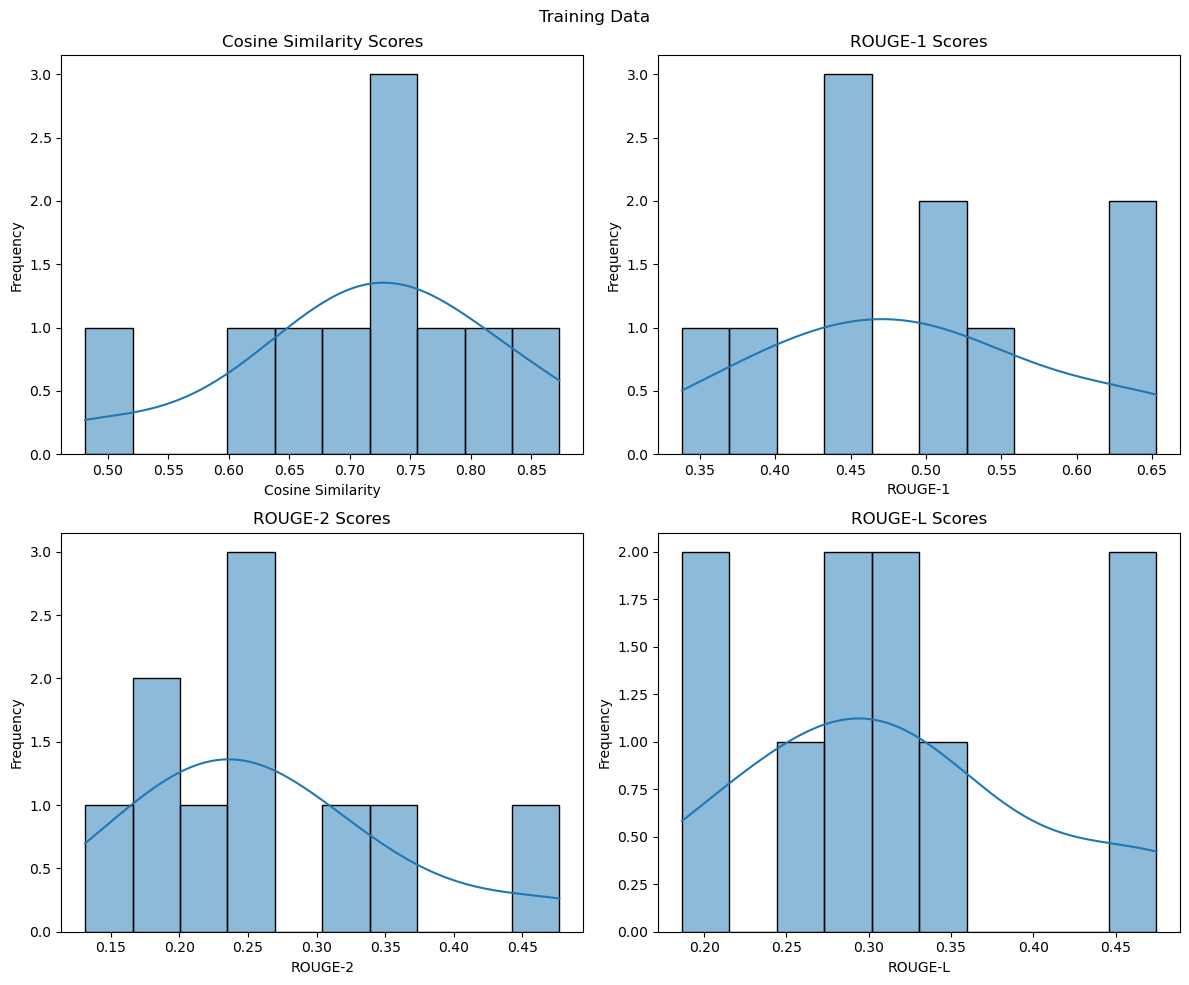

In [39]:
# Create subplots for histograms with KDE for Cosine Similarities and ROUGE Scores
cosine_similarity_scores = train_bart["cosine_similarity_"]
rouge_1_scores = train_bart["rouge_1"]
rouge_2_scores = train_bart["rouge_2"]
rouge_L_scores = train_bart["rouge_L"]


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Cosine Similarity subplot
sns.histplot(cosine_similarity_scores, kde=True, bins=10, ax=axes[0, 0])
axes[0, 0].set_title('Cosine Similarity Scores')
axes[0, 0].set_xlabel('Cosine Similarity')
axes[0, 0].set_ylabel('Frequency')

# ROUGE-1 subplot
sns.histplot(rouge_1_scores, kde=True, bins=10, ax=axes[0, 1])
axes[0, 1].set_title('ROUGE-1 Scores')
axes[0, 1].set_xlabel('ROUGE-1')
axes[0, 1].set_ylabel('Frequency')

# ROUGE-2 subplot
sns.histplot(rouge_2_scores, kde=True, bins=10, ax=axes[1, 0])
axes[1, 0].set_title('ROUGE-2 Scores')
axes[1, 0].set_xlabel('ROUGE-2')
axes[1, 0].set_ylabel('Frequency')

# ROUGE-L subplot
sns.histplot(rouge_L_scores, kde=True, bins=10, ax=axes[1, 1])
axes[1, 1].set_title('ROUGE-L Scores')
axes[1, 1].set_xlabel('ROUGE-L')
axes[1, 1].set_ylabel('Frequency')

plt.suptitle('Training Data')
plt.tight_layout()
plt.show()

In [50]:
avg_rouge_1 = train_bart["rouge_1"].mean()
avg_rouge_2 = train_bart["rouge_2"].mean()
avg_rouge_L = train_bart["rouge_L"].mean()

rouge_df = pd.DataFrame([[avg_rouge_1, avg_rouge_2, avg_rouge_L]], columns=["ROUGE-1", "ROUGE-2", "ROUGE-L"], index=["Distilled-BART"])
rouge_df

ROUGE-1   ROUGE-2   ROUGE-L
Distilled-BART  0.492675  0.263308  0.317158

In [4]:
# BART performance on Training data
val_bart = pd.read_csv("val_evaluation_lora.csv")
val_bart

document  \
0    civil appeal five hundred and sixty-one one th...   
1    civil appeal four hundred and thirty-one one t...   
2    civil appeal three hundred and fifty-five one ...   
3    civil appeal eighty-nine one thousand, nine hu...   
4    n criminal appeal six hundred and ninety-two o...   
..                                                 ...   
994  appeal no one hundred and sixty-seven one hund...   
995  criminal appeal fifty-four one thousand, nine ...   
996  iminal appeal sixty-four one thousand, nine hu...   
997  n criminal appeal three hundred and eighteen o...   
998  appeal no one thousand, nine hundred and ninet...   

                                        actual_summary  \
0    section thirteen karnataka municipality act on...   
1    r karta hindu undivided family became interest...   
2    refusal appellant employer fix minimum wage ra...   
3    appellant foreign company within meaning secti...   
4    respondent challenged order detention passed d...   
..                                                 ...   
994  one thousand, nine hundred and forty-four rule...   
995  appellant convicted session judge offence murd...   
996  appellant less twenty year convicted offence s...   
997  respondent pollonji darabshaw daruwalla apprai...   
998  assessee firm sold asset two company discontin...   

                                     predicted_summary  cosine_similarity  \
0    term office municipal councillor gangawati mun...           0.936613   
1    one b k rohatgi eldest male member hindu undiv...           0.785287   
2    industrial dispute appellant workman responden...           0.631378   
3     co india entered agreement dated june twenty-...           0.828641   
4    respondent detained section three three read s...           0.752399   
..                                                 ...                ...   
994  appellant granted lease mining lease january t...           0.856405   
995  prosecution case appellant father law refugee ...           0.559350   
996  appellant convicted judicial magistrate 1st cl...           0.586383   
997  respondent public servant custom department bo...           0.650483   
998  assessee firm carrying diverse trading activit...           0.786479   

      rouge_1   rouge_2   rouge_L  
0    0.636485  0.420000  0.326232  
1    0.474544  0.252166  0.224784  
2    0.336329  0.144144  0.187420  
3    0.632880  0.376238  0.280593  
4    0.540889  0.309478  0.206053  
..        ...       ...       ...  
994  0.602051  0.363450  0.306667  
995  0.351454  0.228137  0.194690  
996  0.432778  0.238768  0.240717  
997  0.609509  0.376269  0.303975  
998  0.530680  0.325581  0.247098  

[999 rows x 7 columns]

In [5]:
val_bart["cosine_similarity_"] = val_bart["cosine_similarity"].astype(str)

# Define a lambda function to remove square brackets
remove_brackets = lambda x: x.replace("[", "").replace("]", "")

val_bart['cosine_similarity_'] = val_bart['cosine_similarity_'].apply(remove_brackets).astype("float64")
val_bart

document  \
0    civil appeal five hundred and sixty-one one th...   
1    civil appeal four hundred and thirty-one one t...   
2    civil appeal three hundred and fifty-five one ...   
3    civil appeal eighty-nine one thousand, nine hu...   
4    n criminal appeal six hundred and ninety-two o...   
..                                                 ...   
994  appeal no one hundred and sixty-seven one hund...   
995  criminal appeal fifty-four one thousand, nine ...   
996  iminal appeal sixty-four one thousand, nine hu...   
997  n criminal appeal three hundred and eighteen o...   
998  appeal no one thousand, nine hundred and ninet...   

                                        actual_summary  \
0    section thirteen karnataka municipality act on...   
1    r karta hindu undivided family became interest...   
2    refusal appellant employer fix minimum wage ra...   
3    appellant foreign company within meaning secti...   
4    respondent challenged order detention passed d...   
..                                                 ...   
994  one thousand, nine hundred and forty-four rule...   
995  appellant convicted session judge offence murd...   
996  appellant less twenty year convicted offence s...   
997  respondent pollonji darabshaw daruwalla apprai...   
998  assessee firm sold asset two company discontin...   

                                     predicted_summary  cosine_similarity  \
0    term office municipal councillor gangawati mun...           0.936613   
1    one b k rohatgi eldest male member hindu undiv...           0.785287   
2    industrial dispute appellant workman responden...           0.631378   
3     co india entered agreement dated june twenty-...           0.828641   
4    respondent detained section three three read s...           0.752399   
..                                                 ...                ...   
994  appellant granted lease mining lease january t...           0.856405   
995  prosecution case appellant father law refugee ...           0.559350   
996  appellant convicted judicial magistrate 1st cl...           0.586383   
997  respondent public servant custom department bo...           0.650483   
998  assessee firm carrying diverse trading activit...           0.786479   

      rouge_1   rouge_2   rouge_L  cosine_similarity_  
0    0.636485  0.420000  0.326232            0.936613  
1    0.474544  0.252166  0.224784            0.785287  
2    0.336329  0.144144  0.187420            0.631378  
3    0.632880  0.376238  0.280593            0.828641  
4    0.540889  0.309478  0.206053            0.752399  
..        ...       ...       ...                 ...  
994  0.602051  0.363450  0.306667            0.856405  
995  0.351454  0.228137  0.194690            0.559350  
996  0.432778  0.238768  0.240717            0.586383  
997  0.609509  0.376269  0.303975            0.650483  
998  0.530680  0.325581  0.247098            0.786479  

[999 rows x 8 columns]

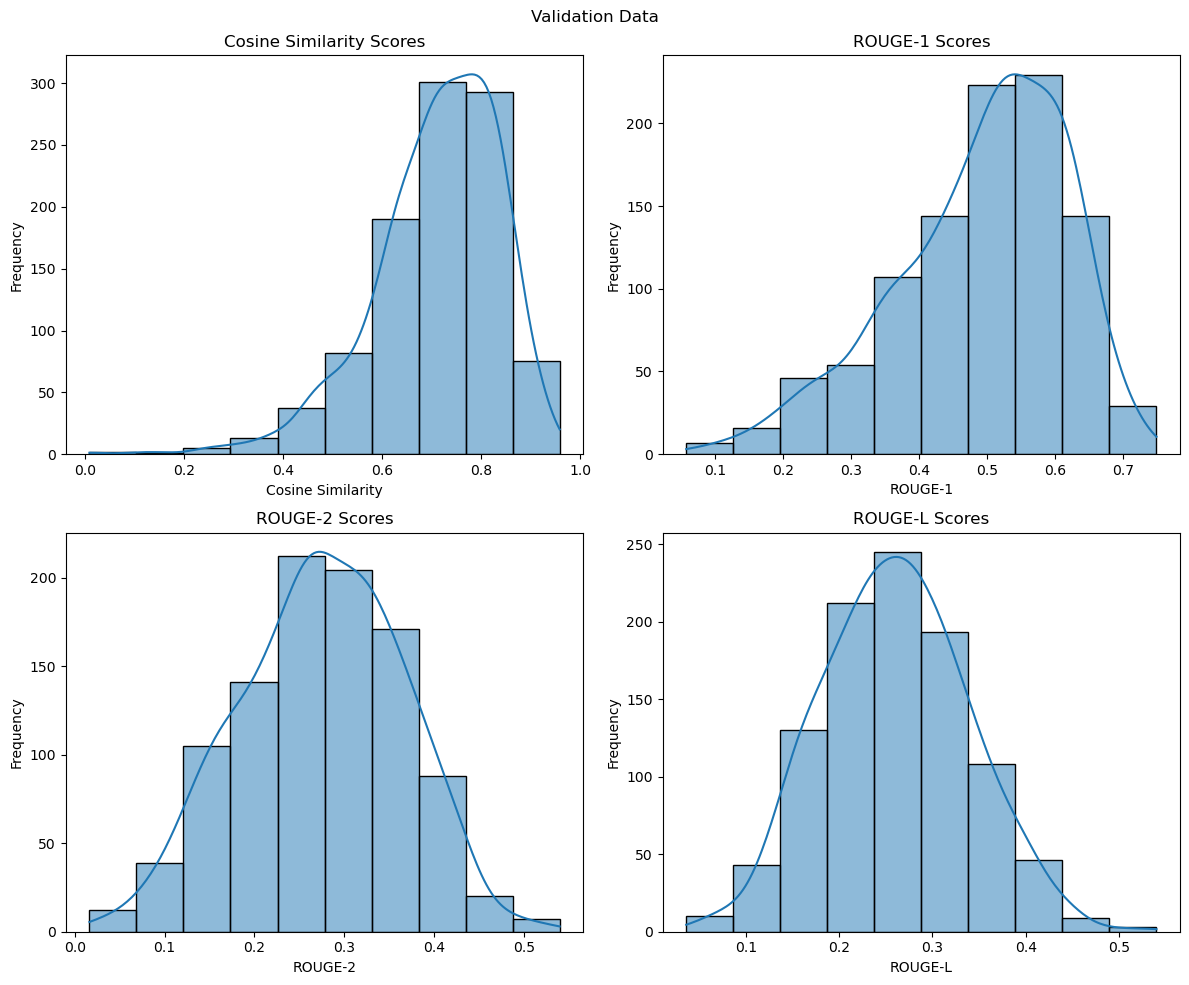

In [6]:
# Create subplots for histograms with KDE for Cosine Similarities and ROUGE Scores
cosine_similarity_scores = val_bart["cosine_similarity_"]
rouge_1_scores = val_bart["rouge_1"]
rouge_2_scores = val_bart["rouge_2"]
rouge_L_scores = val_bart["rouge_L"]


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Cosine Similarity subplot
sns.histplot(cosine_similarity_scores, kde=True, bins=10, ax=axes[0, 0])
axes[0, 0].set_title('Cosine Similarity Scores')
axes[0, 0].set_xlabel('Cosine Similarity')
axes[0, 0].set_ylabel('Frequency')

# ROUGE-1 subplot
sns.histplot(rouge_1_scores, kde=True, bins=10, ax=axes[0, 1])
axes[0, 1].set_title('ROUGE-1 Scores')
axes[0, 1].set_xlabel('ROUGE-1')
axes[0, 1].set_ylabel('Frequency')

# ROUGE-2 subplot
sns.histplot(rouge_2_scores, kde=True, bins=10, ax=axes[1, 0])
axes[1, 0].set_title('ROUGE-2 Scores')
axes[1, 0].set_xlabel('ROUGE-2')
axes[1, 0].set_ylabel('Frequency')

# ROUGE-L subplot
sns.histplot(rouge_L_scores, kde=True, bins=10, ax=axes[1, 1])
axes[1, 1].set_title('ROUGE-L Scores')
axes[1, 1].set_xlabel('ROUGE-L')
axes[1, 1].set_ylabel('Frequency')

plt.suptitle('Validation Data')
plt.tight_layout()
plt.show()

In [7]:
avg_cos_sim = val_bart["cosine_similarity"].mean()
avg_rouge_1 = val_bart["rouge_1"].mean()
avg_rouge_2 = val_bart["rouge_2"].mean()
avg_rouge_L = val_bart["rouge_L"].mean()

rouge_df = pd.DataFrame([[avg_cos_sim, avg_rouge_1, avg_rouge_2, avg_rouge_L]], columns=["Cosine Similarity", "ROUGE-1", "ROUGE-2", "ROUGE-L"], index=["Distilled-BART"])
rouge_df

Cosine Similarity   ROUGE-1   ROUGE-2   ROUGE-L
Distilled-BART           0.711269  0.491834  0.273927  0.260234